In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import Bidirectional

import pandas as pd
import numpy as np

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

import sys  
sys.path.insert(0, '../../')
import RadonDF_Handler

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
D001_df = pd.read_csv('./../../../../../Data/SensorsData/interpolated_D001_data.csv')
D001_df = D001_df.iloc[913:]
D001_df = pd.DataFrame(D001_df)
D001_df['time'] =  pd.to_datetime(D001_df['time'], format='%Y-%m-%d %H:%M:%S')
D001_df.index = D001_df['time']
D001_df = D001_df.drop(['time'],axis = 1)

In [4]:
def df_to_X_y(df,hoursToPredict, windowSize):
        hoursToPredict = hoursToPredict - 1
        df_as_np = df.to_numpy() # converts the dataframe to a numpy array
        #Initialized  arrays to append X and Y values 
        X = []
        y = []
        for i in range(len(df_as_np)):
            if((i + hoursToPredict + windowSize)< len(df_as_np)):
                #Takes values from i to i + win size
                row =  [r for r in df_as_np[i:i+windowSize]]
                X.append(row)
                label = df_as_np[i + hoursToPredict + windowSize ][1]
                y.append(label)
        return np.array(X), np.array(y)

In [5]:
def DataHandler(hoursToPredict,windowSize):
    X1, y1 = df_to_X_y(D001_df,hoursToPredict,windowSize)

    return X1, y1

In [6]:
plt.style.use('seaborn')

In [7]:
def Trainer(time,windowSize,finalWindowSize):
    while(windowSize <= finalWindowSize):
        model = Sequential()
        model.add(InputLayer((windowSize, 5)))
        model.add(Bidirectional(LSTM(64)))
        model.add(Dense(8, 'relu'))
        model.add(Dense(1, 'linear'))

        model.summary()
        X, y = DataHandler(time,windowSize)
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle = False)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,shuffle= False) 

        X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape
        
        cp1= ModelCheckpoint(str(time)+"H_Forecast/"+str(time)+"H_ForecastModel_"+str(windowSize)+"_SizeWindow/", save_best_only=True)
        model.compile(loss=MeanSquaredError(), 
                   optimizer=Adam(learning_rate=0.0001), 
                   metrics=[MeanAbsoluteError()])
    
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[cp1])
        windowSize += 1
        print()
        print("-----------------------------------------------------------------------------------------------------------")
        print()

In [8]:
def modelsEvaluator(time,windowSize,finalWindowSize):
    while(windowSize <= finalWindowSize):
        X, y = DataHandler(time,windowSize)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle = False)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,shuffle = False) 
        
        print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)
       
        print("Loading: "+ str(time)+"H_Forecast/" + str(time)+"H_ForecastModel_"+str(windowSize)+"_SizeWindow/")
        model = load_model(str(time)+"H_Forecast/"+str(time)+"H_ForecastModel_"+str(windowSize)+"_SizeWindow/")
        model.evaluate(X_test,y_test)
        
        test_predictions = model.predict(X_test).flatten()
        test_results = pd.DataFrame(data={'Test Predictions '+str(time) + ' hour model':test_predictions, 'Actuals':y_test})
        
        windowSize += 1

In [22]:
%%time

Trainer(1,6,12)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 128)               35840     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 36,881
Trainable params: 36,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
161/161 [==============================] - 7s 19ms/step - loss: 111295.4141 - mean_absolute_error: 248.6467 - val_loss: 149948.8438 - val_mean_absolute_error: 333.3192
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 2/100
161/161 [==============================] - 2s 14ms/step - loss: 109922.3203 - mean_absolute_error: 246.1961 - val_loss: 147804.7656 - val_mean_absolute_error: 330.1508
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 3/100
161/161 [==============================] - 2s 12ms/step - loss: 108389.2422 - mean_absolute_error: 243.2641 - val_loss: 145578.1562 - val_mean_absolute_error: 326.6473
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 4/100
161/161 [==============================] - 2s 14ms/step - loss: 106347.2422 - mean_absolute_error: 239.2617 - val_loss: 142485.6562 - val_mean_absolute_error: 321.9469
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 5/100
161/161 [==============================] - 2s 14ms/step - loss: 104169.8438 - mean_absolute_error: 235.1082 - val_loss: 139587.8438 - val_mean_absolute_error: 317.4209
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 6/100
161/161 [==============================] - 3s 16ms/step - loss: 102124.2422 - mean_absolute_error: 231.3971 - val_loss: 136779.0781 - val_mean_absolute_error: 313.0196
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 7/100
161/161 [==============================] - 2s 14ms/step - loss: 100130.3438 - mean_absolute_error: 227.7539 - val_loss: 134115.4062 - val_mean_absolute_error: 308.8032
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 8/100
161/161 [==============================] - 3s 20ms/step - loss: 98249.8906 - mean_absolute_error: 224.3097 - val_loss: 131587.7500 - val_mean_absolute_error: 304.7386
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 9/100
161/161 [==============================] - 2s 15ms/step - loss: 96419.0312 - mean_absolute_error: 220.9234 - val_loss: 129011.5469 - val_mean_absolute_error: 300.5691
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 10/100
161/161 [==============================] - 2s 15ms/step - loss: 94553.7344 - mean_absolute_error: 217.5767 - val_loss: 126256.1406 - val_mean_absolute_error: 296.0307
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 11/100
161/161 [==============================] - 2s 14ms/step - loss: 92523.6016 - mean_absolute_error: 213.8367 - val_loss: 123498.6641 - val_mean_absolute_error: 291.3998
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 12/100
161/161 [==============================] - 3s 18ms/step - loss: 90547.8672 - mean_absolute_error: 210.1323 - val_loss: 120703.3438 - val_mean_absolute_error: 286.6508
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 13/100
161/161 [==============================] - 3s 16ms/step - loss: 88459.9141 - mean_absolute_error: 206.2313 - val_loss: 117718.6719 - val_mean_absolute_error: 281.5644
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 14/100
161/161 [==============================] - 2s 13ms/step - loss: 86394.2266 - mean_absolute_error: 202.3163 - val_loss: 114735.1953 - val_mean_absolute_error: 276.4385
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 15/100
161/161 [==============================] - 2s 12ms/step - loss: 84303.7656 - mean_absolute_error: 198.4377 - val_loss: 111848.5938 - val_mean_absolute_error: 271.4534
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 16/100
161/161 [==============================] - 3s 20ms/step - loss: 82265.2031 - mean_absolute_error: 194.5881 - val_loss: 108878.0234 - val_mean_absolute_error: 266.2518
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 17/100
161/161 [==============================] - 3s 16ms/step - loss: 80139.8828 - mean_absolute_error: 190.6079 - val_loss: 105915.6172 - val_mean_absolute_error: 261.0917
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 18/100
161/161 [==============================] - 2s 13ms/step - loss: 78095.3516 - mean_absolute_error: 186.7735 - val_loss: 103002.6406 - val_mean_absolute_error: 256.0057
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 19/100
161/161 [==============================] - 2s 13ms/step - loss: 76028.5625 - mean_absolute_error: 182.5666 - val_loss: 100005.4141 - val_mean_absolute_error: 250.7715
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 20/100
161/161 [==============================] - 2s 13ms/step - loss: 73964.0234 - mean_absolute_error: 178.7365 - val_loss: 97075.2344 - val_mean_absolute_error: 245.6263
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 21/100
161/161 [==============================] - 2s 13ms/step - loss: 71899.8047 - mean_absolute_error: 174.3222 - val_loss: 94059.4375 - val_mean_absolute_error: 240.2930
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 22/100
161/161 [==============================] - 2s 13ms/step - loss: 69867.2266 - mean_absolute_error: 170.4404 - val_loss: 91165.4062 - val_mean_absolute_error: 235.1439
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 23/100
161/161 [==============================] - 3s 19ms/step - loss: 67863.5547 - mean_absolute_error: 166.2697 - val_loss: 88199.5703 - val_mean_absolute_error: 229.9014
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 24/100
161/161 [==============================] - 2s 11ms/step - loss: 65868.2734 - mean_absolute_error: 162.0623 - val_loss: 85345.6406 - val_mean_absolute_error: 224.7321
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 25/100
161/161 [==============================] - 2s 12ms/step - loss: 63937.3555 - mean_absolute_error: 158.1012 - val_loss: 82521.4141 - val_mean_absolute_error: 219.5565
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 26/100
161/161 [==============================] - 2s 10ms/step - loss: 62069.0586 - mean_absolute_error: 154.0853 - val_loss: 79773.1016 - val_mean_absolute_error: 214.4326
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 27/100
161/161 [==============================] - 2s 10ms/step - loss: 60219.8594 - mean_absolute_error: 150.4626 - val_loss: 77031.8906 - val_mean_absolute_error: 209.2778
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 28/100
161/161 [==============================] - 2s 12ms/step - loss: 58411.2148 - mean_absolute_error: 146.1744 - val_loss: 74397.1172 - val_mean_absolute_error: 204.2752
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 29/100
161/161 [==============================] - 2s 10ms/step - loss: 56632.4062 - mean_absolute_error: 142.3174 - val_loss: 71754.3984 - val_mean_absolute_error: 199.1012
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 30/100
161/161 [==============================] - 2s 10ms/step - loss: 54895.4961 - mean_absolute_error: 138.4108 - val_loss: 69177.5625 - val_mean_absolute_error: 194.0171
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 31/100
161/161 [==============================] - 2s 10ms/step - loss: 53186.3906 - mean_absolute_error: 134.7354 - val_loss: 66638.8125 - val_mean_absolute_error: 189.0311
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 32/100
161/161 [==============================] - 3s 16ms/step - loss: 51542.3242 - mean_absolute_error: 131.0755 - val_loss: 64160.5000 - val_mean_absolute_error: 184.1661
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 33/100
161/161 [==============================] - 3s 16ms/step - loss: 49910.2930 - mean_absolute_error: 127.0817 - val_loss: 61686.8984 - val_mean_absolute_error: 179.1859
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 34/100
161/161 [==============================] - 2s 11ms/step - loss: 48319.4141 - mean_absolute_error: 123.4017 - val_loss: 59304.7344 - val_mean_absolute_error: 174.6301
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 35/100
161/161 [==============================] - 2s 15ms/step - loss: 46780.7695 - mean_absolute_error: 119.7400 - val_loss: 57065.6523 - val_mean_absolute_error: 170.4270
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 36/100
161/161 [==============================] - 2s 12ms/step - loss: 45296.3594 - mean_absolute_error: 116.3081 - val_loss: 54734.7930 - val_mean_absolute_error: 165.8003
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 37/100
161/161 [==============================] - 2s 12ms/step - loss: 43852.8984 - mean_absolute_error: 112.6946 - val_loss: 52479.7930 - val_mean_absolute_error: 161.3335
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 38/100
161/161 [==============================] - 3s 18ms/step - loss: 42442.0820 - mean_absolute_error: 109.5499 - val_loss: 50225.4492 - val_mean_absolute_error: 156.8328672.0352 - mean_absolute_error: 110.1
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 39/100
161/161 [==============================] - 2s 14ms/step - loss: 41039.9492 - mean_absolute_error: 106.1332 - val_loss: 48106.0469 - val_mean_absolute_error: 152.5998
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 40/100
161/161 [==============================] - 3s 17ms/step - loss: 39752.7969 - mean_absolute_error: 102.8933 - val_loss: 46064.7930 - val_mean_absolute_error: 148.5555
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 41/100
161/161 [==============================] - 3s 21ms/step - loss: 38500.7539 - mean_absolute_error: 100.2636 - val_loss: 44093.3828 - val_mean_absolute_error: 144.3934
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 42/100
161/161 [==============================] - 3s 16ms/step - loss: 37276.5977 - mean_absolute_error: 96.8498 - val_loss: 42172.4648 - val_mean_absolute_error: 140.1542
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 43/100
161/161 [==============================] - 2s 11ms/step - loss: 36131.9531 - mean_absolute_error: 93.7658 - val_loss: 40301.1055 - val_mean_absolute_error: 136.1997
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 44/100
161/161 [==============================] - 2s 10ms/step - loss: 34987.3828 - mean_absolute_error: 90.9242 - val_loss: 38586.2500 - val_mean_absolute_error: 132.4051
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 45/100
161/161 [==============================] - 2s 11ms/step - loss: 33861.9375 - mean_absolute_error: 87.9692 - val_loss: 36728.7266 - val_mean_absolute_error: 128.3564
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 46/100
161/161 [==============================] - 2s 10ms/step - loss: 32779.7422 - mean_absolute_error: 85.1870 - val_loss: 35051.8828 - val_mean_absolute_error: 124.6459
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 47/100
161/161 [==============================] - 1s 9ms/step - loss: 31772.0742 - mean_absolute_error: 82.5013 - val_loss: 33315.0039 - val_mean_absolute_error: 120.5154
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 48/100
161/161 [==============================] - 2s 12ms/step - loss: 30844.5527 - mean_absolute_error: 80.3236 - val_loss: 31801.9746 - val_mean_absolute_error: 117.2182
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 49/100
161/161 [==============================] - 2s 10ms/step - loss: 29888.0781 - mean_absolute_error: 77.6816 - val_loss: 30209.5684 - val_mean_absolute_error: 113.4694
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 50/100
161/161 [==============================] - 2s 11ms/step - loss: 28978.8691 - mean_absolute_error: 75.2794 - val_loss: 28673.6562 - val_mean_absolute_error: 109.8574
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 51/100
161/161 [==============================] - 2s 13ms/step - loss: 28142.2480 - mean_absolute_error: 72.9537 - val_loss: 27366.0566 - val_mean_absolute_error: 106.8492
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 52/100
161/161 [==============================] - 2s 13ms/step - loss: 27335.4531 - mean_absolute_error: 70.8028 - val_loss: 25957.8555 - val_mean_absolute_error: 103.0940
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 53/100
161/161 [==============================] - 2s 12ms/step - loss: 26562.0918 - mean_absolute_error: 68.6165 - val_loss: 24847.9961 - val_mean_absolute_error: 100.5769
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 54/100
161/161 [==============================] - 2s 10ms/step - loss: 25914.3594 - mean_absolute_error: 67.2672 - val_loss: 23581.1406 - val_mean_absolute_error: 96.9906
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 55/100
161/161 [==============================] - 2s 10ms/step - loss: 25190.3164 - mean_absolute_error: 65.0776 - val_loss: 22470.0918 - val_mean_absolute_error: 94.1940
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 56/100
161/161 [==============================] - 2s 10ms/step - loss: 24526.9141 - mean_absolute_error: 62.9007 - val_loss: 21174.2598 - val_mean_absolute_error: 90.7241
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 57/100
161/161 [==============================] - 2s 10ms/step - loss: 23904.9922 - mean_absolute_error: 61.2544 - val_loss: 20277.3867 - val_mean_absolute_error: 88.3794
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 58/100
161/161 [==============================] - 2s 10ms/step - loss: 23315.4043 - mean_absolute_error: 59.3209 - val_loss: 19206.0156 - val_mean_absolute_error: 85.5161
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 59/100
161/161 [==============================] - 2s 9ms/step - loss: 22766.8145 - mean_absolute_error: 57.9629 - val_loss: 18395.3730 - val_mean_absolute_error: 83.0160
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 60/100
161/161 [==============================] - 2s 9ms/step - loss: 22206.7129 - mean_absolute_error: 56.0758 - val_loss: 17337.8047 - val_mean_absolute_error: 79.7602
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 61/100
161/161 [==============================] - 2s 12ms/step - loss: 21773.5898 - mean_absolute_error: 55.1547 - val_loss: 16495.0078 - val_mean_absolute_error: 77.6219
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 62/100
161/161 [==============================] - ETA: 0s - loss: 21258.8418 - mean_absolute_error: 53.13 - 2s 11ms/step - loss: 21258.8418 - mean_absolute_error: 53.1313 - val_loss: 15843.9688 - val_mean_absolute_error: 76.0945
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 63/100
161/161 [==============================] - 2s 10ms/step - loss: 20794.1055 - mean_absolute_error: 51.7421 - val_loss: 15030.9707 - val_mean_absolute_error: 73.2910
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 64/100
161/161 [==============================] - 2s 13ms/step - loss: 20369.9277 - mean_absolute_error: 50.3754 - val_loss: 14314.4365 - val_mean_absolute_error: 71.6744
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 65/100
161/161 [==============================] - 6s 34ms/step - loss: 19968.9629 - mean_absolute_error: 49.2130 - val_loss: 13750.0586 - val_mean_absolute_error: 69.8173
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 66/100
161/161 [==============================] - 2s 14ms/step - loss: 19581.2793 - mean_absolute_error: 47.9229 - val_loss: 13253.9053 - val_mean_absolute_error: 68.6943
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 67/100
161/161 [==============================] - 2s 14ms/step - loss: 19266.9961 - mean_absolute_error: 46.8880 - val_loss: 12320.4375 - val_mean_absolute_error: 66.0747
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 68/100
161/161 [==============================] - 2s 14ms/step - loss: 18986.4590 - mean_absolute_error: 46.8911 - val_loss: 11831.9990 - val_mean_absolute_error: 64.1243
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 69/100
161/161 [==============================] - 3s 20ms/step - loss: 18635.0918 - mean_absolute_error: 44.9796 - val_loss: 11367.7529 - val_mean_absolute_error: 62.7750
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 70/100
161/161 [==============================] - 3s 18ms/step - loss: 18336.9062 - mean_absolute_error: 43.9521 - val_loss: 10805.5166 - val_mean_absolute_error: 60.9646
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 71/100
161/161 [==============================] - 2s 15ms/step - loss: 18077.5430 - mean_absolute_error: 43.0090 - val_loss: 10520.3604 - val_mean_absolute_error: 60.9609
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 72/100
161/161 [==============================] - 2s 14ms/step - loss: 17837.8945 - mean_absolute_error: 42.2839 - val_loss: 9934.8164 - val_mean_absolute_error: 58.5992
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 73/100
161/161 [==============================] - 2s 13ms/step - loss: 17596.2520 - mean_absolute_error: 41.4485 - val_loss: 9594.9092 - val_mean_absolute_error: 57.5139
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 74/100
161/161 [==============================] - 2s 15ms/step - loss: 17395.1387 - mean_absolute_error: 40.6878 - val_loss: 9102.4932 - val_mean_absolute_error: 55.6990
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 75/100
161/161 [==============================] - 2s 15ms/step - loss: 17194.7520 - mean_absolute_error: 40.1763 - val_loss: 8959.5449 - val_mean_absolute_error: 55.6269
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 76/100
161/161 [==============================] - 2s 13ms/step - loss: 16980.9453 - mean_absolute_error: 39.3789 - val_loss: 8424.4434 - val_mean_absolute_error: 53.3275
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 77/100
161/161 [==============================] - 2s 13ms/step - loss: 16825.5215 - mean_absolute_error: 38.7520 - val_loss: 8265.6172 - val_mean_absolute_error: 53.2698
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 78/100
161/161 [==============================] - 3s 17ms/step - loss: 16666.4102 - mean_absolute_error: 38.3371 - val_loss: 7964.2944 - val_mean_absolute_error: 52.2515
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 79/100
161/161 [==============================] - 2s 13ms/step - loss: 16512.6445 - mean_absolute_error: 37.7317 - val_loss: 7476.7686 - val_mean_absolute_error: 49.8568
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 80/100
161/161 [==============================] - 2s 14ms/step - loss: 16368.1514 - mean_absolute_error: 37.2307 - val_loss: 7220.8276 - val_mean_absolute_error: 49.1238
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 81/100
161/161 [==============================] - 2s 14ms/step - loss: 16238.6943 - mean_absolute_error: 36.8521 - val_loss: 6956.2378 - val_mean_absolute_error: 48.0422
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 82/100
161/161 [==============================] - 2s 14ms/step - loss: 16096.8740 - mean_absolute_error: 36.3172 - val_loss: 7212.5620 - val_mean_absolute_error: 49.8757
Epoch 83/100
161/161 [==============================] - 2s 13ms/step - loss: 16045.6211 - mean_absolute_error: 35.9624 - val_loss: 6762.9771 - val_mean_absolute_error: 48.7452
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 84/100
161/161 [==============================] - 2s 14ms/step - loss: 15997.1738 - mean_absolute_error: 36.8440 - val_loss: 6496.7739 - val_mean_absolute_error: 46.9973
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 85/100
161/161 [==============================] - 3s 18ms/step - loss: 15797.5391 - mean_absolute_error: 35.3094 - val_loss: 6154.3359 - val_mean_absolute_error: 45.3755
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 86/100
161/161 [==============================] - 2s 13ms/step - loss: 15658.8701 - mean_absolute_error: 34.8691 - val_loss: 6609.2905 - val_mean_absolute_error: 48.4419
Epoch 87/100
161/161 [==============================] - 2s 14ms/step - loss: 15562.5186 - mean_absolute_error: 34.6211 - val_loss: 5825.1577 - val_mean_absolute_error: 44.4134
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 88/100
161/161 [==============================] - 2s 14ms/step - loss: 15480.6104 - mean_absolute_error: 34.3660 - val_loss: 5743.5825 - val_mean_absolute_error: 44.4893
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 89/100
161/161 [==============================] - 2s 13ms/step - loss: 15401.6689 - mean_absolute_error: 33.9553 - val_loss: 5522.5410 - val_mean_absolute_error: 43.5619
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 90/100
161/161 [==============================] - 2s 14ms/step - loss: 15338.6123 - mean_absolute_error: 34.2111 - val_loss: 5429.4048 - val_mean_absolute_error: 42.8981
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 91/100
161/161 [==============================] - 2s 14ms/step - loss: 15235.2852 - mean_absolute_error: 33.5498 - val_loss: 5485.9976 - val_mean_absolute_error: 44.2400
Epoch 92/100
161/161 [==============================] - 2s 14ms/step - loss: 15166.7324 - mean_absolute_error: 33.2585 - val_loss: 5269.1914 - val_mean_absolute_error: 43.3374
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 93/100
161/161 [==============================] - 2s 13ms/step - loss: 15147.7334 - mean_absolute_error: 34.0003 - val_loss: 5189.9136 - val_mean_absolute_error: 42.4448
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 94/100
161/161 [==============================] - 2s 13ms/step - loss: 15041.2822 - mean_absolute_error: 33.0455 - val_loss: 5220.1147 - val_mean_absolute_error: 43.3625
Epoch 95/100
161/161 [==============================] - 2s 13ms/step - loss: 14970.5967 - mean_absolute_error: 32.7418 - val_loss: 5132.1592 - val_mean_absolute_error: 43.0418
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 96/100
161/161 [==============================] - 3s 18ms/step - loss: 14923.8750 - mean_absolute_error: 32.5679 - val_loss: 5357.0718 - val_mean_absolute_error: 44.3921
Epoch 97/100
161/161 [==============================] - 2s 14ms/step - loss: 14876.8574 - mean_absolute_error: 32.6457 - val_loss: 5264.0913 - val_mean_absolute_error: 44.0478
Epoch 98/100
161/161 [==============================] - 2s 13ms/step - loss: 14796.6318 - mean_absolute_error: 32.2166 - val_loss: 5089.2383 - val_mean_absolute_error: 43.6117
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 99/100
161/161 [==============================] - 2s 13ms/step - loss: 14812.6670 - mean_absolute_error: 32.5814 - val_loss: 4729.5679 - val_mean_absolute_error: 41.7579
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 100/100
161/161 [==============================] - 2s 15ms/step - loss: 14705.2959 - mean_absolute_error: 32.0814 - val_loss: 4478.9761 - val_mean_absolute_error: 40.3493
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 128)               35840     
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 36,881
Trainable params: 36,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
161/161 [==============================] - 10s 24ms/step - loss: 110202.4766 - mean_absolute_error: 246.7672 - val_loss: 147868.9062 - val_mean_absolute_error: 330.0499
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 2/100
161/161 [==============================] - 2s 15ms/step - loss: 107351.5703 - mean_absolute_error: 241.3998 - val_loss: 143752.2500 - val_mean_absolute_error: 323.5565
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 3/100
161/161 [==============================] - 2s 14ms/step - loss: 104036.8672 - mean_absolute_error: 234.9674 - val_loss: 138395.9375 - val_mean_absolute_error: 315.1156
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 4/100
161/161 [==============================] - 3s 20ms/step - loss: 99561.4766 - mean_absolute_error: 226.8551 - val_loss: 132043.8281 - val_mean_absolute_error: 305.3423
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 5/100
161/161 [==============================] - 3s 18ms/step - loss: 95522.2109 - mean_absolute_error: 219.5105 - val_loss: 126786.7422 - val_mean_absolute_error: 296.7646
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 6/100
161/161 [==============================] - 3s 16ms/step - loss: 91810.4453 - mean_absolute_error: 212.5405 - val_loss: 121446.8125 - val_mean_absolute_error: 287.6890
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 7/100
161/161 [==============================] - 2s 15ms/step - loss: 88042.9531 - mean_absolute_error: 205.3900 - val_loss: 116433.6172 - val_mean_absolute_error: 279.1359
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 8/100
161/161 [==============================] - 3s 17ms/step - loss: 84624.9922 - mean_absolute_error: 199.0703 - val_loss: 111519.5000 - val_mean_absolute_error: 270.6422
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 9/100
161/161 [==============================] - 3s 19ms/step - loss: 81239.1016 - mean_absolute_error: 192.6292 - val_loss: 106909.3984 - val_mean_absolute_error: 262.5735
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 10/100
161/161 [==============================] - 3s 17ms/step - loss: 78041.6172 - mean_absolute_error: 186.3863 - val_loss: 102254.5078 - val_mean_absolute_error: 254.4190
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 11/100
161/161 [==============================] - 2s 11ms/step - loss: 74714.0391 - mean_absolute_error: 179.8601 - val_loss: 97456.3750 - val_mean_absolute_error: 246.0863
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 12/100
161/161 [==============================] - 2s 11ms/step - loss: 71513.9297 - mean_absolute_error: 173.5762 - val_loss: 93065.7109 - val_mean_absolute_error: 238.4026
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 13/100
161/161 [==============================] - 2s 11ms/step - loss: 68534.2109 - mean_absolute_error: 167.6991 - val_loss: 88754.0312 - val_mean_absolute_error: 230.7640
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 14/100
161/161 [==============================] - 2s 11ms/step - loss: 65674.7266 - mean_absolute_error: 161.5622 - val_loss: 84545.2188 - val_mean_absolute_error: 223.1760
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 15/100
161/161 [==============================] - 3s 16ms/step - loss: 62792.7852 - mean_absolute_error: 156.0089 - val_loss: 80279.1406 - val_mean_absolute_error: 215.2063
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 16/100
161/161 [==============================] - 2s 13ms/step - loss: 59954.6484 - mean_absolute_error: 149.9224 - val_loss: 76180.6094 - val_mean_absolute_error: 207.4046
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 17/100
161/161 [==============================] - 2s 15ms/step - loss: 57321.3477 - mean_absolute_error: 143.9385 - val_loss: 72455.3516 - val_mean_absolute_error: 200.4195
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 18/100
161/161 [==============================] - 3s 16ms/step - loss: 54817.9727 - mean_absolute_error: 138.7360 - val_loss: 68778.0469 - val_mean_absolute_error: 193.2307
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 19/100
161/161 [==============================] - 2s 16ms/step - loss: 52438.2188 - mean_absolute_error: 133.4130 - val_loss: 65118.6367 - val_mean_absolute_error: 186.1355
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 20/100
161/161 [==============================] - 2s 13ms/step - loss: 50115.3555 - mean_absolute_error: 128.0387 - val_loss: 61607.1016 - val_mean_absolute_error: 179.3668
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 21/100
161/161 [==============================] - 2s 11ms/step - loss: 47872.2266 - mean_absolute_error: 122.9399 - val_loss: 58230.8555 - val_mean_absolute_error: 172.7142
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 22/100
161/161 [==============================] - 2s 10ms/step - loss: 45748.3125 - mean_absolute_error: 117.8016 - val_loss: 55029.3164 - val_mean_absolute_error: 166.3283
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 23/100
161/161 [==============================] - 2s 9ms/step - loss: 43755.5078 - mean_absolute_error: 113.1421 - val_loss: 51980.5000 - val_mean_absolute_error: 160.3207
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 24/100
161/161 [==============================] - 2s 10ms/step - loss: 41896.9844 - mean_absolute_error: 108.6728 - val_loss: 49321.4102 - val_mean_absolute_error: 155.0484
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 25/100
161/161 [==============================] - 2s 10ms/step - loss: 40105.4922 - mean_absolute_error: 104.5291 - val_loss: 46298.7031 - val_mean_absolute_error: 148.7704
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 26/100
161/161 [==============================] - 2s 10ms/step - loss: 38424.3672 - mean_absolute_error: 100.4449 - val_loss: 44029.4375 - val_mean_absolute_error: 144.2675
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 27/100
161/161 [==============================] - 2s 11ms/step - loss: 36870.1719 - mean_absolute_error: 96.6852 - val_loss: 41156.0469 - val_mean_absolute_error: 138.2640
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 28/100
161/161 [==============================] - 2s 11ms/step - loss: 35375.3398 - mean_absolute_error: 92.7742 - val_loss: 38758.8242 - val_mean_absolute_error: 133.0671
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 29/100
161/161 [==============================] - 2s 11ms/step - loss: 33978.4766 - mean_absolute_error: 89.2606 - val_loss: 36506.2188 - val_mean_absolute_error: 128.1474
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 30/100
161/161 [==============================] - 2s 11ms/step - loss: 32541.8672 - mean_absolute_error: 85.8907 - val_loss: 34138.1836 - val_mean_absolute_error: 122.8158
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 31/100
161/161 [==============================] - 2s 11ms/step - loss: 31232.1504 - mean_absolute_error: 82.4273 - val_loss: 32356.7578 - val_mean_absolute_error: 118.7391
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 32/100
161/161 [==============================] - 2s 11ms/step - loss: 30044.5000 - mean_absolute_error: 79.3152 - val_loss: 30370.5977 - val_mean_absolute_error: 114.3896
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 33/100
161/161 [==============================] - 2s 11ms/step - loss: 28969.7461 - mean_absolute_error: 76.2115 - val_loss: 28282.0469 - val_mean_absolute_error: 109.0927
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 34/100
161/161 [==============================] - 2s 12ms/step - loss: 27938.7227 - mean_absolute_error: 74.3597 - val_loss: 26469.5332 - val_mean_absolute_error: 104.7635
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 35/100
161/161 [==============================] - 2s 14ms/step - loss: 26899.0859 - mean_absolute_error: 71.1293 - val_loss: 24822.8457 - val_mean_absolute_error: 100.4812
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 36/100
161/161 [==============================] - 2s 11ms/step - loss: 25964.9863 - mean_absolute_error: 68.4139 - val_loss: 23294.2383 - val_mean_absolute_error: 96.7197
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 37/100
161/161 [==============================] - 2s 11ms/step - loss: 25117.5957 - mean_absolute_error: 65.9571 - val_loss: 21822.4727 - val_mean_absolute_error: 92.9765
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 38/100
161/161 [==============================] - 2s 11ms/step - loss: 24331.3457 - mean_absolute_error: 63.7770 - val_loss: 20521.2812 - val_mean_absolute_error: 89.6780
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 39/100
161/161 [==============================] - 2s 10ms/step - loss: 23590.1836 - mean_absolute_error: 61.6721 - val_loss: 19498.1230 - val_mean_absolute_error: 87.1902
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 40/100
161/161 [==============================] - 2s 11ms/step - loss: 22937.7246 - mean_absolute_error: 59.8193 - val_loss: 18085.6484 - val_mean_absolute_error: 83.0940
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 41/100
161/161 [==============================] - 2s 11ms/step - loss: 22301.7383 - mean_absolute_error: 57.9023 - val_loss: 17218.3633 - val_mean_absolute_error: 80.9782
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 42/100
161/161 [==============================] - 2s 10ms/step - loss: 21724.0898 - mean_absolute_error: 56.0989 - val_loss: 16164.0508 - val_mean_absolute_error: 78.2526
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 43/100
161/161 [==============================] - 2s 12ms/step - loss: 21193.2930 - mean_absolute_error: 54.5070 - val_loss: 15182.3350 - val_mean_absolute_error: 75.0609
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 44/100
161/161 [==============================] - 2s 11ms/step - loss: 20660.4844 - mean_absolute_error: 52.6946 - val_loss: 14418.9346 - val_mean_absolute_error: 73.0225
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 45/100
161/161 [==============================] - 2s 12ms/step - loss: 20157.6699 - mean_absolute_error: 50.9112 - val_loss: 13371.5654 - val_mean_absolute_error: 69.5054
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 46/100
161/161 [==============================] - 2s 10ms/step - loss: 19752.9941 - mean_absolute_error: 49.8943 - val_loss: 12869.7461 - val_mean_absolute_error: 68.7206
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 47/100
161/161 [==============================] - 2s 11ms/step - loss: 19317.8184 - mean_absolute_error: 48.1816 - val_loss: 12040.9141 - val_mean_absolute_error: 66.1038
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 48/100
161/161 [==============================] - 2s 11ms/step - loss: 18944.6289 - mean_absolute_error: 46.8190 - val_loss: 11430.5977 - val_mean_absolute_error: 63.9976
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 49/100
161/161 [==============================] - 2s 14ms/step - loss: 18604.3613 - mean_absolute_error: 45.7138 - val_loss: 10882.4014 - val_mean_absolute_error: 62.4289
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 50/100
161/161 [==============================] - 2s 12ms/step - loss: 18280.2246 - mean_absolute_error: 44.5820 - val_loss: 10273.6846 - val_mean_absolute_error: 60.3811
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 51/100
161/161 [==============================] - 2s 12ms/step - loss: 18079.3047 - mean_absolute_error: 43.7645 - val_loss: 9756.8711 - val_mean_absolute_error: 58.7547
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 52/100
161/161 [==============================] - 2s 11ms/step - loss: 17797.2500 - mean_absolute_error: 43.2497 - val_loss: 9374.9033 - val_mean_absolute_error: 57.3195
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 53/100
161/161 [==============================] - 2s 10ms/step - loss: 17528.1621 - mean_absolute_error: 41.9087 - val_loss: 8984.0576 - val_mean_absolute_error: 56.4413
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 54/100
161/161 [==============================] - 2s 10ms/step - loss: 17290.3730 - mean_absolute_error: 41.0239 - val_loss: 8511.0596 - val_mean_absolute_error: 54.3555
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 55/100
161/161 [==============================] - 2s 10ms/step - loss: 17087.7617 - mean_absolute_error: 40.1983 - val_loss: 8131.2139 - val_mean_absolute_error: 53.2674
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 56/100
161/161 [==============================] - 2s 10ms/step - loss: 16916.9609 - mean_absolute_error: 39.6641 - val_loss: 7872.2480 - val_mean_absolute_error: 52.6287
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 57/100
161/161 [==============================] - 2s 11ms/step - loss: 16714.8516 - mean_absolute_error: 38.8912 - val_loss: 7662.4854 - val_mean_absolute_error: 52.4185
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 58/100
161/161 [==============================] - 2s 10ms/step - loss: 16559.2715 - mean_absolute_error: 38.3014 - val_loss: 7173.3540 - val_mean_absolute_error: 50.1166
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 59/100
161/161 [==============================] - 2s 12ms/step - loss: 16413.4395 - mean_absolute_error: 37.7415 - val_loss: 6898.4463 - val_mean_absolute_error: 48.9805
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 60/100
161/161 [==============================] - 2s 13ms/step - loss: 16266.4307 - mean_absolute_error: 37.2206 - val_loss: 6833.5439 - val_mean_absolute_error: 49.4921
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 61/100
161/161 [==============================] - 2s 11ms/step - loss: 16137.6006 - mean_absolute_error: 36.7678 - val_loss: 6366.9028 - val_mean_absolute_error: 46.6139
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 62/100
161/161 [==============================] - 2s 11ms/step - loss: 16034.2061 - mean_absolute_error: 36.5807 - val_loss: 6179.2803 - val_mean_absolute_error: 46.4102
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 63/100
161/161 [==============================] - 2s 11ms/step - loss: 15925.8691 - mean_absolute_error: 36.0249 - val_loss: 5900.1714 - val_mean_absolute_error: 45.1251
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 64/100
161/161 [==============================] - 2s 12ms/step - loss: 15839.3066 - mean_absolute_error: 35.8927 - val_loss: 5893.8086 - val_mean_absolute_error: 45.9588
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 65/100
161/161 [==============================] - 2s 11ms/step - loss: 15716.0137 - mean_absolute_error: 35.3261 - val_loss: 5643.0894 - val_mean_absolute_error: 44.4289
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 66/100
161/161 [==============================] - 2s 12ms/step - loss: 15643.1533 - mean_absolute_error: 35.0018 - val_loss: 5459.4297 - val_mean_absolute_error: 43.8705
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 67/100
161/161 [==============================] - 2s 10ms/step - loss: 15568.4092 - mean_absolute_error: 35.1155 - val_loss: 5367.5464 - val_mean_absolute_error: 43.6032
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 68/100
161/161 [==============================] - 2s 12ms/step - loss: 15462.9521 - mean_absolute_error: 34.5269 - val_loss: 5240.3550 - val_mean_absolute_error: 43.4510
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 69/100
161/161 [==============================] - 2s 12ms/step - loss: 15378.8730 - mean_absolute_error: 34.1617 - val_loss: 5128.6284 - val_mean_absolute_error: 43.1183
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 70/100
161/161 [==============================] - 2s 11ms/step - loss: 15312.8545 - mean_absolute_error: 33.9485 - val_loss: 4976.8335 - val_mean_absolute_error: 42.4736
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 71/100
161/161 [==============================] - 2s 10ms/step - loss: 15236.1807 - mean_absolute_error: 33.7213 - val_loss: 4787.8301 - val_mean_absolute_error: 41.7252
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 72/100
161/161 [==============================] - 2s 11ms/step - loss: 15211.0254 - mean_absolute_error: 33.4601 - val_loss: 4570.5522 - val_mean_absolute_error: 40.4747
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 73/100
161/161 [==============================] - 2s 11ms/step - loss: 15189.5645 - mean_absolute_error: 34.2664 - val_loss: 4613.1968 - val_mean_absolute_error: 40.7389
Epoch 74/100
161/161 [==============================] - 2s 12ms/step - loss: 15069.3662 - mean_absolute_error: 33.2991 - val_loss: 4408.0679 - val_mean_absolute_error: 39.9272
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 75/100
161/161 [==============================] - 2s 12ms/step - loss: 14982.8477 - mean_absolute_error: 33.0023 - val_loss: 4294.9463 - val_mean_absolute_error: 39.4093
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 76/100
161/161 [==============================] - 2s 11ms/step - loss: 14907.0527 - mean_absolute_error: 32.6904 - val_loss: 4281.3672 - val_mean_absolute_error: 39.5483
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 77/100
161/161 [==============================] - 2s 11ms/step - loss: 14873.4180 - mean_absolute_error: 32.6423 - val_loss: 4107.1328 - val_mean_absolute_error: 38.5817
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 78/100
161/161 [==============================] - 2s 10ms/step - loss: 14809.0645 - mean_absolute_error: 32.3421 - val_loss: 4199.2300 - val_mean_absolute_error: 39.6917
Epoch 79/100
161/161 [==============================] - 2s 11ms/step - loss: 14747.7061 - mean_absolute_error: 32.2803 - val_loss: 4098.5039 - val_mean_absolute_error: 39.1704
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 80/100
161/161 [==============================] - 2s 11ms/step - loss: 14693.5283 - mean_absolute_error: 32.0900 - val_loss: 3851.4202 - val_mean_absolute_error: 37.5177
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 81/100
161/161 [==============================] - 2s 12ms/step - loss: 14668.8213 - mean_absolute_error: 32.1184 - val_loss: 3834.5127 - val_mean_absolute_error: 37.6949
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 82/100
161/161 [==============================] - 2s 15ms/step - loss: 14602.7979 - mean_absolute_error: 31.6354 - val_loss: 3900.2915 - val_mean_absolute_error: 38.0322
Epoch 83/100
161/161 [==============================] - 2s 14ms/step - loss: 14570.5703 - mean_absolute_error: 31.7814 - val_loss: 3708.2866 - val_mean_absolute_error: 37.2596
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 84/100
161/161 [==============================] - 2s 11ms/step - loss: 14513.1348 - mean_absolute_error: 31.5471 - val_loss: 3656.4568 - val_mean_absolute_error: 37.173376.8789 - me
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 85/100
161/161 [==============================] - 2s 12ms/step - loss: 14444.7334 - mean_absolute_error: 31.3453 - val_loss: 3744.2556 - val_mean_absolute_error: 37.9403
Epoch 86/100
161/161 [==============================] - 2s 13ms/step - loss: 14494.5811 - mean_absolute_error: 31.8531 - val_loss: 3550.9658 - val_mean_absolute_error: 36.6794
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 87/100
161/161 [==============================] - 2s 10ms/step - loss: 14405.3408 - mean_absolute_error: 31.4004 - val_loss: 3529.5161 - val_mean_absolute_error: 36.4376
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 88/100
161/161 [==============================] - 2s 10ms/step - loss: 14361.7295 - mean_absolute_error: 31.1020 - val_loss: 3427.9431 - val_mean_absolute_error: 36.1058
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 89/100
161/161 [==============================] - 2s 10ms/step - loss: 14310.8662 - mean_absolute_error: 31.0677 - val_loss: 3415.0869 - val_mean_absolute_error: 36.1443
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 90/100
161/161 [==============================] - 2s 10ms/step - loss: 14263.6270 - mean_absolute_error: 30.8715 - val_loss: 3462.0454 - val_mean_absolute_error: 36.5614
Epoch 91/100
161/161 [==============================] - 2s 12ms/step - loss: 14272.5166 - mean_absolute_error: 31.0125 - val_loss: 3322.1541 - val_mean_absolute_error: 35.5848
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 92/100
161/161 [==============================] - 2s 11ms/step - loss: 14237.8359 - mean_absolute_error: 30.7784 - val_loss: 3260.7253 - val_mean_absolute_error: 35.2756
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 93/100
161/161 [==============================] - 2s 11ms/step - loss: 14169.6211 - mean_absolute_error: 30.6784 - val_loss: 3193.5222 - val_mean_absolute_error: 34.8655
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 94/100
161/161 [==============================] - 2s 11ms/step - loss: 14166.3262 - mean_absolute_error: 30.6488 - val_loss: 3156.7117 - val_mean_absolute_error: 34.6848
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 95/100
161/161 [==============================] - 2s 11ms/step - loss: 14167.9629 - mean_absolute_error: 30.7239 - val_loss: 3103.6311 - val_mean_absolute_error: 34.2039
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 96/100
161/161 [==============================] - 2s 11ms/step - loss: 14182.2119 - mean_absolute_error: 30.4509 - val_loss: 3068.2412 - val_mean_absolute_error: 34.3306
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 97/100
161/161 [==============================] - 2s 11ms/step - loss: 14064.0020 - mean_absolute_error: 30.4447 - val_loss: 3098.2959 - val_mean_absolute_error: 34.4000
Epoch 98/100
161/161 [==============================] - 2s 12ms/step - loss: 14009.3721 - mean_absolute_error: 30.1462 - val_loss: 3085.6223 - val_mean_absolute_error: 34.5889
Epoch 99/100
161/161 [==============================] - 2s 11ms/step - loss: 14000.0752 - mean_absolute_error: 30.2306 - val_loss: 3081.4692 - val_mean_absolute_error: 34.4317
Epoch 100/100
161/161 [==============================] - 2s 11ms/step - loss: 13966.0059 - mean_absolute_error: 30.1697 - val_loss: 3021.7898 - val_mean_absolute_error: 34.2444
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 128)               35840     
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 36,881
Trainable params: 36,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
161/161 [==============================] - 6s 18ms/step - loss: 111206.7109 - mean_absolute_error: 248.4018 - val_loss: 150258.5625 - val_mean_absolute_error: 333.5573
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 2/100
161/161 [==============================] - 2s 12ms/step - loss: 109920.5703 - mean_absolute_error: 245.9941 - val_loss: 148178.2031 - val_mean_absolute_error: 330.3763
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 3/100
161/161 [==============================] - 2s 11ms/step - loss: 108218.1016 - mean_absolute_error: 242.6691 - val_loss: 145595.6562 - val_mean_absolute_error: 326.4008
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 4/100
161/161 [==============================] - 2s 12ms/step - loss: 106093.5234 - mean_absolute_error: 238.6929 - val_loss: 142580.9688 - val_mean_absolute_error: 321.7621
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 5/100
161/161 [==============================] - ETA: 0s - loss: 103808.0391 - mean_absolute_error: 234.42 - 2s 10ms/step - loss: 103808.0391 - mean_absolute_error: 234.4222 - val_loss: 139394.5312 - val_mean_absolute_error: 316.7561
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 6/100
161/161 [==============================] - 2s 11ms/step - loss: 101468.0234 - mean_absolute_error: 230.2122 - val_loss: 136173.0156 - val_mean_absolute_error: 311.8077
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 7/100
161/161 [==============================] - 2s 12ms/step - loss: 99239.6250 - mean_absolute_error: 226.1954 - val_loss: 133020.7812 - val_mean_absolute_error: 306.8266
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 8/100
161/161 [==============================] - 2s 12ms/step - loss: 97034.6250 - mean_absolute_error: 222.2391 - val_loss: 130010.7422 - val_mean_absolute_error: 301.9050
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 9/100
161/161 [==============================] - 2s 11ms/step - loss: 94808.9453 - mean_absolute_error: 218.0371 - val_loss: 126947.1641 - val_mean_absolute_error: 296.9021
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 10/100
161/161 [==============================] - 2s 13ms/step - loss: 92609.8906 - mean_absolute_error: 214.0565 - val_loss: 123716.2969 - val_mean_absolute_error: 291.4645
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 11/100
161/161 [==============================] - 2s 12ms/step - loss: 90236.5938 - mean_absolute_error: 209.4817 - val_loss: 120528.1797 - val_mean_absolute_error: 286.0600
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 12/100
161/161 [==============================] - 2s 12ms/step - loss: 87997.6875 - mean_absolute_error: 205.2631 - val_loss: 117344.3906 - val_mean_absolute_error: 280.6527
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 13/100
161/161 [==============================] - 2s 14ms/step - loss: 85739.0391 - mean_absolute_error: 201.0895 - val_loss: 114058.4297 - val_mean_absolute_error: 275.0106
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 14/100
161/161 [==============================] - 2s 13ms/step - loss: 83250.0547 - mean_absolute_error: 196.1238 - val_loss: 110266.7188 - val_mean_absolute_error: 268.3593
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 15/100
161/161 [==============================] - 2s 12ms/step - loss: 80571.5859 - mean_absolute_error: 191.6056 - val_loss: 106537.5703 - val_mean_absolute_error: 261.9323
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 16/100
161/161 [==============================] - 2s 13ms/step - loss: 77998.6016 - mean_absolute_error: 186.4984 - val_loss: 102918.3203 - val_mean_absolute_error: 255.6508
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 17/100
161/161 [==============================] - 2s 12ms/step - loss: 75587.1016 - mean_absolute_error: 181.7645 - val_loss: 99508.9062 - val_mean_absolute_error: 249.7289
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 18/100
161/161 [==============================] - 2s 11ms/step - loss: 73242.3359 - mean_absolute_error: 177.1301 - val_loss: 96170.1797 - val_mean_absolute_error: 243.9606
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 19/100
161/161 [==============================] - 2s 13ms/step - loss: 70956.8047 - mean_absolute_error: 172.7050 - val_loss: 92889.6484 - val_mean_absolute_error: 238.2243
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 20/100
161/161 [==============================] - 2s 12ms/step - loss: 68703.8281 - mean_absolute_error: 168.4011 - val_loss: 89610.8203 - val_mean_absolute_error: 232.4771
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 21/100
161/161 [==============================] - 2s 12ms/step - loss: 66465.1172 - mean_absolute_error: 163.5191 - val_loss: 86378.5234 - val_mean_absolute_error: 226.7013
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 22/100
161/161 [==============================] - 2s 11ms/step - loss: 64103.3203 - mean_absolute_error: 158.5869 - val_loss: 82784.3828 - val_mean_absolute_error: 220.0791
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 23/100
161/161 [==============================] - 2s 12ms/step - loss: 61806.9297 - mean_absolute_error: 153.5907 - val_loss: 79371.2656 - val_mean_absolute_error: 213.8385
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 24/100
161/161 [==============================] - 2s 11ms/step - loss: 59665.7695 - mean_absolute_error: 149.1011 - val_loss: 76262.0234 - val_mean_absolute_error: 207.8017
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 25/100
161/161 [==============================] - 2s 13ms/step - loss: 57594.1914 - mean_absolute_error: 144.3197 - val_loss: 73224.2812 - val_mean_absolute_error: 202.1248
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 26/100
161/161 [==============================] - 2s 12ms/step - loss: 55545.4414 - mean_absolute_error: 140.5019 - val_loss: 70043.1719 - val_mean_absolute_error: 195.8199
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 27/100
161/161 [==============================] - 2s 12ms/step - loss: 53527.3477 - mean_absolute_error: 135.7184 - val_loss: 66951.3906 - val_mean_absolute_error: 189.8650
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 28/100
161/161 [==============================] - 2s 12ms/step - loss: 51554.7656 - mean_absolute_error: 131.2188 - val_loss: 64061.9727 - val_mean_absolute_error: 184.1657
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 29/100
161/161 [==============================] - 2s 14ms/step - loss: 49718.6445 - mean_absolute_error: 126.9090 - val_loss: 61281.4492 - val_mean_absolute_error: 178.6493
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 30/100
161/161 [==============================] - 2s 12ms/step - loss: 47922.7578 - mean_absolute_error: 122.6746 - val_loss: 58569.0898 - val_mean_absolute_error: 173.3612
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 31/100
161/161 [==============================] - 2s 12ms/step - loss: 46289.4180 - mean_absolute_error: 119.2480 - val_loss: 55955.0156 - val_mean_absolute_error: 168.2477
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 32/100
161/161 [==============================] - 2s 11ms/step - loss: 44617.8672 - mean_absolute_error: 115.5176 - val_loss: 53435.2383 - val_mean_absolute_error: 163.4033
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 33/100
161/161 [==============================] - 2s 11ms/step - loss: 43040.3672 - mean_absolute_error: 111.4327 - val_loss: 50997.8086 - val_mean_absolute_error: 158.5987
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 34/100
161/161 [==============================] - 3s 18ms/step - loss: 41513.3711 - mean_absolute_error: 107.8007 - val_loss: 48620.8438 - val_mean_absolute_error: 153.7839
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 35/100
161/161 [==============================] - 2s 11ms/step - loss: 40054.1641 - mean_absolute_error: 104.3728 - val_loss: 46326.0234 - val_mean_absolute_error: 149.1033
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 36/100
161/161 [==============================] - 2s 11ms/step - loss: 38648.1680 - mean_absolute_error: 100.8919 - val_loss: 44096.5938 - val_mean_absolute_error: 144.6122
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 37/100
161/161 [==============================] - 2s 14ms/step - loss: 37339.5547 - mean_absolute_error: 97.6919 - val_loss: 41979.5469 - val_mean_absolute_error: 140.2345
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 38/100
161/161 [==============================] - 2s 12ms/step - loss: 36069.9336 - mean_absolute_error: 95.0288 - val_loss: 39937.2695 - val_mean_absolute_error: 135.8963
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 39/100
161/161 [==============================] - 2s 13ms/step - loss: 34808.0312 - mean_absolute_error: 91.5522 - val_loss: 37784.1914 - val_mean_absolute_error: 131.3481
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 40/100
161/161 [==============================] - 2s 12ms/step - loss: 33569.9062 - mean_absolute_error: 88.5487 - val_loss: 35879.1328 - val_mean_absolute_error: 127.1741
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 41/100
161/161 [==============================] - 2s 12ms/step - loss: 32487.0293 - mean_absolute_error: 85.8034 - val_loss: 34073.4375 - val_mean_absolute_error: 123.1922
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 42/100
161/161 [==============================] - 2s 13ms/step - loss: 31422.4688 - mean_absolute_error: 83.1696 - val_loss: 32365.1641 - val_mean_absolute_error: 119.3893
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 43/100
161/161 [==============================] - 2s 12ms/step - loss: 30430.4062 - mean_absolute_error: 80.4289 - val_loss: 30688.0117 - val_mean_absolute_error: 115.4113
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 44/100
161/161 [==============================] - 2s 13ms/step - loss: 29583.0938 - mean_absolute_error: 77.5791 - val_loss: 29081.6562 - val_mean_absolute_error: 111.5148
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 45/100
161/161 [==============================] - 2s 12ms/step - loss: 28595.6484 - mean_absolute_error: 75.7651 - val_loss: 27556.9316 - val_mean_absolute_error: 107.7420
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 46/100
161/161 [==============================] - 3s 16ms/step - loss: 27699.5078 - mean_absolute_error: 72.9581 - val_loss: 26111.9844 - val_mean_absolute_error: 104.2260
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 47/100
161/161 [==============================] - 2s 12ms/step - loss: 26950.8359 - mean_absolute_error: 70.3422 - val_loss: 24713.7188 - val_mean_absolute_error: 100.5523
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 48/100
161/161 [==============================] - 2s 13ms/step - loss: 26115.5508 - mean_absolute_error: 68.7855 - val_loss: 23392.0000 - val_mean_absolute_error: 97.2383
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 49/100
161/161 [==============================] - 2s 13ms/step - loss: 25359.7168 - mean_absolute_error: 66.3134 - val_loss: 22157.6484 - val_mean_absolute_error: 94.2261
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 50/100
161/161 [==============================] - 2s 12ms/step - loss: 24650.2559 - mean_absolute_error: 64.2300 - val_loss: 20971.8867 - val_mean_absolute_error: 90.8224
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 51/100
161/161 [==============================] - 2s 12ms/step - loss: 23978.4102 - mean_absolute_error: 62.1771 - val_loss: 19846.5312 - val_mean_absolute_error: 87.7969
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 52/100
161/161 [==============================] - 2s 11ms/step - loss: 23371.3945 - mean_absolute_error: 60.4024 - val_loss: 18737.5195 - val_mean_absolute_error: 84.7593
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 53/100
161/161 [==============================] - ETA: 0s - loss: 22926.9355 - mean_absolute_error: 58.88 - 2s 11ms/step - loss: 22792.2617 - mean_absolute_error: 58.7342 - val_loss: 17721.4531 - val_mean_absolute_error: 81.9768
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 54/100
161/161 [==============================] - 2s 12ms/step - loss: 22197.2285 - mean_absolute_error: 57.0161 - val_loss: 16688.4961 - val_mean_absolute_error: 78.9981
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 55/100
161/161 [==============================] - 2s 13ms/step - loss: 21665.5645 - mean_absolute_error: 55.4140 - val_loss: 15826.2070 - val_mean_absolute_error: 76.6785
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 56/100
161/161 [==============================] - 2s 13ms/step - loss: 21160.7051 - mean_absolute_error: 53.9855 - val_loss: 14925.6396 - val_mean_absolute_error: 73.8910
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 57/100
161/161 [==============================] - 2s 13ms/step - loss: 20851.0527 - mean_absolute_error: 52.4272 - val_loss: 14153.9639 - val_mean_absolute_error: 71.7046
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 58/100
161/161 [==============================] - 2s 12ms/step - loss: 20326.4258 - mean_absolute_error: 51.7469 - val_loss: 13417.0781 - val_mean_absolute_error: 69.4213
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 59/100
161/161 [==============================] - 2s 12ms/step - loss: 19988.7559 - mean_absolute_error: 50.2791 - val_loss: 12760.0957 - val_mean_absolute_error: 67.5842
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 60/100
161/161 [==============================] - 2s 12ms/step - loss: 19593.9922 - mean_absolute_error: 49.3317 - val_loss: 12223.7930 - val_mean_absolute_error: 66.2370
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 61/100
161/161 [==============================] - 2s 12ms/step - loss: 19222.5000 - mean_absolute_error: 47.7771 - val_loss: 11550.7246 - val_mean_absolute_error: 63.6688
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 62/100
161/161 [==============================] - 2s 13ms/step - loss: 18904.1973 - mean_absolute_error: 46.6657 - val_loss: 10995.8828 - val_mean_absolute_error: 61.9884
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 63/100
161/161 [==============================] - 2s 12ms/step - loss: 18630.4609 - mean_absolute_error: 45.7856 - val_loss: 10554.5449 - val_mean_absolute_error: 60.7823
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 64/100
161/161 [==============================] - 2s 14ms/step - loss: 18342.9297 - mean_absolute_error: 44.6291 - val_loss: 10151.3242 - val_mean_absolute_error: 59.8949
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 65/100
161/161 [==============================] - 2s 13ms/step - loss: 18050.2539 - mean_absolute_error: 43.7890 - val_loss: 9637.2402 - val_mean_absolute_error: 57.7077
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 66/100
161/161 [==============================] - 2s 11ms/step - loss: 17812.5801 - mean_absolute_error: 42.9100 - val_loss: 9207.1572 - val_mean_absolute_error: 56.2932
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 67/100
161/161 [==============================] - 2s 12ms/step - loss: 17699.7012 - mean_absolute_error: 42.9538 - val_loss: 8835.4326 - val_mean_absolute_error: 54.9606
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 68/100
161/161 [==============================] - 2s 12ms/step - loss: 17512.3320 - mean_absolute_error: 42.2807 - val_loss: 8460.8975 - val_mean_absolute_error: 53.7218
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 69/100
161/161 [==============================] - 2s 11ms/step - loss: 17245.3867 - mean_absolute_error: 41.1622 - val_loss: 8162.0786 - val_mean_absolute_error: 52.9116
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 70/100
161/161 [==============================] - 2s 12ms/step - loss: 17041.8789 - mean_absolute_error: 40.3716 - val_loss: 7859.6245 - val_mean_absolute_error: 51.6276
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 71/100
161/161 [==============================] - 2s 12ms/step - loss: 16852.0488 - mean_absolute_error: 39.6344 - val_loss: 7502.4448 - val_mean_absolute_error: 50.2445
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 72/100
161/161 [==============================] - 2s 13ms/step - loss: 16693.1895 - mean_absolute_error: 38.9539 - val_loss: 7251.2271 - val_mean_absolute_error: 49.3604
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 73/100
161/161 [==============================] - 2s 12ms/step - loss: 16522.3066 - mean_absolute_error: 38.2350 - val_loss: 6956.5171 - val_mean_absolute_error: 48.3204
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 74/100
161/161 [==============================] - 2s 12ms/step - loss: 16377.1895 - mean_absolute_error: 37.6823 - val_loss: 6784.0142 - val_mean_absolute_error: 47.9842
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 75/100
161/161 [==============================] - 2s 12ms/step - loss: 16250.3408 - mean_absolute_error: 37.0552 - val_loss: 6484.5288 - val_mean_absolute_error: 46.6876
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 76/100
161/161 [==============================] - 2s 12ms/step - loss: 16113.8008 - mean_absolute_error: 36.7283 - val_loss: 6359.6938 - val_mean_absolute_error: 46.2703
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 77/100
161/161 [==============================] - 2s 11ms/step - loss: 16002.6172 - mean_absolute_error: 36.1393 - val_loss: 6103.5938 - val_mean_absolute_error: 45.1680
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 78/100
161/161 [==============================] - 2s 12ms/step - loss: 15889.5020 - mean_absolute_error: 35.8939 - val_loss: 5872.6538 - val_mean_absolute_error: 44.2120
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 79/100
161/161 [==============================] - 2s 12ms/step - loss: 15776.8008 - mean_absolute_error: 35.3437 - val_loss: 5675.0718 - val_mean_absolute_error: 43.7970
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 80/100
161/161 [==============================] - 2s 14ms/step - loss: 15706.2656 - mean_absolute_error: 34.9852 - val_loss: 5518.2295 - val_mean_absolute_error: 43.2542
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 81/100
161/161 [==============================] - 2s 15ms/step - loss: 15684.6738 - mean_absolute_error: 35.3991 - val_loss: 5347.7319 - val_mean_absolute_error: 42.5636
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 82/100
161/161 [==============================] - 2s 11ms/step - loss: 15543.1035 - mean_absolute_error: 34.5692 - val_loss: 5230.6772 - val_mean_absolute_error: 42.1018
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 83/100
161/161 [==============================] - 2s 12ms/step - loss: 15428.0303 - mean_absolute_error: 34.1488 - val_loss: 5098.0610 - val_mean_absolute_error: 41.7615
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 84/100
161/161 [==============================] - 2s 11ms/step - loss: 15317.2402 - mean_absolute_error: 33.9254 - val_loss: 5023.6348 - val_mean_absolute_error: 41.6421
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 85/100
161/161 [==============================] - 2s 12ms/step - loss: 15248.9834 - mean_absolute_error: 33.6482 - val_loss: 4943.0532 - val_mean_absolute_error: 41.3614
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 86/100
161/161 [==============================] - 2s 14ms/step - loss: 15178.9561 - mean_absolute_error: 33.3399 - val_loss: 4882.4312 - val_mean_absolute_error: 41.2394
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 87/100
161/161 [==============================] - 2s 12ms/step - loss: 15112.1357 - mean_absolute_error: 33.0804 - val_loss: 4764.6167 - val_mean_absolute_error: 40.9499
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 88/100
161/161 [==============================] - 2s 11ms/step - loss: 15097.6338 - mean_absolute_error: 33.1206 - val_loss: 4571.1948 - val_mean_absolute_error: 39.8716
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 89/100
161/161 [==============================] - 2s 11ms/step - loss: 15015.8389 - mean_absolute_error: 32.7523 - val_loss: 4463.5156 - val_mean_absolute_error: 39.6323
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 90/100
161/161 [==============================] - 2s 12ms/step - loss: 14999.3457 - mean_absolute_error: 32.7372 - val_loss: 4467.1851 - val_mean_absolute_error: 39.5756
Epoch 91/100
161/161 [==============================] - 2s 13ms/step - loss: 15013.4609 - mean_absolute_error: 33.2680 - val_loss: 4365.4136 - val_mean_absolute_error: 39.1782
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 92/100
161/161 [==============================] - 2s 12ms/step - loss: 14877.7158 - mean_absolute_error: 32.5151 - val_loss: 4312.6436 - val_mean_absolute_error: 39.0922
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 93/100
161/161 [==============================] - 2s 13ms/step - loss: 14779.9590 - mean_absolute_error: 32.1208 - val_loss: 4257.3120 - val_mean_absolute_error: 38.6001
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 94/100
161/161 [==============================] - 2s 12ms/step - loss: 14712.5869 - mean_absolute_error: 31.9604 - val_loss: 4039.5796 - val_mean_absolute_error: 37.9878
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 95/100
161/161 [==============================] - 2s 12ms/step - loss: 14666.9688 - mean_absolute_error: 31.9015 - val_loss: 4024.7373 - val_mean_absolute_error: 38.0621
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 96/100
161/161 [==============================] - 2s 12ms/step - loss: 14551.5732 - mean_absolute_error: 31.6220 - val_loss: 4023.2666 - val_mean_absolute_error: 37.7946
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 97/100
161/161 [==============================] - 2s 12ms/step - loss: 14500.5674 - mean_absolute_error: 31.5270 - val_loss: 4025.7429 - val_mean_absolute_error: 37.8823
Epoch 98/100
161/161 [==============================] - 2s 11ms/step - loss: 14449.7676 - mean_absolute_error: 31.3040 - val_loss: 3973.1616 - val_mean_absolute_error: 37.3827
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 99/100
161/161 [==============================] - 2s 11ms/step - loss: 14415.5186 - mean_absolute_error: 31.1671 - val_loss: 3792.3176 - val_mean_absolute_error: 36.8428
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 100/100
161/161 [==============================] - 2s 12ms/step - loss: 14397.1826 - mean_absolute_error: 31.1122 - val_loss: 3755.9341 - val_mean_absolute_error: 36.9747
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 128)               35840     
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 36,881
Trainable params: 36,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
161/161 [==============================] - 8s 26ms/step - loss: 110815.7656 - mean_absolute_error: 247.7350 - val_loss: 149407.9219 - val_mean_absolute_error: 332.1914
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 2/100
161/161 [==============================] - 2s 12ms/step - loss: 108733.4922 - mean_absolute_error: 243.7221 - val_loss: 145616.3750 - val_mean_absolute_error: 326.2678
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 3/100
161/161 [==============================] - 2s 13ms/step - loss: 105365.2656 - mean_absolute_error: 237.1735 - val_loss: 140184.0156 - val_mean_absolute_error: 317.9041
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 4/100
161/161 [==============================] - 2s 14ms/step - loss: 101168.2344 - mean_absolute_error: 229.6219 - val_loss: 134155.5625 - val_mean_absolute_error: 308.4634
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 5/100
161/161 [==============================] - 2s 13ms/step - loss: 97011.5391 - mean_absolute_error: 222.0976 - val_loss: 129083.2812 - val_mean_absolute_error: 300.3009
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 6/100
161/161 [==============================] - 3s 17ms/step - loss: 93445.5391 - mean_absolute_error: 215.4544 - val_loss: 123829.1875 - val_mean_absolute_error: 291.4858
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 7/100
161/161 [==============================] - 2s 15ms/step - loss: 89726.0469 - mean_absolute_error: 208.6398 - val_loss: 118976.8281 - val_mean_absolute_error: 283.3839
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 8/100
161/161 [==============================] - 2s 13ms/step - loss: 86505.1562 - mean_absolute_error: 202.7681 - val_loss: 114332.6406 - val_mean_absolute_error: 275.3264
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 9/100
161/161 [==============================] - 2s 12ms/step - loss: 82893.7891 - mean_absolute_error: 195.8138 - val_loss: 109008.5781 - val_mean_absolute_error: 266.1610
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 10/100
161/161 [==============================] - 2s 14ms/step - loss: 79404.0547 - mean_absolute_error: 189.3434 - val_loss: 104295.2891 - val_mean_absolute_error: 257.9464
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 11/100
161/161 [==============================] - 2s 13ms/step - loss: 76285.8281 - mean_absolute_error: 183.1747 - val_loss: 99994.7734 - val_mean_absolute_error: 250.4200
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 12/100
161/161 [==============================] - 2s 14ms/step - loss: 73328.1328 - mean_absolute_error: 176.9554 - val_loss: 95809.5703 - val_mean_absolute_error: 243.0707
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 13/100
161/161 [==============================] - 2s 14ms/step - loss: 70383.1406 - mean_absolute_error: 171.4631 - val_loss: 91499.9453 - val_mean_absolute_error: 235.3883
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 14/100
161/161 [==============================] - 2s 14ms/step - loss: 67423.1484 - mean_absolute_error: 165.4667 - val_loss: 87268.1562 - val_mean_absolute_error: 227.7430
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 15/100
161/161 [==============================] - 2s 14ms/step - loss: 64583.3906 - mean_absolute_error: 159.3511 - val_loss: 83179.6094 - val_mean_absolute_error: 220.2021
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 16/100
161/161 [==============================] - 2s 13ms/step - loss: 61715.0781 - mean_absolute_error: 153.1711 - val_loss: 78991.7266 - val_mean_absolute_error: 212.4232
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 17/100
161/161 [==============================] - 3s 16ms/step - loss: 59015.4961 - mean_absolute_error: 147.4579 - val_loss: 75105.9766 - val_mean_absolute_error: 205.0552
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 18/100
161/161 [==============================] - 3s 16ms/step - loss: 56501.2344 - mean_absolute_error: 142.3415 - val_loss: 71396.1250 - val_mean_absolute_error: 197.7290
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 19/100
161/161 [==============================] - 3s 20ms/step - loss: 54018.8008 - mean_absolute_error: 136.1960 - val_loss: 67626.3438 - val_mean_absolute_error: 190.5681
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 20/100
161/161 [==============================] - 2s 14ms/step - loss: 51637.8867 - mean_absolute_error: 131.2747 - val_loss: 63959.9922 - val_mean_absolute_error: 183.4895
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 21/100
161/161 [==============================] - 2s 13ms/step - loss: 49421.7109 - mean_absolute_error: 126.1741 - val_loss: 60640.5859 - val_mean_absolute_error: 177.1352
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 22/100
161/161 [==============================] - 2s 14ms/step - loss: 47256.8906 - mean_absolute_error: 121.6909 - val_loss: 57415.9961 - val_mean_absolute_error: 170.8087
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 23/100
161/161 [==============================] - 2s 13ms/step - loss: 45268.9062 - mean_absolute_error: 116.3683 - val_loss: 54501.2734 - val_mean_absolute_error: 165.1953
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 24/100
161/161 [==============================] - 2s 13ms/step - loss: 43292.4375 - mean_absolute_error: 112.2609 - val_loss: 51325.4609 - val_mean_absolute_error: 158.7590
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 25/100
161/161 [==============================] - 2s 13ms/step - loss: 41501.2305 - mean_absolute_error: 107.5305 - val_loss: 48517.0586 - val_mean_absolute_error: 152.9422
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 26/100
161/161 [==============================] - 2s 14ms/step - loss: 39778.7227 - mean_absolute_error: 103.7428 - val_loss: 45836.1367 - val_mean_absolute_error: 147.5569
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 27/100
161/161 [==============================] - 3s 17ms/step - loss: 38161.3008 - mean_absolute_error: 99.7455 - val_loss: 43281.0391 - val_mean_absolute_error: 142.2903
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 28/100
161/161 [==============================] - 2s 14ms/step - loss: 36630.2969 - mean_absolute_error: 96.2156 - val_loss: 40800.4141 - val_mean_absolute_error: 137.0616
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 29/100
161/161 [==============================] - 2s 13ms/step - loss: 35196.6875 - mean_absolute_error: 92.4578 - val_loss: 38366.3594 - val_mean_absolute_error: 131.9147
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 30/100
161/161 [==============================] - 2s 12ms/step - loss: 33733.8477 - mean_absolute_error: 89.2482 - val_loss: 36105.4922 - val_mean_absolute_error: 126.8929
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 31/100
161/161 [==============================] - 2s 14ms/step - loss: 32439.0977 - mean_absolute_error: 86.0124 - val_loss: 34251.1406 - val_mean_absolute_error: 122.9670
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 32/100
161/161 [==============================] - 2s 14ms/step - loss: 31219.2988 - mean_absolute_error: 82.8666 - val_loss: 31991.1055 - val_mean_absolute_error: 117.9122
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 33/100
161/161 [==============================] - 2s 14ms/step - loss: 30082.4961 - mean_absolute_error: 80.5348 - val_loss: 30177.9043 - val_mean_absolute_error: 113.5165
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 34/100
161/161 [==============================] - 2s 13ms/step - loss: 28962.9707 - mean_absolute_error: 77.2330 - val_loss: 28473.3223 - val_mean_absolute_error: 109.6625
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 35/100
161/161 [==============================] - 2s 13ms/step - loss: 28005.7578 - mean_absolute_error: 74.1445 - val_loss: 26697.7539 - val_mean_absolute_error: 105.1995
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 36/100
161/161 [==============================] - 2s 15ms/step - loss: 26978.6934 - mean_absolute_error: 72.1618 - val_loss: 25112.4824 - val_mean_absolute_error: 101.256261.8652 - mean_a
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 37/100
161/161 [==============================] - 2s 13ms/step - loss: 26152.3711 - mean_absolute_error: 69.3695 - val_loss: 23632.4102 - val_mean_absolute_error: 97.7600
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 38/100
161/161 [==============================] - 2s 13ms/step - loss: 25251.1484 - mean_absolute_error: 67.0677 - val_loss: 22094.1289 - val_mean_absolute_error: 93.7010
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 39/100
161/161 [==============================] - 2s 13ms/step - loss: 24474.8223 - mean_absolute_error: 64.9114 - val_loss: 20751.0039 - val_mean_absolute_error: 90.1736
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 40/100
161/161 [==============================] - 2s 13ms/step - loss: 23718.4844 - mean_absolute_error: 62.6842 - val_loss: 19431.2402 - val_mean_absolute_error: 86.5865
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 41/100
161/161 [==============================] - 2s 14ms/step - loss: 23014.3672 - mean_absolute_error: 60.6745 - val_loss: 18314.5000 - val_mean_absolute_error: 83.9579
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 42/100
161/161 [==============================] - 2s 14ms/step - loss: 22434.7871 - mean_absolute_error: 59.3558 - val_loss: 17124.0020 - val_mean_absolute_error: 80.6417
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 43/100
161/161 [==============================] - 2s 15ms/step - loss: 21793.2285 - mean_absolute_error: 57.6435 - val_loss: 16093.5068 - val_mean_absolute_error: 77.6506
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 44/100
161/161 [==============================] - 2s 13ms/step - loss: 21200.8906 - mean_absolute_error: 55.5963 - val_loss: 15294.1250 - val_mean_absolute_error: 75.6310
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 45/100
161/161 [==============================] - 3s 17ms/step - loss: 20702.3906 - mean_absolute_error: 53.7413 - val_loss: 14339.8711 - val_mean_absolute_error: 72.7730
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 46/100
161/161 [==============================] - 2s 11ms/step - loss: 20248.2695 - mean_absolute_error: 52.1602 - val_loss: 13519.5039 - val_mean_absolute_error: 70.2609
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 47/100
161/161 [==============================] - 2s 13ms/step - loss: 19777.5469 - mean_absolute_error: 50.6346 - val_loss: 12816.2529 - val_mean_absolute_error: 68.2661
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 48/100
161/161 [==============================] - 2s 15ms/step - loss: 19454.5176 - mean_absolute_error: 49.4394 - val_loss: 12101.3633 - val_mean_absolute_error: 66.1422
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 49/100
161/161 [==============================] - 2s 13ms/step - loss: 19065.4941 - mean_absolute_error: 48.6696 - val_loss: 11597.6826 - val_mean_absolute_error: 64.8383
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 50/100
161/161 [==============================] - 2s 12ms/step - loss: 18704.8066 - mean_absolute_error: 47.1907 - val_loss: 11130.3408 - val_mean_absolute_error: 63.4967
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 51/100
161/161 [==============================] - 2s 14ms/step - loss: 18478.0059 - mean_absolute_error: 46.2761 - val_loss: 10628.0039 - val_mean_absolute_error: 62.3108
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 52/100
161/161 [==============================] - 2s 13ms/step - loss: 18153.0234 - mean_absolute_error: 45.4350 - val_loss: 9999.9707 - val_mean_absolute_error: 59.2817
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 53/100
161/161 [==============================] - 2s 12ms/step - loss: 17858.0000 - mean_absolute_error: 44.2481 - val_loss: 9563.7119 - val_mean_absolute_error: 58.1141
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 54/100
161/161 [==============================] - 2s 14ms/step - loss: 17676.2812 - mean_absolute_error: 43.4950 - val_loss: 9139.6982 - val_mean_absolute_error: 56.8965
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 55/100
161/161 [==============================] - 2s 13ms/step - loss: 17453.4141 - mean_absolute_error: 42.6824 - val_loss: 8912.4766 - val_mean_absolute_error: 56.1028
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 56/100
161/161 [==============================] - 2s 14ms/step - loss: 17220.3848 - mean_absolute_error: 41.7190 - val_loss: 8387.3633 - val_mean_absolute_error: 53.9618
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 57/100
161/161 [==============================] - 2s 13ms/step - loss: 17022.6172 - mean_absolute_error: 41.0393 - val_loss: 8020.0933 - val_mean_absolute_error: 53.1665
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 58/100
161/161 [==============================] - 2s 13ms/step - loss: 16843.3906 - mean_absolute_error: 40.4141 - val_loss: 7797.6113 - val_mean_absolute_error: 52.3299
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 59/100
161/161 [==============================] - 3s 18ms/step - loss: 16681.9082 - mean_absolute_error: 39.7622 - val_loss: 7621.0903 - val_mean_absolute_error: 52.2357
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 60/100
161/161 [==============================] - 2s 15ms/step - loss: 16614.0781 - mean_absolute_error: 39.7607 - val_loss: 7395.9302 - val_mean_absolute_error: 51.8674
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 61/100
161/161 [==============================] - 2s 14ms/step - loss: 16489.6211 - mean_absolute_error: 39.3003 - val_loss: 7132.9463 - val_mean_absolute_error: 50.3652
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 62/100
161/161 [==============================] - 3s 16ms/step - loss: 16321.1025 - mean_absolute_error: 38.3676 - val_loss: 6924.0532 - val_mean_absolute_error: 49.4686
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 63/100
161/161 [==============================] - 2s 15ms/step - loss: 16183.0820 - mean_absolute_error: 37.9335 - val_loss: 6636.8491 - val_mean_absolute_error: 48.7117
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 64/100
161/161 [==============================] - 2s 14ms/step - loss: 16049.3115 - mean_absolute_error: 37.3205 - val_loss: 6548.3652 - val_mean_absolute_error: 47.8703
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 65/100
161/161 [==============================] - 2s 14ms/step - loss: 15935.7051 - mean_absolute_error: 36.7404 - val_loss: 6229.7539 - val_mean_absolute_error: 47.0627
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 66/100
161/161 [==============================] - 2s 14ms/step - loss: 15815.0986 - mean_absolute_error: 36.3549 - val_loss: 6263.1787 - val_mean_absolute_error: 47.1141
Epoch 67/100
161/161 [==============================] - 2s 14ms/step - loss: 15734.6992 - mean_absolute_error: 35.9436 - val_loss: 6266.4961 - val_mean_absolute_error: 48.0355
Epoch 68/100
161/161 [==============================] - 2s 14ms/step - loss: 15645.0312 - mean_absolute_error: 35.6414 - val_loss: 5794.1021 - val_mean_absolute_error: 45.5907
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 69/100
161/161 [==============================] - 2s 14ms/step - loss: 15521.0156 - mean_absolute_error: 35.2012 - val_loss: 5756.4370 - val_mean_absolute_error: 45.4375mean_absolute_
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 70/100
161/161 [==============================] - 2s 14ms/step - loss: 15631.4580 - mean_absolute_error: 35.6992 - val_loss: 5557.8857 - val_mean_absolute_error: 44.8058
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 71/100
161/161 [==============================] - 2s 14ms/step - loss: 15441.3320 - mean_absolute_error: 34.9289 - val_loss: 5257.6968 - val_mean_absolute_error: 43.0508
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 72/100
161/161 [==============================] - 2s 14ms/step - loss: 15315.0234 - mean_absolute_error: 34.5170 - val_loss: 5275.7710 - val_mean_absolute_error: 43.1822
Epoch 73/100
161/161 [==============================] - 2s 14ms/step - loss: 15267.2256 - mean_absolute_error: 34.0711 - val_loss: 5043.2920 - val_mean_absolute_error: 42.4685
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 74/100
161/161 [==============================] - 2s 13ms/step - loss: 15180.9980 - mean_absolute_error: 34.1003 - val_loss: 4955.6968 - val_mean_absolute_error: 41.9672
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 75/100
161/161 [==============================] - 2s 15ms/step - loss: 15100.5840 - mean_absolute_error: 33.7122 - val_loss: 4854.7148 - val_mean_absolute_error: 41.4110
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 76/100
161/161 [==============================] - 2s 15ms/step - loss: 15046.7861 - mean_absolute_error: 33.4825 - val_loss: 4759.2285 - val_mean_absolute_error: 41.7646
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 77/100
161/161 [==============================] - 2s 15ms/step - loss: 14970.2383 - mean_absolute_error: 33.4497 - val_loss: 4693.4062 - val_mean_absolute_error: 41.3986
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 78/100
161/161 [==============================] - 2s 13ms/step - loss: 14893.3340 - mean_absolute_error: 33.0380 - val_loss: 4609.3374 - val_mean_absolute_error: 40.9620
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 79/100
161/161 [==============================] - 2s 13ms/step - loss: 14829.5820 - mean_absolute_error: 32.9019 - val_loss: 4504.2959 - val_mean_absolute_error: 40.8368
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 80/100
161/161 [==============================] - 2s 15ms/step - loss: 14914.9492 - mean_absolute_error: 33.7719 - val_loss: 4350.1509 - val_mean_absolute_error: 41.0335
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 81/100
161/161 [==============================] - 2s 15ms/step - loss: 14818.7334 - mean_absolute_error: 33.2891 - val_loss: 4312.9058 - val_mean_absolute_error: 40.7320
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 82/100
161/161 [==============================] - 2s 14ms/step - loss: 14747.6816 - mean_absolute_error: 32.8116 - val_loss: 4207.1670 - val_mean_absolute_error: 39.7767
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 83/100
161/161 [==============================] - 2s 13ms/step - loss: 14676.5840 - mean_absolute_error: 32.4098 - val_loss: 4248.1636 - val_mean_absolute_error: 39.4194
Epoch 84/100
161/161 [==============================] - 3s 18ms/step - loss: 14663.3203 - mean_absolute_error: 32.1993 - val_loss: 4166.6152 - val_mean_absolute_error: 39.6030
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 85/100
161/161 [==============================] - 2s 13ms/step - loss: 14571.4316 - mean_absolute_error: 32.3545 - val_loss: 4132.9077 - val_mean_absolute_error: 39.3780
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 86/100
161/161 [==============================] - 2s 15ms/step - loss: 14516.7314 - mean_absolute_error: 31.9327 - val_loss: 4017.7456 - val_mean_absolute_error: 38.9194
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 87/100
161/161 [==============================] - 2s 14ms/step - loss: 14454.8799 - mean_absolute_error: 31.8080 - val_loss: 3828.8218 - val_mean_absolute_error: 37.7376
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 88/100
161/161 [==============================] - 2s 13ms/step - loss: 14401.1289 - mean_absolute_error: 31.6011 - val_loss: 3792.8357 - val_mean_absolute_error: 37.7289
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 89/100
161/161 [==============================] - 2s 14ms/step - loss: 14316.8555 - mean_absolute_error: 31.5787 - val_loss: 3696.4231 - val_mean_absolute_error: 36.6812
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 90/100
161/161 [==============================] - 2s 14ms/step - loss: 14339.9824 - mean_absolute_error: 31.7589 - val_loss: 3579.0754 - val_mean_absolute_error: 36.7176
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 91/100
161/161 [==============================] - 2s 13ms/step - loss: 14303.8730 - mean_absolute_error: 31.7728 - val_loss: 3464.5864 - val_mean_absolute_error: 36.2266
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 92/100
161/161 [==============================] - 2s 13ms/step - loss: 14242.7256 - mean_absolute_error: 31.4417 - val_loss: 3504.2261 - val_mean_absolute_error: 36.3461
Epoch 93/100
161/161 [==============================] - 2s 14ms/step - loss: 14307.0771 - mean_absolute_error: 32.0621 - val_loss: 3534.7031 - val_mean_absolute_error: 36.9701
Epoch 94/100
161/161 [==============================] - 2s 13ms/step - loss: 14203.2158 - mean_absolute_error: 31.4048 - val_loss: 3611.1853 - val_mean_absolute_error: 37.3077
Epoch 95/100
161/161 [==============================] - 2s 12ms/step - loss: 14150.7285 - mean_absolute_error: 31.1537 - val_loss: 3389.7495 - val_mean_absolute_error: 35.8590
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 96/100
161/161 [==============================] - 2s 14ms/step - loss: 14102.6025 - mean_absolute_error: 31.0579 - val_loss: 3313.6379 - val_mean_absolute_error: 35.4553
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 97/100
161/161 [==============================] - 3s 16ms/step - loss: 14056.1562 - mean_absolute_error: 30.8792 - val_loss: 3241.6011 - val_mean_absolute_error: 35.0025
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 98/100
161/161 [==============================] - 2s 14ms/step - loss: 14015.4873 - mean_absolute_error: 30.8814 - val_loss: 3200.7378 - val_mean_absolute_error: 34.9024
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 99/100
161/161 [==============================] - 3s 19ms/step - loss: 14061.0557 - mean_absolute_error: 30.4879 - val_loss: 3324.5823 - val_mean_absolute_error: 35.3766
Epoch 100/100
161/161 [==============================] - 3s 18ms/step - loss: 14029.8350 - mean_absolute_error: 31.1763 - val_loss: 3335.9839 - val_mean_absolute_error: 35.2667

-----------------------------------------------------------------------------------------------------------

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_5 (Bidirection (None, 128)               35840     
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 36,881
Trainable params: 36,881
Non-tra

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 2/100
161/161 [==============================] - 3s 17ms/step - loss: 109641.7344 - mean_absolute_error: 245.5085 - val_loss: 147728.8594 - val_mean_absolute_error: 329.6029
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 3/100
161/161 [==============================] - 2s 14ms/step - loss: 107839.0000 - mean_absolute_error: 241.8667 - val_loss: 144818.6406 - val_mean_absolute_error: 324.9302
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 4/100
161/161 [==============================] - 2s 14ms/step - loss: 105122.2344 - mean_absolute_error: 236.7928 - val_loss: 140575.1250 - val_mean_absolute_error: 318.5180
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 5/100
161/161 [==============================] - 2s 14ms/step - loss: 102063.4844 - mean_absolute_error: 231.2970 - val_loss: 136736.6250 - val_mean_absolute_error: 312.6440
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 6/100
161/161 [==============================] - 2s 14ms/step - loss: 99451.2188 - mean_absolute_error: 226.6270 - val_loss: 133017.0938 - val_mean_absolute_error: 306.761401780.8594 - mean_absolute_err - ETA: 0s - loss: 99348.6094 - mean_absolute_error: 226.4460
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 7/100
161/161 [==============================] - 2s 14ms/step - loss: 96928.9062 - mean_absolute_error: 222.0804 - val_loss: 129523.0703 - val_mean_absolute_error: 301.0096
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 8/100
161/161 [==============================] - 2s 14ms/step - loss: 94229.9531 - mean_absolute_error: 217.2802 - val_loss: 125609.2812 - val_mean_absolute_error: 294.6092
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 9/100
161/161 [==============================] - 3s 16ms/step - loss: 91366.3828 - mean_absolute_error: 211.9766 - val_loss: 121596.2266 - val_mean_absolute_error: 287.9483 92122.3984 - mean_absolute_error: 212.34
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 10/100
161/161 [==============================] - 3s 16ms/step - loss: 88682.7656 - mean_absolute_error: 207.2603 - val_loss: 118009.5078 - val_mean_absolute_error: 281.8323
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 11/100
161/161 [==============================] - 2s 15ms/step - loss: 86035.9609 - mean_absolute_error: 202.3241 - val_loss: 114106.8672 - val_mean_absolute_error: 275.124184092.6797 - mean_absolute_err
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 12/100
161/161 [==============================] - 2s 15ms/step - loss: 83310.3594 - mean_absolute_error: 197.0256 - val_loss: 110164.6250 - val_mean_absolute_error: 268.2761
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 13/100
161/161 [==============================] - 3s 18ms/step - loss: 80623.2109 - mean_absolute_error: 192.3798 - val_loss: 106548.2266 - val_mean_absolute_error: 261.9528
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 14/100
161/161 [==============================] - 2s 15ms/step - loss: 77990.1406 - mean_absolute_error: 187.2798 - val_loss: 102934.5000 - val_mean_absolute_error: 255.5640
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 15/100
161/161 [==============================] - 2s 15ms/step - loss: 75396.4688 - mean_absolute_error: 181.8795 - val_loss: 99022.3125 - val_mean_absolute_error: 248.8247
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 16/100
161/161 [==============================] - 2s 13ms/step - loss: 72793.2109 - mean_absolute_error: 177.2369 - val_loss: 95371.4766 - val_mean_absolute_error: 242.4640
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 17/100
161/161 [==============================] - 2s 15ms/step - loss: 70326.1797 - mean_absolute_error: 172.1964 - val_loss: 91812.0625 - val_mean_absolute_error: 236.1812
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 18/100
161/161 [==============================] - 2s 14ms/step - loss: 67923.3516 - mean_absolute_error: 167.3317 - val_loss: 88345.7344 - val_mean_absolute_error: 230.0060
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 19/100
161/161 [==============================] - 2s 15ms/step - loss: 65595.1562 - mean_absolute_error: 162.6063 - val_loss: 84979.4531 - val_mean_absolute_error: 223.9503
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 20/100
161/161 [==============================] - 2s 14ms/step - loss: 63326.3008 - mean_absolute_error: 157.9823 - val_loss: 81624.6953 - val_mean_absolute_error: 217.7963
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 21/100
161/161 [==============================] - 2s 13ms/step - loss: 61072.2109 - mean_absolute_error: 153.1760 - val_loss: 78341.7812 - val_mean_absolute_error: 211.6646
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 22/100
161/161 [==============================] - 2s 14ms/step - loss: 58900.3945 - mean_absolute_error: 148.2814 - val_loss: 75151.5078 - val_mean_absolute_error: 205.6669
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 23/100
161/161 [==============================] - 2s 14ms/step - loss: 56782.3711 - mean_absolute_error: 144.1361 - val_loss: 72031.0156 - val_mean_absolute_error: 199.7220
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 24/100
161/161 [==============================] - 2s 13ms/step - loss: 54722.4180 - mean_absolute_error: 139.5623 - val_loss: 68902.4844 - val_mean_absolute_error: 193.6809
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 25/100
161/161 [==============================] - 3s 16ms/step - loss: 52674.2227 - mean_absolute_error: 134.8883 - val_loss: 65858.7656 - val_mean_absolute_error: 187.6046
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 26/100
161/161 [==============================] - 3s 16ms/step - loss: 50609.7734 - mean_absolute_error: 130.3947 - val_loss: 62745.3828 - val_mean_absolute_error: 181.5038
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 27/100
161/161 [==============================] - 3s 18ms/step - loss: 48664.6562 - mean_absolute_error: 125.6314 - val_loss: 59917.3633 - val_mean_absolute_error: 176.0690
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 28/100
161/161 [==============================] - 3s 16ms/step - loss: 46851.9961 - mean_absolute_error: 121.2671 - val_loss: 57106.0469 - val_mean_absolute_error: 170.6769
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 29/100
161/161 [==============================] - 2s 15ms/step - loss: 45111.6641 - mean_absolute_error: 117.8757 - val_loss: 54431.2227 - val_mean_absolute_error: 165.6145
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 30/100
161/161 [==============================] - 2s 14ms/step - loss: 43459.7344 - mean_absolute_error: 113.6029 - val_loss: 51896.4883 - val_mean_absolute_error: 160.5910
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 31/100
161/161 [==============================] - 2s 12ms/step - loss: 41849.2656 - mean_absolute_error: 109.9782 - val_loss: 49374.5430 - val_mean_absolute_error: 155.4863
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 32/100
161/161 [==============================] - 2s 13ms/step - loss: 40299.6367 - mean_absolute_error: 106.1197 - val_loss: 46972.1641 - val_mean_absolute_error: 150.5993
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 33/100
161/161 [==============================] - 2s 15ms/step - loss: 38850.8750 - mean_absolute_error: 102.6920 - val_loss: 44698.9609 - val_mean_absolute_error: 146.0164
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 34/100
161/161 [==============================] - 2s 15ms/step - loss: 37438.9062 - mean_absolute_error: 99.0858 - val_loss: 42486.7227 - val_mean_absolute_error: 141.2137
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 35/100
161/161 [==============================] - 2s 15ms/step - loss: 36121.5938 - mean_absolute_error: 95.6736 - val_loss: 40397.5781 - val_mean_absolute_error: 136.9711
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 36/100
161/161 [==============================] - 2s 14ms/step - loss: 34835.9414 - mean_absolute_error: 92.4883 - val_loss: 38220.6523 - val_mean_absolute_error: 132.2646
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 37/100
161/161 [==============================] - 2s 15ms/step - loss: 33567.6758 - mean_absolute_error: 89.5547 - val_loss: 36202.8555 - val_mean_absolute_error: 127.8059
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 38/100
161/161 [==============================] - 2s 15ms/step - loss: 32397.0195 - mean_absolute_error: 86.4709 - val_loss: 34285.0898 - val_mean_absolute_error: 123.6041
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 39/100
161/161 [==============================] - 2s 14ms/step - loss: 31280.0312 - mean_absolute_error: 83.5807 - val_loss: 32550.9023 - val_mean_absolute_error: 119.7338
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 40/100
161/161 [==============================] - 3s 16ms/step - loss: 30243.8555 - mean_absolute_error: 80.7864 - val_loss: 30765.8262 - val_mean_absolute_error: 115.7265
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 41/100
161/161 [==============================] - 3s 19ms/step - loss: 29231.5254 - mean_absolute_error: 78.4484 - val_loss: 29009.0898 - val_mean_absolute_error: 111.8283
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 42/100
161/161 [==============================] - 2s 14ms/step - loss: 28264.1426 - mean_absolute_error: 75.9339 - val_loss: 27488.9082 - val_mean_absolute_error: 108.1809
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 43/100
161/161 [==============================] - 2s 15ms/step - loss: 27392.4180 - mean_absolute_error: 73.5977 - val_loss: 25966.1875 - val_mean_absolute_error: 104.3122
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 44/100
161/161 [==============================] - 2s 15ms/step - loss: 26540.4160 - mean_absolute_error: 71.4097 - val_loss: 24553.9844 - val_mean_absolute_error: 100.6971
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 45/100
161/161 [==============================] - 3s 16ms/step - loss: 25769.8379 - mean_absolute_error: 69.1594 - val_loss: 23196.9219 - val_mean_absolute_error: 97.1063
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 46/100
161/161 [==============================] - 3s 17ms/step - loss: 25028.7520 - mean_absolute_error: 67.1467 - val_loss: 22030.0938 - val_mean_absolute_error: 94.1666
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 47/100
161/161 [==============================] - 2s 15ms/step - loss: 24375.5547 - mean_absolute_error: 65.2243 - val_loss: 20835.3223 - val_mean_absolute_error: 90.8446
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 48/100
161/161 [==============================] - 2s 14ms/step - loss: 23687.6582 - mean_absolute_error: 63.4062 - val_loss: 19691.4355 - val_mean_absolute_error: 87.7696
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 49/100
161/161 [==============================] - 2s 14ms/step - loss: 23063.0469 - mean_absolute_error: 61.3402 - val_loss: 18602.3105 - val_mean_absolute_error: 84.8205
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 50/100
161/161 [==============================] - 3s 19ms/step - loss: 22468.4629 - mean_absolute_error: 59.7252 - val_loss: 17678.2402 - val_mean_absolute_error: 82.4154
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 51/100
161/161 [==============================] - 2s 13ms/step - loss: 21944.7930 - mean_absolute_error: 58.4108 - val_loss: 16759.1680 - val_mean_absolute_error: 80.2211
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 52/100
161/161 [==============================] - 2s 14ms/step - loss: 21437.4121 - mean_absolute_error: 56.7421 - val_loss: 15806.9766 - val_mean_absolute_error: 77.0721
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 53/100
161/161 [==============================] - 3s 16ms/step - loss: 20968.8164 - mean_absolute_error: 55.4255 - val_loss: 15043.0635 - val_mean_absolute_error: 74.9952
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 54/100
161/161 [==============================] - 2s 15ms/step - loss: 20539.0254 - mean_absolute_error: 53.9755 - val_loss: 14247.9482 - val_mean_absolute_error: 72.3992
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 55/100
161/161 [==============================] - 3s 17ms/step - loss: 20104.8105 - mean_absolute_error: 52.5899 - val_loss: 13665.8457 - val_mean_absolute_error: 71.0406
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 56/100
161/161 [==============================] - 4s 23ms/step - loss: 19709.3633 - mean_absolute_error: 51.2294 - val_loss: 12960.0215 - val_mean_absolute_error: 69.0495ETA: 1s - loss: 19492.1
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 57/100
161/161 [==============================] - 2s 16ms/step - loss: 19353.9004 - mean_absolute_error: 49.9516 - val_loss: 12503.5186 - val_mean_absolute_error: 67.3380
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 58/100
161/161 [==============================] - 3s 16ms/step - loss: 19023.1680 - mean_absolute_error: 48.7066 - val_loss: 11764.3125 - val_mean_absolute_error: 65.3023
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 59/100
161/161 [==============================] - 3s 17ms/step - loss: 18725.5938 - mean_absolute_error: 48.4175 - val_loss: 11398.3184 - val_mean_absolute_error: 64.4814
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 60/100
161/161 [==============================] - 4s 23ms/step - loss: 18419.0000 - mean_absolute_error: 46.8850 - val_loss: 11035.4727 - val_mean_absolute_error: 62.9736
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 61/100
161/161 [==============================] - 4s 25ms/step - loss: 18135.0234 - mean_absolute_error: 46.0079 - val_loss: 10345.4307 - val_mean_absolute_error: 61.0633
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 62/100
161/161 [==============================] - 4s 24ms/step - loss: 17862.2305 - mean_absolute_error: 44.8789 - val_loss: 9892.6455 - val_mean_absolute_error: 59.8646
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 63/100
161/161 [==============================] - 3s 18ms/step - loss: 17639.2266 - mean_absolute_error: 43.9187 - val_loss: 9447.0303 - val_mean_absolute_error: 57.7446
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 64/100
161/161 [==============================] - 4s 23ms/step - loss: 17411.9727 - mean_absolute_error: 43.3131 - val_loss: 9034.8770 - val_mean_absolute_error: 56.2637
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 65/100
161/161 [==============================] - 3s 17ms/step - loss: 17172.7520 - mean_absolute_error: 42.3377 - val_loss: 8571.1963 - val_mean_absolute_error: 54.7359
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 66/100
161/161 [==============================] - 3s 16ms/step - loss: 16981.7812 - mean_absolute_error: 41.4099 - val_loss: 8448.1016 - val_mean_absolute_error: 54.0781758 - mean_abs
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 67/100
161/161 [==============================] - 3s 19ms/step - loss: 16806.4121 - mean_absolute_error: 40.9438 - val_loss: 8353.6592 - val_mean_absolute_error: 54.1193
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 68/100
161/161 [==============================] - 3s 20ms/step - loss: 16617.8906 - mean_absolute_error: 40.0771 - val_loss: 8004.3140 - val_mean_absolute_error: 52.6432
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 69/100
161/161 [==============================] - 3s 18ms/step - loss: 16476.0430 - mean_absolute_error: 39.3078 - val_loss: 7842.3945 - val_mean_absolute_error: 52.5994
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 70/100
161/161 [==============================] - 3s 18ms/step - loss: 16347.2666 - mean_absolute_error: 39.1713 - val_loss: 7822.4565 - val_mean_absolute_error: 53.0675
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 71/100
161/161 [==============================] - 3s 21ms/step - loss: 16220.8428 - mean_absolute_error: 38.5941 - val_loss: 7598.3569 - val_mean_absolute_error: 52.1120
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 72/100
161/161 [==============================] - 3s 16ms/step - loss: 16039.6670 - mean_absolute_error: 37.6701 - val_loss: 7228.2568 - val_mean_absolute_error: 50.4516
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 73/100
161/161 [==============================] - 3s 17ms/step - loss: 15922.3750 - mean_absolute_error: 37.4032 - val_loss: 6816.6182 - val_mean_absolute_error: 48.3080
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 74/100
161/161 [==============================] - 3s 19ms/step - loss: 15801.9512 - mean_absolute_error: 36.7445 - val_loss: 6540.8384 - val_mean_absolute_error: 47.0153
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 75/100
161/161 [==============================] - 3s 17ms/step - loss: 15703.2363 - mean_absolute_error: 36.2628 - val_loss: 6311.7607 - val_mean_absolute_error: 46.4961
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 76/100
161/161 [==============================] - 3s 22ms/step - loss: 15573.5801 - mean_absolute_error: 36.1586 - val_loss: 6254.5645 - val_mean_absolute_error: 46.36300s - loss: 14613.8018  - ETA: 0s - loss: 13753.7627 - mean_absolute_error: 35.
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 77/100
161/161 [==============================] - 4s 22ms/step - loss: 15488.7041 - mean_absolute_error: 35.6482 - val_loss: 5920.6333 - val_mean_absolute_error: 45.1449
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 78/100
161/161 [==============================] - 3s 20ms/step - loss: 15363.1084 - mean_absolute_error: 35.0723 - val_loss: 5736.1460 - val_mean_absolute_error: 44.4893
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 79/100
161/161 [==============================] - 3s 19ms/step - loss: 15274.8867 - mean_absolute_error: 34.7765 - val_loss: 6267.7300 - val_mean_absolute_error: 47.7456
Epoch 80/100
161/161 [==============================] - 3s 19ms/step - loss: 15192.2715 - mean_absolute_error: 34.3607 - val_loss: 5500.3022 - val_mean_absolute_error: 43.2882
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 81/100
161/161 [==============================] - 3s 18ms/step - loss: 15102.8271 - mean_absolute_error: 33.9882 - val_loss: 5488.0522 - val_mean_absolute_error: 43.7684
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 82/100
161/161 [==============================] - 3s 16ms/step - loss: 15017.4375 - mean_absolute_error: 33.8436 - val_loss: 5376.3394 - val_mean_absolute_error: 42.8650
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 83/100
161/161 [==============================] - 3s 18ms/step - loss: 14931.8506 - mean_absolute_error: 33.6116 - val_loss: 4997.7622 - val_mean_absolute_error: 41.7644
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 84/100
161/161 [==============================] - 3s 19ms/step - loss: 14871.1670 - mean_absolute_error: 33.4137 - val_loss: 4831.7080 - val_mean_absolute_error: 40.8173
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 85/100
161/161 [==============================] - 3s 18ms/step - loss: 14812.8193 - mean_absolute_error: 33.2453 - val_loss: 4914.2119 - val_mean_absolute_error: 41.4531
Epoch 86/100
161/161 [==============================] - 3s 19ms/step - loss: 14739.9668 - mean_absolute_error: 33.0099 - val_loss: 4681.9834 - val_mean_absolute_error: 40.0268
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 87/100
161/161 [==============================] - 3s 19ms/step - loss: 14739.9395 - mean_absolute_error: 32.9056 - val_loss: 4834.1992 - val_mean_absolute_error: 41.7969
Epoch 88/100
161/161 [==============================] - 3s 19ms/step - loss: 14719.3096 - mean_absolute_error: 33.2357 - val_loss: 4665.5317 - val_mean_absolute_error: 40.3739
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 89/100
161/161 [==============================] - 3s 19ms/step - loss: 14608.5918 - mean_absolute_error: 32.8456 - val_loss: 4463.0508 - val_mean_absolute_error: 39.3930
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 90/100
161/161 [==============================] - 3s 21ms/step - loss: 14518.2969 - mean_absolute_error: 32.4155 - val_loss: 4556.0420 - val_mean_absolute_error: 39.2321
Epoch 91/100
161/161 [==============================] - 3s 21ms/step - loss: 14476.8916 - mean_absolute_error: 31.9591 - val_loss: 4556.8335 - val_mean_absolute_error: 40.1506
Epoch 92/100
161/161 [==============================] - 3s 18ms/step - loss: 14436.3740 - mean_absolute_error: 32.2610 - val_loss: 4389.2607 - val_mean_absolute_error: 39.2464
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 93/100
161/161 [==============================] - 3s 19ms/step - loss: 14364.1855 - mean_absolute_error: 32.0470 - val_loss: 4429.1699 - val_mean_absolute_error: 39.4154
Epoch 94/100
161/161 [==============================] - 3s 19ms/step - loss: 14336.9434 - mean_absolute_error: 31.8815 - val_loss: 4375.5967 - val_mean_absolute_error: 39.3466
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 95/100
161/161 [==============================] - 4s 25ms/step - loss: 14277.7207 - mean_absolute_error: 31.6552 - val_loss: 4379.8701 - val_mean_absolute_error: 39.5262
Epoch 96/100
161/161 [==============================] - 4s 28ms/step - loss: 14242.6934 - mean_absolute_error: 31.6572 - val_loss: 4256.7861 - val_mean_absolute_error: 39.7295
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 97/100
161/161 [==============================] - 3s 17ms/step - loss: 14181.7881 - mean_absolute_error: 31.6277 - val_loss: 4131.5967 - val_mean_absolute_error: 38.8419oss: 8388.3936
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 98/100
161/161 [==============================] - 3s 18ms/step - loss: 14129.7402 - mean_absolute_error: 31.4895 - val_loss: 4014.3430 - val_mean_absolute_error: 38.5109
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 99/100
161/161 [==============================] - 3s 17ms/step - loss: 14102.6797 - mean_absolute_error: 31.5380 - val_loss: 3868.8547 - val_mean_absolute_error: 37.4950
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow\assets


Epoch 100/100
161/161 [==============================] - 3s 19ms/step - loss: 14046.5107 - mean_absolute_error: 31.5199 - val_loss: 3954.9692 - val_mean_absolute_error: 37.7114

-----------------------------------------------------------------------------------------------------------

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_6 (Bidirection (None, 128)               35840     
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 36,881
Trainable params: 36,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
161/161 [==============================] - 10s 28ms/step - loss: 111250.5000 - me

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 2/100
161/161 [==============================] - 3s 17ms/step - loss: 109273.8438 - mean_absolute_error: 244.6148 - val_loss: 146484.0625 - val_mean_absolute_error: 327.5174
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 3/100
161/161 [==============================] - 3s 20ms/step - loss: 105964.6016 - mean_absolute_error: 238.1158 - val_loss: 141408.4062 - val_mean_absolute_error: 319.3122
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 4/100
161/161 [==============================] - 3s 18ms/step - loss: 101997.0938 - mean_absolute_error: 230.7827 - val_loss: 135842.5625 - val_mean_absolute_error: 310.7136
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 5/100
161/161 [==============================] - 3s 19ms/step - loss: 98028.5312 - mean_absolute_error: 223.8417 - val_loss: 130476.0078 - val_mean_absolute_error: 302.3045
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 6/100
161/161 [==============================] - 3s 18ms/step - loss: 94173.5781 - mean_absolute_error: 217.0616 - val_loss: 124651.6406 - val_mean_absolute_error: 293.0599
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 7/100
161/161 [==============================] - 3s 17ms/step - loss: 90398.0625 - mean_absolute_error: 210.3761 - val_loss: 119824.8125 - val_mean_absolute_error: 284.8463
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 8/100
161/161 [==============================] - 3s 17ms/step - loss: 87028.9688 - mean_absolute_error: 204.0788 - val_loss: 115104.4609 - val_mean_absolute_error: 276.8235
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 9/100
161/161 [==============================] - 3s 21ms/step - loss: 83526.6172 - mean_absolute_error: 197.6582 - val_loss: 109910.1094 - val_mean_absolute_error: 267.8362
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 10/100
161/161 [==============================] - 3s 18ms/step - loss: 80095.3203 - mean_absolute_error: 191.4266 - val_loss: 105297.3750 - val_mean_absolute_error: 259.7466
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 11/100
161/161 [==============================] - 4s 27ms/step - loss: 76702.7109 - mean_absolute_error: 184.4472 - val_loss: 100299.1172 - val_mean_absolute_error: 250.97821s - loss: 78454.1328 - mean_ab
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 12/100
161/161 [==============================] - 3s 21ms/step - loss: 73326.0156 - mean_absolute_error: 177.9957 - val_loss: 95494.5391 - val_mean_absolute_error: 242.6336
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 13/100
161/161 [==============================] - 3s 21ms/step - loss: 70096.7422 - mean_absolute_error: 171.1292 - val_loss: 90937.6172 - val_mean_absolute_error: 234.6546
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 14/100
161/161 [==============================] - 4s 23ms/step - loss: 67006.4688 - mean_absolute_error: 165.3603 - val_loss: 86539.4922 - val_mean_absolute_error: 226.7639
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 15/100
161/161 [==============================] - 4s 23ms/step - loss: 64070.8867 - mean_absolute_error: 158.6722 - val_loss: 82290.3281 - val_mean_absolute_error: 219.1405
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 16/100
161/161 [==============================] - 5s 29ms/step - loss: 61124.4727 - mean_absolute_error: 152.9669 - val_loss: 77689.1641 - val_mean_absolute_error: 210.5967
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 17/100
161/161 [==============================] - 3s 21ms/step - loss: 58044.9062 - mean_absolute_error: 146.6216 - val_loss: 73292.8125 - val_mean_absolute_error: 202.1443
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 18/100
161/161 [==============================] - 4s 23ms/step - loss: 55214.6406 - mean_absolute_error: 140.0742 - val_loss: 69040.3281 - val_mean_absolute_error: 193.9510
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 19/100
161/161 [==============================] - 3s 20ms/step - loss: 52389.4219 - mean_absolute_error: 134.2072 - val_loss: 64963.1602 - val_mean_absolute_error: 186.0799
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 20/100
161/161 [==============================] - 3s 21ms/step - loss: 49895.1836 - mean_absolute_error: 128.3257 - val_loss: 61208.2773 - val_mean_absolute_error: 178.8753
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 21/100
161/161 [==============================] - 6s 35ms/step - loss: 47521.5820 - mean_absolute_error: 122.8772 - val_loss: 57661.4375 - val_mean_absolute_error: 171.9767
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 22/100
161/161 [==============================] - 3s 17ms/step - loss: 45282.5352 - mean_absolute_error: 117.5038 - val_loss: 54284.7656 - val_mean_absolute_error: 165.2696
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 23/100
161/161 [==============================] - 3s 18ms/step - loss: 43071.7539 - mean_absolute_error: 111.9617 - val_loss: 50801.8828 - val_mean_absolute_error: 158.3895
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 24/100
161/161 [==============================] - 4s 23ms/step - loss: 41097.9141 - mean_absolute_error: 108.0904 - val_loss: 47720.6250 - val_mean_absolute_error: 152.1931
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 25/100
161/161 [==============================] - 3s 16ms/step - loss: 39182.0391 - mean_absolute_error: 103.0541 - val_loss: 44940.1719 - val_mean_absolute_error: 146.3651
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 26/100
161/161 [==============================] - 3s 20ms/step - loss: 37455.0469 - mean_absolute_error: 99.1169 - val_loss: 42073.7266 - val_mean_absolute_error: 140.6749
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 27/100
161/161 [==============================] - 3s 18ms/step - loss: 35858.1758 - mean_absolute_error: 94.9757 - val_loss: 39517.4609 - val_mean_absolute_error: 135.3795
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 28/100
161/161 [==============================] - 3s 18ms/step - loss: 34342.8906 - mean_absolute_error: 91.6165 - val_loss: 37195.4727 - val_mean_absolute_error: 130.2769867 - mean_absolute_error: 9
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 29/100
161/161 [==============================] - 3s 17ms/step - loss: 32890.8203 - mean_absolute_error: 87.8004 - val_loss: 34737.8438 - val_mean_absolute_error: 124.9047
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 30/100
161/161 [==============================] - 3s 17ms/step - loss: 31588.2734 - mean_absolute_error: 84.7974 - val_loss: 32475.1582 - val_mean_absolute_error: 119.8149
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 31/100
161/161 [==============================] - 3s 17ms/step - loss: 30281.8379 - mean_absolute_error: 81.7778 - val_loss: 30291.5098 - val_mean_absolute_error: 114.9577
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 32/100
161/161 [==============================] - 3s 18ms/step - loss: 29105.2559 - mean_absolute_error: 78.2243 - val_loss: 28334.0801 - val_mean_absolute_error: 110.2222
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 33/100
161/161 [==============================] - 4s 26ms/step - loss: 28035.8828 - mean_absolute_error: 75.5373 - val_loss: 26588.6094 - val_mean_absolute_error: 105.9671
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 34/100
161/161 [==============================] - 3s 18ms/step - loss: 27035.2324 - mean_absolute_error: 72.8798 - val_loss: 24899.0078 - val_mean_absolute_error: 101.8522
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 35/100
161/161 [==============================] - 4s 22ms/step - loss: 26088.4297 - mean_absolute_error: 70.3221 - val_loss: 23261.6055 - val_mean_absolute_error: 97.6063
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 36/100
161/161 [==============================] - 8s 47ms/step - loss: 25225.6113 - mean_absolute_error: 67.8893 - val_loss: 21814.8242 - val_mean_absolute_error: 93.8612
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 37/100
161/161 [==============================] - 4s 26ms/step - loss: 24439.8535 - mean_absolute_error: 65.6612 - val_loss: 20514.9277 - val_mean_absolute_error: 90.6441
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 38/100
161/161 [==============================] - 3s 21ms/step - loss: 23653.4590 - mean_absolute_error: 63.3490 - val_loss: 19112.9473 - val_mean_absolute_error: 86.6987
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 39/100
161/161 [==============================] - 3s 20ms/step - loss: 23015.8984 - mean_absolute_error: 61.2707 - val_loss: 17951.8555 - val_mean_absolute_error: 83.7903
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 40/100
161/161 [==============================] - 3s 21ms/step - loss: 22398.8594 - mean_absolute_error: 60.9197 - val_loss: 16881.1621 - val_mean_absolute_error: 80.4681
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 41/100
161/161 [==============================] - 3s 20ms/step - loss: 21736.9160 - mean_absolute_error: 58.0318 - val_loss: 15887.9609 - val_mean_absolute_error: 77.7450
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 42/100
161/161 [==============================] - 5s 32ms/step - loss: 21154.4941 - mean_absolute_error: 55.6474 - val_loss: 14899.0859 - val_mean_absolute_error: 74.7920
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 43/100
161/161 [==============================] - 4s 22ms/step - loss: 20585.9922 - mean_absolute_error: 54.0603 - val_loss: 14015.1807 - val_mean_absolute_error: 72.1537
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 44/100
161/161 [==============================] - 3s 20ms/step - loss: 20134.0254 - mean_absolute_error: 52.7049 - val_loss: 13124.1816 - val_mean_absolute_error: 69.0662
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 45/100
161/161 [==============================] - 4s 26ms/step - loss: 19668.2969 - mean_absolute_error: 50.8706 - val_loss: 12473.2197 - val_mean_absolute_error: 67.5511
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 46/100
161/161 [==============================] - 4s 22ms/step - loss: 19248.2988 - mean_absolute_error: 49.4824 - val_loss: 11674.7607 - val_mean_absolute_error: 64.4520
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 47/100
161/161 [==============================] - 4s 24ms/step - loss: 18865.5293 - mean_absolute_error: 48.1352 - val_loss: 11180.9512 - val_mean_absolute_error: 62.8955
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 48/100
161/161 [==============================] - 4s 22ms/step - loss: 18525.9551 - mean_absolute_error: 47.2451 - val_loss: 10572.4688 - val_mean_absolute_error: 61.2691
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 49/100
161/161 [==============================] - 4s 23ms/step - loss: 18231.9473 - mean_absolute_error: 45.7619 - val_loss: 9926.7666 - val_mean_absolute_error: 59.1353
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 50/100
161/161 [==============================] - 4s 27ms/step - loss: 17974.0488 - mean_absolute_error: 45.4569 - val_loss: 9498.9561 - val_mean_absolute_error: 57.8163
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 51/100
161/161 [==============================] - 4s 22ms/step - loss: 17696.3906 - mean_absolute_error: 44.0304 - val_loss: 9182.0654 - val_mean_absolute_error: 57.2184
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 52/100
161/161 [==============================] - 3s 20ms/step - loss: 17437.1992 - mean_absolute_error: 43.3233 - val_loss: 8743.7412 - val_mean_absolute_error: 55.3224
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 53/100
161/161 [==============================] - 4s 27ms/step - loss: 17205.2148 - mean_absolute_error: 42.3741 - val_loss: 8171.2441 - val_mean_absolute_error: 53.3063
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 54/100
161/161 [==============================] - 4s 26ms/step - loss: 17039.3594 - mean_absolute_error: 41.8369 - val_loss: 7824.1797 - val_mean_absolute_error: 52.4546
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 55/100
161/161 [==============================] - 3s 19ms/step - loss: 16853.1016 - mean_absolute_error: 41.1137 - val_loss: 7527.6362 - val_mean_absolute_error: 50.9654
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 56/100
161/161 [==============================] - 3s 20ms/step - loss: 16638.9199 - mean_absolute_error: 40.3837 - val_loss: 7223.7500 - val_mean_absolute_error: 50.1547
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 57/100
161/161 [==============================] - 3s 19ms/step - loss: 16568.4004 - mean_absolute_error: 40.0716 - val_loss: 6879.9614 - val_mean_absolute_error: 49.0472
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 58/100
161/161 [==============================] - 3s 22ms/step - loss: 16446.6367 - mean_absolute_error: 40.0738 - val_loss: 6708.5718 - val_mean_absolute_error: 48.5547
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 59/100
161/161 [==============================] - 3s 19ms/step - loss: 16230.5020 - mean_absolute_error: 38.8362 - val_loss: 6437.7324 - val_mean_absolute_error: 47.4868
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 60/100
161/161 [==============================] - 3s 20ms/step - loss: 16098.2373 - mean_absolute_error: 38.3892 - val_loss: 6244.0415 - val_mean_absolute_error: 46.4784
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 61/100
161/161 [==============================] - 3s 19ms/step - loss: 15934.0391 - mean_absolute_error: 37.5633 - val_loss: 6141.7881 - val_mean_absolute_error: 46.3142
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 62/100
161/161 [==============================] - 4s 23ms/step - loss: 15855.2451 - mean_absolute_error: 37.2461 - val_loss: 5786.9639 - val_mean_absolute_error: 45.1196
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 63/100
161/161 [==============================] - 5s 34ms/step - loss: 15732.4707 - mean_absolute_error: 36.8979 - val_loss: 5691.7529 - val_mean_absolute_error: 45.3368 loss: 14813.3535 - mean_absolute_er
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 64/100
161/161 [==============================] - 7s 42ms/step - loss: 15616.3701 - mean_absolute_error: 36.6016 - val_loss: 5418.3589 - val_mean_absolute_error: 43.9591
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 65/100
161/161 [==============================] - 4s 26ms/step - loss: 15487.3721 - mean_absolute_error: 35.8926 - val_loss: 5236.8516 - val_mean_absolute_error: 43.3027
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 66/100
161/161 [==============================] - 5s 31ms/step - loss: 15416.0781 - mean_absolute_error: 35.5849 - val_loss: 5094.0186 - val_mean_absolute_error: 42.6154
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 67/100
161/161 [==============================] - 8s 50ms/step - loss: 15347.8711 - mean_absolute_error: 35.4384 - val_loss: 5093.8066 - val_mean_absolute_error: 43.0347
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 68/100
161/161 [==============================] - 5s 34ms/step - loss: 15229.2285 - mean_absolute_error: 34.9912 - val_loss: 4830.9219 - val_mean_absolute_error: 41.6073
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 69/100
161/161 [==============================] - 5s 28ms/step - loss: 15225.8672 - mean_absolute_error: 34.7287 - val_loss: 4622.1479 - val_mean_absolute_error: 40.9145
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 70/100
161/161 [==============================] - 5s 29ms/step - loss: 15250.4951 - mean_absolute_error: 35.8026 - val_loss: 4622.0317 - val_mean_absolute_error: 40.9548
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 71/100
161/161 [==============================] - 5s 33ms/step - loss: 15022.2988 - mean_absolute_error: 34.6279 - val_loss: 4480.0615 - val_mean_absolute_error: 40.2176
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 72/100
161/161 [==============================] - 5s 30ms/step - loss: 14929.7588 - mean_absolute_error: 33.8745 - val_loss: 4412.7314 - val_mean_absolute_error: 40.0425
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 73/100
161/161 [==============================] - 5s 31ms/step - loss: 14846.2441 - mean_absolute_error: 33.7249 - val_loss: 4373.3291 - val_mean_absolute_error: 40.1876
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 74/100
161/161 [==============================] - 6s 39ms/step - loss: 14820.3223 - mean_absolute_error: 33.8307 - val_loss: 4253.1152 - val_mean_absolute_error: 39.2551
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 75/100
161/161 [==============================] - 10s 60ms/step - loss: 14708.6475 - mean_absolute_error: 33.3567 - val_loss: 4248.9688 - val_mean_absolute_error: 39.9557
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 76/100
161/161 [==============================] - 8s 52ms/step - loss: 14709.3135 - mean_absolute_error: 33.7042 - val_loss: 4048.2463 - val_mean_absolute_error: 38.6971
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 77/100
161/161 [==============================] - 7s 47ms/step - loss: 14604.1133 - mean_absolute_error: 33.0044 - val_loss: 4082.1919 - val_mean_absolute_error: 39.1175
Epoch 78/100
161/161 [==============================] - 7s 45ms/step - loss: 14561.0498 - mean_absolute_error: 32.6724 - val_loss: 3904.1729 - val_mean_absolute_error: 38.0089
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 79/100
161/161 [==============================] - 7s 45ms/step - loss: 14526.7451 - mean_absolute_error: 33.0269 - val_loss: 3869.4453 - val_mean_absolute_error: 38.0699
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 80/100
161/161 [==============================] - 4s 27ms/step - loss: 14544.4326 - mean_absolute_error: 33.2177 - val_loss: 3883.8757 - val_mean_absolute_error: 38.7128
Epoch 81/100
161/161 [==============================] - 5s 29ms/step - loss: 14502.1943 - mean_absolute_error: 33.2483 - val_loss: 3789.5576 - val_mean_absolute_error: 38.0291
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 82/100
161/161 [==============================] - 9s 58ms/step - loss: 14388.9785 - mean_absolute_error: 32.5929 - val_loss: 3642.0283 - val_mean_absolute_error: 37.0339
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 83/100
161/161 [==============================] - 6s 36ms/step - loss: 14323.9648 - mean_absolute_error: 32.1926 - val_loss: 3708.2244 - val_mean_absolute_error: 37.7042
Epoch 84/100
161/161 [==============================] - 3s 20ms/step - loss: 14274.1045 - mean_absolute_error: 32.1427 - val_loss: 3651.9812 - val_mean_absolute_error: 37.6842
Epoch 85/100
161/161 [==============================] - 4s 27ms/step - loss: 14208.8262 - mean_absolute_error: 32.0348 - val_loss: 3664.6169 - val_mean_absolute_error: 37.4366
Epoch 86/100
161/161 [==============================] - 5s 33ms/step - loss: 14174.7598 - mean_absolute_error: 31.7620 - val_loss: 3832.8389 - val_mean_absolute_error: 38.4425
Epoch 87/100
161/161 [==============================] - 5s 32ms/step - loss: 14171.1475 - mean_absolute_error: 32.2601 - val_loss: 3581.2449 - val_mean_absolute_error: 37.2312
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 88/100
161/161 [==============================] - 3s 18ms/step - loss: 14086.2461 - mean_absolute_error: 31.4611 - val_loss: 3647.7041 - val_mean_absolute_error: 37.7171
Epoch 89/100
161/161 [==============================] - 3s 17ms/step - loss: 14042.3945 - mean_absolute_error: 31.5992 - val_loss: 3415.6934 - val_mean_absolute_error: 36.4488
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 90/100
161/161 [==============================] - 3s 17ms/step - loss: 13999.6035 - mean_absolute_error: 31.3728 - val_loss: 3494.9783 - val_mean_absolute_error: 36.8886
Epoch 91/100
161/161 [==============================] - 3s 16ms/step - loss: 13981.7598 - mean_absolute_error: 31.4107 - val_loss: 3325.1672 - val_mean_absolute_error: 36.1907
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 92/100
161/161 [==============================] - 2s 16ms/step - loss: 13921.3027 - mean_absolute_error: 31.2252 - val_loss: 3592.6318 - val_mean_absolute_error: 37.5234
Epoch 93/100
161/161 [==============================] - 3s 17ms/step - loss: 14175.0107 - mean_absolute_error: 32.5500 - val_loss: 3299.0884 - val_mean_absolute_error: 36.1844
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 94/100
161/161 [==============================] - 3s 21ms/step - loss: 13997.1318 - mean_absolute_error: 31.6839 - val_loss: 3253.8623 - val_mean_absolute_error: 35.9666
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 95/100
161/161 [==============================] - 3s 21ms/step - loss: 13894.2734 - mean_absolute_error: 31.4126 - val_loss: 3271.8196 - val_mean_absolute_error: 36.0416
Epoch 96/100
161/161 [==============================] - 3s 20ms/step - loss: 13872.3301 - mean_absolute_error: 31.1695 - val_loss: 3339.5620 - val_mean_absolute_error: 36.3617
Epoch 97/100
161/161 [==============================] - 3s 20ms/step - loss: 13811.1934 - mean_absolute_error: 30.9585 - val_loss: 3160.5933 - val_mean_absolute_error: 35.2453
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


Epoch 98/100
161/161 [==============================] - 5s 31ms/step - loss: 13762.7842 - mean_absolute_error: 30.7546 - val_loss: 3176.0439 - val_mean_absolute_error: 35.5099
Epoch 99/100
161/161 [==============================] - 3s 20ms/step - loss: 13720.1777 - mean_absolute_error: 30.9107 - val_loss: 3216.4824 - val_mean_absolute_error: 35.5732
Epoch 100/100
161/161 [==============================] - 4s 24ms/step - loss: 13690.1836 - mean_absolute_error: 30.5899 - val_loss: 3111.9253 - val_mean_absolute_error: 35.0541
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_7 (Bidirection (None, 128)               35840     
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 36,881
Trainable params: 36,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
161/161 [==============================] - 10s 33ms/step - loss: 111442.0703 - mean_absolute_error: 248.8380 - val_loss: 150647.0000 - val_mean_absolute_error: 334.0445
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 2/100
161/161 [==============================] - 4s 22ms/step - loss: 110241.0156 - mean_absolute_error: 246.5011 - val_loss: 148541.9062 - val_mean_absolute_error: 330.7309
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 3/100
161/161 [==============================] - 3s 20ms/step - loss: 108103.9609 - mean_absolute_error: 242.3253 - val_loss: 145063.2188 - val_mean_absolute_error: 325.4080
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 4/100
161/161 [==============================] - 4s 23ms/step - loss: 105444.6016 - mean_absolute_error: 237.4442 - val_loss: 141373.1719 - val_mean_absolute_error: 319.7628
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 5/100
161/161 [==============================] - 3s 20ms/step - loss: 102701.3516 - mean_absolute_error: 232.5511 - val_loss: 137614.5625 - val_mean_absolute_error: 314.0414
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 6/100
161/161 [==============================] - 8s 50ms/step - loss: 100209.6875 - mean_absolute_error: 228.1421 - val_loss: 134278.8438 - val_mean_absolute_error: 308.7438
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 7/100
161/161 [==============================] - 5s 32ms/step - loss: 97799.5156 - mean_absolute_error: 223.8018 - val_loss: 130864.6016 - val_mean_absolute_error: 303.2517
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 8/100
161/161 [==============================] - 5s 34ms/step - loss: 94972.6719 - mean_absolute_error: 218.5829 - val_loss: 126653.1953 - val_mean_absolute_error: 296.3687
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 9/100
161/161 [==============================] - 7s 45ms/step - loss: 92193.6797 - mean_absolute_error: 213.7662 - val_loss: 122950.0547 - val_mean_absolute_error: 290.1684
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 10/100
161/161 [==============================] - 3s 17ms/step - loss: 89477.6953 - mean_absolute_error: 208.8127 - val_loss: 118856.4375 - val_mean_absolute_error: 283.2047
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 11/100
161/161 [==============================] - 3s 20ms/step - loss: 86551.8906 - mean_absolute_error: 203.4406 - val_loss: 114926.0625 - val_mean_absolute_error: 276.4831- loss: 84003.3984 - mean_absolute_err
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 12/100
161/161 [==============================] - 3s 20ms/step - loss: 83805.7812 - mean_absolute_error: 198.4392 - val_loss: 111074.2891 - val_mean_absolute_error: 269.8324
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 13/100
161/161 [==============================] - 4s 23ms/step - loss: 81157.9141 - mean_absolute_error: 193.3302 - val_loss: 107280.2734 - val_mean_absolute_error: 263.2228
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 14/100
161/161 [==============================] - 3s 19ms/step - loss: 78474.2812 - mean_absolute_error: 188.5364 - val_loss: 103476.1250 - val_mean_absolute_error: 256.5942
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 15/100
161/161 [==============================] - 4s 22ms/step - loss: 75805.7500 - mean_absolute_error: 183.2950 - val_loss: 99698.1172 - val_mean_absolute_error: 250.0365
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 16/100
161/161 [==============================] - 3s 18ms/step - loss: 73172.5000 - mean_absolute_error: 178.2689 - val_loss: 95883.4844 - val_mean_absolute_error: 243.3947
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 17/100
161/161 [==============================] - 4s 24ms/step - loss: 70583.7500 - mean_absolute_error: 173.2809 - val_loss: 92146.3125 - val_mean_absolute_error: 236.9227 1s - loss: 75758.6250 - mean_abso
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 18/100
161/161 [==============================] - 3s 18ms/step - loss: 68051.1641 - mean_absolute_error: 168.0477 - val_loss: 88382.8594 - val_mean_absolute_error: 230.3199
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 19/100
161/161 [==============================] - 3s 19ms/step - loss: 65436.2695 - mean_absolute_error: 163.0552 - val_loss: 84461.7812 - val_mean_absolute_error: 223.2882
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 20/100
161/161 [==============================] - 3s 19ms/step - loss: 62725.5000 - mean_absolute_error: 157.6575 - val_loss: 80664.6641 - val_mean_absolute_error: 216.3873
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 21/100
161/161 [==============================] - 9s 54ms/step - loss: 60160.9141 - mean_absolute_error: 152.2883 - val_loss: 76750.4844 - val_mean_absolute_error: 209.0250
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 22/100
161/161 [==============================] - 7s 42ms/step - loss: 57691.4492 - mean_absolute_error: 146.9409 - val_loss: 73215.7969 - val_mean_absolute_error: 202.4194
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 23/100
161/161 [==============================] - 10s 60ms/step - loss: 55302.4180 - mean_absolute_error: 141.8357 - val_loss: 69741.0391 - val_mean_absolute_error: 195.8880
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 24/100
161/161 [==============================] - 4s 27ms/step - loss: 53106.2070 - mean_absolute_error: 136.5637 - val_loss: 66396.1172 - val_mean_absolute_error: 189.4701
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 25/100
161/161 [==============================] - 5s 33ms/step - loss: 50961.6172 - mean_absolute_error: 132.1907 - val_loss: 63510.0273 - val_mean_absolute_error: 183.8266os - ETA: 0s - loss: 52450.9375 - mean_absolute_error: 13
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 26/100
161/161 [==============================] - 6s 35ms/step - loss: 48909.0469 - mean_absolute_error: 127.0362 - val_loss: 60155.7070 - val_mean_absolute_error: 177.4899
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 27/100
161/161 [==============================] - 5s 28ms/step - loss: 46842.0000 - mean_absolute_error: 122.3797 - val_loss: 56934.6953 - val_mean_absolute_error: 171.3052
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 28/100
161/161 [==============================] - 5s 33ms/step - loss: 44935.0938 - mean_absolute_error: 118.2924 - val_loss: 54027.3398 - val_mean_absolute_error: 165.6634
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 29/100
161/161 [==============================] - 5s 31ms/step - loss: 43084.6367 - mean_absolute_error: 113.4893 - val_loss: 51163.6836 - val_mean_absolute_error: 160.0386
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 30/100
161/161 [==============================] - 5s 33ms/step - loss: 41258.7930 - mean_absolute_error: 109.9937 - val_loss: 48190.8438 - val_mean_absolute_error: 154.1311
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 31/100
161/161 [==============================] - 5s 33ms/step - loss: 39409.0000 - mean_absolute_error: 105.3222 - val_loss: 45436.3398 - val_mean_absolute_error: 148.8823
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 32/100
161/161 [==============================] - 5s 31ms/step - loss: 37856.0234 - mean_absolute_error: 101.4551 - val_loss: 42960.0039 - val_mean_absolute_error: 143.9180
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 33/100
161/161 [==============================] - 6s 38ms/step - loss: 36366.3555 - mean_absolute_error: 98.1769 - val_loss: 40572.7891 - val_mean_absolute_error: 138.9283
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 34/100
161/161 [==============================] - 5s 30ms/step - loss: 34940.2461 - mean_absolute_error: 94.2916 - val_loss: 38228.6797 - val_mean_absolute_error: 134.0106
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 35/100
161/161 [==============================] - 12s 74ms/step - loss: 33540.9258 - mean_absolute_error: 91.0482 - val_loss: 36013.9531 - val_mean_absolute_error: 129.1966
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 36/100
161/161 [==============================] - 9s 55ms/step - loss: 32272.8809 - mean_absolute_error: 87.7282 - val_loss: 34079.2617 - val_mean_absolute_error: 124.8407
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 37/100
161/161 [==============================] - 3s 19ms/step - loss: 31150.1758 - mean_absolute_error: 85.0404 - val_loss: 31998.7285 - val_mean_absolute_error: 120.2096
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 38/100
161/161 [==============================] - 4s 22ms/step - loss: 30089.1914 - mean_absolute_error: 83.0151 - val_loss: 30212.8086 - val_mean_absolute_error: 115.7996
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 39/100
161/161 [==============================] - 3s 19ms/step - loss: 28995.9961 - mean_absolute_error: 79.5801 - val_loss: 28503.0898 - val_mean_absolute_error: 111.6608
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 40/100
161/161 [==============================] - 3s 18ms/step - loss: 27995.4512 - mean_absolute_error: 76.7057 - val_loss: 26853.1113 - val_mean_absolute_error: 107.6075
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 41/100
161/161 [==============================] - 3s 20ms/step - loss: 27034.4609 - mean_absolute_error: 74.0635 - val_loss: 25263.9277 - val_mean_absolute_error: 103.5011
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 42/100
161/161 [==============================] - 3s 17ms/step - loss: 26128.5508 - mean_absolute_error: 71.4661 - val_loss: 23736.6191 - val_mean_absolute_error: 99.5084
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 43/100
161/161 [==============================] - 3s 19ms/step - loss: 25257.2246 - mean_absolute_error: 68.9478 - val_loss: 22237.3594 - val_mean_absolute_error: 95.4109
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 44/100
161/161 [==============================] - 3s 17ms/step - loss: 24427.6484 - mean_absolute_error: 66.5996 - val_loss: 20863.4121 - val_mean_absolute_error: 91.6511
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 45/100
161/161 [==============================] - 3s 17ms/step - loss: 23731.2402 - mean_absolute_error: 64.1637 - val_loss: 19717.3340 - val_mean_absolute_error: 88.2343
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 46/100
161/161 [==============================] - 3s 20ms/step - loss: 23059.4883 - mean_absolute_error: 62.6661 - val_loss: 18513.1875 - val_mean_absolute_error: 85.1842
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 47/100
161/161 [==============================] - 3s 18ms/step - loss: 22361.9492 - mean_absolute_error: 60.3532 - val_loss: 17365.6230 - val_mean_absolute_error: 81.5754
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 48/100
161/161 [==============================] - 3s 17ms/step - loss: 21792.1875 - mean_absolute_error: 58.0145 - val_loss: 16493.3750 - val_mean_absolute_error: 79.2085
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 49/100
161/161 [==============================] - 3s 21ms/step - loss: 21271.3477 - mean_absolute_error: 57.1175 - val_loss: 15598.5186 - val_mean_absolute_error: 76.6673
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 50/100
161/161 [==============================] - 3s 18ms/step - loss: 20769.3535 - mean_absolute_error: 54.8452 - val_loss: 14601.4844 - val_mean_absolute_error: 73.6138
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 51/100
161/161 [==============================] - 4s 22ms/step - loss: 20278.9277 - mean_absolute_error: 53.4043 - val_loss: 14102.9443 - val_mean_absolute_error: 72.3317
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 52/100
161/161 [==============================] - 3s 18ms/step - loss: 19818.0742 - mean_absolute_error: 51.8230 - val_loss: 13308.6738 - val_mean_absolute_error: 69.9726
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 53/100
161/161 [==============================] - 5s 28ms/step - loss: 19434.5469 - mean_absolute_error: 50.3425 - val_loss: 12696.4287 - val_mean_absolute_error: 68.0565
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 54/100
161/161 [==============================] - 3s 20ms/step - loss: 19035.7969 - mean_absolute_error: 49.0903 - val_loss: 12036.4561 - val_mean_absolute_error: 66.1388
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 55/100
161/161 [==============================] - 3s 22ms/step - loss: 18727.5195 - mean_absolute_error: 48.0008 - val_loss: 11346.9961 - val_mean_absolute_error: 63.7642
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 56/100
161/161 [==============================] - 4s 24ms/step - loss: 18395.3027 - mean_absolute_error: 46.8314 - val_loss: 10820.9580 - val_mean_absolute_error: 62.3607
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 57/100
161/161 [==============================] - 3s 20ms/step - loss: 18084.1621 - mean_absolute_error: 45.6806 - val_loss: 10512.7314 - val_mean_absolute_error: 61.3377
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 58/100
161/161 [==============================] - 4s 27ms/step - loss: 17807.1055 - mean_absolute_error: 44.5862 - val_loss: 9935.3408 - val_mean_absolute_error: 59.5677
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 59/100
161/161 [==============================] - 3s 20ms/step - loss: 17570.7832 - mean_absolute_error: 43.7155 - val_loss: 9462.7969 - val_mean_absolute_error: 57.6575
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 60/100
161/161 [==============================] - 3s 20ms/step - loss: 17327.0508 - mean_absolute_error: 42.8839 - val_loss: 9078.3359 - val_mean_absolute_error: 56.8455
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 61/100
161/161 [==============================] - 3s 19ms/step - loss: 17096.6719 - mean_absolute_error: 41.7781 - val_loss: 8593.4990 - val_mean_absolute_error: 54.8039
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 62/100
161/161 [==============================] - 3s 18ms/step - loss: 16953.8242 - mean_absolute_error: 41.2769 - val_loss: 8554.6475 - val_mean_absolute_error: 54.7322
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 63/100
161/161 [==============================] - 3s 20ms/step - loss: 16749.3066 - mean_absolute_error: 40.6698 - val_loss: 8137.9648 - val_mean_absolute_error: 53.3537
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 64/100
161/161 [==============================] - 3s 20ms/step - loss: 16585.8379 - mean_absolute_error: 39.9274 - val_loss: 7902.6401 - val_mean_absolute_error: 52.9206
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 65/100
161/161 [==============================] - 3s 21ms/step - loss: 16395.0059 - mean_absolute_error: 39.0496 - val_loss: 7595.6836 - val_mean_absolute_error: 51.8662
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 66/100
161/161 [==============================] - 6s 35ms/step - loss: 16245.5176 - mean_absolute_error: 38.4775 - val_loss: 7252.8232 - val_mean_absolute_error: 50.8282
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 67/100
161/161 [==============================] - 4s 28ms/step - loss: 16108.5947 - mean_absolute_error: 37.8311 - val_loss: 7261.2886 - val_mean_absolute_error: 50.8629
Epoch 68/100
161/161 [==============================] - 5s 28ms/step - loss: 15965.5615 - mean_absolute_error: 37.4006 - val_loss: 6890.9536 - val_mean_absolute_error: 50.0099
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 69/100
161/161 [==============================] - 5s 31ms/step - loss: 15848.8438 - mean_absolute_error: 36.8443 - val_loss: 6836.7754 - val_mean_absolute_error: 49.3937
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 70/100
161/161 [==============================] - 4s 23ms/step - loss: 15737.9297 - mean_absolute_error: 36.3976 - val_loss: 6461.7686 - val_mean_absolute_error: 48.0388
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 71/100
161/161 [==============================] - 4s 24ms/step - loss: 15664.8203 - mean_absolute_error: 35.9441 - val_loss: 6461.4126 - val_mean_absolute_error: 48.5508
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 72/100
161/161 [==============================] - 3s 20ms/step - loss: 15598.9268 - mean_absolute_error: 36.6000 - val_loss: 6173.5630 - val_mean_absolute_error: 47.5891
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 73/100
161/161 [==============================] - 4s 25ms/step - loss: 15465.4561 - mean_absolute_error: 35.6292 - val_loss: 6059.5757 - val_mean_absolute_error: 46.7929
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 74/100
161/161 [==============================] - 5s 30ms/step - loss: 15354.1279 - mean_absolute_error: 35.1403 - val_loss: 5899.1938 - val_mean_absolute_error: 46.1492
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 75/100
161/161 [==============================] - 5s 34ms/step - loss: 15271.3828 - mean_absolute_error: 34.6906 - val_loss: 5857.5024 - val_mean_absolute_error: 46.2827
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 76/100
161/161 [==============================] - 4s 24ms/step - loss: 15179.4199 - mean_absolute_error: 34.4704 - val_loss: 5663.7754 - val_mean_absolute_error: 45.6753
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 77/100
161/161 [==============================] - 4s 27ms/step - loss: 15115.1494 - mean_absolute_error: 34.2040 - val_loss: 5444.6064 - val_mean_absolute_error: 44.5911 - loss: 16546.6152 - mean_absolute_er
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 78/100
161/161 [==============================] - 4s 27ms/step - loss: 15024.7812 - mean_absolute_error: 33.8496 - val_loss: 5431.5796 - val_mean_absolute_error: 44.3206
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 79/100
161/161 [==============================] - 4s 26ms/step - loss: 14952.4668 - mean_absolute_error: 33.5952 - val_loss: 5241.0962 - val_mean_absolute_error: 43.8500
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 80/100
161/161 [==============================] - 4s 25ms/step - loss: 14874.6982 - mean_absolute_error: 33.1863 - val_loss: 5232.8145 - val_mean_absolute_error: 44.3542
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 81/100
161/161 [==============================] - 5s 29ms/step - loss: 14802.2871 - mean_absolute_error: 33.1796 - val_loss: 4960.0591 - val_mean_absolute_error: 43.2467
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 82/100
161/161 [==============================] - 4s 24ms/step - loss: 14784.7188 - mean_absolute_error: 33.0673 - val_loss: 4927.6016 - val_mean_absolute_error: 42.9131
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 83/100
161/161 [==============================] - 4s 24ms/step - loss: 14719.4248 - mean_absolute_error: 32.7229 - val_loss: 4788.9346 - val_mean_absolute_error: 42.1990
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 84/100
161/161 [==============================] - 3s 20ms/step - loss: 14654.7451 - mean_absolute_error: 32.6932 - val_loss: 4504.3960 - val_mean_absolute_error: 40.7963
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 85/100
161/161 [==============================] - 7s 46ms/step - loss: 14602.1328 - mean_absolute_error: 32.2878 - val_loss: 4514.4375 - val_mean_absolute_error: 41.0969
Epoch 86/100
161/161 [==============================] - 7s 47ms/step - loss: 14536.4746 - mean_absolute_error: 32.2287 - val_loss: 4443.9053 - val_mean_absolute_error: 40.5097
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 87/100
161/161 [==============================] - 4s 25ms/step - loss: 14479.6455 - mean_absolute_error: 31.9922 - val_loss: 4529.2324 - val_mean_absolute_error: 41.2023
Epoch 88/100
161/161 [==============================] - 4s 26ms/step - loss: 14429.8438 - mean_absolute_error: 31.8649 - val_loss: 4439.5933 - val_mean_absolute_error: 40.9214
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 89/100
161/161 [==============================] - 4s 23ms/step - loss: 14389.5547 - mean_absolute_error: 31.7526 - val_loss: 4204.4229 - val_mean_absolute_error: 39.5179
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 90/100
161/161 [==============================] - 4s 28ms/step - loss: 14325.8711 - mean_absolute_error: 31.5953 - val_loss: 4268.6670 - val_mean_absolute_error: 39.8008
Epoch 91/100
161/161 [==============================] - 6s 37ms/step - loss: 14379.2803 - mean_absolute_error: 31.9662 - val_loss: 4253.6602 - val_mean_absolute_error: 39.6628
Epoch 92/100
161/161 [==============================] - 4s 25ms/step - loss: 14381.9219 - mean_absolute_error: 32.4135 - val_loss: 4240.7334 - val_mean_absolute_error: 39.4301
Epoch 93/100
161/161 [==============================] - 4s 24ms/step - loss: 14303.0547 - mean_absolute_error: 31.7014 - val_loss: 4098.8276 - val_mean_absolute_error: 38.8536
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 94/100
161/161 [==============================] - 4s 22ms/step - loss: 14244.7539 - mean_absolute_error: 31.6797 - val_loss: 4114.3252 - val_mean_absolute_error: 38.6673
Epoch 95/100
161/161 [==============================] - 4s 23ms/step - loss: 14145.9717 - mean_absolute_error: 31.0936 - val_loss: 3885.9780 - val_mean_absolute_error: 38.0019
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 96/100
161/161 [==============================] - 4s 23ms/step - loss: 14107.7285 - mean_absolute_error: 31.0156 - val_loss: 4005.3577 - val_mean_absolute_error: 38.5604
Epoch 97/100
161/161 [==============================] - 4s 24ms/step - loss: 14063.0752 - mean_absolute_error: 30.8221 - val_loss: 3930.3286 - val_mean_absolute_error: 37.8459
Epoch 98/100
161/161 [==============================] - 4s 22ms/step - loss: 14036.6660 - mean_absolute_error: 30.8957 - val_loss: 3836.6807 - val_mean_absolute_error: 37.5895
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


Epoch 99/100
161/161 [==============================] - 4s 28ms/step - loss: 14023.8809 - mean_absolute_error: 31.0618 - val_loss: 3863.1775 - val_mean_absolute_error: 38.0140
Epoch 100/100
161/161 [==============================] - 4s 24ms/step - loss: 13952.1172 - mean_absolute_error: 30.4781 - val_loss: 3800.5210 - val_mean_absolute_error: 37.5915
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

CPU times: total: 5h 54min 23s
Wall time: 6h 21min 24s


In [23]:
%%time

modelsEvaluator(1,6,12)

(5124, 6, 5) (5124,) (1708, 6, 5) (1708,) (1709, 6, 5) (1709,)
Loading: 1H_Forecast/1H_ForecastModel_6_SizeWindow/
54/54 [==============================] - 1s 4ms/step - loss: 4935.5635 - mean_absolute_error: 37.5967
(5124, 7, 5) (5124,) (1708, 7, 5) (1708,) (1708, 7, 5) (1708,)
Loading: 1H_Forecast/1H_ForecastModel_7_SizeWindow/
54/54 [==============================] - 1s 4ms/step - loss: 4099.2183 - mean_absolute_error: 35.7924
(5123, 8, 5) (5123,) (1708, 8, 5) (1708,) (1708, 8, 5) (1708,)
Loading: 1H_Forecast/1H_ForecastModel_8_SizeWindow/
54/54 [==============================] - 2s 5ms/step - loss: 4591.4521 - mean_absolute_error: 36.0300
(5122, 9, 5) (5122,) (1708, 9, 5) (1708,) (1708, 9, 5) (1708,)
Loading: 1H_Forecast/1H_ForecastModel_9_SizeWindow/
54/54 [==============================] - 2s 5ms/step - loss: 4752.9019 - mean_absolute_error: 36.0668
(5121, 10, 5) (5121,) (1708, 10, 5) (1708,) (1708, 10, 5) (1708,)
Loading: 1H_Forecast/1H_ForecastModel_10_SizeWindow/
54/54 [======

54/54 [==============================] - 1s 6ms/step - loss: 4769.2959 - mean_absolute_error: 37.7228


,Test Predictions,Actuals
0,249.131393,68.766000
1,170.873413,79.580000
2,153.620560,69.918333
3,143.218735,78.193333
4,146.387314,99.771667
5,162.631332,110.829091
6,165.547150,94.683333
7,151.970932,104.376667
8,145.196548,134.989091
9,131.076050,157.801667


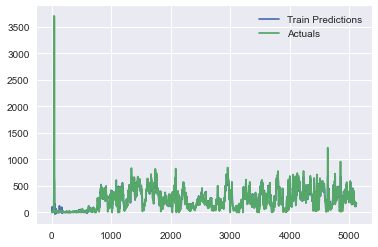

In [24]:
model = load_model('1H_Forecast/1H_ForecastModel_12_SizeWindow/')

X, y = DataHandler(1,12)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,shuffle=False) 
model.evaluate(X_test,y_test)

train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
plt.style.use('seaborn')

pd.concat([train_results['Train Predictions'],train_results['Actuals']],axis=1).plot()
plt.legend(['Train Predictions','Actuals'])

test_predictions = model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})

test_results.head(30)

### 2 hours forecast

In [25]:
%%time

Trainer(2,6,12)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_8 (Bidirection (None, 128)               35840     
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 9         
Total params: 36,881
Trainable params: 36,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
161/161 [==============================] - 11s 28ms/step - loss: 111457.8203 - mean_absolute_error: 248.8541 - val_loss: 151081.8906 - val_mean_absolute_error: 334.7755
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 2/100
161/161 [==============================] - 2s 13ms/step - loss: 110936.5156 - mean_absolute_error: 247.8173 - val_loss: 150131.7969 - val_mean_absolute_error: 333.2216
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 3/100
161/161 [==============================] - 2s 13ms/step - loss: 109538.3750 - mean_absolute_error: 245.0964 - val_loss: 147346.9062 - val_mean_absolute_error: 328.9561
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 4/100
161/161 [==============================] - 2s 14ms/step - loss: 107133.8672 - mean_absolute_error: 240.5131 - val_loss: 143673.9531 - val_mean_absolute_error: 323.3492
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 5/100
161/161 [==============================] - 2s 12ms/step - loss: 104083.8594 - mean_absolute_error: 234.8619 - val_loss: 138844.5781 - val_mean_absolute_error: 315.9577
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 6/100
161/161 [==============================] - 2s 12ms/step - loss: 100687.7031 - mean_absolute_error: 228.8625 - val_loss: 134384.2969 - val_mean_absolute_error: 308.9976
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 7/100
161/161 [==============================] - 2s 13ms/step - loss: 97503.4766 - mean_absolute_error: 223.2059 - val_loss: 129912.9219 - val_mean_absolute_error: 301.7839
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 8/100
161/161 [==============================] - 2s 13ms/step - loss: 94218.8828 - mean_absolute_error: 217.3833 - val_loss: 125176.2266 - val_mean_absolute_error: 294.0306
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 9/100
161/161 [==============================] - 2s 13ms/step - loss: 90875.2344 - mean_absolute_error: 211.3668 - val_loss: 120552.9375 - val_mean_absolute_error: 286.1574
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 10/100
161/161 [==============================] - 2s 11ms/step - loss: 87550.3750 - mean_absolute_error: 205.2603 - val_loss: 115841.2891 - val_mean_absolute_error: 278.1209
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 11/100
161/161 [==============================] - 2s 11ms/step - loss: 84349.9922 - mean_absolute_error: 199.5086 - val_loss: 111368.9375 - val_mean_absolute_error: 270.4152
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 12/100
161/161 [==============================] - 2s 12ms/step - loss: 81239.5469 - mean_absolute_error: 193.7566 - val_loss: 106952.3359 - val_mean_absolute_error: 262.7338
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 13/100
161/161 [==============================] - 2s 11ms/step - loss: 78185.1953 - mean_absolute_error: 188.1561 - val_loss: 102567.2969 - val_mean_absolute_error: 255.1424
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 14/100
161/161 [==============================] - 2s 16ms/step - loss: 75133.3906 - mean_absolute_error: 182.6184 - val_loss: 98084.8594 - val_mean_absolute_error: 247.4393
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 15/100
161/161 [==============================] - 2s 12ms/step - loss: 72089.4219 - mean_absolute_error: 176.7146 - val_loss: 93741.4766 - val_mean_absolute_error: 239.9951
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 16/100
161/161 [==============================] - 3s 16ms/step - loss: 69148.4688 - mean_absolute_error: 171.2222 - val_loss: 89376.7188 - val_mean_absolute_error: 232.5238
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 17/100
161/161 [==============================] - 2s 13ms/step - loss: 66177.5000 - mean_absolute_error: 164.8630 - val_loss: 85059.0234 - val_mean_absolute_error: 225.0238
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 18/100
161/161 [==============================] - 2s 12ms/step - loss: 63313.5430 - mean_absolute_error: 159.4425 - val_loss: 80919.6406 - val_mean_absolute_error: 217.6635
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 19/100
161/161 [==============================] - 2s 12ms/step - loss: 60616.7305 - mean_absolute_error: 154.2256 - val_loss: 76935.0938 - val_mean_absolute_error: 210.14700s - loss: 65540.2422 - mean_absolute_
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 20/100
161/161 [==============================] - 2s 11ms/step - loss: 58029.2227 - mean_absolute_error: 148.2919 - val_loss: 73090.5000 - val_mean_absolute_error: 202.8883
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 21/100
161/161 [==============================] - 2s 12ms/step - loss: 55534.4844 - mean_absolute_error: 143.2481 - val_loss: 69292.7656 - val_mean_absolute_error: 195.7336
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 22/100
161/161 [==============================] - 2s 11ms/step - loss: 53140.0547 - mean_absolute_error: 138.1093 - val_loss: 65621.7188 - val_mean_absolute_error: 188.9896
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 23/100
161/161 [==============================] - 2s 12ms/step - loss: 50811.4336 - mean_absolute_error: 133.2739 - val_loss: 62107.3906 - val_mean_absolute_error: 182.4139
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 24/100
161/161 [==============================] - 2s 13ms/step - loss: 48637.1445 - mean_absolute_error: 128.4988 - val_loss: 58748.8789 - val_mean_absolute_error: 176.1251
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 25/100
161/161 [==============================] - 2s 11ms/step - loss: 46566.7109 - mean_absolute_error: 124.1058 - val_loss: 55614.5117 - val_mean_absolute_error: 170.1285
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 26/100
161/161 [==============================] - 3s 20ms/step - loss: 44611.5156 - mean_absolute_error: 119.5379 - val_loss: 52536.9688 - val_mean_absolute_error: 164.4007
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 27/100
161/161 [==============================] - 2s 12ms/step - loss: 42780.4609 - mean_absolute_error: 115.7142 - val_loss: 49664.4023 - val_mean_absolute_error: 159.0792
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 28/100
161/161 [==============================] - 2s 11ms/step - loss: 41097.5586 - mean_absolute_error: 111.7608 - val_loss: 46780.2969 - val_mean_absolute_error: 153.5119
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 29/100
161/161 [==============================] - 3s 16ms/step - loss: 39347.5312 - mean_absolute_error: 107.9099 - val_loss: 44161.2461 - val_mean_absolute_error: 148.3191
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 30/100
161/161 [==============================] - 3s 16ms/step - loss: 37878.4961 - mean_absolute_error: 104.6340 - val_loss: 41595.2461 - val_mean_absolute_error: 143.3363
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 31/100
161/161 [==============================] - 3s 18ms/step - loss: 36338.0742 - mean_absolute_error: 100.8094 - val_loss: 39168.7773 - val_mean_absolute_error: 138.2927
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 32/100
161/161 [==============================] - 2s 14ms/step - loss: 34944.1484 - mean_absolute_error: 97.4225 - val_loss: 36817.1250 - val_mean_absolute_error: 133.4732
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 33/100
161/161 [==============================] - 4s 23ms/step - loss: 33652.8164 - mean_absolute_error: 94.2124 - val_loss: 34605.4961 - val_mean_absolute_error: 128.7357
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 34/100
161/161 [==============================] - 2s 15ms/step - loss: 32433.9336 - mean_absolute_error: 91.3592 - val_loss: 32626.1777 - val_mean_absolute_error: 124.1441
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 35/100
161/161 [==============================] - 3s 20ms/step - loss: 31312.5098 - mean_absolute_error: 88.2874 - val_loss: 30760.3145 - val_mean_absolute_error: 120.0148
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 36/100
161/161 [==============================] - 3s 17ms/step - loss: 30282.7109 - mean_absolute_error: 85.5980 - val_loss: 28965.9160 - val_mean_absolute_error: 115.9835
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 37/100
161/161 [==============================] - 3s 19ms/step - loss: 29279.8086 - mean_absolute_error: 83.3226 - val_loss: 27184.0000 - val_mean_absolute_error: 111.6360
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 38/100
161/161 [==============================] - 3s 19ms/step - loss: 28374.7695 - mean_absolute_error: 80.8113 - val_loss: 25689.8691 - val_mean_absolute_error: 108.1407
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 39/100
161/161 [==============================] - 3s 16ms/step - loss: 27520.8184 - mean_absolute_error: 78.4289 - val_loss: 24277.1543 - val_mean_absolute_error: 104.9813
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 40/100
161/161 [==============================] - 3s 16ms/step - loss: 26712.0430 - mean_absolute_error: 76.3752 - val_loss: 22806.1797 - val_mean_absolute_error: 101.0960
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 41/100
161/161 [==============================] - 4s 22ms/step - loss: 25924.3457 - mean_absolute_error: 73.9471 - val_loss: 21655.2480 - val_mean_absolute_error: 98.1776
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 42/100
161/161 [==============================] - 3s 19ms/step - loss: 25248.8281 - mean_absolute_error: 72.0745 - val_loss: 20316.9629 - val_mean_absolute_error: 94.4419
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 43/100
161/161 [==============================] - 3s 17ms/step - loss: 24631.0332 - mean_absolute_error: 70.1165 - val_loss: 19297.3633 - val_mean_absolute_error: 91.9590
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 44/100
161/161 [==============================] - 2s 15ms/step - loss: 24019.7910 - mean_absolute_error: 67.7623 - val_loss: 18254.7441 - val_mean_absolute_error: 89.0774
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 45/100
161/161 [==============================] - 3s 16ms/step - loss: 23493.5488 - mean_absolute_error: 66.6861 - val_loss: 17394.5352 - val_mean_absolute_error: 86.9182
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 46/100
161/161 [==============================] - 2s 15ms/step - loss: 22940.7441 - mean_absolute_error: 64.8160 - val_loss: 16417.1270 - val_mean_absolute_error: 83.9903
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 47/100
161/161 [==============================] - 3s 16ms/step - loss: 22463.5762 - mean_absolute_error: 63.0783 - val_loss: 15576.2246 - val_mean_absolute_error: 81.1686
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 48/100
161/161 [==============================] - 3s 17ms/step - loss: 22078.1836 - mean_absolute_error: 61.6006 - val_loss: 14812.6924 - val_mean_absolute_error: 79.1315
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 49/100
161/161 [==============================] - 3s 18ms/step - loss: 21666.2617 - mean_absolute_error: 60.8023 - val_loss: 14272.1416 - val_mean_absolute_error: 77.4891
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 50/100
161/161 [==============================] - 3s 16ms/step - loss: 21296.0547 - mean_absolute_error: 59.3276 - val_loss: 13741.4727 - val_mean_absolute_error: 75.8307
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 51/100
161/161 [==============================] - 2s 14ms/step - loss: 20972.0176 - mean_absolute_error: 58.0203 - val_loss: 12996.9180 - val_mean_absolute_error: 73.6320
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 52/100
161/161 [==============================] - 2s 15ms/step - loss: 20690.0391 - mean_absolute_error: 56.9940 - val_loss: 12577.0801 - val_mean_absolute_error: 72.7596
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 53/100
161/161 [==============================] - 3s 20ms/step - loss: 20394.7129 - mean_absolute_error: 56.5150 - val_loss: 12101.8848 - val_mean_absolute_error: 71.3131
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 54/100
161/161 [==============================] - 2s 16ms/step - loss: 20155.2891 - mean_absolute_error: 55.4559 - val_loss: 11889.3398 - val_mean_absolute_error: 71.0901
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 55/100
161/161 [==============================] - 3s 17ms/step - loss: 19902.9238 - mean_absolute_error: 54.3664 - val_loss: 11355.7539 - val_mean_absolute_error: 69.0730
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 56/100
161/161 [==============================] - 2s 14ms/step - loss: 19701.1016 - mean_absolute_error: 53.6134 - val_loss: 10939.9756 - val_mean_absolute_error: 67.6041
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 57/100
161/161 [==============================] - 3s 21ms/step - loss: 19504.0117 - mean_absolute_error: 52.7830 - val_loss: 10694.5537 - val_mean_absolute_error: 67.4719
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 58/100
161/161 [==============================] - 3s 16ms/step - loss: 19325.4961 - mean_absolute_error: 52.3881 - val_loss: 10319.6650 - val_mean_absolute_error: 66.2134
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 59/100
161/161 [==============================] - 3s 17ms/step - loss: 19133.6895 - mean_absolute_error: 51.5698 - val_loss: 9969.3018 - val_mean_absolute_error: 64.8964
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 60/100
161/161 [==============================] - 2s 14ms/step - loss: 19046.3223 - mean_absolute_error: 51.2685 - val_loss: 9648.3975 - val_mean_absolute_error: 64.0400
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 61/100
161/161 [==============================] - 3s 16ms/step - loss: 18910.1934 - mean_absolute_error: 50.6717 - val_loss: 9502.4580 - val_mean_absolute_error: 63.5935
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 62/100
161/161 [==============================] - 2s 15ms/step - loss: 18738.8203 - mean_absolute_error: 50.0662 - val_loss: 9124.1006 - val_mean_absolute_error: 61.8088
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 63/100
161/161 [==============================] - 2s 14ms/step - loss: 18600.7812 - mean_absolute_error: 49.6720 - val_loss: 9036.1592 - val_mean_absolute_error: 62.0882
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 64/100
161/161 [==============================] - 4s 23ms/step - loss: 18490.7734 - mean_absolute_error: 49.2436 - val_loss: 8998.1289 - val_mean_absolute_error: 62.3458
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 65/100
161/161 [==============================] - 3s 20ms/step - loss: 18396.7715 - mean_absolute_error: 48.8743 - val_loss: 8834.3076 - val_mean_absolute_error: 61.6269
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 66/100
161/161 [==============================] - 3s 16ms/step - loss: 18315.9219 - mean_absolute_error: 48.1788 - val_loss: 8445.8926 - val_mean_absolute_error: 60.3241
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 67/100
161/161 [==============================] - 2s 15ms/step - loss: 18208.9297 - mean_absolute_error: 48.1578 - val_loss: 8456.0518 - val_mean_absolute_error: 60.1751
Epoch 68/100
161/161 [==============================] - 2s 14ms/step - loss: 18171.5254 - mean_absolute_error: 47.8585 - val_loss: 8142.8052 - val_mean_absolute_error: 59.0161
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 69/100
161/161 [==============================] - 2s 11ms/step - loss: 18057.5527 - mean_absolute_error: 47.4267 - val_loss: 8056.6655 - val_mean_absolute_error: 58.7430
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 70/100
161/161 [==============================] - 2s 11ms/step - loss: 17950.4355 - mean_absolute_error: 46.9091 - val_loss: 7828.4390 - val_mean_absolute_error: 58.0805
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 71/100
161/161 [==============================] - 2s 12ms/step - loss: 17955.4355 - mean_absolute_error: 47.0677 - val_loss: 7784.5503 - val_mean_absolute_error: 58.0337
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 72/100
161/161 [==============================] - 2s 12ms/step - loss: 17860.6270 - mean_absolute_error: 46.7125 - val_loss: 7662.8203 - val_mean_absolute_error: 57.7422
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 73/100
161/161 [==============================] - 3s 18ms/step - loss: 17762.1660 - mean_absolute_error: 46.5133 - val_loss: 7404.7798 - val_mean_absolute_error: 56.2466
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 74/100
161/161 [==============================] - 6s 34ms/step - loss: 17871.4277 - mean_absolute_error: 46.6475 - val_loss: 7320.6978 - val_mean_absolute_error: 56.1192
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 75/100
161/161 [==============================] - 3s 18ms/step - loss: 17713.5840 - mean_absolute_error: 46.3732 - val_loss: 7686.9712 - val_mean_absolute_error: 57.9635
Epoch 76/100
161/161 [==============================] - 2s 15ms/step - loss: 17600.0645 - mean_absolute_error: 45.9905 - val_loss: 7109.9146 - val_mean_absolute_error: 55.4559
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 77/100
161/161 [==============================] - 2s 15ms/step - loss: 17562.0117 - mean_absolute_error: 45.7294 - val_loss: 7120.9849 - val_mean_absolute_error: 55.2434
Epoch 78/100
161/161 [==============================] - 3s 16ms/step - loss: 17528.3750 - mean_absolute_error: 45.6553 - val_loss: 6986.2588 - val_mean_absolute_error: 54.7232
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 79/100
161/161 [==============================] - 3s 16ms/step - loss: 17472.9570 - mean_absolute_error: 45.6493 - val_loss: 7217.3477 - val_mean_absolute_error: 56.0486
Epoch 80/100
161/161 [==============================] - 3s 17ms/step - loss: 17418.5996 - mean_absolute_error: 45.5302 - val_loss: 6916.2061 - val_mean_absolute_error: 54.5472
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 81/100
161/161 [==============================] - 2s 15ms/step - loss: 17369.3398 - mean_absolute_error: 45.0844 - val_loss: 6953.1499 - val_mean_absolute_error: 55.1198
Epoch 82/100
161/161 [==============================] - 3s 16ms/step - loss: 17326.4199 - mean_absolute_error: 45.2563 - val_loss: 6836.1499 - val_mean_absolute_error: 54.3681
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 83/100
161/161 [==============================] - 3s 18ms/step - loss: 17257.4434 - mean_absolute_error: 44.6749 - val_loss: 6660.8550 - val_mean_absolute_error: 53.4042
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 84/100
161/161 [==============================] - 3s 19ms/step - loss: 17206.9492 - mean_absolute_error: 44.7957 - val_loss: 6471.3076 - val_mean_absolute_error: 53.2426
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 85/100
161/161 [==============================] - 2s 15ms/step - loss: 17239.1484 - mean_absolute_error: 44.7924 - val_loss: 6547.0713 - val_mean_absolute_error: 53.4915
Epoch 86/100
161/161 [==============================] - 3s 17ms/step - loss: 17247.3887 - mean_absolute_error: 45.3395 - val_loss: 6326.4136 - val_mean_absolute_error: 52.1981
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 87/100
161/161 [==============================] - 4s 23ms/step - loss: 17134.8516 - mean_absolute_error: 44.2451 - val_loss: 6095.6953 - val_mean_absolute_error: 51.8951
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 88/100
161/161 [==============================] - 3s 18ms/step - loss: 17094.7832 - mean_absolute_error: 44.4070 - val_loss: 6203.0894 - val_mean_absolute_error: 52.0536
Epoch 89/100
161/161 [==============================] - 2s 15ms/step - loss: 17032.4473 - mean_absolute_error: 44.4703 - val_loss: 6283.6348 - val_mean_absolute_error: 52.3899
Epoch 90/100
161/161 [==============================] - 3s 16ms/step - loss: 17171.4844 - mean_absolute_error: 44.8399 - val_loss: 6067.9268 - val_mean_absolute_error: 51.4604
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 91/100
161/161 [==============================] - 3s 18ms/step - loss: 17076.8125 - mean_absolute_error: 44.6253 - val_loss: 6342.8833 - val_mean_absolute_error: 52.9644
Epoch 92/100
161/161 [==============================] - 2s 15ms/step - loss: 16992.2246 - mean_absolute_error: 44.1423 - val_loss: 6038.3970 - val_mean_absolute_error: 51.3971
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 93/100
161/161 [==============================] - 3s 16ms/step - loss: 16921.2637 - mean_absolute_error: 43.9701 - val_loss: 6046.2612 - val_mean_absolute_error: 51.5851
Epoch 94/100
161/161 [==============================] - 2s 15ms/step - loss: 16846.0488 - mean_absolute_error: 44.0580 - val_loss: 6101.6284 - val_mean_absolute_error: 51.3300
Epoch 95/100
161/161 [==============================] - 3s 17ms/step - loss: 16827.1953 - mean_absolute_error: 43.8166 - val_loss: 6090.3745 - val_mean_absolute_error: 51.5737
Epoch 96/100
161/161 [==============================] - 3s 16ms/step - loss: 16804.8145 - mean_absolute_error: 43.6489 - val_loss: 6265.7217 - val_mean_absolute_error: 52.3187
Epoch 97/100
161/161 [==============================] - 2s 15ms/step - loss: 16783.6387 - mean_absolute_error: 43.8674 - val_loss: 6157.3999 - val_mean_absolute_error: 51.6258
Epoch 98/100
161/161 [==============================] - 2s 15ms/step - loss: 16722.0977 - mean_absolute_error: 43.6412 -

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 99/100
161/161 [==============================] - 3s 17ms/step - loss: 16715.7578 - mean_absolute_error: 43.5772 - val_loss: 5968.1431 - val_mean_absolute_error: 51.0902
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 100/100
161/161 [==============================] - 2s 15ms/step - loss: 16728.7383 - mean_absolute_error: 43.3885 - val_loss: 5792.7065 - val_mean_absolute_error: 50.5473
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_9 (Bidirection (None, 128)               35840     
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 9         
Total params: 36,881
Trainable params: 36,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
161/161 [==============================] - 10s 26ms/step - loss: 111097.3047 - mean_absolute_error: 248.1149 - val_loss: 150162.0781 - val_mean_absolute_error: 333.3631
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 2/100
161/161 [==============================] - 3s 19ms/step - loss: 109582.9922 - mean_absolute_error: 245.1793 - val_loss: 147331.5938 - val_mean_absolute_error: 328.9165
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 3/100
161/161 [==============================] - 3s 18ms/step - loss: 107259.8750 - mean_absolute_error: 240.6209 - val_loss: 143771.0469 - val_mean_absolute_error: 323.4591
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 4/100
161/161 [==============================] - 3s 17ms/step - loss: 104482.4453 - mean_absolute_error: 235.6131 - val_loss: 140027.0781 - val_mean_absolute_error: 317.7751
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 5/100
161/161 [==============================] - 3s 18ms/step - loss: 101665.6406 - mean_absolute_error: 230.6326 - val_loss: 135930.3594 - val_mean_absolute_error: 311.2552
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 6/100
161/161 [==============================] - 3s 22ms/step - loss: 98615.9688 - mean_absolute_error: 225.1048 - val_loss: 131387.5000 - val_mean_absolute_error: 303.9744
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 7/100
161/161 [==============================] - 3s 19ms/step - loss: 95084.6094 - mean_absolute_error: 218.8986 - val_loss: 126366.7109 - val_mean_absolute_error: 295.80960s - loss: 96756.7656 - mean_absolute_error: 220.
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 8/100
161/161 [==============================] - 3s 18ms/step - loss: 91641.1406 - mean_absolute_error: 212.5273 - val_loss: 121669.5156 - val_mean_absolute_error: 287.8561ute_error: 212
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 9/100
161/161 [==============================] - 3s 20ms/step - loss: 88152.1094 - mean_absolute_error: 206.3591 - val_loss: 116494.4531 - val_mean_absolute_error: 279.1718mean_absolute_e
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 10/100
161/161 [==============================] - 5s 32ms/step - loss: 84740.2188 - mean_absolute_error: 200.2523 - val_loss: 111871.0156 - val_mean_absolute_error: 271.2454- loss: 65434.9648 - mean_absolute_e - ETA: 2s - loss: 78365.2734 - mea - ETA: 1s - loss: 80263.9297 - mean_absolute_error: 200. - ETA: 1s - loss: 82562.3906 - mean_absolute_e
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 11/100
161/161 [==============================] - 4s 26ms/step - loss: 81574.0703 - mean_absolute_error: 194.4483 - val_loss: 107458.6250 - val_mean_absolute_error: 263.5936
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 12/100
161/161 [==============================] - 4s 24ms/step - loss: 78574.1953 - mean_absolute_error: 189.0488 - val_loss: 103159.8203 - val_mean_absolute_error: 256.1642
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 13/100
161/161 [==============================] - 5s 30ms/step - loss: 75600.6797 - mean_absolute_error: 183.4517 - val_loss: 98895.3516 - val_mean_absolute_error: 248.8321
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 14/100
161/161 [==============================] - 4s 28ms/step - loss: 72767.2344 - mean_absolute_error: 177.6327 - val_loss: 94860.7109 - val_mean_absolute_error: 241.9620
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 15/100
161/161 [==============================] - 4s 24ms/step - loss: 70042.9688 - mean_absolute_error: 172.8823 - val_loss: 90825.2109 - val_mean_absolute_error: 235.0177A: 2s - loss: 75349.375
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 16/100
161/161 [==============================] - 3s 21ms/step - loss: 67239.2734 - mean_absolute_error: 167.3216 - val_loss: 86770.2969 - val_mean_absolute_error: 228.0864
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 17/100
161/161 [==============================] - 4s 27ms/step - loss: 64607.9922 - mean_absolute_error: 161.9354 - val_loss: 82910.3125 - val_mean_absolute_error: 221.2940
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 18/100
161/161 [==============================] - 3s 20ms/step - loss: 62076.4531 - mean_absolute_error: 157.1138 - val_loss: 79182.7656 - val_mean_absolute_error: 214.6096
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 19/100
161/161 [==============================] - 3s 19ms/step - loss: 59579.9258 - mean_absolute_error: 151.8952 - val_loss: 75459.9375 - val_mean_absolute_error: 207.7054
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 20/100
161/161 [==============================] - 4s 24ms/step - loss: 57207.5000 - mean_absolute_error: 147.1096 - val_loss: 71962.5938 - val_mean_absolute_error: 201.2833
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 21/100
161/161 [==============================] - 4s 24ms/step - loss: 54906.7031 - mean_absolute_error: 142.0938 - val_loss: 68507.7812 - val_mean_absolute_error: 194.7190
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 22/100
161/161 [==============================] - 3s 21ms/step - loss: 52627.9141 - mean_absolute_error: 136.8603 - val_loss: 65026.9883 - val_mean_absolute_error: 188.2359
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 23/100
161/161 [==============================] - 3s 19ms/step - loss: 50518.5195 - mean_absolute_error: 132.3030 - val_loss: 61837.9336 - val_mean_absolute_error: 182.3607
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 24/100
161/161 [==============================] - 4s 27ms/step - loss: 48439.8906 - mean_absolute_error: 128.3225 - val_loss: 58504.6758 - val_mean_absolute_error: 176.2062
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 25/100
161/161 [==============================] - 4s 25ms/step - loss: 46484.3438 - mean_absolute_error: 123.7928 - val_loss: 55540.9023 - val_mean_absolute_error: 170.5883
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 26/100
161/161 [==============================] - 4s 23ms/step - loss: 44629.2695 - mean_absolute_error: 119.3388 - val_loss: 52618.7031 - val_mean_absolute_error: 165.1126
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 27/100
161/161 [==============================] - 12s 77ms/step - loss: 42837.9336 - mean_absolute_error: 115.5328 - val_loss: 49898.6133 - val_mean_absolute_error: 160.1749
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 28/100
161/161 [==============================] - 3s 19ms/step - loss: 41238.0742 - mean_absolute_error: 111.8380 - val_loss: 47255.0391 - val_mean_absolute_error: 155.0018
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 29/100
161/161 [==============================] - 4s 24ms/step - loss: 39650.6250 - mean_absolute_error: 108.0110 - val_loss: 44797.7422 - val_mean_absolute_error: 150.1544
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 30/100
161/161 [==============================] - 3s 18ms/step - loss: 38165.6836 - mean_absolute_error: 104.2717 - val_loss: 42376.7305 - val_mean_absolute_error: 145.3754
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 31/100
161/161 [==============================] - 3s 21ms/step - loss: 36750.6836 - mean_absolute_error: 101.2169 - val_loss: 40198.2617 - val_mean_absolute_error: 140.9984
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 32/100
161/161 [==============================] - 3s 19ms/step - loss: 35618.0078 - mean_absolute_error: 98.3771 - val_loss: 38183.3320 - val_mean_absolute_error: 137.1278
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 33/100
161/161 [==============================] - 3s 20ms/step - loss: 34309.3086 - mean_absolute_error: 95.2990 - val_loss: 36202.8672 - val_mean_absolute_error: 132.8898
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 34/100
161/161 [==============================] - 3s 21ms/step - loss: 33165.2773 - mean_absolute_error: 92.3759 - val_loss: 34171.9180 - val_mean_absolute_error: 128.5003
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 35/100
161/161 [==============================] - 3s 19ms/step - loss: 32108.3652 - mean_absolute_error: 90.1442 - val_loss: 32392.9766 - val_mean_absolute_error: 124.5849
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 36/100
161/161 [==============================] - 3s 20ms/step - loss: 31131.8906 - mean_absolute_error: 87.6990 - val_loss: 30588.5215 - val_mean_absolute_error: 120.6735
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 37/100
161/161 [==============================] - 3s 20ms/step - loss: 30164.4941 - mean_absolute_error: 85.3340 - val_loss: 28954.5762 - val_mean_absolute_error: 116.7636
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 38/100
161/161 [==============================] - 4s 24ms/step - loss: 29352.2773 - mean_absolute_error: 83.7357 - val_loss: 27413.7734 - val_mean_absolute_error: 113.0564
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 39/100
161/161 [==============================] - 4s 25ms/step - loss: 28472.1836 - mean_absolute_error: 80.5485 - val_loss: 25790.3184 - val_mean_absolute_error: 109.0235
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 40/100
161/161 [==============================] - 3s 21ms/step - loss: 27647.2715 - mean_absolute_error: 78.3039 - val_loss: 24607.2832 - val_mean_absolute_error: 106.1624
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 41/100
161/161 [==============================] - 4s 23ms/step - loss: 26878.6562 - mean_absolute_error: 76.2826 - val_loss: 23067.7637 - val_mean_absolute_error: 102.3154
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 42/100
161/161 [==============================] - 3s 18ms/step - loss: 26166.6855 - mean_absolute_error: 74.2813 - val_loss: 22043.2363 - val_mean_absolute_error: 99.5365
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 43/100
161/161 [==============================] - 3s 18ms/step - loss: 25445.3789 - mean_absolute_error: 71.9009 - val_loss: 20638.0371 - val_mean_absolute_error: 95.9201
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 44/100
161/161 [==============================] - 4s 22ms/step - loss: 24758.7637 - mean_absolute_error: 69.9218 - val_loss: 19263.4355 - val_mean_absolute_error: 92.1518
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 45/100
161/161 [==============================] - 3s 20ms/step - loss: 24224.7441 - mean_absolute_error: 69.0653 - val_loss: 18373.4648 - val_mean_absolute_error: 89.8493
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 46/100
161/161 [==============================] - 3s 20ms/step - loss: 23648.2148 - mean_absolute_error: 66.9496 - val_loss: 17513.7461 - val_mean_absolute_error: 87.4913
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 47/100
161/161 [==============================] - 3s 19ms/step - loss: 23153.0547 - mean_absolute_error: 65.3340 - val_loss: 16677.6367 - val_mean_absolute_error: 85.2958
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 48/100
161/161 [==============================] - 4s 25ms/step - loss: 22708.2441 - mean_absolute_error: 64.0462 - val_loss: 15844.1846 - val_mean_absolute_error: 82.7473
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 49/100
161/161 [==============================] - 3s 19ms/step - loss: 22297.9805 - mean_absolute_error: 62.6460 - val_loss: 15104.2998 - val_mean_absolute_error: 80.5348
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 50/100
161/161 [==============================] - 3s 16ms/step - loss: 21981.1602 - mean_absolute_error: 61.7095 - val_loss: 14427.5801 - val_mean_absolute_error: 78.6057
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 51/100
161/161 [==============================] - 3s 21ms/step - loss: 21664.5547 - mean_absolute_error: 60.9638 - val_loss: 13724.2393 - val_mean_absolute_error: 76.3022
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 52/100
161/161 [==============================] - 3s 17ms/step - loss: 21291.3574 - mean_absolute_error: 59.1588 - val_loss: 13248.2979 - val_mean_absolute_error: 75.2694
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 53/100
161/161 [==============================] - 2s 15ms/step - loss: 20955.5664 - mean_absolute_error: 58.0166 - val_loss: 12696.6709 - val_mean_absolute_error: 73.4075
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 54/100
161/161 [==============================] - 3s 18ms/step - loss: 20674.6777 - mean_absolute_error: 57.0250 - val_loss: 12255.2451 - val_mean_absolute_error: 72.0324
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 55/100
161/161 [==============================] - 3s 21ms/step - loss: 20407.8555 - mean_absolute_error: 55.9724 - val_loss: 11735.6230 - val_mean_absolute_error: 70.3777
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 56/100
161/161 [==============================] - 2s 15ms/step - loss: 20170.7773 - mean_absolute_error: 55.1441 - val_loss: 11399.0273 - val_mean_absolute_error: 69.5887
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 57/100
161/161 [==============================] - 3s 18ms/step - loss: 19949.0430 - mean_absolute_error: 54.2906 - val_loss: 10916.1367 - val_mean_absolute_error: 67.8234
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 58/100
161/161 [==============================] - 3s 17ms/step - loss: 19725.4785 - mean_absolute_error: 53.7261 - val_loss: 10517.5244 - val_mean_absolute_error: 66.4384
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 59/100
161/161 [==============================] - 3s 17ms/step - loss: 19548.5254 - mean_absolute_error: 52.7945 - val_loss: 10233.7568 - val_mean_absolute_error: 65.6457
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 60/100
161/161 [==============================] - 3s 16ms/step - loss: 19334.0156 - mean_absolute_error: 52.0821 - val_loss: 9900.7646 - val_mean_absolute_error: 63.9728
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 61/100
161/161 [==============================] - 3s 20ms/step - loss: 19238.3516 - mean_absolute_error: 51.5736 - val_loss: 9582.6064 - val_mean_absolute_error: 63.5344
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 62/100
161/161 [==============================] - 4s 23ms/step - loss: 19067.4570 - mean_absolute_error: 51.2121 - val_loss: 9489.0410 - val_mean_absolute_error: 63.0201
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 63/100
161/161 [==============================] - 4s 28ms/step - loss: 18990.6660 - mean_absolute_error: 50.6900 - val_loss: 9161.8525 - val_mean_absolute_error: 61.8352
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 64/100
161/161 [==============================] - 6s 36ms/step - loss: 18805.0977 - mean_absolute_error: 49.6099 - val_loss: 8895.0977 - val_mean_absolute_error: 61.0357
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 65/100
161/161 [==============================] - 4s 25ms/step - loss: 18680.4219 - mean_absolute_error: 49.4493 - val_loss: 9060.5361 - val_mean_absolute_error: 61.5669
Epoch 66/100
161/161 [==============================] - 5s 30ms/step - loss: 18544.9551 - mean_absolute_error: 48.9544 - val_loss: 8556.7939 - val_mean_absolute_error: 59.7040
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 67/100
161/161 [==============================] - 4s 27ms/step - loss: 18423.4160 - mean_absolute_error: 48.5609 - val_loss: 8508.7783 - val_mean_absolute_error: 59.6043mean_absolute_er - ETA
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 68/100
161/161 [==============================] - 5s 29ms/step - loss: 18310.4688 - mean_absolute_error: 47.9772 - val_loss: 8294.0371 - val_mean_absolute_error: 58.77770s - loss: 19418.3711 - mean_absolute_error: 48. - ETA: 0s - loss: 18903.3262 - mean_absolute_error: 4
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 69/100
161/161 [==============================] - 4s 27ms/step - loss: 18202.2754 - mean_absolute_error: 47.7945 - val_loss: 8168.0005 - val_mean_absolute_error: 58.4557
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 70/100
161/161 [==============================] - 4s 27ms/step - loss: 18235.5449 - mean_absolute_error: 47.8927 - val_loss: 7900.8481 - val_mean_absolute_error: 57.4509
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 71/100
161/161 [==============================] - 5s 29ms/step - loss: 18066.2188 - mean_absolute_error: 47.2867 - val_loss: 8213.8701 - val_mean_absolute_error: 58.5077
Epoch 72/100
161/161 [==============================] - 5s 31ms/step - loss: 17948.7891 - mean_absolute_error: 46.7702 - val_loss: 7992.2793 - val_mean_absolute_error: 57.5504
Epoch 73/100
161/161 [==============================] - 4s 25ms/step - loss: 17865.2812 - mean_absolute_error: 46.3943 - val_loss: 7796.5156 - val_mean_absolute_error: 57.2981
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 74/100
161/161 [==============================] - 2s 15ms/step - loss: 17795.9141 - mean_absolute_error: 46.0934 - val_loss: 7809.1128 - val_mean_absolute_error: 57.3558
Epoch 75/100
161/161 [==============================] - 2s 14ms/step - loss: 17701.5293 - mean_absolute_error: 45.9886 - val_loss: 7740.0923 - val_mean_absolute_error: 56.8920
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 76/100
161/161 [==============================] - 2s 15ms/step - loss: 17649.6484 - mean_absolute_error: 45.6958 - val_loss: 7524.7378 - val_mean_absolute_error: 55.8925
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 77/100
161/161 [==============================] - 4s 22ms/step - loss: 17599.1289 - mean_absolute_error: 45.4315 - val_loss: 7694.3711 - val_mean_absolute_error: 56.6678
Epoch 78/100
161/161 [==============================] - 2s 15ms/step - loss: 17550.7949 - mean_absolute_error: 45.3720 - val_loss: 7101.9224 - val_mean_absolute_error: 54.7577
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 79/100
161/161 [==============================] - 2s 15ms/step - loss: 17474.2246 - mean_absolute_error: 45.1351 - val_loss: 7180.2329 - val_mean_absolute_error: 54.9074
Epoch 80/100
161/161 [==============================] - 2s 15ms/step - loss: 17397.5664 - mean_absolute_error: 44.8609 - val_loss: 7114.5229 - val_mean_absolute_error: 54.9319
Epoch 81/100
161/161 [==============================] - 2s 14ms/step - loss: 17362.3262 - mean_absolute_error: 44.7133 - val_loss: 7163.1616 - val_mean_absolute_error: 55.0475
Epoch 82/100
161/161 [==============================] - 2s 15ms/step - loss: 17338.2324 - mean_absolute_error: 44.6701 - val_loss: 6963.0166 - val_mean_absolute_error: 54.3875
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 83/100
161/161 [==============================] - 2s 13ms/step - loss: 17347.2285 - mean_absolute_error: 44.8481 - val_loss: 6918.1685 - val_mean_absolute_error: 54.0837
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 84/100
161/161 [==============================] - 2s 13ms/step - loss: 17217.0762 - mean_absolute_error: 44.3173 - val_loss: 6834.9551 - val_mean_absolute_error: 53.5218
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 85/100
161/161 [==============================] - 2s 15ms/step - loss: 17155.7715 - mean_absolute_error: 44.1407 - val_loss: 6746.6909 - val_mean_absolute_error: 53.4960
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 86/100
161/161 [==============================] - 3s 16ms/step - loss: 17085.1074 - mean_absolute_error: 43.8392 - val_loss: 6752.5732 - val_mean_absolute_error: 53.5988
Epoch 87/100
161/161 [==============================] - 2s 14ms/step - loss: 17067.9570 - mean_absolute_error: 43.8325 - val_loss: 6596.7998 - val_mean_absolute_error: 52.9232
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 88/100
161/161 [==============================] - 3s 18ms/step - loss: 17008.8359 - mean_absolute_error: 43.6251 - val_loss: 6670.3179 - val_mean_absolute_error: 53.5906
Epoch 89/100
161/161 [==============================] - 3s 16ms/step - loss: 16939.2695 - mean_absolute_error: 43.6491 - val_loss: 6442.4863 - val_mean_absolute_error: 52.4865
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 90/100
161/161 [==============================] - 3s 19ms/step - loss: 16883.7246 - mean_absolute_error: 43.5448 - val_loss: 6515.9990 - val_mean_absolute_error: 52.6970
Epoch 91/100
161/161 [==============================] - 3s 20ms/step - loss: 16878.5801 - mean_absolute_error: 43.4486 - val_loss: 6423.6494 - val_mean_absolute_error: 52.4891
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 92/100
161/161 [==============================] - 3s 18ms/step - loss: 16822.0352 - mean_absolute_error: 43.1388 - val_loss: 6385.4106 - val_mean_absolute_error: 52.3397
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 93/100
161/161 [==============================] - 2s 15ms/step - loss: 16822.3594 - mean_absolute_error: 43.4034 - val_loss: 6305.3257 - val_mean_absolute_error: 52.1127
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 94/100
161/161 [==============================] - 2s 15ms/step - loss: 16730.7480 - mean_absolute_error: 42.9976 - val_loss: 6135.8296 - val_mean_absolute_error: 51.6342
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 95/100
161/161 [==============================] - 3s 16ms/step - loss: 16712.5820 - mean_absolute_error: 43.1048 - val_loss: 6304.6084 - val_mean_absolute_error: 52.2799
Epoch 96/100
161/161 [==============================] - 2s 15ms/step - loss: 16736.4082 - mean_absolute_error: 42.8500 - val_loss: 6487.7524 - val_mean_absolute_error: 52.7365
Epoch 97/100
161/161 [==============================] - 2s 14ms/step - loss: 16747.9297 - mean_absolute_error: 43.2082 - val_loss: 6420.5684 - val_mean_absolute_error: 52.6676
Epoch 98/100
161/161 [==============================] - 2s 15ms/step - loss: 16671.2520 - mean_absolute_error: 42.5200 - val_loss: 6249.8887 - val_mean_absolute_error: 51.9481
Epoch 99/100
161/161 [==============================] - 2s 14ms/step - loss: 16627.7930 - mean_absolute_error: 42.6409 - val_loss: 6406.4443 - val_mean_absolute_error: 52.6728
Epoch 100/100
161/161 [==============================] - 2s 14ms/step - loss: 16559.2129 - mean_absolute_error: 42.4407 

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_10 (Bidirectio (None, 128)               35840     
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 9         
Total params: 36,881
Trainable params: 36,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
161/161 [==============================] - 10s 24ms/step - loss: 111373.2109 - mean_absolute_error: 248.7831 - val_loss: 150350.8906 - val_mean_absolute_error: 333.7172
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 2/100
161/161 [==============================] - 3s 18ms/step - loss: 109662.6484 - mean_absolute_error: 245.5229 - val_loss: 147342.1094 - val_mean_absolute_error: 329.1060
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 3/100
161/161 [==============================] - 3s 19ms/step - loss: 107228.6641 - mean_absolute_error: 240.7729 - val_loss: 143829.7500 - val_mean_absolute_error: 323.4086
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 4/100
161/161 [==============================] - 2s 15ms/step - loss: 104187.8672 - mean_absolute_error: 234.9926 - val_loss: 139412.6719 - val_mean_absolute_error: 316.7106
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 5/100
161/161 [==============================] - 2s 13ms/step - loss: 101229.9062 - mean_absolute_error: 229.7254 - val_loss: 135435.8594 - val_mean_absolute_error: 310.4048
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 6/100
161/161 [==============================] - 3s 21ms/step - loss: 97999.0078 - mean_absolute_error: 223.8664 - val_loss: 130468.6953 - val_mean_absolute_error: 302.4959
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 7/100
161/161 [==============================] - 3s 16ms/step - loss: 94571.6719 - mean_absolute_error: 217.8233 - val_loss: 125836.3359 - val_mean_absolute_error: 294.9726
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 8/100
161/161 [==============================] - 3s 16ms/step - loss: 91302.3359 - mean_absolute_error: 212.0146 - val_loss: 121297.8203 - val_mean_absolute_error: 287.3564
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 9/100
161/161 [==============================] - 3s 17ms/step - loss: 88082.3203 - mean_absolute_error: 206.0670 - val_loss: 116771.6641 - val_mean_absolute_error: 279.5405
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 10/100
161/161 [==============================] - 3s 20ms/step - loss: 84889.0703 - mean_absolute_error: 200.4965 - val_loss: 112305.0078 - val_mean_absolute_error: 271.9165
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 11/100
161/161 [==============================] - 7s 41ms/step - loss: 81808.1250 - mean_absolute_error: 194.7213 - val_loss: 108018.0625 - val_mean_absolute_error: 264.4969
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 12/100
161/161 [==============================] - 4s 25ms/step - loss: 78770.9453 - mean_absolute_error: 189.3356 - val_loss: 103754.1250 - val_mean_absolute_error: 257.1378
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 13/100
161/161 [==============================] - 3s 18ms/step - loss: 75880.5703 - mean_absolute_error: 183.9244 - val_loss: 99600.9844 - val_mean_absolute_error: 250.0298
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 14/100
161/161 [==============================] - 2s 15ms/step - loss: 73027.6328 - mean_absolute_error: 178.5328 - val_loss: 95524.5781 - val_mean_absolute_error: 243.1123
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 15/100
161/161 [==============================] - 3s 20ms/step - loss: 70243.1484 - mean_absolute_error: 173.2454 - val_loss: 91443.2656 - val_mean_absolute_error: 236.1766
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 16/100
161/161 [==============================] - 3s 18ms/step - loss: 67445.9453 - mean_absolute_error: 167.8525 - val_loss: 87228.6016 - val_mean_absolute_error: 229.0030
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 17/100
161/161 [==============================] - 4s 23ms/step - loss: 64702.3516 - mean_absolute_error: 162.8417 - val_loss: 83339.2188 - val_mean_absolute_error: 222.2365
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 18/100
161/161 [==============================] - 2s 14ms/step - loss: 62157.1016 - mean_absolute_error: 157.6672 - val_loss: 79558.0703 - val_mean_absolute_error: 215.5579
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 19/100
161/161 [==============================] - 3s 18ms/step - loss: 59646.6953 - mean_absolute_error: 152.8090 - val_loss: 75770.2422 - val_mean_absolute_error: 208.5686
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 20/100
161/161 [==============================] - 3s 17ms/step - loss: 57174.1211 - mean_absolute_error: 147.0196 - val_loss: 71889.5938 - val_mean_absolute_error: 201.4042
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 21/100
161/161 [==============================] - 3s 16ms/step - loss: 54681.7539 - mean_absolute_error: 142.1799 - val_loss: 67995.9609 - val_mean_absolute_error: 194.2265
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 22/100
161/161 [==============================] - 4s 24ms/step - loss: 52190.9062 - mean_absolute_error: 137.0156 - val_loss: 64394.2578 - val_mean_absolute_error: 187.5925
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 23/100
161/161 [==============================] - 3s 21ms/step - loss: 49942.8945 - mean_absolute_error: 131.5123 - val_loss: 61050.0703 - val_mean_absolute_error: 181.3515
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 24/100
161/161 [==============================] - 3s 17ms/step - loss: 47825.3867 - mean_absolute_error: 127.3283 - val_loss: 57809.4648 - val_mean_absolute_error: 175.5534
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 25/100
161/161 [==============================] - 3s 21ms/step - loss: 45815.2656 - mean_absolute_error: 122.9554 - val_loss: 54717.2070 - val_mean_absolute_error: 170.0150
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 26/100
161/161 [==============================] - 3s 21ms/step - loss: 43987.3438 - mean_absolute_error: 118.8288 - val_loss: 51843.9141 - val_mean_absolute_error: 164.3751
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 27/100
161/161 [==============================] - 3s 20ms/step - loss: 42236.2656 - mean_absolute_error: 114.5519 - val_loss: 48977.0820 - val_mean_absolute_error: 159.3705
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 28/100
161/161 [==============================] - 3s 21ms/step - loss: 40574.6602 - mean_absolute_error: 111.4682 - val_loss: 46375.6914 - val_mean_absolute_error: 154.2881
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 29/100
161/161 [==============================] - 4s 24ms/step - loss: 39052.9766 - mean_absolute_error: 107.4436 - val_loss: 43905.1562 - val_mean_absolute_error: 149.6549
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 30/100
161/161 [==============================] - 4s 25ms/step - loss: 37560.8711 - mean_absolute_error: 104.5012 - val_loss: 41562.5430 - val_mean_absolute_error: 144.8344
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 31/100
161/161 [==============================] - 4s 24ms/step - loss: 36236.5312 - mean_absolute_error: 101.0607 - val_loss: 39297.8750 - val_mean_absolute_error: 140.3328
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 32/100
161/161 [==============================] - 3s 21ms/step - loss: 34936.9648 - mean_absolute_error: 97.7021 - val_loss: 37486.4531 - val_mean_absolute_error: 136.6849
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 33/100
161/161 [==============================] - 3s 18ms/step - loss: 33666.6680 - mean_absolute_error: 95.1400 - val_loss: 35172.0039 - val_mean_absolute_error: 131.3956
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 34/100
161/161 [==============================] - 4s 23ms/step - loss: 32463.3340 - mean_absolute_error: 91.7614 - val_loss: 33124.9570 - val_mean_absolute_error: 126.6380
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 35/100
161/161 [==============================] - 4s 22ms/step - loss: 31319.1309 - mean_absolute_error: 88.7933 - val_loss: 31279.5762 - val_mean_absolute_error: 122.6107
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 36/100
161/161 [==============================] - 4s 25ms/step - loss: 30265.3379 - mean_absolute_error: 86.5114 - val_loss: 29280.0781 - val_mean_absolute_error: 118.2170
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 37/100
161/161 [==============================] - 3s 21ms/step - loss: 29315.2324 - mean_absolute_error: 83.8031 - val_loss: 27558.9141 - val_mean_absolute_error: 114.1811
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 38/100
161/161 [==============================] - 4s 27ms/step - loss: 28447.9727 - mean_absolute_error: 82.4832 - val_loss: 26559.3984 - val_mean_absolute_error: 111.5106
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 39/100
161/161 [==============================] - 4s 24ms/step - loss: 27647.7852 - mean_absolute_error: 79.5721 - val_loss: 24772.6855 - val_mean_absolute_error: 107.1726
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 40/100
161/161 [==============================] - 4s 27ms/step - loss: 26850.2188 - mean_absolute_error: 77.3495 - val_loss: 23573.8594 - val_mean_absolute_error: 104.0951
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 41/100
161/161 [==============================] - 3s 20ms/step - loss: 26105.0156 - mean_absolute_error: 75.3557 - val_loss: 22453.5996 - val_mean_absolute_error: 101.0341
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 42/100
161/161 [==============================] - 3s 20ms/step - loss: 25430.0645 - mean_absolute_error: 73.2441 - val_loss: 21094.9609 - val_mean_absolute_error: 97.8277
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 43/100
161/161 [==============================] - 3s 21ms/step - loss: 24817.3906 - mean_absolute_error: 71.7885 - val_loss: 19934.3672 - val_mean_absolute_error: 94.4719
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 44/100
161/161 [==============================] - 3s 21ms/step - loss: 24201.5508 - mean_absolute_error: 69.8433 - val_loss: 18981.8184 - val_mean_absolute_error: 91.8653
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 45/100
161/161 [==============================] - 3s 22ms/step - loss: 23681.7871 - mean_absolute_error: 68.4708 - val_loss: 18324.1270 - val_mean_absolute_error: 90.3709
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 46/100
161/161 [==============================] - 3s 17ms/step - loss: 23188.7676 - mean_absolute_error: 66.8934 - val_loss: 17462.8516 - val_mean_absolute_error: 87.7769
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 47/100
161/161 [==============================] - 3s 18ms/step - loss: 22707.9199 - mean_absolute_error: 65.3066 - val_loss: 16706.6660 - val_mean_absolute_error: 85.7903
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 48/100
161/161 [==============================] - 3s 21ms/step - loss: 22289.4941 - mean_absolute_error: 63.9466 - val_loss: 16121.9287 - val_mean_absolute_error: 84.1149
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 49/100
161/161 [==============================] - 3s 19ms/step - loss: 21871.4883 - mean_absolute_error: 62.5195 - val_loss: 14925.6348 - val_mean_absolute_error: 80.1909
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 50/100
161/161 [==============================] - 3s 20ms/step - loss: 21457.3242 - mean_absolute_error: 61.3306 - val_loss: 14528.0430 - val_mean_absolute_error: 79.3236
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 51/100
161/161 [==============================] - 4s 23ms/step - loss: 21108.7031 - mean_absolute_error: 60.1174 - val_loss: 14133.9307 - val_mean_absolute_error: 78.1315
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 52/100
161/161 [==============================] - 3s 17ms/step - loss: 20815.9883 - mean_absolute_error: 59.1737 - val_loss: 13323.5039 - val_mean_absolute_error: 75.5524
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 53/100
161/161 [==============================] - 3s 19ms/step - loss: 20571.2617 - mean_absolute_error: 58.3085 - val_loss: 13172.4805 - val_mean_absolute_error: 75.0956
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 54/100
161/161 [==============================] - 3s 18ms/step - loss: 20305.6406 - mean_absolute_error: 57.2313 - val_loss: 12386.6699 - val_mean_absolute_error: 73.4768
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 55/100
161/161 [==============================] - 3s 17ms/step - loss: 20004.2109 - mean_absolute_error: 56.0440 - val_loss: 12317.1592 - val_mean_absolute_error: 73.4004
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 56/100
161/161 [==============================] - 3s 20ms/step - loss: 19772.4062 - mean_absolute_error: 55.3336 - val_loss: 12254.2354 - val_mean_absolute_error: 73.1379
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 57/100
161/161 [==============================] - 3s 19ms/step - loss: 19506.3203 - mean_absolute_error: 54.5805 - val_loss: 11377.3662 - val_mean_absolute_error: 70.3555
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 58/100
161/161 [==============================] - 3s 19ms/step - loss: 19402.3750 - mean_absolute_error: 53.9864 - val_loss: 10850.6436 - val_mean_absolute_error: 68.2850
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 59/100
161/161 [==============================] - 3s 18ms/step - loss: 19183.9590 - mean_absolute_error: 52.9687 - val_loss: 10463.8340 - val_mean_absolute_error: 67.2236
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 60/100
161/161 [==============================] - 5s 32ms/step - loss: 19007.3691 - mean_absolute_error: 52.5502 - val_loss: 10234.2588 - val_mean_absolute_error: 66.6621s - loss: 17699.7578 - mean_absolute_er
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 61/100
161/161 [==============================] - 3s 18ms/step - loss: 18840.1602 - mean_absolute_error: 51.9269 - val_loss: 9913.5977 - val_mean_absolute_error: 65.3650
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 62/100
161/161 [==============================] - 4s 27ms/step - loss: 18657.7031 - mean_absolute_error: 51.4685 - val_loss: 10379.8125 - val_mean_absolute_error: 67.8294
Epoch 63/100
161/161 [==============================] - 5s 28ms/step - loss: 18636.0508 - mean_absolute_error: 50.9636 - val_loss: 9688.0752 - val_mean_absolute_error: 63.9192 12231.2686 - mean_absolute_error: - ETA: 1s - loss: 11755.1777 - mean_absolute_erro - ETA: 1s - loss: 14310
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 64/100
161/161 [==============================] - 3s 18ms/step - loss: 18474.9375 - mean_absolute_error: 50.5649 - val_loss: 9718.4053 - val_mean_absolute_error: 64.5754
Epoch 65/100
161/161 [==============================] - 3s 18ms/step - loss: 18298.1875 - mean_absolute_error: 49.6046 - val_loss: 9518.3389 - val_mean_absolute_error: 65.1026
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 66/100
161/161 [==============================] - 3s 20ms/step - loss: 18164.8750 - mean_absolute_error: 49.4156 - val_loss: 8587.8848 - val_mean_absolute_error: 60.5832
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 67/100
161/161 [==============================] - 3s 20ms/step - loss: 18066.2461 - mean_absolute_error: 48.9360 - val_loss: 8429.9600 - val_mean_absolute_error: 59.1552
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 68/100
161/161 [==============================] - 3s 19ms/step - loss: 17958.9668 - mean_absolute_error: 48.3839 - val_loss: 8288.1191 - val_mean_absolute_error: 59.0570
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 69/100
161/161 [==============================] - 4s 23ms/step - loss: 17941.1582 - mean_absolute_error: 48.0229 - val_loss: 7889.3745 - val_mean_absolute_error: 56.9881
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 70/100
161/161 [==============================] - 5s 28ms/step - loss: 17787.5820 - mean_absolute_error: 47.9179 - val_loss: 7913.2285 - val_mean_absolute_error: 57.2864
Epoch 71/100
161/161 [==============================] - 5s 28ms/step - loss: 17705.1582 - mean_absolute_error: 47.5719 - val_loss: 7564.7383 - val_mean_absolute_error: 56.0437
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 72/100
161/161 [==============================] - 3s 21ms/step - loss: 17687.3809 - mean_absolute_error: 47.4773 - val_loss: 7540.4253 - val_mean_absolute_error: 56.2525
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 73/100
161/161 [==============================] - 4s 24ms/step - loss: 17573.2988 - mean_absolute_error: 47.1314 - val_loss: 7640.1177 - val_mean_absolute_error: 56.4097
Epoch 74/100
161/161 [==============================] - 4s 24ms/step - loss: 17788.9102 - mean_absolute_error: 47.8300 - val_loss: 7691.6211 - val_mean_absolute_error: 57.7360
Epoch 75/100
161/161 [==============================] - 4s 27ms/step - loss: 17703.6289 - mean_absolute_error: 47.9939 - val_loss: 7509.3384 - val_mean_absolute_error: 56.0088
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 76/100
161/161 [==============================] - 3s 19ms/step - loss: 17503.7988 - mean_absolute_error: 46.6484 - val_loss: 7682.9790 - val_mean_absolute_error: 57.8407
Epoch 77/100
161/161 [==============================] - 3s 21ms/step - loss: 17345.6875 - mean_absolute_error: 46.2481 - val_loss: 7254.2437 - val_mean_absolute_error: 55.0751
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 78/100
161/161 [==============================] - 3s 19ms/step - loss: 17244.9688 - mean_absolute_error: 46.0944 - val_loss: 7228.2852 - val_mean_absolute_error: 55.2347
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 79/100
161/161 [==============================] - 3s 20ms/step - loss: 17142.8496 - mean_absolute_error: 45.4724 - val_loss: 6991.5586 - val_mean_absolute_error: 53.9103
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 80/100
161/161 [==============================] - 3s 20ms/step - loss: 17088.0664 - mean_absolute_error: 45.4341 - val_loss: 6876.2510 - val_mean_absolute_error: 53.8103
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 81/100
161/161 [==============================] - 3s 16ms/step - loss: 17029.1934 - mean_absolute_error: 45.2710 - val_loss: 7101.5312 - val_mean_absolute_error: 55.0293
Epoch 82/100
161/161 [==============================] - 3s 17ms/step - loss: 16971.4277 - mean_absolute_error: 45.2452 - val_loss: 6661.4858 - val_mean_absolute_error: 52.4399
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 83/100
161/161 [==============================] - 6s 35ms/step - loss: 16917.3379 - mean_absolute_error: 45.1659 - val_loss: 6652.3804 - val_mean_absolute_error: 52.6312
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 84/100
161/161 [==============================] - 7s 41ms/step - loss: 16843.0762 - mean_absolute_error: 44.7799 - val_loss: 6718.9204 - val_mean_absolute_error: 53.3731
Epoch 85/100
161/161 [==============================] - 6s 38ms/step - loss: 16809.9102 - mean_absolute_error: 44.7482 - val_loss: 6783.9033 - val_mean_absolute_error: 53.7052
Epoch 86/100
161/161 [==============================] - 5s 32ms/step - loss: 16779.4414 - mean_absolute_error: 44.6681 - val_loss: 6573.7085 - val_mean_absolute_error: 52.9094
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 87/100
161/161 [==============================] - 3s 21ms/step - loss: 16739.8633 - mean_absolute_error: 44.6707 - val_loss: 6504.1934 - val_mean_absolute_error: 52.6047
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 88/100
161/161 [==============================] - 4s 27ms/step - loss: 16667.8691 - mean_absolute_error: 44.3420 - val_loss: 6263.4229 - val_mean_absolute_error: 51.3764
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 89/100
161/161 [==============================] - 4s 26ms/step - loss: 16651.8633 - mean_absolute_error: 44.3882 - val_loss: 6369.8594 - val_mean_absolute_error: 52.0907
Epoch 90/100
161/161 [==============================] - 5s 32ms/step - loss: 16753.3438 - mean_absolute_error: 44.9014 - val_loss: 6263.4551 - val_mean_absolute_error: 51.5217
Epoch 91/100
161/161 [==============================] - 5s 28ms/step - loss: 16793.7148 - mean_absolute_error: 44.5662 - val_loss: 6433.5708 - val_mean_absolute_error: 52.6029
Epoch 92/100
161/161 [==============================] - 5s 29ms/step - loss: 16607.2461 - mean_absolute_error: 43.9455 - val_loss: 6355.4585 - val_mean_absolute_error: 52.2675
Epoch 93/100
161/161 [==============================] - 4s 27ms/step - loss: 16492.1133 - mean_absolute_error: 44.0553 - val_loss: 6234.1826 - val_mean_absolute_error: 51.8540
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 94/100
161/161 [==============================] - 3s 20ms/step - loss: 16443.1387 - mean_absolute_error: 43.6789 - val_loss: 6107.6445 - val_mean_absolute_error: 50.7604
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 95/100
161/161 [==============================] - 3s 20ms/step - loss: 16416.3613 - mean_absolute_error: 43.8007 - val_loss: 6250.5938 - val_mean_absolute_error: 51.9631
Epoch 96/100
161/161 [==============================] - 3s 20ms/step - loss: 16366.0801 - mean_absolute_error: 43.5616 - val_loss: 6183.8936 - val_mean_absolute_error: 51.5685
Epoch 97/100
161/161 [==============================] - 3s 20ms/step - loss: 16357.9131 - mean_absolute_error: 43.7095 - val_loss: 6114.4883 - val_mean_absolute_error: 50.9502
Epoch 98/100
161/161 [==============================] - 3s 20ms/step - loss: 16853.7988 - mean_absolute_error: 45.5762 - val_loss: 6107.1851 - val_mean_absolute_error: 51.2676
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 99/100
161/161 [==============================] - 4s 25ms/step - loss: 17164.4336 - mean_absolute_error: 45.7366 - val_loss: 6191.8687 - val_mean_absolute_error: 51.5984
Epoch 100/100
161/161 [==============================] - 4s 24ms/step - loss: 16814.9648 - mean_absolute_error: 44.1466 - val_loss: 6099.0981 - val_mean_absolute_error: 51.4287
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_11 (Bidirectio (None, 128)               35840     
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 9         
Total params: 36,881
Trainable params: 36,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
161/161 [==============================] - 15s 35ms/step - loss: 111432.8203 - mean_absolute_error: 248.9638 - val_loss: 150846.1094 - val_mean_absolute_error: 334.5208
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 2/100
161/161 [==============================] - 5s 28ms/step - loss: 110821.1797 - mean_absolute_error: 247.7610 - val_loss: 149865.7656 - val_mean_absolute_error: 332.9845
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 3/100
161/161 [==============================] - 4s 23ms/step - loss: 109874.3438 - mean_absolute_error: 245.9187 - val_loss: 148348.1250 - val_mean_absolute_error: 330.6046
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 4/100
161/161 [==============================] - 5s 30ms/step - loss: 108457.2656 - mean_absolute_error: 243.1386 - val_loss: 146024.6094 - val_mean_absolute_error: 327.0817
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 5/100
161/161 [==============================] - 4s 25ms/step - loss: 106638.1250 - mean_absolute_error: 239.7870 - val_loss: 143630.2812 - val_mean_absolute_error: 323.5004
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 6/100
161/161 [==============================] - 4s 27ms/step - loss: 104909.8125 - mean_absolute_error: 236.5984 - val_loss: 141272.2656 - val_mean_absolute_error: 319.8885
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 7/100
161/161 [==============================] - 4s 24ms/step - loss: 103133.6719 - mean_absolute_error: 233.3934 - val_loss: 138689.0000 - val_mean_absolute_error: 315.8092
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 8/100
161/161 [==============================] - 4s 23ms/step - loss: 101113.2500 - mean_absolute_error: 229.7885 - val_loss: 135771.0000 - val_mean_absolute_error: 311.2253
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 9/100
161/161 [==============================] - 5s 30ms/step - loss: 99094.9062 - mean_absolute_error: 226.2162 - val_loss: 133125.1719 - val_mean_absolute_error: 306.9447
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 10/100
161/161 [==============================] - 5s 31ms/step - loss: 96960.1484 - mean_absolute_error: 222.3568 - val_loss: 130000.8984 - val_mean_absolute_error: 301.8611
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 11/100
161/161 [==============================] - 3s 21ms/step - loss: 94830.7578 - mean_absolute_error: 218.5759 - val_loss: 127110.1328 - val_mean_absolute_error: 297.1042
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 12/100
161/161 [==============================] - 4s 25ms/step - loss: 92746.7578 - mean_absolute_error: 214.8592 - val_loss: 124263.7578 - val_mean_absolute_error: 292.3690
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 13/100
161/161 [==============================] - 4s 27ms/step - loss: 90754.3281 - mean_absolute_error: 210.9836 - val_loss: 121485.1172 - val_mean_absolute_error: 287.6628
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 14/100
161/161 [==============================] - 3s 20ms/step - loss: 88667.7422 - mean_absolute_error: 207.4081 - val_loss: 118540.3906 - val_mean_absolute_error: 282.6349
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 15/100
161/161 [==============================] - 3s 20ms/step - loss: 86627.0000 - mean_absolute_error: 203.5271 - val_loss: 115650.6484 - val_mean_absolute_error: 277.6990
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 16/100
161/161 [==============================] - 3s 21ms/step - loss: 84603.6875 - mean_absolute_error: 200.1269 - val_loss: 112795.8672 - val_mean_absolute_error: 272.7640
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 17/100
161/161 [==============================] - 4s 26ms/step - loss: 82513.4219 - mean_absolute_error: 196.3121 - val_loss: 109704.1953 - val_mean_absolute_error: 267.3511
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 18/100
161/161 [==============================] - 4s 27ms/step - loss: 80267.7891 - mean_absolute_error: 192.2497 - val_loss: 106417.8828 - val_mean_absolute_error: 261.7299
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 19/100
161/161 [==============================] - 4s 25ms/step - loss: 78139.0938 - mean_absolute_error: 188.3198 - val_loss: 103551.4219 - val_mean_absolute_error: 256.7307
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 20/100
161/161 [==============================] - 4s 27ms/step - loss: 76098.8281 - mean_absolute_error: 184.6518 - val_loss: 100591.0703 - val_mean_absolute_error: 251.6849
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 21/100
161/161 [==============================] - 5s 28ms/step - loss: 74038.7578 - mean_absolute_error: 180.5193 - val_loss: 97519.2891 - val_mean_absolute_error: 246.4529
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 22/100
161/161 [==============================] - 7s 45ms/step - loss: 71926.9844 - mean_absolute_error: 177.1326 - val_loss: 94339.8203 - val_mean_absolute_error: 241.0491
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 23/100
161/161 [==============================] - 3s 19ms/step - loss: 69775.6875 - mean_absolute_error: 172.6620 - val_loss: 91302.0391 - val_mean_absolute_error: 235.9133
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 24/100
161/161 [==============================] - 3s 16ms/step - loss: 67767.4297 - mean_absolute_error: 168.6195 - val_loss: 88400.0391 - val_mean_absolute_error: 230.8810
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 25/100
161/161 [==============================] - 3s 19ms/step - loss: 65809.7500 - mean_absolute_error: 164.9286 - val_loss: 85568.7969 - val_mean_absolute_error: 225.9669
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 26/100
161/161 [==============================] - 3s 20ms/step - loss: 63910.1992 - mean_absolute_error: 161.2212 - val_loss: 82750.5859 - val_mean_absolute_error: 221.0123
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 27/100
161/161 [==============================] - 3s 18ms/step - loss: 62017.0078 - mean_absolute_error: 157.0704 - val_loss: 79927.7656 - val_mean_absolute_error: 215.9383loss: 59815.6328 - mean_absolute_error: 155
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 28/100
161/161 [==============================] - 3s 19ms/step - loss: 60199.0977 - mean_absolute_error: 153.4698 - val_loss: 77199.7188 - val_mean_absolute_error: 210.8712
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 29/100
161/161 [==============================] - 3s 16ms/step - loss: 58428.7617 - mean_absolute_error: 150.2501 - val_loss: 74551.4844 - val_mean_absolute_error: 206.0388
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 30/100
161/161 [==============================] - 3s 19ms/step - loss: 56662.6758 - mean_absolute_error: 146.1879 - val_loss: 71968.3438 - val_mean_absolute_error: 201.2992
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 31/100
161/161 [==============================] - 3s 20ms/step - loss: 54938.8711 - mean_absolute_error: 142.6965 - val_loss: 69381.6094 - val_mean_absolute_error: 196.5648
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 32/100
161/161 [==============================] - 6s 35ms/step - loss: 53249.8867 - mean_absolute_error: 139.0868 - val_loss: 66877.0625 - val_mean_absolute_error: 192.0242
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 33/100
161/161 [==============================] - 3s 20ms/step - loss: 51746.0781 - mean_absolute_error: 135.1195 - val_loss: 64265.5625 - val_mean_absolute_error: 187.2804
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 34/100
161/161 [==============================] - 3s 19ms/step - loss: 50074.8984 - mean_absolute_error: 132.4553 - val_loss: 61901.6172 - val_mean_absolute_error: 182.7677
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 35/100
161/161 [==============================] - 3s 20ms/step - loss: 48577.0430 - mean_absolute_error: 128.6926 - val_loss: 59441.9492 - val_mean_absolute_error: 178.3849
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 36/100
161/161 [==============================] - 2s 14ms/step - loss: 47094.0625 - mean_absolute_error: 125.8855 - val_loss: 57152.3242 - val_mean_absolute_error: 174.2170
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 37/100
161/161 [==============================] - 2s 13ms/step - loss: 45639.3242 - mean_absolute_error: 122.4634 - val_loss: 54929.6289 - val_mean_absolute_error: 169.9227
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 38/100
161/161 [==============================] - 3s 17ms/step - loss: 44260.4805 - mean_absolute_error: 119.4493 - val_loss: 52749.3945 - val_mean_absolute_error: 165.8928
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 39/100
161/161 [==============================] - 2s 15ms/step - loss: 42903.0977 - mean_absolute_error: 116.4002 - val_loss: 50703.8398 - val_mean_absolute_error: 161.8673
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 40/100
161/161 [==============================] - 3s 17ms/step - loss: 41733.1914 - mean_absolute_error: 113.1356 - val_loss: 48617.1094 - val_mean_absolute_error: 158.0641
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 41/100
161/161 [==============================] - 2s 14ms/step - loss: 40399.7539 - mean_absolute_error: 110.5707 - val_loss: 46698.7031 - val_mean_absolute_error: 154.1333
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 42/100
161/161 [==============================] - 2s 13ms/step - loss: 39230.8477 - mean_absolute_error: 107.7341 - val_loss: 44655.9453 - val_mean_absolute_error: 150.0406
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 43/100
161/161 [==============================] - 3s 18ms/step - loss: 38065.8789 - mean_absolute_error: 105.1931 - val_loss: 42792.1953 - val_mean_absolute_error: 146.5539
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 44/100
161/161 [==============================] - 2s 15ms/step - loss: 36944.3242 - mean_absolute_error: 102.1920 - val_loss: 40969.1719 - val_mean_absolute_error: 142.7544
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 45/100
161/161 [==============================] - 3s 18ms/step - loss: 35891.5195 - mean_absolute_error: 99.8976 - val_loss: 39196.9844 - val_mean_absolute_error: 139.1889
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 46/100
161/161 [==============================] - 2s 15ms/step - loss: 34835.3203 - mean_absolute_error: 97.0911 - val_loss: 37551.6523 - val_mean_absolute_error: 135.4726
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 47/100
161/161 [==============================] - 2s 15ms/step - loss: 33870.5703 - mean_absolute_error: 94.8571 - val_loss: 36060.5391 - val_mean_absolute_error: 132.3147
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 48/100
161/161 [==============================] - 3s 18ms/step - loss: 33040.4453 - mean_absolute_error: 92.7640 - val_loss: 34479.9375 - val_mean_absolute_error: 129.1957
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 49/100
161/161 [==============================] - 3s 17ms/step - loss: 32221.5449 - mean_absolute_error: 91.9562 - val_loss: 33008.9727 - val_mean_absolute_error: 125.7720
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 50/100
161/161 [==============================] - 3s 16ms/step - loss: 31260.6172 - mean_absolute_error: 88.7347 - val_loss: 31641.4590 - val_mean_absolute_error: 122.4911
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 51/100
161/161 [==============================] - 3s 16ms/step - loss: 30441.3379 - mean_absolute_error: 86.1977 - val_loss: 30347.3984 - val_mean_absolute_error: 119.3907
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 52/100
161/161 [==============================] - 2s 15ms/step - loss: 29650.0059 - mean_absolute_error: 84.2070 - val_loss: 29077.6660 - val_mean_absolute_error: 116.7620
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 53/100
161/161 [==============================] - 3s 19ms/step - loss: 28936.1230 - mean_absolute_error: 82.2657 - val_loss: 27633.7168 - val_mean_absolute_error: 113.5220
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 54/100
161/161 [==============================] - 3s 18ms/step - loss: 28241.2285 - mean_absolute_error: 80.6546 - val_loss: 26676.1074 - val_mean_absolute_error: 111.2355
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 55/100
161/161 [==============================] - 2s 13ms/step - loss: 27624.4023 - mean_absolute_error: 78.9665 - val_loss: 25502.1211 - val_mean_absolute_error: 108.4143
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 56/100
161/161 [==============================] - 3s 16ms/step - loss: 26976.4590 - mean_absolute_error: 77.1640 - val_loss: 24400.0508 - val_mean_absolute_error: 105.7879
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 57/100
161/161 [==============================] - 3s 16ms/step - loss: 26384.9121 - mean_absolute_error: 75.4065 - val_loss: 23268.7988 - val_mean_absolute_error: 102.8522
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 58/100
161/161 [==============================] - 2s 15ms/step - loss: 25910.6152 - mean_absolute_error: 74.2378 - val_loss: 22482.8594 - val_mean_absolute_error: 101.1797
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 59/100
161/161 [==============================] - 3s 16ms/step - loss: 25391.3086 - mean_absolute_error: 73.2383 - val_loss: 21654.3223 - val_mean_absolute_error: 99.1106
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 60/100
161/161 [==============================] - 2s 15ms/step - loss: 24826.5820 - mean_absolute_error: 71.3071 - val_loss: 20726.0371 - val_mean_absolute_error: 96.9407
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 61/100
161/161 [==============================] - 3s 16ms/step - loss: 24337.9336 - mean_absolute_error: 70.0009 - val_loss: 19850.4570 - val_mean_absolute_error: 94.8532
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 62/100
161/161 [==============================] - 3s 17ms/step - loss: 23891.0996 - mean_absolute_error: 68.4703 - val_loss: 19048.5547 - val_mean_absolute_error: 92.5524
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 63/100
161/161 [==============================] - 3s 19ms/step - loss: 23440.8750 - mean_absolute_error: 67.4245 - val_loss: 18033.0430 - val_mean_absolute_error: 89.8762
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 64/100
161/161 [==============================] - 2s 15ms/step - loss: 23002.1367 - mean_absolute_error: 66.0385 - val_loss: 17871.8887 - val_mean_absolute_error: 89.8188
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 65/100
161/161 [==============================] - 3s 18ms/step - loss: 22641.8613 - mean_absolute_error: 64.5372 - val_loss: 17093.5332 - val_mean_absolute_error: 87.2498
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 66/100
161/161 [==============================] - 2s 15ms/step - loss: 22328.0137 - mean_absolute_error: 64.0578 - val_loss: 16404.0781 - val_mean_absolute_error: 85.2549
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 67/100
161/161 [==============================] - 3s 16ms/step - loss: 21968.9648 - mean_absolute_error: 62.6195 - val_loss: 15910.5996 - val_mean_absolute_error: 83.8440
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 68/100
161/161 [==============================] - 3s 17ms/step - loss: 21662.9590 - mean_absolute_error: 61.7989 - val_loss: 15490.6123 - val_mean_absolute_error: 82.7576
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 69/100
161/161 [==============================] - 3s 16ms/step - loss: 21571.7637 - mean_absolute_error: 62.0080 - val_loss: 14863.9316 - val_mean_absolute_error: 81.3440
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 70/100
161/161 [==============================] - 2s 15ms/step - loss: 21216.3672 - mean_absolute_error: 60.3828 - val_loss: 14438.4277 - val_mean_absolute_error: 79.7671
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 71/100
161/161 [==============================] - 3s 16ms/step - loss: 20910.4297 - mean_absolute_error: 59.1154 - val_loss: 14036.1523 - val_mean_absolute_error: 78.4701
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 72/100
161/161 [==============================] - 2s 15ms/step - loss: 20662.1387 - mean_absolute_error: 58.1784 - val_loss: 13731.1602 - val_mean_absolute_error: 77.6134
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 73/100
161/161 [==============================] - 2s 14ms/step - loss: 20410.5898 - mean_absolute_error: 57.2632 - val_loss: 13262.3584 - val_mean_absolute_error: 76.0687
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 74/100
161/161 [==============================] - 3s 17ms/step - loss: 20216.5137 - mean_absolute_error: 56.4789 - val_loss: 12830.1279 - val_mean_absolute_error: 74.8097
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 75/100
161/161 [==============================] - 3s 18ms/step - loss: 20035.8926 - mean_absolute_error: 56.2617 - val_loss: 12594.8057 - val_mean_absolute_error: 74.3246
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 76/100
161/161 [==============================] - 3s 16ms/step - loss: 19796.2188 - mean_absolute_error: 55.0894 - val_loss: 12251.6123 - val_mean_absolute_error: 72.8927
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 77/100
161/161 [==============================] - 3s 17ms/step - loss: 19624.4531 - mean_absolute_error: 54.4479 - val_loss: 11962.6357 - val_mean_absolute_error: 72.1136
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 78/100
161/161 [==============================] - 3s 18ms/step - loss: 19449.2129 - mean_absolute_error: 53.7909 - val_loss: 11632.1631 - val_mean_absolute_error: 71.2212
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 79/100
161/161 [==============================] - 3s 17ms/step - loss: 19273.5762 - mean_absolute_error: 53.0699 - val_loss: 11817.0039 - val_mean_absolute_error: 71.8378
Epoch 80/100
161/161 [==============================] - 3s 16ms/step - loss: 19117.4277 - mean_absolute_error: 52.3451 - val_loss: 11050.4336 - val_mean_absolute_error: 69.1670
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 81/100
161/161 [==============================] - 3s 20ms/step - loss: 19010.0781 - mean_absolute_error: 51.9487 - val_loss: 11045.2949 - val_mean_absolute_error: 69.0229
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 82/100
161/161 [==============================] - 3s 16ms/step - loss: 18879.9961 - mean_absolute_error: 51.5178 - val_loss: 10312.1074 - val_mean_absolute_error: 65.9476
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 83/100
161/161 [==============================] - 3s 16ms/step - loss: 18729.4238 - mean_absolute_error: 50.9265 - val_loss: 10486.0127 - val_mean_absolute_error: 67.9129
Epoch 84/100
161/161 [==============================] - 3s 20ms/step - loss: 18625.5762 - mean_absolute_error: 50.5998 - val_loss: 10136.3115 - val_mean_absolute_error: 65.7731
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 85/100
161/161 [==============================] - 3s 21ms/step - loss: 18480.2500 - mean_absolute_error: 49.9619 - val_loss: 9889.3330 - val_mean_absolute_error: 65.2251
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 86/100
161/161 [==============================] - 3s 16ms/step - loss: 18400.2383 - mean_absolute_error: 49.5495 - val_loss: 9660.4756 - val_mean_absolute_error: 64.1794
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 87/100
161/161 [==============================] - 3s 16ms/step - loss: 18292.1289 - mean_absolute_error: 49.2232 - val_loss: 9520.8135 - val_mean_absolute_error: 64.1744
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 88/100
161/161 [==============================] - 3s 16ms/step - loss: 18205.8809 - mean_absolute_error: 49.0783 - val_loss: 9258.5273 - val_mean_absolute_error: 62.9842
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 89/100
161/161 [==============================] - 3s 16ms/step - loss: 18218.4375 - mean_absolute_error: 48.6080 - val_loss: 9087.0654 - val_mean_absolute_error: 62.3229
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 90/100
161/161 [==============================] - 2s 13ms/step - loss: 18248.4961 - mean_absolute_error: 49.5357 - val_loss: 9097.1318 - val_mean_absolute_error: 62.3017
Epoch 91/100
161/161 [==============================] - 2s 14ms/step - loss: 17977.5176 - mean_absolute_error: 48.0015 - val_loss: 9340.0293 - val_mean_absolute_error: 63.7833
Epoch 92/100
161/161 [==============================] - 2s 14ms/step - loss: 17865.3926 - mean_absolute_error: 47.6129 - val_loss: 8993.2109 - val_mean_absolute_error: 62.3087
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 93/100
161/161 [==============================] - 2s 14ms/step - loss: 17905.9316 - mean_absolute_error: 47.5852 - val_loss: 8990.4648 - val_mean_absolute_error: 62.2880
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 94/100
161/161 [==============================] - 3s 19ms/step - loss: 17771.9336 - mean_absolute_error: 47.4868 - val_loss: 8887.4863 - val_mean_absolute_error: 61.8830
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 95/100
161/161 [==============================] - 3s 16ms/step - loss: 17673.5645 - mean_absolute_error: 46.8299 - val_loss: 9175.2637 - val_mean_absolute_error: 62.8395
Epoch 96/100
161/161 [==============================] - 3s 16ms/step - loss: 17579.0000 - mean_absolute_error: 46.5393 - val_loss: 8674.6934 - val_mean_absolute_error: 61.0289
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 97/100
161/161 [==============================] - 3s 16ms/step - loss: 17529.5410 - mean_absolute_error: 46.1708 - val_loss: 8560.5693 - val_mean_absolute_error: 60.3475
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 98/100
161/161 [==============================] - 3s 21ms/step - loss: 17440.1523 - mean_absolute_error: 45.9170 - val_loss: 8745.5859 - val_mean_absolute_error: 60.9350
Epoch 99/100
161/161 [==============================] - 3s 20ms/step - loss: 17382.9355 - mean_absolute_error: 45.7745 - val_loss: 8030.3149 - val_mean_absolute_error: 58.6924
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 100/100
161/161 [==============================] - 3s 16ms/step - loss: 17341.9902 - mean_absolute_error: 45.6130 - val_loss: 8241.2607 - val_mean_absolute_error: 59.6137

-----------------------------------------------------------------------------------------------------------

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_12 (Bidirectio (None, 128)               35840     
_________________________________________________________________
dense_24 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 9         
Total params: 36,881
Trainable params: 36,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
161/161 [==============================] - 11s 32ms/step - loss: 111537.2891 - m

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 2/100
161/161 [==============================] - 3s 18ms/step - loss: 110950.5156 - mean_absolute_error: 248.0567 - val_loss: 150088.8594 - val_mean_absolute_error: 333.3325
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 3/100
161/161 [==============================] - 4s 23ms/step - loss: 110003.3047 - mean_absolute_error: 246.1948 - val_loss: 148675.4688 - val_mean_absolute_error: 331.0680
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 4/100
161/161 [==============================] - 3s 17ms/step - loss: 108797.8516 - mean_absolute_error: 243.8135 - val_loss: 146903.4688 - val_mean_absolute_error: 328.4683
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 5/100
161/161 [==============================] - 3s 16ms/step - loss: 107530.2266 - mean_absolute_error: 241.4607 - val_loss: 145141.3594 - val_mean_absolute_error: 325.8411
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 6/100
161/161 [==============================] - 3s 16ms/step - loss: 106223.1250 - mean_absolute_error: 239.0103 - val_loss: 143234.0781 - val_mean_absolute_error: 322.9047
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 7/100
161/161 [==============================] - 3s 19ms/step - loss: 104822.4688 - mean_absolute_error: 236.4435 - val_loss: 141357.7500 - val_mean_absolute_error: 319.9888
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 8/100
161/161 [==============================] - 2s 15ms/step - loss: 103385.7656 - mean_absolute_error: 233.8273 - val_loss: 139262.5938 - val_mean_absolute_error: 316.7315
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 9/100
161/161 [==============================] - 3s 18ms/step - loss: 101882.2031 - mean_absolute_error: 231.1465 - val_loss: 137267.4375 - val_mean_absolute_error: 313.5991
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 10/100
161/161 [==============================] - 3s 18ms/step - loss: 100442.8594 - mean_absolute_error: 228.5514 - val_loss: 135251.5781 - val_mean_absolute_error: 310.3593
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 11/100
161/161 [==============================] - 3s 19ms/step - loss: 98918.4844 - mean_absolute_error: 225.8721 - val_loss: 133165.2344 - val_mean_absolute_error: 307.0677
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 12/100
161/161 [==============================] - 3s 17ms/step - loss: 97509.1641 - mean_absolute_error: 223.4289 - val_loss: 131387.9062 - val_mean_absolute_error: 304.1980
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 13/100
161/161 [==============================] - 3s 19ms/step - loss: 96292.7734 - mean_absolute_error: 221.2099 - val_loss: 129671.3594 - val_mean_absolute_error: 301.4050
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 14/100
161/161 [==============================] - 3s 18ms/step - loss: 95025.8125 - mean_absolute_error: 218.8383 - val_loss: 127869.0938 - val_mean_absolute_error: 298.4460
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 15/100
161/161 [==============================] - 2s 15ms/step - loss: 93681.5547 - mean_absolute_error: 216.2866 - val_loss: 125903.4688 - val_mean_absolute_error: 295.1903
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 16/100
161/161 [==============================] - 3s 19ms/step - loss: 92229.3203 - mean_absolute_error: 213.7412 - val_loss: 123782.3516 - val_mean_absolute_error: 291.6196
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 17/100
161/161 [==============================] - 3s 18ms/step - loss: 90695.8672 - mean_absolute_error: 210.9262 - val_loss: 121676.0625 - val_mean_absolute_error: 288.0530
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 18/100
161/161 [==============================] - 3s 16ms/step - loss: 89183.3750 - mean_absolute_error: 208.0674 - val_loss: 119466.5938 - val_mean_absolute_error: 284.3166
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 19/100
161/161 [==============================] - 3s 19ms/step - loss: 87622.3984 - mean_absolute_error: 205.3184 - val_loss: 117414.1328 - val_mean_absolute_error: 280.7867
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 20/100
161/161 [==============================] - 3s 16ms/step - loss: 86095.9766 - mean_absolute_error: 202.4252 - val_loss: 115141.4844 - val_mean_absolute_error: 276.9039
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 21/100
161/161 [==============================] - 3s 19ms/step - loss: 84524.7812 - mean_absolute_error: 199.6470 - val_loss: 112898.7266 - val_mean_absolute_error: 273.0568
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 22/100
161/161 [==============================] - 4s 28ms/step - loss: 82981.1094 - mean_absolute_error: 196.8481 - val_loss: 110700.0469 - val_mean_absolute_error: 269.2607
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 23/100
161/161 [==============================] - 3s 20ms/step - loss: 81376.1094 - mean_absolute_error: 193.8653 - val_loss: 108363.0391 - val_mean_absolute_error: 265.1976
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 24/100
161/161 [==============================] - 3s 21ms/step - loss: 79774.5625 - mean_absolute_error: 190.9979 - val_loss: 106068.7031 - val_mean_absolute_error: 261.2184
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 25/100
161/161 [==============================] - 5s 27ms/step - loss: 78180.6328 - mean_absolute_error: 188.1587 - val_loss: 103801.2422 - val_mean_absolute_error: 257.3191
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 26/100
161/161 [==============================] - 4s 24ms/step - loss: 76586.5469 - mean_absolute_error: 185.1337 - val_loss: 101499.6172 - val_mean_absolute_error: 253.3478
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 27/100
161/161 [==============================] - 4s 23ms/step - loss: 75083.9141 - mean_absolute_error: 182.5681 - val_loss: 99247.1094 - val_mean_absolute_error: 249.5101
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 28/100
161/161 [==============================] - 3s 20ms/step - loss: 73415.3828 - mean_absolute_error: 179.3828 - val_loss: 96827.7188 - val_mean_absolute_error: 245.4312
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 29/100
161/161 [==============================] - 5s 31ms/step - loss: 71739.6172 - mean_absolute_error: 175.9166 - val_loss: 94409.9844 - val_mean_absolute_error: 241.3393
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 30/100
161/161 [==============================] - 3s 20ms/step - loss: 70097.4375 - mean_absolute_error: 172.8664 - val_loss: 92068.5391 - val_mean_absolute_error: 237.3699
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 31/100
161/161 [==============================] - 4s 25ms/step - loss: 68572.6953 - mean_absolute_error: 170.1943 - val_loss: 89775.6250 - val_mean_absolute_error: 233.4745
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 32/100
161/161 [==============================] - 4s 23ms/step - loss: 67006.2656 - mean_absolute_error: 167.4569 - val_loss: 87514.6328 - val_mean_absolute_error: 229.5798
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 33/100
161/161 [==============================] - 3s 20ms/step - loss: 65437.6758 - mean_absolute_error: 163.9713 - val_loss: 85232.5000 - val_mean_absolute_error: 225.6063
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 34/100
161/161 [==============================] - 4s 24ms/step - loss: 63918.2344 - mean_absolute_error: 160.9680 - val_loss: 82994.9688 - val_mean_absolute_error: 221.7741
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 35/100
161/161 [==============================] - 3s 21ms/step - loss: 62426.1133 - mean_absolute_error: 158.1975 - val_loss: 80789.9062 - val_mean_absolute_error: 217.8748
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 36/100
161/161 [==============================] - 4s 26ms/step - loss: 60944.4102 - mean_absolute_error: 155.0026 - val_loss: 78610.8750 - val_mean_absolute_error: 213.8876
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 37/100
161/161 [==============================] - 3s 20ms/step - loss: 59477.8086 - mean_absolute_error: 152.0442 - val_loss: 76454.6719 - val_mean_absolute_error: 209.89130 - mean_absolute_error: 1
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 38/100
161/161 [==============================] - 3s 19ms/step - loss: 58084.0859 - mean_absolute_error: 149.1868 - val_loss: 74264.2812 - val_mean_absolute_error: 205.8249
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 39/100
161/161 [==============================] - 4s 25ms/step - loss: 56622.8086 - mean_absolute_error: 145.9205 - val_loss: 72116.8203 - val_mean_absolute_error: 201.9495
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 40/100
161/161 [==============================] - 3s 20ms/step - loss: 55204.2188 - mean_absolute_error: 142.8935 - val_loss: 70034.4062 - val_mean_absolute_error: 198.0257
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 41/100
161/161 [==============================] - 3s 20ms/step - loss: 53823.8750 - mean_absolute_error: 140.3830 - val_loss: 67857.1562 - val_mean_absolute_error: 194.0600
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 42/100
161/161 [==============================] - 3s 18ms/step - loss: 52443.0195 - mean_absolute_error: 137.4530 - val_loss: 65775.8750 - val_mean_absolute_error: 190.1557
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 43/100
161/161 [==============================] - 3s 18ms/step - loss: 51132.8672 - mean_absolute_error: 133.8703 - val_loss: 63774.1172 - val_mean_absolute_error: 186.2641
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 44/100
161/161 [==============================] - 3s 21ms/step - loss: 49838.6680 - mean_absolute_error: 131.6637 - val_loss: 61840.7070 - val_mean_absolute_error: 182.6270
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 45/100
161/161 [==============================] - 3s 20ms/step - loss: 48584.2031 - mean_absolute_error: 128.6635 - val_loss: 59918.8789 - val_mean_absolute_error: 179.0991
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 46/100
161/161 [==============================] - 4s 22ms/step - loss: 47333.7539 - mean_absolute_error: 125.8714 - val_loss: 57951.2500 - val_mean_absolute_error: 175.7077
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 47/100
161/161 [==============================] - 3s 20ms/step - loss: 46130.9102 - mean_absolute_error: 123.4433 - val_loss: 56086.8789 - val_mean_absolute_error: 172.1668
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 48/100
161/161 [==============================] - 4s 27ms/step - loss: 44960.4102 - mean_absolute_error: 120.4627 - val_loss: 54287.9766 - val_mean_absolute_error: 168.7351
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 49/100
161/161 [==============================] - 3s 19ms/step - loss: 43814.6445 - mean_absolute_error: 118.1715 - val_loss: 52533.6289 - val_mean_absolute_error: 165.3215
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 50/100
161/161 [==============================] - 3s 21ms/step - loss: 42708.2227 - mean_absolute_error: 115.3220 - val_loss: 50803.8945 - val_mean_absolute_error: 162.1700
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 51/100
161/161 [==============================] - 3s 20ms/step - loss: 41640.9375 - mean_absolute_error: 112.8667 - val_loss: 49103.4062 - val_mean_absolute_error: 158.9511
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 52/100
161/161 [==============================] - 3s 19ms/step - loss: 40718.1133 - mean_absolute_error: 111.1474 - val_loss: 47435.0742 - val_mean_absolute_error: 155.7028
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 53/100
161/161 [==============================] - 3s 19ms/step - loss: 39617.9844 - mean_absolute_error: 108.3136 - val_loss: 46129.6719 - val_mean_absolute_error: 153.5244
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 54/100
161/161 [==============================] - 3s 18ms/step - loss: 38641.1641 - mean_absolute_error: 105.9151 - val_loss: 44326.9414 - val_mean_absolute_error: 149.8988
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 55/100
161/161 [==============================] - 4s 22ms/step - loss: 37697.4258 - mean_absolute_error: 103.7097 - val_loss: 42845.8633 - val_mean_absolute_error: 147.1996
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 56/100
161/161 [==============================] - 3s 21ms/step - loss: 36778.4766 - mean_absolute_error: 101.5436 - val_loss: 41281.8125 - val_mean_absolute_error: 143.6898
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 57/100
161/161 [==============================] - 4s 24ms/step - loss: 35917.7539 - mean_absolute_error: 99.4716 - val_loss: 39890.9023 - val_mean_absolute_error: 140.9780
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 58/100
161/161 [==============================] - 3s 21ms/step - loss: 35033.6484 - mean_absolute_error: 97.4435 - val_loss: 38496.9336 - val_mean_absolute_error: 138.1638
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 59/100
161/161 [==============================] - 3s 20ms/step - loss: 34181.2227 - mean_absolute_error: 95.1671 - val_loss: 37098.7930 - val_mean_absolute_error: 135.2656
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 60/100
161/161 [==============================] - 4s 23ms/step - loss: 33368.9531 - mean_absolute_error: 93.2558 - val_loss: 35766.0156 - val_mean_absolute_error: 132.1984
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 61/100
161/161 [==============================] - 4s 22ms/step - loss: 32596.8828 - mean_absolute_error: 91.3118 - val_loss: 34556.2617 - val_mean_absolute_error: 129.4473
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 62/100
161/161 [==============================] - 3s 18ms/step - loss: 31875.8027 - mean_absolute_error: 89.6977 - val_loss: 33292.0391 - val_mean_absolute_error: 126.6610
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 63/100
161/161 [==============================] - 3s 18ms/step - loss: 31145.8848 - mean_absolute_error: 87.8577 - val_loss: 32085.2344 - val_mean_absolute_error: 123.9408
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 64/100
161/161 [==============================] - 4s 24ms/step - loss: 30418.0098 - mean_absolute_error: 85.6442 - val_loss: 31006.8516 - val_mean_absolute_error: 121.4293
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 65/100
161/161 [==============================] - 3s 20ms/step - loss: 29738.4453 - mean_absolute_error: 83.7474 - val_loss: 29831.0957 - val_mean_absolute_error: 118.6874
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 66/100
161/161 [==============================] - 3s 19ms/step - loss: 29113.5391 - mean_absolute_error: 82.0562 - val_loss: 28718.7715 - val_mean_absolute_error: 116.0121
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 67/100
161/161 [==============================] - 4s 23ms/step - loss: 28622.9004 - mean_absolute_error: 81.5724 - val_loss: 27627.8223 - val_mean_absolute_error: 113.3931
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 68/100
161/161 [==============================] - 3s 20ms/step - loss: 27904.7246 - mean_absolute_error: 79.1812 - val_loss: 26748.7539 - val_mean_absolute_error: 111.3553
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 69/100
161/161 [==============================] - 3s 21ms/step - loss: 27298.8301 - mean_absolute_error: 77.1140 - val_loss: 25869.6816 - val_mean_absolute_error: 109.1079
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 70/100
161/161 [==============================] - 3s 21ms/step - loss: 26763.2656 - mean_absolute_error: 75.6622 - val_loss: 24911.5625 - val_mean_absolute_error: 106.8210
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 71/100
161/161 [==============================] - 3s 22ms/step - loss: 26229.9863 - mean_absolute_error: 74.3052 - val_loss: 24283.5898 - val_mean_absolute_error: 105.4962
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 72/100
161/161 [==============================] - 3s 21ms/step - loss: 25713.0176 - mean_absolute_error: 72.8578 - val_loss: 23294.8828 - val_mean_absolute_error: 102.8015
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 73/100
161/161 [==============================] - 3s 21ms/step - loss: 25222.7676 - mean_absolute_error: 71.3074 - val_loss: 22274.1680 - val_mean_absolute_error: 100.1130
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 74/100
161/161 [==============================] - 4s 24ms/step - loss: 24768.8652 - mean_absolute_error: 69.9571 - val_loss: 21673.8379 - val_mean_absolute_error: 98.7535
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 75/100
161/161 [==============================] - 3s 22ms/step - loss: 24320.0352 - mean_absolute_error: 69.1146 - val_loss: 21239.8047 - val_mean_absolute_error: 97.8651
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 76/100
161/161 [==============================] - 4s 24ms/step - loss: 23919.5449 - mean_absolute_error: 67.6606 - val_loss: 20376.1328 - val_mean_absolute_error: 95.3671
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 77/100
161/161 [==============================] - 3s 21ms/step - loss: 23463.6484 - mean_absolute_error: 66.2543 - val_loss: 19247.3320 - val_mean_absolute_error: 92.3851
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 78/100
161/161 [==============================] - 4s 23ms/step - loss: 23075.0547 - mean_absolute_error: 65.3639 - val_loss: 18922.5059 - val_mean_absolute_error: 91.6463
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 79/100
161/161 [==============================] - 5s 30ms/step - loss: 22695.0430 - mean_absolute_error: 64.0442 - val_loss: 18078.5117 - val_mean_absolute_error: 89.1405
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 80/100
161/161 [==============================] - 5s 30ms/step - loss: 22641.3457 - mean_absolute_error: 64.5026 - val_loss: 17973.8145 - val_mean_absolute_error: 89.0115
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 81/100
161/161 [==============================] - 3s 20ms/step - loss: 22228.5977 - mean_absolute_error: 62.8958 - val_loss: 17099.2207 - val_mean_absolute_error: 86.4796
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 82/100
161/161 [==============================] - 4s 22ms/step - loss: 21854.6152 - mean_absolute_error: 61.4667 - val_loss: 16606.7227 - val_mean_absolute_error: 85.2434
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 83/100
161/161 [==============================] - 3s 20ms/step - loss: 21483.0312 - mean_absolute_error: 60.6510 - val_loss: 16050.6865 - val_mean_absolute_error: 83.7862
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 84/100
161/161 [==============================] - 3s 20ms/step - loss: 21186.1914 - mean_absolute_error: 59.2989 - val_loss: 15624.1162 - val_mean_absolute_error: 82.5459
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 85/100
161/161 [==============================] - 4s 22ms/step - loss: 20885.9941 - mean_absolute_error: 58.3882 - val_loss: 15149.0068 - val_mean_absolute_error: 81.0904
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 86/100
161/161 [==============================] - 3s 20ms/step - loss: 20716.6641 - mean_absolute_error: 58.1698 - val_loss: 14950.5801 - val_mean_absolute_error: 80.8432
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 87/100
161/161 [==============================] - 3s 20ms/step - loss: 20440.6445 - mean_absolute_error: 57.3117 - val_loss: 14584.9727 - val_mean_absolute_error: 79.7556
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 88/100
161/161 [==============================] - 3s 20ms/step - loss: 20159.1816 - mean_absolute_error: 56.1407 - val_loss: 14045.4033 - val_mean_absolute_error: 77.9839
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 89/100
161/161 [==============================] - 3s 21ms/step - loss: 19945.8633 - mean_absolute_error: 55.3576 - val_loss: 13589.4932 - val_mean_absolute_error: 76.7168
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 90/100
161/161 [==============================] - 3s 19ms/step - loss: 19752.4043 - mean_absolute_error: 54.6563 - val_loss: 13442.5830 - val_mean_absolute_error: 76.5550
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 91/100
161/161 [==============================] - 3s 18ms/step - loss: 19553.8555 - mean_absolute_error: 54.0411 - val_loss: 12810.3535 - val_mean_absolute_error: 74.3829
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 92/100
161/161 [==============================] - 4s 23ms/step - loss: 19702.4824 - mean_absolute_error: 53.4359 - val_loss: 12700.6709 - val_mean_absolute_error: 74.1892
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 93/100
161/161 [==============================] - 3s 20ms/step - loss: 19238.5527 - mean_absolute_error: 52.6640 - val_loss: 12610.0781 - val_mean_absolute_error: 74.3048
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 94/100
161/161 [==============================] - 3s 22ms/step - loss: 19084.4004 - mean_absolute_error: 52.4214 - val_loss: 12458.7686 - val_mean_absolute_error: 73.8421
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 95/100
161/161 [==============================] - 3s 19ms/step - loss: 18869.4902 - mean_absolute_error: 51.6883 - val_loss: 12066.5625 - val_mean_absolute_error: 72.2913
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 96/100
161/161 [==============================] - 3s 20ms/step - loss: 18759.8164 - mean_absolute_error: 51.2386 - val_loss: 11591.2861 - val_mean_absolute_error: 71.0535
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 97/100
161/161 [==============================] - 4s 22ms/step - loss: 18593.6836 - mean_absolute_error: 50.9521 - val_loss: 11648.2617 - val_mean_absolute_error: 71.3484
Epoch 98/100
161/161 [==============================] - 3s 21ms/step - loss: 18429.3496 - mean_absolute_error: 50.0625 - val_loss: 11015.1211 - val_mean_absolute_error: 69.0770
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 99/100
161/161 [==============================] - 4s 23ms/step - loss: 18368.4648 - mean_absolute_error: 49.6118 - val_loss: 10577.7666 - val_mean_absolute_error: 67.7932
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow\assets


Epoch 100/100
161/161 [==============================] - 4s 22ms/step - loss: 18375.0586 - mean_absolute_error: 50.6488 - val_loss: 10780.6406 - val_mean_absolute_error: 68.3249

-----------------------------------------------------------------------------------------------------------

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_13 (Bidirectio (None, 128)               35840     
_________________________________________________________________
dense_26 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 9         
Total params: 36,881
Trainable params: 36,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
161/161 [==============================] - 10s 31ms/step - loss: 111834.0938 - 

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 2/100
161/161 [==============================] - 4s 22ms/step - loss: 111510.1328 - mean_absolute_error: 249.0356 - val_loss: 151194.0938 - val_mean_absolute_error: 334.9413
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 3/100
161/161 [==============================] - 4s 24ms/step - loss: 111122.3359 - mean_absolute_error: 248.2776 - val_loss: 150466.9688 - val_mean_absolute_error: 333.8423
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 4/100
161/161 [==============================] - 4s 23ms/step - loss: 110528.8750 - mean_absolute_error: 247.1450 - val_loss: 149619.8594 - val_mean_absolute_error: 332.5948loss: 111003.9219 - mean_absolute_error: 24
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 5/100
161/161 [==============================] - 3s 20ms/step - loss: 109844.2109 - mean_absolute_error: 245.8525 - val_loss: 148644.0938 - val_mean_absolute_error: 331.1497
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 6/100
161/161 [==============================] - 6s 36ms/step - loss: 109130.0078 - mean_absolute_error: 244.4739 - val_loss: 147616.6875 - val_mean_absolute_error: 329.5896
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 7/100
161/161 [==============================] - 4s 23ms/step - loss: 108293.2344 - mean_absolute_error: 242.9033 - val_loss: 146492.7812 - val_mean_absolute_error: 327.9192
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 8/100
161/161 [==============================] - 4s 25ms/step - loss: 107456.5391 - mean_absolute_error: 241.3454 - val_loss: 145368.8125 - val_mean_absolute_error: 326.1925
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 9/100
161/161 [==============================] - 4s 27ms/step - loss: 106640.1953 - mean_absolute_error: 239.8171 - val_loss: 144137.6875 - val_mean_absolute_error: 324.3187
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 10/100
161/161 [==============================] - 4s 24ms/step - loss: 105746.0859 - mean_absolute_error: 238.1784 - val_loss: 142954.2031 - val_mean_absolute_error: 322.4859
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 11/100
161/161 [==============================] - 4s 25ms/step - loss: 104859.5312 - mean_absolute_error: 236.5674 - val_loss: 141746.7969 - val_mean_absolute_error: 320.6088
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 12/100
161/161 [==============================] - 4s 25ms/step - loss: 103962.7578 - mean_absolute_error: 234.9336 - val_loss: 140505.4219 - val_mean_absolute_error: 318.6786
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 13/100
161/161 [==============================] - 4s 24ms/step - loss: 103039.8281 - mean_absolute_error: 233.2502 - val_loss: 139224.0000 - val_mean_absolute_error: 316.6774
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 14/100
161/161 [==============================] - 4s 23ms/step - loss: 102123.8750 - mean_absolute_error: 231.6379 - val_loss: 137949.8594 - val_mean_absolute_error: 314.67152469.8594 - mean_absolute_error: 232.
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 15/100
161/161 [==============================] - 4s 23ms/step - loss: 101202.6406 - mean_absolute_error: 229.9834 - val_loss: 136693.3594 - val_mean_absolute_error: 312.6845
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 16/100
161/161 [==============================] - 4s 24ms/step - loss: 100284.2969 - mean_absolute_error: 228.3303 - val_loss: 135423.4844 - val_mean_absolute_error: 310.6638
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 17/100
161/161 [==============================] - 4s 25ms/step - loss: 99364.5469 - mean_absolute_error: 226.6554 - val_loss: 134147.9531 - val_mean_absolute_error: 308.6212
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 18/100
161/161 [==============================] - 3s 22ms/step - loss: 98410.5703 - mean_absolute_error: 224.9309 - val_loss: 132848.8750 - val_mean_absolute_error: 306.5227
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 19/100
161/161 [==============================] - 4s 23ms/step - loss: 97381.9922 - mean_absolute_error: 223.0081 - val_loss: 131343.9062 - val_mean_absolute_error: 304.0995
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 20/100
161/161 [==============================] - 3s 19ms/step - loss: 96367.7500 - mean_absolute_error: 221.2551 - val_loss: 129954.9531 - val_mean_absolute_error: 301.8408
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 21/100
161/161 [==============================] - 3s 21ms/step - loss: 95375.9297 - mean_absolute_error: 219.4786 - val_loss: 128566.3359 - val_mean_absolute_error: 299.5703
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 22/100
161/161 [==============================] - 4s 24ms/step - loss: 94341.6719 - mean_absolute_error: 217.6768 - val_loss: 127140.9219 - val_mean_absolute_error: 297.2189
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 23/100
161/161 [==============================] - 4s 25ms/step - loss: 93318.7344 - mean_absolute_error: 215.7296 - val_loss: 125704.8594 - val_mean_absolute_error: 294.8329
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 24/100
161/161 [==============================] - 4s 26ms/step - loss: 92277.5078 - mean_absolute_error: 213.9404 - val_loss: 124271.2500 - val_mean_absolute_error: 292.4201
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 25/100
161/161 [==============================] - 4s 25ms/step - loss: 91230.9453 - mean_absolute_error: 211.9189 - val_loss: 122823.4766 - val_mean_absolute_error: 289.9672
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 26/100
161/161 [==============================] - 3s 22ms/step - loss: 90173.6406 - mean_absolute_error: 209.9282 - val_loss: 121267.2266 - val_mean_absolute_error: 287.3574
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 27/100
161/161 [==============================] - 4s 24ms/step - loss: 89128.5547 - mean_absolute_error: 207.9086 - val_loss: 119728.8984 - val_mean_absolute_error: 284.7512
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 28/100
161/161 [==============================] - 4s 22ms/step - loss: 87985.9922 - mean_absolute_error: 205.9925 - val_loss: 118092.4531 - val_mean_absolute_error: 281.9342
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 29/100
161/161 [==============================] - 6s 37ms/step - loss: 86821.0469 - mean_absolute_error: 204.0122 - val_loss: 116521.5781 - val_mean_absolute_error: 279.2391
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 30/100
161/161 [==============================] - 4s 27ms/step - loss: 85732.9922 - mean_absolute_error: 202.1321 - val_loss: 114988.0625 - val_mean_absolute_error: 276.6167
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 31/100
161/161 [==============================] - 4s 25ms/step - loss: 84597.6406 - mean_absolute_error: 199.8466 - val_loss: 113380.3047 - val_mean_absolute_error: 273.8512
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 32/100
161/161 [==============================] - 4s 24ms/step - loss: 83466.0781 - mean_absolute_error: 197.5342 - val_loss: 111687.2891 - val_mean_absolute_error: 270.9110
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 33/100
161/161 [==============================] - 4s 25ms/step - loss: 82258.9766 - mean_absolute_error: 195.8327 - val_loss: 110037.0312 - val_mean_absolute_error: 268.0682
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 34/100
161/161 [==============================] - 4s 25ms/step - loss: 81111.3516 - mean_absolute_error: 193.5560 - val_loss: 108434.5938 - val_mean_absolute_error: 265.2900
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 35/100
161/161 [==============================] - 4s 22ms/step - loss: 79981.8828 - mean_absolute_error: 191.3283 - val_loss: 106898.5703 - val_mean_absolute_error: 262.5806
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 36/100
161/161 [==============================] - 3s 19ms/step - loss: 78840.2734 - mean_absolute_error: 189.2567 - val_loss: 105310.2344 - val_mean_absolute_error: 259.8216
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 37/100
161/161 [==============================] - 5s 28ms/step - loss: 77719.0547 - mean_absolute_error: 187.3635 - val_loss: 103575.2734 - val_mean_absolute_error: 256.9048
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 38/100
161/161 [==============================] - 5s 30ms/step - loss: 76578.5156 - mean_absolute_error: 185.0706 - val_loss: 101904.9922 - val_mean_absolute_error: 254.0088
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 39/100
161/161 [==============================] - 3s 21ms/step - loss: 75507.4688 - mean_absolute_error: 183.2973 - val_loss: 100298.5547 - val_mean_absolute_error: 251.2395
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 40/100
161/161 [==============================] - 3s 21ms/step - loss: 74339.5938 - mean_absolute_error: 180.9764 - val_loss: 98661.5703 - val_mean_absolute_error: 248.4595
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 41/100
161/161 [==============================] - 4s 23ms/step - loss: 73222.3828 - mean_absolute_error: 178.5596 - val_loss: 97007.3516 - val_mean_absolute_error: 245.6373
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 42/100
161/161 [==============================] - 4s 23ms/step - loss: 72108.5547 - mean_absolute_error: 176.7392 - val_loss: 95403.5000 - val_mean_absolute_error: 242.9252
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 43/100
161/161 [==============================] - 4s 27ms/step - loss: 71085.9141 - mean_absolute_error: 174.8501 - val_loss: 93801.1328 - val_mean_absolute_error: 240.2630
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 44/100
161/161 [==============================] - 3s 21ms/step - loss: 69949.5156 - mean_absolute_error: 172.9789 - val_loss: 92197.4141 - val_mean_absolute_error: 237.5230
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 45/100
161/161 [==============================] - 4s 22ms/step - loss: 68843.3203 - mean_absolute_error: 170.4950 - val_loss: 90598.4141 - val_mean_absolute_error: 234.7995
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 46/100
161/161 [==============================] - 4s 22ms/step - loss: 67724.2578 - mean_absolute_error: 168.1290 - val_loss: 88961.9062 - val_mean_absolute_error: 231.9994
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 47/100
161/161 [==============================] - 3s 21ms/step - loss: 66634.6406 - mean_absolute_error: 165.9791 - val_loss: 87374.4922 - val_mean_absolute_error: 229.3098
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 48/100
161/161 [==============================] - 3s 21ms/step - loss: 65548.1953 - mean_absolute_error: 163.9365 - val_loss: 85792.1406 - val_mean_absolute_error: 226.5453
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 49/100
161/161 [==============================] - 4s 26ms/step - loss: 64475.1445 - mean_absolute_error: 161.8496 - val_loss: 84215.4922 - val_mean_absolute_error: 223.8027
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 50/100
161/161 [==============================] - 4s 26ms/step - loss: 63403.4961 - mean_absolute_error: 159.7294 - val_loss: 82602.1641 - val_mean_absolute_error: 220.9609
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 51/100
161/161 [==============================] - 5s 28ms/step - loss: 62313.0664 - mean_absolute_error: 157.2068 - val_loss: 81007.0000 - val_mean_absolute_error: 218.1761
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 52/100
161/161 [==============================] - 3s 21ms/step - loss: 61268.8945 - mean_absolute_error: 155.2932 - val_loss: 79480.8828 - val_mean_absolute_error: 215.3761
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 53/100
161/161 [==============================] - 4s 25ms/step - loss: 60231.6914 - mean_absolute_error: 153.0912 - val_loss: 77937.2500 - val_mean_absolute_error: 212.5582
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 54/100
161/161 [==============================] - 4s 23ms/step - loss: 59237.4297 - mean_absolute_error: 151.2745 - val_loss: 76407.1406 - val_mean_absolute_error: 209.7048
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 55/100
161/161 [==============================] - 3s 21ms/step - loss: 58234.6133 - mean_absolute_error: 148.6102 - val_loss: 74848.8359 - val_mean_absolute_error: 206.9112
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 56/100
161/161 [==============================] - 3s 21ms/step - loss: 57189.3633 - mean_absolute_error: 147.0224 - val_loss: 73355.9219 - val_mean_absolute_error: 204.1294
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 57/100
161/161 [==============================] - 3s 21ms/step - loss: 56174.6797 - mean_absolute_error: 144.6502 - val_loss: 71866.8984 - val_mean_absolute_error: 201.4592
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 58/100
161/161 [==============================] - 4s 23ms/step - loss: 55293.7148 - mean_absolute_error: 143.0278 - val_loss: 70350.4453 - val_mean_absolute_error: 198.5642
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 59/100
161/161 [==============================] - 4s 24ms/step - loss: 54286.7461 - mean_absolute_error: 141.0982 - val_loss: 68889.6250 - val_mean_absolute_error: 195.8906
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 60/100
161/161 [==============================] - 5s 29ms/step - loss: 53262.5547 - mean_absolute_error: 138.3469 - val_loss: 67479.2031 - val_mean_absolute_error: 193.4588
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 61/100
161/161 [==============================] - 4s 26ms/step - loss: 52305.8984 - mean_absolute_error: 136.3149 - val_loss: 65981.3906 - val_mean_absolute_error: 190.4785
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 62/100
161/161 [==============================] - 3s 18ms/step - loss: 51376.3633 - mean_absolute_error: 134.2377 - val_loss: 64556.8125 - val_mean_absolute_error: 187.9125
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 63/100
161/161 [==============================] - 3s 20ms/step - loss: 50429.2930 - mean_absolute_error: 131.9691 - val_loss: 63134.0977 - val_mean_absolute_error: 185.3289
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 64/100
161/161 [==============================] - 4s 25ms/step - loss: 49599.9609 - mean_absolute_error: 130.2415 - val_loss: 61761.2109 - val_mean_absolute_error: 182.7595
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 65/100
161/161 [==============================] - 3s 20ms/step - loss: 48707.6680 - mean_absolute_error: 128.8314 - val_loss: 60383.2188 - val_mean_absolute_error: 180.0617
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 66/100
161/161 [==============================] - 4s 26ms/step - loss: 47766.0156 - mean_absolute_error: 126.2843 - val_loss: 59005.3320 - val_mean_absolute_error: 177.4624
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 67/100
161/161 [==============================] - 3s 20ms/step - loss: 46887.1445 - mean_absolute_error: 124.2260 - val_loss: 57649.3359 - val_mean_absolute_error: 174.9304
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 68/100
161/161 [==============================] - 4s 22ms/step - loss: 46028.3711 - mean_absolute_error: 122.2568 - val_loss: 56356.2227 - val_mean_absolute_error: 172.4948
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 69/100
161/161 [==============================] - 3s 21ms/step - loss: 45286.8438 - mean_absolute_error: 121.0285 - val_loss: 55066.7422 - val_mean_absolute_error: 169.9236
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 70/100
161/161 [==============================] - 5s 29ms/step - loss: 44434.3320 - mean_absolute_error: 118.7749 - val_loss: 53786.6758 - val_mean_absolute_error: 167.7853 - loss: 43870.2930 - mean_absolute_err
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 71/100
161/161 [==============================] - 5s 28ms/step - loss: 43592.0781 - mean_absolute_error: 116.7702 - val_loss: 52526.1641 - val_mean_absolute_error: 165.3488
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 72/100
161/161 [==============================] - 4s 27ms/step - loss: 42775.0625 - mean_absolute_error: 114.8674 - val_loss: 51271.6914 - val_mean_absolute_error: 163.1473
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 73/100
161/161 [==============================] - 4s 26ms/step - loss: 41990.4258 - mean_absolute_error: 113.0343 - val_loss: 50082.1094 - val_mean_absolute_error: 160.4722
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 74/100
161/161 [==============================] - 4s 25ms/step - loss: 41273.1797 - mean_absolute_error: 111.1311 - val_loss: 48826.7461 - val_mean_absolute_error: 158.2269
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 75/100
161/161 [==============================] - 3s 21ms/step - loss: 40499.2227 - mean_absolute_error: 109.7348 - val_loss: 47632.6133 - val_mean_absolute_error: 155.8289
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 76/100
161/161 [==============================] - 4s 25ms/step - loss: 39746.8711 - mean_absolute_error: 107.8173 - val_loss: 46478.7383 - val_mean_absolute_error: 153.5872
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 77/100
161/161 [==============================] - 4s 24ms/step - loss: 39047.0391 - mean_absolute_error: 106.2834 - val_loss: 45319.1484 - val_mean_absolute_error: 151.2171
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 78/100
161/161 [==============================] - 4s 26ms/step - loss: 38345.3008 - mean_absolute_error: 104.4852 - val_loss: 44154.4570 - val_mean_absolute_error: 149.1136mean_absolute_error: 104.446
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 79/100
161/161 [==============================] - 4s 23ms/step - loss: 37611.3711 - mean_absolute_error: 102.8568 - val_loss: 43065.6953 - val_mean_absolute_error: 146.7373
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 80/100
161/161 [==============================] - 4s 23ms/step - loss: 36936.5430 - mean_absolute_error: 100.9885 - val_loss: 41916.7070 - val_mean_absolute_error: 144.6556
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 81/100
161/161 [==============================] - 3s 21ms/step - loss: 36327.1172 - mean_absolute_error: 100.2818 - val_loss: 40903.9922 - val_mean_absolute_error: 142.4641
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 82/100
161/161 [==============================] - 3s 21ms/step - loss: 35685.6836 - mean_absolute_error: 97.8432 - val_loss: 39841.6953 - val_mean_absolute_error: 140.3763
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 83/100
161/161 [==============================] - 5s 29ms/step - loss: 35071.5547 - mean_absolute_error: 97.2267 - val_loss: 38914.7305 - val_mean_absolute_error: 138.2300
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 84/100
161/161 [==============================] - 4s 23ms/step - loss: 34376.8906 - mean_absolute_error: 94.8185 - val_loss: 37757.2109 - val_mean_absolute_error: 135.9685
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 85/100
161/161 [==============================] - 4s 22ms/step - loss: 33823.9961 - mean_absolute_error: 93.8302 - val_loss: 36829.7891 - val_mean_absolute_error: 133.85531s - loss: 33889.2
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 86/100
161/161 [==============================] - 3s 21ms/step - loss: 33183.0859 - mean_absolute_error: 91.9666 - val_loss: 35851.0352 - val_mean_absolute_error: 131.8981
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 87/100
161/161 [==============================] - 4s 26ms/step - loss: 32653.7695 - mean_absolute_error: 90.3818 - val_loss: 34870.0977 - val_mean_absolute_error: 129.5990
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 88/100
161/161 [==============================] - 4s 26ms/step - loss: 32063.9941 - mean_absolute_error: 88.9609 - val_loss: 34005.0586 - val_mean_absolute_error: 127.6665
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 89/100
161/161 [==============================] - 4s 23ms/step - loss: 31482.3945 - mean_absolute_error: 87.5266 - val_loss: 32998.9883 - val_mean_absolute_error: 125.4156
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 90/100
161/161 [==============================] - 3s 19ms/step - loss: 30880.8184 - mean_absolute_error: 85.9466 - val_loss: 32204.4004 - val_mean_absolute_error: 123.7271
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 91/100
161/161 [==============================] - 4s 25ms/step - loss: 30547.9961 - mean_absolute_error: 84.6298 - val_loss: 31735.0410 - val_mean_absolute_error: 122.5735
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 92/100
161/161 [==============================] - 4s 23ms/step - loss: 29987.2617 - mean_absolute_error: 83.7001 - val_loss: 31200.2715 - val_mean_absolute_error: 121.2456
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 93/100
161/161 [==============================] - 3s 21ms/step - loss: 29392.1133 - mean_absolute_error: 82.1367 - val_loss: 29867.3711 - val_mean_absolute_error: 118.1546
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 94/100
161/161 [==============================] - 4s 23ms/step - loss: 28895.1680 - mean_absolute_error: 80.9081 - val_loss: 29110.4844 - val_mean_absolute_error: 116.4647
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 95/100
161/161 [==============================] - 4s 25ms/step - loss: 28394.1016 - mean_absolute_error: 79.4083 - val_loss: 28235.6582 - val_mean_absolute_error: 114.3090
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 96/100
161/161 [==============================] - 3s 22ms/step - loss: 28132.6562 - mean_absolute_error: 78.5291 - val_loss: 27406.9902 - val_mean_absolute_error: 112.1797
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 97/100
161/161 [==============================] - 3s 19ms/step - loss: 27554.6992 - mean_absolute_error: 77.1785 - val_loss: 27148.4707 - val_mean_absolute_error: 111.6068
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 98/100
161/161 [==============================] - 3s 21ms/step - loss: 27082.0234 - mean_absolute_error: 75.8042 - val_loss: 26188.0801 - val_mean_absolute_error: 109.0059
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 99/100
161/161 [==============================] - 3s 19ms/step - loss: 26651.1387 - mean_absolute_error: 74.5772 - val_loss: 25497.4531 - val_mean_absolute_error: 107.1616
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


Epoch 100/100
161/161 [==============================] - 3s 22ms/step - loss: 26249.0098 - mean_absolute_error: 73.7194 - val_loss: 24662.9863 - val_mean_absolute_error: 105.0294
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_14 (Bidirectio (None, 128)               35840     
_________________________________________________________________
dense_28 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 9         
Total params: 36,881
Trainable params: 36,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
160/160 [==============================] - 9s 30ms/step - loss: 111720.2734 - mean_absolute_error: 249.3778 - val_loss: 151204.6094 - val_mean_absolute_error: 334.7729
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 2/100
160/160 [==============================] - 4s 23ms/step - loss: 110738.7344 - mean_absolute_error: 247.4666 - val_loss: 149295.3438 - val_mean_absolute_error: 331.8969
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 3/100
160/160 [==============================] - 3s 22ms/step - loss: 108965.2500 - mean_absolute_error: 244.0777 - val_loss: 146499.0156 - val_mean_absolute_error: 327.6144
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 4/100
160/160 [==============================] - 3s 22ms/step - loss: 106569.2500 - mean_absolute_error: 239.5291 - val_loss: 142742.5156 - val_mean_absolute_error: 321.8757
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 5/100
160/160 [==============================] - 3s 21ms/step - loss: 103766.2344 - mean_absolute_error: 234.4034 - val_loss: 139000.2031 - val_mean_absolute_error: 316.1426
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 6/100
160/160 [==============================] - 3s 21ms/step - loss: 101178.1875 - mean_absolute_error: 229.8674 - val_loss: 135558.3594 - val_mean_absolute_error: 310.7613
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 7/100
160/160 [==============================] - 3s 21ms/step - loss: 98590.1094 - mean_absolute_error: 225.3168 - val_loss: 131865.0625 - val_mean_absolute_error: 304.8851
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 8/100
160/160 [==============================] - 3s 20ms/step - loss: 95870.0391 - mean_absolute_error: 220.5256 - val_loss: 127996.5234 - val_mean_absolute_error: 298.5854
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 9/100
160/160 [==============================] - 3s 18ms/step - loss: 93177.6797 - mean_absolute_error: 215.7782 - val_loss: 124392.2109 - val_mean_absolute_error: 292.5873
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 10/100
160/160 [==============================] - 3s 18ms/step - loss: 90579.1719 - mean_absolute_error: 211.1824 - val_loss: 120830.3203 - val_mean_absolute_error: 286.4495
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 11/100
160/160 [==============================] - 6s 36ms/step - loss: 87814.9062 - mean_absolute_error: 205.9748 - val_loss: 116746.8359 - val_mean_absolute_error: 279.6016
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 12/100
160/160 [==============================] - 3s 19ms/step - loss: 85135.2812 - mean_absolute_error: 201.1773 - val_loss: 113008.2656 - val_mean_absolute_error: 273.1744
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 13/100
160/160 [==============================] - 3s 20ms/step - loss: 82564.0000 - mean_absolute_error: 196.6330 - val_loss: 109345.0000 - val_mean_absolute_error: 266.8174
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 14/100
160/160 [==============================] - 3s 20ms/step - loss: 79935.2031 - mean_absolute_error: 191.9016 - val_loss: 105470.6250 - val_mean_absolute_error: 260.1251
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 15/100
160/160 [==============================] - 3s 17ms/step - loss: 77204.5781 - mean_absolute_error: 186.8178 - val_loss: 101551.1484 - val_mean_absolute_error: 253.3935
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 16/100
160/160 [==============================] - 2s 15ms/step - loss: 74561.1094 - mean_absolute_error: 181.8756 - val_loss: 97724.2812 - val_mean_absolute_error: 246.9252
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 17/100
160/160 [==============================] - 4s 26ms/step - loss: 71994.1328 - mean_absolute_error: 177.3166 - val_loss: 94051.8516 - val_mean_absolute_error: 240.7641
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 18/100
160/160 [==============================] - 3s 19ms/step - loss: 69439.0938 - mean_absolute_error: 172.5714 - val_loss: 90249.1172 - val_mean_absolute_error: 234.3733
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 19/100
160/160 [==============================] - 3s 19ms/step - loss: 66950.0469 - mean_absolute_error: 167.7642 - val_loss: 86555.6719 - val_mean_absolute_error: 228.0405
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 20/100
160/160 [==============================] - 3s 19ms/step - loss: 64422.2891 - mean_absolute_error: 162.8490 - val_loss: 82814.4453 - val_mean_absolute_error: 221.6142
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 21/100
160/160 [==============================] - 2s 15ms/step - loss: 62024.0703 - mean_absolute_error: 158.2665 - val_loss: 79292.8281 - val_mean_absolute_error: 215.4466
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 22/100
160/160 [==============================] - 2s 15ms/step - loss: 59669.7383 - mean_absolute_error: 153.8269 - val_loss: 75718.6797 - val_mean_absolute_error: 208.9032
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 23/100
160/160 [==============================] - 3s 17ms/step - loss: 57305.8438 - mean_absolute_error: 148.5463 - val_loss: 72187.3203 - val_mean_absolute_error: 202.6037
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 24/100
160/160 [==============================] - 3s 21ms/step - loss: 55094.1172 - mean_absolute_error: 143.6301 - val_loss: 68928.9453 - val_mean_absolute_error: 196.5650
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 25/100
160/160 [==============================] - 3s 19ms/step - loss: 52963.8750 - mean_absolute_error: 139.4666 - val_loss: 65680.5938 - val_mean_absolute_error: 190.5464
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 26/100
160/160 [==============================] - 4s 22ms/step - loss: 50858.9727 - mean_absolute_error: 134.5576 - val_loss: 62457.5742 - val_mean_absolute_error: 184.1320
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 27/100
160/160 [==============================] - 3s 17ms/step - loss: 48821.2383 - mean_absolute_error: 129.9721 - val_loss: 59458.1172 - val_mean_absolute_error: 178.5241
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 28/100
160/160 [==============================] - 3s 16ms/step - loss: 46949.7812 - mean_absolute_error: 125.3995 - val_loss: 56530.1641 - val_mean_absolute_error: 173.0925
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 29/100
160/160 [==============================] - 3s 18ms/step - loss: 45158.6055 - mean_absolute_error: 122.4748 - val_loss: 53803.1133 - val_mean_absolute_error: 168.1300
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 30/100
160/160 [==============================] - 3s 17ms/step - loss: 43428.2578 - mean_absolute_error: 118.1498 - val_loss: 51131.2461 - val_mean_absolute_error: 163.1007
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 31/100
160/160 [==============================] - 3s 16ms/step - loss: 41788.6484 - mean_absolute_error: 114.1766 - val_loss: 48573.5156 - val_mean_absolute_error: 158.3809
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 32/100
160/160 [==============================] - 3s 16ms/step - loss: 40265.8945 - mean_absolute_error: 110.8603 - val_loss: 46143.0430 - val_mean_absolute_error: 153.6804
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 33/100
160/160 [==============================] - 3s 19ms/step - loss: 38758.3242 - mean_absolute_error: 107.0771 - val_loss: 43620.5547 - val_mean_absolute_error: 148.5985
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 34/100
160/160 [==============================] - 3s 17ms/step - loss: 37279.7266 - mean_absolute_error: 103.5883 - val_loss: 41190.6094 - val_mean_absolute_error: 143.7359
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 35/100
160/160 [==============================] - 3s 18ms/step - loss: 35898.3516 - mean_absolute_error: 100.5076 - val_loss: 38938.2969 - val_mean_absolute_error: 139.2715
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 36/100
160/160 [==============================] - 3s 18ms/step - loss: 34709.9609 - mean_absolute_error: 98.2733 - val_loss: 36992.0234 - val_mean_absolute_error: 135.1551
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 37/100
160/160 [==============================] - 3s 18ms/step - loss: 33527.1797 - mean_absolute_error: 95.0658 - val_loss: 35047.7031 - val_mean_absolute_error: 131.0029
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 38/100
160/160 [==============================] - 3s 18ms/step - loss: 32490.4492 - mean_absolute_error: 92.4383 - val_loss: 33194.7891 - val_mean_absolute_error: 126.9063
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 39/100
160/160 [==============================] - 4s 22ms/step - loss: 31401.0938 - mean_absolute_error: 89.9553 - val_loss: 31446.5117 - val_mean_absolute_error: 122.9225
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 40/100
160/160 [==============================] - 3s 19ms/step - loss: 30382.9336 - mean_absolute_error: 87.1196 - val_loss: 29874.5254 - val_mean_absolute_error: 119.4135
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 41/100
160/160 [==============================] - 3s 20ms/step - loss: 29492.3086 - mean_absolute_error: 84.5825 - val_loss: 28358.1113 - val_mean_absolute_error: 116.0782
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 42/100
160/160 [==============================] - 4s 22ms/step - loss: 28676.8750 - mean_absolute_error: 83.3051 - val_loss: 26817.3594 - val_mean_absolute_error: 112.1452
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 43/100
160/160 [==============================] - 3s 18ms/step - loss: 27857.8945 - mean_absolute_error: 80.7210 - val_loss: 25483.8105 - val_mean_absolute_error: 108.9364
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 44/100
160/160 [==============================] - 3s 19ms/step - loss: 27117.6367 - mean_absolute_error: 78.8127 - val_loss: 24506.5430 - val_mean_absolute_error: 106.8627
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 45/100
160/160 [==============================] - 3s 18ms/step - loss: 26475.4219 - mean_absolute_error: 77.0598 - val_loss: 23048.3750 - val_mean_absolute_error: 103.0932
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 46/100
160/160 [==============================] - 3s 18ms/step - loss: 25833.4512 - mean_absolute_error: 75.3279 - val_loss: 21880.3477 - val_mean_absolute_error: 100.2576
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 47/100
160/160 [==============================] - 3s 20ms/step - loss: 25236.1836 - mean_absolute_error: 74.0139 - val_loss: 20916.7363 - val_mean_absolute_error: 97.9158
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 48/100
160/160 [==============================] - 4s 27ms/step - loss: 24654.4648 - mean_absolute_error: 72.2771 - val_loss: 20038.3926 - val_mean_absolute_error: 95.6576
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 49/100
160/160 [==============================] - 3s 21ms/step - loss: 24139.6719 - mean_absolute_error: 70.6006 - val_loss: 19233.5449 - val_mean_absolute_error: 93.5725
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 50/100
160/160 [==============================] - 2s 15ms/step - loss: 23599.6914 - mean_absolute_error: 68.8359 - val_loss: 18589.6758 - val_mean_absolute_error: 91.9949
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 51/100
160/160 [==============================] - 3s 18ms/step - loss: 23168.1816 - mean_absolute_error: 67.5234 - val_loss: 17551.9609 - val_mean_absolute_error: 88.9073
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 52/100
160/160 [==============================] - 3s 18ms/step - loss: 22820.4082 - mean_absolute_error: 67.2089 - val_loss: 16787.9922 - val_mean_absolute_error: 86.4178
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 53/100
160/160 [==============================] - 3s 21ms/step - loss: 22230.5977 - mean_absolute_error: 64.6112 - val_loss: 16131.6465 - val_mean_absolute_error: 84.3498
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 54/100
160/160 [==============================] - 2s 15ms/step - loss: 21839.1328 - mean_absolute_error: 63.0906 - val_loss: 15291.9990 - val_mean_absolute_error: 82.2017
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 55/100
160/160 [==============================] - 3s 20ms/step - loss: 21449.8984 - mean_absolute_error: 61.7919 - val_loss: 14969.9639 - val_mean_absolute_error: 81.6052
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 56/100
160/160 [==============================] - 4s 24ms/step - loss: 21178.1445 - mean_absolute_error: 61.0825 - val_loss: 14371.5596 - val_mean_absolute_error: 79.7563
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 57/100
160/160 [==============================] - 3s 21ms/step - loss: 20800.0684 - mean_absolute_error: 59.7314 - val_loss: 13796.9658 - val_mean_absolute_error: 77.4018
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 58/100
160/160 [==============================] - 3s 18ms/step - loss: 20510.7344 - mean_absolute_error: 58.4503 - val_loss: 13221.7373 - val_mean_absolute_error: 75.7257
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 59/100
160/160 [==============================] - 3s 20ms/step - loss: 20345.5625 - mean_absolute_error: 58.0398 - val_loss: 12720.2422 - val_mean_absolute_error: 74.3871
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 60/100
160/160 [==============================] - 4s 28ms/step - loss: 19990.1680 - mean_absolute_error: 56.4662 - val_loss: 12308.8916 - val_mean_absolute_error: 73.0068
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 61/100
160/160 [==============================] - 3s 21ms/step - loss: 19744.0449 - mean_absolute_error: 55.4959 - val_loss: 11750.4990 - val_mean_absolute_error: 70.9940
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 62/100
160/160 [==============================] - 3s 18ms/step - loss: 19504.0859 - mean_absolute_error: 54.5897 - val_loss: 11557.2354 - val_mean_absolute_error: 70.7258
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 63/100
160/160 [==============================] - 3s 20ms/step - loss: 19323.9980 - mean_absolute_error: 53.7792 - val_loss: 11157.5723 - val_mean_absolute_error: 69.6743
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 64/100
160/160 [==============================] - 2s 15ms/step - loss: 19148.7363 - mean_absolute_error: 53.1982 - val_loss: 10888.2227 - val_mean_absolute_error: 68.5852
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 65/100
160/160 [==============================] - 3s 18ms/step - loss: 18952.2305 - mean_absolute_error: 52.4927 - val_loss: 10526.2363 - val_mean_absolute_error: 67.2316
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 66/100
160/160 [==============================] - 4s 23ms/step - loss: 19021.9590 - mean_absolute_error: 52.7518 - val_loss: 10391.6465 - val_mean_absolute_error: 66.9505
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 67/100
160/160 [==============================] - 3s 17ms/step - loss: 18726.7617 - mean_absolute_error: 51.9657 - val_loss: 10240.5908 - val_mean_absolute_error: 66.0675
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 68/100
160/160 [==============================] - 3s 18ms/step - loss: 18565.3965 - mean_absolute_error: 50.9213 - val_loss: 9882.8330 - val_mean_absolute_error: 65.0895
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 69/100
160/160 [==============================] - 2s 14ms/step - loss: 18408.3906 - mean_absolute_error: 50.5940 - val_loss: 9744.3564 - val_mean_absolute_error: 65.0394
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 70/100
160/160 [==============================] - 2s 15ms/step - loss: 18347.5664 - mean_absolute_error: 50.5041 - val_loss: 9878.3818 - val_mean_absolute_error: 64.7848
Epoch 71/100
160/160 [==============================] - 2s 15ms/step - loss: 18206.4688 - mean_absolute_error: 49.8393 - val_loss: 9398.7676 - val_mean_absolute_error: 63.7684
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 72/100
160/160 [==============================] - 3s 18ms/step - loss: 18071.7148 - mean_absolute_error: 49.4471 - val_loss: 9307.2627 - val_mean_absolute_error: 63.3710
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 73/100
160/160 [==============================] - 3s 17ms/step - loss: 17983.0430 - mean_absolute_error: 49.0059 - val_loss: 9166.6348 - val_mean_absolute_error: 63.1535
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 74/100
160/160 [==============================] - 3s 16ms/step - loss: 17869.7773 - mean_absolute_error: 48.6881 - val_loss: 8945.6689 - val_mean_absolute_error: 62.2258
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 75/100
160/160 [==============================] - 3s 18ms/step - loss: 17866.9863 - mean_absolute_error: 48.5402 - val_loss: 8533.8408 - val_mean_absolute_error: 61.1247
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 76/100
160/160 [==============================] - 3s 16ms/step - loss: 18024.4648 - mean_absolute_error: 49.9203 - val_loss: 8730.7061 - val_mean_absolute_error: 60.8559
Epoch 77/100
160/160 [==============================] - 3s 18ms/step - loss: 17678.5977 - mean_absolute_error: 47.9455 - val_loss: 8501.4678 - val_mean_absolute_error: 59.9983
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 78/100
160/160 [==============================] - 3s 18ms/step - loss: 17630.2148 - mean_absolute_error: 47.7210 - val_loss: 8503.5059 - val_mean_absolute_error: 59.8153
Epoch 79/100
160/160 [==============================] - 3s 18ms/step - loss: 17601.8691 - mean_absolute_error: 47.5852 - val_loss: 8233.7471 - val_mean_absolute_error: 59.4634
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 80/100
160/160 [==============================] - 3s 19ms/step - loss: 17467.4961 - mean_absolute_error: 46.9849 - val_loss: 8089.5493 - val_mean_absolute_error: 58.5475
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 81/100
160/160 [==============================] - 3s 19ms/step - loss: 17382.5469 - mean_absolute_error: 46.8977 - val_loss: 8088.0493 - val_mean_absolute_error: 58.5209
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 82/100
160/160 [==============================] - 2s 14ms/step - loss: 17312.7695 - mean_absolute_error: 46.9960 - val_loss: 7798.3423 - val_mean_absolute_error: 57.7534
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 83/100
160/160 [==============================] - 2s 16ms/step - loss: 17272.3086 - mean_absolute_error: 46.4873 - val_loss: 7961.9336 - val_mean_absolute_error: 58.7110
Epoch 84/100
160/160 [==============================] - 2s 15ms/step - loss: 17207.4473 - mean_absolute_error: 46.3518 - val_loss: 7959.5034 - val_mean_absolute_error: 58.3314
Epoch 85/100
160/160 [==============================] - 2s 16ms/step - loss: 17139.4023 - mean_absolute_error: 46.1440 - val_loss: 7601.8394 - val_mean_absolute_error: 56.9152
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 86/100
160/160 [==============================] - 3s 20ms/step - loss: 17597.4824 - mean_absolute_error: 48.1709 - val_loss: 7598.3896 - val_mean_absolute_error: 57.3285
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 87/100
160/160 [==============================] - 3s 19ms/step - loss: 17609.1172 - mean_absolute_error: 48.0258 - val_loss: 7552.9424 - val_mean_absolute_error: 57.0001
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 88/100
160/160 [==============================] - 3s 19ms/step - loss: 17344.5977 - mean_absolute_error: 46.6803 - val_loss: 7533.7798 - val_mean_absolute_error: 56.9635
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 89/100
160/160 [==============================] - 3s 18ms/step - loss: 17285.1562 - mean_absolute_error: 46.2461 - val_loss: 7327.6431 - val_mean_absolute_error: 55.6784
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 90/100
160/160 [==============================] - 4s 25ms/step - loss: 17155.9570 - mean_absolute_error: 45.8304 - val_loss: 7368.3149 - val_mean_absolute_error: 55.6295
Epoch 91/100
160/160 [==============================] - 3s 20ms/step - loss: 17056.9043 - mean_absolute_error: 45.4736 - val_loss: 7118.6357 - val_mean_absolute_error: 54.5932
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 92/100
160/160 [==============================] - 5s 29ms/step - loss: 16995.1133 - mean_absolute_error: 45.0824 - val_loss: 7152.2031 - val_mean_absolute_error: 54.7025
Epoch 93/100
160/160 [==============================] - 3s 21ms/step - loss: 16949.9590 - mean_absolute_error: 44.9432 - val_loss: 7003.9585 - val_mean_absolute_error: 54.3900
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 94/100
160/160 [==============================] - 4s 24ms/step - loss: 16954.5977 - mean_absolute_error: 45.1144 - val_loss: 7200.2925 - val_mean_absolute_error: 55.4649
Epoch 95/100
160/160 [==============================] - 3s 19ms/step - loss: 16873.4102 - mean_absolute_error: 45.0477 - val_loss: 6952.0884 - val_mean_absolute_error: 54.1262
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 96/100
160/160 [==============================] - 4s 24ms/step - loss: 16808.5137 - mean_absolute_error: 44.7702 - val_loss: 7037.6650 - val_mean_absolute_error: 54.8655
Epoch 97/100
160/160 [==============================] - 3s 22ms/step - loss: 16819.9414 - mean_absolute_error: 44.7920 - val_loss: 6965.5303 - val_mean_absolute_error: 54.4880
Epoch 98/100
160/160 [==============================] - 3s 16ms/step - loss: 16695.0137 - mean_absolute_error: 44.2020 - val_loss: 6796.3032 - val_mean_absolute_error: 53.7809
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


Epoch 99/100
160/160 [==============================] - 3s 21ms/step - loss: 16663.9473 - mean_absolute_error: 44.3657 - val_loss: 6894.0605 - val_mean_absolute_error: 54.4698
Epoch 100/100
160/160 [==============================] - 3s 16ms/step - loss: 16604.6094 - mean_absolute_error: 44.2194 - val_loss: 6542.5947 - val_mean_absolute_error: 53.0500
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

CPU times: total: 6h 21min 8s
Wall time: 6h 56min 1s


In [26]:
%%time

modelsEvaluator(2,6,12)

(5124, 6, 5) (5124,) (1708, 6, 5) (1708,) (1708, 6, 5) (1708,)
Loading: 2H_Forecast/2H_ForecastModel_6_SizeWindow/
54/54 [==============================] - 1s 2ms/step - loss: 9244.6348 - mean_absolute_error: 56.2824
(5123, 7, 5) (5123,) (1708, 7, 5) (1708,) (1708, 7, 5) (1708,)
Loading: 2H_Forecast/2H_ForecastModel_7_SizeWindow/
54/54 [==============================] - 1s 3ms/step - loss: 8109.2480 - mean_absolute_error: 53.7050
(5122, 8, 5) (5122,) (1708, 8, 5) (1708,) (1708, 8, 5) (1708,)
Loading: 2H_Forecast/2H_ForecastModel_8_SizeWindow/
54/54 [==============================] - 1s 3ms/step - loss: 7805.6646 - mean_absolute_error: 52.4360
(5121, 9, 5) (5121,) (1708, 9, 5) (1708,) (1708, 9, 5) (1708,)
Loading: 2H_Forecast/2H_ForecastModel_9_SizeWindow/
54/54 [==============================] - 1s 3ms/step - loss: 8776.8760 - mean_absolute_error: 56.9843
(5121, 10, 5) (5121,) (1707, 10, 5) (1707,) (1708, 10, 5) (1708,)
Loading: 2H_Forecast/2H_ForecastModel_10_SizeWindow/
54/54 [======

54/54 [==============================] - 1s 4ms/step - loss: 7768.4790 - mean_absolute_error: 56.7971


,Test Predictions,Actuals
0,600.095520,68.766000
1,277.260071,79.580000
2,206.153259,69.918333
3,184.584991,78.193333
4,172.913635,99.771667
5,167.085175,110.829091
6,173.230377,94.683333
7,177.498535,104.376667
8,171.401199,134.989091
9,167.090698,157.801667


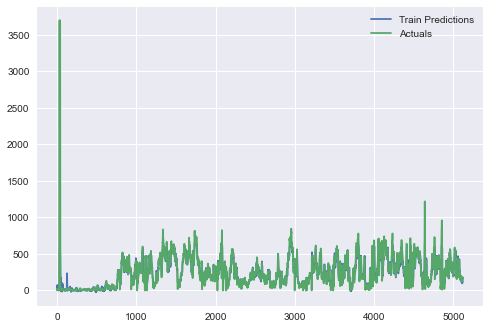

In [27]:
model = load_model('2H_Forecast/2H_ForecastModel_12_SizeWindow/')

X, y = DataHandler(2,12)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,shuffle=False) 
model.evaluate(X_test,y_test)

train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
plt.style.use('seaborn')

pd.concat([train_results['Train Predictions'],train_results['Actuals']],axis=1).plot()
plt.legend(['Train Predictions','Actuals'])

test_predictions = model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})

test_results.head(30)

### 3 hours forecast

In [28]:
%%time

Trainer(3,6,12)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_15 (Bidirectio (None, 128)               35840     
_________________________________________________________________
dense_30 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 9         
Total params: 36,881
Trainable params: 36,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
161/161 [==============================] - 6s 15ms/step - loss: 111382.9375 - mean_absolute_error: 248.8521 - val_loss: 150793.5312 - val_mean_absolute_error: 334.4751
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 2/100
161/161 [==============================] - 2s 10ms/step - loss: 110593.1016 - mean_absolute_error: 247.4072 - val_loss: 149378.1406 - val_mean_absolute_error: 332.3696
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 3/100
161/161 [==============================] - 2s 9ms/step - loss: 109417.8750 - mean_absolute_error: 245.1591 - val_loss: 147636.1562 - val_mean_absolute_error: 329.6539
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 4/100
161/161 [==============================] - 2s 10ms/step - loss: 107849.8438 - mean_absolute_error: 242.1605 - val_loss: 145249.1875 - val_mean_absolute_error: 325.9799
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 5/100
161/161 [==============================] - 2s 10ms/step - loss: 105930.0156 - mean_absolute_error: 238.4213 - val_loss: 142341.7188 - val_mean_absolute_error: 321.5185
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 6/100
161/161 [==============================] - 2s 11ms/step - loss: 103729.6719 - mean_absolute_error: 234.4482 - val_loss: 139163.8281 - val_mean_absolute_error: 316.5498
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 7/100
161/161 [==============================] - 2s 10ms/step - loss: 101369.6250 - mean_absolute_error: 230.1311 - val_loss: 136013.3281 - val_mean_absolute_error: 311.6078
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 8/100
161/161 [==============================] - 2s 11ms/step - loss: 99082.1875 - mean_absolute_error: 226.0542 - val_loss: 132803.1406 - val_mean_absolute_error: 306.4717
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 9/100
161/161 [==============================] - 2s 11ms/step - loss: 96659.6719 - mean_absolute_error: 221.6860 - val_loss: 129442.8594 - val_mean_absolute_error: 301.0157
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 10/100
161/161 [==============================] - 2s 15ms/step - loss: 94256.4688 - mean_absolute_error: 217.2613 - val_loss: 125996.6562 - val_mean_absolute_error: 295.3252
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 11/100
161/161 [==============================] - 2s 11ms/step - loss: 91748.7812 - mean_absolute_error: 212.8759 - val_loss: 122418.4453 - val_mean_absolute_error: 289.2883
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 12/100
161/161 [==============================] - 2s 10ms/step - loss: 89157.1641 - mean_absolute_error: 208.1450 - val_loss: 118694.5391 - val_mean_absolute_error: 282.9847
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 13/100
161/161 [==============================] - 2s 11ms/step - loss: 86375.0781 - mean_absolute_error: 203.1198 - val_loss: 114702.8516 - val_mean_absolute_error: 276.1804
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 14/100
161/161 [==============================] - 2s 11ms/step - loss: 83724.7344 - mean_absolute_error: 198.4196 - val_loss: 110990.7891 - val_mean_absolute_error: 269.7743
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 15/100
161/161 [==============================] - 2s 9ms/step - loss: 81073.2188 - mean_absolute_error: 193.4449 - val_loss: 107089.9375 - val_mean_absolute_error: 263.0016
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 16/100
161/161 [==============================] - 2s 12ms/step - loss: 78352.0781 - mean_absolute_error: 188.8821 - val_loss: 103098.5078 - val_mean_absolute_error: 256.1017
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 17/100
161/161 [==============================] - 2s 10ms/step - loss: 75580.9766 - mean_absolute_error: 183.7169 - val_loss: 99160.4844 - val_mean_absolute_error: 249.4114
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 18/100
161/161 [==============================] - 2s 10ms/step - loss: 72985.4141 - mean_absolute_error: 178.7234 - val_loss: 95422.9297 - val_mean_absolute_error: 243.1132
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 19/100
161/161 [==============================] - 2s 14ms/step - loss: 70392.3281 - mean_absolute_error: 173.9648 - val_loss: 91624.1797 - val_mean_absolute_error: 236.6711
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 20/100
161/161 [==============================] - 2s 11ms/step - loss: 67798.2656 - mean_absolute_error: 168.9964 - val_loss: 87838.3047 - val_mean_absolute_error: 230.3306
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 21/100
161/161 [==============================] - 2s 13ms/step - loss: 65325.0039 - mean_absolute_error: 164.2628 - val_loss: 84212.1094 - val_mean_absolute_error: 223.9993
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 22/100
161/161 [==============================] - 2s 12ms/step - loss: 62920.2812 - mean_absolute_error: 159.7511 - val_loss: 80740.3281 - val_mean_absolute_error: 218.0324
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 23/100
161/161 [==============================] - 2s 11ms/step - loss: 60613.4453 - mean_absolute_error: 155.0492 - val_loss: 77185.3281 - val_mean_absolute_error: 211.5901
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 24/100
161/161 [==============================] - 1s 9ms/step - loss: 58327.6289 - mean_absolute_error: 150.2991 - val_loss: 73808.8203 - val_mean_absolute_error: 205.4537
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 25/100
161/161 [==============================] - 2s 10ms/step - loss: 56122.2031 - mean_absolute_error: 146.1821 - val_loss: 70484.3047 - val_mean_absolute_error: 199.2060
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 26/100
161/161 [==============================] - 2s 12ms/step - loss: 54011.3477 - mean_absolute_error: 141.1168 - val_loss: 67245.5391 - val_mean_absolute_error: 193.3310
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 27/100
161/161 [==============================] - 2s 15ms/step - loss: 51984.6211 - mean_absolute_error: 137.4706 - val_loss: 64216.1445 - val_mean_absolute_error: 187.7564
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 28/100
161/161 [==============================] - 2s 9ms/step - loss: 50078.0820 - mean_absolute_error: 132.9182 - val_loss: 61256.7227 - val_mean_absolute_error: 182.3757
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 29/100
161/161 [==============================] - 2s 12ms/step - loss: 48232.1406 - mean_absolute_error: 129.6960 - val_loss: 58348.3750 - val_mean_absolute_error: 177.0729
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 30/100
161/161 [==============================] - 2s 13ms/step - loss: 46421.4258 - mean_absolute_error: 125.6245 - val_loss: 55498.0898 - val_mean_absolute_error: 172.0242
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 31/100
161/161 [==============================] - 2s 14ms/step - loss: 44718.4883 - mean_absolute_error: 121.4445 - val_loss: 52792.6523 - val_mean_absolute_error: 166.8969
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 32/100
161/161 [==============================] - 2s 14ms/step - loss: 43065.8516 - mean_absolute_error: 117.8395 - val_loss: 50218.8086 - val_mean_absolute_error: 162.3598
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 33/100
161/161 [==============================] - 2s 11ms/step - loss: 41492.4883 - mean_absolute_error: 114.2554 - val_loss: 47743.9062 - val_mean_absolute_error: 157.5438
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 34/100
161/161 [==============================] - 2s 12ms/step - loss: 40037.3164 - mean_absolute_error: 110.8811 - val_loss: 45385.9141 - val_mean_absolute_error: 153.4001
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 35/100
161/161 [==============================] - 2s 13ms/step - loss: 38662.7344 - mean_absolute_error: 108.3331 - val_loss: 43182.2109 - val_mean_absolute_error: 148.9964
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 36/100
161/161 [==============================] - 2s 11ms/step - loss: 37370.3203 - mean_absolute_error: 104.7773 - val_loss: 41082.0781 - val_mean_absolute_error: 145.1377
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 37/100
161/161 [==============================] - 2s 10ms/step - loss: 36184.2578 - mean_absolute_error: 102.5909 - val_loss: 39088.8320 - val_mean_absolute_error: 141.0561
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 38/100
161/161 [==============================] - 2s 12ms/step - loss: 35069.0156 - mean_absolute_error: 99.5279 - val_loss: 37033.4180 - val_mean_absolute_error: 136.7468
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 39/100
161/161 [==============================] - 2s 11ms/step - loss: 33925.2578 - mean_absolute_error: 97.4860 - val_loss: 35147.9688 - val_mean_absolute_error: 132.7916
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 40/100
161/161 [==============================] - 2s 10ms/step - loss: 32908.9141 - mean_absolute_error: 94.6902 - val_loss: 33417.1680 - val_mean_absolute_error: 129.0307
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 41/100
161/161 [==============================] - 2s 12ms/step - loss: 31955.5234 - mean_absolute_error: 91.7629 - val_loss: 31784.8613 - val_mean_absolute_error: 125.2808
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 42/100
161/161 [==============================] - 2s 11ms/step - loss: 31047.5703 - mean_absolute_error: 90.2932 - val_loss: 30304.0547 - val_mean_absolute_error: 122.3163
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 43/100
161/161 [==============================] - 2s 10ms/step - loss: 30195.0234 - mean_absolute_error: 87.9344 - val_loss: 28792.6484 - val_mean_absolute_error: 118.3741
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 44/100
161/161 [==============================] - 2s 11ms/step - loss: 29389.0547 - mean_absolute_error: 85.5158 - val_loss: 27412.5566 - val_mean_absolute_error: 115.0962
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 45/100
161/161 [==============================] - 2s 11ms/step - loss: 28597.0156 - mean_absolute_error: 83.6707 - val_loss: 26022.7754 - val_mean_absolute_error: 111.2896
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 46/100
161/161 [==============================] - 2s 11ms/step - loss: 27898.8320 - mean_absolute_error: 81.7164 - val_loss: 24816.5977 - val_mean_absolute_error: 108.4721
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 47/100
161/161 [==============================] - 2s 14ms/step - loss: 27231.7402 - mean_absolute_error: 80.0559 - val_loss: 23641.3438 - val_mean_absolute_error: 105.5181
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 48/100
161/161 [==============================] - 2s 11ms/step - loss: 26616.0176 - mean_absolute_error: 78.4621 - val_loss: 22545.4023 - val_mean_absolute_error: 102.5590
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 49/100
161/161 [==============================] - 2s 10ms/step - loss: 26053.2637 - mean_absolute_error: 76.8766 - val_loss: 21586.5332 - val_mean_absolute_error: 100.0651
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 50/100
161/161 [==============================] - 2s 9ms/step - loss: 25512.0039 - mean_absolute_error: 75.5435 - val_loss: 20596.4473 - val_mean_absolute_error: 97.5867
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 51/100
161/161 [==============================] - 2s 12ms/step - loss: 24968.8262 - mean_absolute_error: 73.9851 - val_loss: 19622.2207 - val_mean_absolute_error: 94.5882
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 52/100
161/161 [==============================] - 2s 11ms/step - loss: 24526.9609 - mean_absolute_error: 72.5095 - val_loss: 18884.9512 - val_mean_absolute_error: 93.2176
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 53/100
161/161 [==============================] - 2s 11ms/step - loss: 24115.4629 - mean_absolute_error: 71.5938 - val_loss: 18049.6172 - val_mean_absolute_error: 90.5501
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 54/100
161/161 [==============================] - 2s 11ms/step - loss: 23686.9902 - mean_absolute_error: 70.1759 - val_loss: 17536.2754 - val_mean_absolute_error: 88.9150
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 55/100
161/161 [==============================] - 2s 11ms/step - loss: 23304.1211 - mean_absolute_error: 68.9142 - val_loss: 16841.0703 - val_mean_absolute_error: 87.3156
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 56/100
161/161 [==============================] - 2s 13ms/step - loss: 22970.5898 - mean_absolute_error: 68.0084 - val_loss: 16288.2803 - val_mean_absolute_error: 85.5466
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 57/100
161/161 [==============================] - 2s 14ms/step - loss: 22640.5039 - mean_absolute_error: 66.9295 - val_loss: 15534.0430 - val_mean_absolute_error: 83.3214
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 58/100
161/161 [==============================] - 2s 12ms/step - loss: 22381.0586 - mean_absolute_error: 66.3288 - val_loss: 15114.7012 - val_mean_absolute_error: 82.2512
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 59/100
161/161 [==============================] - 2s 12ms/step - loss: 22238.9531 - mean_absolute_error: 65.7668 - val_loss: 14767.8096 - val_mean_absolute_error: 81.4164
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 60/100
161/161 [==============================] - 2s 11ms/step - loss: 21844.1660 - mean_absolute_error: 64.3477 - val_loss: 14203.4639 - val_mean_absolute_error: 79.5976
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 61/100
161/161 [==============================] - 2s 10ms/step - loss: 21608.9785 - mean_absolute_error: 63.5495 - val_loss: 13927.9941 - val_mean_absolute_error: 79.0071
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 62/100
161/161 [==============================] - 2s 11ms/step - loss: 21365.6777 - mean_absolute_error: 62.6250 - val_loss: 13324.0400 - val_mean_absolute_error: 76.9275
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 63/100
161/161 [==============================] - 2s 11ms/step - loss: 21127.9805 - mean_absolute_error: 61.7119 - val_loss: 13084.8340 - val_mean_absolute_error: 76.3875
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 64/100
161/161 [==============================] - 2s 10ms/step - loss: 20930.7617 - mean_absolute_error: 61.0684 - val_loss: 12800.3350 - val_mean_absolute_error: 75.4545
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 65/100
161/161 [==============================] - 2s 11ms/step - loss: 20755.8184 - mean_absolute_error: 60.5765 - val_loss: 12469.5830 - val_mean_absolute_error: 74.3894
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 66/100
161/161 [==============================] - 2s 10ms/step - loss: 20595.1660 - mean_absolute_error: 59.9425 - val_loss: 12170.5488 - val_mean_absolute_error: 73.7933
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 67/100
161/161 [==============================] - 2s 12ms/step - loss: 20419.6270 - mean_absolute_error: 59.3522 - val_loss: 11905.3887 - val_mean_absolute_error: 72.6851
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 68/100
161/161 [==============================] - 2s 13ms/step - loss: 20254.2891 - mean_absolute_error: 58.9979 - val_loss: 11877.7236 - val_mean_absolute_error: 72.4007
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 69/100
161/161 [==============================] - 2s 15ms/step - loss: 20118.6914 - mean_absolute_error: 58.4044 - val_loss: 11821.5947 - val_mean_absolute_error: 72.3354
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 70/100
161/161 [==============================] - 2s 12ms/step - loss: 20032.5977 - mean_absolute_error: 57.9674 - val_loss: 11303.3252 - val_mean_absolute_error: 71.4484
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 71/100
161/161 [==============================] - 2s 11ms/step - loss: 19909.8691 - mean_absolute_error: 58.0996 - val_loss: 11171.2900 - val_mean_absolute_error: 70.4367
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 72/100
161/161 [==============================] - 2s 11ms/step - loss: 19741.6465 - mean_absolute_error: 57.1511 - val_loss: 10941.3096 - val_mean_absolute_error: 69.7094
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 73/100
161/161 [==============================] - 2s 12ms/step - loss: 19776.3770 - mean_absolute_error: 57.3640 - val_loss: 11062.6602 - val_mean_absolute_error: 70.6371
Epoch 74/100
161/161 [==============================] - 2s 12ms/step - loss: 19703.8926 - mean_absolute_error: 57.1752 - val_loss: 10617.6299 - val_mean_absolute_error: 68.8354
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 75/100
161/161 [==============================] - 2s 13ms/step - loss: 19478.8223 - mean_absolute_error: 56.3019 - val_loss: 10594.5703 - val_mean_absolute_error: 68.7065
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 76/100
161/161 [==============================] - 2s 12ms/step - loss: 19406.8750 - mean_absolute_error: 56.0116 - val_loss: 10365.0137 - val_mean_absolute_error: 67.7200
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 77/100
161/161 [==============================] - 2s 11ms/step - loss: 19287.8691 - mean_absolute_error: 55.6545 - val_loss: 10452.8633 - val_mean_absolute_error: 68.1585
Epoch 78/100
161/161 [==============================] - 2s 13ms/step - loss: 19208.0703 - mean_absolute_error: 55.5589 - val_loss: 10369.5986 - val_mean_absolute_error: 67.9182
Epoch 79/100
161/161 [==============================] - 2s 12ms/step - loss: 19150.0645 - mean_absolute_error: 55.2800 - val_loss: 10083.1221 - val_mean_absolute_error: 67.0939
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 80/100
161/161 [==============================] - 2s 10ms/step - loss: 19165.8652 - mean_absolute_error: 55.1749 - val_loss: 9883.2246 - val_mean_absolute_error: 66.9897
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 81/100
161/161 [==============================] - 2s 10ms/step - loss: 19131.8027 - mean_absolute_error: 55.5276 - val_loss: 9896.0371 - val_mean_absolute_error: 66.4586
Epoch 82/100
161/161 [==============================] - 2s 10ms/step - loss: 18969.5117 - mean_absolute_error: 54.7476 - val_loss: 9797.3740 - val_mean_absolute_error: 65.9799
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 83/100
161/161 [==============================] - 2s 11ms/step - loss: 18870.1367 - mean_absolute_error: 54.2399 - val_loss: 9623.7490 - val_mean_absolute_error: 65.3066
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 84/100
161/161 [==============================] - 2s 13ms/step - loss: 18825.5996 - mean_absolute_error: 54.0625 - val_loss: 9917.5957 - val_mean_absolute_error: 66.7824
Epoch 85/100
161/161 [==============================] - 2s 12ms/step - loss: 18757.0781 - mean_absolute_error: 53.9079 - val_loss: 9602.8398 - val_mean_absolute_error: 65.6216
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 86/100
161/161 [==============================] - 2s 13ms/step - loss: 18688.8086 - mean_absolute_error: 53.7733 - val_loss: 9562.1514 - val_mean_absolute_error: 65.1138
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 87/100
161/161 [==============================] - 2s 15ms/step - loss: 18679.3730 - mean_absolute_error: 53.7997 - val_loss: 9558.8369 - val_mean_absolute_error: 65.3120
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 88/100
161/161 [==============================] - 2s 15ms/step - loss: 18630.6445 - mean_absolute_error: 53.5959 - val_loss: 9239.5391 - val_mean_absolute_error: 64.0834
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 89/100
161/161 [==============================] - 2s 11ms/step - loss: 18584.5039 - mean_absolute_error: 53.3230 - val_loss: 9262.6162 - val_mean_absolute_error: 64.5218
Epoch 90/100
161/161 [==============================] - 2s 15ms/step - loss: 18487.3652 - mean_absolute_error: 53.1655 - val_loss: 9233.6875 - val_mean_absolute_error: 64.1094
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 91/100
161/161 [==============================] - 2s 11ms/step - loss: 18447.4688 - mean_absolute_error: 53.0005 - val_loss: 9192.3906 - val_mean_absolute_error: 64.4721
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 92/100
161/161 [==============================] - 2s 11ms/step - loss: 18380.9805 - mean_absolute_error: 52.8806 - val_loss: 9250.8750 - val_mean_absolute_error: 64.7832
Epoch 93/100
161/161 [==============================] - 2s 13ms/step - loss: 18341.7051 - mean_absolute_error: 52.7689 - val_loss: 9110.5859 - val_mean_absolute_error: 64.0478
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 94/100
161/161 [==============================] - 2s 10ms/step - loss: 18340.7559 - mean_absolute_error: 52.6841 - val_loss: 9118.8955 - val_mean_absolute_error: 64.1336
Epoch 95/100
161/161 [==============================] - 2s 10ms/step - loss: 18387.0801 - mean_absolute_error: 53.2632 - val_loss: 9024.1182 - val_mean_absolute_error: 64.0681
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 96/100
161/161 [==============================] - ETA: 0s - loss: 18590.7246 - mean_absolute_error: 52.72 - 1s 9ms/step - loss: 18258.2090 - mean_absolute_error: 52.5938 - val_loss: 8903.3994 - val_mean_absolute_error: 63.6669
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 97/100
161/161 [==============================] - 2s 10ms/step - loss: 18178.0566 - mean_absolute_error: 52.0944 - val_loss: 8882.0781 - val_mean_absolute_error: 63.4024
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 98/100
161/161 [==============================] - 2s 11ms/step - loss: 18151.3223 - mean_absolute_error: 52.5454 - val_loss: 8880.2646 - val_mean_absolute_error: 63.6334
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 99/100
161/161 [==============================] - 2s 10ms/step - loss: 18185.9355 - mean_absolute_error: 52.4032 - val_loss: 8698.8984 - val_mean_absolute_error: 62.8139
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 100/100
161/161 [==============================] - 2s 13ms/step - loss: 18348.9863 - mean_absolute_error: 53.2676 - val_loss: 8928.6777 - val_mean_absolute_error: 63.8268

-----------------------------------------------------------------------------------------------------------

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_16 (Bidirectio (None, 128)               35840     
_________________________________________________________________
dense_32 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 9         
Total params: 36,881
Trainable params: 36,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
161/161 [==============================] - 7s 18ms/step - loss: 111286.2266 - me

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 2/100
161/161 [==============================] - 2s 12ms/step - loss: 109999.5312 - mean_absolute_error: 246.2069 - val_loss: 148404.2500 - val_mean_absolute_error: 330.8132
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 3/100
161/161 [==============================] - 3s 17ms/step - loss: 108405.3828 - mean_absolute_error: 243.0507 - val_loss: 145647.9375 - val_mean_absolute_error: 326.4195
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 4/100
161/161 [==============================] - 2s 13ms/step - loss: 106158.9922 - mean_absolute_error: 238.7730 - val_loss: 142613.0312 - val_mean_absolute_error: 321.8098
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 5/100
161/161 [==============================] - 2s 12ms/step - loss: 103960.7812 - mean_absolute_error: 234.7753 - val_loss: 139641.6406 - val_mean_absolute_error: 317.2870
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 6/100
161/161 [==============================] - 2s 15ms/step - loss: 101797.0391 - mean_absolute_error: 230.9697 - val_loss: 136651.9688 - val_mean_absolute_error: 312.5802
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 7/100
161/161 [==============================] - 2s 13ms/step - loss: 99644.5547 - mean_absolute_error: 227.2035 - val_loss: 133448.4688 - val_mean_absolute_error: 307.5943
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 8/100
161/161 [==============================] - ETA: 0s - loss: 97332.2812 - mean_absolute_error: 222.943 - 2s 12ms/step - loss: 97332.2812 - mean_absolute_error: 222.9439 - val_loss: 130466.9688 - val_mean_absolute_error: 302.7039
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 9/100
161/161 [==============================] - 2s 13ms/step - loss: 95299.8750 - mean_absolute_error: 219.4265 - val_loss: 127707.8750 - val_mean_absolute_error: 298.1988
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 10/100
161/161 [==============================] - 2s 13ms/step - loss: 93292.0859 - mean_absolute_error: 215.8493 - val_loss: 124910.0391 - val_mean_absolute_error: 293.5508
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 11/100
161/161 [==============================] - 2s 14ms/step - loss: 91275.5859 - mean_absolute_error: 212.2159 - val_loss: 121956.5234 - val_mean_absolute_error: 288.4757
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 12/100
161/161 [==============================] - 3s 17ms/step - loss: 89034.1094 - mean_absolute_error: 208.1747 - val_loss: 118744.6406 - val_mean_absolute_error: 283.1057
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 13/100
161/161 [==============================] - 3s 16ms/step - loss: 86782.7578 - mean_absolute_error: 204.0643 - val_loss: 115572.7891 - val_mean_absolute_error: 277.6439
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 14/100
161/161 [==============================] - 2s 13ms/step - loss: 84640.0703 - mean_absolute_error: 200.1958 - val_loss: 112449.3672 - val_mean_absolute_error: 272.2685
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 15/100
161/161 [==============================] - 2s 14ms/step - loss: 82412.7031 - mean_absolute_error: 196.5046 - val_loss: 109332.3750 - val_mean_absolute_error: 266.8638
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 16/100
161/161 [==============================] - 3s 16ms/step - loss: 80255.9844 - mean_absolute_error: 192.3186 - val_loss: 106280.3594 - val_mean_absolute_error: 261.5928
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 17/100
161/161 [==============================] - 2s 15ms/step - loss: 78174.9141 - mean_absolute_error: 188.8160 - val_loss: 103308.5078 - val_mean_absolute_error: 256.4799
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 18/100
161/161 [==============================] - 2s 12ms/step - loss: 76128.4688 - mean_absolute_error: 185.0075 - val_loss: 100392.2500 - val_mean_absolute_error: 251.4793
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 19/100
161/161 [==============================] - 2s 13ms/step - loss: 74129.4219 - mean_absolute_error: 181.0430 - val_loss: 97473.5938 - val_mean_absolute_error: 246.5505
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 20/100
161/161 [==============================] - 3s 18ms/step - loss: 72151.2969 - mean_absolute_error: 177.5488 - val_loss: 94631.0703 - val_mean_absolute_error: 241.7451
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 21/100
161/161 [==============================] - 2s 13ms/step - loss: 70219.4766 - mean_absolute_error: 173.4869 - val_loss: 91734.4609 - val_mean_absolute_error: 236.8795
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 22/100
161/161 [==============================] - 2s 13ms/step - loss: 68296.2266 - mean_absolute_error: 170.4236 - val_loss: 88920.2422 - val_mean_absolute_error: 232.1349
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 23/100
161/161 [==============================] - 2s 15ms/step - loss: 66414.7188 - mean_absolute_error: 166.7977 - val_loss: 86110.0547 - val_mean_absolute_error: 227.3621
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 24/100
161/161 [==============================] - 2s 15ms/step - loss: 64518.5586 - mean_absolute_error: 162.8433 - val_loss: 83258.4766 - val_mean_absolute_error: 222.4139
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 25/100
161/161 [==============================] - 2s 13ms/step - loss: 62593.0039 - mean_absolute_error: 158.6449 - val_loss: 80339.8906 - val_mean_absolute_error: 217.2942
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 26/100
161/161 [==============================] - 3s 18ms/step - loss: 60690.5195 - mean_absolute_error: 155.3690 - val_loss: 77582.6484 - val_mean_absolute_error: 212.2159
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 27/100
161/161 [==============================] - 3s 18ms/step - loss: 58903.3086 - mean_absolute_error: 151.3360 - val_loss: 74917.6406 - val_mean_absolute_error: 207.4303
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 28/100
161/161 [==============================] - 2s 13ms/step - loss: 57066.2266 - mean_absolute_error: 147.9865 - val_loss: 71926.0312 - val_mean_absolute_error: 201.6607
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 29/100
161/161 [==============================] - 2s 11ms/step - loss: 55154.1602 - mean_absolute_error: 143.6250 - val_loss: 69201.5938 - val_mean_absolute_error: 196.5353
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 30/100
161/161 [==============================] - 2s 12ms/step - loss: 53446.9727 - mean_absolute_error: 140.1488 - val_loss: 66521.2188 - val_mean_absolute_error: 191.6602
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 31/100
161/161 [==============================] - 2s 13ms/step - loss: 51744.8984 - mean_absolute_error: 136.2560 - val_loss: 63991.0117 - val_mean_absolute_error: 186.8385
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 32/100
161/161 [==============================] - 2s 13ms/step - loss: 50153.1914 - mean_absolute_error: 132.9651 - val_loss: 61501.7891 - val_mean_absolute_error: 182.1993
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 33/100
161/161 [==============================] - 2s 15ms/step - loss: 48579.4336 - mean_absolute_error: 129.0266 - val_loss: 59018.5234 - val_mean_absolute_error: 177.5974
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 34/100
161/161 [==============================] - 2s 14ms/step - loss: 47069.6055 - mean_absolute_error: 125.8319 - val_loss: 56754.7734 - val_mean_absolute_error: 173.5621
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 35/100
161/161 [==============================] - 2s 13ms/step - loss: 45653.9023 - mean_absolute_error: 123.0832 - val_loss: 54536.1094 - val_mean_absolute_error: 169.5599
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 36/100
161/161 [==============================] - 2s 14ms/step - loss: 44311.9453 - mean_absolute_error: 120.1463 - val_loss: 52418.6680 - val_mean_absolute_error: 165.8758
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 37/100
161/161 [==============================] - 3s 18ms/step - loss: 43048.9766 - mean_absolute_error: 116.8708 - val_loss: 50340.6211 - val_mean_absolute_error: 161.8782
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 38/100
161/161 [==============================] - 2s 12ms/step - loss: 41804.9531 - mean_absolute_error: 114.6465 - val_loss: 48343.5742 - val_mean_absolute_error: 158.1365
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 39/100
161/161 [==============================] - 2s 13ms/step - loss: 40601.0977 - mean_absolute_error: 111.4808 - val_loss: 46406.6562 - val_mean_absolute_error: 154.4218
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 40/100
161/161 [==============================] - 2s 12ms/step - loss: 39447.7148 - mean_absolute_error: 109.0989 - val_loss: 44555.7891 - val_mean_absolute_error: 150.7551
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 41/100
161/161 [==============================] - 2s 14ms/step - loss: 38336.8516 - mean_absolute_error: 106.5331 - val_loss: 42645.5820 - val_mean_absolute_error: 147.1662
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 42/100
161/161 [==============================] - 2s 12ms/step - loss: 37234.3203 - mean_absolute_error: 103.8701 - val_loss: 40852.8867 - val_mean_absolute_error: 143.9741
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 43/100
161/161 [==============================] - 2s 13ms/step - loss: 36227.9648 - mean_absolute_error: 101.3438 - val_loss: 39276.4297 - val_mean_absolute_error: 140.5312
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 44/100
161/161 [==============================] - 2s 14ms/step - loss: 35248.2227 - mean_absolute_error: 99.0724 - val_loss: 37517.8750 - val_mean_absolute_error: 136.8349
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 45/100
161/161 [==============================] - 2s 15ms/step - loss: 34332.4688 - mean_absolute_error: 96.8790 - val_loss: 35972.1953 - val_mean_absolute_error: 133.8079
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 46/100
161/161 [==============================] - 2s 14ms/step - loss: 33464.6250 - mean_absolute_error: 95.0159 - val_loss: 34488.5195 - val_mean_absolute_error: 130.7014
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 47/100
161/161 [==============================] - 3s 16ms/step - loss: 32694.1484 - mean_absolute_error: 93.3096 - val_loss: 33088.0234 - val_mean_absolute_error: 127.7422
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 48/100
161/161 [==============================] - 2s 12ms/step - loss: 31888.5332 - mean_absolute_error: 90.9899 - val_loss: 31689.8984 - val_mean_absolute_error: 124.6197
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 49/100
161/161 [==============================] - 2s 13ms/step - loss: 31232.3379 - mean_absolute_error: 89.0860 - val_loss: 30396.7285 - val_mean_absolute_error: 121.7560
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 50/100
161/161 [==============================] - 2s 12ms/step - loss: 30541.1328 - mean_absolute_error: 88.7067 - val_loss: 29195.4375 - val_mean_absolute_error: 118.8975
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 51/100
161/161 [==============================] - 2s 13ms/step - loss: 29823.8320 - mean_absolute_error: 86.3244 - val_loss: 28047.5879 - val_mean_absolute_error: 116.3260
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 52/100
161/161 [==============================] - 2s 14ms/step - loss: 29186.6211 - mean_absolute_error: 84.4834 - val_loss: 26919.9180 - val_mean_absolute_error: 113.5246
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 53/100
161/161 [==============================] - 2s 14ms/step - loss: 28561.7812 - mean_absolute_error: 82.9295 - val_loss: 25814.3887 - val_mean_absolute_error: 110.8626
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 54/100
161/161 [==============================] - ETA: 0s - loss: 28230.3164 - mean_absolute_error: 81.6133 ETA: 0s - loss: 26553.3223 - mean_absol - 2s 14ms/step - loss: 27997.8477 - mean_absolute_error: 81.4189 - val_loss: 24794.9141 - val_mean_absolute_error: 108.3363
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 55/100
161/161 [==============================] - 2s 14ms/step - loss: 27447.4004 - mean_absolute_error: 80.0654 - val_loss: 23746.8965 - val_mean_absolute_error: 105.4593
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 56/100
161/161 [==============================] - 2s 14ms/step - loss: 26917.9043 - mean_absolute_error: 78.2757 - val_loss: 22947.2988 - val_mean_absolute_error: 103.4503
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 57/100
161/161 [==============================] - 2s 12ms/step - loss: 26414.6699 - mean_absolute_error: 77.4112 - val_loss: 22054.2871 - val_mean_absolute_error: 101.0003
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 58/100
161/161 [==============================] - 4s 23ms/step - loss: 25982.9746 - mean_absolute_error: 76.2011 - val_loss: 21285.9570 - val_mean_absolute_error: 99.2769
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 59/100
161/161 [==============================] - 2s 13ms/step - loss: 25596.4570 - mean_absolute_error: 75.2351 - val_loss: 20514.2012 - val_mean_absolute_error: 97.3721
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 60/100
161/161 [==============================] - 2s 13ms/step - loss: 25166.3281 - mean_absolute_error: 73.8517 - val_loss: 19778.3379 - val_mean_absolute_error: 95.2779
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 61/100
161/161 [==============================] - 2s 12ms/step - loss: 24856.3281 - mean_absolute_error: 74.5190 - val_loss: 19100.7129 - val_mean_absolute_error: 93.5018
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 62/100
161/161 [==============================] - 2s 13ms/step - loss: 24652.0918 - mean_absolute_error: 73.2922 - val_loss: 18602.1309 - val_mean_absolute_error: 92.4066
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 63/100
161/161 [==============================] - 2s 14ms/step - loss: 24263.3809 - mean_absolute_error: 72.2464 - val_loss: 17989.1855 - val_mean_absolute_error: 90.5590
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 64/100
161/161 [==============================] - 2s 12ms/step - loss: 23910.7148 - mean_absolute_error: 70.5939 - val_loss: 17429.6562 - val_mean_absolute_error: 88.8828
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 65/100
161/161 [==============================] - 2s 13ms/step - loss: 23628.3477 - mean_absolute_error: 69.4290 - val_loss: 17089.2012 - val_mean_absolute_error: 87.7791
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 66/100
161/161 [==============================] - 2s 11ms/step - loss: 23346.0156 - mean_absolute_error: 68.6342 - val_loss: 16519.1426 - val_mean_absolute_error: 86.5412
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 67/100
161/161 [==============================] - 2s 12ms/step - loss: 23069.1621 - mean_absolute_error: 67.5965 - val_loss: 15838.4775 - val_mean_absolute_error: 84.4231
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 68/100
161/161 [==============================] - 3s 16ms/step - loss: 22812.5977 - mean_absolute_error: 66.8245 - val_loss: 15392.9727 - val_mean_absolute_error: 83.2114
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 69/100
161/161 [==============================] - 3s 17ms/step - loss: 22618.9863 - mean_absolute_error: 66.3036 - val_loss: 15317.9111 - val_mean_absolute_error: 83.5915
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 70/100
161/161 [==============================] - 2s 14ms/step - loss: 22465.1270 - mean_absolute_error: 66.0539 - val_loss: 14921.3721 - val_mean_absolute_error: 82.3639
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 71/100
161/161 [==============================] - 2s 13ms/step - loss: 22174.5684 - mean_absolute_error: 64.8818 - val_loss: 14591.6836 - val_mean_absolute_error: 81.4708
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 72/100
161/161 [==============================] - 2s 14ms/step - loss: 21983.2930 - mean_absolute_error: 64.1592 - val_loss: 14304.8369 - val_mean_absolute_error: 80.6141
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 73/100
161/161 [==============================] - 2s 11ms/step - loss: 21781.2363 - mean_absolute_error: 63.4818 - val_loss: 13810.8623 - val_mean_absolute_error: 78.9533
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 74/100
161/161 [==============================] - 2s 13ms/step - loss: 21602.1797 - mean_absolute_error: 62.8532 - val_loss: 13516.1357 - val_mean_absolute_error: 78.0461
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 75/100
161/161 [==============================] - 2s 14ms/step - loss: 21433.9492 - mean_absolute_error: 62.2087 - val_loss: 13218.6553 - val_mean_absolute_error: 77.4114
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 76/100
161/161 [==============================] - 2s 11ms/step - loss: 21302.0547 - mean_absolute_error: 62.2192 - val_loss: 12955.8652 - val_mean_absolute_error: 76.0223
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 77/100
161/161 [==============================] - 2s 12ms/step - loss: 21130.4531 - mean_absolute_error: 60.9971 - val_loss: 12564.7578 - val_mean_absolute_error: 74.8359
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 78/100
161/161 [==============================] - 2s 15ms/step - loss: 20960.9570 - mean_absolute_error: 60.3890 - val_loss: 12399.6631 - val_mean_absolute_error: 74.5858
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 79/100
161/161 [==============================] - 3s 20ms/step - loss: 20867.1699 - mean_absolute_error: 60.2776 - val_loss: 12201.5195 - val_mean_absolute_error: 73.7509
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 80/100
161/161 [==============================] - 2s 13ms/step - loss: 20782.9609 - mean_absolute_error: 60.0902 - val_loss: 11934.5254 - val_mean_absolute_error: 72.7036
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 81/100
161/161 [==============================] - 2s 14ms/step - loss: 20696.7305 - mean_absolute_error: 59.5814 - val_loss: 12043.6885 - val_mean_absolute_error: 73.3075
Epoch 82/100
161/161 [==============================] - 2s 15ms/step - loss: 20518.9902 - mean_absolute_error: 58.9689 - val_loss: 11536.5645 - val_mean_absolute_error: 71.8451
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 83/100
161/161 [==============================] - 2s 14ms/step - loss: 20397.3379 - mean_absolute_error: 58.5117 - val_loss: 11638.4072 - val_mean_absolute_error: 71.9454
Epoch 84/100
161/161 [==============================] - 2s 15ms/step - loss: 20277.8945 - mean_absolute_error: 57.9574 - val_loss: 11499.2100 - val_mean_absolute_error: 71.2430
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 85/100
161/161 [==============================] - 2s 10ms/step - loss: 20213.7715 - mean_absolute_error: 57.4279 - val_loss: 11113.0332 - val_mean_absolute_error: 70.4074
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 86/100
161/161 [==============================] - 2s 12ms/step - loss: 20274.8184 - mean_absolute_error: 58.7721 - val_loss: 10878.0859 - val_mean_absolute_error: 69.3024
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 87/100
161/161 [==============================] - 2s 13ms/step - loss: 20029.8359 - mean_absolute_error: 57.1085 - val_loss: 10433.1309 - val_mean_absolute_error: 67.7906
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 88/100
161/161 [==============================] - 2s 12ms/step - loss: 19993.0332 - mean_absolute_error: 56.9588 - val_loss: 10714.5283 - val_mean_absolute_error: 68.6603
Epoch 89/100
161/161 [==============================] - 2s 14ms/step - loss: 19880.5156 - mean_absolute_error: 56.3249 - val_loss: 10505.7373 - val_mean_absolute_error: 68.0600
Epoch 90/100
161/161 [==============================] - 2s 13ms/step - loss: 19788.5938 - mean_absolute_error: 56.0081 - val_loss: 10439.5684 - val_mean_absolute_error: 67.8303
Epoch 91/100
161/161 [==============================] - 2s 13ms/step - loss: 19678.5273 - mean_absolute_error: 55.8531 - val_loss: 10137.2354 - val_mean_absolute_error: 66.7736
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 92/100
161/161 [==============================] - 2s 13ms/step - loss: 19612.2930 - mean_absolute_error: 55.5823 - val_loss: 10147.0176 - val_mean_absolute_error: 67.0011
Epoch 93/100
161/161 [==============================] - 2s 14ms/step - loss: 19556.2500 - mean_absolute_error: 55.3733 - val_loss: 9929.6787 - val_mean_absolute_error: 65.8920
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 94/100
161/161 [==============================] - 2s 14ms/step - loss: 19499.5566 - mean_absolute_error: 55.3759 - val_loss: 9756.8115 - val_mean_absolute_error: 65.3064
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 95/100
161/161 [==============================] - 2s 13ms/step - loss: 19453.4473 - mean_absolute_error: 55.0580 - val_loss: 9777.4258 - val_mean_absolute_error: 65.6454
Epoch 96/100
161/161 [==============================] - 2s 13ms/step - loss: 19383.9980 - mean_absolute_error: 54.9095 - val_loss: 9506.4482 - val_mean_absolute_error: 64.4617
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 97/100
161/161 [==============================] - 3s 16ms/step - loss: 19303.9883 - mean_absolute_error: 54.5679 - val_loss: 9450.1768 - val_mean_absolute_error: 64.0802
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 98/100
161/161 [==============================] - 2s 13ms/step - loss: 19272.4258 - mean_absolute_error: 54.5421 - val_loss: 9536.9785 - val_mean_absolute_error: 64.5375
Epoch 99/100
161/161 [==============================] - 2s 14ms/step - loss: 19253.2480 - mean_absolute_error: 54.7794 - val_loss: 9515.3418 - val_mean_absolute_error: 64.5697
Epoch 100/100
161/161 [==============================] - 2s 14ms/step - loss: 19177.8613 - mean_absolute_error: 53.9570 - val_loss: 9387.3926 - val_mean_absolute_error: 64.1236
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_17 (Bidirectio (None, 128)               35840     
_________________________________________________________________
dense_34 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 9         
Total params: 36,881
Trainable params: 36,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
161/161 [==============================] - 8s 21ms/step - loss: 111531.8672 - mean_absolute_error: 249.1305 - val_loss: 150530.2812 - val_mean_absolute_error: 334.1145
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 2/100
161/161 [==============================] - 2s 15ms/step - loss: 110221.8984 - mean_absolute_error: 246.7124 - val_loss: 148400.9688 - val_mean_absolute_error: 330.8068
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 3/100
161/161 [==============================] - 2s 15ms/step - loss: 108451.5078 - mean_absolute_error: 243.2244 - val_loss: 145848.8125 - val_mean_absolute_error: 326.7812
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 4/100
161/161 [==============================] - 2s 12ms/step - loss: 106332.5312 - mean_absolute_error: 239.1118 - val_loss: 142743.8594 - val_mean_absolute_error: 321.8381
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 5/100
161/161 [==============================] - 2s 15ms/step - loss: 103917.2188 - mean_absolute_error: 234.5885 - val_loss: 139235.0312 - val_mean_absolute_error: 316.5207
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 6/100
161/161 [==============================] - 3s 21ms/step - loss: 101346.0859 - mean_absolute_error: 230.1663 - val_loss: 135861.4375 - val_mean_absolute_error: 311.3386
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 7/100
161/161 [==============================] - 3s 16ms/step - loss: 99182.7266 - mean_absolute_error: 226.3990 - val_loss: 132982.1562 - val_mean_absolute_error: 306.7159
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 8/100
161/161 [==============================] - 2s 14ms/step - loss: 97045.2969 - mean_absolute_error: 222.5169 - val_loss: 130021.2266 - val_mean_absolute_error: 301.8682
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 9/100
161/161 [==============================] - 2s 15ms/step - loss: 94762.3750 - mean_absolute_error: 218.5388 - val_loss: 126762.2422 - val_mean_absolute_error: 296.6011
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 10/100
161/161 [==============================] - 3s 16ms/step - loss: 92477.0781 - mean_absolute_error: 214.4473 - val_loss: 123425.4531 - val_mean_absolute_error: 291.0351
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 11/100
161/161 [==============================] - 3s 21ms/step - loss: 90144.3516 - mean_absolute_error: 210.2558 - val_loss: 120259.3047 - val_mean_absolute_error: 285.6761
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 12/100
161/161 [==============================] - 2s 15ms/step - loss: 87957.1094 - mean_absolute_error: 206.3271 - val_loss: 117326.5781 - val_mean_absolute_error: 280.6619
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 13/100
161/161 [==============================] - 2s 15ms/step - loss: 85919.1484 - mean_absolute_error: 202.5996 - val_loss: 114438.2109 - val_mean_absolute_error: 275.7020
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 14/100
161/161 [==============================] - 3s 20ms/step - loss: 83828.6484 - mean_absolute_error: 199.0914 - val_loss: 111349.0078 - val_mean_absolute_error: 270.3831
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 15/100
161/161 [==============================] - 3s 16ms/step - loss: 81711.0312 - mean_absolute_error: 195.1112 - val_loss: 108425.3203 - val_mean_absolute_error: 265.2895
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 16/100
161/161 [==============================] - 2s 13ms/step - loss: 79635.9062 - mean_absolute_error: 191.3449 - val_loss: 105389.5703 - val_mean_absolute_error: 260.0247
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 17/100
161/161 [==============================] - 2s 13ms/step - loss: 77536.9531 - mean_absolute_error: 187.5434 - val_loss: 102340.9062 - val_mean_absolute_error: 254.8021
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 18/100
161/161 [==============================] - 3s 18ms/step - loss: 75417.5234 - mean_absolute_error: 183.6512 - val_loss: 99344.5625 - val_mean_absolute_error: 249.68301s - loss: 72916.94
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 19/100
161/161 [==============================] - 3s 16ms/step - loss: 73455.5625 - mean_absolute_error: 179.9272 - val_loss: 96454.4766 - val_mean_absolute_error: 244.7895
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 20/100
161/161 [==============================] - 3s 20ms/step - loss: 71495.6875 - mean_absolute_error: 176.7419 - val_loss: 93663.0312 - val_mean_absolute_error: 240.0826
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 21/100
161/161 [==============================] - 2s 14ms/step - loss: 69560.1641 - mean_absolute_error: 172.7437 - val_loss: 90824.3125 - val_mean_absolute_error: 235.2724
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 22/100
161/161 [==============================] - 2s 13ms/step - loss: 67623.7109 - mean_absolute_error: 169.1977 - val_loss: 87960.4688 - val_mean_absolute_error: 230.3659
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 23/100
161/161 [==============================] - 2s 14ms/step - loss: 65632.3359 - mean_absolute_error: 165.2077 - val_loss: 84977.7578 - val_mean_absolute_error: 225.2227
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 24/100
161/161 [==============================] - 2s 15ms/step - loss: 63741.3203 - mean_absolute_error: 162.0945 - val_loss: 82188.6250 - val_mean_absolute_error: 220.3333
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 25/100
161/161 [==============================] - 2s 14ms/step - loss: 61819.7188 - mean_absolute_error: 157.8330 - val_loss: 79267.1875 - val_mean_absolute_error: 215.1105
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 26/100
161/161 [==============================] - 3s 16ms/step - loss: 59932.7148 - mean_absolute_error: 154.1402 - val_loss: 77213.3828 - val_mean_absolute_error: 211.2809
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 27/100
161/161 [==============================] - 3s 17ms/step - loss: 58186.9023 - mean_absolute_error: 150.5933 - val_loss: 74358.8750 - val_mean_absolute_error: 206.0652
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 28/100
161/161 [==============================] - 3s 17ms/step - loss: 56439.4531 - mean_absolute_error: 147.4419 - val_loss: 71354.7969 - val_mean_absolute_error: 200.5916
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 29/100
161/161 [==============================] - 3s 20ms/step - loss: 54792.8984 - mean_absolute_error: 143.1145 - val_loss: 68923.3047 - val_mean_absolute_error: 196.2599
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 30/100
161/161 [==============================] - 2s 13ms/step - loss: 53153.6758 - mean_absolute_error: 139.8193 - val_loss: 66511.9922 - val_mean_absolute_error: 191.7453
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 31/100
161/161 [==============================] - 2s 13ms/step - loss: 51565.7461 - mean_absolute_error: 136.2989 - val_loss: 64249.5469 - val_mean_absolute_error: 187.5590
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 32/100
161/161 [==============================] - 2s 13ms/step - loss: 50130.6406 - mean_absolute_error: 133.1636 - val_loss: 61916.4023 - val_mean_absolute_error: 183.3388
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 33/100
161/161 [==============================] - 2s 13ms/step - loss: 48567.9766 - mean_absolute_error: 129.9946 - val_loss: 59598.2070 - val_mean_absolute_error: 179.0627
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 34/100
161/161 [==============================] - 2s 15ms/step - loss: 47080.4062 - mean_absolute_error: 126.6813 - val_loss: 57108.8750 - val_mean_absolute_error: 174.3444
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 35/100
161/161 [==============================] - 2s 14ms/step - loss: 45695.0234 - mean_absolute_error: 123.6213 - val_loss: 54973.0391 - val_mean_absolute_error: 170.5650
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 36/100
161/161 [==============================] - 3s 18ms/step - loss: 44377.6758 - mean_absolute_error: 120.7582 - val_loss: 52837.9766 - val_mean_absolute_error: 166.5855
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 37/100
161/161 [==============================] - 2s 15ms/step - loss: 43119.6133 - mean_absolute_error: 117.8839 - val_loss: 50797.9844 - val_mean_absolute_error: 162.7426
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 38/100
161/161 [==============================] - 3s 21ms/step - loss: 41855.0977 - mean_absolute_error: 114.7769 - val_loss: 48714.9844 - val_mean_absolute_error: 158.9085
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 39/100
161/161 [==============================] - 3s 16ms/step - loss: 40580.2148 - mean_absolute_error: 111.9654 - val_loss: 46725.2656 - val_mean_absolute_error: 155.2237
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 40/100
161/161 [==============================] - 2s 13ms/step - loss: 39382.2188 - mean_absolute_error: 109.1589 - val_loss: 45000.0312 - val_mean_absolute_error: 151.7931
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 41/100
161/161 [==============================] - 3s 16ms/step - loss: 38398.0000 - mean_absolute_error: 106.6583 - val_loss: 42996.3477 - val_mean_absolute_error: 147.8244
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 42/100
161/161 [==============================] - 2s 15ms/step - loss: 37216.4883 - mean_absolute_error: 104.2910 - val_loss: 41184.4766 - val_mean_absolute_error: 144.0333
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 43/100
161/161 [==============================] - 2s 14ms/step - loss: 36127.5898 - mean_absolute_error: 101.5452 - val_loss: 39762.4062 - val_mean_absolute_error: 141.3295
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 44/100
161/161 [==============================] - 2s 15ms/step - loss: 35178.8555 - mean_absolute_error: 99.0040 - val_loss: 37855.9883 - val_mean_absolute_error: 137.5018
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 45/100
161/161 [==============================] - 2s 13ms/step - loss: 34242.9258 - mean_absolute_error: 97.3634 - val_loss: 36296.8906 - val_mean_absolute_error: 134.2283
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 46/100
161/161 [==============================] - 2s 14ms/step - loss: 33530.5742 - mean_absolute_error: 95.5964 - val_loss: 35045.0039 - val_mean_absolute_error: 131.3844
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 47/100
161/161 [==============================] - 3s 16ms/step - loss: 32530.3438 - mean_absolute_error: 93.0564 - val_loss: 33631.3164 - val_mean_absolute_error: 128.2412
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 48/100
161/161 [==============================] - 3s 21ms/step - loss: 31685.3340 - mean_absolute_error: 90.5485 - val_loss: 32365.0215 - val_mean_absolute_error: 125.7295
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 49/100
161/161 [==============================] - 2s 15ms/step - loss: 30919.8867 - mean_absolute_error: 88.9682 - val_loss: 30843.3340 - val_mean_absolute_error: 122.1962
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 50/100
161/161 [==============================] - 3s 16ms/step - loss: 30199.7422 - mean_absolute_error: 87.1103 - val_loss: 29676.8008 - val_mean_absolute_error: 119.7433
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 51/100
161/161 [==============================] - 2s 14ms/step - loss: 29515.5293 - mean_absolute_error: 85.4553 - val_loss: 28669.3457 - val_mean_absolute_error: 117.0482
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 52/100
161/161 [==============================] - 2s 13ms/step - loss: 28844.8848 - mean_absolute_error: 83.5506 - val_loss: 27503.1484 - val_mean_absolute_error: 114.4126
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 53/100
161/161 [==============================] - 3s 16ms/step - loss: 28217.8574 - mean_absolute_error: 82.3111 - val_loss: 26178.6719 - val_mean_absolute_error: 111.3572
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 54/100
161/161 [==============================] - 2s 14ms/step - loss: 27901.8809 - mean_absolute_error: 81.8874 - val_loss: 25289.2676 - val_mean_absolute_error: 109.2676
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 55/100
161/161 [==============================] - 2s 14ms/step - loss: 27274.2070 - mean_absolute_error: 80.5652 - val_loss: 24803.0215 - val_mean_absolute_error: 107.6532
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 56/100
161/161 [==============================] - 2s 15ms/step - loss: 26658.9863 - mean_absolute_error: 78.3511 - val_loss: 24003.8574 - val_mean_absolute_error: 105.7230
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 57/100
161/161 [==============================] - 3s 20ms/step - loss: 26087.4531 - mean_absolute_error: 76.5723 - val_loss: 22414.2383 - val_mean_absolute_error: 101.6004
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 58/100
161/161 [==============================] - 3s 16ms/step - loss: 25617.9805 - mean_absolute_error: 75.1575 - val_loss: 21538.6660 - val_mean_absolute_error: 99.7260
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 59/100
161/161 [==============================] - 3s 16ms/step - loss: 25152.9902 - mean_absolute_error: 74.0608 - val_loss: 21340.8281 - val_mean_absolute_error: 98.6022
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 60/100
161/161 [==============================] - 2s 14ms/step - loss: 24766.5996 - mean_absolute_error: 72.7204 - val_loss: 20725.3984 - val_mean_absolute_error: 97.2788
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 61/100
161/161 [==============================] - 3s 17ms/step - loss: 24394.3652 - mean_absolute_error: 71.9653 - val_loss: 19140.3555 - val_mean_absolute_error: 93.3947
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 62/100
161/161 [==============================] - 3s 17ms/step - loss: 23999.8926 - mean_absolute_error: 70.8077 - val_loss: 18454.3574 - val_mean_absolute_error: 91.7142
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 63/100
161/161 [==============================] - 3s 16ms/step - loss: 23617.7637 - mean_absolute_error: 69.7618 - val_loss: 18202.7676 - val_mean_absolute_error: 91.2333
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 64/100
161/161 [==============================] - 2s 15ms/step - loss: 23310.1934 - mean_absolute_error: 68.8869 - val_loss: 18394.4062 - val_mean_absolute_error: 91.4677
Epoch 65/100
161/161 [==============================] - 3s 16ms/step - loss: 23106.9941 - mean_absolute_error: 68.3540 - val_loss: 17684.1875 - val_mean_absolute_error: 89.9627
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 66/100
161/161 [==============================] - 2s 14ms/step - loss: 22862.8867 - mean_absolute_error: 67.7773 - val_loss: 17051.2227 - val_mean_absolute_error: 88.0312
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 67/100
161/161 [==============================] - 3s 16ms/step - loss: 22535.8047 - mean_absolute_error: 66.9983 - val_loss: 16845.9961 - val_mean_absolute_error: 87.7204
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 68/100
161/161 [==============================] - 3s 18ms/step - loss: 22229.1602 - mean_absolute_error: 65.5590 - val_loss: 15321.3789 - val_mean_absolute_error: 83.2405
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 69/100
161/161 [==============================] - 2s 14ms/step - loss: 22018.1074 - mean_absolute_error: 64.8176 - val_loss: 15277.4580 - val_mean_absolute_error: 83.4876
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 70/100
161/161 [==============================] - 2s 13ms/step - loss: 21791.8008 - mean_absolute_error: 64.5103 - val_loss: 15420.8525 - val_mean_absolute_error: 83.5792
Epoch 71/100
161/161 [==============================] - 2s 13ms/step - loss: 21703.7988 - mean_absolute_error: 64.3592 - val_loss: 14857.7529 - val_mean_absolute_error: 82.2164
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 72/100
161/161 [==============================] - 3s 16ms/step - loss: 21575.5996 - mean_absolute_error: 63.7946 - val_loss: 14390.5742 - val_mean_absolute_error: 81.1489
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 73/100
161/161 [==============================] - 3s 20ms/step - loss: 21698.4258 - mean_absolute_error: 63.0138 - val_loss: 14630.5801 - val_mean_absolute_error: 82.0690
Epoch 74/100
161/161 [==============================] - 3s 18ms/step - loss: 21261.3750 - mean_absolute_error: 62.1655 - val_loss: 14029.4727 - val_mean_absolute_error: 80.3488 1s - l
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 75/100
161/161 [==============================] - 2s 14ms/step - loss: 20987.1875 - mean_absolute_error: 61.2388 - val_loss: 13392.8281 - val_mean_absolute_error: 78.0312
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 76/100
161/161 [==============================] - 2s 15ms/step - loss: 20792.6465 - mean_absolute_error: 61.2352 - val_loss: 13796.9082 - val_mean_absolute_error: 79.2919
Epoch 77/100
161/161 [==============================] - 3s 16ms/step - loss: 20605.8887 - mean_absolute_error: 59.9581 - val_loss: 12618.6689 - val_mean_absolute_error: 75.9436
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 78/100
161/161 [==============================] - 2s 14ms/step - loss: 20502.1309 - mean_absolute_error: 60.0814 - val_loss: 12606.4824 - val_mean_absolute_error: 75.9663
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 79/100
161/161 [==============================] - 3s 19ms/step - loss: 20397.4160 - mean_absolute_error: 59.5492 - val_loss: 12433.6230 - val_mean_absolute_error: 75.2111
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 80/100
161/161 [==============================] - 2s 14ms/step - loss: 20180.4746 - mean_absolute_error: 58.6485 - val_loss: 12778.1289 - val_mean_absolute_error: 76.3002
Epoch 81/100
161/161 [==============================] - 2s 15ms/step - loss: 20066.0449 - mean_absolute_error: 58.2297 - val_loss: 12449.4639 - val_mean_absolute_error: 75.3198
Epoch 82/100
161/161 [==============================] - 2s 15ms/step - loss: 19939.8027 - mean_absolute_error: 57.6749 - val_loss: 11761.5586 - val_mean_absolute_error: 73.6100
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 83/100
161/161 [==============================] - 3s 18ms/step - loss: 19875.1992 - mean_absolute_error: 57.7890 - val_loss: 11953.1318 - val_mean_absolute_error: 73.7580
Epoch 84/100
161/161 [==============================] - 3s 16ms/step - loss: 19752.5078 - mean_absolute_error: 57.2743 - val_loss: 11340.0361 - val_mean_absolute_error: 71.7004
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 85/100
161/161 [==============================] - 2s 15ms/step - loss: 19696.2500 - mean_absolute_error: 57.0797 - val_loss: 11693.2578 - val_mean_absolute_error: 73.7553
Epoch 86/100
161/161 [==============================] - 3s 16ms/step - loss: 19923.8691 - mean_absolute_error: 57.7590 - val_loss: 11153.3682 - val_mean_absolute_error: 71.3042
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 87/100
161/161 [==============================] - 3s 16ms/step - loss: 19638.8359 - mean_absolute_error: 56.8317 - val_loss: 10769.1279 - val_mean_absolute_error: 70.0339
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 88/100
161/161 [==============================] - 3s 17ms/step - loss: 19582.2383 - mean_absolute_error: 56.8115 - val_loss: 11670.7695 - val_mean_absolute_error: 72.0624
Epoch 89/100
161/161 [==============================] - 3s 17ms/step - loss: 19461.2480 - mean_absolute_error: 56.2470 - val_loss: 11398.1963 - val_mean_absolute_error: 71.7219
Epoch 90/100
161/161 [==============================] - 2s 16ms/step - loss: 19351.3203 - mean_absolute_error: 55.8127 - val_loss: 11242.9004 - val_mean_absolute_error: 71.0120
Epoch 91/100
161/161 [==============================] - 3s 17ms/step - loss: 19247.3242 - mean_absolute_error: 55.6174 - val_loss: 10909.0098 - val_mean_absolute_error: 70.0811
Epoch 92/100
161/161 [==============================] - 3s 21ms/step - loss: 19179.3691 - mean_absolute_error: 55.2732 - val_loss: 11485.7070 - val_mean_absolute_error: 72.4772
Epoch 93/100
161/161 [==============================] - 3s 20ms/step - loss: 19294.7324 - mean_absolute_error: 56.3

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 94/100
161/161 [==============================] - 2s 15ms/step - loss: 19234.5059 - mean_absolute_error: 55.5404 - val_loss: 10579.4531 - val_mean_absolute_error: 68.7864
Epoch 95/100
161/161 [==============================] - 2s 15ms/step - loss: 19428.8184 - mean_absolute_error: 57.6631 - val_loss: 11286.6650 - val_mean_absolute_error: 71.5991
Epoch 96/100
161/161 [==============================] - 2s 14ms/step - loss: 19475.6387 - mean_absolute_error: 55.7666 - val_loss: 11040.5996 - val_mean_absolute_error: 71.0016
Epoch 97/100
161/161 [==============================] - 2s 14ms/step - loss: 19068.9277 - mean_absolute_error: 55.0532 - val_loss: 10891.2227 - val_mean_absolute_error: 70.3685
Epoch 98/100
161/161 [==============================] - 2s 14ms/step - loss: 18891.8105 - mean_absolute_error: 54.7130 - val_loss: 10614.1113 - val_mean_absolute_error: 69.4705
Epoch 99/100
161/161 [==============================] - 2s 14ms/step - loss: 18850.2227 - mean_absolute_error: 54.3

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 100/100
161/161 [==============================] - 3s 18ms/step - loss: 18882.1895 - mean_absolute_error: 54.6413 - val_loss: 10670.5361 - val_mean_absolute_error: 69.9656

-----------------------------------------------------------------------------------------------------------

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_18 (Bidirectio (None, 128)               35840     
_________________________________________________________________
dense_36 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 9         
Total params: 36,881
Trainable params: 36,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
161/161 [==============================] - 14s 35ms/step - loss: 111132.3281 - 

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 2/100
161/161 [==============================] - 3s 16ms/step - loss: 109456.1094 - mean_absolute_error: 245.2531 - val_loss: 147191.7656 - val_mean_absolute_error: 328.8964
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 3/100
161/161 [==============================] - 3s 18ms/step - loss: 106911.8906 - mean_absolute_error: 240.3029 - val_loss: 142831.0781 - val_mean_absolute_error: 322.0509
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 4/100
161/161 [==============================] - 3s 16ms/step - loss: 103293.2031 - mean_absolute_error: 233.6342 - val_loss: 137589.8438 - val_mean_absolute_error: 313.8170
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 5/100
161/161 [==============================] - 3s 19ms/step - loss: 99770.1250 - mean_absolute_error: 227.1924 - val_loss: 133191.0469 - val_mean_absolute_error: 306.8723
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 6/100
161/161 [==============================] - 3s 18ms/step - loss: 96615.8594 - mean_absolute_error: 221.5699 - val_loss: 128802.5625 - val_mean_absolute_error: 299.8372
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 7/100
161/161 [==============================] - 3s 16ms/step - loss: 93441.1562 - mean_absolute_error: 215.9013 - val_loss: 124268.2812 - val_mean_absolute_error: 292.2906
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 8/100
161/161 [==============================] - 3s 17ms/step - loss: 90156.5078 - mean_absolute_error: 210.1488 - val_loss: 119606.1562 - val_mean_absolute_error: 284.4882
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 9/100
161/161 [==============================] - 2s 14ms/step - loss: 86822.1875 - mean_absolute_error: 204.2221 - val_loss: 114836.2891 - val_mean_absolute_error: 276.2757
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 10/100
161/161 [==============================] - 2s 15ms/step - loss: 83423.7656 - mean_absolute_error: 198.1270 - val_loss: 110166.7891 - val_mean_absolute_error: 268.2970
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 11/100
161/161 [==============================] - 3s 20ms/step - loss: 80470.0547 - mean_absolute_error: 192.8240 - val_loss: 106063.2969 - val_mean_absolute_error: 261.2325
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 12/100
161/161 [==============================] - 2s 14ms/step - loss: 77682.8516 - mean_absolute_error: 187.7742 - val_loss: 102172.5469 - val_mean_absolute_error: 254.5045
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 13/100
161/161 [==============================] - 2s 15ms/step - loss: 74845.7109 - mean_absolute_error: 182.7322 - val_loss: 98048.7578 - val_mean_absolute_error: 247.5349
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 14/100
161/161 [==============================] - 3s 19ms/step - loss: 72227.1719 - mean_absolute_error: 177.3808 - val_loss: 94355.4844 - val_mean_absolute_error: 241.3120
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 15/100
161/161 [==============================] - 2s 15ms/step - loss: 69690.2109 - mean_absolute_error: 172.6226 - val_loss: 90393.5547 - val_mean_absolute_error: 234.6648
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 16/100
161/161 [==============================] - 3s 21ms/step - loss: 66978.4219 - mean_absolute_error: 167.9566 - val_loss: 86532.3984 - val_mean_absolute_error: 228.1199
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 17/100
161/161 [==============================] - 3s 16ms/step - loss: 64447.6680 - mean_absolute_error: 162.8195 - val_loss: 82775.4922 - val_mean_absolute_error: 221.6109
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 18/100
161/161 [==============================] - 3s 18ms/step - loss: 62031.0859 - mean_absolute_error: 157.9800 - val_loss: 79271.8359 - val_mean_absolute_error: 215.3013
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 19/100
161/161 [==============================] - 3s 17ms/step - loss: 59711.1055 - mean_absolute_error: 153.2229 - val_loss: 75870.2109 - val_mean_absolute_error: 209.1414
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 20/100
161/161 [==============================] - 3s 16ms/step - loss: 57511.7344 - mean_absolute_error: 148.7224 - val_loss: 72571.5000 - val_mean_absolute_error: 203.0051
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 21/100
161/161 [==============================] - 3s 16ms/step - loss: 55441.1914 - mean_absolute_error: 144.4311 - val_loss: 69437.1953 - val_mean_absolute_error: 197.2103
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 22/100
161/161 [==============================] - 3s 17ms/step - loss: 53433.1133 - mean_absolute_error: 140.0159 - val_loss: 66400.0000 - val_mean_absolute_error: 191.7321
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 23/100
161/161 [==============================] - 3s 16ms/step - loss: 51542.5742 - mean_absolute_error: 136.3948 - val_loss: 63535.0117 - val_mean_absolute_error: 186.5546
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 24/100
161/161 [==============================] - 2s 15ms/step - loss: 49739.5938 - mean_absolute_error: 132.2899 - val_loss: 60750.5664 - val_mean_absolute_error: 181.4046
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 25/100
161/161 [==============================] - 2s 15ms/step - loss: 47989.6602 - mean_absolute_error: 128.5219 - val_loss: 58073.6680 - val_mean_absolute_error: 176.4567
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 26/100
161/161 [==============================] - 3s 17ms/step - loss: 46345.1602 - mean_absolute_error: 124.8718 - val_loss: 55459.5195 - val_mean_absolute_error: 171.7047
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 27/100
161/161 [==============================] - 2s 14ms/step - loss: 44773.4648 - mean_absolute_error: 122.0731 - val_loss: 53022.9492 - val_mean_absolute_error: 167.3578
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 28/100
161/161 [==============================] - 3s 17ms/step - loss: 43279.8359 - mean_absolute_error: 118.6800 - val_loss: 50658.6328 - val_mean_absolute_error: 163.0829
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 29/100
161/161 [==============================] - 3s 17ms/step - loss: 41861.3320 - mean_absolute_error: 114.9419 - val_loss: 48342.9258 - val_mean_absolute_error: 158.6097
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 30/100
161/161 [==============================] - 3s 16ms/step - loss: 40470.3633 - mean_absolute_error: 112.7916 - val_loss: 46162.7969 - val_mean_absolute_error: 154.5882
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 31/100
161/161 [==============================] - 3s 18ms/step - loss: 39164.4961 - mean_absolute_error: 108.7696 - val_loss: 43951.2422 - val_mean_absolute_error: 150.4126
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 32/100
161/161 [==============================] - 3s 20ms/step - loss: 37957.7969 - mean_absolute_error: 106.3274 - val_loss: 41939.6992 - val_mean_absolute_error: 146.2430
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 33/100
161/161 [==============================] - 4s 27ms/step - loss: 36825.8086 - mean_absolute_error: 104.1009 - val_loss: 39970.8164 - val_mean_absolute_error: 142.6145
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 34/100
161/161 [==============================] - 3s 16ms/step - loss: 35661.2539 - mean_absolute_error: 100.7922 - val_loss: 37973.5039 - val_mean_absolute_error: 138.5748
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 35/100
161/161 [==============================] - 2s 16ms/step - loss: 34643.5352 - mean_absolute_error: 99.2584 - val_loss: 36273.0273 - val_mean_absolute_error: 135.2197
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 36/100
161/161 [==============================] - 3s 18ms/step - loss: 33603.3867 - mean_absolute_error: 95.9708 - val_loss: 34602.8828 - val_mean_absolute_error: 131.7766
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 37/100
161/161 [==============================] - 2s 15ms/step - loss: 32687.1211 - mean_absolute_error: 94.3002 - val_loss: 33096.9336 - val_mean_absolute_error: 128.4875
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 38/100
161/161 [==============================] - 3s 16ms/step - loss: 31899.1543 - mean_absolute_error: 92.4972 - val_loss: 31642.1113 - val_mean_absolute_error: 125.4782
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 39/100
161/161 [==============================] - 3s 19ms/step - loss: 31094.0488 - mean_absolute_error: 90.6599 - val_loss: 30272.5391 - val_mean_absolute_error: 122.8028
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 40/100
161/161 [==============================] - 3s 16ms/step - loss: 30310.5391 - mean_absolute_error: 88.6297 - val_loss: 29052.4941 - val_mean_absolute_error: 119.1688
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 41/100
161/161 [==============================] - 3s 17ms/step - loss: 29574.3711 - mean_absolute_error: 86.5455 - val_loss: 27862.3789 - val_mean_absolute_error: 116.6693
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 42/100
161/161 [==============================] - 3s 16ms/step - loss: 28889.6816 - mean_absolute_error: 85.0436 - val_loss: 26537.5957 - val_mean_absolute_error: 113.6524
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 43/100
161/161 [==============================] - 3s 17ms/step - loss: 28342.9121 - mean_absolute_error: 83.7756 - val_loss: 25370.6309 - val_mean_absolute_error: 110.7128
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 44/100
161/161 [==============================] - 2s 14ms/step - loss: 27701.0840 - mean_absolute_error: 81.9309 - val_loss: 24475.5645 - val_mean_absolute_error: 108.0637
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 45/100
161/161 [==============================] - 2s 15ms/step - loss: 27102.2070 - mean_absolute_error: 80.0354 - val_loss: 23322.8516 - val_mean_absolute_error: 105.3681
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 46/100
161/161 [==============================] - 3s 19ms/step - loss: 26556.6328 - mean_absolute_error: 78.6622 - val_loss: 22452.5391 - val_mean_absolute_error: 103.2894
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 47/100
161/161 [==============================] - 3s 16ms/step - loss: 26092.7070 - mean_absolute_error: 77.8478 - val_loss: 21793.1777 - val_mean_absolute_error: 101.3495
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 48/100
161/161 [==============================] - 3s 16ms/step - loss: 25645.8730 - mean_absolute_error: 76.8266 - val_loss: 21024.9043 - val_mean_absolute_error: 99.3152
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 49/100
161/161 [==============================] - 3s 16ms/step - loss: 25229.8027 - mean_absolute_error: 75.2662 - val_loss: 20406.4199 - val_mean_absolute_error: 97.6933
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 50/100
161/161 [==============================] - 4s 22ms/step - loss: 24820.4082 - mean_absolute_error: 73.9543 - val_loss: 19180.0137 - val_mean_absolute_error: 94.6604
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 51/100
161/161 [==============================] - 3s 18ms/step - loss: 24416.5273 - mean_absolute_error: 73.2596 - val_loss: 19171.4238 - val_mean_absolute_error: 94.9112
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 52/100
161/161 [==============================] - 3s 16ms/step - loss: 24090.0742 - mean_absolute_error: 71.8890 - val_loss: 18078.5605 - val_mean_absolute_error: 91.6848
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 53/100
161/161 [==============================] - 3s 17ms/step - loss: 23654.8203 - mean_absolute_error: 70.5499 - val_loss: 17512.7051 - val_mean_absolute_error: 90.2233
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 54/100
161/161 [==============================] - 2s 13ms/step - loss: 23372.1895 - mean_absolute_error: 69.4798 - val_loss: 16846.8965 - val_mean_absolute_error: 88.4723
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 55/100
161/161 [==============================] - 2s 13ms/step - loss: 23081.2578 - mean_absolute_error: 69.0549 - val_loss: 16213.9658 - val_mean_absolute_error: 86.5910
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 56/100
161/161 [==============================] - 3s 16ms/step - loss: 22788.7305 - mean_absolute_error: 67.8877 - val_loss: 15695.8047 - val_mean_absolute_error: 85.0429
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 57/100
161/161 [==============================] - 3s 16ms/step - loss: 22606.2695 - mean_absolute_error: 67.2380 - val_loss: 15835.3584 - val_mean_absolute_error: 85.7926
Epoch 58/100
161/161 [==============================] - 2s 15ms/step - loss: 22334.4746 - mean_absolute_error: 66.1059 - val_loss: 15057.4355 - val_mean_absolute_error: 83.5312
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 59/100
161/161 [==============================] - 3s 19ms/step - loss: 22119.2852 - mean_absolute_error: 66.0304 - val_loss: 14985.7295 - val_mean_absolute_error: 83.7020
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 60/100
161/161 [==============================] - 3s 17ms/step - loss: 21978.3418 - mean_absolute_error: 65.4069 - val_loss: 14844.8291 - val_mean_absolute_error: 83.4221
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 61/100
161/161 [==============================] - 4s 27ms/step - loss: 21727.0273 - mean_absolute_error: 64.6054 - val_loss: 14243.4727 - val_mean_absolute_error: 81.0256
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 62/100
161/161 [==============================] - 3s 16ms/step - loss: 21531.9688 - mean_absolute_error: 63.4983 - val_loss: 14020.9756 - val_mean_absolute_error: 80.7435
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 63/100
161/161 [==============================] - 2s 13ms/step - loss: 21384.6367 - mean_absolute_error: 63.2548 - val_loss: 13527.2383 - val_mean_absolute_error: 78.9868
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 64/100
161/161 [==============================] - 2s 14ms/step - loss: 21183.4336 - mean_absolute_error: 62.4202 - val_loss: 13490.2656 - val_mean_absolute_error: 78.8355
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 65/100
161/161 [==============================] - 3s 16ms/step - loss: 20954.1641 - mean_absolute_error: 61.5657 - val_loss: 12944.7568 - val_mean_absolute_error: 77.2059
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 66/100
161/161 [==============================] - 2s 15ms/step - loss: 20830.6465 - mean_absolute_error: 61.3949 - val_loss: 12941.0459 - val_mean_absolute_error: 77.2735
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 67/100
161/161 [==============================] - 4s 23ms/step - loss: 20717.5234 - mean_absolute_error: 60.5942 - val_loss: 12330.5771 - val_mean_absolute_error: 75.3217
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 68/100
161/161 [==============================] - 3s 20ms/step - loss: 20627.9258 - mean_absolute_error: 60.6640 - val_loss: 12400.6738 - val_mean_absolute_error: 75.6452
Epoch 69/100
161/161 [==============================] - 3s 21ms/step - loss: 20603.9531 - mean_absolute_error: 59.8347 - val_loss: 12407.6670 - val_mean_absolute_error: 76.4150
Epoch 70/100
161/161 [==============================] - 3s 21ms/step - loss: 20350.1836 - mean_absolute_error: 59.2446 - val_loss: 11993.7637 - val_mean_absolute_error: 74.3167
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 71/100
161/161 [==============================] - 3s 19ms/step - loss: 20401.6328 - mean_absolute_error: 59.0504 - val_loss: 11752.2148 - val_mean_absolute_error: 73.7935
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 72/100
161/161 [==============================] - 3s 17ms/step - loss: 20229.9746 - mean_absolute_error: 58.3694 - val_loss: 11901.1426 - val_mean_absolute_error: 73.9720
Epoch 73/100
161/161 [==============================] - 3s 16ms/step - loss: 20169.4082 - mean_absolute_error: 58.4985 - val_loss: 11542.3340 - val_mean_absolute_error: 72.7448
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 74/100
161/161 [==============================] - 3s 19ms/step - loss: 19995.0625 - mean_absolute_error: 57.8273 - val_loss: 11586.5977 - val_mean_absolute_error: 73.6609
Epoch 75/100
161/161 [==============================] - 3s 20ms/step - loss: 19910.0215 - mean_absolute_error: 57.5610 - val_loss: 11083.5195 - val_mean_absolute_error: 71.8841
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 76/100
161/161 [==============================] - 2s 15ms/step - loss: 19930.5449 - mean_absolute_error: 57.4117 - val_loss: 11226.3525 - val_mean_absolute_error: 72.0896
Epoch 77/100
161/161 [==============================] - 2s 15ms/step - loss: 19819.9492 - mean_absolute_error: 57.6497 - val_loss: 10938.2100 - val_mean_absolute_error: 71.0319
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 78/100
161/161 [==============================] - 3s 18ms/step - loss: 19730.6113 - mean_absolute_error: 56.9552 - val_loss: 10904.3496 - val_mean_absolute_error: 71.2414
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 79/100
161/161 [==============================] - 2s 15ms/step - loss: 19637.1855 - mean_absolute_error: 56.3908 - val_loss: 10881.7402 - val_mean_absolute_error: 70.9846
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 80/100
161/161 [==============================] - 2s 15ms/step - loss: 19644.9531 - mean_absolute_error: 56.3458 - val_loss: 10643.1504 - val_mean_absolute_error: 70.0075
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 81/100
161/161 [==============================] - 4s 22ms/step - loss: 19636.7324 - mean_absolute_error: 56.7554 - val_loss: 10702.5654 - val_mean_absolute_error: 70.7419
Epoch 82/100
161/161 [==============================] - 3s 18ms/step - loss: 19637.1211 - mean_absolute_error: 56.4787 - val_loss: 10578.0410 - val_mean_absolute_error: 69.9829
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 83/100
161/161 [==============================] - 3s 20ms/step - loss: 19423.6074 - mean_absolute_error: 55.6025 - val_loss: 10645.2617 - val_mean_absolute_error: 70.1738
Epoch 84/100
161/161 [==============================] - 3s 17ms/step - loss: 19335.6191 - mean_absolute_error: 55.4426 - val_loss: 10658.5771 - val_mean_absolute_error: 70.9407
Epoch 85/100
161/161 [==============================] - 3s 17ms/step - loss: 19353.9355 - mean_absolute_error: 55.6477 - val_loss: 10345.9023 - val_mean_absolute_error: 69.2713
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 86/100
161/161 [==============================] - 3s 19ms/step - loss: 19245.9082 - mean_absolute_error: 55.7990 - val_loss: 10223.1680 - val_mean_absolute_error: 68.9090
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 87/100
161/161 [==============================] - 3s 20ms/step - loss: 19317.7559 - mean_absolute_error: 55.3897 - val_loss: 10252.1426 - val_mean_absolute_error: 69.1801
Epoch 88/100
161/161 [==============================] - 3s 17ms/step - loss: 19214.3789 - mean_absolute_error: 55.2268 - val_loss: 10329.8867 - val_mean_absolute_error: 69.7051
Epoch 89/100
161/161 [==============================] - 3s 17ms/step - loss: 19174.8574 - mean_absolute_error: 54.9263 - val_loss: 9881.9424 - val_mean_absolute_error: 67.8621
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 90/100
161/161 [==============================] - 2s 14ms/step - loss: 19167.1250 - mean_absolute_error: 55.4694 - val_loss: 9937.3828 - val_mean_absolute_error: 67.7333
Epoch 91/100
161/161 [==============================] - 2s 14ms/step - loss: 19009.6348 - mean_absolute_error: 54.5314 - val_loss: 10047.8984 - val_mean_absolute_error: 68.5782
Epoch 92/100
161/161 [==============================] - 2s 14ms/step - loss: 19020.3301 - mean_absolute_error: 54.4667 - val_loss: 9947.3525 - val_mean_absolute_error: 68.1781
Epoch 93/100
161/161 [==============================] - 2s 14ms/step - loss: 19057.9590 - mean_absolute_error: 55.1517 - val_loss: 10024.9453 - val_mean_absolute_error: 68.6413
Epoch 94/100
161/161 [==============================] - 2s 14ms/step - loss: 18961.3184 - mean_absolute_error: 54.5562 - val_loss: 9843.8369 - val_mean_absolute_error: 67.8763
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 95/100
161/161 [==============================] - 2s 14ms/step - loss: 18879.7734 - mean_absolute_error: 54.1137 - val_loss: 9774.8135 - val_mean_absolute_error: 67.8024
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 96/100
161/161 [==============================] - 3s 18ms/step - loss: 18913.7773 - mean_absolute_error: 54.2028 - val_loss: 9726.9717 - val_mean_absolute_error: 67.5536
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 97/100
161/161 [==============================] - 3s 16ms/step - loss: 18838.8340 - mean_absolute_error: 53.9302 - val_loss: 9778.2070 - val_mean_absolute_error: 67.9523
Epoch 98/100
161/161 [==============================] - 3s 16ms/step - loss: 18761.0566 - mean_absolute_error: 54.0445 - val_loss: 9779.6416 - val_mean_absolute_error: 68.2686
Epoch 99/100
161/161 [==============================] - 3s 16ms/step - loss: 18875.7812 - mean_absolute_error: 54.6452 - val_loss: 9744.3652 - val_mean_absolute_error: 67.5386
Epoch 100/100
161/161 [==============================] - 3s 16ms/step - loss: 18697.8613 - mean_absolute_error: 53.7251 - val_loss: 9475.7588 - val_mean_absolute_error: 66.2380
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_19 (Bidirectio (None, 128)               35840     
_________________________________________________________________
dense_38 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 9         
Total params: 36,881
Trainable params: 36,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
161/161 [==============================] - 10s 36ms/step - loss: 111398.9297 - mean_absolute_error: 248.8633 - val_loss: 150262.3594 - val_mean_absolute_error: 333.4552
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 2/100
161/161 [==============================] - 3s 16ms/step - loss: 109819.6641 - mean_absolute_error: 245.8764 - val_loss: 147905.5469 - val_mean_absolute_error: 329.7695
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 3/100
161/161 [==============================] - 3s 16ms/step - loss: 107775.2500 - mean_absolute_error: 241.7654 - val_loss: 144621.4844 - val_mean_absolute_error: 324.4202
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 4/100
161/161 [==============================] - 3s 19ms/step - loss: 104887.8281 - mean_absolute_error: 236.1990 - val_loss: 140646.9375 - val_mean_absolute_error: 318.2695
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 5/100
161/161 [==============================] - 3s 16ms/step - loss: 101671.2656 - mean_absolute_error: 230.3526 - val_loss: 135769.2656 - val_mean_absolute_error: 310.7152
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 6/100
161/161 [==============================] - 3s 19ms/step - loss: 98300.6719 - mean_absolute_error: 224.5538 - val_loss: 131377.5625 - val_mean_absolute_error: 303.8073
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 7/100
161/161 [==============================] - 3s 16ms/step - loss: 95055.6953 - mean_absolute_error: 218.8923 - val_loss: 126695.8281 - val_mean_absolute_error: 296.2492
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 8/100
161/161 [==============================] - 3s 19ms/step - loss: 91875.0156 - mean_absolute_error: 213.4352 - val_loss: 122459.3906 - val_mean_absolute_error: 289.1704
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 9/100
161/161 [==============================] - 4s 23ms/step - loss: 89024.7031 - mean_absolute_error: 208.2900 - val_loss: 118711.9219 - val_mean_absolute_error: 282.7870
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 10/100
161/161 [==============================] - 3s 18ms/step - loss: 86368.3203 - mean_absolute_error: 203.6813 - val_loss: 114755.6562 - val_mean_absolute_error: 276.0882
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 11/100
161/161 [==============================] - 3s 19ms/step - loss: 83534.3125 - mean_absolute_error: 198.4741 - val_loss: 110494.1562 - val_mean_absolute_error: 268.7392
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 12/100
161/161 [==============================] - 3s 16ms/step - loss: 80624.7969 - mean_absolute_error: 193.5535 - val_loss: 106711.7266 - val_mean_absolute_error: 262.1977
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 13/100
161/161 [==============================] - 3s 18ms/step - loss: 78011.1484 - mean_absolute_error: 188.5825 - val_loss: 102902.8828 - val_mean_absolute_error: 255.6744
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 14/100
161/161 [==============================] - 3s 20ms/step - loss: 75404.6172 - mean_absolute_error: 183.8688 - val_loss: 98964.1484 - val_mean_absolute_error: 248.8775
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 15/100
161/161 [==============================] - 3s 18ms/step - loss: 72548.0938 - mean_absolute_error: 178.5985 - val_loss: 94886.5156 - val_mean_absolute_error: 242.1391
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 16/100
161/161 [==============================] - 3s 18ms/step - loss: 69976.3359 - mean_absolute_error: 173.8565 - val_loss: 91162.4297 - val_mean_absolute_error: 235.9093
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 17/100
161/161 [==============================] - 3s 16ms/step - loss: 67481.7422 - mean_absolute_error: 169.5139 - val_loss: 87618.6875 - val_mean_absolute_error: 229.9679
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 18/100
161/161 [==============================] - 3s 17ms/step - loss: 65179.8398 - mean_absolute_error: 164.3502 - val_loss: 84242.7578 - val_mean_absolute_error: 224.1868
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 19/100
161/161 [==============================] - 3s 21ms/step - loss: 62918.5742 - mean_absolute_error: 160.9742 - val_loss: 80938.6172 - val_mean_absolute_error: 218.4133
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 20/100
161/161 [==============================] - 3s 16ms/step - loss: 60865.7188 - mean_absolute_error: 156.5894 - val_loss: 77837.2109 - val_mean_absolute_error: 212.9560
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 21/100
161/161 [==============================] - 3s 16ms/step - loss: 58828.7305 - mean_absolute_error: 152.7826 - val_loss: 74796.4688 - val_mean_absolute_error: 207.5670
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 22/100
161/161 [==============================] - 3s 20ms/step - loss: 56836.8789 - mean_absolute_error: 149.0928 - val_loss: 71930.7422 - val_mean_absolute_error: 202.4348
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 23/100
161/161 [==============================] - 3s 19ms/step - loss: 54986.6367 - mean_absolute_error: 145.1991 - val_loss: 68904.4844 - val_mean_absolute_error: 197.0286
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 24/100
161/161 [==============================] - 3s 19ms/step - loss: 53127.3047 - mean_absolute_error: 141.1939 - val_loss: 66139.8125 - val_mean_absolute_error: 191.8452
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 25/100
161/161 [==============================] - 3s 18ms/step - loss: 51343.1680 - mean_absolute_error: 137.1259 - val_loss: 63396.2500 - val_mean_absolute_error: 186.9674
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 26/100
161/161 [==============================] - 3s 21ms/step - loss: 49631.5234 - mean_absolute_error: 133.3906 - val_loss: 60619.8086 - val_mean_absolute_error: 181.9421
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 27/100
161/161 [==============================] - 3s 16ms/step - loss: 47899.7734 - mean_absolute_error: 130.0654 - val_loss: 58027.5234 - val_mean_absolute_error: 176.9839
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 28/100
161/161 [==============================] - 3s 16ms/step - loss: 46345.7266 - mean_absolute_error: 126.1486 - val_loss: 55578.0117 - val_mean_absolute_error: 172.6589
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 29/100
161/161 [==============================] - 3s 20ms/step - loss: 44847.5391 - mean_absolute_error: 122.9030 - val_loss: 53230.6367 - val_mean_absolute_error: 168.4935
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 30/100
161/161 [==============================] - 3s 18ms/step - loss: 43408.4297 - mean_absolute_error: 119.8804 - val_loss: 50998.3398 - val_mean_absolute_error: 164.3077
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 31/100
161/161 [==============================] - 3s 16ms/step - loss: 42062.7578 - mean_absolute_error: 116.9125 - val_loss: 48777.8906 - val_mean_absolute_error: 160.4245
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 32/100
161/161 [==============================] - 3s 20ms/step - loss: 40736.9336 - mean_absolute_error: 114.0431 - val_loss: 46589.6484 - val_mean_absolute_error: 156.1761
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 33/100
161/161 [==============================] - 3s 20ms/step - loss: 39409.2500 - mean_absolute_error: 110.2437 - val_loss: 44337.0938 - val_mean_absolute_error: 151.8913
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 34/100
161/161 [==============================] - 3s 19ms/step - loss: 38086.7188 - mean_absolute_error: 107.4551 - val_loss: 42396.9883 - val_mean_absolute_error: 147.9525
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 35/100
161/161 [==============================] - 3s 19ms/step - loss: 36958.7031 - mean_absolute_error: 104.7578 - val_loss: 40517.6016 - val_mean_absolute_error: 144.5168
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 36/100
161/161 [==============================] - 3s 19ms/step - loss: 35861.9922 - mean_absolute_error: 101.9133 - val_loss: 38512.2578 - val_mean_absolute_error: 140.1952
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 37/100
161/161 [==============================] - 3s 18ms/step - loss: 34848.9609 - mean_absolute_error: 99.6056 - val_loss: 36646.4805 - val_mean_absolute_error: 136.5046
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 38/100
161/161 [==============================] - 3s 18ms/step - loss: 33884.0195 - mean_absolute_error: 97.5549 - val_loss: 35049.4961 - val_mean_absolute_error: 133.1097
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 39/100
161/161 [==============================] - 3s 18ms/step - loss: 32977.0703 - mean_absolute_error: 95.4240 - val_loss: 33579.5273 - val_mean_absolute_error: 130.0241
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 40/100
161/161 [==============================] - 3s 17ms/step - loss: 32151.8633 - mean_absolute_error: 93.0848 - val_loss: 31966.4980 - val_mean_absolute_error: 126.7273
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 41/100
161/161 [==============================] - 3s 17ms/step - loss: 31351.0488 - mean_absolute_error: 91.5038 - val_loss: 30621.9219 - val_mean_absolute_error: 123.6342
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 42/100
161/161 [==============================] - 3s 16ms/step - loss: 30575.5664 - mean_absolute_error: 89.6918 - val_loss: 29310.7754 - val_mean_absolute_error: 120.7106
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 43/100
161/161 [==============================] - 4s 23ms/step - loss: 29886.3438 - mean_absolute_error: 87.9081 - val_loss: 28088.8164 - val_mean_absolute_error: 117.9010
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 44/100
161/161 [==============================] - 3s 16ms/step - loss: 29241.8945 - mean_absolute_error: 86.2488 - val_loss: 26864.6934 - val_mean_absolute_error: 114.8699
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 45/100
161/161 [==============================] - 3s 16ms/step - loss: 28558.2402 - mean_absolute_error: 84.6408 - val_loss: 25773.6934 - val_mean_absolute_error: 112.0665
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 46/100
161/161 [==============================] - 3s 20ms/step - loss: 27938.3770 - mean_absolute_error: 82.8939 - val_loss: 24765.6074 - val_mean_absolute_error: 109.5537
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 47/100
161/161 [==============================] - 3s 18ms/step - loss: 27369.4258 - mean_absolute_error: 81.1089 - val_loss: 23601.2695 - val_mean_absolute_error: 106.5790
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 48/100
161/161 [==============================] - 3s 19ms/step - loss: 26827.4785 - mean_absolute_error: 79.6001 - val_loss: 22634.2773 - val_mean_absolute_error: 104.3050
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 49/100
161/161 [==============================] - 3s 18ms/step - loss: 26253.0840 - mean_absolute_error: 78.1234 - val_loss: 21645.7617 - val_mean_absolute_error: 101.4894
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 50/100
161/161 [==============================] - 3s 20ms/step - loss: 25832.3203 - mean_absolute_error: 76.6605 - val_loss: 20869.3867 - val_mean_absolute_error: 99.4225
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 51/100
161/161 [==============================] - 3s 16ms/step - loss: 25327.4258 - mean_absolute_error: 75.6037 - val_loss: 20093.6797 - val_mean_absolute_error: 97.4138
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 52/100
161/161 [==============================] - 3s 20ms/step - loss: 24927.9785 - mean_absolute_error: 74.3094 - val_loss: 19702.3672 - val_mean_absolute_error: 96.9059
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 53/100
161/161 [==============================] - 3s 22ms/step - loss: 24528.2695 - mean_absolute_error: 73.0526 - val_loss: 19004.4238 - val_mean_absolute_error: 95.1980
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 54/100
161/161 [==============================] - 4s 27ms/step - loss: 24327.5273 - mean_absolute_error: 73.2009 - val_loss: 18476.1172 - val_mean_absolute_error: 93.7461
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 55/100
161/161 [==============================] - 4s 24ms/step - loss: 23835.6953 - mean_absolute_error: 71.3659 - val_loss: 18071.1504 - val_mean_absolute_error: 92.9393
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 56/100
161/161 [==============================] - 3s 19ms/step - loss: 23509.1602 - mean_absolute_error: 69.9604 - val_loss: 17207.7793 - val_mean_absolute_error: 90.5179
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 57/100
161/161 [==============================] - 3s 17ms/step - loss: 23182.3926 - mean_absolute_error: 68.6580 - val_loss: 16683.4941 - val_mean_absolute_error: 88.9765
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 58/100
161/161 [==============================] - 3s 19ms/step - loss: 22876.5156 - mean_absolute_error: 67.6900 - val_loss: 16250.3643 - val_mean_absolute_error: 87.5715
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 59/100
161/161 [==============================] - 3s 17ms/step - loss: 22610.6484 - mean_absolute_error: 66.8357 - val_loss: 15852.6787 - val_mean_absolute_error: 86.7771
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 60/100
161/161 [==============================] - 3s 20ms/step - loss: 22341.5898 - mean_absolute_error: 66.1598 - val_loss: 15368.3232 - val_mean_absolute_error: 85.1750
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 61/100
161/161 [==============================] - 3s 18ms/step - loss: 22383.3574 - mean_absolute_error: 66.7208 - val_loss: 14936.0889 - val_mean_absolute_error: 83.7293
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 62/100
161/161 [==============================] - 3s 20ms/step - loss: 21980.8418 - mean_absolute_error: 64.9648 - val_loss: 14468.6338 - val_mean_absolute_error: 82.5386
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 63/100
161/161 [==============================] - 3s 16ms/step - loss: 21717.1992 - mean_absolute_error: 63.9435 - val_loss: 14117.7119 - val_mean_absolute_error: 81.6827
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 64/100
161/161 [==============================] - 3s 16ms/step - loss: 21544.4590 - mean_absolute_error: 63.1329 - val_loss: 13813.1709 - val_mean_absolute_error: 80.7044
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 65/100
161/161 [==============================] - 3s 21ms/step - loss: 21364.8047 - mean_absolute_error: 62.6241 - val_loss: 13485.2471 - val_mean_absolute_error: 79.8282
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 66/100
161/161 [==============================] - 2s 15ms/step - loss: 21178.0195 - mean_absolute_error: 61.8646 - val_loss: 13266.0469 - val_mean_absolute_error: 79.3699
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 67/100
161/161 [==============================] - 3s 16ms/step - loss: 21041.6133 - mean_absolute_error: 61.4071 - val_loss: 13184.3447 - val_mean_absolute_error: 79.2334
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 68/100
161/161 [==============================] - 3s 20ms/step - loss: 20870.0898 - mean_absolute_error: 60.7914 - val_loss: 12809.0781 - val_mean_absolute_error: 77.6937
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 69/100
161/161 [==============================] - 3s 17ms/step - loss: 20771.2344 - mean_absolute_error: 60.5585 - val_loss: 12629.3291 - val_mean_absolute_error: 77.0075
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 70/100
161/161 [==============================] - 3s 19ms/step - loss: 20629.3887 - mean_absolute_error: 59.6660 - val_loss: 12273.6914 - val_mean_absolute_error: 75.8947
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 71/100
161/161 [==============================] - 3s 19ms/step - loss: 20481.1562 - mean_absolute_error: 59.0186 - val_loss: 11849.8486 - val_mean_absolute_error: 74.3815
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 72/100
161/161 [==============================] - 3s 17ms/step - loss: 20359.5742 - mean_absolute_error: 58.7993 - val_loss: 12006.4229 - val_mean_absolute_error: 75.0566
Epoch 73/100
161/161 [==============================] - 3s 17ms/step - loss: 20233.3203 - mean_absolute_error: 58.1322 - val_loss: 11783.9473 - val_mean_absolute_error: 74.0979
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 74/100
161/161 [==============================] - 4s 24ms/step - loss: 20136.6816 - mean_absolute_error: 57.5860 - val_loss: 11781.6465 - val_mean_absolute_error: 74.2641
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 75/100
161/161 [==============================] - 4s 22ms/step - loss: 20093.3848 - mean_absolute_error: 57.8121 - val_loss: 11560.3936 - val_mean_absolute_error: 73.4020
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 76/100
161/161 [==============================] - 4s 23ms/step - loss: 19958.7754 - mean_absolute_error: 57.1326 - val_loss: 11268.3965 - val_mean_absolute_error: 72.3190
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 77/100
161/161 [==============================] - 3s 19ms/step - loss: 19845.5898 - mean_absolute_error: 56.6319 - val_loss: 11116.9922 - val_mean_absolute_error: 71.7758
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 78/100
161/161 [==============================] - 3s 18ms/step - loss: 19759.6816 - mean_absolute_error: 56.3843 - val_loss: 10900.2168 - val_mean_absolute_error: 70.9284
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 79/100
161/161 [==============================] - 3s 19ms/step - loss: 19749.0684 - mean_absolute_error: 56.6093 - val_loss: 10760.8389 - val_mean_absolute_error: 69.9071
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 80/100
161/161 [==============================] - 3s 19ms/step - loss: 19699.4180 - mean_absolute_error: 56.2984 - val_loss: 10369.9668 - val_mean_absolute_error: 69.2782
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 81/100
161/161 [==============================] - 3s 19ms/step - loss: 19862.8730 - mean_absolute_error: 57.1575 - val_loss: 10566.3701 - val_mean_absolute_error: 69.7051
Epoch 82/100
161/161 [==============================] - 3s 19ms/step - loss: 19533.4082 - mean_absolute_error: 55.5470 - val_loss: 10359.6992 - val_mean_absolute_error: 68.9181
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 83/100
161/161 [==============================] - 3s 18ms/step - loss: 19428.5547 - mean_absolute_error: 55.0495 - val_loss: 10126.0342 - val_mean_absolute_error: 68.0069
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 84/100
161/161 [==============================] - 3s 17ms/step - loss: 19396.9531 - mean_absolute_error: 55.1634 - val_loss: 10197.7148 - val_mean_absolute_error: 67.9401
Epoch 85/100
161/161 [==============================] - 3s 17ms/step - loss: 19276.2188 - mean_absolute_error: 54.7208 - val_loss: 10228.2207 - val_mean_absolute_error: 68.6051
Epoch 86/100
161/161 [==============================] - 3s 18ms/step - loss: 19211.6113 - mean_absolute_error: 54.5069 - val_loss: 9974.2705 - val_mean_absolute_error: 67.4531
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 87/100
161/161 [==============================] - 3s 18ms/step - loss: 19149.4434 - mean_absolute_error: 54.3174 - val_loss: 10015.0889 - val_mean_absolute_error: 67.8402
Epoch 88/100
161/161 [==============================] - 3s 17ms/step - loss: 19095.1875 - mean_absolute_error: 54.1293 - val_loss: 10108.3906 - val_mean_absolute_error: 68.3445
Epoch 89/100
161/161 [==============================] - 3s 17ms/step - loss: 19030.8750 - mean_absolute_error: 53.9529 - val_loss: 9692.7734 - val_mean_absolute_error: 66.7224
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 90/100
161/161 [==============================] - 3s 17ms/step - loss: 18984.9902 - mean_absolute_error: 54.0416 - val_loss: 9691.2539 - val_mean_absolute_error: 66.8091
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 91/100
161/161 [==============================] - 3s 19ms/step - loss: 18919.1680 - mean_absolute_error: 53.8988 - val_loss: 9611.4219 - val_mean_absolute_error: 66.1925
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 92/100
161/161 [==============================] - 3s 17ms/step - loss: 18888.0117 - mean_absolute_error: 53.5533 - val_loss: 9638.3623 - val_mean_absolute_error: 66.3124
Epoch 93/100
161/161 [==============================] - 3s 16ms/step - loss: 18815.0117 - mean_absolute_error: 53.5618 - val_loss: 9849.0449 - val_mean_absolute_error: 67.6023
Epoch 94/100
161/161 [==============================] - 3s 17ms/step - loss: 18834.4082 - mean_absolute_error: 53.8452 - val_loss: 9267.6885 - val_mean_absolute_error: 65.1482
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 95/100
161/161 [==============================] - 3s 19ms/step - loss: 18770.1895 - mean_absolute_error: 53.4447 - val_loss: 9346.3418 - val_mean_absolute_error: 64.9908
Epoch 96/100
161/161 [==============================] - 3s 19ms/step - loss: 19045.2754 - mean_absolute_error: 54.1491 - val_loss: 9430.1738 - val_mean_absolute_error: 65.2163
Epoch 97/100
161/161 [==============================] - 3s 19ms/step - loss: 18796.2148 - mean_absolute_error: 53.5410 - val_loss: 9213.1602 - val_mean_absolute_error: 64.6066
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow\assets


Epoch 98/100
161/161 [==============================] - 3s 17ms/step - loss: 18691.1562 - mean_absolute_error: 52.9304 - val_loss: 9392.9941 - val_mean_absolute_error: 65.3793
Epoch 99/100
161/161 [==============================] - 3s 17ms/step - loss: 18602.9590 - mean_absolute_error: 52.9886 - val_loss: 9254.3066 - val_mean_absolute_error: 65.0738
Epoch 100/100
161/161 [==============================] - 3s 17ms/step - loss: 18508.4570 - mean_absolute_error: 52.4528 - val_loss: 9545.8125 - val_mean_absolute_error: 66.5216

-----------------------------------------------------------------------------------------------------------

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_20 (Bidirectio (None, 128)               35840     
_________________________________________________________________
dense_40 (Dense)             (None, 8)                 1032      
________

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 2/100
160/160 [==============================] - 3s 17ms/step - loss: 109890.7266 - mean_absolute_error: 245.9079 - val_loss: 148303.4219 - val_mean_absolute_error: 330.4234
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 3/100
160/160 [==============================] - 3s 17ms/step - loss: 108229.6016 - mean_absolute_error: 242.6763 - val_loss: 145603.1875 - val_mean_absolute_error: 326.3281
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 4/100
160/160 [==============================] - 2s 14ms/step - loss: 106178.4141 - mean_absolute_error: 238.7932 - val_loss: 142529.3750 - val_mean_absolute_error: 321.6242
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 5/100
160/160 [==============================] - 2s 15ms/step - loss: 103670.4219 - mean_absolute_error: 234.4144 - val_loss: 138922.0156 - val_mean_absolute_error: 316.1327
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 6/100
160/160 [==============================] - 3s 18ms/step - loss: 101049.0469 - mean_absolute_error: 229.8168 - val_loss: 135289.7500 - val_mean_absolute_error: 310.3594
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 7/100
160/160 [==============================] - 3s 17ms/step - loss: 98354.2656 - mean_absolute_error: 225.1099 - val_loss: 131597.2500 - val_mean_absolute_error: 304.5361
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 8/100
160/160 [==============================] - 3s 16ms/step - loss: 95866.2969 - mean_absolute_error: 220.6353 - val_loss: 128044.5234 - val_mean_absolute_error: 298.7121
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 9/100
160/160 [==============================] - 3s 17ms/step - loss: 93314.7422 - mean_absolute_error: 216.1587 - val_loss: 124604.6797 - val_mean_absolute_error: 292.9289
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 10/100
160/160 [==============================] - 3s 16ms/step - loss: 90800.2812 - mean_absolute_error: 211.7215 - val_loss: 121116.2578 - val_mean_absolute_error: 287.0617
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 11/100
160/160 [==============================] - 3s 17ms/step - loss: 88350.6250 - mean_absolute_error: 207.3224 - val_loss: 117647.6797 - val_mean_absolute_error: 281.1693
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 12/100
160/160 [==============================] - 3s 17ms/step - loss: 85937.4922 - mean_absolute_error: 202.9465 - val_loss: 114147.8750 - val_mean_absolute_error: 275.1490
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 13/100
160/160 [==============================] - 3s 19ms/step - loss: 83360.0781 - mean_absolute_error: 198.3091 - val_loss: 110392.7812 - val_mean_absolute_error: 268.6607
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 14/100
160/160 [==============================] - 2s 15ms/step - loss: 80840.6875 - mean_absolute_error: 193.7030 - val_loss: 106936.0391 - val_mean_absolute_error: 262.6651
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 15/100
160/160 [==============================] - 3s 16ms/step - loss: 78440.2344 - mean_absolute_error: 189.3934 - val_loss: 103445.4375 - val_mean_absolute_error: 256.6392
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 16/100
160/160 [==============================] - 3s 22ms/step - loss: 76059.1172 - mean_absolute_error: 185.1310 - val_loss: 100062.6875 - val_mean_absolute_error: 250.8682
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 17/100
160/160 [==============================] - 3s 17ms/step - loss: 73736.3672 - mean_absolute_error: 180.2396 - val_loss: 96646.5156 - val_mean_absolute_error: 245.1015
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 18/100
160/160 [==============================] - 2s 15ms/step - loss: 71406.5938 - mean_absolute_error: 176.5590 - val_loss: 93305.2969 - val_mean_absolute_error: 239.4720
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 19/100
160/160 [==============================] - 2s 16ms/step - loss: 69155.7656 - mean_absolute_error: 172.2342 - val_loss: 89973.3828 - val_mean_absolute_error: 233.8886
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 20/100
160/160 [==============================] - 3s 17ms/step - loss: 66921.5859 - mean_absolute_error: 167.7181 - val_loss: 86594.0781 - val_mean_absolute_error: 228.1445
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 21/100
160/160 [==============================] - 3s 17ms/step - loss: 64611.1172 - mean_absolute_error: 163.8003 - val_loss: 83269.3047 - val_mean_absolute_error: 222.4738
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 22/100
160/160 [==============================] - 2s 14ms/step - loss: 62454.0938 - mean_absolute_error: 159.4987 - val_loss: 80107.3516 - val_mean_absolute_error: 216.9760
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 23/100
160/160 [==============================] - 2s 15ms/step - loss: 60300.9297 - mean_absolute_error: 155.0978 - val_loss: 76717.0312 - val_mean_absolute_error: 210.9791
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 24/100
160/160 [==============================] - 3s 17ms/step - loss: 58202.3438 - mean_absolute_error: 150.2983 - val_loss: 73649.0703 - val_mean_absolute_error: 205.6407
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 25/100
160/160 [==============================] - 3s 19ms/step - loss: 56227.4180 - mean_absolute_error: 147.1913 - val_loss: 70703.9375 - val_mean_absolute_error: 200.2873
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 26/100
160/160 [==============================] - 3s 17ms/step - loss: 54321.5000 - mean_absolute_error: 142.5588 - val_loss: 67813.1953 - val_mean_absolute_error: 194.9648
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 27/100
160/160 [==============================] - 2s 14ms/step - loss: 52488.5703 - mean_absolute_error: 139.3323 - val_loss: 65068.8594 - val_mean_absolute_error: 190.0092
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 28/100
160/160 [==============================] - 3s 19ms/step - loss: 50705.3203 - mean_absolute_error: 135.1470 - val_loss: 62268.1523 - val_mean_absolute_error: 184.8714
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 29/100
160/160 [==============================] - 3s 20ms/step - loss: 48983.0547 - mean_absolute_error: 131.7410 - val_loss: 59475.0664 - val_mean_absolute_error: 179.8295
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 30/100
160/160 [==============================] - 3s 18ms/step - loss: 47295.9023 - mean_absolute_error: 128.2980 - val_loss: 56883.0352 - val_mean_absolute_error: 175.1279
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 31/100
160/160 [==============================] - 2s 14ms/step - loss: 45686.3281 - mean_absolute_error: 124.6098 - val_loss: 54392.2773 - val_mean_absolute_error: 170.4571
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 32/100
160/160 [==============================] - 2s 16ms/step - loss: 44158.5742 - mean_absolute_error: 121.1080 - val_loss: 52022.6641 - val_mean_absolute_error: 166.1266
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 33/100
160/160 [==============================] - 3s 21ms/step - loss: 42762.2812 - mean_absolute_error: 118.2921 - val_loss: 49739.5469 - val_mean_absolute_error: 161.8894
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 34/100
160/160 [==============================] - 3s 17ms/step - loss: 41373.1758 - mean_absolute_error: 115.2132 - val_loss: 47579.9219 - val_mean_absolute_error: 158.2744
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 35/100
160/160 [==============================] - 2s 14ms/step - loss: 40116.9922 - mean_absolute_error: 112.1618 - val_loss: 45440.4688 - val_mean_absolute_error: 154.0734
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 36/100
160/160 [==============================] - 2s 15ms/step - loss: 38875.0117 - mean_absolute_error: 109.6947 - val_loss: 43472.9766 - val_mean_absolute_error: 150.4490
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 37/100
160/160 [==============================] - 4s 23ms/step - loss: 37675.9023 - mean_absolute_error: 106.7387 - val_loss: 41595.2695 - val_mean_absolute_error: 146.8045
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 38/100
160/160 [==============================] - 3s 16ms/step - loss: 36544.6055 - mean_absolute_error: 104.0392 - val_loss: 39702.9219 - val_mean_absolute_error: 143.3077
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 39/100
160/160 [==============================] - 3s 21ms/step - loss: 35556.8398 - mean_absolute_error: 101.9674 - val_loss: 37911.0234 - val_mean_absolute_error: 139.4987
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 40/100
160/160 [==============================] - 3s 18ms/step - loss: 34578.4844 - mean_absolute_error: 100.1581 - val_loss: 36261.9492 - val_mean_absolute_error: 136.2348
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 41/100
160/160 [==============================] - 3s 17ms/step - loss: 33608.1523 - mean_absolute_error: 97.5803 - val_loss: 34718.1641 - val_mean_absolute_error: 133.1575
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 42/100
160/160 [==============================] - 3s 18ms/step - loss: 32725.6621 - mean_absolute_error: 95.1135 - val_loss: 33149.3320 - val_mean_absolute_error: 129.6104
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 43/100
160/160 [==============================] - 3s 20ms/step - loss: 31868.1602 - mean_absolute_error: 93.2749 - val_loss: 31700.7480 - val_mean_absolute_error: 126.3445
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 44/100
160/160 [==============================] - 3s 17ms/step - loss: 31121.8184 - mean_absolute_error: 91.7596 - val_loss: 30266.0898 - val_mean_absolute_error: 123.1222
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 45/100
160/160 [==============================] - 3s 18ms/step - loss: 30337.6309 - mean_absolute_error: 89.2724 - val_loss: 28954.9551 - val_mean_absolute_error: 120.1809
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 46/100
160/160 [==============================] - 4s 22ms/step - loss: 29569.7617 - mean_absolute_error: 87.5372 - val_loss: 27658.6406 - val_mean_absolute_error: 117.0439
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 47/100
160/160 [==============================] - 3s 20ms/step - loss: 28923.8125 - mean_absolute_error: 85.9564 - val_loss: 26426.9512 - val_mean_absolute_error: 113.8717
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 48/100
160/160 [==============================] - 3s 17ms/step - loss: 28238.4941 - mean_absolute_error: 83.8942 - val_loss: 25138.4531 - val_mean_absolute_error: 110.6878
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 49/100
160/160 [==============================] - 3s 18ms/step - loss: 27580.1777 - mean_absolute_error: 82.0628 - val_loss: 24157.3184 - val_mean_absolute_error: 107.9174
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 50/100
160/160 [==============================] - 3s 17ms/step - loss: 27021.6680 - mean_absolute_error: 80.5767 - val_loss: 23049.1777 - val_mean_absolute_error: 105.1253
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 51/100
160/160 [==============================] - 2s 14ms/step - loss: 26501.1465 - mean_absolute_error: 79.0953 - val_loss: 22155.1699 - val_mean_absolute_error: 102.8544
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 52/100
160/160 [==============================] - 2s 14ms/step - loss: 25939.0039 - mean_absolute_error: 77.4281 - val_loss: 21142.2891 - val_mean_absolute_error: 100.2624
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 53/100
160/160 [==============================] - 3s 18ms/step - loss: 25486.8711 - mean_absolute_error: 76.2845 - val_loss: 20473.8105 - val_mean_absolute_error: 98.3107
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 54/100
160/160 [==============================] - 3s 16ms/step - loss: 25035.4258 - mean_absolute_error: 75.1285 - val_loss: 19669.2578 - val_mean_absolute_error: 96.5349
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 55/100
160/160 [==============================] - 3s 17ms/step - loss: 24602.1035 - mean_absolute_error: 73.5517 - val_loss: 18820.8887 - val_mean_absolute_error: 94.0210
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 56/100
160/160 [==============================] - 3s 17ms/step - loss: 24237.8594 - mean_absolute_error: 73.0299 - val_loss: 18148.6191 - val_mean_absolute_error: 92.1832
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 57/100
160/160 [==============================] - 3s 21ms/step - loss: 23854.5254 - mean_absolute_error: 71.6206 - val_loss: 17532.1426 - val_mean_absolute_error: 90.6196
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 58/100
160/160 [==============================] - 3s 17ms/step - loss: 23509.7031 - mean_absolute_error: 70.6670 - val_loss: 16872.2363 - val_mean_absolute_error: 88.6518
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 59/100
160/160 [==============================] - 3s 20ms/step - loss: 23216.5781 - mean_absolute_error: 69.7110 - val_loss: 16491.5527 - val_mean_absolute_error: 87.6430
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 60/100
160/160 [==============================] - 4s 22ms/step - loss: 22907.7363 - mean_absolute_error: 68.7045 - val_loss: 15723.8428 - val_mean_absolute_error: 85.2330
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 61/100
160/160 [==============================] - 3s 18ms/step - loss: 22599.0840 - mean_absolute_error: 67.6531 - val_loss: 15277.5449 - val_mean_absolute_error: 83.9328
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 62/100
160/160 [==============================] - 3s 19ms/step - loss: 22353.7773 - mean_absolute_error: 66.7361 - val_loss: 14708.1191 - val_mean_absolute_error: 82.3982
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 63/100
160/160 [==============================] - 2s 14ms/step - loss: 22102.9336 - mean_absolute_error: 65.9641 - val_loss: 14269.4619 - val_mean_absolute_error: 80.9753
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 64/100
160/160 [==============================] - 2s 15ms/step - loss: 21875.7383 - mean_absolute_error: 65.3875 - val_loss: 14127.8896 - val_mean_absolute_error: 80.4358
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 65/100
160/160 [==============================] - 3s 16ms/step - loss: 21693.1465 - mean_absolute_error: 64.5625 - val_loss: 13769.0547 - val_mean_absolute_error: 79.1594
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 66/100
160/160 [==============================] - 2s 15ms/step - loss: 21473.1562 - mean_absolute_error: 63.5327 - val_loss: 13383.3789 - val_mean_absolute_error: 78.3540
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 67/100
160/160 [==============================] - 3s 18ms/step - loss: 21296.4570 - mean_absolute_error: 63.1694 - val_loss: 13149.4375 - val_mean_absolute_error: 77.4464
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 68/100
160/160 [==============================] - 2s 15ms/step - loss: 21102.4414 - mean_absolute_error: 62.2195 - val_loss: 12546.4453 - val_mean_absolute_error: 75.5683
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 69/100
160/160 [==============================] - 3s 18ms/step - loss: 21057.4707 - mean_absolute_error: 62.6808 - val_loss: 12507.1533 - val_mean_absolute_error: 75.1780
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 70/100
160/160 [==============================] - 3s 17ms/step - loss: 20795.5059 - mean_absolute_error: 61.2678 - val_loss: 12151.5381 - val_mean_absolute_error: 74.3514
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 71/100
160/160 [==============================] - 2s 15ms/step - loss: 20650.0605 - mean_absolute_error: 60.5037 - val_loss: 11836.6807 - val_mean_absolute_error: 73.2404
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 72/100
160/160 [==============================] - 3s 18ms/step - loss: 20492.0879 - mean_absolute_error: 59.9269 - val_loss: 11743.4893 - val_mean_absolute_error: 73.0319
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 73/100
160/160 [==============================] - 3s 19ms/step - loss: 20393.4961 - mean_absolute_error: 59.5086 - val_loss: 11538.7002 - val_mean_absolute_error: 72.6472
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 74/100
160/160 [==============================] - 3s 21ms/step - loss: 20278.6641 - mean_absolute_error: 59.2351 - val_loss: 11242.3564 - val_mean_absolute_error: 71.4061
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 75/100
160/160 [==============================] - 3s 17ms/step - loss: 20157.1602 - mean_absolute_error: 58.8055 - val_loss: 11028.3984 - val_mean_absolute_error: 70.9334
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 76/100
160/160 [==============================] - 3s 17ms/step - loss: 20143.1016 - mean_absolute_error: 58.5490 - val_loss: 10868.9463 - val_mean_absolute_error: 70.3593
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 77/100
160/160 [==============================] - 3s 17ms/step - loss: 20147.5996 - mean_absolute_error: 59.2544 - val_loss: 10947.9199 - val_mean_absolute_error: 70.3747
Epoch 78/100
160/160 [==============================] - 3s 17ms/step - loss: 19940.8867 - mean_absolute_error: 57.9587 - val_loss: 11043.9453 - val_mean_absolute_error: 70.7003
Epoch 79/100
160/160 [==============================] - 3s 17ms/step - loss: 19832.6406 - mean_absolute_error: 57.5215 - val_loss: 10554.6475 - val_mean_absolute_error: 69.0102
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 80/100
160/160 [==============================] - 3s 17ms/step - loss: 19718.3008 - mean_absolute_error: 57.0506 - val_loss: 10438.4619 - val_mean_absolute_error: 68.6413
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 81/100
160/160 [==============================] - 3s 18ms/step - loss: 19629.9531 - mean_absolute_error: 56.5398 - val_loss: 10266.0020 - val_mean_absolute_error: 68.0452
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 82/100
160/160 [==============================] - 2s 14ms/step - loss: 19545.5371 - mean_absolute_error: 56.2647 - val_loss: 10130.2881 - val_mean_absolute_error: 67.5707
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 83/100
160/160 [==============================] - 2s 16ms/step - loss: 19483.3398 - mean_absolute_error: 56.2612 - val_loss: 10355.6553 - val_mean_absolute_error: 68.5293
Epoch 84/100
160/160 [==============================] - 2s 15ms/step - loss: 19385.7969 - mean_absolute_error: 55.9861 - val_loss: 10523.9004 - val_mean_absolute_error: 68.9200
Epoch 85/100
160/160 [==============================] - 2s 15ms/step - loss: 19558.5664 - mean_absolute_error: 55.9203 - val_loss: 10144.6416 - val_mean_absolute_error: 67.3285
Epoch 86/100
160/160 [==============================] - 2s 16ms/step - loss: 19334.5723 - mean_absolute_error: 55.7483 - val_loss: 9843.4258 - val_mean_absolute_error: 66.4291
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 87/100
160/160 [==============================] - 3s 19ms/step - loss: 19267.2090 - mean_absolute_error: 55.4138 - val_loss: 9645.6680 - val_mean_absolute_error: 65.8203
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 88/100
160/160 [==============================] - 3s 18ms/step - loss: 19171.1758 - mean_absolute_error: 55.1236 - val_loss: 9695.5371 - val_mean_absolute_error: 66.0062
Epoch 89/100
160/160 [==============================] - 3s 19ms/step - loss: 19145.0020 - mean_absolute_error: 54.8653 - val_loss: 9479.4248 - val_mean_absolute_error: 65.3554
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 90/100
160/160 [==============================] - 3s 16ms/step - loss: 19095.2891 - mean_absolute_error: 54.5668 - val_loss: 9579.9219 - val_mean_absolute_error: 65.7919
Epoch 91/100
160/160 [==============================] - 3s 17ms/step - loss: 19095.6426 - mean_absolute_error: 54.9451 - val_loss: 9403.4150 - val_mean_absolute_error: 65.0819
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 92/100
160/160 [==============================] - 3s 18ms/step - loss: 19069.6914 - mean_absolute_error: 54.5847 - val_loss: 9264.8135 - val_mean_absolute_error: 64.8209
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 93/100
160/160 [==============================] - 3s 20ms/step - loss: 18944.7324 - mean_absolute_error: 53.9917 - val_loss: 9223.7939 - val_mean_absolute_error: 64.3590
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 94/100
160/160 [==============================] - 4s 23ms/step - loss: 18864.7520 - mean_absolute_error: 53.9427 - val_loss: 9106.1016 - val_mean_absolute_error: 63.9455
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 95/100
160/160 [==============================] - 3s 22ms/step - loss: 18840.7969 - mean_absolute_error: 53.8924 - val_loss: 8909.3994 - val_mean_absolute_error: 63.4934
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 96/100
160/160 [==============================] - 3s 17ms/step - loss: 18761.9023 - mean_absolute_error: 53.4142 - val_loss: 8914.8350 - val_mean_absolute_error: 63.2180
Epoch 97/100
160/160 [==============================] - 3s 19ms/step - loss: 18717.5898 - mean_absolute_error: 53.2586 - val_loss: 9024.4092 - val_mean_absolute_error: 63.5895
Epoch 98/100
160/160 [==============================] - 4s 23ms/step - loss: 18673.6406 - mean_absolute_error: 53.4186 - val_loss: 8791.4531 - val_mean_absolute_error: 62.7127
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 99/100
160/160 [==============================] - 3s 17ms/step - loss: 18808.1094 - mean_absolute_error: 54.0588 - val_loss: 8595.2588 - val_mean_absolute_error: 61.8434
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow\assets


Epoch 100/100
160/160 [==============================] - 3s 19ms/step - loss: 18701.3262 - mean_absolute_error: 53.6228 - val_loss: 8806.6982 - val_mean_absolute_error: 62.9767

-----------------------------------------------------------------------------------------------------------

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_21 (Bidirectio (None, 128)               35840     
_________________________________________________________________
dense_42 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 9         
Total params: 36,881
Trainable params: 36,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
160/160 [==============================] - 10s 24ms/step - loss: 111337.9297 - m

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 2/100
160/160 [==============================] - 3s 20ms/step - loss: 110245.5234 - mean_absolute_error: 246.6357 - val_loss: 148741.4062 - val_mean_absolute_error: 331.2195
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 3/100
160/160 [==============================] - 4s 23ms/step - loss: 108562.7500 - mean_absolute_error: 243.3950 - val_loss: 145882.8750 - val_mean_absolute_error: 326.7009
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 4/100
160/160 [==============================] - 4s 25ms/step - loss: 105956.9219 - mean_absolute_error: 238.4091 - val_loss: 141927.2656 - val_mean_absolute_error: 320.6221
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 5/100
160/160 [==============================] - 3s 20ms/step - loss: 102841.5625 - mean_absolute_error: 232.8462 - val_loss: 137407.9688 - val_mean_absolute_error: 313.5991
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 6/100
160/160 [==============================] - 4s 25ms/step - loss: 99824.4219 - mean_absolute_error: 227.5539 - val_loss: 133497.4062 - val_mean_absolute_error: 307.3952
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 7/100
160/160 [==============================] - 3s 22ms/step - loss: 97015.2031 - mean_absolute_error: 222.6263 - val_loss: 129542.9609 - val_mean_absolute_error: 301.0107
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 8/100
160/160 [==============================] - 5s 30ms/step - loss: 94272.5703 - mean_absolute_error: 217.7170 - val_loss: 125945.6641 - val_mean_absolute_error: 295.1053
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 9/100
160/160 [==============================] - 3s 21ms/step - loss: 91804.9375 - mean_absolute_error: 213.4667 - val_loss: 122610.5156 - val_mean_absolute_error: 289.5886
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 10/100
160/160 [==============================] - 3s 19ms/step - loss: 89437.5781 - mean_absolute_error: 209.2368 - val_loss: 119268.2188 - val_mean_absolute_error: 283.8958
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 11/100
160/160 [==============================] - 4s 28ms/step - loss: 87138.8359 - mean_absolute_error: 205.1393 - val_loss: 116057.7578 - val_mean_absolute_error: 278.4262
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 12/100
160/160 [==============================] - 4s 22ms/step - loss: 84903.6875 - mean_absolute_error: 200.8901 - val_loss: 112815.5469 - val_mean_absolute_error: 272.8159
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 13/100
160/160 [==============================] - 4s 22ms/step - loss: 82584.9453 - mean_absolute_error: 196.7542 - val_loss: 109470.5469 - val_mean_absolute_error: 266.9840
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 14/100
160/160 [==============================] - 4s 23ms/step - loss: 80191.6562 - mean_absolute_error: 192.1791 - val_loss: 105987.7891 - val_mean_absolute_error: 260.9762
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 15/100
160/160 [==============================] - 3s 22ms/step - loss: 77827.3516 - mean_absolute_error: 187.8901 - val_loss: 102709.8984 - val_mean_absolute_error: 255.3574
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 16/100
160/160 [==============================] - 3s 21ms/step - loss: 75615.7656 - mean_absolute_error: 184.1352 - val_loss: 99569.7344 - val_mean_absolute_error: 250.0049
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 17/100
160/160 [==============================] - 3s 19ms/step - loss: 73470.5703 - mean_absolute_error: 180.0841 - val_loss: 96502.3984 - val_mean_absolute_error: 244.8525
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 18/100
160/160 [==============================] - 5s 32ms/step - loss: 71367.8047 - mean_absolute_error: 176.0450 - val_loss: 93445.2656 - val_mean_absolute_error: 239.7552
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 19/100
160/160 [==============================] - 4s 25ms/step - loss: 69313.0703 - mean_absolute_error: 172.3432 - val_loss: 90477.8906 - val_mean_absolute_error: 234.8100
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 20/100
160/160 [==============================] - 3s 18ms/step - loss: 67342.9688 - mean_absolute_error: 168.4586 - val_loss: 87566.0234 - val_mean_absolute_error: 229.8893
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 21/100
160/160 [==============================] - 3s 20ms/step - loss: 65408.4180 - mean_absolute_error: 164.6194 - val_loss: 84698.3828 - val_mean_absolute_error: 224.9553
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 22/100
160/160 [==============================] - 3s 21ms/step - loss: 63511.1719 - mean_absolute_error: 161.2662 - val_loss: 81830.9375 - val_mean_absolute_error: 220.0104
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 23/100
160/160 [==============================] - 3s 20ms/step - loss: 61580.1719 - mean_absolute_error: 157.2400 - val_loss: 78961.7422 - val_mean_absolute_error: 214.8309
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 24/100
160/160 [==============================] - 3s 21ms/step - loss: 59750.2969 - mean_absolute_error: 153.7853 - val_loss: 76263.8438 - val_mean_absolute_error: 210.0388
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 25/100
160/160 [==============================] - 4s 23ms/step - loss: 57985.0195 - mean_absolute_error: 150.1401 - val_loss: 73583.6641 - val_mean_absolute_error: 205.1723
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 26/100
160/160 [==============================] - 3s 20ms/step - loss: 56282.9375 - mean_absolute_error: 146.8811 - val_loss: 71005.0625 - val_mean_absolute_error: 200.3980
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 27/100
160/160 [==============================] - 3s 21ms/step - loss: 54651.4688 - mean_absolute_error: 143.1617 - val_loss: 68488.1797 - val_mean_absolute_error: 195.6948
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 28/100
160/160 [==============================] - 3s 17ms/step - loss: 52996.6836 - mean_absolute_error: 139.7812 - val_loss: 65925.5156 - val_mean_absolute_error: 191.0119
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 29/100
160/160 [==============================] - 3s 20ms/step - loss: 51321.0000 - mean_absolute_error: 136.1513 - val_loss: 63381.4180 - val_mean_absolute_error: 186.2384
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 30/100
160/160 [==============================] - 4s 23ms/step - loss: 49734.3438 - mean_absolute_error: 132.5250 - val_loss: 60967.8789 - val_mean_absolute_error: 181.6840
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 31/100
160/160 [==============================] - 4s 23ms/step - loss: 48255.0156 - mean_absolute_error: 129.5495 - val_loss: 58617.1484 - val_mean_absolute_error: 177.4598
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 32/100
160/160 [==============================] - 3s 21ms/step - loss: 46780.4375 - mean_absolute_error: 126.6537 - val_loss: 56290.8828 - val_mean_absolute_error: 173.1416
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 33/100
160/160 [==============================] - 4s 22ms/step - loss: 45377.2969 - mean_absolute_error: 122.9453 - val_loss: 54061.7930 - val_mean_absolute_error: 169.1152
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 34/100
160/160 [==============================] - 4s 26ms/step - loss: 44035.2266 - mean_absolute_error: 120.3883 - val_loss: 51958.4805 - val_mean_absolute_error: 165.3407
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 35/100
160/160 [==============================] - 4s 27ms/step - loss: 42810.3633 - mean_absolute_error: 117.8422 - val_loss: 49936.1250 - val_mean_absolute_error: 161.6952
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 36/100
160/160 [==============================] - 3s 17ms/step - loss: 41574.4375 - mean_absolute_error: 114.9647 - val_loss: 47988.2305 - val_mean_absolute_error: 158.0667
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 37/100
160/160 [==============================] - 3s 19ms/step - loss: 40420.7266 - mean_absolute_error: 112.2444 - val_loss: 46090.4609 - val_mean_absolute_error: 154.2450
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 38/100
160/160 [==============================] - 3s 22ms/step - loss: 39271.0312 - mean_absolute_error: 109.6178 - val_loss: 44339.3633 - val_mean_absolute_error: 150.8587
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 39/100
160/160 [==============================] - 3s 19ms/step - loss: 38246.7266 - mean_absolute_error: 107.2018 - val_loss: 42566.6406 - val_mean_absolute_error: 147.5222
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 40/100
160/160 [==============================] - 4s 24ms/step - loss: 37207.8906 - mean_absolute_error: 104.7544 - val_loss: 40821.2266 - val_mean_absolute_error: 143.9253
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 41/100
160/160 [==============================] - 3s 19ms/step - loss: 36202.3516 - mean_absolute_error: 102.5493 - val_loss: 39156.2891 - val_mean_absolute_error: 140.6851
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 42/100
160/160 [==============================] - 3s 21ms/step - loss: 35251.0742 - mean_absolute_error: 99.6213 - val_loss: 37562.8828 - val_mean_absolute_error: 137.3015
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 43/100
160/160 [==============================] - 3s 20ms/step - loss: 34341.6094 - mean_absolute_error: 98.0125 - val_loss: 36124.6445 - val_mean_absolute_error: 134.0068
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 44/100
160/160 [==============================] - 4s 24ms/step - loss: 33512.8945 - mean_absolute_error: 95.2663 - val_loss: 34628.3984 - val_mean_absolute_error: 131.1351
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 45/100
160/160 [==============================] - 4s 22ms/step - loss: 32709.3945 - mean_absolute_error: 94.2351 - val_loss: 33314.5859 - val_mean_absolute_error: 128.2695
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 46/100
160/160 [==============================] - 3s 21ms/step - loss: 31936.9277 - mean_absolute_error: 91.9754 - val_loss: 31901.0078 - val_mean_absolute_error: 125.2906
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 47/100
160/160 [==============================] - 3s 20ms/step - loss: 31192.5117 - mean_absolute_error: 90.8214 - val_loss: 30756.2070 - val_mean_absolute_error: 122.6699
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 48/100
160/160 [==============================] - 4s 22ms/step - loss: 30550.4941 - mean_absolute_error: 88.9807 - val_loss: 29450.2988 - val_mean_absolute_error: 119.7797
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 49/100
160/160 [==============================] - 3s 19ms/step - loss: 29813.7051 - mean_absolute_error: 87.3679 - val_loss: 28342.0449 - val_mean_absolute_error: 117.3518
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 50/100
160/160 [==============================] - 4s 27ms/step - loss: 29190.2363 - mean_absolute_error: 85.1855 - val_loss: 27286.6738 - val_mean_absolute_error: 114.8512
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 51/100
160/160 [==============================] - 3s 22ms/step - loss: 28556.9082 - mean_absolute_error: 84.2439 - val_loss: 26387.1934 - val_mean_absolute_error: 112.4676
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 52/100
160/160 [==============================] - 3s 21ms/step - loss: 28039.2520 - mean_absolute_error: 82.4708 - val_loss: 25305.9258 - val_mean_absolute_error: 109.6467
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 53/100
160/160 [==============================] - 3s 21ms/step - loss: 27471.3789 - mean_absolute_error: 80.8925 - val_loss: 24394.4160 - val_mean_absolute_error: 107.7860
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 54/100
160/160 [==============================] - 3s 20ms/step - loss: 26978.0039 - mean_absolute_error: 79.8496 - val_loss: 23430.1836 - val_mean_absolute_error: 105.3447
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 55/100
160/160 [==============================] - 3s 20ms/step - loss: 26476.2402 - mean_absolute_error: 78.2415 - val_loss: 22642.9316 - val_mean_absolute_error: 103.5271
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 56/100
160/160 [==============================] - 3s 20ms/step - loss: 26050.5527 - mean_absolute_error: 77.6616 - val_loss: 21733.1484 - val_mean_absolute_error: 101.0394
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 57/100
160/160 [==============================] - 3s 21ms/step - loss: 25605.5625 - mean_absolute_error: 76.2252 - val_loss: 20993.0371 - val_mean_absolute_error: 98.8736
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 58/100
160/160 [==============================] - 3s 16ms/step - loss: 25179.8906 - mean_absolute_error: 75.2578 - val_loss: 20270.6895 - val_mean_absolute_error: 97.0219
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 59/100
160/160 [==============================] - 4s 22ms/step - loss: 24802.9336 - mean_absolute_error: 73.6864 - val_loss: 19665.6406 - val_mean_absolute_error: 95.3121
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 60/100
160/160 [==============================] - 4s 26ms/step - loss: 24455.1895 - mean_absolute_error: 73.1333 - val_loss: 18751.5469 - val_mean_absolute_error: 92.6199
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 61/100
160/160 [==============================] - 3s 19ms/step - loss: 24020.7207 - mean_absolute_error: 71.6844 - val_loss: 18327.4121 - val_mean_absolute_error: 91.3637
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 62/100
160/160 [==============================] - 3s 20ms/step - loss: 23734.7031 - mean_absolute_error: 70.7321 - val_loss: 17610.3535 - val_mean_absolute_error: 89.3910
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 63/100
160/160 [==============================] - 3s 21ms/step - loss: 23395.1543 - mean_absolute_error: 69.2964 - val_loss: 17745.0371 - val_mean_absolute_error: 89.8785
Epoch 64/100
160/160 [==============================] - 3s 20ms/step - loss: 23065.2402 - mean_absolute_error: 68.9360 - val_loss: 17001.7285 - val_mean_absolute_error: 87.9161
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 65/100
160/160 [==============================] - 3s 21ms/step - loss: 22965.6250 - mean_absolute_error: 68.6547 - val_loss: 16258.2588 - val_mean_absolute_error: 86.0121
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 66/100
160/160 [==============================] - 3s 20ms/step - loss: 22629.3770 - mean_absolute_error: 67.0699 - val_loss: 16206.1885 - val_mean_absolute_error: 86.1567
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 67/100
160/160 [==============================] - 3s 19ms/step - loss: 22313.0332 - mean_absolute_error: 66.1440 - val_loss: 15381.5996 - val_mean_absolute_error: 83.5889
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 68/100
160/160 [==============================] - 3s 20ms/step - loss: 22166.2207 - mean_absolute_error: 65.9442 - val_loss: 15163.4902 - val_mean_absolute_error: 82.9520
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 69/100
160/160 [==============================] - 4s 25ms/step - loss: 22017.7715 - mean_absolute_error: 65.5064 - val_loss: 14882.7490 - val_mean_absolute_error: 82.4345
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 70/100
160/160 [==============================] - 3s 21ms/step - loss: 21783.4512 - mean_absolute_error: 64.5402 - val_loss: 14642.6436 - val_mean_absolute_error: 81.6902
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 71/100
160/160 [==============================] - 3s 18ms/step - loss: 21546.5195 - mean_absolute_error: 63.7035 - val_loss: 14103.0557 - val_mean_absolute_error: 80.5546
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 72/100
160/160 [==============================] - 6s 34ms/step - loss: 21371.5879 - mean_absolute_error: 63.2078 - val_loss: 14574.4453 - val_mean_absolute_error: 81.8136
Epoch 73/100
160/160 [==============================] - 5s 29ms/step - loss: 21182.1934 - mean_absolute_error: 62.7112 - val_loss: 13861.3623 - val_mean_absolute_error: 79.5498
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 74/100
160/160 [==============================] - 3s 19ms/step - loss: 21138.2949 - mean_absolute_error: 62.3129 - val_loss: 13551.4463 - val_mean_absolute_error: 79.3161
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 75/100
160/160 [==============================] - 4s 25ms/step - loss: 20998.2559 - mean_absolute_error: 62.7890 - val_loss: 13159.6270 - val_mean_absolute_error: 77.9867
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 76/100
160/160 [==============================] - 3s 22ms/step - loss: 20854.3613 - mean_absolute_error: 61.6129 - val_loss: 13114.4395 - val_mean_absolute_error: 77.7151
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 77/100
160/160 [==============================] - 4s 23ms/step - loss: 20681.0391 - mean_absolute_error: 60.6373 - val_loss: 12907.6436 - val_mean_absolute_error: 77.0275
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 78/100
160/160 [==============================] - 3s 20ms/step - loss: 20562.8887 - mean_absolute_error: 60.5498 - val_loss: 12681.6777 - val_mean_absolute_error: 76.2708
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 79/100
160/160 [==============================] - 5s 29ms/step - loss: 20401.8574 - mean_absolute_error: 59.9607 - val_loss: 12220.4316 - val_mean_absolute_error: 74.8364
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 80/100
160/160 [==============================] - 3s 18ms/step - loss: 20455.2109 - mean_absolute_error: 60.4436 - val_loss: 12941.0068 - val_mean_absolute_error: 77.0427
Epoch 81/100
160/160 [==============================] - 3s 18ms/step - loss: 20385.1133 - mean_absolute_error: 59.6753 - val_loss: 12571.6914 - val_mean_absolute_error: 76.3697
Epoch 82/100
160/160 [==============================] - 3s 19ms/step - loss: 20363.0625 - mean_absolute_error: 60.0831 - val_loss: 12134.6670 - val_mean_absolute_error: 74.3679
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 83/100
160/160 [==============================] - 4s 23ms/step - loss: 20239.6484 - mean_absolute_error: 59.3544 - val_loss: 12545.1855 - val_mean_absolute_error: 75.9046
Epoch 84/100
160/160 [==============================] - 4s 23ms/step - loss: 20108.5410 - mean_absolute_error: 58.8748 - val_loss: 11595.5244 - val_mean_absolute_error: 72.4350
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 85/100
160/160 [==============================] - 3s 20ms/step - loss: 20150.6562 - mean_absolute_error: 59.5066 - val_loss: 11633.6064 - val_mean_absolute_error: 72.8452
Epoch 86/100
160/160 [==============================] - 3s 20ms/step - loss: 19989.7969 - mean_absolute_error: 58.1618 - val_loss: 12190.7217 - val_mean_absolute_error: 75.1975
Epoch 87/100
160/160 [==============================] - 3s 18ms/step - loss: 19855.2656 - mean_absolute_error: 57.9610 - val_loss: 11358.5469 - val_mean_absolute_error: 71.9542
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 88/100
160/160 [==============================] - 4s 23ms/step - loss: 19727.7988 - mean_absolute_error: 57.3938 - val_loss: 11478.3447 - val_mean_absolute_error: 72.7970
Epoch 89/100
160/160 [==============================] - 3s 21ms/step - loss: 19674.8809 - mean_absolute_error: 57.2505 - val_loss: 11263.3877 - val_mean_absolute_error: 71.9040
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 90/100
160/160 [==============================] - 3s 18ms/step - loss: 19744.9336 - mean_absolute_error: 57.9564 - val_loss: 11134.6748 - val_mean_absolute_error: 71.6376
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 91/100
160/160 [==============================] - 4s 25ms/step - loss: 19590.8262 - mean_absolute_error: 57.3297 - val_loss: 11639.4619 - val_mean_absolute_error: 74.0391
Epoch 92/100
160/160 [==============================] - 4s 23ms/step - loss: 19487.0664 - mean_absolute_error: 56.7719 - val_loss: 11326.7109 - val_mean_absolute_error: 72.6736
Epoch 93/100
160/160 [==============================] - 3s 21ms/step - loss: 19412.8984 - mean_absolute_error: 56.3470 - val_loss: 10466.0830 - val_mean_absolute_error: 69.1196
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 94/100
160/160 [==============================] - 3s 19ms/step - loss: 19380.6582 - mean_absolute_error: 56.1928 - val_loss: 10100.5713 - val_mean_absolute_error: 67.8186
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 95/100
160/160 [==============================] - 3s 20ms/step - loss: 19299.0039 - mean_absolute_error: 55.8866 - val_loss: 10280.9248 - val_mean_absolute_error: 69.1122
Epoch 96/100
160/160 [==============================] - 3s 21ms/step - loss: 19203.0176 - mean_absolute_error: 55.6402 - val_loss: 9965.4248 - val_mean_absolute_error: 68.0231
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow\assets


Epoch 97/100
160/160 [==============================] - 3s 20ms/step - loss: 19179.8652 - mean_absolute_error: 55.6179 - val_loss: 9983.4111 - val_mean_absolute_error: 67.4987
Epoch 98/100
160/160 [==============================] - 3s 22ms/step - loss: 19430.0137 - mean_absolute_error: 56.1732 - val_loss: 10778.1455 - val_mean_absolute_error: 70.8095
Epoch 99/100
160/160 [==============================] - 3s 21ms/step - loss: 19028.1230 - mean_absolute_error: 54.8934 - val_loss: 10173.5469 - val_mean_absolute_error: 68.7731
Epoch 100/100
160/160 [==============================] - 3s 21ms/step - loss: 18952.1309 - mean_absolute_error: 54.6519 - val_loss: 10392.4043 - val_mean_absolute_error: 69.5844

-----------------------------------------------------------------------------------------------------------

CPU times: total: 6h 17min 11s
Wall time: 5h 32min 10s


In [29]:
%%time

modelsEvaluator(3,6,12)

(5123, 6, 5) (5123,) (1708, 6, 5) (1708,) (1708, 6, 5) (1708,)
Loading: 3H_Forecast/3H_ForecastModel_6_SizeWindow/
54/54 [==============================] - 1s 2ms/step - loss: 11780.9521 - mean_absolute_error: 69.3807
(5122, 7, 5) (5122,) (1708, 7, 5) (1708,) (1708, 7, 5) (1708,)
Loading: 3H_Forecast/3H_ForecastModel_7_SizeWindow/
54/54 [==============================] - 1s 3ms/step - loss: 11552.8750 - mean_absolute_error: 68.4228
(5121, 8, 5) (5121,) (1708, 8, 5) (1708,) (1708, 8, 5) (1708,)
Loading: 3H_Forecast/3H_ForecastModel_8_SizeWindow/
54/54 [==============================] - 1s 3ms/step - loss: 12305.5244 - mean_absolute_error: 71.7962
(5121, 9, 5) (5121,) (1707, 9, 5) (1707,) (1708, 9, 5) (1708,)
Loading: 3H_Forecast/3H_ForecastModel_9_SizeWindow/
54/54 [==============================] - 3s 6ms/step - loss: 11903.9082 - mean_absolute_error: 70.9340
(5121, 10, 5) (5121,) (1707, 10, 5) (1707,) (1707, 10, 5) (1707,)
Loading: 3H_Forecast/3H_ForecastModel_10_SizeWindow/
54/54 [==

54/54 [==============================] - 1s 4ms/step - loss: 12255.5898 - mean_absolute_error: 73.5025


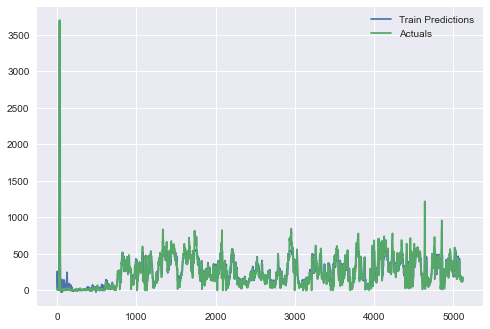

In [30]:
model = load_model('3H_Forecast/3H_ForecastModel_12_SizeWindow/')

X, y = DataHandler(3,12)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,shuffle=False) 
model.evaluate(X_test,y_test)

train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
plt.style.use('seaborn')

pd.concat([train_results['Train Predictions'],train_results['Actuals']],axis=1).plot()
plt.legend(['Train Predictions','Actuals'])

### 4 hours forecast

In [31]:
%%time

Trainer(4,6,12)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_22 (Bidirectio (None, 128)               35840     
_________________________________________________________________
dense_44 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 9         
Total params: 36,881
Trainable params: 36,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
161/161 [==============================] - 7s 19ms/step - loss: 111639.8672 - mean_absolute_error: 249.3363 - val_loss: 151283.0938 - val_mean_absolute_error: 335.1735
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 2/100
161/161 [==============================] - 2s 11ms/step - loss: 111296.6406 - mean_absolute_error: 248.6544 - val_loss: 150757.3594 - val_mean_absolute_error: 334.3485
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 3/100
161/161 [==============================] - 2s 11ms/step - loss: 110694.0469 - mean_absolute_error: 247.5092 - val_loss: 149658.1562 - val_mean_absolute_error: 332.6864
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 4/100
161/161 [==============================] - 2s 11ms/step - loss: 109558.9688 - mean_absolute_error: 245.3465 - val_loss: 147807.3750 - val_mean_absolute_error: 329.9323
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 5/100
161/161 [==============================] - 2s 12ms/step - loss: 108247.7656 - mean_absolute_error: 242.8649 - val_loss: 146001.2344 - val_mean_absolute_error: 327.1938
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 6/100
161/161 [==============================] - 2s 11ms/step - loss: 106830.1562 - mean_absolute_error: 240.1596 - val_loss: 144034.5469 - val_mean_absolute_error: 324.2036
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 7/100
161/161 [==============================] - 2s 12ms/step - loss: 105411.2891 - mean_absolute_error: 237.5027 - val_loss: 142002.2188 - val_mean_absolute_error: 320.9763
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 8/100
161/161 [==============================] - 2s 12ms/step - loss: 103651.1641 - mean_absolute_error: 234.3380 - val_loss: 139322.1406 - val_mean_absolute_error: 316.8115
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 9/100
161/161 [==============================] - 2s 14ms/step - loss: 101708.1328 - mean_absolute_error: 230.9091 - val_loss: 136660.5938 - val_mean_absolute_error: 312.6375
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 10/100
161/161 [==============================] - 2s 12ms/step - loss: 99713.0469 - mean_absolute_error: 227.3098 - val_loss: 133847.1406 - val_mean_absolute_error: 308.1612
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 11/100
161/161 [==============================] - 2s 13ms/step - loss: 97724.4609 - mean_absolute_error: 223.8693 - val_loss: 131106.1406 - val_mean_absolute_error: 303.7539
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 12/100
161/161 [==============================] - 2s 11ms/step - loss: 95779.1719 - mean_absolute_error: 220.3697 - val_loss: 128420.9922 - val_mean_absolute_error: 299.3624
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 13/100
161/161 [==============================] - 2s 10ms/step - loss: 93826.1250 - mean_absolute_error: 216.9404 - val_loss: 125696.0938 - val_mean_absolute_error: 294.8598
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 14/100
161/161 [==============================] - 2s 14ms/step - loss: 91866.8984 - mean_absolute_error: 213.2292 - val_loss: 122837.8906 - val_mean_absolute_error: 290.0619
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 15/100
161/161 [==============================] - 2s 12ms/step - loss: 89838.2031 - mean_absolute_error: 209.8053 - val_loss: 120072.3203 - val_mean_absolute_error: 285.3581
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 16/100
161/161 [==============================] - 2s 13ms/step - loss: 87832.6250 - mean_absolute_error: 206.1931 - val_loss: 117067.7578 - val_mean_absolute_error: 280.1949
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 17/100
161/161 [==============================] - 2s 13ms/step - loss: 85679.7031 - mean_absolute_error: 202.4069 - val_loss: 114126.1562 - val_mean_absolute_error: 275.1666
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 18/100
161/161 [==============================] - 2s 11ms/step - loss: 83668.6797 - mean_absolute_error: 198.7622 - val_loss: 111261.7422 - val_mean_absolute_error: 270.2151
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 19/100
161/161 [==============================] - 2s 11ms/step - loss: 81611.6328 - mean_absolute_error: 195.1411 - val_loss: 108211.5938 - val_mean_absolute_error: 264.8687
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 20/100
161/161 [==============================] - 2s 15ms/step - loss: 79468.7578 - mean_absolute_error: 191.2659 - val_loss: 105136.3125 - val_mean_absolute_error: 259.6035
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 21/100
161/161 [==============================] - 2s 10ms/step - loss: 77361.1719 - mean_absolute_error: 187.7306 - val_loss: 102192.2344 - val_mean_absolute_error: 254.5423
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 22/100
161/161 [==============================] - 2s 12ms/step - loss: 75370.9297 - mean_absolute_error: 184.0187 - val_loss: 99199.3750 - val_mean_absolute_error: 249.4930
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 23/100
161/161 [==============================] - 2s 10ms/step - loss: 73368.8750 - mean_absolute_error: 180.2145 - val_loss: 96318.8047 - val_mean_absolute_error: 244.6582
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 24/100
161/161 [==============================] - 2s 12ms/step - loss: 71402.5547 - mean_absolute_error: 176.4089 - val_loss: 93464.4688 - val_mean_absolute_error: 239.9082
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 25/100
161/161 [==============================] - 2s 12ms/step - loss: 69422.7812 - mean_absolute_error: 173.0176 - val_loss: 90458.8828 - val_mean_absolute_error: 234.8449
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 26/100
161/161 [==============================] - 2s 11ms/step - loss: 67314.0938 - mean_absolute_error: 169.0561 - val_loss: 87409.6875 - val_mean_absolute_error: 229.7225
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 27/100
161/161 [==============================] - 2s 12ms/step - loss: 65371.3711 - mean_absolute_error: 165.2877 - val_loss: 84525.7812 - val_mean_absolute_error: 224.8548
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 28/100
161/161 [==============================] - 2s 13ms/step - loss: 63418.2383 - mean_absolute_error: 161.4437 - val_loss: 81638.9062 - val_mean_absolute_error: 219.8557
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 29/100
161/161 [==============================] - 2s 13ms/step - loss: 61524.3125 - mean_absolute_error: 157.5422 - val_loss: 78738.0781 - val_mean_absolute_error: 214.6104
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 30/100
161/161 [==============================] - 2s 15ms/step - loss: 59647.7578 - mean_absolute_error: 153.8757 - val_loss: 76014.0156 - val_mean_absolute_error: 209.8468
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 31/100
161/161 [==============================] - 2s 10ms/step - loss: 57856.9062 - mean_absolute_error: 150.4523 - val_loss: 73331.9844 - val_mean_absolute_error: 204.8159
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 32/100
161/161 [==============================] - 2s 10ms/step - loss: 56132.3906 - mean_absolute_error: 147.0187 - val_loss: 70639.5078 - val_mean_absolute_error: 199.8178
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 33/100
161/161 [==============================] - 2s 13ms/step - loss: 54390.5234 - mean_absolute_error: 143.1716 - val_loss: 67993.6016 - val_mean_absolute_error: 195.2884
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 34/100
161/161 [==============================] - 2s 12ms/step - loss: 52765.0430 - mean_absolute_error: 139.7861 - val_loss: 65505.5625 - val_mean_absolute_error: 190.6565
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 35/100
161/161 [==============================] - 2s 14ms/step - loss: 51220.6641 - mean_absolute_error: 136.3716 - val_loss: 63094.4414 - val_mean_absolute_error: 186.1509
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 36/100
161/161 [==============================] - 3s 17ms/step - loss: 49743.7266 - mean_absolute_error: 132.9198 - val_loss: 60749.6641 - val_mean_absolute_error: 182.1565
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 37/100
161/161 [==============================] - 2s 12ms/step - loss: 48269.1992 - mean_absolute_error: 130.4595 - val_loss: 58442.9961 - val_mean_absolute_error: 177.9935
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 38/100
161/161 [==============================] - 2s 12ms/step - loss: 46848.6484 - mean_absolute_error: 127.5862 - val_loss: 56236.5625 - val_mean_absolute_error: 173.9749
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 39/100
161/161 [==============================] - 2s 12ms/step - loss: 45538.3633 - mean_absolute_error: 124.5241 - val_loss: 54124.7852 - val_mean_absolute_error: 170.2148
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 40/100
161/161 [==============================] - 3s 17ms/step - loss: 44244.3594 - mean_absolute_error: 121.6090 - val_loss: 52054.8789 - val_mean_absolute_error: 166.3228
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 41/100
161/161 [==============================] - 2s 12ms/step - loss: 42983.4531 - mean_absolute_error: 118.9156 - val_loss: 50078.6133 - val_mean_absolute_error: 162.9749
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 42/100
161/161 [==============================] - 2s 15ms/step - loss: 41823.7227 - mean_absolute_error: 116.3543 - val_loss: 48179.1523 - val_mean_absolute_error: 159.5630
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 43/100
161/161 [==============================] - 2s 12ms/step - loss: 40680.9453 - mean_absolute_error: 114.2479 - val_loss: 46288.3047 - val_mean_absolute_error: 156.0235
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 44/100
161/161 [==============================] - 2s 14ms/step - loss: 39599.6523 - mean_absolute_error: 111.4773 - val_loss: 44458.0547 - val_mean_absolute_error: 152.4566
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 45/100
161/161 [==============================] - 2s 14ms/step - loss: 38585.5703 - mean_absolute_error: 109.2208 - val_loss: 42999.8164 - val_mean_absolute_error: 149.6117
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 46/100
161/161 [==============================] - 2s 11ms/step - loss: 37585.6914 - mean_absolute_error: 107.1325 - val_loss: 41095.1445 - val_mean_absolute_error: 146.4147
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 47/100
161/161 [==============================] - 3s 17ms/step - loss: 36647.3945 - mean_absolute_error: 104.9232 - val_loss: 39586.2539 - val_mean_absolute_error: 143.5422
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 48/100
161/161 [==============================] - 2s 13ms/step - loss: 35763.0703 - mean_absolute_error: 103.0772 - val_loss: 37961.3477 - val_mean_absolute_error: 139.9301
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 49/100
161/161 [==============================] - 2s 15ms/step - loss: 34865.3789 - mean_absolute_error: 100.9245 - val_loss: 36418.2617 - val_mean_absolute_error: 136.8047
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 50/100
161/161 [==============================] - 2s 12ms/step - loss: 34110.9648 - mean_absolute_error: 99.1416 - val_loss: 34933.1523 - val_mean_absolute_error: 133.5717
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 51/100
161/161 [==============================] - 2s 14ms/step - loss: 33273.3945 - mean_absolute_error: 97.0411 - val_loss: 33630.1914 - val_mean_absolute_error: 130.5295
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 52/100
161/161 [==============================] - 2s 12ms/step - loss: 32542.3320 - mean_absolute_error: 95.3346 - val_loss: 32314.6621 - val_mean_absolute_error: 127.7432
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 53/100
161/161 [==============================] - 3s 16ms/step - loss: 31825.6016 - mean_absolute_error: 93.6997 - val_loss: 31088.8496 - val_mean_absolute_error: 124.8567
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 54/100
161/161 [==============================] - 2s 12ms/step - loss: 31174.1602 - mean_absolute_error: 92.2716 - val_loss: 29870.8457 - val_mean_absolute_error: 122.2963
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 55/100
161/161 [==============================] - 2s 13ms/step - loss: 30554.2656 - mean_absolute_error: 90.7729 - val_loss: 28914.2734 - val_mean_absolute_error: 120.2490
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 56/100
161/161 [==============================] - 2s 13ms/step - loss: 29984.9590 - mean_absolute_error: 89.5598 - val_loss: 27799.6309 - val_mean_absolute_error: 117.3764
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 57/100
161/161 [==============================] - 2s 12ms/step - loss: 29427.3262 - mean_absolute_error: 87.8614 - val_loss: 26715.4727 - val_mean_absolute_error: 115.0286
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 58/100
161/161 [==============================] - 2s 13ms/step - loss: 28889.8770 - mean_absolute_error: 87.1046 - val_loss: 25743.5098 - val_mean_absolute_error: 112.5979
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 59/100
161/161 [==============================] - 2s 12ms/step - loss: 28450.5605 - mean_absolute_error: 85.6693 - val_loss: 24769.0000 - val_mean_absolute_error: 110.5129
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 60/100
161/161 [==============================] - 2s 12ms/step - loss: 27967.2246 - mean_absolute_error: 84.8157 - val_loss: 24081.7012 - val_mean_absolute_error: 108.3358
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 61/100
161/161 [==============================] - 2s 11ms/step - loss: 27539.1270 - mean_absolute_error: 83.1220 - val_loss: 23098.1758 - val_mean_absolute_error: 106.1154
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 62/100
161/161 [==============================] - 2s 11ms/step - loss: 27096.7559 - mean_absolute_error: 82.1719 - val_loss: 22251.9980 - val_mean_absolute_error: 104.1878
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 63/100
161/161 [==============================] - 2s 13ms/step - loss: 26676.2676 - mean_absolute_error: 81.1191 - val_loss: 21573.4707 - val_mean_absolute_error: 102.2829
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 64/100
161/161 [==============================] - 3s 16ms/step - loss: 26295.3574 - mean_absolute_error: 80.1640 - val_loss: 20851.7930 - val_mean_absolute_error: 100.7032
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 65/100
161/161 [==============================] - 2s 12ms/step - loss: 25939.1270 - mean_absolute_error: 79.3765 - val_loss: 20229.6699 - val_mean_absolute_error: 98.7745
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 66/100
161/161 [==============================] - 2s 12ms/step - loss: 25611.8848 - mean_absolute_error: 78.3105 - val_loss: 19645.3184 - val_mean_absolute_error: 97.0355
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 67/100
161/161 [==============================] - 2s 12ms/step - loss: 25295.3516 - mean_absolute_error: 77.1442 - val_loss: 18941.5000 - val_mean_absolute_error: 95.6702
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 68/100
161/161 [==============================] - 2s 12ms/step - loss: 24999.8965 - mean_absolute_error: 76.3403 - val_loss: 18652.3945 - val_mean_absolute_error: 94.8047
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 69/100
161/161 [==============================] - 2s 12ms/step - loss: 24713.7305 - mean_absolute_error: 75.6363 - val_loss: 18057.7148 - val_mean_absolute_error: 93.0003
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 70/100
161/161 [==============================] - 2s 12ms/step - loss: 24432.3945 - mean_absolute_error: 74.5965 - val_loss: 17676.2754 - val_mean_absolute_error: 91.5274
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 71/100
161/161 [==============================] - 2s 13ms/step - loss: 24178.4531 - mean_absolute_error: 73.8211 - val_loss: 16878.4336 - val_mean_absolute_error: 89.4732
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 72/100
161/161 [==============================] - 2s 13ms/step - loss: 24102.0645 - mean_absolute_error: 73.5079 - val_loss: 16682.2715 - val_mean_absolute_error: 88.9378
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 73/100
161/161 [==============================] - 2s 13ms/step - loss: 23737.7383 - mean_absolute_error: 72.2010 - val_loss: 16415.0039 - val_mean_absolute_error: 88.0400
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 74/100
161/161 [==============================] - 2s 15ms/step - loss: 23506.3047 - mean_absolute_error: 71.5550 - val_loss: 15992.9004 - val_mean_absolute_error: 87.2056
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 75/100
161/161 [==============================] - 3s 20ms/step - loss: 23330.9727 - mean_absolute_error: 70.7942 - val_loss: 15639.1338 - val_mean_absolute_error: 86.2485
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 76/100
161/161 [==============================] - 2s 11ms/step - loss: 23150.3594 - mean_absolute_error: 70.5592 - val_loss: 15454.8877 - val_mean_absolute_error: 85.5815
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 77/100
161/161 [==============================] - 2s 12ms/step - loss: 23136.4766 - mean_absolute_error: 70.4040 - val_loss: 15234.7949 - val_mean_absolute_error: 84.9503
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 78/100
161/161 [==============================] - 2s 13ms/step - loss: 22871.7012 - mean_absolute_error: 69.3284 - val_loss: 15282.3223 - val_mean_absolute_error: 85.6045
Epoch 79/100
161/161 [==============================] - 2s 13ms/step - loss: 22709.8047 - mean_absolute_error: 68.8779 - val_loss: 15309.3398 - val_mean_absolute_error: 85.3307
Epoch 80/100
161/161 [==============================] - 2s 12ms/step - loss: 22602.9746 - mean_absolute_error: 68.3710 - val_loss: 14410.8877 - val_mean_absolute_error: 83.2299
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 81/100
161/161 [==============================] - 2s 11ms/step - loss: 22459.9180 - mean_absolute_error: 68.0921 - val_loss: 15047.8936 - val_mean_absolute_error: 84.6816
Epoch 82/100
161/161 [==============================] - 2s 11ms/step - loss: 22335.0527 - mean_absolute_error: 67.4444 - val_loss: 14025.1045 - val_mean_absolute_error: 81.9414
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 83/100
161/161 [==============================] - 2s 11ms/step - loss: 22285.0938 - mean_absolute_error: 67.3052 - val_loss: 13953.8926 - val_mean_absolute_error: 81.6234
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 84/100
161/161 [==============================] - 2s 11ms/step - loss: 22111.9570 - mean_absolute_error: 66.7381 - val_loss: 14727.9297 - val_mean_absolute_error: 83.9676
Epoch 85/100
161/161 [==============================] - 2s 11ms/step - loss: 22039.6074 - mean_absolute_error: 66.4610 - val_loss: 13651.2256 - val_mean_absolute_error: 81.1340
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 86/100
161/161 [==============================] - 2s 11ms/step - loss: 21978.1406 - mean_absolute_error: 66.3325 - val_loss: 13782.1055 - val_mean_absolute_error: 81.5009
Epoch 87/100
161/161 [==============================] - 2s 12ms/step - loss: 21913.1738 - mean_absolute_error: 65.8595 - val_loss: 13538.0693 - val_mean_absolute_error: 80.8412
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 88/100
161/161 [==============================] - 2s 14ms/step - loss: 21782.8340 - mean_absolute_error: 65.4973 - val_loss: 13523.5293 - val_mean_absolute_error: 80.2788
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 89/100
161/161 [==============================] - 2s 12ms/step - loss: 21747.6992 - mean_absolute_error: 65.4750 - val_loss: 13733.6777 - val_mean_absolute_error: 81.4048
Epoch 90/100
161/161 [==============================] - 2s 12ms/step - loss: 21673.1797 - mean_absolute_error: 64.9868 - val_loss: 13079.6338 - val_mean_absolute_error: 79.2001
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 91/100
161/161 [==============================] - 3s 16ms/step - loss: 21690.0781 - mean_absolute_error: 65.2359 - val_loss: 12908.8447 - val_mean_absolute_error: 78.6990
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 92/100
161/161 [==============================] - 2s 11ms/step - loss: 21533.5156 - mean_absolute_error: 64.5387 - val_loss: 12981.8906 - val_mean_absolute_error: 79.0119
Epoch 93/100
161/161 [==============================] - 2s 13ms/step - loss: 21439.7207 - mean_absolute_error: 64.1187 - val_loss: 13482.6426 - val_mean_absolute_error: 80.7500
Epoch 94/100
161/161 [==============================] - 3s 16ms/step - loss: 21383.0488 - mean_absolute_error: 64.0114 - val_loss: 12847.0049 - val_mean_absolute_error: 78.3653
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 95/100
161/161 [==============================] - 2s 12ms/step - loss: 21336.3086 - mean_absolute_error: 63.6462 - val_loss: 13342.2275 - val_mean_absolute_error: 80.4012
Epoch 96/100
161/161 [==============================] - 3s 16ms/step - loss: 21273.3574 - mean_absolute_error: 63.5545 - val_loss: 13057.7881 - val_mean_absolute_error: 79.3213
Epoch 97/100
161/161 [==============================] - 2s 15ms/step - loss: 21276.1992 - mean_absolute_error: 63.4216 - val_loss: 12833.9072 - val_mean_absolute_error: 78.8762
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 98/100
161/161 [==============================] - 2s 12ms/step - loss: 21191.7344 - mean_absolute_error: 63.5381 - val_loss: 12310.5703 - val_mean_absolute_error: 76.9177
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 99/100
161/161 [==============================] - 2s 13ms/step - loss: 21113.3770 - mean_absolute_error: 62.8596 - val_loss: 12572.3174 - val_mean_absolute_error: 78.1454
Epoch 100/100
161/161 [==============================] - 2s 13ms/step - loss: 21067.5508 - mean_absolute_error: 62.9007 - val_loss: 12477.1094 - val_mean_absolute_error: 77.7622

-----------------------------------------------------------------------------------------------------------

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_23 (Bidirectio (None, 128)               35840     
_________________________________________________________________
dense_46 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 9         
Total params: 36,881
Trainable params: 36,881
Non-

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 2/100
161/161 [==============================] - 3s 16ms/step - loss: 110206.6094 - mean_absolute_error: 246.7027 - val_loss: 148762.3906 - val_mean_absolute_error: 331.3279
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 3/100
161/161 [==============================] - 2s 15ms/step - loss: 108966.8828 - mean_absolute_error: 244.2682 - val_loss: 146912.8281 - val_mean_absolute_error: 328.4511
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 4/100
161/161 [==============================] - 3s 16ms/step - loss: 107460.3984 - mean_absolute_error: 241.3880 - val_loss: 144661.7656 - val_mean_absolute_error: 325.0444
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 5/100
161/161 [==============================] - 2s 13ms/step - loss: 105696.3281 - mean_absolute_error: 238.1266 - val_loss: 142308.6875 - val_mean_absolute_error: 321.4632
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 6/100
161/161 [==============================] - 2s 15ms/step - loss: 104021.1250 - mean_absolute_error: 235.0439 - val_loss: 139908.7188 - val_mean_absolute_error: 317.7968
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 7/100
161/161 [==============================] - 3s 16ms/step - loss: 102233.1484 - mean_absolute_error: 231.7998 - val_loss: 137426.2031 - val_mean_absolute_error: 313.8958
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 8/100
161/161 [==============================] - 3s 16ms/step - loss: 100472.4609 - mean_absolute_error: 228.6331 - val_loss: 135131.8281 - val_mean_absolute_error: 310.1862
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 9/100
161/161 [==============================] - 2s 15ms/step - loss: 98811.6172 - mean_absolute_error: 225.7621 - val_loss: 132841.0938 - val_mean_absolute_error: 306.5481
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 10/100
161/161 [==============================] - 3s 17ms/step - loss: 97195.5156 - mean_absolute_error: 222.8845 - val_loss: 130570.9609 - val_mean_absolute_error: 302.8673
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 11/100
161/161 [==============================] - 3s 18ms/step - loss: 95487.7812 - mean_absolute_error: 219.8927 - val_loss: 128168.3828 - val_mean_absolute_error: 298.9536
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 12/100
161/161 [==============================] - 2s 13ms/step - loss: 93815.8594 - mean_absolute_error: 216.9491 - val_loss: 125681.8828 - val_mean_absolute_error: 294.8646
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 13/100
161/161 [==============================] - 2s 11ms/step - loss: 91861.5312 - mean_absolute_error: 213.3759 - val_loss: 122895.7109 - val_mean_absolute_error: 290.1454
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 14/100
161/161 [==============================] - 2s 12ms/step - loss: 89947.5312 - mean_absolute_error: 209.8661 - val_loss: 120403.0000 - val_mean_absolute_error: 285.9044
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 15/100
161/161 [==============================] - 4s 22ms/step - loss: 88202.1875 - mean_absolute_error: 206.9550 - val_loss: 117937.1953 - val_mean_absolute_error: 281.7129
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 16/100
161/161 [==============================] - 3s 17ms/step - loss: 86523.6484 - mean_absolute_error: 203.9059 - val_loss: 115591.8047 - val_mean_absolute_error: 277.6931
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 17/100
161/161 [==============================] - 2s 14ms/step - loss: 84823.0859 - mean_absolute_error: 200.7084 - val_loss: 113036.4688 - val_mean_absolute_error: 273.2165
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 18/100
161/161 [==============================] - 3s 18ms/step - loss: 82941.0312 - mean_absolute_error: 197.4803 - val_loss: 110342.0078 - val_mean_absolute_error: 268.6224
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 19/100
161/161 [==============================] - 2s 14ms/step - loss: 81135.4531 - mean_absolute_error: 194.2364 - val_loss: 107832.3906 - val_mean_absolute_error: 264.2666
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 20/100
161/161 [==============================] - 2s 12ms/step - loss: 79363.1094 - mean_absolute_error: 191.0228 - val_loss: 105170.7422 - val_mean_absolute_error: 259.6703
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 21/100
161/161 [==============================] - 3s 16ms/step - loss: 77547.4375 - mean_absolute_error: 187.7130 - val_loss: 102671.9062 - val_mean_absolute_error: 255.3884
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 22/100
161/161 [==============================] - 3s 20ms/step - loss: 75816.5547 - mean_absolute_error: 184.3992 - val_loss: 100176.7578 - val_mean_absolute_error: 251.1276
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 23/100
161/161 [==============================] - 2s 13ms/step - loss: 74132.5938 - mean_absolute_error: 181.3599 - val_loss: 97755.1953 - val_mean_absolute_error: 247.0499
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 24/100
161/161 [==============================] - 2s 15ms/step - loss: 72513.5469 - mean_absolute_error: 178.4715 - val_loss: 95411.1094 - val_mean_absolute_error: 243.1100
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 25/100
161/161 [==============================] - 3s 17ms/step - loss: 70926.2734 - mean_absolute_error: 175.5374 - val_loss: 93066.2031 - val_mean_absolute_error: 239.2245
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 26/100
161/161 [==============================] - 3s 16ms/step - loss: 69348.2734 - mean_absolute_error: 172.4193 - val_loss: 90770.2188 - val_mean_absolute_error: 235.3898
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 27/100
161/161 [==============================] - 3s 17ms/step - loss: 67771.9453 - mean_absolute_error: 169.6927 - val_loss: 88496.6562 - val_mean_absolute_error: 231.5731
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 28/100
161/161 [==============================] - 3s 17ms/step - loss: 66233.8125 - mean_absolute_error: 166.4932 - val_loss: 86143.1953 - val_mean_absolute_error: 227.6868
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 29/100
161/161 [==============================] - 3s 16ms/step - loss: 64668.5430 - mean_absolute_error: 164.0311 - val_loss: 83917.5703 - val_mean_absolute_error: 223.8697
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 30/100
161/161 [==============================] - 2s 14ms/step - loss: 63236.0195 - mean_absolute_error: 160.8041 - val_loss: 81729.2188 - val_mean_absolute_error: 220.1114
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 31/100
161/161 [==============================] - 2s 14ms/step - loss: 61765.8320 - mean_absolute_error: 157.9840 - val_loss: 79543.4844 - val_mean_absolute_error: 216.2414
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 32/100
161/161 [==============================] - 2s 14ms/step - loss: 60327.6406 - mean_absolute_error: 155.1618 - val_loss: 77405.4922 - val_mean_absolute_error: 212.5152
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 33/100
161/161 [==============================] - 3s 16ms/step - loss: 58949.1914 - mean_absolute_error: 152.6630 - val_loss: 75316.0859 - val_mean_absolute_error: 208.6983
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 34/100
161/161 [==============================] - 2s 13ms/step - loss: 57516.6055 - mean_absolute_error: 149.8045 - val_loss: 73021.5781 - val_mean_absolute_error: 204.6454
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 35/100
161/161 [==============================] - 2s 14ms/step - loss: 56104.3555 - mean_absolute_error: 147.1832 - val_loss: 70882.9531 - val_mean_absolute_error: 200.8308
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 36/100
161/161 [==============================] - 2s 12ms/step - loss: 54723.7930 - mean_absolute_error: 144.2908 - val_loss: 68797.7734 - val_mean_absolute_error: 196.9297
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 37/100
161/161 [==============================] - 2s 13ms/step - loss: 53374.4453 - mean_absolute_error: 141.3456 - val_loss: 66719.3125 - val_mean_absolute_error: 193.1706
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 38/100
161/161 [==============================] - 2s 13ms/step - loss: 52076.2383 - mean_absolute_error: 138.5314 - val_loss: 64692.0469 - val_mean_absolute_error: 189.5453
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 39/100
161/161 [==============================] - 2s 14ms/step - loss: 50771.5859 - mean_absolute_error: 135.6333 - val_loss: 62721.6289 - val_mean_absolute_error: 186.0388
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 40/100
161/161 [==============================] - 2s 15ms/step - loss: 49544.2930 - mean_absolute_error: 133.1242 - val_loss: 60846.6641 - val_mean_absolute_error: 182.6394
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 41/100
161/161 [==============================] - 2s 14ms/step - loss: 48367.8203 - mean_absolute_error: 130.5550 - val_loss: 58956.2539 - val_mean_absolute_error: 179.2379
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 42/100
161/161 [==============================] - 2s 12ms/step - loss: 47217.1602 - mean_absolute_error: 128.0485 - val_loss: 57075.3164 - val_mean_absolute_error: 175.7233
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 43/100
161/161 [==============================] - 2s 13ms/step - loss: 45966.8867 - mean_absolute_error: 125.5417 - val_loss: 55166.9492 - val_mean_absolute_error: 172.3117
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 44/100
161/161 [==============================] - 2s 12ms/step - loss: 44863.0469 - mean_absolute_error: 122.7340 - val_loss: 53432.2734 - val_mean_absolute_error: 169.0116
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 45/100
161/161 [==============================] - 2s 14ms/step - loss: 43797.8164 - mean_absolute_error: 120.5763 - val_loss: 51715.1797 - val_mean_absolute_error: 165.9291
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 46/100
161/161 [==============================] - 3s 16ms/step - loss: 42797.3594 - mean_absolute_error: 118.5209 - val_loss: 50126.6406 - val_mean_absolute_error: 163.4395
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 47/100
161/161 [==============================] - 2s 14ms/step - loss: 41811.6914 - mean_absolute_error: 116.5180 - val_loss: 48542.6602 - val_mean_absolute_error: 160.4537
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 48/100
161/161 [==============================] - 3s 18ms/step - loss: 40903.2500 - mean_absolute_error: 114.4823 - val_loss: 47061.1562 - val_mean_absolute_error: 157.7807
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 49/100
161/161 [==============================] - 3s 22ms/step - loss: 40022.8438 - mean_absolute_error: 112.4090 - val_loss: 45535.0039 - val_mean_absolute_error: 155.0375
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 50/100
161/161 [==============================] - 3s 20ms/step - loss: 39136.3750 - mean_absolute_error: 110.5036 - val_loss: 44239.8906 - val_mean_absolute_error: 152.7248
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 51/100
161/161 [==============================] - 2s 15ms/step - loss: 38271.6875 - mean_absolute_error: 108.8160 - val_loss: 42794.5195 - val_mean_absolute_error: 150.0797
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 52/100
161/161 [==============================] - 2s 12ms/step - loss: 37513.8477 - mean_absolute_error: 106.7842 - val_loss: 41392.2148 - val_mean_absolute_error: 147.5344
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 53/100
161/161 [==============================] - 2s 12ms/step - loss: 36705.2734 - mean_absolute_error: 105.2912 - val_loss: 40068.2070 - val_mean_absolute_error: 144.8417
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 54/100
161/161 [==============================] - 2s 15ms/step - loss: 35951.3711 - mean_absolute_error: 103.4693 - val_loss: 38910.0898 - val_mean_absolute_error: 142.8179
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 55/100
161/161 [==============================] - 2s 14ms/step - loss: 35269.8633 - mean_absolute_error: 101.8424 - val_loss: 37669.5312 - val_mean_absolute_error: 140.3014
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 56/100
161/161 [==============================] - 2s 14ms/step - loss: 34577.2969 - mean_absolute_error: 100.3237 - val_loss: 36341.6602 - val_mean_absolute_error: 137.4960
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 57/100
161/161 [==============================] - 2s 13ms/step - loss: 33880.8672 - mean_absolute_error: 98.7210 - val_loss: 35228.0195 - val_mean_absolute_error: 135.1376
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 58/100
161/161 [==============================] - 3s 16ms/step - loss: 33282.5078 - mean_absolute_error: 97.3395 - val_loss: 34175.6445 - val_mean_absolute_error: 132.6376
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 59/100
161/161 [==============================] - 2s 14ms/step - loss: 32676.0371 - mean_absolute_error: 95.8223 - val_loss: 33061.3633 - val_mean_absolute_error: 130.3523
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 60/100
161/161 [==============================] - 2s 15ms/step - loss: 32127.2129 - mean_absolute_error: 94.5885 - val_loss: 31978.3574 - val_mean_absolute_error: 127.7369
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 61/100
161/161 [==============================] - 3s 16ms/step - loss: 31492.3125 - mean_absolute_error: 92.7404 - val_loss: 31013.2383 - val_mean_absolute_error: 125.7718
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 62/100
161/161 [==============================] - 3s 16ms/step - loss: 31001.5352 - mean_absolute_error: 91.8260 - val_loss: 30063.0742 - val_mean_absolute_error: 123.6894
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 63/100
161/161 [==============================] - 2s 14ms/step - loss: 30452.6484 - mean_absolute_error: 90.5972 - val_loss: 29199.7520 - val_mean_absolute_error: 121.4327
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 64/100
161/161 [==============================] - 2s 14ms/step - loss: 29967.1445 - mean_absolute_error: 88.9503 - val_loss: 28299.1914 - val_mean_absolute_error: 119.3858
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 65/100
161/161 [==============================] - 2s 14ms/step - loss: 29515.1035 - mean_absolute_error: 88.1384 - val_loss: 27553.2598 - val_mean_absolute_error: 117.1737
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 66/100
161/161 [==============================] - 2s 14ms/step - loss: 29032.7539 - mean_absolute_error: 86.9999 - val_loss: 26635.8027 - val_mean_absolute_error: 115.2927
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 67/100
161/161 [==============================] - 3s 17ms/step - loss: 28619.2441 - mean_absolute_error: 85.7402 - val_loss: 25822.1758 - val_mean_absolute_error: 113.1633
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 68/100
161/161 [==============================] - 3s 16ms/step - loss: 28177.5742 - mean_absolute_error: 84.2781 - val_loss: 25010.8809 - val_mean_absolute_error: 111.3078
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 69/100
161/161 [==============================] - 3s 19ms/step - loss: 27787.3418 - mean_absolute_error: 83.6188 - val_loss: 24318.7871 - val_mean_absolute_error: 109.4324
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 70/100
161/161 [==============================] - 2s 15ms/step - loss: 27379.0156 - mean_absolute_error: 82.4256 - val_loss: 23694.4551 - val_mean_absolute_error: 107.8197
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 71/100
161/161 [==============================] - 3s 16ms/step - loss: 27080.6797 - mean_absolute_error: 81.7471 - val_loss: 23187.1406 - val_mean_absolute_error: 106.4184
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 72/100
161/161 [==============================] - 3s 16ms/step - loss: 26763.2578 - mean_absolute_error: 80.6299 - val_loss: 22301.5137 - val_mean_absolute_error: 104.0211
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 73/100
161/161 [==============================] - 3s 16ms/step - loss: 26319.7402 - mean_absolute_error: 79.5487 - val_loss: 21585.9395 - val_mean_absolute_error: 102.1564
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 74/100
161/161 [==============================] - 3s 17ms/step - loss: 25946.3379 - mean_absolute_error: 78.6455 - val_loss: 21181.6660 - val_mean_absolute_error: 100.7683
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 75/100
161/161 [==============================] - 2s 14ms/step - loss: 25656.9648 - mean_absolute_error: 77.5786 - val_loss: 20585.3984 - val_mean_absolute_error: 99.6550
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 76/100
161/161 [==============================] - 2s 13ms/step - loss: 25349.3340 - mean_absolute_error: 77.0185 - val_loss: 20062.0918 - val_mean_absolute_error: 98.0534
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 77/100
161/161 [==============================] - 3s 21ms/step - loss: 25125.5527 - mean_absolute_error: 76.2110 - val_loss: 19784.1758 - val_mean_absolute_error: 97.9371
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 78/100
161/161 [==============================] - 2s 14ms/step - loss: 24836.3965 - mean_absolute_error: 75.5191 - val_loss: 19171.4082 - val_mean_absolute_error: 95.8763
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 79/100
161/161 [==============================] - 3s 22ms/step - loss: 24603.7480 - mean_absolute_error: 74.7142 - val_loss: 18724.4199 - val_mean_absolute_error: 94.8206
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 80/100
161/161 [==============================] - 3s 17ms/step - loss: 24540.6270 - mean_absolute_error: 74.7064 - val_loss: 18179.4844 - val_mean_absolute_error: 93.1444
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 81/100
161/161 [==============================] - 2s 13ms/step - loss: 24179.1113 - mean_absolute_error: 73.2803 - val_loss: 17755.0840 - val_mean_absolute_error: 92.2451
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 82/100
161/161 [==============================] - 2s 13ms/step - loss: 23916.5781 - mean_absolute_error: 73.2617 - val_loss: 17481.3457 - val_mean_absolute_error: 91.5856
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 83/100
161/161 [==============================] - 2s 14ms/step - loss: 23786.6660 - mean_absolute_error: 72.4747 - val_loss: 17155.2324 - val_mean_absolute_error: 90.6558
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 84/100
161/161 [==============================] - 2s 13ms/step - loss: 23526.0547 - mean_absolute_error: 71.4923 - val_loss: 16735.1367 - val_mean_absolute_error: 89.3009
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 85/100
161/161 [==============================] - 2s 12ms/step - loss: 23353.3574 - mean_absolute_error: 71.1068 - val_loss: 16595.9180 - val_mean_absolute_error: 88.7629
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 86/100
161/161 [==============================] - 2s 15ms/step - loss: 23225.7402 - mean_absolute_error: 70.7076 - val_loss: 16385.7090 - val_mean_absolute_error: 88.4726
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 87/100
161/161 [==============================] - 2s 15ms/step - loss: 23068.2656 - mean_absolute_error: 70.1130 - val_loss: 16033.8398 - val_mean_absolute_error: 87.4949
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 88/100
161/161 [==============================] - 3s 16ms/step - loss: 22867.5879 - mean_absolute_error: 69.7381 - val_loss: 15571.1426 - val_mean_absolute_error: 85.8490
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 89/100
161/161 [==============================] - 3s 16ms/step - loss: 22717.1797 - mean_absolute_error: 69.0344 - val_loss: 15367.8545 - val_mean_absolute_error: 85.2779
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 90/100
161/161 [==============================] - 2s 15ms/step - loss: 22503.3926 - mean_absolute_error: 68.4242 - val_loss: 15014.2168 - val_mean_absolute_error: 84.5782
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 91/100
161/161 [==============================] - 3s 16ms/step - loss: 22383.7930 - mean_absolute_error: 68.1274 - val_loss: 14965.3115 - val_mean_absolute_error: 84.3104
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 92/100
161/161 [==============================] - 3s 18ms/step - loss: 22171.8281 - mean_absolute_error: 67.5304 - val_loss: 15042.1826 - val_mean_absolute_error: 84.3231
Epoch 93/100
161/161 [==============================] - 3s 18ms/step - loss: 22366.8770 - mean_absolute_error: 68.1568 - val_loss: 14784.1943 - val_mean_absolute_error: 83.4754
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 94/100
161/161 [==============================] - 2s 12ms/step - loss: 22341.7305 - mean_absolute_error: 67.7139 - val_loss: 14502.6377 - val_mean_absolute_error: 82.5282
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 95/100
161/161 [==============================] - 2s 12ms/step - loss: 22090.9199 - mean_absolute_error: 66.7274 - val_loss: 14416.6074 - val_mean_absolute_error: 82.5804
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 96/100
161/161 [==============================] - 2s 15ms/step - loss: 21899.4180 - mean_absolute_error: 66.0662 - val_loss: 13910.4834 - val_mean_absolute_error: 80.9340
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 97/100
161/161 [==============================] - 3s 17ms/step - loss: 21821.1621 - mean_absolute_error: 66.1145 - val_loss: 14363.2344 - val_mean_absolute_error: 82.5290
Epoch 98/100
161/161 [==============================] - 3s 16ms/step - loss: 21692.3359 - mean_absolute_error: 65.4404 - val_loss: 13811.6094 - val_mean_absolute_error: 80.9682
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 99/100
161/161 [==============================] - 3s 17ms/step - loss: 21651.1699 - mean_absolute_error: 65.8991 - val_loss: 13850.0742 - val_mean_absolute_error: 80.9450
Epoch 100/100
161/161 [==============================] - 3s 18ms/step - loss: 21520.9297 - mean_absolute_error: 64.8639 - val_loss: 13582.0830 - val_mean_absolute_error: 80.2089
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_24 (Bidirectio (None, 128)               35840     
_________________________________________________________________
dense_48 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 9         
Total params: 36,881
Trainable params: 36,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
161/161 [==============================] - 13s 28ms/step - loss: 111312.0625 - mean_absolute_error: 248.7458 - val_loss: 150413.2812 - val_mean_absolute_error: 333.8308
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 2/100
161/161 [==============================] - 2s 14ms/step - loss: 109947.3516 - mean_absolute_error: 246.2117 - val_loss: 147966.9062 - val_mean_absolute_error: 330.0821
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 3/100
161/161 [==============================] - 3s 17ms/step - loss: 107954.2188 - mean_absolute_error: 242.2702 - val_loss: 145139.0000 - val_mean_absolute_error: 325.5708
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 4/100
161/161 [==============================] - 2s 15ms/step - loss: 105530.0781 - mean_absolute_error: 237.7214 - val_loss: 141407.3281 - val_mean_absolute_error: 319.9550
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 5/100
161/161 [==============================] - 2s 15ms/step - loss: 102601.7578 - mean_absolute_error: 232.3998 - val_loss: 137306.1094 - val_mean_absolute_error: 313.5630
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 6/100
161/161 [==============================] - 2s 13ms/step - loss: 99746.1797 - mean_absolute_error: 227.3692 - val_loss: 133364.3438 - val_mean_absolute_error: 307.3825
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 7/100
161/161 [==============================] - 2s 13ms/step - loss: 97033.8047 - mean_absolute_error: 222.5745 - val_loss: 129838.9844 - val_mean_absolute_error: 301.6181
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 8/100
161/161 [==============================] - 2s 15ms/step - loss: 94320.5703 - mean_absolute_error: 217.7988 - val_loss: 125725.8047 - val_mean_absolute_error: 294.8122
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 9/100
161/161 [==============================] - 2s 14ms/step - loss: 91411.7578 - mean_absolute_error: 212.5703 - val_loss: 121809.6094 - val_mean_absolute_error: 288.1782
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 10/100
161/161 [==============================] - 3s 17ms/step - loss: 88558.6406 - mean_absolute_error: 207.4227 - val_loss: 117544.6797 - val_mean_absolute_error: 280.9793
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 11/100
161/161 [==============================] - 2s 13ms/step - loss: 85683.3516 - mean_absolute_error: 202.4505 - val_loss: 113762.8672 - val_mean_absolute_error: 274.5522
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 12/100
161/161 [==============================] - 3s 16ms/step - loss: 83120.2188 - mean_absolute_error: 197.7366 - val_loss: 110166.6562 - val_mean_absolute_error: 268.3319
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 13/100
161/161 [==============================] - 2s 15ms/step - loss: 80544.8906 - mean_absolute_error: 193.2669 - val_loss: 106344.7188 - val_mean_absolute_error: 261.6994
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 14/100
161/161 [==============================] - 3s 16ms/step - loss: 77743.1484 - mean_absolute_error: 188.2237 - val_loss: 102062.9688 - val_mean_absolute_error: 254.3210
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 15/100
161/161 [==============================] - 3s 19ms/step - loss: 74889.5078 - mean_absolute_error: 182.9739 - val_loss: 98149.2422 - val_mean_absolute_error: 247.7321
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 16/100
161/161 [==============================] - 3s 16ms/step - loss: 72304.3125 - mean_absolute_error: 178.1623 - val_loss: 94406.9375 - val_mean_absolute_error: 241.4930
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 17/100
161/161 [==============================] - 3s 19ms/step - loss: 69729.4453 - mean_absolute_error: 173.3920 - val_loss: 90569.6094 - val_mean_absolute_error: 235.0521
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 18/100
161/161 [==============================] - 3s 21ms/step - loss: 67163.5391 - mean_absolute_error: 168.7818 - val_loss: 87006.0703 - val_mean_absolute_error: 229.0832
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 19/100
161/161 [==============================] - 3s 20ms/step - loss: 64858.2500 - mean_absolute_error: 163.6744 - val_loss: 83462.8359 - val_mean_absolute_error: 223.0708
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 20/100
161/161 [==============================] - 3s 21ms/step - loss: 62465.7266 - mean_absolute_error: 159.7673 - val_loss: 80027.3906 - val_mean_absolute_error: 217.2077
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 21/100
161/161 [==============================] - 4s 23ms/step - loss: 60240.1641 - mean_absolute_error: 155.1910 - val_loss: 76881.9062 - val_mean_absolute_error: 211.6495
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 22/100
161/161 [==============================] - 3s 16ms/step - loss: 58075.7266 - mean_absolute_error: 151.2657 - val_loss: 73541.6641 - val_mean_absolute_error: 205.6865
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 23/100
161/161 [==============================] - 2s 15ms/step - loss: 56034.7617 - mean_absolute_error: 147.1849 - val_loss: 70483.8672 - val_mean_absolute_error: 200.1606
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 24/100
161/161 [==============================] - 2s 15ms/step - loss: 54058.2227 - mean_absolute_error: 142.8175 - val_loss: 67263.5156 - val_mean_absolute_error: 194.2952
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 25/100
161/161 [==============================] - 3s 16ms/step - loss: 52119.0586 - mean_absolute_error: 138.8943 - val_loss: 64496.5469 - val_mean_absolute_error: 189.2195
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 26/100
161/161 [==============================] - 3s 17ms/step - loss: 50323.4258 - mean_absolute_error: 135.3632 - val_loss: 61704.4961 - val_mean_absolute_error: 184.2776
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 27/100
161/161 [==============================] - 2s 15ms/step - loss: 48584.6328 - mean_absolute_error: 131.8082 - val_loss: 59037.0430 - val_mean_absolute_error: 179.5561
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 28/100
161/161 [==============================] - 3s 16ms/step - loss: 46910.9453 - mean_absolute_error: 127.8262 - val_loss: 56277.5195 - val_mean_absolute_error: 174.5353
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 29/100
161/161 [==============================] - 2s 13ms/step - loss: 45184.1016 - mean_absolute_error: 124.5122 - val_loss: 53406.1484 - val_mean_absolute_error: 169.6221
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 30/100
161/161 [==============================] - 2s 13ms/step - loss: 43625.2422 - mean_absolute_error: 120.8095 - val_loss: 51021.2930 - val_mean_absolute_error: 165.1863
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 31/100
161/161 [==============================] - 2s 15ms/step - loss: 42180.4297 - mean_absolute_error: 117.9387 - val_loss: 48823.4609 - val_mean_absolute_error: 161.1593
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 32/100
161/161 [==============================] - 2s 16ms/step - loss: 40943.7109 - mean_absolute_error: 115.1103 - val_loss: 46579.5000 - val_mean_absolute_error: 157.1931
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 33/100
161/161 [==============================] - 3s 18ms/step - loss: 39673.6641 - mean_absolute_error: 112.9579 - val_loss: 44628.7891 - val_mean_absolute_error: 154.0215
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 34/100
161/161 [==============================] - 3s 16ms/step - loss: 38597.3633 - mean_absolute_error: 110.3765 - val_loss: 42594.7617 - val_mean_absolute_error: 150.1893
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 35/100
161/161 [==============================] - 3s 17ms/step - loss: 37456.8516 - mean_absolute_error: 107.6258 - val_loss: 40828.0547 - val_mean_absolute_error: 146.4273
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 36/100
161/161 [==============================] - 3s 16ms/step - loss: 36387.1836 - mean_absolute_error: 105.2460 - val_loss: 38872.8242 - val_mean_absolute_error: 142.6504
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 37/100
161/161 [==============================] - 3s 16ms/step - loss: 35401.4688 - mean_absolute_error: 103.2214 - val_loss: 37341.2188 - val_mean_absolute_error: 139.3891
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 38/100
161/161 [==============================] - 3s 20ms/step - loss: 34471.0156 - mean_absolute_error: 101.0132 - val_loss: 35741.1797 - val_mean_absolute_error: 136.3107
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 39/100
161/161 [==============================] - 2s 15ms/step - loss: 33649.4766 - mean_absolute_error: 98.6832 - val_loss: 34138.6133 - val_mean_absolute_error: 132.7169
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 40/100
161/161 [==============================] - 2s 14ms/step - loss: 32778.3906 - mean_absolute_error: 97.2749 - val_loss: 32767.5508 - val_mean_absolute_error: 129.7268
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 41/100
161/161 [==============================] - 2s 14ms/step - loss: 32033.3613 - mean_absolute_error: 95.2751 - val_loss: 31353.0176 - val_mean_absolute_error: 126.6492
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 42/100
161/161 [==============================] - 2s 14ms/step - loss: 31281.3125 - mean_absolute_error: 93.4481 - val_loss: 30012.0332 - val_mean_absolute_error: 123.6589
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 43/100
161/161 [==============================] - 3s 19ms/step - loss: 30622.4160 - mean_absolute_error: 91.5879 - val_loss: 28876.6582 - val_mean_absolute_error: 120.7930
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 44/100
161/161 [==============================] - 2s 14ms/step - loss: 29971.4453 - mean_absolute_error: 89.9959 - val_loss: 27614.5059 - val_mean_absolute_error: 118.1036
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 45/100
161/161 [==============================] - 2s 14ms/step - loss: 29345.7656 - mean_absolute_error: 88.7822 - val_loss: 26493.9238 - val_mean_absolute_error: 115.1579
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 46/100
161/161 [==============================] - 3s 16ms/step - loss: 28710.1777 - mean_absolute_error: 87.0018 - val_loss: 25530.8008 - val_mean_absolute_error: 112.6590
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 47/100
161/161 [==============================] - 3s 17ms/step - loss: 28181.5684 - mean_absolute_error: 85.4307 - val_loss: 24460.7285 - val_mean_absolute_error: 109.9189
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 48/100
161/161 [==============================] - 3s 21ms/step - loss: 27674.4863 - mean_absolute_error: 84.1925 - val_loss: 23483.5078 - val_mean_absolute_error: 107.7645
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 49/100
161/161 [==============================] - 2s 15ms/step - loss: 27183.0625 - mean_absolute_error: 83.1900 - val_loss: 22791.6621 - val_mean_absolute_error: 105.6535
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 50/100
161/161 [==============================] - 2s 14ms/step - loss: 26799.9961 - mean_absolute_error: 81.9560 - val_loss: 22229.4824 - val_mean_absolute_error: 104.4676
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 51/100
161/161 [==============================] - 2s 14ms/step - loss: 26432.2754 - mean_absolute_error: 80.8385 - val_loss: 21297.0664 - val_mean_absolute_error: 102.2476
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 52/100
161/161 [==============================] - 2s 15ms/step - loss: 26101.2754 - mean_absolute_error: 81.1044 - val_loss: 20531.2461 - val_mean_absolute_error: 100.2847
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 53/100
161/161 [==============================] - 2s 13ms/step - loss: 25739.4707 - mean_absolute_error: 79.4982 - val_loss: 19736.5410 - val_mean_absolute_error: 98.1871
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 54/100
161/161 [==============================] - 2s 13ms/step - loss: 25369.9590 - mean_absolute_error: 78.2521 - val_loss: 19201.7305 - val_mean_absolute_error: 96.7098
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 55/100
161/161 [==============================] - 3s 17ms/step - loss: 25045.7969 - mean_absolute_error: 77.6099 - val_loss: 18651.0938 - val_mean_absolute_error: 95.3692
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 56/100
161/161 [==============================] - 2s 15ms/step - loss: 24900.6484 - mean_absolute_error: 76.8307 - val_loss: 18145.0996 - val_mean_absolute_error: 93.9442
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 57/100
161/161 [==============================] - 4s 23ms/step - loss: 24583.3945 - mean_absolute_error: 75.8509 - val_loss: 17886.6641 - val_mean_absolute_error: 93.3410
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 58/100
161/161 [==============================] - 2s 15ms/step - loss: 24271.8125 - mean_absolute_error: 74.9184 - val_loss: 17534.0898 - val_mean_absolute_error: 92.3123
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 59/100
161/161 [==============================] - 3s 16ms/step - loss: 24033.2812 - mean_absolute_error: 74.0480 - val_loss: 17000.6719 - val_mean_absolute_error: 90.9581
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 60/100
161/161 [==============================] - 2s 15ms/step - loss: 23879.5527 - mean_absolute_error: 73.8357 - val_loss: 17125.0879 - val_mean_absolute_error: 91.5971
Epoch 61/100
161/161 [==============================] - 2s 15ms/step - loss: 23661.9883 - mean_absolute_error: 73.4859 - val_loss: 16669.0332 - val_mean_absolute_error: 90.6003
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 62/100
161/161 [==============================] - 3s 16ms/step - loss: 23461.1152 - mean_absolute_error: 72.2907 - val_loss: 16024.1680 - val_mean_absolute_error: 88.7116
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 63/100
161/161 [==============================] - 3s 21ms/step - loss: 23315.2363 - mean_absolute_error: 72.2779 - val_loss: 15780.5820 - val_mean_absolute_error: 87.5939
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 64/100
161/161 [==============================] - 2s 15ms/step - loss: 23207.3770 - mean_absolute_error: 71.6982 - val_loss: 15374.1152 - val_mean_absolute_error: 86.4684
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 65/100
161/161 [==============================] - 2s 15ms/step - loss: 23010.9160 - mean_absolute_error: 70.9750 - val_loss: 15446.7354 - val_mean_absolute_error: 86.9974
Epoch 66/100
161/161 [==============================] - 3s 17ms/step - loss: 22868.3613 - mean_absolute_error: 70.9817 - val_loss: 15503.5430 - val_mean_absolute_error: 87.2104
Epoch 67/100
161/161 [==============================] - 3s 16ms/step - loss: 22708.7480 - mean_absolute_error: 69.6596 - val_loss: 14656.8369 - val_mean_absolute_error: 84.6640
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 68/100
161/161 [==============================] - 3s 16ms/step - loss: 22618.4062 - mean_absolute_error: 69.7024 - val_loss: 15172.0127 - val_mean_absolute_error: 85.7702
Epoch 69/100
161/161 [==============================] - 2s 15ms/step - loss: 22432.1094 - mean_absolute_error: 69.1554 - val_loss: 14814.4590 - val_mean_absolute_error: 84.7845
Epoch 70/100
161/161 [==============================] - 2s 14ms/step - loss: 22362.4199 - mean_absolute_error: 68.6345 - val_loss: 14331.1035 - val_mean_absolute_error: 83.1242
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 71/100
161/161 [==============================] - 2s 14ms/step - loss: 22233.9805 - mean_absolute_error: 67.8576 - val_loss: 13772.0391 - val_mean_absolute_error: 81.7824
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 72/100
161/161 [==============================] - 3s 22ms/step - loss: 22078.3086 - mean_absolute_error: 67.8169 - val_loss: 13988.2090 - val_mean_absolute_error: 82.0052
Epoch 73/100
161/161 [==============================] - 4s 24ms/step - loss: 22102.5703 - mean_absolute_error: 67.5487 - val_loss: 13897.8965 - val_mean_absolute_error: 82.0516
Epoch 74/100
161/161 [==============================] - 4s 23ms/step - loss: 21966.0742 - mean_absolute_error: 67.1765 - val_loss: 14005.9785 - val_mean_absolute_error: 82.9311
Epoch 75/100
161/161 [==============================] - 3s 20ms/step - loss: 21770.5312 - mean_absolute_error: 66.5748 - val_loss: 13697.9980 - val_mean_absolute_error: 81.6280
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 76/100
161/161 [==============================] - 3s 16ms/step - loss: 21829.7891 - mean_absolute_error: 66.7865 - val_loss: 13630.5713 - val_mean_absolute_error: 81.1624
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 77/100
161/161 [==============================] - 2s 15ms/step - loss: 21761.8926 - mean_absolute_error: 66.4709 - val_loss: 13809.5615 - val_mean_absolute_error: 82.2765
Epoch 78/100
161/161 [==============================] - 3s 16ms/step - loss: 21681.1738 - mean_absolute_error: 66.1312 - val_loss: 13652.3008 - val_mean_absolute_error: 81.4586
Epoch 79/100
161/161 [==============================] - 2s 15ms/step - loss: 21570.6406 - mean_absolute_error: 66.0393 - val_loss: 13374.0107 - val_mean_absolute_error: 80.4157
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 80/100
161/161 [==============================] - 3s 17ms/step - loss: 21544.2246 - mean_absolute_error: 65.6033 - val_loss: 13005.5742 - val_mean_absolute_error: 79.5724
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 81/100
161/161 [==============================] - 2s 13ms/step - loss: 21425.5508 - mean_absolute_error: 65.2192 - val_loss: 12914.0918 - val_mean_absolute_error: 79.1586
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 82/100
161/161 [==============================] - 3s 17ms/step - loss: 21359.5859 - mean_absolute_error: 65.3396 - val_loss: 12637.5176 - val_mean_absolute_error: 78.1100
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 83/100
161/161 [==============================] - 2s 14ms/step - loss: 21339.9062 - mean_absolute_error: 64.9415 - val_loss: 12941.8867 - val_mean_absolute_error: 79.1073
Epoch 84/100
161/161 [==============================] - 3s 17ms/step - loss: 21193.4004 - mean_absolute_error: 64.6344 - val_loss: 13139.7764 - val_mean_absolute_error: 79.5432
Epoch 85/100
161/161 [==============================] - 3s 17ms/step - loss: 21154.6973 - mean_absolute_error: 64.5135 - val_loss: 13220.0713 - val_mean_absolute_error: 80.2613
Epoch 86/100
161/161 [==============================] - 3s 16ms/step - loss: 21125.9492 - mean_absolute_error: 64.4106 - val_loss: 13271.4463 - val_mean_absolute_error: 80.1164
Epoch 87/100
161/161 [==============================] - 2s 15ms/step - loss: 21054.8496 - mean_absolute_error: 64.0864 - val_loss: 12896.8057 - val_mean_absolute_error: 79.0183
Epoch 88/100
161/161 [==============================] - 3s 16ms/step - loss: 21026.6035 - mean_absolute_error: 64.1

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 89/100
161/161 [==============================] - 3s 18ms/step - loss: 20898.4883 - mean_absolute_error: 63.3615 - val_loss: 12535.0625 - val_mean_absolute_error: 77.7608
Epoch 90/100
161/161 [==============================] - 3s 20ms/step - loss: 20907.5820 - mean_absolute_error: 63.5158 - val_loss: 12551.3506 - val_mean_absolute_error: 77.7634
Epoch 91/100
161/161 [==============================] - 3s 18ms/step - loss: 20929.0996 - mean_absolute_error: 63.9031 - val_loss: 12810.2910 - val_mean_absolute_error: 78.8380
Epoch 92/100
161/161 [==============================] - 3s 17ms/step - loss: 20892.9297 - mean_absolute_error: 63.9534 - val_loss: 12558.9424 - val_mean_absolute_error: 77.6243
Epoch 93/100
161/161 [==============================] - 3s 21ms/step - loss: 20800.8438 - mean_absolute_error: 63.1775 - val_loss: 12467.5352 - val_mean_absolute_error: 77.5247
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 94/100
161/161 [==============================] - 3s 16ms/step - loss: 20747.4414 - mean_absolute_error: 63.0069 - val_loss: 12629.4023 - val_mean_absolute_error: 78.2518
Epoch 95/100
161/161 [==============================] - 3s 16ms/step - loss: 20659.3164 - mean_absolute_error: 62.5966 - val_loss: 12689.6025 - val_mean_absolute_error: 78.5990
Epoch 96/100
161/161 [==============================] - 3s 19ms/step - loss: 20627.2598 - mean_absolute_error: 62.5698 - val_loss: 12399.8281 - val_mean_absolute_error: 77.6126
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 97/100
161/161 [==============================] - 2s 14ms/step - loss: 20638.8203 - mean_absolute_error: 62.7353 - val_loss: 11757.7715 - val_mean_absolute_error: 75.0421
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 98/100
161/161 [==============================] - 2s 13ms/step - loss: 20613.4414 - mean_absolute_error: 62.4668 - val_loss: 11767.0811 - val_mean_absolute_error: 75.0139
Epoch 99/100
161/161 [==============================] - 2s 13ms/step - loss: 20481.5938 - mean_absolute_error: 62.0905 - val_loss: 11747.2070 - val_mean_absolute_error: 75.1212
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 100/100
161/161 [==============================] - 2s 15ms/step - loss: 20503.3945 - mean_absolute_error: 62.1220 - val_loss: 11686.7041 - val_mean_absolute_error: 75.1420
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_25 (Bidirectio (None, 128)               35840     
_________________________________________________________________
dense_50 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 9         
Total params: 36,881
Trainable params: 36,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
161/161 [==============================] - 9s 33ms/step - loss: 111380.1719 - mean_absolute_error: 248.8266 - val_loss: 150307.5000 - val_mean_absolute_error: 333.6032
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 2/100
161/161 [==============================] - 3s 21ms/step - loss: 109585.6562 - mean_absolute_error: 245.3145 - val_loss: 147152.6406 - val_mean_absolute_error: 328.5120
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 3/100
161/161 [==============================] - 4s 22ms/step - loss: 106716.0938 - mean_absolute_error: 239.6539 - val_loss: 142631.4688 - val_mean_absolute_error: 321.2906
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 4/100
161/161 [==============================] - 2s 16ms/step - loss: 103193.5781 - mean_absolute_error: 233.1081 - val_loss: 137965.8750 - val_mean_absolute_error: 314.0660
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 5/100
161/161 [==============================] - 3s 16ms/step - loss: 99730.9062 - mean_absolute_error: 226.9647 - val_loss: 132919.0469 - val_mean_absolute_error: 306.1281
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 6/100
161/161 [==============================] - 3s 16ms/step - loss: 95883.2188 - mean_absolute_error: 220.4343 - val_loss: 127384.5781 - val_mean_absolute_error: 297.3313
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 7/100
161/161 [==============================] - 2s 16ms/step - loss: 92253.9531 - mean_absolute_error: 214.2377 - val_loss: 122511.5781 - val_mean_absolute_error: 289.3157
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 8/100
161/161 [==============================] - 2s 15ms/step - loss: 88505.1641 - mean_absolute_error: 207.6300 - val_loss: 116899.6719 - val_mean_absolute_error: 279.7478
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 9/100
161/161 [==============================] - 3s 19ms/step - loss: 84832.2656 - mean_absolute_error: 201.3039 - val_loss: 111860.4141 - val_mean_absolute_error: 271.0645
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 10/100
161/161 [==============================] - 3s 20ms/step - loss: 81301.1719 - mean_absolute_error: 195.2923 - val_loss: 107040.5000 - val_mean_absolute_error: 262.8007
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 11/100
161/161 [==============================] - 3s 16ms/step - loss: 78091.5859 - mean_absolute_error: 189.7303 - val_loss: 102502.4766 - val_mean_absolute_error: 255.0527
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 12/100
161/161 [==============================] - 3s 16ms/step - loss: 75135.5312 - mean_absolute_error: 183.6877 - val_loss: 98263.7734 - val_mean_absolute_error: 247.8875
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 13/100
161/161 [==============================] - 3s 20ms/step - loss: 72300.1250 - mean_absolute_error: 178.6518 - val_loss: 94188.1406 - val_mean_absolute_error: 241.0948
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 14/100
161/161 [==============================] - 3s 19ms/step - loss: 69562.4219 - mean_absolute_error: 173.3319 - val_loss: 90234.5000 - val_mean_absolute_error: 234.5753
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 15/100
161/161 [==============================] - 3s 18ms/step - loss: 66927.8750 - mean_absolute_error: 169.0665 - val_loss: 86408.2578 - val_mean_absolute_error: 228.2207
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 16/100
161/161 [==============================] - 3s 22ms/step - loss: 64412.2305 - mean_absolute_error: 163.8893 - val_loss: 82707.6484 - val_mean_absolute_error: 221.9117
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 17/100
161/161 [==============================] - 3s 20ms/step - loss: 61984.8867 - mean_absolute_error: 158.9480 - val_loss: 79092.5703 - val_mean_absolute_error: 215.6691
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 18/100
161/161 [==============================] - 4s 27ms/step - loss: 59658.7773 - mean_absolute_error: 154.5387 - val_loss: 75652.4453 - val_mean_absolute_error: 209.5395
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 19/100
161/161 [==============================] - 3s 17ms/step - loss: 57420.1484 - mean_absolute_error: 149.8676 - val_loss: 72203.6016 - val_mean_absolute_error: 203.4661
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 20/100
161/161 [==============================] - 5s 32ms/step - loss: 55231.9453 - mean_absolute_error: 146.0138 - val_loss: 68950.3906 - val_mean_absolute_error: 197.5954
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 21/100
161/161 [==============================] - 3s 20ms/step - loss: 53058.9688 - mean_absolute_error: 141.3794 - val_loss: 65733.3594 - val_mean_absolute_error: 191.9435
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 22/100
161/161 [==============================] - 3s 18ms/step - loss: 51058.4023 - mean_absolute_error: 137.1940 - val_loss: 62632.0195 - val_mean_absolute_error: 186.5262
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 23/100
161/161 [==============================] - 2s 15ms/step - loss: 49237.2227 - mean_absolute_error: 132.8494 - val_loss: 59756.8633 - val_mean_absolute_error: 181.4943
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 24/100
161/161 [==============================] - 3s 18ms/step - loss: 47397.4609 - mean_absolute_error: 129.4229 - val_loss: 56869.0273 - val_mean_absolute_error: 176.3713
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 25/100
161/161 [==============================] - 3s 20ms/step - loss: 45692.3398 - mean_absolute_error: 125.7363 - val_loss: 54200.8125 - val_mean_absolute_error: 171.3415
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 26/100
161/161 [==============================] - 3s 17ms/step - loss: 44002.2070 - mean_absolute_error: 120.9560 - val_loss: 51394.3906 - val_mean_absolute_error: 166.2405
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 27/100
161/161 [==============================] - 4s 22ms/step - loss: 42452.3281 - mean_absolute_error: 118.8916 - val_loss: 49008.2852 - val_mean_absolute_error: 161.7836
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 28/100
161/161 [==============================] - 4s 22ms/step - loss: 41012.0664 - mean_absolute_error: 114.7842 - val_loss: 46709.9414 - val_mean_absolute_error: 158.0005
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 29/100
161/161 [==============================] - 3s 20ms/step - loss: 39685.9961 - mean_absolute_error: 112.5626 - val_loss: 45003.7852 - val_mean_absolute_error: 155.0264
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 30/100
161/161 [==============================] - 4s 24ms/step - loss: 38426.5898 - mean_absolute_error: 109.5448 - val_loss: 42439.0078 - val_mean_absolute_error: 150.3104
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 31/100
161/161 [==============================] - 4s 25ms/step - loss: 37245.6094 - mean_absolute_error: 106.6716 - val_loss: 40509.3789 - val_mean_absolute_error: 146.6948
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 32/100
161/161 [==============================] - 3s 20ms/step - loss: 36134.2617 - mean_absolute_error: 104.6285 - val_loss: 38679.6602 - val_mean_absolute_error: 142.9505
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 33/100
161/161 [==============================] - 3s 21ms/step - loss: 35156.3125 - mean_absolute_error: 102.3408 - val_loss: 37041.5039 - val_mean_absolute_error: 140.0266
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 34/100
161/161 [==============================] - 3s 20ms/step - loss: 34225.5547 - mean_absolute_error: 99.9172 - val_loss: 35359.3906 - val_mean_absolute_error: 136.4590
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 35/100
161/161 [==============================] - 3s 18ms/step - loss: 33325.2305 - mean_absolute_error: 98.1546 - val_loss: 33957.0586 - val_mean_absolute_error: 133.6820
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 36/100
161/161 [==============================] - 3s 19ms/step - loss: 32533.4336 - mean_absolute_error: 96.3250 - val_loss: 32545.4219 - val_mean_absolute_error: 130.8444
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 37/100
161/161 [==============================] - 3s 21ms/step - loss: 31729.4844 - mean_absolute_error: 94.5881 - val_loss: 30957.6465 - val_mean_absolute_error: 126.9832
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 38/100
161/161 [==============================] - 3s 19ms/step - loss: 30951.1445 - mean_absolute_error: 92.3355 - val_loss: 29672.7305 - val_mean_absolute_error: 123.9816
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 39/100
161/161 [==============================] - 3s 17ms/step - loss: 30268.0039 - mean_absolute_error: 90.6803 - val_loss: 28419.7344 - val_mean_absolute_error: 121.0977
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 40/100
161/161 [==============================] - 3s 18ms/step - loss: 29601.5020 - mean_absolute_error: 89.1736 - val_loss: 27809.5723 - val_mean_absolute_error: 119.3197
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 41/100
161/161 [==============================] - 3s 20ms/step - loss: 29036.5137 - mean_absolute_error: 87.4943 - val_loss: 26173.4980 - val_mean_absolute_error: 115.9536
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 42/100
161/161 [==============================] - 3s 19ms/step - loss: 28537.1914 - mean_absolute_error: 87.3609 - val_loss: 25155.9805 - val_mean_absolute_error: 113.2827
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 43/100
161/161 [==============================] - 3s 18ms/step - loss: 27967.1152 - mean_absolute_error: 85.2540 - val_loss: 24421.1191 - val_mean_absolute_error: 111.2730
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 44/100
161/161 [==============================] - 3s 17ms/step - loss: 27540.4336 - mean_absolute_error: 84.2284 - val_loss: 23397.9004 - val_mean_absolute_error: 108.7087
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 45/100
161/161 [==============================] - 3s 19ms/step - loss: 27083.4941 - mean_absolute_error: 82.7288 - val_loss: 22554.7637 - val_mean_absolute_error: 106.4150
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 46/100
161/161 [==============================] - 4s 25ms/step - loss: 26599.9199 - mean_absolute_error: 81.1576 - val_loss: 21708.8066 - val_mean_absolute_error: 104.2855
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 47/100
161/161 [==============================] - 3s 20ms/step - loss: 26218.5703 - mean_absolute_error: 80.1251 - val_loss: 20926.0078 - val_mean_absolute_error: 102.6182
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 48/100
161/161 [==============================] - 4s 24ms/step - loss: 25863.9922 - mean_absolute_error: 79.5813 - val_loss: 20806.5566 - val_mean_absolute_error: 101.7762
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 49/100
161/161 [==============================] - 3s 21ms/step - loss: 25535.6934 - mean_absolute_error: 78.3617 - val_loss: 20045.4082 - val_mean_absolute_error: 99.8964
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 50/100
161/161 [==============================] - 3s 20ms/step - loss: 25236.3633 - mean_absolute_error: 77.2890 - val_loss: 19548.7363 - val_mean_absolute_error: 98.9052
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 51/100
161/161 [==============================] - 3s 18ms/step - loss: 24950.5566 - mean_absolute_error: 76.8546 - val_loss: 19324.0586 - val_mean_absolute_error: 97.9161
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 52/100
161/161 [==============================] - 3s 19ms/step - loss: 24656.1250 - mean_absolute_error: 76.0122 - val_loss: 18728.2773 - val_mean_absolute_error: 96.5686
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 53/100
161/161 [==============================] - 3s 19ms/step - loss: 24404.4648 - mean_absolute_error: 75.0826 - val_loss: 18796.8242 - val_mean_absolute_error: 96.3199
Epoch 54/100
161/161 [==============================] - 3s 19ms/step - loss: 24244.6289 - mean_absolute_error: 74.6532 - val_loss: 18046.4551 - val_mean_absolute_error: 94.1909
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 55/100
161/161 [==============================] - 4s 22ms/step - loss: 23965.7090 - mean_absolute_error: 74.0917 - val_loss: 17725.4941 - val_mean_absolute_error: 93.3494
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 56/100
161/161 [==============================] - 4s 22ms/step - loss: 23769.0547 - mean_absolute_error: 72.9953 - val_loss: 17072.3105 - val_mean_absolute_error: 91.7970
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 57/100
161/161 [==============================] - 3s 19ms/step - loss: 23527.9180 - mean_absolute_error: 72.4191 - val_loss: 16688.0391 - val_mean_absolute_error: 90.4749
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 58/100
161/161 [==============================] - 3s 22ms/step - loss: 23346.7832 - mean_absolute_error: 71.6609 - val_loss: 16462.7656 - val_mean_absolute_error: 90.1353
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 59/100
161/161 [==============================] - 4s 22ms/step - loss: 23123.0039 - mean_absolute_error: 70.9773 - val_loss: 16085.9199 - val_mean_absolute_error: 89.1536
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 60/100
161/161 [==============================] - 3s 18ms/step - loss: 23044.1680 - mean_absolute_error: 70.6397 - val_loss: 15825.4678 - val_mean_absolute_error: 88.3177
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 61/100
161/161 [==============================] - 3s 22ms/step - loss: 22860.2949 - mean_absolute_error: 70.0313 - val_loss: 15686.9434 - val_mean_absolute_error: 87.4817
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 62/100
161/161 [==============================] - 3s 16ms/step - loss: 22623.3066 - mean_absolute_error: 68.9681 - val_loss: 15119.6973 - val_mean_absolute_error: 86.4548
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 63/100
161/161 [==============================] - 3s 17ms/step - loss: 22517.7773 - mean_absolute_error: 69.2408 - val_loss: 15264.3643 - val_mean_absolute_error: 86.4103
Epoch 64/100
161/161 [==============================] - 2s 16ms/step - loss: 22363.1133 - mean_absolute_error: 68.1082 - val_loss: 15025.4893 - val_mean_absolute_error: 85.9860
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 65/100
161/161 [==============================] - 5s 30ms/step - loss: 22215.6992 - mean_absolute_error: 67.8145 - val_loss: 14900.6748 - val_mean_absolute_error: 85.4014
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 66/100
161/161 [==============================] - 3s 19ms/step - loss: 22099.3340 - mean_absolute_error: 67.4464 - val_loss: 15007.7705 - val_mean_absolute_error: 85.9340
Epoch 67/100
161/161 [==============================] - 3s 19ms/step - loss: 21957.6309 - mean_absolute_error: 66.7896 - val_loss: 14289.4609 - val_mean_absolute_error: 84.0839
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 68/100
161/161 [==============================] - 3s 19ms/step - loss: 21943.3652 - mean_absolute_error: 66.8490 - val_loss: 13770.8896 - val_mean_absolute_error: 82.7866
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 69/100
161/161 [==============================] - 3s 20ms/step - loss: 21813.9473 - mean_absolute_error: 66.4627 - val_loss: 13937.3828 - val_mean_absolute_error: 82.8254
Epoch 70/100
161/161 [==============================] - 4s 22ms/step - loss: 21669.8906 - mean_absolute_error: 65.5543 - val_loss: 13809.8457 - val_mean_absolute_error: 82.4185
Epoch 71/100
161/161 [==============================] - 4s 24ms/step - loss: 21549.9902 - mean_absolute_error: 65.4110 - val_loss: 13695.2842 - val_mean_absolute_error: 82.1057
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 72/100
161/161 [==============================] - 4s 22ms/step - loss: 21486.7656 - mean_absolute_error: 64.8661 - val_loss: 13355.3789 - val_mean_absolute_error: 81.7082
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 73/100
161/161 [==============================] - 3s 19ms/step - loss: 21450.7266 - mean_absolute_error: 65.2363 - val_loss: 13163.9414 - val_mean_absolute_error: 80.5059
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 74/100
161/161 [==============================] - 3s 18ms/step - loss: 21321.0645 - mean_absolute_error: 64.4824 - val_loss: 13177.0322 - val_mean_absolute_error: 79.9959
Epoch 75/100
161/161 [==============================] - 3s 18ms/step - loss: 21234.4844 - mean_absolute_error: 64.3163 - val_loss: 13376.6572 - val_mean_absolute_error: 81.1125
Epoch 76/100
161/161 [==============================] - 3s 17ms/step - loss: 21128.5801 - mean_absolute_error: 63.7459 - val_loss: 13105.4619 - val_mean_absolute_error: 80.6035
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 77/100
161/161 [==============================] - 3s 16ms/step - loss: 21229.6445 - mean_absolute_error: 64.3378 - val_loss: 13007.9951 - val_mean_absolute_error: 79.7561
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 78/100
161/161 [==============================] - 3s 21ms/step - loss: 21041.4922 - mean_absolute_error: 63.8835 - val_loss: 12951.1436 - val_mean_absolute_error: 79.2918
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 79/100
161/161 [==============================] - 3s 16ms/step - loss: 20964.0391 - mean_absolute_error: 63.4940 - val_loss: 12708.7031 - val_mean_absolute_error: 78.3893
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 80/100
161/161 [==============================] - 3s 16ms/step - loss: 20819.2148 - mean_absolute_error: 62.8038 - val_loss: 12603.0029 - val_mean_absolute_error: 78.0836
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 81/100
161/161 [==============================] - 3s 20ms/step - loss: 20697.1582 - mean_absolute_error: 62.2107 - val_loss: 12506.0518 - val_mean_absolute_error: 77.5184
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 82/100
161/161 [==============================] - 3s 20ms/step - loss: 20653.4590 - mean_absolute_error: 62.2124 - val_loss: 12138.5176 - val_mean_absolute_error: 76.6642
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 83/100
161/161 [==============================] - 3s 17ms/step - loss: 20693.0215 - mean_absolute_error: 62.4151 - val_loss: 12469.4902 - val_mean_absolute_error: 77.5322
Epoch 84/100
161/161 [==============================] - 3s 17ms/step - loss: 20594.2539 - mean_absolute_error: 61.9520 - val_loss: 12266.1641 - val_mean_absolute_error: 76.8969
Epoch 85/100
161/161 [==============================] - 3s 16ms/step - loss: 20568.5293 - mean_absolute_error: 61.4925 - val_loss: 12431.9111 - val_mean_absolute_error: 77.9632
Epoch 86/100
161/161 [==============================] - 3s 17ms/step - loss: 20547.6172 - mean_absolute_error: 62.2300 - val_loss: 12061.7793 - val_mean_absolute_error: 76.4209
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 87/100
161/161 [==============================] - 3s 17ms/step - loss: 20426.7051 - mean_absolute_error: 61.3874 - val_loss: 11937.1855 - val_mean_absolute_error: 75.8401
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 88/100
161/161 [==============================] - 3s 21ms/step - loss: 20391.4453 - mean_absolute_error: 61.5510 - val_loss: 11961.4727 - val_mean_absolute_error: 76.3765
Epoch 89/100
161/161 [==============================] - 4s 22ms/step - loss: 20369.4707 - mean_absolute_error: 61.5534 - val_loss: 12074.3262 - val_mean_absolute_error: 76.6723
Epoch 90/100
161/161 [==============================] - 4s 22ms/step - loss: 20341.7012 - mean_absolute_error: 61.3168 - val_loss: 11598.7051 - val_mean_absolute_error: 74.6631
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 91/100
161/161 [==============================] - 3s 18ms/step - loss: 20287.5684 - mean_absolute_error: 61.3906 - val_loss: 11535.9434 - val_mean_absolute_error: 74.5035
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 92/100
161/161 [==============================] - 3s 17ms/step - loss: 20236.4648 - mean_absolute_error: 60.8391 - val_loss: 11456.8047 - val_mean_absolute_error: 74.8374
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 93/100
161/161 [==============================] - 5s 30ms/step - loss: 20268.1543 - mean_absolute_error: 61.0791 - val_loss: 11663.1357 - val_mean_absolute_error: 75.2201
Epoch 94/100
161/161 [==============================] - 4s 24ms/step - loss: 20209.7617 - mean_absolute_error: 61.1646 - val_loss: 11888.9795 - val_mean_absolute_error: 76.0824
Epoch 95/100
161/161 [==============================] - 4s 24ms/step - loss: 20148.4512 - mean_absolute_error: 60.7362 - val_loss: 11567.1787 - val_mean_absolute_error: 74.5663
Epoch 96/100
161/161 [==============================] - 3s 20ms/step - loss: 20063.9805 - mean_absolute_error: 60.6739 - val_loss: 11264.1562 - val_mean_absolute_error: 73.9085
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 97/100
161/161 [==============================] - 4s 22ms/step - loss: 20024.9238 - mean_absolute_error: 60.4719 - val_loss: 11534.8203 - val_mean_absolute_error: 74.9939
Epoch 98/100
161/161 [==============================] - 3s 21ms/step - loss: 20050.7051 - mean_absolute_error: 60.7356 - val_loss: 11456.3115 - val_mean_absolute_error: 74.5415
Epoch 99/100
161/161 [==============================] - 3s 18ms/step - loss: 20016.0801 - mean_absolute_error: 60.6831 - val_loss: 11234.9746 - val_mean_absolute_error: 73.9095
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 100/100
161/161 [==============================] - 3s 17ms/step - loss: 20129.7598 - mean_absolute_error: 61.6380 - val_loss: 11382.0234 - val_mean_absolute_error: 74.7935- mean - ETA: 0s - loss: 16378.4453 - mean_absolute_error: 60.

-----------------------------------------------------------------------------------------------------------

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_26 (Bidirectio (None, 128)               35840     
_________________________________________________________________
dense_52 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 9         
Total params: 36,881
Trainable params: 36,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
160/160 [========

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 2/100
160/160 [==============================] - 3s 18ms/step - loss: 108172.8906 - mean_absolute_error: 242.7066 - val_loss: 144733.4062 - val_mean_absolute_error: 324.6998
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 3/100
160/160 [==============================] - 3s 18ms/step - loss: 104650.8047 - mean_absolute_error: 235.8309 - val_loss: 139202.6719 - val_mean_absolute_error: 315.8198
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 4/100
160/160 [==============================] - 3s 19ms/step - loss: 99894.8594 - mean_absolute_error: 227.1560 - val_loss: 132332.3438 - val_mean_absolute_error: 305.1400
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 5/100
160/160 [==============================] - 3s 22ms/step - loss: 95355.8594 - mean_absolute_error: 219.3023 - val_loss: 126088.8516 - val_mean_absolute_error: 295.1427
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 6/100
160/160 [==============================] - 5s 29ms/step - loss: 90946.2031 - mean_absolute_error: 211.6234 - val_loss: 119836.3516 - val_mean_absolute_error: 284.6744
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 7/100
160/160 [==============================] - 4s 24ms/step - loss: 86407.6406 - mean_absolute_error: 203.7683 - val_loss: 113561.4141 - val_mean_absolute_error: 274.0470
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 8/100
160/160 [==============================] - 7s 41ms/step - loss: 82392.4844 - mean_absolute_error: 196.5453 - val_loss: 108058.2734 - val_mean_absolute_error: 264.5671
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 9/100
160/160 [==============================] - 4s 27ms/step - loss: 78589.2500 - mean_absolute_error: 190.0081 - val_loss: 102496.9062 - val_mean_absolute_error: 255.0110
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 10/100
160/160 [==============================] - 4s 25ms/step - loss: 74748.6328 - mean_absolute_error: 182.6994 - val_loss: 97106.2500 - val_mean_absolute_error: 245.9073
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 11/100
160/160 [==============================] - 4s 25ms/step - loss: 71118.4922 - mean_absolute_error: 176.5765 - val_loss: 91630.6328 - val_mean_absolute_error: 236.7903
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 12/100
160/160 [==============================] - 4s 23ms/step - loss: 67625.7656 - mean_absolute_error: 170.1729 - val_loss: 86880.8281 - val_mean_absolute_error: 228.8290
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 13/100
160/160 [==============================] - 3s 18ms/step - loss: 64417.8984 - mean_absolute_error: 163.5568 - val_loss: 82092.3047 - val_mean_absolute_error: 220.5701
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 14/100
160/160 [==============================] - 3s 16ms/step - loss: 61440.4922 - mean_absolute_error: 157.8472 - val_loss: 77681.0781 - val_mean_absolute_error: 212.8592
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 15/100
160/160 [==============================] - 3s 22ms/step - loss: 58400.9258 - mean_absolute_error: 152.1061 - val_loss: 73189.4531 - val_mean_absolute_error: 204.6729
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 16/100
160/160 [==============================] - 3s 17ms/step - loss: 55649.0508 - mean_absolute_error: 145.7869 - val_loss: 68998.5703 - val_mean_absolute_error: 196.9938
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 17/100
160/160 [==============================] - 3s 21ms/step - loss: 53002.8516 - mean_absolute_error: 140.5348 - val_loss: 64971.9922 - val_mean_absolute_error: 189.6718
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 18/100
160/160 [==============================] - 3s 21ms/step - loss: 50559.5039 - mean_absolute_error: 135.3497 - val_loss: 61308.3672 - val_mean_absolute_error: 182.9557
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 19/100
160/160 [==============================] - 4s 28ms/step - loss: 48224.3281 - mean_absolute_error: 130.2803 - val_loss: 57721.9062 - val_mean_absolute_error: 176.7405
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 20/100
160/160 [==============================] - 4s 28ms/step - loss: 46155.8008 - mean_absolute_error: 125.6884 - val_loss: 54478.4062 - val_mean_absolute_error: 171.3021
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 21/100
160/160 [==============================] - 6s 35ms/step - loss: 44201.8008 - mean_absolute_error: 122.2303 - val_loss: 51450.8086 - val_mean_absolute_error: 165.7616
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 22/100
160/160 [==============================] - 4s 23ms/step - loss: 42428.9023 - mean_absolute_error: 118.0825 - val_loss: 48586.1758 - val_mean_absolute_error: 160.8803olute_error
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 23/100
160/160 [==============================] - 4s 24ms/step - loss: 40757.5273 - mean_absolute_error: 114.3741 - val_loss: 45752.3789 - val_mean_absolute_error: 155.5091
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 24/100
160/160 [==============================] - 3s 21ms/step - loss: 39088.9141 - mean_absolute_error: 110.9970 - val_loss: 43233.9883 - val_mean_absolute_error: 150.9165
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 25/100
160/160 [==============================] - 3s 19ms/step - loss: 37723.4805 - mean_absolute_error: 107.8075 - val_loss: 40906.0820 - val_mean_absolute_error: 146.2334
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 26/100
160/160 [==============================] - 3s 18ms/step - loss: 36418.7070 - mean_absolute_error: 105.1234 - val_loss: 38668.7461 - val_mean_absolute_error: 142.3263
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 27/100
160/160 [==============================] - 3s 20ms/step - loss: 35250.7812 - mean_absolute_error: 102.2447 - val_loss: 36630.2891 - val_mean_absolute_error: 138.0559
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 28/100
160/160 [==============================] - 5s 28ms/step - loss: 34144.0859 - mean_absolute_error: 100.0656 - val_loss: 34695.8047 - val_mean_absolute_error: 134.1363
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 29/100
160/160 [==============================] - 4s 26ms/step - loss: 33114.8438 - mean_absolute_error: 97.8995 - val_loss: 32996.6172 - val_mean_absolute_error: 130.3951
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 30/100
160/160 [==============================] - 5s 29ms/step - loss: 32198.4492 - mean_absolute_error: 95.3709 - val_loss: 31186.4199 - val_mean_absolute_error: 126.5503
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 31/100
160/160 [==============================] - 4s 25ms/step - loss: 31289.4727 - mean_absolute_error: 93.2436 - val_loss: 29604.0352 - val_mean_absolute_error: 122.9785
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 32/100
160/160 [==============================] - 3s 22ms/step - loss: 30481.1191 - mean_absolute_error: 91.3072 - val_loss: 28069.2344 - val_mean_absolute_error: 119.4650
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 33/100
160/160 [==============================] - 3s 21ms/step - loss: 29752.3594 - mean_absolute_error: 90.0939 - val_loss: 26789.8105 - val_mean_absolute_error: 116.4835
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 34/100
160/160 [==============================] - 5s 29ms/step - loss: 29057.9004 - mean_absolute_error: 88.5584 - val_loss: 25583.9043 - val_mean_absolute_error: 113.6147
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 35/100
160/160 [==============================] - 6s 39ms/step - loss: 28475.7539 - mean_absolute_error: 86.5801 - val_loss: 24415.6230 - val_mean_absolute_error: 110.9298
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 36/100
160/160 [==============================] - 6s 40ms/step - loss: 27911.9531 - mean_absolute_error: 85.2247 - val_loss: 23603.1699 - val_mean_absolute_error: 109.1650
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 37/100
160/160 [==============================] - 3s 21ms/step - loss: 27320.2930 - mean_absolute_error: 83.5238 - val_loss: 22453.2559 - val_mean_absolute_error: 106.0336
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 38/100
160/160 [==============================] - 3s 17ms/step - loss: 26794.6973 - mean_absolute_error: 82.1371 - val_loss: 21368.5859 - val_mean_absolute_error: 103.2104
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 39/100
160/160 [==============================] - 3s 16ms/step - loss: 26349.7656 - mean_absolute_error: 80.8876 - val_loss: 20452.6250 - val_mean_absolute_error: 101.0060
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 40/100
160/160 [==============================] - 3s 21ms/step - loss: 25914.4219 - mean_absolute_error: 79.8676 - val_loss: 19745.0566 - val_mean_absolute_error: 99.2086
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 41/100
160/160 [==============================] - 4s 25ms/step - loss: 25570.0684 - mean_absolute_error: 78.5368 - val_loss: 18998.0410 - val_mean_absolute_error: 97.3026
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 42/100
160/160 [==============================] - 4s 24ms/step - loss: 25224.4297 - mean_absolute_error: 77.7780 - val_loss: 18214.5547 - val_mean_absolute_error: 94.9975
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 43/100
160/160 [==============================] - 4s 23ms/step - loss: 24893.7500 - mean_absolute_error: 76.4749 - val_loss: 17758.3418 - val_mean_absolute_error: 93.7757
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 44/100
160/160 [==============================] - 3s 21ms/step - loss: 24625.1055 - mean_absolute_error: 75.7250 - val_loss: 17165.1953 - val_mean_absolute_error: 91.9281
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 45/100
160/160 [==============================] - 4s 26ms/step - loss: 24381.8984 - mean_absolute_error: 75.0004 - val_loss: 16870.8086 - val_mean_absolute_error: 91.1811
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 46/100
160/160 [==============================] - 5s 30ms/step - loss: 24119.1523 - mean_absolute_error: 73.9607 - val_loss: 16210.7168 - val_mean_absolute_error: 89.465015505.5879 - mean_absolute_error: 7 - ETA: 3s - loss: 15218.694 - ETA: 2s - loss: 25318.0137 - mean_absolute_error: 75. - ETA: 1s - l
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 47/100
160/160 [==============================] - 4s 24ms/step - loss: 23869.4688 - mean_absolute_error: 73.1510 - val_loss: 16224.1602 - val_mean_absolute_error: 89.1906
Epoch 48/100
160/160 [==============================] - 4s 23ms/step - loss: 23693.5488 - mean_absolute_error: 72.4130 - val_loss: 15944.8506 - val_mean_absolute_error: 88.5508
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 49/100
160/160 [==============================] - 4s 27ms/step - loss: 23471.7383 - mean_absolute_error: 71.8532 - val_loss: 15440.8740 - val_mean_absolute_error: 86.8333
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 50/100
160/160 [==============================] - 4s 22ms/step - loss: 23293.6973 - mean_absolute_error: 71.1668 - val_loss: 15078.8691 - val_mean_absolute_error: 86.0050
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 51/100
160/160 [==============================] - 3s 20ms/step - loss: 23207.4688 - mean_absolute_error: 71.0980 - val_loss: 15376.0068 - val_mean_absolute_error: 86.7532
Epoch 52/100
160/160 [==============================] - 4s 24ms/step - loss: 23034.9004 - mean_absolute_error: 70.3450 - val_loss: 14633.4951 - val_mean_absolute_error: 84.6707
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 53/100
160/160 [==============================] - 4s 25ms/step - loss: 22868.9570 - mean_absolute_error: 69.5565 - val_loss: 14365.9541 - val_mean_absolute_error: 83.7228
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 54/100
160/160 [==============================] - 3s 19ms/step - loss: 22732.9492 - mean_absolute_error: 69.0987 - val_loss: 14210.5762 - val_mean_absolute_error: 83.3096
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 55/100
160/160 [==============================] - 4s 24ms/step - loss: 22601.0352 - mean_absolute_error: 68.5523 - val_loss: 13944.2109 - val_mean_absolute_error: 82.6095
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 56/100
160/160 [==============================] - 4s 25ms/step - loss: 22505.1562 - mean_absolute_error: 68.3271 - val_loss: 13925.3975 - val_mean_absolute_error: 82.4059
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 57/100
160/160 [==============================] - 3s 21ms/step - loss: 22408.0879 - mean_absolute_error: 67.8618 - val_loss: 13660.9521 - val_mean_absolute_error: 81.5546
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 58/100
160/160 [==============================] - 3s 22ms/step - loss: 22307.9707 - mean_absolute_error: 67.3293 - val_loss: 13524.7568 - val_mean_absolute_error: 81.1530
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 59/100
160/160 [==============================] - 3s 22ms/step - loss: 22229.3086 - mean_absolute_error: 67.0299 - val_loss: 13366.5332 - val_mean_absolute_error: 80.7903
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 60/100
160/160 [==============================] - 3s 22ms/step - loss: 22098.6602 - mean_absolute_error: 66.6572 - val_loss: 13150.6553 - val_mean_absolute_error: 79.8642
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 61/100
160/160 [==============================] - 3s 19ms/step - loss: 21998.6406 - mean_absolute_error: 66.2666 - val_loss: 13031.0869 - val_mean_absolute_error: 79.5165
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 62/100
160/160 [==============================] - 3s 19ms/step - loss: 21987.9414 - mean_absolute_error: 66.1428 - val_loss: 12826.7793 - val_mean_absolute_error: 78.8508
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 63/100
160/160 [==============================] - 4s 27ms/step - loss: 21847.6055 - mean_absolute_error: 65.6628 - val_loss: 12980.1582 - val_mean_absolute_error: 79.5409
Epoch 64/100
160/160 [==============================] - 4s 25ms/step - loss: 21799.6602 - mean_absolute_error: 65.0576 - val_loss: 12672.3994 - val_mean_absolute_error: 78.3847
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 65/100
160/160 [==============================] - 3s 21ms/step - loss: 21727.4883 - mean_absolute_error: 65.0021 - val_loss: 12576.4961 - val_mean_absolute_error: 78.1254
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 66/100
160/160 [==============================] - 4s 22ms/step - loss: 21635.7070 - mean_absolute_error: 64.9555 - val_loss: 12395.4326 - val_mean_absolute_error: 77.5595
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 67/100
160/160 [==============================] - 3s 19ms/step - loss: 21588.4180 - mean_absolute_error: 64.6939 - val_loss: 12512.0479 - val_mean_absolute_error: 77.8796
Epoch 68/100
160/160 [==============================] - 3s 19ms/step - loss: 21579.4121 - mean_absolute_error: 64.7364 - val_loss: 12033.0605 - val_mean_absolute_error: 76.4897
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 69/100
160/160 [==============================] - 4s 23ms/step - loss: 21501.0566 - mean_absolute_error: 64.3442 - val_loss: 11966.1445 - val_mean_absolute_error: 76.1500
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 70/100
160/160 [==============================] - 3s 20ms/step - loss: 21430.8809 - mean_absolute_error: 64.0960 - val_loss: 12255.0205 - val_mean_absolute_error: 76.9819
Epoch 71/100
160/160 [==============================] - 3s 19ms/step - loss: 21347.6250 - mean_absolute_error: 63.7774 - val_loss: 11862.0176 - val_mean_absolute_error: 75.7773
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 72/100
160/160 [==============================] - 4s 22ms/step - loss: 21352.1445 - mean_absolute_error: 63.7328 - val_loss: 11850.5791 - val_mean_absolute_error: 75.7887
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 73/100
160/160 [==============================] - 2s 15ms/step - loss: 21251.0820 - mean_absolute_error: 63.4233 - val_loss: 11803.5918 - val_mean_absolute_error: 75.4416
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 74/100
160/160 [==============================] - 2s 15ms/step - loss: 21249.6289 - mean_absolute_error: 63.6158 - val_loss: 11766.2822 - val_mean_absolute_error: 75.5121
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 75/100
160/160 [==============================] - 3s 20ms/step - loss: 21175.4297 - mean_absolute_error: 63.4838 - val_loss: 11481.1016 - val_mean_absolute_error: 74.5545
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 76/100
160/160 [==============================] - 5s 29ms/step - loss: 21146.4863 - mean_absolute_error: 62.9795 - val_loss: 11401.6875 - val_mean_absolute_error: 74.1592s: 13238.4 - ETA: 1s - loss: 20265
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 77/100
160/160 [==============================] - 4s 24ms/step - loss: 21066.2949 - mean_absolute_error: 62.8032 - val_loss: 11365.8672 - val_mean_absolute_error: 74.0299
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 78/100
160/160 [==============================] - 3s 19ms/step - loss: 20996.2812 - mean_absolute_error: 62.5567 - val_loss: 11377.0186 - val_mean_absolute_error: 74.1010rror: 62.
Epoch 79/100
160/160 [==============================] - 3s 19ms/step - loss: 20957.1836 - mean_absolute_error: 62.4516 - val_loss: 11287.8906 - val_mean_absolute_error: 73.8530
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 80/100
160/160 [==============================] - 3s 16ms/step - loss: 20909.2188 - mean_absolute_error: 62.1490 - val_loss: 11242.6572 - val_mean_absolute_error: 73.7848
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 81/100
160/160 [==============================] - 7s 42ms/step - loss: 20880.0352 - mean_absolute_error: 62.1824 - val_loss: 11373.9648 - val_mean_absolute_error: 74.0975
Epoch 82/100
160/160 [==============================] - 6s 36ms/step - loss: 20820.4746 - mean_absolute_error: 61.8563 - val_loss: 11287.9199 - val_mean_absolute_error: 73.8529
Epoch 83/100
160/160 [==============================] - 5s 32ms/step - loss: 20811.5273 - mean_absolute_error: 62.1057 - val_loss: 11199.8691 - val_mean_absolute_error: 73.6106
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 84/100
160/160 [==============================] - 6s 40ms/step - loss: 20757.5840 - mean_absolute_error: 61.7979 - val_loss: 11142.5176 - val_mean_absolute_error: 73.4771
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 85/100
160/160 [==============================] - 4s 26ms/step - loss: 20742.8945 - mean_absolute_error: 61.7581 - val_loss: 10930.8545 - val_mean_absolute_error: 73.0219
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 86/100
160/160 [==============================] - 5s 31ms/step - loss: 20719.5879 - mean_absolute_error: 61.9552 - val_loss: 10986.5479 - val_mean_absolute_error: 73.0137
Epoch 87/100
160/160 [==============================] - 5s 31ms/step - loss: 20681.1680 - mean_absolute_error: 62.0684 - val_loss: 11207.8105 - val_mean_absolute_error: 73.4526
Epoch 88/100
160/160 [==============================] - 5s 32ms/step - loss: 20643.2285 - mean_absolute_error: 61.5402 - val_loss: 10925.9365 - val_mean_absolute_error: 72.7924
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 89/100
160/160 [==============================] - 4s 28ms/step - loss: 20575.9688 - mean_absolute_error: 61.3189 - val_loss: 10831.3330 - val_mean_absolute_error: 72.1905
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 90/100
160/160 [==============================] - 5s 31ms/step - loss: 20548.0781 - mean_absolute_error: 61.2328 - val_loss: 10762.2246 - val_mean_absolute_error: 72.6055
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow\assets


Epoch 91/100
160/160 [==============================] - 5s 33ms/step - loss: 20521.8164 - mean_absolute_error: 61.2333 - val_loss: 11240.5352 - val_mean_absolute_error: 73.4565
Epoch 92/100
160/160 [==============================] - 4s 26ms/step - loss: 20481.7129 - mean_absolute_error: 61.2691 - val_loss: 10959.1533 - val_mean_absolute_error: 72.7510rror: 6
Epoch 93/100
160/160 [==============================] - 5s 29ms/step - loss: 20532.7930 - mean_absolute_error: 61.5517 - val_loss: 11056.9385 - val_mean_absolute_error: 73.2168
Epoch 94/100
160/160 [==============================] - 5s 29ms/step - loss: 20427.2461 - mean_absolute_error: 60.8605 - val_loss: 11196.2891 - val_mean_absolute_error: 73.7810
Epoch 95/100
160/160 [==============================] - 5s 32ms/step - loss: 20422.5293 - mean_absolute_error: 61.2091 - val_loss: 10974.7383 - val_mean_absolute_error: 72.8927
Epoch 96/100
160/160 [==============================] - 5s 30ms/step - loss: 20424.9219 - mean_absolute_erro

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 2/100
160/160 [==============================] - 6s 36ms/step - loss: 110881.2969 - mean_absolute_error: 247.9478 - val_loss: 149806.1250 - val_mean_absolute_error: 332.8533
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 3/100
160/160 [==============================] - 6s 35ms/step - loss: 109737.4609 - mean_absolute_error: 245.6488 - val_loss: 147951.1250 - val_mean_absolute_error: 329.8846
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 4/100
160/160 [==============================] - 5s 28ms/step - loss: 108047.6172 - mean_absolute_error: 242.4216 - val_loss: 145475.5469 - val_mean_absolute_error: 326.1974
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 5/100
160/160 [==============================] - 6s 40ms/step - loss: 106198.8203 - mean_absolute_error: 238.9107 - val_loss: 142758.6719 - val_mean_absolute_error: 322.0319
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 6/100
160/160 [==============================] - 4s 24ms/step - loss: 104215.6562 - mean_absolute_error: 235.3257 - val_loss: 140064.3594 - val_mean_absolute_error: 317.8461
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 7/100
160/160 [==============================] - 4s 24ms/step - loss: 102173.9609 - mean_absolute_error: 231.7099 - val_loss: 137304.4219 - val_mean_absolute_error: 313.5489
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 8/100
160/160 [==============================] - 4s 23ms/step - loss: 100228.9844 - mean_absolute_error: 228.3156 - val_loss: 134635.7188 - val_mean_absolute_error: 309.3499loss: 111463. - ETA: 0s - loss: 102357.1016 - mean_absolute_err
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 9/100
160/160 [==============================] - 4s 22ms/step - loss: 98271.7812 - mean_absolute_error: 224.8860 - val_loss: 131955.9219 - val_mean_absolute_error: 305.0566
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 10/100
160/160 [==============================] - 3s 18ms/step - loss: 96361.3125 - mean_absolute_error: 221.5432 - val_loss: 129165.0078 - val_mean_absolute_error: 300.4304
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 11/100
160/160 [==============================] - 3s 17ms/step - loss: 94185.6641 - mean_absolute_error: 217.6341 - val_loss: 126155.9688 - val_mean_absolute_error: 295.5460
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 12/100
160/160 [==============================] - 3s 22ms/step - loss: 92171.5391 - mean_absolute_error: 213.9234 - val_loss: 123384.5703 - val_mean_absolute_error: 290.8899
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 13/100
160/160 [==============================] - 3s 21ms/step - loss: 90123.1172 - mean_absolute_error: 210.3598 - val_loss: 120488.4844 - val_mean_absolute_error: 285.9676
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 14/100
160/160 [==============================] - 4s 25ms/step - loss: 88108.0938 - mean_absolute_error: 206.7636 - val_loss: 117700.4766 - val_mean_absolute_error: 281.1941
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 15/100
160/160 [==============================] - 4s 23ms/step - loss: 86118.5547 - mean_absolute_error: 203.2377 - val_loss: 114917.8672 - val_mean_absolute_error: 276.4125
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 16/100
160/160 [==============================] - 4s 27ms/step - loss: 84112.4375 - mean_absolute_error: 199.4392 - val_loss: 112023.3672 - val_mean_absolute_error: 271.4234
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 17/100
160/160 [==============================] - 3s 22ms/step - loss: 82105.8906 - mean_absolute_error: 196.2303 - val_loss: 109156.4609 - val_mean_absolute_error: 266.4018
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 18/100
160/160 [==============================] - 4s 25ms/step - loss: 80018.8750 - mean_absolute_error: 192.5161 - val_loss: 106176.7188 - val_mean_absolute_error: 261.2937
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 19/100
160/160 [==============================] - 4s 27ms/step - loss: 78035.9688 - mean_absolute_error: 188.7527 - val_loss: 103245.5312 - val_mean_absolute_error: 256.2518
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 20/100
160/160 [==============================] - 6s 38ms/step - loss: 75961.0391 - mean_absolute_error: 185.0154 - val_loss: 100245.6875 - val_mean_absolute_error: 251.1777
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 21/100
160/160 [==============================] - 4s 24ms/step - loss: 73975.1953 - mean_absolute_error: 181.6270 - val_loss: 97352.2656 - val_mean_absolute_error: 246.3287
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 22/100
160/160 [==============================] - 4s 27ms/step - loss: 72039.8672 - mean_absolute_error: 178.1537 - val_loss: 94477.2734 - val_mean_absolute_error: 241.5708: 74417.1250 - mean_a
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 23/100
160/160 [==============================] - 4s 27ms/step - loss: 70138.8359 - mean_absolute_error: 174.6335 - val_loss: 91733.3203 - val_mean_absolute_error: 236.9793
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 24/100
160/160 [==============================] - 3s 22ms/step - loss: 68308.5234 - mean_absolute_error: 170.8616 - val_loss: 88995.6953 - val_mean_absolute_error: 232.4069
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 25/100
160/160 [==============================] - 5s 33ms/step - loss: 66436.3047 - mean_absolute_error: 167.4286 - val_loss: 86226.3594 - val_mean_absolute_error: 227.7143
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 26/100
160/160 [==============================] - 4s 27ms/step - loss: 64561.9219 - mean_absolute_error: 163.9032 - val_loss: 83263.1250 - val_mean_absolute_error: 222.7596
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 27/100
160/160 [==============================] - 4s 26ms/step - loss: 62692.8398 - mean_absolute_error: 160.6522 - val_loss: 80597.9453 - val_mean_absolute_error: 218.2391
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 28/100
160/160 [==============================] - 7s 42ms/step - loss: 60940.8477 - mean_absolute_error: 157.0047 - val_loss: 77993.9453 - val_mean_absolute_error: 213.5695
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 29/100
160/160 [==============================] - 5s 32ms/step - loss: 59218.7109 - mean_absolute_error: 154.0303 - val_loss: 75407.3594 - val_mean_absolute_error: 208.9939
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 30/100
160/160 [==============================] - 7s 44ms/step - loss: 57557.7734 - mean_absolute_error: 150.5228 - val_loss: 72900.7031 - val_mean_absolute_error: 204.4903
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 31/100
160/160 [==============================] - 7s 41ms/step - loss: 55912.8203 - mean_absolute_error: 147.3587 - val_loss: 70479.4922 - val_mean_absolute_error: 200.1902 - loss: 50886.2109 - mean_absolute_erro - ETA: 3s - loss: 52498.6523 - mean_absolute_error: 145.187 - ETA: 3s - loss: 52704.6367 - mean - ETA: 1s - loss: 57760.2227 - me
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 32/100
160/160 [==============================] - 7s 44ms/step - loss: 54439.8125 - mean_absolute_error: 143.9014 - val_loss: 68159.7812 - val_mean_absolute_error: 196.0515
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 33/100
160/160 [==============================] - 4s 22ms/step - loss: 52846.5352 - mean_absolute_error: 140.9646 - val_loss: 65657.4844 - val_mean_absolute_error: 191.7030
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 34/100
160/160 [==============================] - 9s 54ms/step - loss: 51287.7383 - mean_absolute_error: 137.3694 - val_loss: 63338.3672 - val_mean_absolute_error: 187.5860
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 35/100
160/160 [==============================] - 7s 47ms/step - loss: 49798.2305 - mean_absolute_error: 134.4048 - val_loss: 61016.4258 - val_mean_absolute_error: 183.3151
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 36/100
160/160 [==============================] - 5s 33ms/step - loss: 48309.2734 - mean_absolute_error: 131.5047 - val_loss: 58903.8438 - val_mean_absolute_error: 179.6754
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 37/100
160/160 [==============================] - 4s 28ms/step - loss: 46956.5352 - mean_absolute_error: 128.7299 - val_loss: 56732.0859 - val_mean_absolute_error: 175.8296
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 38/100
160/160 [==============================] - 5s 29ms/step - loss: 45644.3906 - mean_absolute_error: 126.0408 - val_loss: 54602.0352 - val_mean_absolute_error: 172.0389
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 39/100
160/160 [==============================] - 4s 27ms/step - loss: 44469.0117 - mean_absolute_error: 123.1894 - val_loss: 52663.0938 - val_mean_absolute_error: 168.8618
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 40/100
160/160 [==============================] - 4s 26ms/step - loss: 43260.5938 - mean_absolute_error: 120.5920 - val_loss: 50790.3750 - val_mean_absolute_error: 165.7107
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 41/100
160/160 [==============================] - 5s 31ms/step - loss: 42105.4375 - mean_absolute_error: 118.3220 - val_loss: 49010.5977 - val_mean_absolute_error: 162.3506
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 42/100
160/160 [==============================] - 4s 26ms/step - loss: 41040.6328 - mean_absolute_error: 115.8944 - val_loss: 47183.8125 - val_mean_absolute_error: 159.0654
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 43/100
160/160 [==============================] - 4s 25ms/step - loss: 39996.6562 - mean_absolute_error: 113.6749 - val_loss: 45411.3828 - val_mean_absolute_error: 156.1703
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 44/100
160/160 [==============================] - 4s 24ms/step - loss: 39004.4688 - mean_absolute_error: 111.4397 - val_loss: 43738.6484 - val_mean_absolute_error: 152.7544
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 45/100
160/160 [==============================] - 8s 53ms/step - loss: 38041.2500 - mean_absolute_error: 109.3817 - val_loss: 42088.7305 - val_mean_absolute_error: 149.6120absolute_
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 46/100
160/160 [==============================] - 7s 45ms/step - loss: 37122.7227 - mean_absolute_error: 107.3107 - val_loss: 40631.7266 - val_mean_absolute_error: 146.7239
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 47/100
160/160 [==============================] - 7s 45ms/step - loss: 36266.3086 - mean_absolute_error: 105.0366 - val_loss: 39126.3750 - val_mean_absolute_error: 143.9740
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 48/100
160/160 [==============================] - 6s 39ms/step - loss: 35438.9688 - mean_absolute_error: 103.6902 - val_loss: 37875.0195 - val_mean_absolute_error: 141.1884
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 49/100
160/160 [==============================] - 6s 37ms/step - loss: 34657.0391 - mean_absolute_error: 101.5236 - val_loss: 36451.1289 - val_mean_absolute_error: 138.5639
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 50/100
160/160 [==============================] - 6s 40ms/step - loss: 33938.1680 - mean_absolute_error: 99.6872 - val_loss: 35171.1602 - val_mean_absolute_error: 136.0917
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 51/100
160/160 [==============================] - 5s 32ms/step - loss: 33223.5117 - mean_absolute_error: 98.6442 - val_loss: 33850.2227 - val_mean_absolute_error: 133.2226
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 52/100
160/160 [==============================] - 6s 39ms/step - loss: 32536.6211 - mean_absolute_error: 96.7083 - val_loss: 32738.7910 - val_mean_absolute_error: 130.5797
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 53/100
160/160 [==============================] - 6s 39ms/step - loss: 31885.1680 - mean_absolute_error: 95.2529 - val_loss: 31545.6055 - val_mean_absolute_error: 128.4372
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 54/100
160/160 [==============================] - 6s 38ms/step - loss: 31245.1309 - mean_absolute_error: 93.7855 - val_loss: 30304.8574 - val_mean_absolute_error: 125.0770
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 55/100
160/160 [==============================] - 10s 62ms/step - loss: 30628.1543 - mean_absolute_error: 92.5229 - val_loss: 29289.0449 - val_mean_absolute_error: 122.7779
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 56/100
160/160 [==============================] - 10s 61ms/step - loss: 29988.6660 - mean_absolute_error: 90.6771 - val_loss: 28301.5156 - val_mean_absolute_error: 120.2405
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 57/100
160/160 [==============================] - 5s 31ms/step - loss: 29432.3867 - mean_absolute_error: 89.3193 - val_loss: 27468.1309 - val_mean_absolute_error: 117.6715
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 58/100
160/160 [==============================] - 4s 27ms/step - loss: 28904.8672 - mean_absolute_error: 87.9155 - val_loss: 26411.3008 - val_mean_absolute_error: 115.6585
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 59/100
160/160 [==============================] - 3s 22ms/step - loss: 28468.6289 - mean_absolute_error: 86.4722 - val_loss: 25509.9375 - val_mean_absolute_error: 113.7872
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 60/100
160/160 [==============================] - 4s 23ms/step - loss: 27993.1074 - mean_absolute_error: 85.6868 - val_loss: 24839.3359 - val_mean_absolute_error: 111.9817
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 61/100
160/160 [==============================] - 5s 28ms/step - loss: 27526.9727 - mean_absolute_error: 83.8325 - val_loss: 23626.1738 - val_mean_absolute_error: 108.6613
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 62/100
160/160 [==============================] - 4s 28ms/step - loss: 27083.4766 - mean_absolute_error: 82.6596 - val_loss: 23153.8320 - val_mean_absolute_error: 107.1146
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 63/100
160/160 [==============================] - 4s 27ms/step - loss: 26705.7012 - mean_absolute_error: 82.0951 - val_loss: 22837.0234 - val_mean_absolute_error: 106.3317
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 64/100
160/160 [==============================] - 4s 24ms/step - loss: 26350.8750 - mean_absolute_error: 80.5244 - val_loss: 21562.9590 - val_mean_absolute_error: 103.1633
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 65/100
160/160 [==============================] - 4s 25ms/step - loss: 26045.5566 - mean_absolute_error: 80.0642 - val_loss: 21310.2852 - val_mean_absolute_error: 102.3405
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 66/100
160/160 [==============================] - 4s 26ms/step - loss: 25711.5684 - mean_absolute_error: 79.1465 - val_loss: 20587.8594 - val_mean_absolute_error: 100.2915
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 67/100
160/160 [==============================] - 5s 30ms/step - loss: 25395.1602 - mean_absolute_error: 78.0926 - val_loss: 20296.1211 - val_mean_absolute_error: 99.9159
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 68/100
160/160 [==============================] - 6s 35ms/step - loss: 25081.9746 - mean_absolute_error: 77.0524 - val_loss: 19368.2559 - val_mean_absolute_error: 97.2864
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 69/100
160/160 [==============================] - 5s 29ms/step - loss: 24829.3926 - mean_absolute_error: 76.3542 - val_loss: 19109.4004 - val_mean_absolute_error: 96.7627
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 70/100
160/160 [==============================] - 4s 27ms/step - loss: 24561.0430 - mean_absolute_error: 75.3776 - val_loss: 18888.6504 - val_mean_absolute_error: 96.3723
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 71/100
160/160 [==============================] - 4s 27ms/step - loss: 24350.7637 - mean_absolute_error: 74.9952 - val_loss: 18706.8750 - val_mean_absolute_error: 96.0497
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 72/100
160/160 [==============================] - 5s 34ms/step - loss: 24210.0977 - mean_absolute_error: 74.2514 - val_loss: 18009.7383 - val_mean_absolute_error: 93.5022
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 73/100
160/160 [==============================] - 6s 35ms/step - loss: 23865.7090 - mean_absolute_error: 73.2570 - val_loss: 17211.1191 - val_mean_absolute_error: 91.3129
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 74/100
160/160 [==============================] - 5s 30ms/step - loss: 23712.0137 - mean_absolute_error: 72.8467 - val_loss: 17257.3125 - val_mean_absolute_error: 91.5115
Epoch 75/100
160/160 [==============================] - 9s 55ms/step - loss: 23499.8828 - mean_absolute_error: 72.2157 - val_loss: 16849.1992 - val_mean_absolute_error: 90.5664_erro
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 76/100
160/160 [==============================] - 5s 29ms/step - loss: 23319.3945 - mean_absolute_error: 71.3526 - val_loss: 16883.6660 - val_mean_absolute_error: 90.7555
Epoch 77/100
160/160 [==============================] - 5s 28ms/step - loss: 23191.5762 - mean_absolute_error: 71.0743 - val_loss: 16395.1445 - val_mean_absolute_error: 89.0826
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 78/100
160/160 [==============================] - 5s 34ms/step - loss: 23039.6113 - mean_absolute_error: 70.4228 - val_loss: 16087.7402 - val_mean_absolute_error: 88.3002
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 79/100
160/160 [==============================] - 6s 38ms/step - loss: 22849.2637 - mean_absolute_error: 69.9666 - val_loss: 15899.7305 - val_mean_absolute_error: 87.6722
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 80/100
160/160 [==============================] - 5s 28ms/step - loss: 22814.8164 - mean_absolute_error: 69.6858 - val_loss: 15493.1074 - val_mean_absolute_error: 86.3427
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 81/100
160/160 [==============================] - 4s 27ms/step - loss: 22656.4492 - mean_absolute_error: 69.2766 - val_loss: 15865.4932 - val_mean_absolute_error: 88.2988
Epoch 82/100
160/160 [==============================] - 4s 24ms/step - loss: 22468.2148 - mean_absolute_error: 68.4318 - val_loss: 15313.4766 - val_mean_absolute_error: 86.4086
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 83/100
160/160 [==============================] - 5s 30ms/step - loss: 22444.6875 - mean_absolute_error: 67.9688 - val_loss: 15312.8848 - val_mean_absolute_error: 85.8600
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 84/100
160/160 [==============================] - 5s 32ms/step - loss: 22270.7051 - mean_absolute_error: 67.8739 - val_loss: 14904.5879 - val_mean_absolute_error: 84.7734
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 85/100
160/160 [==============================] - 4s 23ms/step - loss: 22115.8027 - mean_absolute_error: 67.1731 - val_loss: 14741.4229 - val_mean_absolute_error: 84.0311
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 86/100
160/160 [==============================] - 4s 25ms/step - loss: 22011.0762 - mean_absolute_error: 66.6859 - val_loss: 14568.9775 - val_mean_absolute_error: 83.9664
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 87/100
160/160 [==============================] - 5s 29ms/step - loss: 21989.0332 - mean_absolute_error: 67.0845 - val_loss: 14488.6025 - val_mean_absolute_error: 83.8685
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 88/100
160/160 [==============================] - 4s 26ms/step - loss: 21845.3848 - mean_absolute_error: 65.8415 - val_loss: 14447.8818 - val_mean_absolute_error: 83.5320
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 89/100
160/160 [==============================] - 5s 33ms/step - loss: 21794.1074 - mean_absolute_error: 65.9316 - val_loss: 14443.5098 - val_mean_absolute_error: 83.6589
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 90/100
160/160 [==============================] - 4s 24ms/step - loss: 21686.2734 - mean_absolute_error: 65.7707 - val_loss: 14154.5518 - val_mean_absolute_error: 82.9613
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 91/100
160/160 [==============================] - 5s 30ms/step - loss: 21632.5859 - mean_absolute_error: 65.4987 - val_loss: 13604.3926 - val_mean_absolute_error: 80.9566
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 92/100
160/160 [==============================] - 3s 19ms/step - loss: 21552.7344 - mean_absolute_error: 65.3670 - val_loss: 13502.7998 - val_mean_absolute_error: 80.6020
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 93/100
160/160 [==============================] - 4s 23ms/step - loss: 21457.5488 - mean_absolute_error: 64.6229 - val_loss: 13520.0166 - val_mean_absolute_error: 80.7395
Epoch 94/100
160/160 [==============================] - 4s 23ms/step - loss: 21363.1406 - mean_absolute_error: 64.5743 - val_loss: 13663.4180 - val_mean_absolute_error: 81.2354
Epoch 95/100
160/160 [==============================] - 4s 22ms/step - loss: 21363.2715 - mean_absolute_error: 64.6440 - val_loss: 13474.4463 - val_mean_absolute_error: 80.6289
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 96/100
160/160 [==============================] - 4s 25ms/step - loss: 21231.2246 - mean_absolute_error: 64.3121 - val_loss: 13222.9150 - val_mean_absolute_error: 79.8391
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 97/100
160/160 [==============================] - 4s 24ms/step - loss: 21331.6777 - mean_absolute_error: 64.7575 - val_loss: 13700.6211 - val_mean_absolute_error: 81.4384
Epoch 98/100
160/160 [==============================] - 4s 24ms/step - loss: 21361.2168 - mean_absolute_error: 64.2136 - val_loss: 12906.8926 - val_mean_absolute_error: 78.8920
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow\assets


Epoch 99/100
160/160 [==============================] - 3s 21ms/step - loss: 21114.7207 - mean_absolute_error: 63.9682 - val_loss: 13017.2666 - val_mean_absolute_error: 79.4079
Epoch 100/100
160/160 [==============================] - 3s 20ms/step - loss: 21049.6953 - mean_absolute_error: 63.4330 - val_loss: 13356.8965 - val_mean_absolute_error: 80.2605

-----------------------------------------------------------------------------------------------------------

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_28 (Bidirectio (None, 128)               35840     
_________________________________________________________________
dense_56 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 9         
Total params: 36,881
Trainable params: 36,881
Non-

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 2/100
160/160 [==============================] - 4s 23ms/step - loss: 110058.4297 - mean_absolute_error: 246.3717 - val_loss: 148416.8594 - val_mean_absolute_error: 330.5583
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 3/100
160/160 [==============================] - 5s 30ms/step - loss: 108293.2422 - mean_absolute_error: 242.9456 - val_loss: 145681.8281 - val_mean_absolute_error: 326.3941
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 4/100
160/160 [==============================] - 5s 30ms/step - loss: 106138.8359 - mean_absolute_error: 238.8176 - val_loss: 142426.6406 - val_mean_absolute_error: 321.4518
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 5/100
160/160 [==============================] - 7s 43ms/step - loss: 103661.3047 - mean_absolute_error: 234.2959 - val_loss: 138788.4375 - val_mean_absolute_error: 315.8258
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 6/100
160/160 [==============================] - 6s 39ms/step - loss: 100806.0859 - mean_absolute_error: 229.3076 - val_loss: 134709.8281 - val_mean_absolute_error: 309.3817
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 7/100
160/160 [==============================] - 6s 37ms/step - loss: 98008.5000 - mean_absolute_error: 224.3613 - val_loss: 131108.0469 - val_mean_absolute_error: 303.6502
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 8/100
160/160 [==============================] - 5s 33ms/step - loss: 95547.3516 - mean_absolute_error: 220.0652 - val_loss: 127742.2344 - val_mean_absolute_error: 298.1488
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 9/100
160/160 [==============================] - 6s 35ms/step - loss: 92955.1328 - mean_absolute_error: 215.5253 - val_loss: 123915.9297 - val_mean_absolute_error: 291.7912
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 10/100
160/160 [==============================] - 6s 36ms/step - loss: 90296.2266 - mean_absolute_error: 210.9433 - val_loss: 120308.6562 - val_mean_absolute_error: 285.6943
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 11/100
160/160 [==============================] - 6s 37ms/step - loss: 87759.0703 - mean_absolute_error: 206.4075 - val_loss: 116797.5938 - val_mean_absolute_error: 279.6448
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 12/100
160/160 [==============================] - 6s 37ms/step - loss: 85211.4453 - mean_absolute_error: 201.7813 - val_loss: 113104.6641 - val_mean_absolute_error: 273.2810
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 13/100
160/160 [==============================] - 5s 30ms/step - loss: 82590.5312 - mean_absolute_error: 196.7263 - val_loss: 109178.1250 - val_mean_absolute_error: 266.4775s: 67508.2734 - mean_absolute - ETA: 1s - loss: 70814.3750 - mean_
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 14/100
160/160 [==============================] - 5s 32ms/step - loss: 79814.2656 - mean_absolute_error: 192.0546 - val_loss: 105303.5469 - val_mean_absolute_error: 259.8438
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 15/100
160/160 [==============================] - 5s 30ms/step - loss: 77259.9766 - mean_absolute_error: 187.4776 - val_loss: 101724.3750 - val_mean_absolute_error: 253.6914
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 16/100
160/160 [==============================] - 5s 31ms/step - loss: 74795.3672 - mean_absolute_error: 182.6357 - val_loss: 98071.4219 - val_mean_absolute_error: 247.5237
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 17/100
160/160 [==============================] - 5s 30ms/step - loss: 72312.0000 - mean_absolute_error: 178.1553 - val_loss: 94495.3516 - val_mean_absolute_error: 241.58463s -
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 18/100
160/160 [==============================] - 5s 34ms/step - loss: 69908.3047 - mean_absolute_error: 173.8070 - val_loss: 91068.0781 - val_mean_absolute_error: 235.8887s: 68235.2344 - mean_abso
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 19/100
160/160 [==============================] - 5s 30ms/step - loss: 67585.8906 - mean_absolute_error: 169.7393 - val_loss: 87722.5078 - val_mean_absolute_error: 230.3255
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 20/100
160/160 [==============================] - 5s 28ms/step - loss: 65316.7812 - mean_absolute_error: 165.2838 - val_loss: 84324.2578 - val_mean_absolute_error: 224.6297
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 21/100
160/160 [==============================] - 6s 38ms/step - loss: 63043.3594 - mean_absolute_error: 160.6459 - val_loss: 80919.5391 - val_mean_absolute_error: 218.8117
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 22/100
160/160 [==============================] - 5s 31ms/step - loss: 60784.4805 - mean_absolute_error: 155.9739 - val_loss: 77652.6641 - val_mean_absolute_error: 213.0807
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 23/100
160/160 [==============================] - 6s 35ms/step - loss: 58605.9062 - mean_absolute_error: 151.9655 - val_loss: 74485.8750 - val_mean_absolute_error: 207.5596
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 24/100
160/160 [==============================] - 5s 32ms/step - loss: 56588.9531 - mean_absolute_error: 147.3497 - val_loss: 71395.4609 - val_mean_absolute_error: 201.8174
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 25/100
160/160 [==============================] - 4s 27ms/step - loss: 54655.8672 - mean_absolute_error: 144.3764 - val_loss: 68712.1562 - val_mean_absolute_error: 196.8103s: 56060.4336 - mean_absolute_error: 14
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 26/100
160/160 [==============================] - 5s 30ms/step - loss: 52840.2227 - mean_absolute_error: 140.3189 - val_loss: 65818.0547 - val_mean_absolute_error: 191.7188
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 27/100
160/160 [==============================] - 6s 39ms/step - loss: 51057.8398 - mean_absolute_error: 136.1616 - val_loss: 62985.0469 - val_mean_absolute_error: 186.7646
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 28/100
160/160 [==============================] - 5s 28ms/step - loss: 49359.5547 - mean_absolute_error: 132.8830 - val_loss: 60468.6055 - val_mean_absolute_error: 182.3017
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 29/100
160/160 [==============================] - 5s 30ms/step - loss: 47733.7422 - mean_absolute_error: 128.8963 - val_loss: 57765.8008 - val_mean_absolute_error: 177.4537
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 30/100
160/160 [==============================] - 5s 31ms/step - loss: 46090.8359 - mean_absolute_error: 125.9122 - val_loss: 55309.8594 - val_mean_absolute_error: 173.3039
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 31/100
160/160 [==============================] - 5s 31ms/step - loss: 44645.9727 - mean_absolute_error: 122.8280 - val_loss: 52832.1484 - val_mean_absolute_error: 169.0366
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 32/100
160/160 [==============================] - 5s 34ms/step - loss: 43257.4336 - mean_absolute_error: 119.7664 - val_loss: 50513.7305 - val_mean_absolute_error: 165.0838
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 33/100
160/160 [==============================] - 4s 26ms/step - loss: 41902.6680 - mean_absolute_error: 116.8363 - val_loss: 48386.7305 - val_mean_absolute_error: 161.1860
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 34/100
160/160 [==============================] - 6s 36ms/step - loss: 40554.2266 - mean_absolute_error: 114.2316 - val_loss: 46223.6523 - val_mean_absolute_error: 157.4462
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 35/100
160/160 [==============================] - 5s 31ms/step - loss: 39355.0742 - mean_absolute_error: 111.6876 - val_loss: 44295.2344 - val_mean_absolute_error: 153.9023
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 36/100
160/160 [==============================] - 5s 34ms/step - loss: 38206.1875 - mean_absolute_error: 108.9142 - val_loss: 42132.1680 - val_mean_absolute_error: 149.6576
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 37/100
160/160 [==============================] - 6s 36ms/step - loss: 37116.0312 - mean_absolute_error: 106.2420 - val_loss: 40634.2383 - val_mean_absolute_error: 146.6868_absolute_error: 106.242
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 38/100
160/160 [==============================] - 6s 36ms/step - loss: 36117.8945 - mean_absolute_error: 103.9816 - val_loss: 38713.1133 - val_mean_absolute_error: 142.9168me
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 39/100
160/160 [==============================] - 4s 28ms/step - loss: 35166.2109 - mean_absolute_error: 101.7892 - val_loss: 36979.4414 - val_mean_absolute_error: 139.3232
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 40/100
160/160 [==============================] - 7s 45ms/step - loss: 34225.1680 - mean_absolute_error: 99.5295 - val_loss: 35662.0391 - val_mean_absolute_error: 136.3085
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 41/100
160/160 [==============================] - 7s 41ms/step - loss: 33337.9141 - mean_absolute_error: 97.4708 - val_loss: 34007.6094 - val_mean_absolute_error: 132.7677
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 42/100
160/160 [==============================] - 6s 39ms/step - loss: 32592.4570 - mean_absolute_error: 95.5220 - val_loss: 32610.0273 - val_mean_absolute_error: 129.8099
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 43/100
160/160 [==============================] - 10s 62ms/step - loss: 31834.4785 - mean_absolute_error: 94.2332 - val_loss: 31492.4141 - val_mean_absolute_error: 127.2784
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 44/100
160/160 [==============================] - 6s 35ms/step - loss: 31168.7188 - mean_absolute_error: 92.5518 - val_loss: 30521.2910 - val_mean_absolute_error: 125.4571
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 45/100
160/160 [==============================] - 3s 22ms/step - loss: 30531.9863 - mean_absolute_error: 90.8913 - val_loss: 29139.9453 - val_mean_absolute_error: 122.2251
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 46/100
160/160 [==============================] - 4s 22ms/step - loss: 29924.7871 - mean_absolute_error: 89.8163 - val_loss: 28206.2012 - val_mean_absolute_error: 120.1307
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 47/100
160/160 [==============================] - 5s 32ms/step - loss: 29338.6113 - mean_absolute_error: 88.3213 - val_loss: 27310.9668 - val_mean_absolute_error: 118.1756
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 48/100
160/160 [==============================] - 6s 35ms/step - loss: 28808.0781 - mean_absolute_error: 86.8312 - val_loss: 26385.5273 - val_mean_absolute_error: 115.9305
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 49/100
160/160 [==============================] - 6s 38ms/step - loss: 28312.5684 - mean_absolute_error: 85.7929 - val_loss: 25499.2539 - val_mean_absolute_error: 113.6361
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 50/100
160/160 [==============================] - 4s 24ms/step - loss: 27825.3281 - mean_absolute_error: 84.6502 - val_loss: 24538.0918 - val_mean_absolute_error: 111.0074
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 51/100
160/160 [==============================] - 4s 25ms/step - loss: 27349.3809 - mean_absolute_error: 83.2058 - val_loss: 23709.2441 - val_mean_absolute_error: 108.8403
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 52/100
160/160 [==============================] - 5s 33ms/step - loss: 26891.1133 - mean_absolute_error: 81.6024 - val_loss: 23339.3223 - val_mean_absolute_error: 107.7759
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 53/100
160/160 [==============================] - 5s 30ms/step - loss: 26449.0098 - mean_absolute_error: 80.7219 - val_loss: 22079.4473 - val_mean_absolute_error: 105.0173
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 54/100
160/160 [==============================] - 6s 37ms/step - loss: 26127.7598 - mean_absolute_error: 79.4773 - val_loss: 21398.3418 - val_mean_absolute_error: 102.8257
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 55/100
160/160 [==============================] - 4s 24ms/step - loss: 25742.3145 - mean_absolute_error: 78.2730 - val_loss: 20901.9492 - val_mean_absolute_error: 101.0839
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 56/100
160/160 [==============================] - 6s 36ms/step - loss: 25360.1855 - mean_absolute_error: 77.1612 - val_loss: 20361.5273 - val_mean_absolute_error: 100.2513
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 57/100
160/160 [==============================] - 5s 29ms/step - loss: 25046.6270 - mean_absolute_error: 76.3250 - val_loss: 20247.1582 - val_mean_absolute_error: 99.8485
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 58/100
160/160 [==============================] - 5s 28ms/step - loss: 24788.6035 - mean_absolute_error: 75.3798 - val_loss: 19151.8438 - val_mean_absolute_error: 96.7042
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 59/100
160/160 [==============================] - 4s 27ms/step - loss: 24515.6992 - mean_absolute_error: 74.9088 - val_loss: 18986.3320 - val_mean_absolute_error: 96.8600
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 60/100
160/160 [==============================] - 5s 30ms/step - loss: 24329.5469 - mean_absolute_error: 73.8222 - val_loss: 18795.3867 - val_mean_absolute_error: 96.0031
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 61/100
160/160 [==============================] - 5s 29ms/step - loss: 24119.8008 - mean_absolute_error: 73.5458 - val_loss: 18024.0684 - val_mean_absolute_error: 93.8184
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 62/100
160/160 [==============================] - 5s 33ms/step - loss: 23857.3262 - mean_absolute_error: 72.7357 - val_loss: 17949.9629 - val_mean_absolute_error: 93.7197
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 63/100
160/160 [==============================] - 6s 35ms/step - loss: 23614.0449 - mean_absolute_error: 71.6243 - val_loss: 17883.8711 - val_mean_absolute_error: 93.8852
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 64/100
160/160 [==============================] - 5s 34ms/step - loss: 23434.4297 - mean_absolute_error: 71.0777 - val_loss: 17341.4160 - val_mean_absolute_error: 92.4448
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 65/100
160/160 [==============================] - 6s 40ms/step - loss: 23264.7930 - mean_absolute_error: 70.4337 - val_loss: 16984.9355 - val_mean_absolute_error: 91.7189
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 66/100
160/160 [==============================] - 5s 33ms/step - loss: 23113.8984 - mean_absolute_error: 70.3325 - val_loss: 16499.4102 - val_mean_absolute_error: 89.9336
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 67/100
160/160 [==============================] - 6s 38ms/step - loss: 22964.0430 - mean_absolute_error: 69.6138 - val_loss: 16667.7012 - val_mean_absolute_error: 90.8656
Epoch 68/100
160/160 [==============================] - 6s 39ms/step - loss: 22815.7383 - mean_absolute_error: 69.2614 - val_loss: 16210.9365 - val_mean_absolute_error: 89.5630
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 69/100
160/160 [==============================] - 4s 27ms/step - loss: 22671.5449 - mean_absolute_error: 68.7286 - val_loss: 15924.7148 - val_mean_absolute_error: 88.6277
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 70/100
160/160 [==============================] - 4s 25ms/step - loss: 22626.3066 - mean_absolute_error: 68.6845 - val_loss: 16209.0010 - val_mean_absolute_error: 89.7038
Epoch 71/100
160/160 [==============================] - 4s 24ms/step - loss: 22536.6445 - mean_absolute_error: 68.1108 - val_loss: 15703.8174 - val_mean_absolute_error: 88.6872
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 72/100
160/160 [==============================] - 4s 28ms/step - loss: 22433.9199 - mean_absolute_error: 67.9932 - val_loss: 15106.7979 - val_mean_absolute_error: 86.2794
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 73/100
160/160 [==============================] - 5s 28ms/step - loss: 22355.0098 - mean_absolute_error: 67.7046 - val_loss: 14938.2031 - val_mean_absolute_error: 85.7919
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 74/100
160/160 [==============================] - 4s 24ms/step - loss: 22113.9297 - mean_absolute_error: 66.7222 - val_loss: 14844.0625 - val_mean_absolute_error: 85.5291
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 75/100
160/160 [==============================] - 3s 20ms/step - loss: 22023.5898 - mean_absolute_error: 66.3282 - val_loss: 14846.9316 - val_mean_absolute_error: 85.7797
Epoch 76/100
160/160 [==============================] - 3s 20ms/step - loss: 21951.6191 - mean_absolute_error: 65.9494 - val_loss: 14220.2734 - val_mean_absolute_error: 83.6508
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 77/100
160/160 [==============================] - 4s 25ms/step - loss: 21833.0762 - mean_absolute_error: 65.6446 - val_loss: 13992.2207 - val_mean_absolute_error: 82.7540
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 78/100
160/160 [==============================] - 9s 56ms/step - loss: 21729.1426 - mean_absolute_error: 65.2585 - val_loss: 14160.3398 - val_mean_absolute_error: 83.4115
Epoch 79/100
160/160 [==============================] - 8s 50ms/step - loss: 21780.3555 - mean_absolute_error: 65.5588 - val_loss: 14309.5176 - val_mean_absolute_error: 83.8973
Epoch 80/100
160/160 [==============================] - 9s 54ms/step - loss: 21735.0332 - mean_absolute_error: 65.3799 - val_loss: 13912.6406 - val_mean_absolute_error: 82.4330
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 81/100
160/160 [==============================] - 7s 47ms/step - loss: 21690.2051 - mean_absolute_error: 65.5612 - val_loss: 14070.8701 - val_mean_absolute_error: 83.0372
Epoch 82/100
160/160 [==============================] - 8s 51ms/step - loss: 21502.2109 - mean_absolute_error: 64.3684 - val_loss: 13507.1885 - val_mean_absolute_error: 80.7822
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 83/100
160/160 [==============================] - 6s 39ms/step - loss: 21491.6426 - mean_absolute_error: 64.1917 - val_loss: 13537.5908 - val_mean_absolute_error: 81.0581
Epoch 84/100
160/160 [==============================] - 6s 37ms/step - loss: 21345.8984 - mean_absolute_error: 63.8483 - val_loss: 14229.9580 - val_mean_absolute_error: 83.7804
Epoch 85/100
160/160 [==============================] - 6s 38ms/step - loss: 21340.1016 - mean_absolute_error: 63.7399 - val_loss: 13808.7900 - val_mean_absolute_error: 82.4959
Epoch 86/100
160/160 [==============================] - 6s 38ms/step - loss: 21258.6035 - mean_absolute_error: 63.3435 - val_loss: 13131.5000 - val_mean_absolute_error: 79.9636
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 87/100
160/160 [==============================] - 6s 40ms/step - loss: 21262.7188 - mean_absolute_error: 63.6693 - val_loss: 13101.4912 - val_mean_absolute_error: 79.4865
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 88/100
160/160 [==============================] - 7s 46ms/step - loss: 21276.3027 - mean_absolute_error: 63.5254 - val_loss: 13105.3467 - val_mean_absolute_error: 79.7970
Epoch 89/100
160/160 [==============================] - 7s 42ms/step - loss: 21210.8145 - mean_absolute_error: 63.4920 - val_loss: 12928.3262 - val_mean_absolute_error: 79.1371
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 90/100
160/160 [==============================] - 8s 50ms/step - loss: 21098.0820 - mean_absolute_error: 63.1707 - val_loss: 13173.4893 - val_mean_absolute_error: 80.0907
Epoch 91/100
160/160 [==============================] - 8s 48ms/step - loss: 21092.8730 - mean_absolute_error: 63.6636 - val_loss: 12711.9814 - val_mean_absolute_error: 78.3332
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 92/100
160/160 [==============================] - 8s 53ms/step - loss: 20973.5000 - mean_absolute_error: 62.6255 - val_loss: 12604.2695 - val_mean_absolute_error: 78.139628 - mean_absolute_error: 62.
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 93/100
160/160 [==============================] - 5s 33ms/step - loss: 20876.0723 - mean_absolute_error: 62.2048 - val_loss: 12556.9434 - val_mean_absolute_error: 78.0505
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 94/100
160/160 [==============================] - 6s 38ms/step - loss: 20895.3809 - mean_absolute_error: 62.6724 - val_loss: 12404.1621 - val_mean_absolute_error: 77.6515
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 95/100
160/160 [==============================] - 6s 35ms/step - loss: 20859.5508 - mean_absolute_error: 62.2397 - val_loss: 12190.4561 - val_mean_absolute_error: 76.7336
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 96/100
160/160 [==============================] - 5s 30ms/step - loss: 20786.6406 - mean_absolute_error: 62.2388 - val_loss: 12670.5342 - val_mean_absolute_error: 78.5514
Epoch 97/100
160/160 [==============================] - 5s 29ms/step - loss: 20740.2852 - mean_absolute_error: 62.1169 - val_loss: 12826.3496 - val_mean_absolute_error: 79.1489
Epoch 98/100
160/160 [==============================] - 5s 29ms/step - loss: 20783.1973 - mean_absolute_error: 62.2766 - val_loss: 12169.7305 - val_mean_absolute_error: 76.6373
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow\assets


Epoch 99/100
160/160 [==============================] - 5s 29ms/step - loss: 20694.2637 - mean_absolute_error: 61.9806 - val_loss: 12396.6182 - val_mean_absolute_error: 77.3157
Epoch 100/100
160/160 [==============================] - 4s 26ms/step - loss: 20618.1523 - mean_absolute_error: 61.8673 - val_loss: 12317.1504 - val_mean_absolute_error: 77.2347

-----------------------------------------------------------------------------------------------------------

CPU times: total: 6h 45min 36s
Wall time: 6h 35min 35s


In [32]:
%%time

modelsEvaluator(4,6,12)

(5122, 6, 5) (5122,) (1708, 6, 5) (1708,) (1708, 6, 5) (1708,)
Loading: 4H_Forecast/4H_ForecastModel_6_SizeWindow/
54/54 [==============================] - 1s 3ms/step - loss: 15819.8008 - mean_absolute_error: 84.2817
(5121, 7, 5) (5121,) (1708, 7, 5) (1708,) (1708, 7, 5) (1708,)
Loading: 4H_Forecast/4H_ForecastModel_7_SizeWindow/
54/54 [==============================] - 1s 4ms/step - loss: 15514.9121 - mean_absolute_error: 85.0310
(5121, 8, 5) (5121,) (1707, 8, 5) (1707,) (1708, 8, 5) (1708,)
Loading: 4H_Forecast/4H_ForecastModel_8_SizeWindow/
54/54 [==============================] - 1s 4ms/step - loss: 15374.9766 - mean_absolute_error: 83.8073
(5121, 9, 5) (5121,) (1707, 9, 5) (1707,) (1707, 9, 5) (1707,)
Loading: 4H_Forecast/4H_ForecastModel_9_SizeWindow/
54/54 [==============================] - 1s 4ms/step - loss: 15348.4561 - mean_absolute_error: 85.2421
(5120, 10, 5) (5120,) (1707, 10, 5) (1707,) (1707, 10, 5) (1707,)
Loading: 4H_Forecast/4H_ForecastModel_10_SizeWindow/
54/54 [==

54/54 [==============================] - 1s 4ms/step - loss: 15099.3447 - mean_absolute_error: 86.6640


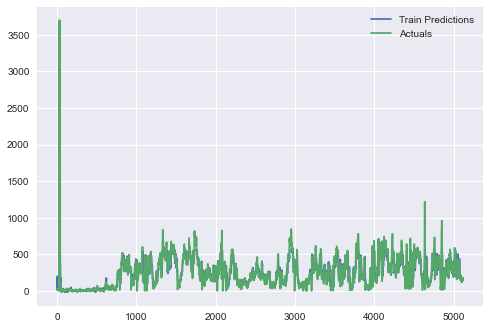

In [33]:
model = load_model('4H_Forecast/4H_ForecastModel_12_SizeWindow/')

X, y = DataHandler(4,12)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,shuffle=False) 
model.evaluate(X_test,y_test)

train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
plt.style.use('seaborn')

pd.concat([train_results['Train Predictions'],train_results['Actuals']],axis=1).plot()
plt.legend(['Train Predictions','Actuals'])

### 5 hours forecast

In [ ]:
%%time

Trainer(5,6,12)

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_29 (Bidirectio (None, 128)               35840     
_________________________________________________________________
dense_58 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 9         
Total params: 36,881
Trainable params: 36,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
161/161 [==============================] - 8s 20ms/step - loss: 111199.6562 - mean_absolute_error: 248.3869 - val_loss: 150212.9844 - val_mean_absolute_error: 333.3946
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 2/100
161/161 [==============================] - 2s 14ms/step - loss: 109787.7422 - mean_absolute_error: 245.5155 - val_loss: 147495.6094 - val_mean_absolute_error: 328.9937
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 3/100
161/161 [==============================] - 2s 13ms/step - loss: 106903.5859 - mean_absolute_error: 239.9241 - val_loss: 142935.4219 - val_mean_absolute_error: 321.9125
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 4/100
161/161 [==============================] - 2s 14ms/step - loss: 103237.8203 - mean_absolute_error: 233.2281 - val_loss: 137346.5469 - val_mean_absolute_error: 313.2447
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 5/100
161/161 [==============================] - 2s 14ms/step - loss: 99336.2578 - mean_absolute_error: 226.5575 - val_loss: 132475.3281 - val_mean_absolute_error: 305.6750
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 6/100
161/161 [==============================] - 2s 14ms/step - loss: 95948.5859 - mean_absolute_error: 220.7375 - val_loss: 127302.9062 - val_mean_absolute_error: 297.2964
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 7/100
161/161 [==============================] - 3s 19ms/step - loss: 92126.6562 - mean_absolute_error: 214.0470 - val_loss: 122327.9922 - val_mean_absolute_error: 289.0912
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 8/100
161/161 [==============================] - 3s 18ms/step - loss: 88983.9609 - mean_absolute_error: 208.7936 - val_loss: 118027.2969 - val_mean_absolute_error: 281.7409
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 9/100
161/161 [==============================] - 3s 22ms/step - loss: 85901.1250 - mean_absolute_error: 203.1059 - val_loss: 113724.1719 - val_mean_absolute_error: 274.3893
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 10/100
161/161 [==============================] - 4s 23ms/step - loss: 82938.5000 - mean_absolute_error: 197.7437 - val_loss: 109473.5547 - val_mean_absolute_error: 266.9233
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 11/100
161/161 [==============================] - 4s 22ms/step - loss: 79791.2266 - mean_absolute_error: 192.0842 - val_loss: 104972.5000 - val_mean_absolute_error: 259.3267
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 12/100
161/161 [==============================] - 2s 13ms/step - loss: 76855.2109 - mean_absolute_error: 187.0312 - val_loss: 100795.4922 - val_mean_absolute_error: 252.1887
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 13/100
161/161 [==============================] - 2s 13ms/step - loss: 74145.9453 - mean_absolute_error: 182.0618 - val_loss: 97064.9062 - val_mean_absolute_error: 245.9256
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 14/100
161/161 [==============================] - 3s 16ms/step - loss: 71620.2734 - mean_absolute_error: 176.9687 - val_loss: 93178.5703 - val_mean_absolute_error: 239.4654
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 15/100
161/161 [==============================] - 2s 14ms/step - loss: 69058.1406 - mean_absolute_error: 172.8113 - val_loss: 89649.2812 - val_mean_absolute_error: 233.5870
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 16/100
161/161 [==============================] - 3s 17ms/step - loss: 66691.8984 - mean_absolute_error: 168.3589 - val_loss: 86199.2578 - val_mean_absolute_error: 227.8732
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 17/100
161/161 [==============================] - 4s 24ms/step - loss: 64447.6055 - mean_absolute_error: 164.0966 - val_loss: 82831.3750 - val_mean_absolute_error: 222.25430s - loss: 64591.9062 - mean_absolute_error: 164.227
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 18/100
161/161 [==============================] - 2s 14ms/step - loss: 62218.9180 - mean_absolute_error: 159.8686 - val_loss: 79431.8984 - val_mean_absolute_error: 216.4078
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 19/100
161/161 [==============================] - 2s 13ms/step - loss: 60045.5234 - mean_absolute_error: 156.0083 - val_loss: 76290.6562 - val_mean_absolute_error: 210.8949
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 20/100
161/161 [==============================] - 2s 14ms/step - loss: 57970.1328 - mean_absolute_error: 151.8302 - val_loss: 73047.3047 - val_mean_absolute_error: 205.0057
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 21/100
161/161 [==============================] - 3s 16ms/step - loss: 55982.9766 - mean_absolute_error: 147.8534 - val_loss: 70090.0859 - val_mean_absolute_error: 199.8448
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 22/100
161/161 [==============================] - 2s 13ms/step - loss: 54146.9805 - mean_absolute_error: 144.2852 - val_loss: 67239.4766 - val_mean_absolute_error: 194.8264
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 23/100
161/161 [==============================] - 2s 13ms/step - loss: 52356.0117 - mean_absolute_error: 140.6411 - val_loss: 64461.1523 - val_mean_absolute_error: 189.9533
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 24/100
161/161 [==============================] - 2s 13ms/step - loss: 50667.6953 - mean_absolute_error: 137.3968 - val_loss: 61920.7305 - val_mean_absolute_error: 185.4776
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 25/100
161/161 [==============================] - 2s 13ms/step - loss: 49107.2305 - mean_absolute_error: 134.1142 - val_loss: 59434.1602 - val_mean_absolute_error: 181.1081
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 26/100
161/161 [==============================] - 2s 14ms/step - loss: 47532.5039 - mean_absolute_error: 130.7924 - val_loss: 57104.7969 - val_mean_absolute_error: 177.3935
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 27/100
161/161 [==============================] - 2s 13ms/step - loss: 46058.0273 - mean_absolute_error: 127.9821 - val_loss: 54630.7539 - val_mean_absolute_error: 173.2195
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 28/100
161/161 [==============================] - 2s 14ms/step - loss: 44671.7344 - mean_absolute_error: 124.8597 - val_loss: 52251.4766 - val_mean_absolute_error: 168.8345
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 29/100
161/161 [==============================] - 3s 18ms/step - loss: 43258.9102 - mean_absolute_error: 122.0920 - val_loss: 50055.8789 - val_mean_absolute_error: 165.3263
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 30/100
161/161 [==============================] - 3s 18ms/step - loss: 42001.7734 - mean_absolute_error: 119.5768 - val_loss: 47987.9023 - val_mean_absolute_error: 161.2937
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 31/100
161/161 [==============================] - 3s 19ms/step - loss: 40786.8984 - mean_absolute_error: 116.7173 - val_loss: 45956.8789 - val_mean_absolute_error: 157.5004
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 32/100
161/161 [==============================] - 3s 21ms/step - loss: 39666.4766 - mean_absolute_error: 114.1960 - val_loss: 44111.6406 - val_mean_absolute_error: 154.1609
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 33/100
161/161 [==============================] - 5s 32ms/step - loss: 38605.0469 - mean_absolute_error: 111.6703 - val_loss: 42256.9375 - val_mean_absolute_error: 150.9382 - loss: - ETA: 0s - loss: 37537.8125 - mean_absolute_error: 
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 34/100
161/161 [==============================] - 3s 21ms/step - loss: 37624.2305 - mean_absolute_error: 109.4945 - val_loss: 40538.6797 - val_mean_absolute_error: 147.5001
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 35/100
161/161 [==============================] - 3s 19ms/step - loss: 36638.9297 - mean_absolute_error: 107.8029 - val_loss: 38869.5352 - val_mean_absolute_error: 144.3352
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 36/100
161/161 [==============================] - 3s 17ms/step - loss: 35745.4453 - mean_absolute_error: 105.4800 - val_loss: 37332.2969 - val_mean_absolute_error: 141.4386
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 37/100
161/161 [==============================] - 3s 20ms/step - loss: 34930.3398 - mean_absolute_error: 103.2966 - val_loss: 35825.9922 - val_mean_absolute_error: 138.5281mean_absolute_error: 102.1 - ETA: 0s - loss: 32324.8184 - mean_absolute_erro
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 38/100
161/161 [==============================] - 3s 18ms/step - loss: 34109.8555 - mean_absolute_error: 102.1168 - val_loss: 34467.4453 - val_mean_absolute_error: 135.2413
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 39/100
161/161 [==============================] - 3s 16ms/step - loss: 33327.4141 - mean_absolute_error: 99.8052 - val_loss: 32996.3906 - val_mean_absolute_error: 132.0874
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 40/100
161/161 [==============================] - 3s 20ms/step - loss: 32600.2852 - mean_absolute_error: 97.7019 - val_loss: 31689.1953 - val_mean_absolute_error: 129.2909
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 41/100
161/161 [==============================] - 3s 18ms/step - loss: 31965.5156 - mean_absolute_error: 96.4450 - val_loss: 30475.9902 - val_mean_absolute_error: 126.3332
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 42/100
161/161 [==============================] - 3s 19ms/step - loss: 31335.6387 - mean_absolute_error: 94.9394 - val_loss: 29302.9551 - val_mean_absolute_error: 123.6140
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 43/100
161/161 [==============================] - 3s 17ms/step - loss: 30727.9336 - mean_absolute_error: 93.7411 - val_loss: 28289.6191 - val_mean_absolute_error: 121.2552
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 44/100
161/161 [==============================] - 2s 14ms/step - loss: 30194.2129 - mean_absolute_error: 92.2463 - val_loss: 27990.5684 - val_mean_absolute_error: 120.2217
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 45/100
161/161 [==============================] - 2s 13ms/step - loss: 29713.0020 - mean_absolute_error: 91.3011 - val_loss: 26532.8555 - val_mean_absolute_error: 117.1792
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 46/100
161/161 [==============================] - 2s 15ms/step - loss: 29243.8828 - mean_absolute_error: 89.8196 - val_loss: 25351.8164 - val_mean_absolute_error: 114.6484
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 47/100
161/161 [==============================] - 2s 13ms/step - loss: 28797.4277 - mean_absolute_error: 89.3226 - val_loss: 24632.1309 - val_mean_absolute_error: 112.7045
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 48/100
161/161 [==============================] - 3s 16ms/step - loss: 28424.3984 - mean_absolute_error: 87.8893 - val_loss: 23908.7910 - val_mean_absolute_error: 110.8548
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 49/100
161/161 [==============================] - 3s 18ms/step - loss: 28061.9414 - mean_absolute_error: 87.4550 - val_loss: 23190.1855 - val_mean_absolute_error: 109.4307
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 50/100
161/161 [==============================] - 4s 24ms/step - loss: 27736.0742 - mean_absolute_error: 86.2644 - val_loss: 22534.2578 - val_mean_absolute_error: 107.4402
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 51/100
161/161 [==============================] - 5s 28ms/step - loss: 27395.2734 - mean_absolute_error: 85.8603 - val_loss: 21987.5176 - val_mean_absolute_error: 106.4239
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 52/100
161/161 [==============================] - 3s 16ms/step - loss: 27088.3809 - mean_absolute_error: 84.9217 - val_loss: 21413.5840 - val_mean_absolute_error: 104.8774
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 53/100
161/161 [==============================] - 3s 17ms/step - loss: 26923.8105 - mean_absolute_error: 84.2507 - val_loss: 20836.8828 - val_mean_absolute_error: 103.4563
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 54/100
161/161 [==============================] - 8s 51ms/step - loss: 26601.8164 - mean_absolute_error: 83.6998 - val_loss: 20276.3750 - val_mean_absolute_error: 101.7604
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 55/100
161/161 [==============================] - 3s 16ms/step - loss: 26349.3496 - mean_absolute_error: 82.4484 - val_loss: 19967.1797 - val_mean_absolute_error: 100.9276
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 56/100
161/161 [==============================] - 2s 14ms/step - loss: 26113.5664 - mean_absolute_error: 82.1542 - val_loss: 19739.8789 - val_mean_absolute_error: 100.4830
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 57/100
161/161 [==============================] - 2s 13ms/step - loss: 25923.8203 - mean_absolute_error: 81.7020 - val_loss: 19082.2051 - val_mean_absolute_error: 98.5216
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 58/100
161/161 [==============================] - 2s 13ms/step - loss: 25724.7148 - mean_absolute_error: 80.9692 - val_loss: 18706.7188 - val_mean_absolute_error: 97.3666
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 59/100
161/161 [==============================] - 2s 15ms/step - loss: 25561.3984 - mean_absolute_error: 80.6653 - val_loss: 18579.4160 - val_mean_absolute_error: 97.0615
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 60/100
161/161 [==============================] - 2s 13ms/step - loss: 25369.7324 - mean_absolute_error: 79.6935 - val_loss: 18010.5859 - val_mean_absolute_error: 95.6661
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 61/100
161/161 [==============================] - 2s 13ms/step - loss: 25243.9863 - mean_absolute_error: 79.5180 - val_loss: 17934.9082 - val_mean_absolute_error: 95.4449
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 62/100
161/161 [==============================] - 2s 14ms/step - loss: 25070.6934 - mean_absolute_error: 79.1279 - val_loss: 17911.3105 - val_mean_absolute_error: 95.1029
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 63/100
161/161 [==============================] - 2s 14ms/step - loss: 24936.3691 - mean_absolute_error: 78.1943 - val_loss: 16814.4727 - val_mean_absolute_error: 92.1931
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 64/100
161/161 [==============================] - 2s 15ms/step - loss: 24784.3535 - mean_absolute_error: 78.1994 - val_loss: 16900.1445 - val_mean_absolute_error: 92.1149
Epoch 65/100
161/161 [==============================] - 2s 14ms/step - loss: 24693.8086 - mean_absolute_error: 77.3397 - val_loss: 16450.0547 - val_mean_absolute_error: 90.7619
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 66/100
161/161 [==============================] - 2s 13ms/step - loss: 24558.7324 - mean_absolute_error: 77.1320 - val_loss: 16236.5654 - val_mean_absolute_error: 90.4689
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 67/100
161/161 [==============================] - 2s 14ms/step - loss: 24440.6699 - mean_absolute_error: 76.5327 - val_loss: 16127.8877 - val_mean_absolute_error: 89.9101
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 68/100
161/161 [==============================] - 3s 16ms/step - loss: 24345.8398 - mean_absolute_error: 76.1722 - val_loss: 15811.4404 - val_mean_absolute_error: 89.2804
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 69/100
161/161 [==============================] - 2s 11ms/step - loss: 24235.1465 - mean_absolute_error: 75.9600 - val_loss: 15694.4961 - val_mean_absolute_error: 88.4553
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 70/100
161/161 [==============================] - 2s 12ms/step - loss: 24155.6797 - mean_absolute_error: 75.6911 - val_loss: 15807.8486 - val_mean_absolute_error: 88.8613
Epoch 71/100
161/161 [==============================] - 2s 11ms/step - loss: 24030.1875 - mean_absolute_error: 75.2143 - val_loss: 15394.8359 - val_mean_absolute_error: 87.8488
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 72/100
161/161 [==============================] - 3s 17ms/step - loss: 23986.9902 - mean_absolute_error: 74.9085 - val_loss: 15726.7891 - val_mean_absolute_error: 88.5170
Epoch 73/100
161/161 [==============================] - 3s 17ms/step - loss: 23863.9902 - mean_absolute_error: 74.1832 - val_loss: 14934.1348 - val_mean_absolute_error: 86.3973
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 74/100
161/161 [==============================] - 2s 13ms/step - loss: 23792.1367 - mean_absolute_error: 74.5015 - val_loss: 15193.2695 - val_mean_absolute_error: 87.0139
Epoch 75/100
161/161 [==============================] - 2s 15ms/step - loss: 23704.3789 - mean_absolute_error: 73.8410 - val_loss: 15128.2822 - val_mean_absolute_error: 86.6299
Epoch 76/100
161/161 [==============================] - 2s 14ms/step - loss: 23645.5215 - mean_absolute_error: 74.0213 - val_loss: 14752.7510 - val_mean_absolute_error: 85.9109
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 77/100
161/161 [==============================] - 2s 15ms/step - loss: 23559.7773 - mean_absolute_error: 73.4102 - val_loss: 14558.9170 - val_mean_absolute_error: 85.4303
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 78/100
161/161 [==============================] - 2s 13ms/step - loss: 23554.4004 - mean_absolute_error: 73.3528 - val_loss: 14459.5039 - val_mean_absolute_error: 84.9277
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 79/100
161/161 [==============================] - 2s 14ms/step - loss: 23421.1387 - mean_absolute_error: 73.0728 - val_loss: 14580.9980 - val_mean_absolute_error: 85.3649
Epoch 80/100
161/161 [==============================] - 2s 14ms/step - loss: 23369.4727 - mean_absolute_error: 72.7338 - val_loss: 14278.4111 - val_mean_absolute_error: 84.2130
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 81/100
161/161 [==============================] - 7s 43ms/step - loss: 23278.9590 - mean_absolute_error: 72.5296 - val_loss: 14166.9844 - val_mean_absolute_error: 83.6347
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 82/100
161/161 [==============================] - 3s 20ms/step - loss: 23211.5879 - mean_absolute_error: 72.0906 - val_loss: 13963.7344 - val_mean_absolute_error: 83.0215
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 83/100
161/161 [==============================] - 2s 13ms/step - loss: 23151.2207 - mean_absolute_error: 71.7291 - val_loss: 14345.1357 - val_mean_absolute_error: 84.4242
Epoch 84/100
161/161 [==============================] - 2s 13ms/step - loss: 23129.2891 - mean_absolute_error: 72.1196 - val_loss: 13758.0840 - val_mean_absolute_error: 82.1293
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 85/100
161/161 [==============================] - 2s 14ms/step - loss: 23064.4570 - mean_absolute_error: 71.8149 - val_loss: 14118.1729 - val_mean_absolute_error: 83.5062
Epoch 86/100
161/161 [==============================] - 2s 14ms/step - loss: 23014.6641 - mean_absolute_error: 71.4282 - val_loss: 13945.1299 - val_mean_absolute_error: 83.0014
Epoch 87/100
161/161 [==============================] - 2s 14ms/step - loss: 22920.9805 - mean_absolute_error: 71.2949 - val_loss: 13754.7871 - val_mean_absolute_error: 82.4079
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 88/100
161/161 [==============================] - 2s 14ms/step - loss: 22910.6484 - mean_absolute_error: 71.1589 - val_loss: 13629.0508 - val_mean_absolute_error: 82.0832
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 89/100
161/161 [==============================] - 2s 12ms/step - loss: 22839.0117 - mean_absolute_error: 71.0423 - val_loss: 13843.6572 - val_mean_absolute_error: 82.5592
Epoch 90/100
161/161 [==============================] - 2s 12ms/step - loss: 22850.9180 - mean_absolute_error: 70.9491 - val_loss: 13651.8643 - val_mean_absolute_error: 82.1956
Epoch 91/100
161/161 [==============================] - 2s 12ms/step - loss: 22741.9902 - mean_absolute_error: 70.6279 - val_loss: 13804.0469 - val_mean_absolute_error: 82.3694
Epoch 92/100
161/161 [==============================] - 2s 15ms/step - loss: 22681.3008 - mean_absolute_error: 70.4296 - val_loss: 14070.3418 - val_mean_absolute_error: 83.1676
Epoch 93/100
161/161 [==============================] - 2s 13ms/step - loss: 22737.1289 - mean_absolute_error: 70.9149 - val_loss: 13769.3506 - val_mean_absolute_error: 82.2357
Epoch 94/100
161/161 [==============================] - 2s 13ms/step - loss: 22575.0938 - mean_absolute_error: 70.0

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 98/100
161/161 [==============================] - 2s 11ms/step - loss: 22398.1973 - mean_absolute_error: 69.5175 - val_loss: 13765.2949 - val_mean_absolute_error: 82.5280
Epoch 99/100
161/161 [==============================] - 2s 12ms/step - loss: 22407.3867 - mean_absolute_error: 69.7497 - val_loss: 13266.0312 - val_mean_absolute_error: 81.2552
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 100/100
161/161 [==============================] - 2s 14ms/step - loss: 22412.1094 - mean_absolute_error: 69.6316 - val_loss: 13543.3770 - val_mean_absolute_error: 81.9187

-----------------------------------------------------------------------------------------------------------

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_30 (Bidirectio (None, 128)               35840     
_________________________________________________________________
dense_60 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 9         
Total params: 36,881
Trainable params: 36,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
161/161 [==============================] - 8s 23ms/step - loss: 111368.2969 - m

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 2/100
161/161 [==============================] - 2s 15ms/step - loss: 110298.8203 - mean_absolute_error: 246.6616 - val_loss: 148949.0312 - val_mean_absolute_error: 331.3574
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 3/100
161/161 [==============================] - 2s 13ms/step - loss: 108411.0391 - mean_absolute_error: 242.9770 - val_loss: 145550.0938 - val_mean_absolute_error: 326.0469
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 4/100
161/161 [==============================] - 3s 19ms/step - loss: 105680.2734 - mean_absolute_error: 237.8481 - val_loss: 141503.8906 - val_mean_absolute_error: 320.0216
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 5/100
161/161 [==============================] - 3s 16ms/step - loss: 102880.0234 - mean_absolute_error: 232.8172 - val_loss: 137946.2188 - val_mean_absolute_error: 314.4553
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 6/100
161/161 [==============================] - 2s 15ms/step - loss: 100292.9453 - mean_absolute_error: 228.3445 - val_loss: 134302.9531 - val_mean_absolute_error: 308.7227bs
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 7/100
161/161 [==============================] - 2s 14ms/step - loss: 97657.2656 - mean_absolute_error: 223.7385 - val_loss: 130660.8984 - val_mean_absolute_error: 302.8851
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 8/100
161/161 [==============================] - 2s 14ms/step - loss: 95040.7500 - mean_absolute_error: 219.1725 - val_loss: 127004.1484 - val_mean_absolute_error: 296.9023
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 9/100
161/161 [==============================] - 3s 17ms/step - loss: 92439.0469 - mean_absolute_error: 214.5915 - val_loss: 123320.4297 - val_mean_absolute_error: 290.7865
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 10/100
161/161 [==============================] - 3s 17ms/step - loss: 89821.6172 - mean_absolute_error: 209.9638 - val_loss: 119612.6875 - val_mean_absolute_error: 284.4741
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 11/100
161/161 [==============================] - 3s 17ms/step - loss: 87116.3828 - mean_absolute_error: 205.1511 - val_loss: 115765.8125 - val_mean_absolute_error: 277.9505
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 12/100
161/161 [==============================] - 3s 18ms/step - loss: 84540.8984 - mean_absolute_error: 200.4822 - val_loss: 112216.3516 - val_mean_absolute_error: 271.8604
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 13/100
161/161 [==============================] - 3s 19ms/step - loss: 82095.2891 - mean_absolute_error: 196.0041 - val_loss: 108665.2812 - val_mean_absolute_error: 265.6906
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 14/100
161/161 [==============================] - 3s 20ms/step - loss: 79481.8984 - mean_absolute_error: 191.4480 - val_loss: 104667.7891 - val_mean_absolute_error: 258.7812
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 15/100
161/161 [==============================] - 3s 20ms/step - loss: 76812.7031 - mean_absolute_error: 186.6001 - val_loss: 101003.3828 - val_mean_absolute_error: 252.5050
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 16/100
161/161 [==============================] - 4s 22ms/step - loss: 74315.7578 - mean_absolute_error: 182.1865 - val_loss: 97358.3438 - val_mean_absolute_error: 246.3935
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 17/100
161/161 [==============================] - 3s 19ms/step - loss: 71875.5547 - mean_absolute_error: 177.8089 - val_loss: 93874.9844 - val_mean_absolute_error: 240.5875
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 18/100
161/161 [==============================] - 3s 17ms/step - loss: 69504.2656 - mean_absolute_error: 173.4026 - val_loss: 90354.3281 - val_mean_absolute_error: 234.7514
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 19/100
161/161 [==============================] - 3s 16ms/step - loss: 67169.3828 - mean_absolute_error: 169.0354 - val_loss: 86946.5625 - val_mean_absolute_error: 229.0762
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 20/100
161/161 [==============================] - 2s 15ms/step - loss: 64902.2422 - mean_absolute_error: 164.9148 - val_loss: 83528.2500 - val_mean_absolute_error: 223.2937
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 21/100
161/161 [==============================] - 2s 14ms/step - loss: 62707.3945 - mean_absolute_error: 160.4335 - val_loss: 80248.3359 - val_mean_absolute_error: 217.6954
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 22/100
161/161 [==============================] - 3s 17ms/step - loss: 60551.9062 - mean_absolute_error: 156.7556 - val_loss: 77060.8516 - val_mean_absolute_error: 212.0948
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 23/100
161/161 [==============================] - 2s 15ms/step - loss: 58539.9414 - mean_absolute_error: 152.6614 - val_loss: 74036.1641 - val_mean_absolute_error: 206.6964
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 24/100
161/161 [==============================] - 3s 16ms/step - loss: 56613.7734 - mean_absolute_error: 148.7108 - val_loss: 71055.5391 - val_mean_absolute_error: 201.2100
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 25/100
161/161 [==============================] - 3s 18ms/step - loss: 54636.5469 - mean_absolute_error: 144.8019 - val_loss: 67869.1172 - val_mean_absolute_error: 195.6128
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 26/100
161/161 [==============================] - 3s 17ms/step - loss: 52732.1758 - mean_absolute_error: 140.7235 - val_loss: 65005.6133 - val_mean_absolute_error: 190.6086
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 27/100
161/161 [==============================] - 3s 16ms/step - loss: 50928.0977 - mean_absolute_error: 137.3837 - val_loss: 62136.0000 - val_mean_absolute_error: 185.6546
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 28/100
161/161 [==============================] - 3s 20ms/step - loss: 49131.6875 - mean_absolute_error: 133.8577 - val_loss: 59309.4414 - val_mean_absolute_error: 180.7531
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 29/100
161/161 [==============================] - 3s 17ms/step - loss: 47489.7656 - mean_absolute_error: 130.4565 - val_loss: 56762.1328 - val_mean_absolute_error: 176.1375
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 30/100
161/161 [==============================] - 3s 17ms/step - loss: 45941.6914 - mean_absolute_error: 127.1225 - val_loss: 54297.7812 - val_mean_absolute_error: 172.2408
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 31/100
161/161 [==============================] - 3s 18ms/step - loss: 44501.4531 - mean_absolute_error: 124.5296 - val_loss: 52034.0586 - val_mean_absolute_error: 168.3281s: 45948.3477 - mean_absolute_err
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 32/100
161/161 [==============================] - 3s 16ms/step - loss: 43188.6992 - mean_absolute_error: 121.3578 - val_loss: 49812.3125 - val_mean_absolute_error: 164.2871
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 33/100
161/161 [==============================] - 3s 20ms/step - loss: 41896.2031 - mean_absolute_error: 119.0688 - val_loss: 47731.8633 - val_mean_absolute_error: 160.6271
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 34/100
161/161 [==============================] - 3s 17ms/step - loss: 40635.8398 - mean_absolute_error: 116.1312 - val_loss: 45585.4453 - val_mean_absolute_error: 156.9036
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 35/100
161/161 [==============================] - 3s 18ms/step - loss: 39480.1758 - mean_absolute_error: 113.8026 - val_loss: 43608.1250 - val_mean_absolute_error: 153.5287
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 36/100
161/161 [==============================] - 3s 18ms/step - loss: 38352.7617 - mean_absolute_error: 111.1271 - val_loss: 41811.9688 - val_mean_absolute_error: 150.1607
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 37/100
161/161 [==============================] - 2s 14ms/step - loss: 37360.1211 - mean_absolute_error: 109.3757 - val_loss: 40052.7695 - val_mean_absolute_error: 146.5005
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 38/100
161/161 [==============================] - 2s 15ms/step - loss: 36398.5742 - mean_absolute_error: 107.0464 - val_loss: 38476.4961 - val_mean_absolute_error: 143.2173
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 39/100
161/161 [==============================] - 2s 15ms/step - loss: 35518.0234 - mean_absolute_error: 104.9152 - val_loss: 36853.0781 - val_mean_absolute_error: 140.0691
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 40/100
161/161 [==============================] - 3s 21ms/step - loss: 34635.2656 - mean_absolute_error: 103.0200 - val_loss: 35331.6055 - val_mean_absolute_error: 136.6938
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 41/100
161/161 [==============================] - 3s 19ms/step - loss: 33888.9570 - mean_absolute_error: 101.3075 - val_loss: 33886.2461 - val_mean_absolute_error: 134.1168
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 42/100
161/161 [==============================] - 3s 17ms/step - loss: 33135.7422 - mean_absolute_error: 99.7869 - val_loss: 32573.3184 - val_mean_absolute_error: 131.1275
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 43/100
161/161 [==============================] - 2s 16ms/step - loss: 32462.0996 - mean_absolute_error: 98.2510 - val_loss: 31281.1836 - val_mean_absolute_error: 128.4795
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 44/100
161/161 [==============================] - 3s 17ms/step - loss: 31830.3770 - mean_absolute_error: 96.8495 - val_loss: 30210.7891 - val_mean_absolute_error: 125.8865
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 45/100
161/161 [==============================] - 3s 18ms/step - loss: 31249.5254 - mean_absolute_error: 95.5447 - val_loss: 29056.7500 - val_mean_absolute_error: 123.3670
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 46/100
161/161 [==============================] - 3s 18ms/step - loss: 30712.3086 - mean_absolute_error: 94.3072 - val_loss: 27982.9941 - val_mean_absolute_error: 120.9269
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 47/100
161/161 [==============================] - 3s 18ms/step - loss: 30162.5625 - mean_absolute_error: 93.1507 - val_loss: 27115.7324 - val_mean_absolute_error: 118.6032
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 48/100
161/161 [==============================] - 3s 16ms/step - loss: 29676.0781 - mean_absolute_error: 91.9852 - val_loss: 26065.6777 - val_mean_absolute_error: 116.3326
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 49/100
161/161 [==============================] - 3s 16ms/step - loss: 29231.1406 - mean_absolute_error: 90.7391 - val_loss: 25183.3203 - val_mean_absolute_error: 114.3092
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 50/100
161/161 [==============================] - 3s 19ms/step - loss: 28808.0293 - mean_absolute_error: 89.9902 - val_loss: 24454.8613 - val_mean_absolute_error: 112.3028
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 51/100
161/161 [==============================] - 3s 16ms/step - loss: 28402.8379 - mean_absolute_error: 88.9816 - val_loss: 23704.8945 - val_mean_absolute_error: 110.4720
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 52/100
161/161 [==============================] - 2s 14ms/step - loss: 28023.1992 - mean_absolute_error: 87.9504 - val_loss: 22968.5078 - val_mean_absolute_error: 108.6622
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 53/100
161/161 [==============================] - 2s 15ms/step - loss: 27617.8652 - mean_absolute_error: 86.8474 - val_loss: 22417.8809 - val_mean_absolute_error: 107.2434
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 54/100
161/161 [==============================] - 2s 13ms/step - loss: 27332.7617 - mean_absolute_error: 85.9657 - val_loss: 21743.4727 - val_mean_absolute_error: 105.4579
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 55/100
161/161 [==============================] - 3s 17ms/step - loss: 26999.8945 - mean_absolute_error: 84.9728 - val_loss: 21471.2754 - val_mean_absolute_error: 104.5036
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 56/100
161/161 [==============================] - 3s 18ms/step - loss: 26731.9785 - mean_absolute_error: 84.3488 - val_loss: 20759.4023 - val_mean_absolute_error: 102.7779
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 57/100
161/161 [==============================] - 3s 18ms/step - loss: 26473.5234 - mean_absolute_error: 83.4238 - val_loss: 20344.2031 - val_mean_absolute_error: 101.7942
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 58/100
161/161 [==============================] - 2s 15ms/step - loss: 26233.5664 - mean_absolute_error: 82.9137 - val_loss: 20014.8008 - val_mean_absolute_error: 100.8661
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 59/100
161/161 [==============================] - 3s 16ms/step - loss: 25996.0547 - mean_absolute_error: 82.0937 - val_loss: 19486.0430 - val_mean_absolute_error: 99.2732
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 60/100
161/161 [==============================] - 3s 18ms/step - loss: 25765.0430 - mean_absolute_error: 81.1794 - val_loss: 19054.7695 - val_mean_absolute_error: 98.3176
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 61/100
161/161 [==============================] - 3s 16ms/step - loss: 25509.9023 - mean_absolute_error: 80.2424 - val_loss: 18687.2598 - val_mean_absolute_error: 97.1530
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 62/100
161/161 [==============================] - 2s 15ms/step - loss: 25295.7070 - mean_absolute_error: 79.6492 - val_loss: 18459.1973 - val_mean_absolute_error: 96.3415
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 63/100
161/161 [==============================] - 2s 15ms/step - loss: 25216.2715 - mean_absolute_error: 79.3635 - val_loss: 18160.0723 - val_mean_absolute_error: 95.2756
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 64/100
161/161 [==============================] - 5s 32ms/step - loss: 24996.0156 - mean_absolute_error: 78.4078 - val_loss: 17666.5977 - val_mean_absolute_error: 94.0403
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 65/100
161/161 [==============================] - 3s 17ms/step - loss: 24803.0098 - mean_absolute_error: 77.9274 - val_loss: 17900.7734 - val_mean_absolute_error: 94.8822
Epoch 66/100
161/161 [==============================] - 3s 16ms/step - loss: 24692.6211 - mean_absolute_error: 77.7005 - val_loss: 17145.6289 - val_mean_absolute_error: 92.9115
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 67/100
161/161 [==============================] - 3s 16ms/step - loss: 24533.7480 - mean_absolute_error: 76.9886 - val_loss: 16807.2422 - val_mean_absolute_error: 92.1272
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 68/100
161/161 [==============================] - 3s 16ms/step - loss: 24390.5293 - mean_absolute_error: 76.7851 - val_loss: 16801.3652 - val_mean_absolute_error: 92.0713
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 69/100
161/161 [==============================] - 3s 18ms/step - loss: 24336.3613 - mean_absolute_error: 76.6153 - val_loss: 16535.4473 - val_mean_absolute_error: 91.1367
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 70/100
161/161 [==============================] - 4s 23ms/step - loss: 24275.3203 - mean_absolute_error: 76.1065 - val_loss: 16355.8438 - val_mean_absolute_error: 90.5104
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 71/100
161/161 [==============================] - 3s 18ms/step - loss: 24094.8457 - mean_absolute_error: 75.6236 - val_loss: 16329.2588 - val_mean_absolute_error: 90.4371
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 72/100
161/161 [==============================] - 3s 18ms/step - loss: 23960.8574 - mean_absolute_error: 75.1856 - val_loss: 15831.9082 - val_mean_absolute_error: 89.2747
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 73/100
161/161 [==============================] - 4s 22ms/step - loss: 23900.4043 - mean_absolute_error: 74.7945 - val_loss: 15960.6338 - val_mean_absolute_error: 89.2780
Epoch 74/100
161/161 [==============================] - 3s 20ms/step - loss: 23771.6719 - mean_absolute_error: 74.2454 - val_loss: 15763.2725 - val_mean_absolute_error: 89.0164
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 75/100
161/161 [==============================] - 3s 17ms/step - loss: 23697.0586 - mean_absolute_error: 74.0918 - val_loss: 15572.0986 - val_mean_absolute_error: 88.1096
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 76/100
161/161 [==============================] - 3s 18ms/step - loss: 23606.2168 - mean_absolute_error: 73.8446 - val_loss: 15699.3330 - val_mean_absolute_error: 88.6440
Epoch 77/100
161/161 [==============================] - 3s 18ms/step - loss: 23551.5371 - mean_absolute_error: 73.7036 - val_loss: 15224.2539 - val_mean_absolute_error: 87.5736
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 78/100
161/161 [==============================] - 4s 22ms/step - loss: 23444.1152 - mean_absolute_error: 73.1828 - val_loss: 15552.3965 - val_mean_absolute_error: 88.2248
Epoch 79/100
161/161 [==============================] - 3s 22ms/step - loss: 23376.8730 - mean_absolute_error: 73.1355 - val_loss: 15234.1348 - val_mean_absolute_error: 86.8616l - ETA: 0s - loss: 21768.3926 - mean
Epoch 80/100
161/161 [==============================] - 3s 20ms/step - loss: 23358.9512 - mean_absolute_error: 72.5457 - val_loss: 15172.5166 - val_mean_absolute_error: 86.8772
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 81/100
161/161 [==============================] - 3s 18ms/step - loss: 23334.1738 - mean_absolute_error: 73.1555 - val_loss: 14823.9160 - val_mean_absolute_error: 85.7538
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 82/100
161/161 [==============================] - 3s 17ms/step - loss: 23180.0391 - mean_absolute_error: 72.3568 - val_loss: 14581.0205 - val_mean_absolute_error: 85.1867
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 83/100
161/161 [==============================] - 2s 13ms/step - loss: 23153.9160 - mean_absolute_error: 72.3638 - val_loss: 14528.6553 - val_mean_absolute_error: 85.1714
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 84/100
161/161 [==============================] - 3s 16ms/step - loss: 23093.1719 - mean_absolute_error: 71.7654 - val_loss: 14336.9170 - val_mean_absolute_error: 84.7752
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 85/100
161/161 [==============================] - 3s 18ms/step - loss: 23006.9883 - mean_absolute_error: 71.6374 - val_loss: 14525.4941 - val_mean_absolute_error: 85.0268
Epoch 86/100
161/161 [==============================] - 2s 14ms/step - loss: 22922.3301 - mean_absolute_error: 71.2993 - val_loss: 14466.8281 - val_mean_absolute_error: 84.9663
Epoch 87/100
161/161 [==============================] - 2s 15ms/step - loss: 22878.7852 - mean_absolute_error: 71.2412 - val_loss: 14361.6826 - val_mean_absolute_error: 84.3955
Epoch 88/100
161/161 [==============================] - 3s 16ms/step - loss: 22876.7305 - mean_absolute_error: 70.6950 - val_loss: 14358.1299 - val_mean_absolute_error: 84.9295
Epoch 89/100
161/161 [==============================] - 3s 16ms/step - loss: 22947.8281 - mean_absolute_error: 72.5192 - val_loss: 14553.1543 - val_mean_absolute_error: 84.8040
Epoch 90/100
161/161 [==============================] - 3s 16ms/step - loss: 22818.6387 - mean_absolute_error: 71.0

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 91/100
161/161 [==============================] - 4s 24ms/step - loss: 22703.7383 - mean_absolute_error: 70.4281 - val_loss: 14494.5674 - val_mean_absolute_error: 84.8722
Epoch 92/100
161/161 [==============================] - 3s 20ms/step - loss: 22616.2480 - mean_absolute_error: 70.4853 - val_loss: 14645.8115 - val_mean_absolute_error: 84.8444
Epoch 93/100
161/161 [==============================] - 3s 19ms/step - loss: 22573.2246 - mean_absolute_error: 70.3060 - val_loss: 14073.4580 - val_mean_absolute_error: 83.6646
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 94/100
161/161 [==============================] - 3s 16ms/step - loss: 22553.5605 - mean_absolute_error: 70.2985 - val_loss: 14035.3955 - val_mean_absolute_error: 83.5759
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 95/100
161/161 [==============================] - 2s 13ms/step - loss: 22490.3008 - mean_absolute_error: 69.9718 - val_loss: 13967.0049 - val_mean_absolute_error: 83.5543
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 96/100
161/161 [==============================] - 3s 16ms/step - loss: 22433.6191 - mean_absolute_error: 69.9562 - val_loss: 14102.9814 - val_mean_absolute_error: 83.6961
Epoch 97/100
161/161 [==============================] - 3s 19ms/step - loss: 22408.7539 - mean_absolute_error: 69.9217 - val_loss: 14001.0713 - val_mean_absolute_error: 83.5022
Epoch 98/100
161/161 [==============================] - 3s 18ms/step - loss: 22414.3965 - mean_absolute_error: 70.1425 - val_loss: 13940.6943 - val_mean_absolute_error: 83.2674
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 99/100
161/161 [==============================] - 2s 15ms/step - loss: 22391.4551 - mean_absolute_error: 69.8448 - val_loss: 14106.6406 - val_mean_absolute_error: 83.4844
Epoch 100/100
161/161 [==============================] - 2s 14ms/step - loss: 22278.5254 - mean_absolute_error: 69.4313 - val_loss: 13680.6963 - val_mean_absolute_error: 82.6720
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_31 (Bidirectio (None, 128)               35840     
_________________________________________________________________
dense_62 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_63 (Dense)             (None, 1)                 9         
Total params: 36,881
Trainable params: 36,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
161/161 [==============================] - 10s 30ms/step - loss: 110677.4844 - mean_absolute_error: 247.4412 - val_loss: 148827.1406 - val_mean_absolute_error: 331.3276
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 2/100
161/161 [==============================] - 3s 18ms/step - loss: 108078.2266 - mean_absolute_error: 242.5753 - val_loss: 144032.6719 - val_mean_absolute_error: 323.9204
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 3/100
161/161 [==============================] - 3s 17ms/step - loss: 103922.4453 - mean_absolute_error: 234.6358 - val_loss: 138083.2656 - val_mean_absolute_error: 314.4180
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 4/100
161/161 [==============================] - 3s 18ms/step - loss: 99350.6094 - mean_absolute_error: 226.1820 - val_loss: 131411.1562 - val_mean_absolute_error: 303.6613
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 5/100
161/161 [==============================] - 3s 18ms/step - loss: 94516.5547 - mean_absolute_error: 217.8491 - val_loss: 125035.4844 - val_mean_absolute_error: 293.4095
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 6/100
161/161 [==============================] - 3s 19ms/step - loss: 90307.6094 - mean_absolute_error: 210.6841 - val_loss: 119463.0547 - val_mean_absolute_error: 283.9796
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 7/100
161/161 [==============================] - 3s 16ms/step - loss: 86291.5938 - mean_absolute_error: 203.6267 - val_loss: 113565.6719 - val_mean_absolute_error: 273.8504
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 8/100
161/161 [==============================] - 3s 22ms/step - loss: 81865.4141 - mean_absolute_error: 196.0250 - val_loss: 107256.1172 - val_mean_absolute_error: 263.0818
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 9/100
161/161 [==============================] - 3s 19ms/step - loss: 77793.0312 - mean_absolute_error: 188.4683 - val_loss: 101460.7578 - val_mean_absolute_error: 253.2663
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 10/100
161/161 [==============================] - 5s 30ms/step - loss: 73877.8047 - mean_absolute_error: 181.7026 - val_loss: 95802.1953 - val_mean_absolute_error: 243.7328
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 11/100
161/161 [==============================] - 3s 21ms/step - loss: 70197.0625 - mean_absolute_error: 174.9111 - val_loss: 90596.5000 - val_mean_absolute_error: 235.1154
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 12/100
161/161 [==============================] - 4s 26ms/step - loss: 66878.7500 - mean_absolute_error: 168.9702 - val_loss: 85833.8047 - val_mean_absolute_error: 227.1446
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 13/100
161/161 [==============================] - 5s 30ms/step - loss: 63759.4922 - mean_absolute_error: 163.1778 - val_loss: 81326.1250 - val_mean_absolute_error: 219.4987A: 1s - loss: 69273.5312 - mean_absolute
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 14/100
161/161 [==============================] - 4s 22ms/step - loss: 60854.1523 - mean_absolute_error: 157.0534 - val_loss: 77091.5000 - val_mean_absolute_error: 212.1115
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 15/100
161/161 [==============================] - 4s 24ms/step - loss: 58091.5898 - mean_absolute_error: 152.1002 - val_loss: 73029.7266 - val_mean_absolute_error: 204.9650
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 16/100
161/161 [==============================] - 4s 25ms/step - loss: 55581.0195 - mean_absolute_error: 147.3484 - val_loss: 69256.6953 - val_mean_absolute_error: 198.1223
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 17/100
161/161 [==============================] - 4s 22ms/step - loss: 53157.2383 - mean_absolute_error: 142.0592 - val_loss: 65599.5703 - val_mean_absolute_error: 191.8544
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 18/100
161/161 [==============================] - 4s 22ms/step - loss: 50845.2930 - mean_absolute_error: 137.3893 - val_loss: 62139.5273 - val_mean_absolute_error: 185.6809
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 19/100
161/161 [==============================] - 3s 21ms/step - loss: 48540.1641 - mean_absolute_error: 132.4241 - val_loss: 58461.5859 - val_mean_absolute_error: 179.5186
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 20/100
161/161 [==============================] - 3s 22ms/step - loss: 46495.3047 - mean_absolute_error: 128.5336 - val_loss: 55307.3750 - val_mean_absolute_error: 174.1656
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 21/100
161/161 [==============================] - 4s 22ms/step - loss: 44716.2578 - mean_absolute_error: 125.0772 - val_loss: 52356.8359 - val_mean_absolute_error: 169.0636
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 22/100
161/161 [==============================] - 3s 21ms/step - loss: 43020.3398 - mean_absolute_error: 121.6037 - val_loss: 49654.4062 - val_mean_absolute_error: 164.4354
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 23/100
161/161 [==============================] - 4s 27ms/step - loss: 41467.5586 - mean_absolute_error: 118.1998 - val_loss: 47226.9727 - val_mean_absolute_error: 160.4509
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 24/100
161/161 [==============================] - 8s 51ms/step - loss: 40092.1445 - mean_absolute_error: 115.2822 - val_loss: 44812.6133 - val_mean_absolute_error: 156.1475 - ETA: 1s - loss: 38166.3945 - mean_abs
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 25/100
161/161 [==============================] - 3s 16ms/step - loss: 38788.1328 - mean_absolute_error: 112.5917 - val_loss: 42203.5156 - val_mean_absolute_error: 151.3887
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 26/100
161/161 [==============================] - 4s 26ms/step - loss: 37511.5547 - mean_absolute_error: 110.1417 - val_loss: 40172.1367 - val_mean_absolute_error: 147.8320
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 27/100
161/161 [==============================] - 4s 23ms/step - loss: 36361.8906 - mean_absolute_error: 107.4766 - val_loss: 37901.8242 - val_mean_absolute_error: 143.5288
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 28/100
161/161 [==============================] - 4s 22ms/step - loss: 35336.7578 - mean_absolute_error: 105.3954 - val_loss: 36195.0312 - val_mean_absolute_error: 139.8665
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 29/100
161/161 [==============================] - 4s 25ms/step - loss: 34445.2578 - mean_absolute_error: 103.0547 - val_loss: 34556.1562 - val_mean_absolute_error: 136.6057
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 30/100
161/161 [==============================] - 4s 23ms/step - loss: 33532.6914 - mean_absolute_error: 101.2889 - val_loss: 32906.0859 - val_mean_absolute_error: 133.0562
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 31/100
161/161 [==============================] - 4s 22ms/step - loss: 32719.8496 - mean_absolute_error: 99.3607 - val_loss: 31386.7480 - val_mean_absolute_error: 129.4584
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 32/100
161/161 [==============================] - 4s 26ms/step - loss: 31979.1602 - mean_absolute_error: 97.2288 - val_loss: 30256.8770 - val_mean_absolute_error: 126.9166
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 33/100
161/161 [==============================] - 4s 24ms/step - loss: 31258.2480 - mean_absolute_error: 95.6454 - val_loss: 28638.5566 - val_mean_absolute_error: 123.4520
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 34/100
161/161 [==============================] - 4s 22ms/step - loss: 30634.0352 - mean_absolute_error: 94.1562 - val_loss: 27551.9844 - val_mean_absolute_error: 120.7546
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 35/100
161/161 [==============================] - 4s 25ms/step - loss: 30054.9863 - mean_absolute_error: 92.5625 - val_loss: 26428.1074 - val_mean_absolute_error: 118.4005
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 36/100
161/161 [==============================] - 4s 23ms/step - loss: 29532.7188 - mean_absolute_error: 91.5399 - val_loss: 25405.4766 - val_mean_absolute_error: 115.5769
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 37/100
161/161 [==============================] - 3s 20ms/step - loss: 29041.2344 - mean_absolute_error: 90.4420 - val_loss: 24533.3750 - val_mean_absolute_error: 113.8005
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 38/100
161/161 [==============================] - 3s 19ms/step - loss: 28591.8438 - mean_absolute_error: 89.2116 - val_loss: 23473.1074 - val_mean_absolute_error: 111.3500
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 39/100
161/161 [==============================] - 3s 17ms/step - loss: 28267.7949 - mean_absolute_error: 87.9287 - val_loss: 22765.4160 - val_mean_absolute_error: 109.6650
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 40/100
161/161 [==============================] - 3s 20ms/step - loss: 27941.9668 - mean_absolute_error: 88.1361 - val_loss: 22331.5215 - val_mean_absolute_error: 108.2268
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 41/100
161/161 [==============================] - 3s 17ms/step - loss: 27604.7363 - mean_absolute_error: 86.6564 - val_loss: 21488.6074 - val_mean_absolute_error: 106.2592
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 42/100
161/161 [==============================] - 3s 18ms/step - loss: 27280.5977 - mean_absolute_error: 85.7080 - val_loss: 21006.4590 - val_mean_absolute_error: 105.1059
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 43/100
161/161 [==============================] - 3s 19ms/step - loss: 27048.6387 - mean_absolute_error: 84.7910 - val_loss: 20498.9941 - val_mean_absolute_error: 103.6602
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 44/100
161/161 [==============================] - 3s 19ms/step - loss: 26787.4375 - mean_absolute_error: 84.2682 - val_loss: 20176.2012 - val_mean_absolute_error: 102.9848
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 45/100
161/161 [==============================] - 3s 20ms/step - loss: 26512.2812 - mean_absolute_error: 83.4138 - val_loss: 19639.4102 - val_mean_absolute_error: 101.2710
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 46/100
161/161 [==============================] - 4s 23ms/step - loss: 26313.6191 - mean_absolute_error: 82.3373 - val_loss: 19265.1895 - val_mean_absolute_error: 100.3692
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 47/100
161/161 [==============================] - 3s 16ms/step - loss: 26071.5039 - mean_absolute_error: 81.5424 - val_loss: 18837.5547 - val_mean_absolute_error: 99.3695
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 48/100
161/161 [==============================] - 2s 15ms/step - loss: 25879.8105 - mean_absolute_error: 81.4011 - val_loss: 18627.7852 - val_mean_absolute_error: 98.5853
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 49/100
161/161 [==============================] - 2s 14ms/step - loss: 25669.0566 - mean_absolute_error: 80.4521 - val_loss: 18143.3672 - val_mean_absolute_error: 97.3641
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 50/100
161/161 [==============================] - 3s 18ms/step - loss: 25548.7344 - mean_absolute_error: 80.0759 - val_loss: 17805.3086 - val_mean_absolute_error: 95.6509
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 51/100
161/161 [==============================] - 3s 17ms/step - loss: 25385.8691 - mean_absolute_error: 79.5736 - val_loss: 17514.5605 - val_mean_absolute_error: 95.1157
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 52/100
161/161 [==============================] - 3s 18ms/step - loss: 25189.7402 - mean_absolute_error: 78.8981 - val_loss: 17128.9648 - val_mean_absolute_error: 93.9915
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 53/100
161/161 [==============================] - 3s 19ms/step - loss: 25051.7070 - mean_absolute_error: 78.0656 - val_loss: 16932.1406 - val_mean_absolute_error: 93.4241
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 54/100
161/161 [==============================] - 3s 16ms/step - loss: 24918.4297 - mean_absolute_error: 77.5526 - val_loss: 16683.2676 - val_mean_absolute_error: 92.6005
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 55/100
161/161 [==============================] - 3s 16ms/step - loss: 24785.5449 - mean_absolute_error: 77.1347 - val_loss: 16558.7168 - val_mean_absolute_error: 92.7778
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 56/100
161/161 [==============================] - 3s 20ms/step - loss: 24715.3984 - mean_absolute_error: 76.9083 - val_loss: 16023.0332 - val_mean_absolute_error: 90.6515
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 57/100
161/161 [==============================] - 3s 18ms/step - loss: 24597.6777 - mean_absolute_error: 76.3878 - val_loss: 16035.9707 - val_mean_absolute_error: 90.4084
Epoch 58/100
161/161 [==============================] - 3s 17ms/step - loss: 24495.4062 - mean_absolute_error: 75.9147 - val_loss: 15768.7617 - val_mean_absolute_error: 90.1964
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 59/100
161/161 [==============================] - 3s 16ms/step - loss: 24404.5117 - mean_absolute_error: 75.7670 - val_loss: 15511.0264 - val_mean_absolute_error: 89.7680
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 60/100
161/161 [==============================] - 3s 19ms/step - loss: 24292.9395 - mean_absolute_error: 75.2702 - val_loss: 15537.0557 - val_mean_absolute_error: 89.2389
Epoch 61/100
161/161 [==============================] - 3s 17ms/step - loss: 24261.5527 - mean_absolute_error: 75.1646 - val_loss: 15386.7109 - val_mean_absolute_error: 88.8043
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 62/100
161/161 [==============================] - 3s 17ms/step - loss: 24249.1562 - mean_absolute_error: 75.2614 - val_loss: 15121.2588 - val_mean_absolute_error: 88.1406
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 63/100
161/161 [==============================] - 3s 18ms/step - loss: 24091.4648 - mean_absolute_error: 74.7529 - val_loss: 15172.0801 - val_mean_absolute_error: 88.1137
Epoch 64/100
161/161 [==============================] - 3s 17ms/step - loss: 24001.1562 - mean_absolute_error: 74.0953 - val_loss: 14818.9482 - val_mean_absolute_error: 87.4399
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 65/100
161/161 [==============================] - 3s 17ms/step - loss: 23933.4375 - mean_absolute_error: 73.7295 - val_loss: 15007.6387 - val_mean_absolute_error: 87.6172
Epoch 66/100
161/161 [==============================] - 3s 16ms/step - loss: 23876.1719 - mean_absolute_error: 73.6480 - val_loss: 14659.4600 - val_mean_absolute_error: 86.9373
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 67/100
161/161 [==============================] - 3s 21ms/step - loss: 23794.5605 - mean_absolute_error: 73.6773 - val_loss: 14688.4092 - val_mean_absolute_error: 86.3904
Epoch 68/100
161/161 [==============================] - 3s 18ms/step - loss: 23753.1699 - mean_absolute_error: 73.0891 - val_loss: 14504.4795 - val_mean_absolute_error: 86.0840
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 69/100
161/161 [==============================] - 4s 27ms/step - loss: 23682.1426 - mean_absolute_error: 72.8975 - val_loss: 14621.1777 - val_mean_absolute_error: 86.3175s
Epoch 70/100
161/161 [==============================] - 4s 28ms/step - loss: 23640.3594 - mean_absolute_error: 72.7875 - val_loss: 14142.0771 - val_mean_absolute_error: 84.8641
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 71/100
161/161 [==============================] - 6s 37ms/step - loss: 23541.9434 - mean_absolute_error: 72.1266 - val_loss: 14359.3369 - val_mean_absolute_error: 85.4647
Epoch 72/100
161/161 [==============================] - 5s 31ms/step - loss: 23491.8164 - mean_absolute_error: 72.6128 - val_loss: 14066.2598 - val_mean_absolute_error: 84.4963
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 73/100
161/161 [==============================] - 6s 35ms/step - loss: 23519.4023 - mean_absolute_error: 72.4626 - val_loss: 14373.0625 - val_mean_absolute_error: 85.1023
Epoch 74/100
161/161 [==============================] - 6s 36ms/step - loss: 23462.9473 - mean_absolute_error: 72.3930 - val_loss: 13963.4004 - val_mean_absolute_error: 84.0437
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 75/100
161/161 [==============================] - 5s 32ms/step - loss: 23429.8574 - mean_absolute_error: 72.0608 - val_loss: 14082.2520 - val_mean_absolute_error: 84.6512
Epoch 76/100
161/161 [==============================] - 5s 29ms/step - loss: 23313.1211 - mean_absolute_error: 71.5475 - val_loss: 14018.5332 - val_mean_absolute_error: 84.3040
Epoch 77/100
161/161 [==============================] - 5s 30ms/step - loss: 23283.7266 - mean_absolute_error: 71.3660 - val_loss: 13862.4756 - val_mean_absolute_error: 83.9882
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 78/100
161/161 [==============================] - 5s 28ms/step - loss: 23269.9180 - mean_absolute_error: 71.4190 - val_loss: 13936.7607 - val_mean_absolute_error: 83.7877
Epoch 79/100
161/161 [==============================] - 6s 35ms/step - loss: 23268.5469 - mean_absolute_error: 71.3917 - val_loss: 13755.0488 - val_mean_absolute_error: 83.6683
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 80/100
161/161 [==============================] - 4s 24ms/step - loss: 23255.6582 - mean_absolute_error: 71.9240 - val_loss: 13632.6553 - val_mean_absolute_error: 83.0682
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 81/100
161/161 [==============================] - 5s 31ms/step - loss: 23160.3984 - mean_absolute_error: 70.8871 - val_loss: 13761.1377 - val_mean_absolute_error: 83.6305
Epoch 82/100
161/161 [==============================] - 5s 30ms/step - loss: 23071.8125 - mean_absolute_error: 70.4787 - val_loss: 13568.5713 - val_mean_absolute_error: 83.0223
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 83/100
161/161 [==============================] - 4s 27ms/step - loss: 23061.4824 - mean_absolute_error: 70.3719 - val_loss: 13525.7070 - val_mean_absolute_error: 82.95143s - loss: 9434.8896 - mean_absolute_error: 67.18 - ETA: 3s - loss: 9
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 84/100
161/161 [==============================] - 5s 31ms/step - loss: 22973.2383 - mean_absolute_error: 70.7422 - val_loss: 13475.5322 - val_mean_absolute_error: 82.9372
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 85/100
161/161 [==============================] - 5s 30ms/step - loss: 22983.5508 - mean_absolute_error: 70.6846 - val_loss: 13290.0000 - val_mean_absolute_error: 81.9192
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 86/100
161/161 [==============================] - 5s 29ms/step - loss: 22933.5918 - mean_absolute_error: 70.3186 - val_loss: 13395.6143 - val_mean_absolute_error: 81.8860
Epoch 87/100
161/161 [==============================] - 5s 29ms/step - loss: 22832.6426 - mean_absolute_error: 70.0555 - val_loss: 13438.9814 - val_mean_absolute_error: 82.4541
Epoch 88/100
161/161 [==============================] - 5s 30ms/step - loss: 22832.9082 - mean_absolute_error: 70.1614 - val_loss: 13289.2666 - val_mean_absolute_error: 81.6806loss: 22689.9551 - mean_absolut - ETA: 0s - loss: 23203.0371 - mean_absolute_error: 7
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 89/100
161/161 [==============================] - 4s 26ms/step - loss: 22759.5840 - mean_absolute_error: 69.7689 - val_loss: 13504.3770 - val_mean_absolute_error: 82.2444loss: 18781.9
Epoch 90/100
161/161 [==============================] - 4s 23ms/step - loss: 22683.8496 - mean_absolute_error: 69.5957 - val_loss: 13122.1562 - val_mean_absolute_error: 80.8855
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 91/100
161/161 [==============================] - 3s 19ms/step - loss: 22732.8164 - mean_absolute_error: 69.8531 - val_loss: 13067.2471 - val_mean_absolute_error: 80.7782
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 92/100
161/161 [==============================] - 4s 23ms/step - loss: 22643.1562 - mean_absolute_error: 69.4462 - val_loss: 13033.8467 - val_mean_absolute_error: 80.6767
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 93/100
161/161 [==============================] - 3s 21ms/step - loss: 22641.8848 - mean_absolute_error: 69.3671 - val_loss: 13087.7197 - val_mean_absolute_error: 80.9405
Epoch 94/100
161/161 [==============================] - 3s 18ms/step - loss: 22645.5762 - mean_absolute_error: 69.6659 - val_loss: 13294.9600 - val_mean_absolute_error: 81.4659
Epoch 95/100
161/161 [==============================] - 3s 17ms/step - loss: 22692.8086 - mean_absolute_error: 69.3055 - val_loss: 13137.8867 - val_mean_absolute_error: 81.0040
Epoch 96/100
161/161 [==============================] - 3s 18ms/step - loss: 22497.2598 - mean_absolute_error: 68.9104 - val_loss: 12907.1084 - val_mean_absolute_error: 80.3792
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 97/100
161/161 [==============================] - 3s 21ms/step - loss: 22487.8477 - mean_absolute_error: 69.0259 - val_loss: 12956.7988 - val_mean_absolute_error: 80.3459
Epoch 98/100
161/161 [==============================] - 4s 25ms/step - loss: 22465.1309 - mean_absolute_error: 68.8210 - val_loss: 13173.8750 - val_mean_absolute_error: 81.4410
Epoch 99/100
161/161 [==============================] - 5s 31ms/step - loss: 22366.8691 - mean_absolute_error: 68.7013 - val_loss: 13336.7783 - val_mean_absolute_error: 81.8925
Epoch 100/100
161/161 [==============================] - 3s 19ms/step - loss: 22392.7734 - mean_absolute_error: 68.6952 - val_loss: 13025.1611 - val_mean_absolute_error: 80.8584

-----------------------------------------------------------------------------------------------------------

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_32 (Bidirect

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 2/100
160/160 [==============================] - 3s 20ms/step - loss: 109050.9141 - mean_absolute_error: 244.2486 - val_loss: 146182.9688 - val_mean_absolute_error: 327.0105
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 3/100
160/160 [==============================] - 4s 24ms/step - loss: 105813.0859 - mean_absolute_error: 238.0609 - val_loss: 141212.7969 - val_mean_absolute_error: 319.1833
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 4/100
160/160 [==============================] - 4s 22ms/step - loss: 101887.4766 - mean_absolute_error: 230.9521 - val_loss: 135801.0312 - val_mean_absolute_error: 310.7914
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 5/100
160/160 [==============================] - 7s 44ms/step - loss: 97686.2031 - mean_absolute_error: 223.7683 - val_loss: 129508.7031 - val_mean_absolute_error: 300.8883
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 6/100
160/160 [==============================] - 5s 34ms/step - loss: 93537.1641 - mean_absolute_error: 216.5338 - val_loss: 123979.3359 - val_mean_absolute_error: 291.7945
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 7/100
160/160 [==============================] - 5s 31ms/step - loss: 89801.5469 - mean_absolute_error: 210.0465 - val_loss: 119177.6016 - val_mean_absolute_error: 283.7252
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 8/100
160/160 [==============================] - 5s 34ms/step - loss: 86640.4531 - mean_absolute_error: 204.6360 - val_loss: 114842.3359 - val_mean_absolute_error: 276.2796
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 9/100
160/160 [==============================] - 6s 36ms/step - loss: 83578.5781 - mean_absolute_error: 198.7404 - val_loss: 110270.1641 - val_mean_absolute_error: 268.356978374.1719 - mean_absol
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 10/100
160/160 [==============================] - 4s 26ms/step - loss: 80330.3359 - mean_absolute_error: 193.6462 - val_loss: 105662.1250 - val_mean_absolute_error: 260.4599
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 11/100
160/160 [==============================] - 11s 67ms/step - loss: 77274.1484 - mean_absolute_error: 187.9993 - val_loss: 101593.5547 - val_mean_absolute_error: 253.4405
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 12/100
160/160 [==============================] - 7s 46ms/step - loss: 74419.5938 - mean_absolute_error: 183.0633 - val_loss: 97412.4297 - val_mean_absolute_error: 246.4612lute_error: - ETA: 1s - loss: 72240.4688 - mean_absolute_erro - ETA: 0s - loss: 73161.4219 - mean_absol
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 13/100
160/160 [==============================] - 9s 59ms/step - loss: 71697.7812 - mean_absolute_error: 177.9309 - val_loss: 93402.5938 - val_mean_absolute_error: 239.8130: 4s - los
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 14/100
160/160 [==============================] - 7s 43ms/step - loss: 68924.7578 - mean_absolute_error: 172.6940 - val_loss: 89377.7500 - val_mean_absolute_error: 233.1818
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 15/100
160/160 [==============================] - 8s 47ms/step - loss: 66212.0234 - mean_absolute_error: 167.8699 - val_loss: 85523.9922 - val_mean_absolute_error: 226.7843
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 16/100
160/160 [==============================] - 4s 28ms/step - loss: 63616.5859 - mean_absolute_error: 162.8870 - val_loss: 81381.6328 - val_mean_absolute_error: 219.7670
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 17/100
160/160 [==============================] - 3s 18ms/step - loss: 60993.6641 - mean_absolute_error: 157.8078 - val_loss: 77592.9141 - val_mean_absolute_error: 213.1749
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 18/100
160/160 [==============================] - 3s 19ms/step - loss: 58617.7500 - mean_absolute_error: 153.4105 - val_loss: 73985.0859 - val_mean_absolute_error: 206.8755
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 19/100
160/160 [==============================] - 3s 20ms/step - loss: 56377.3633 - mean_absolute_error: 148.7658 - val_loss: 70572.9688 - val_mean_absolute_error: 200.935858013.7812 - mean_absolute_error: 
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 20/100
160/160 [==============================] - 4s 23ms/step - loss: 54181.6328 - mean_absolute_error: 144.4187 - val_loss: 67155.5469 - val_mean_absolute_error: 194.8204
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 21/100
160/160 [==============================] - 3s 19ms/step - loss: 52101.9688 - mean_absolute_error: 139.9307 - val_loss: 64031.8086 - val_mean_absolute_error: 189.3180
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 22/100
160/160 [==============================] - 6s 38ms/step - loss: 50101.2734 - mean_absolute_error: 135.8573 - val_loss: 60760.9688 - val_mean_absolute_error: 183.5074: 2s - loss: 59780.3320 - mean_abs - ETA: 1s - loss: 55007.6992 - mean_absol
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 23/100
160/160 [==============================] - 3s 21ms/step - loss: 48105.2539 - mean_absolute_error: 131.6707 - val_loss: 57635.1641 - val_mean_absolute_error: 178.1091
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 24/100
160/160 [==============================] - 4s 22ms/step - loss: 46311.0000 - mean_absolute_error: 128.0725 - val_loss: 54889.8281 - val_mean_absolute_error: 173.4584
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 25/100
160/160 [==============================] - 3s 22ms/step - loss: 44646.5586 - mean_absolute_error: 124.4744 - val_loss: 52219.2812 - val_mean_absolute_error: 168.8359
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 26/100
160/160 [==============================] - 4s 26ms/step - loss: 43003.1484 - mean_absolute_error: 121.3113 - val_loss: 49615.3984 - val_mean_absolute_error: 164.4377
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 27/100
160/160 [==============================] - 3s 22ms/step - loss: 41569.8945 - mean_absolute_error: 118.1430 - val_loss: 47370.7188 - val_mean_absolute_error: 160.3943
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 28/100
160/160 [==============================] - 6s 35ms/step - loss: 40254.1211 - mean_absolute_error: 115.1525 - val_loss: 45160.6367 - val_mean_absolute_error: 156.5116
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 29/100
160/160 [==============================] - 4s 27ms/step - loss: 39028.3984 - mean_absolute_error: 112.5247 - val_loss: 43057.5508 - val_mean_absolute_error: 152.9600te_error: 
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 30/100
160/160 [==============================] - 3s 21ms/step - loss: 37816.5820 - mean_absolute_error: 110.0551 - val_loss: 41138.2812 - val_mean_absolute_error: 149.1133
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 31/100
160/160 [==============================] - 3s 22ms/step - loss: 36755.9922 - mean_absolute_error: 107.4844 - val_loss: 39223.4609 - val_mean_absolute_error: 145.6377
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 32/100
160/160 [==============================] - 4s 23ms/step - loss: 35746.9141 - mean_absolute_error: 105.2783 - val_loss: 37448.7617 - val_mean_absolute_error: 142.2233
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 33/100
160/160 [==============================] - 4s 23ms/step - loss: 34829.5781 - mean_absolute_error: 103.0462 - val_loss: 35826.2578 - val_mean_absolute_error: 138.9596
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 34/100
160/160 [==============================] - 3s 18ms/step - loss: 33938.8398 - mean_absolute_error: 101.1745 - val_loss: 34217.4727 - val_mean_absolute_error: 135.3918
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 35/100
160/160 [==============================] - 9s 55ms/step - loss: 33114.5742 - mean_absolute_error: 99.3144 - val_loss: 32880.0000 - val_mean_absolute_error: 132.4372
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 36/100
160/160 [==============================] - 3s 20ms/step - loss: 32445.7754 - mean_absolute_error: 97.7097 - val_loss: 31564.7246 - val_mean_absolute_error: 129.6485
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 37/100
160/160 [==============================] - 3s 19ms/step - loss: 31732.5312 - mean_absolute_error: 96.1352 - val_loss: 30285.6445 - val_mean_absolute_error: 126.8636
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 38/100
160/160 [==============================] - 3s 19ms/step - loss: 31091.8320 - mean_absolute_error: 94.1788 - val_loss: 29234.0332 - val_mean_absolute_error: 124.4060
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 39/100
160/160 [==============================] - 4s 23ms/step - loss: 30496.5098 - mean_absolute_error: 93.0012 - val_loss: 28182.2520 - val_mean_absolute_error: 121.9203
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 40/100
160/160 [==============================] - 6s 35ms/step - loss: 29934.4688 - mean_absolute_error: 91.5717 - val_loss: 27249.7324 - val_mean_absolute_error: 119.8469
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 41/100
160/160 [==============================] - 3s 16ms/step - loss: 29442.6406 - mean_absolute_error: 90.2154 - val_loss: 26200.0586 - val_mean_absolute_error: 117.1422
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 42/100
160/160 [==============================] - 3s 16ms/step - loss: 28955.0938 - mean_absolute_error: 89.1553 - val_loss: 25279.4824 - val_mean_absolute_error: 114.8226
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 43/100
160/160 [==============================] - 3s 17ms/step - loss: 28476.8906 - mean_absolute_error: 87.6626 - val_loss: 24094.5996 - val_mean_absolute_error: 111.8860
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 44/100
160/160 [==============================] - 3s 16ms/step - loss: 28032.3750 - mean_absolute_error: 86.5536 - val_loss: 23395.5176 - val_mean_absolute_error: 110.1717
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 45/100
160/160 [==============================] - 2s 15ms/step - loss: 27666.3379 - mean_absolute_error: 85.1919 - val_loss: 22815.1191 - val_mean_absolute_error: 108.8914
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 46/100
160/160 [==============================] - 2s 14ms/step - loss: 27344.9844 - mean_absolute_error: 85.0364 - val_loss: 22011.1836 - val_mean_absolute_error: 106.5340
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 47/100
160/160 [==============================] - 3s 18ms/step - loss: 27048.1758 - mean_absolute_error: 83.7162 - val_loss: 21670.3711 - val_mean_absolute_error: 105.9829
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 48/100
160/160 [==============================] - 3s 21ms/step - loss: 26735.8906 - mean_absolute_error: 82.6811 - val_loss: 20803.3926 - val_mean_absolute_error: 103.9652
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 49/100
160/160 [==============================] - 3s 17ms/step - loss: 26441.5840 - mean_absolute_error: 82.3126 - val_loss: 20386.1211 - val_mean_absolute_error: 102.5475
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 50/100
160/160 [==============================] - 4s 24ms/step - loss: 26206.1641 - mean_absolute_error: 81.3970 - val_loss: 20009.8516 - val_mean_absolute_error: 101.7338
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 51/100
160/160 [==============================] - 3s 20ms/step - loss: 26022.4160 - mean_absolute_error: 80.7356 - val_loss: 19579.2012 - val_mean_absolute_error: 101.0697
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 52/100
160/160 [==============================] - 4s 25ms/step - loss: 25783.9961 - mean_absolute_error: 80.4025 - val_loss: 19369.2695 - val_mean_absolute_error: 99.9201
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 53/100
160/160 [==============================] - 3s 16ms/step - loss: 25548.5820 - mean_absolute_error: 79.4691 - val_loss: 18825.5156 - val_mean_absolute_error: 98.0432
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 54/100
160/160 [==============================] - 3s 17ms/step - loss: 25371.7754 - mean_absolute_error: 78.5989 - val_loss: 18345.8730 - val_mean_absolute_error: 96.9203
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 55/100
160/160 [==============================] - 3s 19ms/step - loss: 25145.8105 - mean_absolute_error: 78.2638 - val_loss: 18101.1172 - val_mean_absolute_error: 96.3001
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 56/100
160/160 [==============================] - 3s 19ms/step - loss: 25016.0195 - mean_absolute_error: 77.5606 - val_loss: 17882.9297 - val_mean_absolute_error: 95.7353
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 57/100
160/160 [==============================] - 3s 20ms/step - loss: 24835.6738 - mean_absolute_error: 77.0701 - val_loss: 17719.3105 - val_mean_absolute_error: 95.2154
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 58/100
160/160 [==============================] - 3s 21ms/step - loss: 24688.1934 - mean_absolute_error: 76.6265 - val_loss: 17252.3906 - val_mean_absolute_error: 93.9021
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 59/100
160/160 [==============================] - 3s 19ms/step - loss: 24572.0742 - mean_absolute_error: 76.0507 - val_loss: 17141.5957 - val_mean_absolute_error: 93.0735
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 60/100
160/160 [==============================] - 3s 16ms/step - loss: 24439.1582 - mean_absolute_error: 75.3694 - val_loss: 16643.7773 - val_mean_absolute_error: 91.9459
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 61/100
160/160 [==============================] - 3s 18ms/step - loss: 24260.3691 - mean_absolute_error: 75.0360 - val_loss: 16363.6094 - val_mean_absolute_error: 90.9926
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 62/100
160/160 [==============================] - 3s 16ms/step - loss: 24144.9102 - mean_absolute_error: 74.3381 - val_loss: 15977.6670 - val_mean_absolute_error: 90.4479
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 63/100
160/160 [==============================] - 3s 17ms/step - loss: 24059.7168 - mean_absolute_error: 74.2461 - val_loss: 15994.3730 - val_mean_absolute_error: 90.1463
Epoch 64/100
160/160 [==============================] - 3s 17ms/step - loss: 23934.2578 - mean_absolute_error: 73.7227 - val_loss: 15951.0107 - val_mean_absolute_error: 89.7738
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 65/100
160/160 [==============================] - 2s 15ms/step - loss: 23971.1543 - mean_absolute_error: 74.1348 - val_loss: 15642.1865 - val_mean_absolute_error: 89.2377
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 66/100
160/160 [==============================] - 3s 18ms/step - loss: 23766.5742 - mean_absolute_error: 73.3000 - val_loss: 15774.1504 - val_mean_absolute_error: 89.2070
Epoch 67/100
160/160 [==============================] - 3s 20ms/step - loss: 23737.2363 - mean_absolute_error: 73.0470 - val_loss: 15808.2090 - val_mean_absolute_error: 89.3297
Epoch 68/100
160/160 [==============================] - 5s 31ms/step - loss: 23604.6797 - mean_absolute_error: 72.4855 - val_loss: 15307.4082 - val_mean_absolute_error: 87.8824
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 69/100
160/160 [==============================] - 4s 27ms/step - loss: 23535.5977 - mean_absolute_error: 72.2631 - val_loss: 15040.7920 - val_mean_absolute_error: 87.3316
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 70/100
160/160 [==============================] - 5s 28ms/step - loss: 23425.9941 - mean_absolute_error: 72.0793 - val_loss: 14576.4170 - val_mean_absolute_error: 85.8106
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 71/100
160/160 [==============================] - 3s 18ms/step - loss: 23354.6113 - mean_absolute_error: 71.5743 - val_loss: 14839.0615 - val_mean_absolute_error: 86.3580
Epoch 72/100
160/160 [==============================] - 2s 14ms/step - loss: 23355.1348 - mean_absolute_error: 71.5083 - val_loss: 14986.8643 - val_mean_absolute_error: 87.1656
Epoch 73/100
160/160 [==============================] - 3s 16ms/step - loss: 23265.0117 - mean_absolute_error: 71.4889 - val_loss: 14253.1455 - val_mean_absolute_error: 84.8696
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 74/100
160/160 [==============================] - 3s 16ms/step - loss: 23224.0625 - mean_absolute_error: 71.1026 - val_loss: 14752.4395 - val_mean_absolute_error: 86.1351
Epoch 75/100
160/160 [==============================] - 3s 16ms/step - loss: 23147.4766 - mean_absolute_error: 71.1432 - val_loss: 14465.4590 - val_mean_absolute_error: 85.3175
Epoch 76/100
160/160 [==============================] - 2s 14ms/step - loss: 23056.8809 - mean_absolute_error: 70.6537 - val_loss: 14290.9326 - val_mean_absolute_error: 84.9640
Epoch 77/100
160/160 [==============================] - 2s 13ms/step - loss: 23014.0391 - mean_absolute_error: 70.6400 - val_loss: 14116.9502 - val_mean_absolute_error: 84.0674
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 78/100
160/160 [==============================] - 3s 21ms/step - loss: 22954.3008 - mean_absolute_error: 70.2629 - val_loss: 14377.1982 - val_mean_absolute_error: 85.2126
Epoch 79/100
160/160 [==============================] - 4s 22ms/step - loss: 22912.1191 - mean_absolute_error: 70.2728 - val_loss: 14166.6123 - val_mean_absolute_error: 84.4022
Epoch 80/100
160/160 [==============================] - 3s 18ms/step - loss: 22970.5391 - mean_absolute_error: 70.4505 - val_loss: 13967.3232 - val_mean_absolute_error: 83.9925
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 81/100
160/160 [==============================] - 3s 17ms/step - loss: 22893.6289 - mean_absolute_error: 70.2318 - val_loss: 14062.3691 - val_mean_absolute_error: 84.5144
Epoch 82/100
160/160 [==============================] - 3s 17ms/step - loss: 22810.8945 - mean_absolute_error: 69.8938 - val_loss: 14024.6279 - val_mean_absolute_error: 83.9670
Epoch 83/100
160/160 [==============================] - 3s 18ms/step - loss: 22729.2129 - mean_absolute_error: 69.6063 - val_loss: 13877.4932 - val_mean_absolute_error: 83.3514
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 84/100
160/160 [==============================] - 3s 17ms/step - loss: 22683.6934 - mean_absolute_error: 69.6209 - val_loss: 13715.7705 - val_mean_absolute_error: 83.4031
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 85/100
160/160 [==============================] - 2s 15ms/step - loss: 22656.5000 - mean_absolute_error: 69.3757 - val_loss: 13845.2793 - val_mean_absolute_error: 83.4709
Epoch 86/100
160/160 [==============================] - 2s 15ms/step - loss: 22605.2500 - mean_absolute_error: 69.0975 - val_loss: 13434.3701 - val_mean_absolute_error: 81.8929
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 87/100
160/160 [==============================] - 4s 24ms/step - loss: 22579.9180 - mean_absolute_error: 69.0745 - val_loss: 13682.1035 - val_mean_absolute_error: 82.6092
Epoch 88/100
160/160 [==============================] - 5s 34ms/step - loss: 22599.3086 - mean_absolute_error: 69.4483 - val_loss: 13591.4766 - val_mean_absolute_error: 82.6891
Epoch 89/100
160/160 [==============================] - 6s 39ms/step - loss: 22530.1230 - mean_absolute_error: 69.2379 - val_loss: 13359.4727 - val_mean_absolute_error: 81.7217
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 90/100
160/160 [==============================] - 6s 35ms/step - loss: 22517.4121 - mean_absolute_error: 68.7200 - val_loss: 13628.1094 - val_mean_absolute_error: 82.3038
Epoch 91/100
160/160 [==============================] - 5s 34ms/step - loss: 22474.4395 - mean_absolute_error: 69.1019 - val_loss: 13578.1172 - val_mean_absolute_error: 82.3496
Epoch 92/100
160/160 [==============================] - 5s 29ms/step - loss: 22362.4297 - mean_absolute_error: 68.5569 - val_loss: 13291.5850 - val_mean_absolute_error: 81.5052
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 93/100
160/160 [==============================] - 6s 37ms/step - loss: 22377.7930 - mean_absolute_error: 68.4270 - val_loss: 13315.8955 - val_mean_absolute_error: 81.6264
Epoch 94/100
160/160 [==============================] - 5s 34ms/step - loss: 22314.4727 - mean_absolute_error: 68.3214 - val_loss: 13250.6348 - val_mean_absolute_error: 81.2495
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 95/100
160/160 [==============================] - 4s 24ms/step - loss: 22253.2305 - mean_absolute_error: 68.1574 - val_loss: 13074.8691 - val_mean_absolute_error: 81.0969
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 96/100
160/160 [==============================] - 4s 23ms/step - loss: 22254.8691 - mean_absolute_error: 67.8693 - val_loss: 13493.9473 - val_mean_absolute_error: 82.2137
Epoch 97/100
160/160 [==============================] - 4s 22ms/step - loss: 22209.9609 - mean_absolute_error: 67.9081 - val_loss: 13256.5576 - val_mean_absolute_error: 81.4109
Epoch 98/100
160/160 [==============================] - 4s 22ms/step - loss: 22217.9355 - mean_absolute_error: 67.8540 - val_loss: 13283.5674 - val_mean_absolute_error: 81.2700
Epoch 99/100
160/160 [==============================] - 4s 22ms/step - loss: 22173.6387 - mean_absolute_error: 67.9256 - val_loss: 13395.1123 - val_mean_absolute_error: 81.6122
Epoch 100/100
160/160 [==============================] - 4s 23ms/step - loss: 22122.5195 - mean_absolute_error: 67.6811 - val_loss: 13144.5342 - val_mean_absolute_error: 80.8950

-----------------------------------------------------------------------------------------------------------

Mode

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 2/100
160/160 [==============================] - 5s 32ms/step - loss: 109621.3594 - mean_absolute_error: 245.6584 - val_loss: 147652.8594 - val_mean_absolute_error: 329.4488
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 3/100
160/160 [==============================] - 4s 27ms/step - loss: 107684.0703 - mean_absolute_error: 241.7779 - val_loss: 144451.5938 - val_mean_absolute_error: 324.4960
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 4/100
160/160 [==============================] - 4s 24ms/step - loss: 105078.5859 - mean_absolute_error: 236.8674 - val_loss: 140803.0938 - val_mean_absolute_error: 318.9597
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 5/100
160/160 [==============================] - 4s 23ms/step - loss: 102235.7266 - mean_absolute_error: 231.6999 - val_loss: 136455.0938 - val_mean_absolute_error: 312.0959
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 6/100
160/160 [==============================] - 4s 24ms/step - loss: 98883.7031 - mean_absolute_error: 225.7755 - val_loss: 131839.6406 - val_mean_absolute_error: 304.7902
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 7/100
160/160 [==============================] - 4s 23ms/step - loss: 95713.1406 - mean_absolute_error: 220.1683 - val_loss: 127370.8750 - val_mean_absolute_error: 297.4298
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 8/100
160/160 [==============================] - 4s 28ms/step - loss: 92479.1016 - mean_absolute_error: 214.5331 - val_loss: 122992.2266 - val_mean_absolute_error: 290.2300
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 9/100
160/160 [==============================] - 4s 22ms/step - loss: 89496.2188 - mean_absolute_error: 209.3396 - val_loss: 118839.8828 - val_mean_absolute_error: 283.2010
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 10/100
160/160 [==============================] - 3s 22ms/step - loss: 86588.5469 - mean_absolute_error: 204.3261 - val_loss: 114838.5547 - val_mean_absolute_error: 276.3018
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 11/100
160/160 [==============================] - 3s 19ms/step - loss: 83591.9766 - mean_absolute_error: 198.7565 - val_loss: 110442.4141 - val_mean_absolute_error: 268.6665
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 12/100
160/160 [==============================] - 3s 18ms/step - loss: 80623.4141 - mean_absolute_error: 193.7483 - val_loss: 106346.5625 - val_mean_absolute_error: 261.5685
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 13/100
160/160 [==============================] - 3s 21ms/step - loss: 77670.0312 - mean_absolute_error: 188.4851 - val_loss: 102050.3828 - val_mean_absolute_error: 254.1511
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 14/100
160/160 [==============================] - 3s 18ms/step - loss: 74687.9688 - mean_absolute_error: 182.7166 - val_loss: 97606.9531 - val_mean_absolute_error: 246.7604
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 15/100
160/160 [==============================] - 3s 18ms/step - loss: 71739.0391 - mean_absolute_error: 177.5303 - val_loss: 93410.4375 - val_mean_absolute_error: 239.7892
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 16/100
160/160 [==============================] - 3s 18ms/step - loss: 68858.1953 - mean_absolute_error: 172.2185 - val_loss: 89305.2891 - val_mean_absolute_error: 232.9434
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 17/100
160/160 [==============================] - 3s 19ms/step - loss: 66137.7500 - mean_absolute_error: 166.4045 - val_loss: 84938.7578 - val_mean_absolute_error: 225.8074
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 18/100
160/160 [==============================] - 3s 17ms/step - loss: 63416.2227 - mean_absolute_error: 162.1738 - val_loss: 81114.6562 - val_mean_absolute_error: 219.3605
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 19/100
160/160 [==============================] - 3s 16ms/step - loss: 60941.7266 - mean_absolute_error: 156.6917 - val_loss: 77461.2188 - val_mean_absolute_error: 213.0213
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 20/100
160/160 [==============================] - 3s 22ms/step - loss: 58551.8164 - mean_absolute_error: 152.6336 - val_loss: 73855.4844 - val_mean_absolute_error: 206.7416
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 21/100
160/160 [==============================] - 3s 21ms/step - loss: 56227.5078 - mean_absolute_error: 147.6337 - val_loss: 70338.4766 - val_mean_absolute_error: 200.6607
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 22/100
160/160 [==============================] - 4s 28ms/step - loss: 53909.6484 - mean_absolute_error: 143.7539 - val_loss: 66708.9609 - val_mean_absolute_error: 194.1746
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 23/100
160/160 [==============================] - 3s 18ms/step - loss: 51798.0391 - mean_absolute_error: 139.1571 - val_loss: 63561.3672 - val_mean_absolute_error: 188.6059
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 24/100
160/160 [==============================] - 3s 18ms/step - loss: 49834.3125 - mean_absolute_error: 135.1249 - val_loss: 60518.0820 - val_mean_absolute_error: 183.4170
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 25/100
160/160 [==============================] - 3s 18ms/step - loss: 47923.7930 - mean_absolute_error: 130.9821 - val_loss: 57533.3789 - val_mean_absolute_error: 178.2561
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 26/100
160/160 [==============================] - 3s 18ms/step - loss: 46183.9062 - mean_absolute_error: 127.3829 - val_loss: 54735.9531 - val_mean_absolute_error: 173.4757
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 27/100
160/160 [==============================] - 3s 17ms/step - loss: 44569.3047 - mean_absolute_error: 124.6485 - val_loss: 52195.4180 - val_mean_absolute_error: 169.3510
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 28/100
160/160 [==============================] - 3s 16ms/step - loss: 43088.5234 - mean_absolute_error: 121.1297 - val_loss: 49766.1289 - val_mean_absolute_error: 165.3178
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 29/100
160/160 [==============================] - 3s 21ms/step - loss: 41682.2695 - mean_absolute_error: 118.8004 - val_loss: 47471.4336 - val_mean_absolute_error: 161.4663
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 30/100
160/160 [==============================] - 3s 18ms/step - loss: 40394.3789 - mean_absolute_error: 116.2149 - val_loss: 45398.9922 - val_mean_absolute_error: 158.0299
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 31/100
160/160 [==============================] - 3s 20ms/step - loss: 39242.3984 - mean_absolute_error: 113.3466 - val_loss: 43351.4414 - val_mean_absolute_error: 154.4019
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 32/100
160/160 [==============================] - 4s 23ms/step - loss: 38111.2539 - mean_absolute_error: 110.9487 - val_loss: 41407.4648 - val_mean_absolute_error: 150.6520
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 33/100
160/160 [==============================] - 4s 26ms/step - loss: 37044.2812 - mean_absolute_error: 108.6507 - val_loss: 39638.6953 - val_mean_absolute_error: 147.1311
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 34/100
160/160 [==============================] - 3s 19ms/step - loss: 36070.0156 - mean_absolute_error: 106.3494 - val_loss: 37940.4844 - val_mean_absolute_error: 143.5224
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 35/100
160/160 [==============================] - 3s 19ms/step - loss: 35182.8359 - mean_absolute_error: 104.0373 - val_loss: 36234.2539 - val_mean_absolute_error: 140.4476
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 36/100
160/160 [==============================] - 3s 19ms/step - loss: 34357.2500 - mean_absolute_error: 102.8877 - val_loss: 34807.9336 - val_mean_absolute_error: 137.5514
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 37/100
160/160 [==============================] - 3s 17ms/step - loss: 33620.3516 - mean_absolute_error: 100.8647 - val_loss: 33399.4805 - val_mean_absolute_error: 134.5056
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 38/100
160/160 [==============================] - 3s 19ms/step - loss: 32887.9453 - mean_absolute_error: 99.2910 - val_loss: 31923.6445 - val_mean_absolute_error: 131.4881
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 39/100
160/160 [==============================] - 3s 20ms/step - loss: 32204.3906 - mean_absolute_error: 97.6874 - val_loss: 30703.4336 - val_mean_absolute_error: 128.5529
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 40/100
160/160 [==============================] - 3s 20ms/step - loss: 31563.5840 - mean_absolute_error: 96.0657 - val_loss: 29577.5684 - val_mean_absolute_error: 125.8997
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 41/100
160/160 [==============================] - 3s 20ms/step - loss: 30987.0391 - mean_absolute_error: 94.9039 - val_loss: 28429.9238 - val_mean_absolute_error: 123.2704
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 42/100
160/160 [==============================] - 3s 20ms/step - loss: 30457.3262 - mean_absolute_error: 93.8598 - val_loss: 27537.1406 - val_mean_absolute_error: 121.2270
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 43/100
160/160 [==============================] - 4s 23ms/step - loss: 29974.3516 - mean_absolute_error: 92.5112 - val_loss: 27005.5352 - val_mean_absolute_error: 119.4283
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 44/100
160/160 [==============================] - 3s 19ms/step - loss: 29500.0547 - mean_absolute_error: 91.4368 - val_loss: 25618.8945 - val_mean_absolute_error: 116.4571
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 45/100
160/160 [==============================] - 3s 20ms/step - loss: 29084.2246 - mean_absolute_error: 90.3271 - val_loss: 25095.7148 - val_mean_absolute_error: 115.6990
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 46/100
160/160 [==============================] - 3s 20ms/step - loss: 28644.3633 - mean_absolute_error: 89.2353 - val_loss: 24728.0723 - val_mean_absolute_error: 114.2630
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 47/100
160/160 [==============================] - 3s 22ms/step - loss: 28286.7285 - mean_absolute_error: 88.5042 - val_loss: 24350.0996 - val_mean_absolute_error: 113.3248
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 48/100
160/160 [==============================] - 3s 20ms/step - loss: 28014.4492 - mean_absolute_error: 87.7388 - val_loss: 24272.8633 - val_mean_absolute_error: 113.0452
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 49/100
160/160 [==============================] - 3s 19ms/step - loss: 27677.7207 - mean_absolute_error: 86.5780 - val_loss: 23303.9648 - val_mean_absolute_error: 110.9589
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 50/100
160/160 [==============================] - 4s 22ms/step - loss: 27360.5938 - mean_absolute_error: 85.8454 - val_loss: 22950.9883 - val_mean_absolute_error: 110.1218
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 51/100
160/160 [==============================] - 3s 20ms/step - loss: 27049.1230 - mean_absolute_error: 84.8544 - val_loss: 21876.5039 - val_mean_absolute_error: 107.2928
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 52/100
160/160 [==============================] - 3s 17ms/step - loss: 26792.4023 - mean_absolute_error: 84.0289 - val_loss: 22612.4219 - val_mean_absolute_error: 109.1737
Epoch 53/100
160/160 [==============================] - 3s 16ms/step - loss: 26551.0508 - mean_absolute_error: 83.3999 - val_loss: 21701.2207 - val_mean_absolute_error: 106.8164
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 54/100
160/160 [==============================] - 3s 20ms/step - loss: 26300.4062 - mean_absolute_error: 82.4588 - val_loss: 21155.2480 - val_mean_absolute_error: 105.1332
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 55/100
160/160 [==============================] - 4s 26ms/step - loss: 26109.2285 - mean_absolute_error: 81.9020 - val_loss: 20529.2070 - val_mean_absolute_error: 103.7737
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 56/100
160/160 [==============================] - 3s 20ms/step - loss: 25853.4160 - mean_absolute_error: 81.2671 - val_loss: 19156.1855 - val_mean_absolute_error: 100.7001
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 57/100
160/160 [==============================] - 3s 19ms/step - loss: 25718.5703 - mean_absolute_error: 80.4278 - val_loss: 21089.5000 - val_mean_absolute_error: 105.5316
Epoch 58/100
160/160 [==============================] - 3s 19ms/step - loss: 25467.2090 - mean_absolute_error: 80.0420 - val_loss: 20261.7031 - val_mean_absolute_error: 103.3891
Epoch 59/100
160/160 [==============================] - 3s 19ms/step - loss: 25293.7344 - mean_absolute_error: 78.9727 - val_loss: 20357.6191 - val_mean_absolute_error: 103.2387
Epoch 60/100
160/160 [==============================] - 3s 19ms/step - loss: 25168.3125 - mean_absolute_error: 78.9897 - val_loss: 18861.3320 - val_mean_absolute_error: 99.2673
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 61/100
160/160 [==============================] - 3s 21ms/step - loss: 25013.3945 - mean_absolute_error: 78.1694 - val_loss: 19635.7324 - val_mean_absolute_error: 101.6182
Epoch 62/100
160/160 [==============================] - 3s 22ms/step - loss: 24880.3516 - mean_absolute_error: 77.6186 - val_loss: 18160.5840 - val_mean_absolute_error: 97.3845
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 63/100
160/160 [==============================] - 3s 21ms/step - loss: 24790.8770 - mean_absolute_error: 77.3505 - val_loss: 19626.5020 - val_mean_absolute_error: 101.3144
Epoch 64/100
160/160 [==============================] - 3s 22ms/step - loss: 24604.4121 - mean_absolute_error: 76.6983 - val_loss: 18792.9316 - val_mean_absolute_error: 99.5595
Epoch 65/100
160/160 [==============================] - 3s 21ms/step - loss: 24469.2793 - mean_absolute_error: 76.1355 - val_loss: 18416.5371 - val_mean_absolute_error: 98.3275
Epoch 66/100
160/160 [==============================] - 4s 23ms/step - loss: 24423.2305 - mean_absolute_error: 76.3087 - val_loss: 17967.0195 - val_mean_absolute_error: 97.4888
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 67/100
160/160 [==============================] - 3s 21ms/step - loss: 24249.6387 - mean_absolute_error: 75.2314 - val_loss: 18475.8809 - val_mean_absolute_error: 98.5033
Epoch 68/100
160/160 [==============================] - 3s 22ms/step - loss: 24224.7207 - mean_absolute_error: 75.4430 - val_loss: 18756.9746 - val_mean_absolute_error: 99.1178
Epoch 69/100
160/160 [==============================] - 3s 21ms/step - loss: 24079.6465 - mean_absolute_error: 74.7269 - val_loss: 17641.3164 - val_mean_absolute_error: 96.1654
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 70/100
160/160 [==============================] - 3s 20ms/step - loss: 23994.8809 - mean_absolute_error: 74.5314 - val_loss: 17570.6426 - val_mean_absolute_error: 96.4963
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 71/100
160/160 [==============================] - 3s 21ms/step - loss: 23899.6230 - mean_absolute_error: 74.4118 - val_loss: 17311.6270 - val_mean_absolute_error: 94.9643
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 72/100
160/160 [==============================] - 3s 21ms/step - loss: 23840.9980 - mean_absolute_error: 73.9433 - val_loss: 17873.6465 - val_mean_absolute_error: 96.4603
Epoch 73/100
160/160 [==============================] - 4s 28ms/step - loss: 23780.9766 - mean_absolute_error: 73.5784 - val_loss: 16877.4121 - val_mean_absolute_error: 93.7974
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 74/100
160/160 [==============================] - 4s 23ms/step - loss: 23639.7422 - mean_absolute_error: 73.3475 - val_loss: 17490.0352 - val_mean_absolute_error: 95.3338: 73.
Epoch 75/100
160/160 [==============================] - 3s 21ms/step - loss: 23605.5605 - mean_absolute_error: 73.3544 - val_loss: 17374.9590 - val_mean_absolute_error: 95.8736
Epoch 76/100
160/160 [==============================] - 3s 21ms/step - loss: 23543.8477 - mean_absolute_error: 72.6298 - val_loss: 19241.2207 - val_mean_absolute_error: 99.8297
Epoch 77/100
160/160 [==============================] - 3s 21ms/step - loss: 23574.4004 - mean_absolute_error: 73.3395 - val_loss: 17319.9551 - val_mean_absolute_error: 95.1080
Epoch 78/100
160/160 [==============================] - 3s 21ms/step - loss: 23431.5977 - mean_absolute_error: 72.4387 - val_loss: 17917.1191 - val_mean_absolute_error: 96.2969
Epoch 79/100
160/160 [==============================] - 3s 21ms/step - loss: 23460.1250 - mean_absolute_error:

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 83/100
160/160 [==============================] - 3s 21ms/step - loss: 23180.6973 - mean_absolute_error: 71.8410 - val_loss: 18015.7168 - val_mean_absolute_error: 96.2367
Epoch 84/100
160/160 [==============================] - 4s 23ms/step - loss: 23073.4297 - mean_absolute_error: 71.1862 - val_loss: 16850.2363 - val_mean_absolute_error: 93.5093
Epoch 85/100
160/160 [==============================] - 4s 23ms/step - loss: 23027.5820 - mean_absolute_error: 71.0126 - val_loss: 17084.4902 - val_mean_absolute_error: 93.8409
Epoch 86/100
160/160 [==============================] - 4s 22ms/step - loss: 22975.7422 - mean_absolute_error: 70.8770 - val_loss: 17767.6816 - val_mean_absolute_error: 95.7457
Epoch 87/100
160/160 [==============================] - 3s 21ms/step - loss: 22914.4512 - mean_absolute_error: 70.6947 - val_loss: 17795.6445 - val_mean_absolute_error: 94.7220
Epoch 88/100
160/160 [==============================] - 3s 20ms/step - loss: 22905.4512 - mean_absolute_error: 71.0

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow\assets


Epoch 92/100
160/160 [==============================] - 5s 34ms/step - loss: 22697.8027 - mean_absolute_error: 69.9072 - val_loss: 17055.4102 - val_mean_absolute_error: 93.7065
Epoch 93/100
160/160 [==============================] - 4s 26ms/step - loss: 22702.4980 - mean_absolute_error: 69.8635 - val_loss: 16943.7109 - val_mean_absolute_error: 93.0232
Epoch 94/100
160/160 [==============================] - 4s 25ms/step - loss: 22607.6035 - mean_absolute_error: 69.9083 - val_loss: 17285.9805 - val_mean_absolute_error: 93.7031
Epoch 95/100
160/160 [==============================] - 4s 23ms/step - loss: 22577.0996 - mean_absolute_error: 69.7284 - val_loss: 17242.6016 - val_mean_absolute_error: 93.3145
Epoch 96/100
160/160 [==============================] - 5s 32ms/step - loss: 22565.5996 - mean_absolute_error: 69.7998 - val_loss: 16966.1387 - val_mean_absolute_error: 92.4164
Epoch 97/100
160/160 [==============================] - 7s 45ms/step - loss: 22576.3691 - mean_absolute_error: 69.8

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 2/100
160/160 [==============================] - 7s 41ms/step - loss: 110252.2578 - mean_absolute_error: 246.6240 - val_loss: 148509.3281 - val_mean_absolute_error: 330.7230
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 3/100
160/160 [==============================] - 4s 25ms/step - loss: 108422.3672 - mean_absolute_error: 243.0954 - val_loss: 145701.3125 - val_mean_absolute_error: 326.4784
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 4/100
160/160 [==============================] - 4s 28ms/step - loss: 106170.5391 - mean_absolute_error: 238.8288 - val_loss: 142210.5781 - val_mean_absolute_error: 320.9996
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 5/100
160/160 [==============================] - 5s 29ms/step - loss: 103279.8125 - mean_absolute_error: 233.5861 - val_loss: 138206.3281 - val_mean_absolute_error: 314.9005
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 6/100
160/160 [==============================] - 4s 27ms/step - loss: 100504.9297 - mean_absolute_error: 228.7100 - val_loss: 134435.7188 - val_mean_absolute_error: 308.8642
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 7/100
160/160 [==============================] - 5s 30ms/step - loss: 97729.9766 - mean_absolute_error: 223.8493 - val_loss: 130494.0391 - val_mean_absolute_error: 302.5880
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 8/100
160/160 [==============================] - 4s 26ms/step - loss: 94926.2031 - mean_absolute_error: 218.9799 - val_loss: 126578.2109 - val_mean_absolute_error: 296.2323
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 9/100
160/160 [==============================] - 5s 30ms/step - loss: 92190.7031 - mean_absolute_error: 214.2283 - val_loss: 122812.7812 - val_mean_absolute_error: 289.9560
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 10/100
160/160 [==============================] - 4s 26ms/step - loss: 89554.2266 - mean_absolute_error: 209.6503 - val_loss: 119184.6406 - val_mean_absolute_error: 283.7846
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 11/100
160/160 [==============================] - 5s 29ms/step - loss: 87010.0703 - mean_absolute_error: 205.0616 - val_loss: 115537.7734 - val_mean_absolute_error: 277.5170
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 12/100
160/160 [==============================] - 5s 34ms/step - loss: 84356.2500 - mean_absolute_error: 200.2063 - val_loss: 111656.9531 - val_mean_absolute_error: 270.8307
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 13/100
160/160 [==============================] - 5s 33ms/step - loss: 81643.5078 - mean_absolute_error: 195.7618 - val_loss: 107761.8359 - val_mean_absolute_error: 264.0650
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 14/100
160/160 [==============================] - 5s 30ms/step - loss: 78943.6016 - mean_absolute_error: 190.8712 - val_loss: 103773.1719 - val_mean_absolute_error: 257.2190
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 15/100
160/160 [==============================] - 4s 28ms/step - loss: 76208.7656 - mean_absolute_error: 186.0768 - val_loss: 99867.1484 - val_mean_absolute_error: 250.5745
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 16/100
160/160 [==============================] - 5s 29ms/step - loss: 73633.9062 - mean_absolute_error: 181.2053 - val_loss: 96195.7031 - val_mean_absolute_error: 244.4686
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 17/100
160/160 [==============================] - 4s 27ms/step - loss: 71199.0859 - mean_absolute_error: 177.1559 - val_loss: 92716.3125 - val_mean_absolute_error: 238.7348 - loss: 66870.1719 - mean_absolu
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 18/100
160/160 [==============================] - 5s 31ms/step - loss: 68882.9922 - mean_absolute_error: 172.2955 - val_loss: 89307.1094 - val_mean_absolute_error: 233.1172
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 19/100
160/160 [==============================] - 5s 33ms/step - loss: 66609.0547 - mean_absolute_error: 168.7817 - val_loss: 85979.5859 - val_mean_absolute_error: 227.6045
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 20/100
160/160 [==============================] - 5s 29ms/step - loss: 64444.5742 - mean_absolute_error: 164.0375 - val_loss: 82729.1562 - val_mean_absolute_error: 222.1328
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 21/100
160/160 [==============================] - 6s 35ms/step - loss: 62272.9570 - mean_absolute_error: 160.0740 - val_loss: 79503.3125 - val_mean_absolute_error: 216.5626
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 22/100
160/160 [==============================] - 6s 38ms/step - loss: 60153.1797 - mean_absolute_error: 155.7112 - val_loss: 76334.7656 - val_mean_absolute_error: 210.9886
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 23/100
160/160 [==============================] - 6s 38ms/step - loss: 58126.4180 - mean_absolute_error: 151.7760 - val_loss: 73291.2109 - val_mean_absolute_error: 205.6302
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 24/100
160/160 [==============================] - 5s 30ms/step - loss: 56187.8906 - mean_absolute_error: 148.0421 - val_loss: 70362.2344 - val_mean_absolute_error: 200.43380s - loss: 56721.8125 - mean_absolute_
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 25/100
160/160 [==============================] - 5s 31ms/step - loss: 54322.8750 - mean_absolute_error: 144.1540 - val_loss: 67487.1719 - val_mean_absolute_error: 195.5821
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 26/100
160/160 [==============================] - 5s 31ms/step - loss: 52492.2734 - mean_absolute_error: 140.6619 - val_loss: 64768.5000 - val_mean_absolute_error: 190.8641
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 27/100
160/160 [==============================] - 5s 30ms/step - loss: 50770.3008 - mean_absolute_error: 137.0185 - val_loss: 62034.8164 - val_mean_absolute_error: 186.1029
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 28/100
160/160 [==============================] - 5s 33ms/step - loss: 49110.3789 - mean_absolute_error: 133.7348 - val_loss: 59495.2695 - val_mean_absolute_error: 181.9596
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 29/100
160/160 [==============================] - 5s 32ms/step - loss: 47534.7422 - mean_absolute_error: 130.5018 - val_loss: 57039.0156 - val_mean_absolute_error: 177.6281
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 30/100
160/160 [==============================] - 5s 32ms/step - loss: 46143.5312 - mean_absolute_error: 127.1977 - val_loss: 54623.6875 - val_mean_absolute_error: 173.4500
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 31/100
160/160 [==============================] - 5s 32ms/step - loss: 44702.1914 - mean_absolute_error: 124.6713 - val_loss: 52417.4023 - val_mean_absolute_error: 169.7598
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 32/100
160/160 [==============================] - 5s 31ms/step - loss: 43370.6797 - mean_absolute_error: 122.2415 - val_loss: 50283.3320 - val_mean_absolute_error: 166.0393
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 33/100
160/160 [==============================] - 5s 31ms/step - loss: 42115.5977 - mean_absolute_error: 118.8619 - val_loss: 48133.5430 - val_mean_absolute_error: 162.3170absolute_e
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 34/100
160/160 [==============================] - 5s 29ms/step - loss: 40926.0039 - mean_absolute_error: 116.3163 - val_loss: 46223.4766 - val_mean_absolute_error: 159.0781
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 35/100
160/160 [==============================] - 7s 41ms/step - loss: 39767.1328 - mean_absolute_error: 113.6970 - val_loss: 44380.8047 - val_mean_absolute_error: 155.6818
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 36/100
160/160 [==============================] - 5s 30ms/step - loss: 38737.7617 - mean_absolute_error: 111.5805 - val_loss: 42585.9023 - val_mean_absolute_error: 152.7376
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 37/100
160/160 [==============================] - 4s 24ms/step - loss: 37794.6680 - mean_absolute_error: 109.4316 - val_loss: 40919.8047 - val_mean_absolute_error: 149.7314
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 38/100
160/160 [==============================] - 5s 29ms/step - loss: 36890.1094 - mean_absolute_error: 107.7326 - val_loss: 39378.2812 - val_mean_absolute_error: 146.6693
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 39/100
160/160 [==============================] - 5s 32ms/step - loss: 36048.7227 - mean_absolute_error: 106.3056 - val_loss: 37887.2539 - val_mean_absolute_error: 143.6472 37180.2109 - mea
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 40/100
160/160 [==============================] - 3s 22ms/step - loss: 35265.4570 - mean_absolute_error: 104.0030 - val_loss: 36391.4492 - val_mean_absolute_error: 140.6978
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 41/100
160/160 [==============================] - 3s 21ms/step - loss: 34496.6992 - mean_absolute_error: 102.9289 - val_loss: 35064.7891 - val_mean_absolute_error: 137.9546
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 42/100
160/160 [==============================] - 5s 30ms/step - loss: 33785.6680 - mean_absolute_error: 100.9022 - val_loss: 33772.3242 - val_mean_absolute_error: 135.7640
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 43/100
160/160 [==============================] - 4s 27ms/step - loss: 33152.9648 - mean_absolute_error: 99.7682 - val_loss: 32647.4883 - val_mean_absolute_error: 133.4372:
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 44/100
160/160 [==============================] - 5s 31ms/step - loss: 32579.0957 - mean_absolute_error: 98.8633 - val_loss: 31517.7324 - val_mean_absolute_error: 131.1973
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 45/100
160/160 [==============================] - 4s 25ms/step - loss: 32031.8906 - mean_absolute_error: 97.5064 - val_loss: 30446.6152 - val_mean_absolute_error: 128.7811
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 46/100
160/160 [==============================] - 5s 32ms/step - loss: 31518.5371 - mean_absolute_error: 96.7997 - val_loss: 29567.9785 - val_mean_absolute_error: 126.2980
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 47/100
160/160 [==============================] - 5s 29ms/step - loss: 31036.0273 - mean_absolute_error: 95.0292 - val_loss: 28627.1797 - val_mean_absolute_error: 124.3622
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 48/100
160/160 [==============================] - 4s 24ms/step - loss: 30546.6348 - mean_absolute_error: 94.0849 - val_loss: 27760.1738 - val_mean_absolute_error: 121.9325
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 49/100
160/160 [==============================] - 4s 24ms/step - loss: 30065.9512 - mean_absolute_error: 92.8242 - val_loss: 26846.5957 - val_mean_absolute_error: 120.0298
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 50/100
160/160 [==============================] - 3s 20ms/step - loss: 29653.7988 - mean_absolute_error: 91.5920 - val_loss: 26064.7227 - val_mean_absolute_error: 118.1148
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 51/100
160/160 [==============================] - 4s 22ms/step - loss: 29255.5977 - mean_absolute_error: 90.5076 - val_loss: 25435.0059 - val_mean_absolute_error: 116.9924
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 52/100
160/160 [==============================] - 4s 23ms/step - loss: 28855.2402 - mean_absolute_error: 89.4586 - val_loss: 24703.0527 - val_mean_absolute_error: 115.0571
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 53/100
160/160 [==============================] - 5s 30ms/step - loss: 28556.2324 - mean_absolute_error: 88.5149 - val_loss: 23899.6523 - val_mean_absolute_error: 113.1867
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 54/100
160/160 [==============================] - 3s 22ms/step - loss: 28235.9766 - mean_absolute_error: 87.8462 - val_loss: 23471.1895 - val_mean_absolute_error: 112.1114
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 55/100
160/160 [==============================] - 4s 27ms/step - loss: 27968.6230 - mean_absolute_error: 87.1990 - val_loss: 22799.8203 - val_mean_absolute_error: 110.4702
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 56/100
160/160 [==============================] - 7s 44ms/step - loss: 27652.8457 - mean_absolute_error: 86.2748 - val_loss: 22674.3340 - val_mean_absolute_error: 110.2277
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 57/100
160/160 [==============================] - 4s 25ms/step - loss: 27398.8691 - mean_absolute_error: 85.2259 - val_loss: 21925.1113 - val_mean_absolute_error: 107.4975
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 58/100
160/160 [==============================] - 3s 19ms/step - loss: 27139.9043 - mean_absolute_error: 84.5221 - val_loss: 21190.0430 - val_mean_absolute_error: 105.6396
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 59/100
160/160 [==============================] - 3s 19ms/step - loss: 26847.4004 - mean_absolute_error: 83.9066 - val_loss: 20643.4844 - val_mean_absolute_error: 104.7880
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 60/100
160/160 [==============================] - 4s 26ms/step - loss: 26719.8320 - mean_absolute_error: 83.2462 - val_loss: 20340.9531 - val_mean_absolute_error: 103.1478
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 61/100
160/160 [==============================] - 4s 23ms/step - loss: 26442.5391 - mean_absolute_error: 82.2988 - val_loss: 19939.1074 - val_mean_absolute_error: 102.2466
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 62/100
160/160 [==============================] - 4s 23ms/step - loss: 26224.8750 - mean_absolute_error: 81.8206 - val_loss: 19440.7598 - val_mean_absolute_error: 100.4868
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 63/100
160/160 [==============================] - 3s 22ms/step - loss: 26083.0586 - mean_absolute_error: 80.9906 - val_loss: 19298.1250 - val_mean_absolute_error: 100.3649
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 64/100
160/160 [==============================] - 4s 27ms/step - loss: 25847.3828 - mean_absolute_error: 80.7039 - val_loss: 18953.2168 - val_mean_absolute_error: 99.1389
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 65/100
160/160 [==============================] - 4s 22ms/step - loss: 25697.8672 - mean_absolute_error: 79.9871 - val_loss: 19159.5039 - val_mean_absolute_error: 100.1036
Epoch 66/100
160/160 [==============================] - 3s 21ms/step - loss: 25539.9727 - mean_absolute_error: 78.9870 - val_loss: 18504.8828 - val_mean_absolute_error: 98.5385
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 67/100
160/160 [==============================] - 7s 47ms/step - loss: 25362.1777 - mean_absolute_error: 78.7496 - val_loss: 18656.5527 - val_mean_absolute_error: 98.1575
Epoch 68/100
160/160 [==============================] - 8s 49ms/step - loss: 25210.8711 - mean_absolute_error: 78.5652 - val_loss: 18341.0586 - val_mean_absolute_error: 98.2211
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 69/100
160/160 [==============================] - 5s 31ms/step - loss: 25065.7422 - mean_absolute_error: 77.7149 - val_loss: 17438.1543 - val_mean_absolute_error: 95.7007
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 70/100
160/160 [==============================] - 5s 29ms/step - loss: 24960.9648 - mean_absolute_error: 77.4927 - val_loss: 17810.9570 - val_mean_absolute_error: 96.6209
Epoch 71/100
160/160 [==============================] - 4s 24ms/step - loss: 24832.1543 - mean_absolute_error: 77.2799 - val_loss: 17112.7266 - val_mean_absolute_error: 94.6416
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 72/100
160/160 [==============================] - 4s 27ms/step - loss: 24675.6445 - mean_absolute_error: 76.5499 - val_loss: 17143.8184 - val_mean_absolute_error: 94.7665
Epoch 73/100
160/160 [==============================] - 4s 22ms/step - loss: 24629.1699 - mean_absolute_error: 76.1016 - val_loss: 17181.8379 - val_mean_absolute_error: 94.8746
Epoch 74/100
160/160 [==============================] - 3s 22ms/step - loss: 24525.5020 - mean_absolute_error: 76.4067 - val_loss: 16816.9648 - val_mean_absolute_error: 92.8781
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 75/100
160/160 [==============================] - 5s 31ms/step - loss: 24454.0625 - mean_absolute_error: 75.8839 - val_loss: 16924.3320 - val_mean_absolute_error: 93.130126 - mean_absolute_error: - ETA: 3s - loss: 33154.9727  -
Epoch 76/100
160/160 [==============================] - 5s 28ms/step - loss: 24425.4199 - mean_absolute_error: 75.7107 - val_loss: 15960.6699 - val_mean_absolute_error: 90.5075
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 77/100
160/160 [==============================] - 5s 30ms/step - loss: 24330.4746 - mean_absolute_error: 75.2815 - val_loss: 16086.8662 - val_mean_absolute_error: 90.5529
Epoch 78/100
160/160 [==============================] - 4s 26ms/step - loss: 24126.5566 - mean_absolute_error: 74.3955 - val_loss: 15771.9570 - val_mean_absolute_error: 90.0883: 24572.2910 - mean_absolute_error: 74.
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 79/100
160/160 [==============================] - 4s 27ms/step - loss: 24007.4297 - mean_absolute_error: 74.4963 - val_loss: 16136.1514 - val_mean_absolute_error: 91.1224
Epoch 80/100
160/160 [==============================] - 4s 26ms/step - loss: 24009.8887 - mean_absolute_error: 74.4712 - val_loss: 15572.5791 - val_mean_absolute_error: 89.5176
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 81/100
160/160 [==============================] - 5s 32ms/step - loss: 23960.9082 - mean_absolute_error: 74.1502 - val_loss: 15649.7988 - val_mean_absolute_error: 89.6431
Epoch 82/100
160/160 [==============================] - 4s 24ms/step - loss: 23851.3164 - mean_absolute_error: 73.6509 - val_loss: 15784.6729 - val_mean_absolute_error: 90.1986
Epoch 83/100
160/160 [==============================] - 3s 21ms/step - loss: 23741.2207 - mean_absolute_error: 73.1928 - val_loss: 15763.2783 - val_mean_absolute_error: 89.5635
Epoch 84/100
160/160 [==============================] - 4s 23ms/step - loss: 23698.4473 - mean_absolute_error: 72.7662 - val_loss: 15904.3174 - val_mean_absolute_error: 91.2085
Epoch 85/100
160/160 [==============================] - 3s 21ms/step - loss: 23678.7520 - mean_absolute_error: 73.3546 - val_loss: 15389.3916 - val_mean_absolute_error: 88.5463
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 86/100
160/160 [==============================] - 4s 24ms/step - loss: 23566.2285 - mean_absolute_error: 72.5414 - val_loss: 15145.7578 - val_mean_absolute_error: 88.2916
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 87/100
160/160 [==============================] - 6s 37ms/step - loss: 23485.0664 - mean_absolute_error: 72.2604 - val_loss: 15119.9365 - val_mean_absolute_error: 88.4555
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 88/100
160/160 [==============================] - 4s 22ms/step - loss: 23426.7363 - mean_absolute_error: 71.9805 - val_loss: 15043.5479 - val_mean_absolute_error: 87.9407
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 89/100
160/160 [==============================] - 4s 22ms/step - loss: 23503.6699 - mean_absolute_error: 72.5388 - val_loss: 15205.2217 - val_mean_absolute_error: 88.4404
Epoch 90/100
160/160 [==============================] - 4s 23ms/step - loss: 23484.2617 - mean_absolute_error: 72.7736 - val_loss: 15309.8887 - val_mean_absolute_error: 88.3067
Epoch 91/100
160/160 [==============================] - 4s 23ms/step - loss: 23331.1777 - mean_absolute_error: 71.4255 - val_loss: 14901.5479 - val_mean_absolute_error: 87.4257
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 92/100
160/160 [==============================] - 5s 30ms/step - loss: 23213.6328 - mean_absolute_error: 71.6586 - val_loss: 14802.1064 - val_mean_absolute_error: 87.0731
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 93/100
160/160 [==============================] - 4s 27ms/step - loss: 23161.7031 - mean_absolute_error: 71.3122 - val_loss: 15085.7090 - val_mean_absolute_error: 87.7526
Epoch 94/100
160/160 [==============================] - 4s 27ms/step - loss: 23066.8359 - mean_absolute_error: 71.0401 - val_loss: 15061.2783 - val_mean_absolute_error: 87.5892
Epoch 95/100
160/160 [==============================] - 4s 26ms/step - loss: 23050.7363 - mean_absolute_error: 70.8469 - val_loss: 14870.3965 - val_mean_absolute_error: 86.7729
Epoch 96/100
160/160 [==============================] - 4s 26ms/step - loss: 22971.6992 - mean_absolute_error: 70.4668 - val_loss: 14683.3506 - val_mean_absolute_error: 87.0950
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 97/100
160/160 [==============================] - 4s 28ms/step - loss: 22997.0625 - mean_absolute_error: 70.7057 - val_loss: 14567.2832 - val_mean_absolute_error: 86.5421
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow\assets


Epoch 98/100
160/160 [==============================] - 5s 29ms/step - loss: 22962.3984 - mean_absolute_error: 70.7141 - val_loss: 14572.4385 - val_mean_absolute_error: 85.98590.4199 - mean_absolute_error: 70.
Epoch 99/100
160/160 [==============================] - 5s 33ms/step - loss: 22818.4590 - mean_absolute_error: 70.0294 - val_loss: 14729.9873 - val_mean_absolute_error: 86.1889
Epoch 100/100
160/160 [==============================] - 5s 28ms/step - loss: 22772.1953 - mean_absolute_error: 69.9627 - val_loss: 14935.7080 - val_mean_absolute_error: 87.1136

-----------------------------------------------------------------------------------------------------------

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_35 (Bidirectio (None, 128)               35840     
_________________________________________________________________
dense_70 (Dense)             (None, 8)

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 2/100
160/160 [==============================] - 4s 25ms/step - loss: 110186.4688 - mean_absolute_error: 246.3958 - val_loss: 148338.4531 - val_mean_absolute_error: 330.3669
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 3/100
160/160 [==============================] - 5s 31ms/step - loss: 108002.0781 - mean_absolute_error: 242.1782 - val_loss: 144935.0000 - val_mean_absolute_error: 325.1191
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 4/100
160/160 [==============================] - 4s 25ms/step - loss: 105129.2812 - mean_absolute_error: 236.8695 - val_loss: 140603.0625 - val_mean_absolute_error: 318.4849
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 5/100
160/160 [==============================] - 5s 29ms/step - loss: 101888.4688 - mean_absolute_error: 231.0938 - val_loss: 136040.2969 - val_mean_absolute_error: 311.3475
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 6/100
160/160 [==============================] - 5s 29ms/step - loss: 98579.5938 - mean_absolute_error: 225.2716 - val_loss: 131360.7188 - val_mean_absolute_error: 303.9170
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 7/100
160/160 [==============================] - 4s 27ms/step - loss: 95143.0859 - mean_absolute_error: 219.3985 - val_loss: 126698.6172 - val_mean_absolute_error: 296.3330
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 8/100
160/160 [==============================] - 4s 26ms/step - loss: 92040.3984 - mean_absolute_error: 213.9145 - val_loss: 122496.5625 - val_mean_absolute_error: 289.3990
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 9/100
160/160 [==============================] - 4s 28ms/step - loss: 89082.3984 - mean_absolute_error: 208.7167 - val_loss: 118286.6094 - val_mean_absolute_error: 282.1665s - loss: 95176.2578 - mean_a
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 10/100
160/160 [==============================] - 5s 29ms/step - loss: 86008.2500 - mean_absolute_error: 203.1098 - val_loss: 113817.6406 - val_mean_absolute_error: 274.5481
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 11/100
160/160 [==============================] - 4s 28ms/step - loss: 82893.0938 - mean_absolute_error: 197.5129 - val_loss: 109274.8594 - val_mean_absolute_error: 266.5989
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 12/100
160/160 [==============================] - 5s 29ms/step - loss: 79691.9531 - mean_absolute_error: 192.0161 - val_loss: 104785.0312 - val_mean_absolute_error: 258.9401
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 13/100
160/160 [==============================] - 4s 27ms/step - loss: 76705.4844 - mean_absolute_error: 186.5826 - val_loss: 100413.5859 - val_mean_absolute_error: 251.4589
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 14/100
160/160 [==============================] - 5s 33ms/step - loss: 73589.1641 - mean_absolute_error: 180.9491 - val_loss: 95595.0859 - val_mean_absolute_error: 243.4546
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 15/100
160/160 [==============================] - 5s 33ms/step - loss: 70537.3594 - mean_absolute_error: 175.3910 - val_loss: 91511.3828 - val_mean_absolute_error: 236.6718
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 16/100
160/160 [==============================] - 6s 35ms/step - loss: 67798.3594 - mean_absolute_error: 170.3236 - val_loss: 87459.4688 - val_mean_absolute_error: 229.9492
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 17/100
160/160 [==============================] - 5s 34ms/step - loss: 65138.5938 - mean_absolute_error: 165.5172 - val_loss: 83589.7969 - val_mean_absolute_error: 223.4140
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 18/100
160/160 [==============================] - 5s 33ms/step - loss: 62647.0586 - mean_absolute_error: 160.9448 - val_loss: 79850.5078 - val_mean_absolute_error: 217.0810
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 19/100
160/160 [==============================] - 10s 60ms/step - loss: 60268.9062 - mean_absolute_error: 156.1016 - val_loss: 76260.8047 - val_mean_absolute_error: 210.8687
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 20/100
160/160 [==============================] - 5s 32ms/step - loss: 57986.8203 - mean_absolute_error: 152.2363 - val_loss: 72806.3594 - val_mean_absolute_error: 204.75760s - loss: 54487.0508 - mean_absolute_er
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 21/100
160/160 [==============================] - 4s 26ms/step - loss: 55740.4844 - mean_absolute_error: 147.7614 - val_loss: 69421.3281 - val_mean_absolute_error: 198.8595
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 22/100
160/160 [==============================] - 4s 26ms/step - loss: 53610.4023 - mean_absolute_error: 142.9783 - val_loss: 65901.2109 - val_mean_absolute_error: 192.6854 53434.3125 - mea
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 23/100
160/160 [==============================] - 8s 49ms/step - loss: 51498.1211 - mean_absolute_error: 139.2226 - val_loss: 62769.6992 - val_mean_absolute_error: 187.0737
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 24/100
160/160 [==============================] - 4s 26ms/step - loss: 49595.9336 - mean_absolute_error: 134.6336 - val_loss: 59849.1523 - val_mean_absolute_error: 182.1838
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 25/100
160/160 [==============================] - 4s 24ms/step - loss: 47776.1445 - mean_absolute_error: 131.3994 - val_loss: 57021.2109 - val_mean_absolute_error: 177.1397loss
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 26/100
160/160 [==============================] - 4s 24ms/step - loss: 46046.0039 - mean_absolute_error: 127.3862 - val_loss: 54262.0898 - val_mean_absolute_error: 172.5860
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 27/100
160/160 [==============================] - 5s 32ms/step - loss: 44362.6992 - mean_absolute_error: 124.0052 - val_loss: 51479.4688 - val_mean_absolute_error: 167.8247
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 28/100
160/160 [==============================] - 6s 35ms/step - loss: 42781.3086 - mean_absolute_error: 120.3003 - val_loss: 49028.6875 - val_mean_absolute_error: 163.5428
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 29/100
160/160 [==============================] - 4s 24ms/step - loss: 41335.8008 - mean_absolute_error: 117.4633 - val_loss: 46725.3477 - val_mean_absolute_error: 159.2847
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 30/100
160/160 [==============================] - 5s 32ms/step - loss: 40013.4766 - mean_absolute_error: 114.3691 - val_loss: 44564.7891 - val_mean_absolute_error: 155.3414
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 31/100
160/160 [==============================] - 3s 22ms/step - loss: 38756.2695 - mean_absolute_error: 111.4138 - val_loss: 42389.1680 - val_mean_absolute_error: 151.5381
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 32/100
160/160 [==============================] - 4s 27ms/step - loss: 37581.4805 - mean_absolute_error: 108.8684 - val_loss: 40412.6523 - val_mean_absolute_error: 147.4173
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 33/100
160/160 [==============================] - 5s 31ms/step - loss: 36512.3828 - mean_absolute_error: 106.5613 - val_loss: 38600.0156 - val_mean_absolute_error: 143.8846
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 34/100
160/160 [==============================] - 3s 21ms/step - loss: 35496.5781 - mean_absolute_error: 104.3079 - val_loss: 36698.2266 - val_mean_absolute_error: 140.3591
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 35/100
160/160 [==============================] - 4s 24ms/step - loss: 34625.9727 - mean_absolute_error: 102.2924 - val_loss: 35090.7773 - val_mean_absolute_error: 137.1314
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 36/100
160/160 [==============================] - 4s 23ms/step - loss: 33778.8320 - mean_absolute_error: 100.9260 - val_loss: 33601.3711 - val_mean_absolute_error: 134.0986
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 37/100
160/160 [==============================] - 5s 28ms/step - loss: 33012.1562 - mean_absolute_error: 99.1875 - val_loss: 32244.2891 - val_mean_absolute_error: 131.2133
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 38/100
160/160 [==============================] - 4s 26ms/step - loss: 32345.4590 - mean_absolute_error: 97.6696 - val_loss: 30882.4316 - val_mean_absolute_error: 128.1568
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 39/100
160/160 [==============================] - 4s 23ms/step - loss: 31691.6289 - mean_absolute_error: 96.2068 - val_loss: 29608.3730 - val_mean_absolute_error: 125.4575
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 40/100
160/160 [==============================] - 5s 34ms/step - loss: 31080.6855 - mean_absolute_error: 94.7183 - val_loss: 28409.8398 - val_mean_absolute_error: 122.7127
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 41/100
160/160 [==============================] - 4s 23ms/step - loss: 30491.2012 - mean_absolute_error: 93.5166 - val_loss: 27379.5391 - val_mean_absolute_error: 120.1195
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 42/100
160/160 [==============================] - 4s 23ms/step - loss: 30007.1406 - mean_absolute_error: 92.5756 - val_loss: 26431.9434 - val_mean_absolute_error: 117.8167
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 43/100
160/160 [==============================] - 4s 27ms/step - loss: 29532.6230 - mean_absolute_error: 90.8308 - val_loss: 25875.5547 - val_mean_absolute_error: 116.3133
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 44/100
160/160 [==============================] - 6s 35ms/step - loss: 29095.8320 - mean_absolute_error: 89.3719 - val_loss: 24695.3555 - val_mean_absolute_error: 113.7365
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 45/100
160/160 [==============================] - 8s 50ms/step - loss: 28682.0820 - mean_absolute_error: 88.9148 - val_loss: 23969.6445 - val_mean_absolute_error: 111.8630
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 46/100
160/160 [==============================] - 3s 20ms/step - loss: 28314.9629 - mean_absolute_error: 87.7883 - val_loss: 23297.0645 - val_mean_absolute_error: 110.1241
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 47/100
160/160 [==============================] - 5s 33ms/step - loss: 27956.4082 - mean_absolute_error: 86.6221 - val_loss: 22366.0977 - val_mean_absolute_error: 108.0456
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 48/100
160/160 [==============================] - 8s 48ms/step - loss: 27645.5117 - mean_absolute_error: 85.9524 - val_loss: 22122.6680 - val_mean_absolute_error: 107.0058
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 49/100
160/160 [==============================] - 5s 32ms/step - loss: 27321.1250 - mean_absolute_error: 85.0464 - val_loss: 21570.2148 - val_mean_absolute_error: 105.3636
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 50/100
160/160 [==============================] - 4s 26ms/step - loss: 27060.1523 - mean_absolute_error: 84.2203 - val_loss: 21221.2715 - val_mean_absolute_error: 104.4946
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 51/100
160/160 [==============================] - 4s 23ms/step - loss: 26833.1191 - mean_absolute_error: 83.5294 - val_loss: 20546.1738 - val_mean_absolute_error: 102.6552
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 52/100
160/160 [==============================] - 4s 25ms/step - loss: 26579.3789 - mean_absolute_error: 82.9838 - val_loss: 19857.2598 - val_mean_absolute_error: 101.1637
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 53/100
160/160 [==============================] - 4s 24ms/step - loss: 26368.0352 - mean_absolute_error: 81.9737 - val_loss: 19558.0098 - val_mean_absolute_error: 100.0393
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 54/100
160/160 [==============================] - 5s 34ms/step - loss: 26147.7891 - mean_absolute_error: 81.4945 - val_loss: 19345.9551 - val_mean_absolute_error: 99.4862
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 55/100
160/160 [==============================] - 6s 38ms/step - loss: 25966.0293 - mean_absolute_error: 80.9556 - val_loss: 19182.3027 - val_mean_absolute_error: 99.0893
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 56/100
160/160 [==============================] - 5s 31ms/step - loss: 25822.5605 - mean_absolute_error: 80.4397 - val_loss: 18867.5898 - val_mean_absolute_error: 98.2238
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 57/100
160/160 [==============================] - 6s 40ms/step - loss: 25635.1406 - mean_absolute_error: 79.8297 - val_loss: 18588.1270 - val_mean_absolute_error: 97.3362
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 58/100
160/160 [==============================] - 4s 26ms/step - loss: 25443.4473 - mean_absolute_error: 79.1754 - val_loss: 18581.6094 - val_mean_absolute_error: 97.3656
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 59/100
160/160 [==============================] - 5s 33ms/step - loss: 25318.4453 - mean_absolute_error: 78.5508 - val_loss: 18385.2148 - val_mean_absolute_error: 96.8785
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 60/100
160/160 [==============================] - 5s 28ms/step - loss: 25198.6816 - mean_absolute_error: 78.1341 - val_loss: 17984.1914 - val_mean_absolute_error: 95.8799
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 61/100
160/160 [==============================] - 4s 26ms/step - loss: 25051.7246 - mean_absolute_error: 77.5526 - val_loss: 17906.8848 - val_mean_absolute_error: 95.8944
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 62/100
160/160 [==============================] - 5s 30ms/step - loss: 24930.2324 - mean_absolute_error: 77.3906 - val_loss: 17238.5254 - val_mean_absolute_error: 93.8094
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 63/100
160/160 [==============================] - 4s 24ms/step - loss: 24876.7109 - mean_absolute_error: 77.0712 - val_loss: 17181.4297 - val_mean_absolute_error: 93.9146
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 64/100
160/160 [==============================] - 6s 36ms/step - loss: 24797.4648 - mean_absolute_error: 76.9354 - val_loss: 16923.1562 - val_mean_absolute_error: 93.2050
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 65/100
160/160 [==============================] - 4s 22ms/step - loss: 24652.1367 - mean_absolute_error: 76.5170 - val_loss: 16524.0957 - val_mean_absolute_error: 92.0438
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 66/100
160/160 [==============================] - 4s 24ms/step - loss: 24574.1719 - mean_absolute_error: 75.9014 - val_loss: 16735.9023 - val_mean_absolute_error: 92.4406
Epoch 67/100
160/160 [==============================] - 4s 23ms/step - loss: 24520.7598 - mean_absolute_error: 75.7161 - val_loss: 16740.0605 - val_mean_absolute_error: 92.5030
Epoch 68/100
160/160 [==============================] - 3s 21ms/step - loss: 24471.7402 - mean_absolute_error: 75.6149 - val_loss: 16488.0156 - val_mean_absolute_error: 91.8677
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 69/100
160/160 [==============================] - 6s 36ms/step - loss: 24374.2734 - mean_absolute_error: 75.1633 - val_loss: 16603.8164 - val_mean_absolute_error: 91.7936ean_a
Epoch 70/100
160/160 [==============================] - 6s 37ms/step - loss: 24271.6797 - mean_absolute_error: 74.9548 - val_loss: 16122.7217 - val_mean_absolute_error: 90.7772 3s - loss: 26127.3398 - mean_absolute_erro - - ETA: 1s - loss: 2 - ETA: 0s - loss: 24685.6191 - mean_absolute_er
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 71/100
160/160 [==============================] - 4s 27ms/step - loss: 24194.7012 - mean_absolute_error: 74.2432 - val_loss: 15619.9600 - val_mean_absolute_error: 88.6849
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 72/100
160/160 [==============================] - 5s 29ms/step - loss: 24138.7832 - mean_absolute_error: 73.9956 - val_loss: 15920.5752 - val_mean_absolute_error: 89.9436
Epoch 73/100
160/160 [==============================] - 5s 30ms/step - loss: 24039.1406 - mean_absolute_error: 73.5535 - val_loss: 15539.7754 - val_mean_absolute_error: 88.6255s
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 74/100
160/160 [==============================] - 5s 29ms/step - loss: 24013.8301 - mean_absolute_error: 73.7735 - val_loss: 15562.1475 - val_mean_absolute_error: 88.6765
Epoch 75/100
160/160 [==============================] - 5s 30ms/step - loss: 23946.2676 - mean_absolute_error: 73.4605 - val_loss: 15525.2354 - val_mean_absolute_error: 88.9461ETA: 0s - loss: 23140.2520 - mean_abs
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 76/100
160/160 [==============================] - 4s 27ms/step - loss: 23876.8438 - mean_absolute_error: 73.1602 - val_loss: 15478.7432 - val_mean_absolute_error: 88.8405
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 77/100
160/160 [==============================] - 5s 30ms/step - loss: 23823.7441 - mean_absolute_error: 72.8636 - val_loss: 15508.3369 - val_mean_absolute_error: 88.8080
Epoch 78/100
160/160 [==============================] - 5s 28ms/step - loss: 23734.1055 - mean_absolute_error: 72.4848 - val_loss: 15458.1465 - val_mean_absolute_error: 88.7496
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 79/100
160/160 [==============================] - 5s 28ms/step - loss: 23686.6113 - mean_absolute_error: 72.4055 - val_loss: 15384.1602 - val_mean_absolute_error: 88.5172
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 80/100
160/160 [==============================] - 4s 28ms/step - loss: 23664.9434 - mean_absolute_error: 72.2441 - val_loss: 15343.9746 - val_mean_absolute_error: 88.3169
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow\assets


Epoch 81/100
160/160 [==============================] - 5s 30ms/step - loss: 23606.8789 - mean_absolute_error: 72.2548 - val_loss: 15616.0361 - val_mean_absolute_error: 88.7614
Epoch 82/100
160/160 [==============================] - 4s 28ms/step - loss: 23550.1699 - mean_absolute_error: 71.9482 - val_loss: 15385.4404 - val_mean_absolute_error: 88.7774
Epoch 83/100
160/160 [==============================] - 5s 29ms/step - loss: 23530.9941 - mean_absolute_error: 72.1942 - val_loss: 15312.8359 - val_mean_absolute_error: 88.2997


In [9]:
%%time

modelsEvaluator(5,6,12)

(5121, 6, 5) (5121,) (1708, 6, 5) (1708,) (1708, 6, 5) (1708,)
Loading: 5H_Forecast/5H_ForecastModel_6_SizeWindow/
54/54 [==============================] - 3s 5ms/step - loss: 19469.7363 - mean_absolute_error: 96.6417
(5121, 7, 5) (5121,) (1707, 7, 5) (1707,) (1708, 7, 5) (1708,)
Loading: 5H_Forecast/5H_ForecastModel_7_SizeWindow/
54/54 [==============================] - 1s 4ms/step - loss: 20548.3516 - mean_absolute_error: 98.9839
(5121, 8, 5) (5121,) (1707, 8, 5) (1707,) (1707, 8, 5) (1707,)
Loading: 5H_Forecast/5H_ForecastModel_8_SizeWindow/
54/54 [==============================] - 1s 5ms/step - loss: 19362.2383 - mean_absolute_error: 97.2951
(5120, 9, 5) (5120,) (1707, 9, 5) (1707,) (1707, 9, 5) (1707,)
Loading: 5H_Forecast/5H_ForecastModel_9_SizeWindow/
54/54 [==============================] - 1s 5ms/step - loss: 19015.7285 - mean_absolute_error: 98.4335
(5119, 10, 5) (5119,) (1707, 10, 5) (1707,) (1707, 10, 5) (1707,)
Loading: 5H_Forecast/5H_ForecastModel_10_SizeWindow/
54/54 [==

54/54 [==============================] - 1s 6ms/step - loss: 18573.3809 - mean_absolute_error: 98.7723


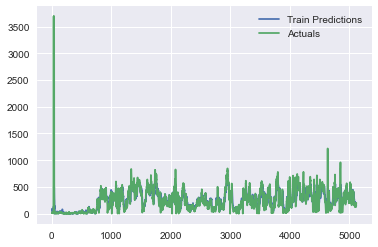

In [10]:
model = load_model('5H_Forecast/5H_ForecastModel_12_SizeWindow/')

X, y = DataHandler(5,12)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,shuffle=False) 
model.evaluate(X_test,y_test)

train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
plt.style.use('seaborn')

pd.concat([train_results['Train Predictions'],train_results['Actuals']],axis=1).plot()
plt.legend(['Train Predictions','Actuals'])

### 6 hours forecast

In [11]:
%%time

Trainer(6,6,12)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 128)               35840     
_________________________________________________________________
dense (Dense)                (None, 8)                 1032      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 36,881
Trainable params: 36,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
161/161 [==============================] - 9s 19ms/step - loss: 110539.5078 - mean_absolute_error: 247.2092 - val_loss: 148518.7812 - val_mean_absolute_error: 330.6945
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 2/100
161/161 [==============================] - 2s 15ms/step - loss: 108227.3516 - mean_absolute_error: 242.7546 - val_loss: 145236.3594 - val_mean_absolute_error: 325.6108
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 3/100
161/161 [==============================] - 2s 12ms/step - loss: 105579.4922 - mean_absolute_error: 237.6521 - val_loss: 141404.1875 - val_mean_absolute_error: 319.5863
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 4/100
161/161 [==============================] - 2s 11ms/step - loss: 102228.4609 - mean_absolute_error: 231.4390 - val_loss: 136077.4219 - val_mean_absolute_error: 311.3222
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 5/100
161/161 [==============================] - 2s 12ms/step - loss: 97823.7656 - mean_absolute_error: 223.8056 - val_loss: 129916.1562 - val_mean_absolute_error: 301.5566
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 6/100
161/161 [==============================] - 2s 13ms/step - loss: 93901.6875 - mean_absolute_error: 216.9901 - val_loss: 124596.9609 - val_mean_absolute_error: 292.9586
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 7/100
161/161 [==============================] - 2s 12ms/step - loss: 90549.1484 - mean_absolute_error: 211.2497 - val_loss: 120165.3047 - val_mean_absolute_error: 285.4172
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 8/100
161/161 [==============================] - 2s 12ms/step - loss: 87317.0234 - mean_absolute_error: 205.5945 - val_loss: 115462.8359 - val_mean_absolute_error: 277.4084
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 9/100
161/161 [==============================] - 3s 16ms/step - loss: 84028.7656 - mean_absolute_error: 199.9136 - val_loss: 110969.0234 - val_mean_absolute_error: 269.6504
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 10/100
161/161 [==============================] - 2s 13ms/step - loss: 80776.2500 - mean_absolute_error: 193.9207 - val_loss: 106067.6250 - val_mean_absolute_error: 261.2206
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 11/100
161/161 [==============================] - 3s 19ms/step - loss: 77615.8594 - mean_absolute_error: 188.3525 - val_loss: 101829.9688 - val_mean_absolute_error: 253.9520
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 12/100
161/161 [==============================] - 2s 9ms/step - loss: 74765.5625 - mean_absolute_error: 183.3079 - val_loss: 97731.6484 - val_mean_absolute_error: 247.0028
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 13/100
161/161 [==============================] - 2s 10ms/step - loss: 71964.5625 - mean_absolute_error: 177.4221 - val_loss: 93525.3438 - val_mean_absolute_error: 240.0959
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 14/100
161/161 [==============================] - 1s 9ms/step - loss: 69258.6016 - mean_absolute_error: 173.1252 - val_loss: 89647.8984 - val_mean_absolute_error: 233.6748
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 15/100
161/161 [==============================] - 2s 10ms/step - loss: 66672.2031 - mean_absolute_error: 168.5003 - val_loss: 85645.6875 - val_mean_absolute_error: 227.0273
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 16/100
161/161 [==============================] - 2s 9ms/step - loss: 64070.2812 - mean_absolute_error: 163.8130 - val_loss: 82002.2891 - val_mean_absolute_error: 220.9283
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 17/100
161/161 [==============================] - 2s 9ms/step - loss: 61650.7461 - mean_absolute_error: 159.1942 - val_loss: 78146.8281 - val_mean_absolute_error: 214.3444
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 18/100
161/161 [==============================] - 1s 9ms/step - loss: 59209.2305 - mean_absolute_error: 154.4494 - val_loss: 74480.8359 - val_mean_absolute_error: 207.8742
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 19/100
161/161 [==============================] - 2s 10ms/step - loss: 56746.6602 - mean_absolute_error: 149.7168 - val_loss: 70646.2578 - val_mean_absolute_error: 201.2341
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 20/100
161/161 [==============================] - 2s 10ms/step - loss: 54503.9492 - mean_absolute_error: 144.6158 - val_loss: 67292.9141 - val_mean_absolute_error: 195.4249
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 21/100
161/161 [==============================] - 2s 10ms/step - loss: 52398.5234 - mean_absolute_error: 140.8671 - val_loss: 64027.4023 - val_mean_absolute_error: 189.8154
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 22/100
161/161 [==============================] - 2s 10ms/step - loss: 50466.3438 - mean_absolute_error: 137.1051 - val_loss: 61050.0039 - val_mean_absolute_error: 184.4770
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 23/100
161/161 [==============================] - 2s 14ms/step - loss: 48701.6406 - mean_absolute_error: 133.4726 - val_loss: 58240.2500 - val_mean_absolute_error: 179.7981
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 24/100
161/161 [==============================] - 2s 13ms/step - loss: 47063.8711 - mean_absolute_error: 130.0169 - val_loss: 55618.6055 - val_mean_absolute_error: 175.3783
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 25/100
161/161 [==============================] - 3s 16ms/step - loss: 45519.7852 - mean_absolute_error: 127.2900 - val_loss: 53154.9727 - val_mean_absolute_error: 171.2860
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 26/100
161/161 [==============================] - 2s 14ms/step - loss: 43976.9844 - mean_absolute_error: 123.9040 - val_loss: 50444.4180 - val_mean_absolute_error: 166.9413
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 27/100
161/161 [==============================] - 3s 21ms/step - loss: 42483.0820 - mean_absolute_error: 121.2070 - val_loss: 48152.0391 - val_mean_absolute_error: 163.0420
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 28/100
161/161 [==============================] - 5s 33ms/step - loss: 41194.2773 - mean_absolute_error: 118.0537 - val_loss: 45982.4531 - val_mean_absolute_error: 159.0002
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 29/100
161/161 [==============================] - 2s 13ms/step - loss: 39954.2422 - mean_absolute_error: 115.0819 - val_loss: 43896.9297 - val_mean_absolute_error: 155.1713
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 30/100
161/161 [==============================] - 2s 12ms/step - loss: 38802.4727 - mean_absolute_error: 112.7586 - val_loss: 41888.4023 - val_mean_absolute_error: 151.7485
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 31/100
161/161 [==============================] - 2s 15ms/step - loss: 37777.7148 - mean_absolute_error: 110.7101 - val_loss: 40109.7031 - val_mean_absolute_error: 148.4642
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 32/100
161/161 [==============================] - 2s 15ms/step - loss: 36845.3828 - mean_absolute_error: 108.7016 - val_loss: 38386.6484 - val_mean_absolute_error: 145.0865
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 33/100
161/161 [==============================] - 2s 15ms/step - loss: 35970.1367 - mean_absolute_error: 107.1434 - val_loss: 36790.4180 - val_mean_absolute_error: 142.1816
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 34/100
161/161 [==============================] - 2s 15ms/step - loss: 35187.1367 - mean_absolute_error: 105.3967 - val_loss: 35321.9180 - val_mean_absolute_error: 139.4149
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 35/100
161/161 [==============================] - 3s 16ms/step - loss: 34454.1523 - mean_absolute_error: 104.0335 - val_loss: 33898.7109 - val_mean_absolute_error: 136.3920
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 36/100
161/161 [==============================] - 2s 14ms/step - loss: 33777.7500 - mean_absolute_error: 102.7662 - val_loss: 32613.8457 - val_mean_absolute_error: 133.8432
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 37/100
161/161 [==============================] - 2s 15ms/step - loss: 33183.7109 - mean_absolute_error: 101.1950 - val_loss: 31421.0645 - val_mean_absolute_error: 131.2485
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 38/100
161/161 [==============================] - 2s 15ms/step - loss: 32632.2227 - mean_absolute_error: 100.4359 - val_loss: 30423.6953 - val_mean_absolute_error: 128.9227
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 39/100
161/161 [==============================] - 3s 16ms/step - loss: 32093.7871 - mean_absolute_error: 98.8249 - val_loss: 29318.4824 - val_mean_absolute_error: 126.8462
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 40/100
161/161 [==============================] - 3s 16ms/step - loss: 31629.2910 - mean_absolute_error: 98.2289 - val_loss: 28563.8145 - val_mean_absolute_error: 124.6483
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 41/100
161/161 [==============================] - 2s 14ms/step - loss: 31239.5547 - mean_absolute_error: 96.6951 - val_loss: 27653.3008 - val_mean_absolute_error: 122.6817
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 42/100
161/161 [==============================] - 2s 15ms/step - loss: 30822.3398 - mean_absolute_error: 96.5437 - val_loss: 26666.6719 - val_mean_absolute_error: 120.2275
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 43/100
161/161 [==============================] - 2s 15ms/step - loss: 30421.5078 - mean_absolute_error: 95.2031 - val_loss: 25972.6797 - val_mean_absolute_error: 118.2589- mean_absol
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 44/100
161/161 [==============================] - 6s 35ms/step - loss: 30097.7051 - mean_absolute_error: 94.2984 - val_loss: 25223.6289 - val_mean_absolute_error: 116.3455
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 45/100
161/161 [==============================] - 3s 18ms/step - loss: 29771.9160 - mean_absolute_error: 93.4794 - val_loss: 24730.3535 - val_mean_absolute_error: 115.4051
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 46/100
161/161 [==============================] - 4s 24ms/step - loss: 29493.1836 - mean_absolute_error: 92.9610 - val_loss: 24252.2559 - val_mean_absolute_error: 114.1887
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 47/100
161/161 [==============================] - 2s 12ms/step - loss: 29194.5664 - mean_absolute_error: 92.0498 - val_loss: 23964.5527 - val_mean_absolute_error: 113.3844
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 48/100
161/161 [==============================] - 3s 17ms/step - loss: 28929.1934 - mean_absolute_error: 91.2650 - val_loss: 23223.6484 - val_mean_absolute_error: 111.9180
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 49/100
161/161 [==============================] - 2s 11ms/step - loss: 28664.0762 - mean_absolute_error: 90.5700 - val_loss: 23019.6797 - val_mean_absolute_error: 110.7681
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 50/100
161/161 [==============================] - 2s 13ms/step - loss: 28411.9531 - mean_absolute_error: 89.7091 - val_loss: 22831.9492 - val_mean_absolute_error: 109.8777
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 51/100
161/161 [==============================] - 2s 13ms/step - loss: 28252.0039 - mean_absolute_error: 89.0373 - val_loss: 21954.8262 - val_mean_absolute_error: 108.3093
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 52/100
161/161 [==============================] - 2s 13ms/step - loss: 28044.3223 - mean_absolute_error: 88.5587 - val_loss: 21822.9180 - val_mean_absolute_error: 107.7626
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 53/100
161/161 [==============================] - 2s 11ms/step - loss: 27857.2129 - mean_absolute_error: 88.0830 - val_loss: 21642.4863 - val_mean_absolute_error: 107.1635
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 54/100
161/161 [==============================] - 2s 11ms/step - loss: 27678.8848 - mean_absolute_error: 87.6889 - val_loss: 20857.8516 - val_mean_absolute_error: 105.4652
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 55/100
161/161 [==============================] - 2s 12ms/step - loss: 27604.3926 - mean_absolute_error: 87.3022 - val_loss: 21201.5801 - val_mean_absolute_error: 105.9995
Epoch 56/100
161/161 [==============================] - 3s 16ms/step - loss: 27462.5918 - mean_absolute_error: 86.7011 - val_loss: 20639.7520 - val_mean_absolute_error: 104.8857
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 57/100
161/161 [==============================] - 2s 11ms/step - loss: 27316.0625 - mean_absolute_error: 86.4044 - val_loss: 20027.1758 - val_mean_absolute_error: 103.2703
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 58/100
161/161 [==============================] - 2s 11ms/step - loss: 27167.1660 - mean_absolute_error: 85.9477 - val_loss: 19971.4707 - val_mean_absolute_error: 102.8230
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 59/100
161/161 [==============================] - 2s 11ms/step - loss: 27060.0000 - mean_absolute_error: 85.4839 - val_loss: 20087.4395 - val_mean_absolute_error: 102.9724
Epoch 60/100
161/161 [==============================] - 3s 16ms/step - loss: 26990.2793 - mean_absolute_error: 85.2524 - val_loss: 19729.8965 - val_mean_absolute_error: 102.0411
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 61/100
161/161 [==============================] - 2s 12ms/step - loss: 26866.7715 - mean_absolute_error: 84.7016 - val_loss: 18762.9316 - val_mean_absolute_error: 99.4598
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 62/100
161/161 [==============================] - 2s 11ms/step - loss: 26793.6074 - mean_absolute_error: 84.7073 - val_loss: 19179.0234 - val_mean_absolute_error: 100.7202
Epoch 63/100
161/161 [==============================] - 2s 10ms/step - loss: 26686.5312 - mean_absolute_error: 84.2861 - val_loss: 19332.3418 - val_mean_absolute_error: 100.8428
Epoch 64/100
161/161 [==============================] - 2s 11ms/step - loss: 26586.1270 - mean_absolute_error: 83.9521 - val_loss: 18920.1992 - val_mean_absolute_error: 99.8040
Epoch 65/100
161/161 [==============================] - 2s 11ms/step - loss: 26514.3242 - mean_absolute_error: 83.7091 - val_loss: 18662.7637 - val_mean_absolute_error: 99.0054
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 66/100
161/161 [==============================] - 2s 10ms/step - loss: 26452.9863 - mean_absolute_error: 83.4332 - val_loss: 18655.8770 - val_mean_absolute_error: 99.0140
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 67/100
161/161 [==============================] - 2s 10ms/step - loss: 26366.9531 - mean_absolute_error: 83.1060 - val_loss: 18553.1855 - val_mean_absolute_error: 98.9670
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 68/100
161/161 [==============================] - 2s 10ms/step - loss: 26315.2480 - mean_absolute_error: 82.8108 - val_loss: 18487.4980 - val_mean_absolute_error: 98.4731
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 69/100
161/161 [==============================] - 2s 11ms/step - loss: 26254.3848 - mean_absolute_error: 82.6354 - val_loss: 18134.3379 - val_mean_absolute_error: 97.7536
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 70/100
161/161 [==============================] - 2s 11ms/step - loss: 26189.9297 - mean_absolute_error: 82.3746 - val_loss: 17958.8242 - val_mean_absolute_error: 97.5242
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 71/100
161/161 [==============================] - 2s 13ms/step - loss: 26141.9258 - mean_absolute_error: 82.7133 - val_loss: 18254.8105 - val_mean_absolute_error: 97.9351
Epoch 72/100
161/161 [==============================] - 2s 15ms/step - loss: 26093.0078 - mean_absolute_error: 82.2089 - val_loss: 18232.8066 - val_mean_absolute_error: 97.8848
Epoch 73/100
161/161 [==============================] - 2s 14ms/step - loss: 26053.2090 - mean_absolute_error: 82.1238 - val_loss: 18397.5078 - val_mean_absolute_error: 98.1181
Epoch 74/100
161/161 [==============================] - 2s 13ms/step - loss: 25983.6191 - mean_absolute_error: 81.6276 - val_loss: 17601.3047 - val_mean_absolute_error: 96.6301
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 75/100
161/161 [==============================] - 2s 10ms/step - loss: 25928.3398 - mean_absolute_error: 81.7187 - val_loss: 17308.3086 - val_mean_absolute_error: 95.4585
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 76/100
161/161 [==============================] - 2s 11ms/step - loss: 25846.2090 - mean_absolute_error: 80.9251 - val_loss: 17973.7109 - val_mean_absolute_error: 96.9876
Epoch 77/100
161/161 [==============================] - 2s 15ms/step - loss: 25825.6699 - mean_absolute_error: 81.2197 - val_loss: 17809.9180 - val_mean_absolute_error: 96.6392
Epoch 78/100
161/161 [==============================] - 2s 15ms/step - loss: 25799.0449 - mean_absolute_error: 81.1470 - val_loss: 17093.0234 - val_mean_absolute_error: 94.6774
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 79/100
161/161 [==============================] - 2s 11ms/step - loss: 25744.3066 - mean_absolute_error: 80.6723 - val_loss: 17626.7871 - val_mean_absolute_error: 96.2147
Epoch 80/100
161/161 [==============================] - 2s 12ms/step - loss: 25700.7598 - mean_absolute_error: 81.0007 - val_loss: 17732.6074 - val_mean_absolute_error: 96.2403
Epoch 81/100
161/161 [==============================] - 2s 12ms/step - loss: 25650.0410 - mean_absolute_error: 80.4348 - val_loss: 17805.3867 - val_mean_absolute_error: 96.2316
Epoch 82/100
161/161 [==============================] - 2s 11ms/step - loss: 25598.0957 - mean_absolute_error: 80.2992 - val_loss: 16748.1094 - val_mean_absolute_error: 93.9384
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 83/100
161/161 [==============================] - 2s 12ms/step - loss: 25541.4844 - mean_absolute_error: 80.0329 - val_loss: 17302.1426 - val_mean_absolute_error: 94.6535
Epoch 84/100
161/161 [==============================] - 2s 12ms/step - loss: 25500.5703 - mean_absolute_error: 79.5597 - val_loss: 17189.0625 - val_mean_absolute_error: 94.7425
Epoch 85/100
161/161 [==============================] - 2s 13ms/step - loss: 25472.9258 - mean_absolute_error: 79.9571 - val_loss: 16329.7285 - val_mean_absolute_error: 92.4075
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 86/100
161/161 [==============================] - 2s 11ms/step - loss: 25514.6582 - mean_absolute_error: 79.9722 - val_loss: 16594.4746 - val_mean_absolute_error: 93.0894
Epoch 87/100
161/161 [==============================] - 2s 15ms/step - loss: 25432.5137 - mean_absolute_error: 79.4840 - val_loss: 16731.9023 - val_mean_absolute_error: 93.4389
Epoch 88/100
161/161 [==============================] - 2s 15ms/step - loss: 25373.4004 - mean_absolute_error: 79.6661 - val_loss: 16473.9766 - val_mean_absolute_error: 92.7557
Epoch 89/100
161/161 [==============================] - 2s 13ms/step - loss: 25342.1895 - mean_absolute_error: 79.4546 - val_loss: 17118.2793 - val_mean_absolute_error: 94.6419
Epoch 90/100
161/161 [==============================] - 2s 13ms/step - loss: 25290.4941 - mean_absolute_error: 79.0036 - val_loss: 17106.9238 - val_mean_absolute_error: 94.3068
Epoch 91/100
161/161 [==============================] - 2s 12ms/step - loss: 25199.5195 - mean_absolute_error: 78.9

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 98/100
161/161 [==============================] - 2s 10ms/step - loss: 24980.1953 - mean_absolute_error: 78.0259 - val_loss: 16225.4541 - val_mean_absolute_error: 92.0883
Epoch 99/100
161/161 [==============================] - 2s 14ms/step - loss: 25014.4609 - mean_absolute_error: 78.0973 - val_loss: 16126.3760 - val_mean_absolute_error: 91.5429
Epoch 100/100
161/161 [==============================] - 2s 13ms/step - loss: 24943.7656 - mean_absolute_error: 77.9933 - val_loss: 16597.6934 - val_mean_absolute_error: 92.6235

-----------------------------------------------------------------------------------------------------------

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 128)               35840     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
______

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 2/100
161/161 [==============================] - 2s 12ms/step - loss: 108814.2500 - mean_absolute_error: 244.1031 - val_loss: 146081.9375 - val_mean_absolute_error: 327.0704
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 3/100
161/161 [==============================] - 2s 14ms/step - loss: 105772.4531 - mean_absolute_error: 238.2001 - val_loss: 140884.3281 - val_mean_absolute_error: 318.9945
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 4/100
161/161 [==============================] - 2s 12ms/step - loss: 101997.6641 - mean_absolute_error: 231.2102 - val_loss: 135921.2031 - val_mean_absolute_error: 310.9428
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 5/100
161/161 [==============================] - 2s 12ms/step - loss: 97684.1719 - mean_absolute_error: 223.5306 - val_loss: 129079.7969 - val_mean_absolute_error: 300.1000
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 6/100
161/161 [==============================] - 2s 12ms/step - loss: 93077.0312 - mean_absolute_error: 215.7166 - val_loss: 123339.4297 - val_mean_absolute_error: 290.7598
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 7/100
161/161 [==============================] - 2s 12ms/step - loss: 89363.7500 - mean_absolute_error: 209.3092 - val_loss: 118165.3125 - val_mean_absolute_error: 281.9580
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 8/100
161/161 [==============================] - 2s 13ms/step - loss: 85687.9609 - mean_absolute_error: 202.6432 - val_loss: 112981.8125 - val_mean_absolute_error: 273.1276
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 9/100
161/161 [==============================] - 2s 12ms/step - loss: 82109.3281 - mean_absolute_error: 196.5646 - val_loss: 107637.6953 - val_mean_absolute_error: 263.9391
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 10/100
161/161 [==============================] - 2s 12ms/step - loss: 78344.4531 - mean_absolute_error: 189.6587 - val_loss: 102588.6406 - val_mean_absolute_error: 255.2256
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 11/100
161/161 [==============================] - 2s 15ms/step - loss: 74928.4297 - mean_absolute_error: 183.5948 - val_loss: 97520.8125 - val_mean_absolute_error: 246.6781
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 12/100
161/161 [==============================] - 2s 13ms/step - loss: 71528.5703 - mean_absolute_error: 177.1546 - val_loss: 92585.9297 - val_mean_absolute_error: 238.5268
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 13/100
161/161 [==============================] - 2s 13ms/step - loss: 68221.0156 - mean_absolute_error: 171.2516 - val_loss: 87631.3125 - val_mean_absolute_error: 230.3281
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 14/100
161/161 [==============================] - 2s 13ms/step - loss: 64935.9844 - mean_absolute_error: 165.4014 - val_loss: 82872.9766 - val_mean_absolute_error: 222.3384
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 15/100
161/161 [==============================] - 2s 13ms/step - loss: 61965.1172 - mean_absolute_error: 159.6264 - val_loss: 78600.1328 - val_mean_absolute_error: 215.0826
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 16/100
161/161 [==============================] - 2s 14ms/step - loss: 59264.8047 - mean_absolute_error: 154.5349 - val_loss: 74627.9766 - val_mean_absolute_error: 208.1190
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 17/100
161/161 [==============================] - 2s 14ms/step - loss: 56695.9258 - mean_absolute_error: 149.7128 - val_loss: 70618.0000 - val_mean_absolute_error: 201.1259
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 18/100
161/161 [==============================] - 2s 14ms/step - loss: 54204.9766 - mean_absolute_error: 144.2908 - val_loss: 66851.2031 - val_mean_absolute_error: 194.4445
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 19/100
161/161 [==============================] - 2s 13ms/step - loss: 51886.6719 - mean_absolute_error: 139.9338 - val_loss: 63373.0508 - val_mean_absolute_error: 188.6109
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 20/100
161/161 [==============================] - 2s 14ms/step - loss: 49810.1758 - mean_absolute_error: 135.7708 - val_loss: 60251.7695 - val_mean_absolute_error: 183.3923
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 21/100
161/161 [==============================] - 2s 14ms/step - loss: 47893.4414 - mean_absolute_error: 132.3977 - val_loss: 57552.1484 - val_mean_absolute_error: 179.1174
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 22/100
161/161 [==============================] - 2s 14ms/step - loss: 46169.8281 - mean_absolute_error: 128.6418 - val_loss: 54500.6875 - val_mean_absolute_error: 174.0357
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 23/100
161/161 [==============================] - 2s 13ms/step - loss: 44479.4570 - mean_absolute_error: 125.2542 - val_loss: 51803.9922 - val_mean_absolute_error: 169.4451A: 1s - loss: 33055.9961 - 
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 24/100
161/161 [==============================] - 2s 12ms/step - loss: 42949.4648 - mean_absolute_error: 122.1566 - val_loss: 49348.6484 - val_mean_absolute_error: 165.3286
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 25/100
161/161 [==============================] - 2s 11ms/step - loss: 41523.8555 - mean_absolute_error: 119.2593 - val_loss: 46906.8711 - val_mean_absolute_error: 161.4408
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 26/100
161/161 [==============================] - 2s 13ms/step - loss: 40164.9570 - mean_absolute_error: 116.4462 - val_loss: 44648.7070 - val_mean_absolute_error: 157.4402
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 27/100
161/161 [==============================] - 2s 12ms/step - loss: 38867.2617 - mean_absolute_error: 113.5511 - val_loss: 42334.6914 - val_mean_absolute_error: 153.7090
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 28/100
161/161 [==============================] - 2s 13ms/step - loss: 37729.1055 - mean_absolute_error: 111.6618 - val_loss: 40444.7930 - val_mean_absolute_error: 149.9633
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 29/100
161/161 [==============================] - 5s 33ms/step - loss: 36745.3438 - mean_absolute_error: 109.2025 - val_loss: 38677.6953 - val_mean_absolute_error: 146.7501
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 30/100
161/161 [==============================] - 2s 14ms/step - loss: 35817.4453 - mean_absolute_error: 107.5036 - val_loss: 36967.8398 - val_mean_absolute_error: 143.5547
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 31/100
161/161 [==============================] - 2s 14ms/step - loss: 34965.2852 - mean_absolute_error: 105.6069 - val_loss: 35530.0078 - val_mean_absolute_error: 140.5984
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 32/100
161/161 [==============================] - 2s 15ms/step - loss: 34179.1484 - mean_absolute_error: 103.8754 - val_loss: 34177.8125 - val_mean_absolute_error: 137.5774
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 33/100
161/161 [==============================] - 2s 14ms/step - loss: 33464.9688 - mean_absolute_error: 102.3523 - val_loss: 32714.0332 - val_mean_absolute_error: 134.3947
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 34/100
161/161 [==============================] - 2s 14ms/step - loss: 32803.6836 - mean_absolute_error: 101.0025 - val_loss: 31499.7266 - val_mean_absolute_error: 131.6580
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 35/100
161/161 [==============================] - 3s 16ms/step - loss: 32164.7402 - mean_absolute_error: 99.4895 - val_loss: 30289.2441 - val_mean_absolute_error: 129.0928
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 36/100
161/161 [==============================] - 2s 15ms/step - loss: 31604.8125 - mean_absolute_error: 98.1339 - val_loss: 29204.0430 - val_mean_absolute_error: 126.2532
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 37/100
161/161 [==============================] - 2s 15ms/step - loss: 31026.0527 - mean_absolute_error: 97.0074 - val_loss: 28208.8711 - val_mean_absolute_error: 123.7399
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 38/100
161/161 [==============================] - 2s 15ms/step - loss: 30628.3281 - mean_absolute_error: 96.1871 - val_loss: 27327.2734 - val_mean_absolute_error: 121.4300
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 39/100
161/161 [==============================] - 2s 15ms/step - loss: 30160.0117 - mean_absolute_error: 94.9002 - val_loss: 26344.6191 - val_mean_absolute_error: 119.4900
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 40/100
161/161 [==============================] - 3s 16ms/step - loss: 29794.8438 - mean_absolute_error: 94.1748 - val_loss: 25717.5957 - val_mean_absolute_error: 117.6998
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 41/100
161/161 [==============================] - 3s 16ms/step - loss: 29398.4355 - mean_absolute_error: 93.1416 - val_loss: 24966.2285 - val_mean_absolute_error: 115.7296
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 42/100
161/161 [==============================] - 2s 15ms/step - loss: 29040.9180 - mean_absolute_error: 92.0521 - val_loss: 24414.7188 - val_mean_absolute_error: 114.4892
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 43/100
161/161 [==============================] - 2s 14ms/step - loss: 28755.5488 - mean_absolute_error: 91.4040 - val_loss: 23979.6992 - val_mean_absolute_error: 112.9569
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 44/100
161/161 [==============================] - 2s 13ms/step - loss: 28472.8867 - mean_absolute_error: 90.4807 - val_loss: 23088.8652 - val_mean_absolute_error: 110.8557
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 45/100
161/161 [==============================] - 2s 15ms/step - loss: 28185.3105 - mean_absolute_error: 89.8509 - val_loss: 23115.1582 - val_mean_absolute_error: 110.5503
Epoch 46/100
161/161 [==============================] - 2s 15ms/step - loss: 28011.3672 - mean_absolute_error: 89.3192 - val_loss: 22505.4590 - val_mean_absolute_error: 109.0503
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 47/100
161/161 [==============================] - 2s 14ms/step - loss: 27734.0762 - mean_absolute_error: 88.6219 - val_loss: 22085.3281 - val_mean_absolute_error: 107.9966
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 48/100
161/161 [==============================] - 2s 13ms/step - loss: 27589.2988 - mean_absolute_error: 88.3018 - val_loss: 22558.8340 - val_mean_absolute_error: 108.9930
Epoch 49/100
161/161 [==============================] - 2s 13ms/step - loss: 27365.4141 - mean_absolute_error: 87.3932 - val_loss: 21890.7773 - val_mean_absolute_error: 107.7023
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 50/100
161/161 [==============================] - 2s 15ms/step - loss: 27190.1328 - mean_absolute_error: 86.6388 - val_loss: 21000.4082 - val_mean_absolute_error: 105.7866
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 51/100
161/161 [==============================] - 3s 19ms/step - loss: 27029.0859 - mean_absolute_error: 86.3103 - val_loss: 21426.5879 - val_mean_absolute_error: 106.5798
Epoch 52/100
161/161 [==============================] - 3s 18ms/step - loss: 27005.1387 - mean_absolute_error: 86.3403 - val_loss: 20861.9492 - val_mean_absolute_error: 105.1273
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 53/100
161/161 [==============================] - 2s 15ms/step - loss: 26875.8477 - mean_absolute_error: 86.0352 - val_loss: 20256.8359 - val_mean_absolute_error: 103.4276
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 54/100
161/161 [==============================] - 2s 14ms/step - loss: 26607.7148 - mean_absolute_error: 85.0716 - val_loss: 20232.8770 - val_mean_absolute_error: 102.8399
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 55/100
161/161 [==============================] - 2s 13ms/step - loss: 26439.5391 - mean_absolute_error: 84.1502 - val_loss: 19604.3203 - val_mean_absolute_error: 101.8564
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 56/100
161/161 [==============================] - 2s 14ms/step - loss: 26277.1641 - mean_absolute_error: 83.7779 - val_loss: 19915.9492 - val_mean_absolute_error: 102.1161
Epoch 57/100
161/161 [==============================] - 2s 14ms/step - loss: 26200.0312 - mean_absolute_error: 83.4055 - val_loss: 19381.8926 - val_mean_absolute_error: 101.0824
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 58/100
161/161 [==============================] - 2s 14ms/step - loss: 26131.6543 - mean_absolute_error: 83.5101 - val_loss: 19459.0977 - val_mean_absolute_error: 101.1380
Epoch 59/100
161/161 [==============================] - 2s 13ms/step - loss: 26016.4512 - mean_absolute_error: 82.9231 - val_loss: 19190.4141 - val_mean_absolute_error: 100.5473
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 60/100
161/161 [==============================] - 3s 16ms/step - loss: 25904.9102 - mean_absolute_error: 82.3868 - val_loss: 19081.1309 - val_mean_absolute_error: 100.2240
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 61/100
161/161 [==============================] - 2s 14ms/step - loss: 25808.4453 - mean_absolute_error: 82.1241 - val_loss: 18978.3184 - val_mean_absolute_error: 99.9096
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 62/100
161/161 [==============================] - 2s 13ms/step - loss: 25756.2949 - mean_absolute_error: 81.8289 - val_loss: 18614.8730 - val_mean_absolute_error: 99.0558
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 63/100
161/161 [==============================] - 2s 14ms/step - loss: 25654.0195 - mean_absolute_error: 81.6463 - val_loss: 18725.2969 - val_mean_absolute_error: 98.9939
Epoch 64/100
161/161 [==============================] - 3s 19ms/step - loss: 25568.1016 - mean_absolute_error: 81.3585 - val_loss: 18431.8848 - val_mean_absolute_error: 98.3880 mean
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 65/100
161/161 [==============================] - 5s 31ms/step - loss: 25668.4824 - mean_absolute_error: 81.8278 - val_loss: 18412.3848 - val_mean_absolute_error: 97.8924
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 66/100
161/161 [==============================] - 2s 15ms/step - loss: 25474.5742 - mean_absolute_error: 80.8849 - val_loss: 18035.5820 - val_mean_absolute_error: 96.9743
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 67/100
161/161 [==============================] - 2s 15ms/step - loss: 25348.4238 - mean_absolute_error: 80.2265 - val_loss: 18132.7852 - val_mean_absolute_error: 96.9886
Epoch 68/100
161/161 [==============================] - 2s 14ms/step - loss: 25244.7422 - mean_absolute_error: 79.8182 - val_loss: 17831.9336 - val_mean_absolute_error: 96.6556
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 69/100
161/161 [==============================] - 2s 15ms/step - loss: 25183.4199 - mean_absolute_error: 79.7108 - val_loss: 18086.5195 - val_mean_absolute_error: 97.2409
Epoch 70/100
161/161 [==============================] - 2s 14ms/step - loss: 25144.1387 - mean_absolute_error: 79.5472 - val_loss: 17339.3086 - val_mean_absolute_error: 95.3523
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 71/100
161/161 [==============================] - 2s 13ms/step - loss: 25124.8184 - mean_absolute_error: 79.5143 - val_loss: 17400.7500 - val_mean_absolute_error: 95.4222
Epoch 72/100
161/161 [==============================] - 2s 13ms/step - loss: 25026.8281 - mean_absolute_error: 79.0436 - val_loss: 17454.0078 - val_mean_absolute_error: 95.7147
Epoch 73/100
161/161 [==============================] - 2s 13ms/step - loss: 25060.2109 - mean_absolute_error: 79.5923 - val_loss: 17281.2461 - val_mean_absolute_error: 94.9913
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 74/100
161/161 [==============================] - 2s 13ms/step - loss: 24953.4141 - mean_absolute_error: 79.0803 - val_loss: 17432.6777 - val_mean_absolute_error: 95.2138
Epoch 75/100
161/161 [==============================] - 2s 13ms/step - loss: 24834.1914 - mean_absolute_error: 78.5963 - val_loss: 17124.5488 - val_mean_absolute_error: 94.1145
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 76/100
161/161 [==============================] - 2s 14ms/step - loss: 24769.9004 - mean_absolute_error: 78.3824 - val_loss: 17160.0957 - val_mean_absolute_error: 94.3370
Epoch 77/100
161/161 [==============================] - 2s 13ms/step - loss: 24737.5898 - mean_absolute_error: 78.1982 - val_loss: 17094.6172 - val_mean_absolute_error: 94.1877
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 78/100
161/161 [==============================] - 2s 13ms/step - loss: 24673.6758 - mean_absolute_error: 77.9107 - val_loss: 17297.4746 - val_mean_absolute_error: 95.0394
Epoch 79/100
161/161 [==============================] - 3s 16ms/step - loss: 24642.4062 - mean_absolute_error: 78.0098 - val_loss: 17224.7949 - val_mean_absolute_error: 94.4067
Epoch 80/100
161/161 [==============================] - 2s 14ms/step - loss: 24695.6309 - mean_absolute_error: 77.9386 - val_loss: 17115.7344 - val_mean_absolute_error: 94.4311
Epoch 81/100
161/161 [==============================] - 2s 13ms/step - loss: 24702.2520 - mean_absolute_error: 78.5013 - val_loss: 16628.5879 - val_mean_absolute_error: 92.7502
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 82/100
161/161 [==============================] - 2s 13ms/step - loss: 24502.7246 - mean_absolute_error: 77.4687 - val_loss: 17373.2402 - val_mean_absolute_error: 94.5918
Epoch 83/100
161/161 [==============================] - 2s 15ms/step - loss: 24494.6992 - mean_absolute_error: 77.3814 - val_loss: 17162.5723 - val_mean_absolute_error: 93.9890
Epoch 84/100
161/161 [==============================] - 2s 15ms/step - loss: 24413.1582 - mean_absolute_error: 77.0586 - val_loss: 16336.7002 - val_mean_absolute_error: 92.0797
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 85/100
161/161 [==============================] - 2s 13ms/step - loss: 24375.9980 - mean_absolute_error: 77.0992 - val_loss: 16416.6875 - val_mean_absolute_error: 92.5805
Epoch 86/100
161/161 [==============================] - 2s 14ms/step - loss: 24362.1777 - mean_absolute_error: 76.8264 - val_loss: 16777.0449 - val_mean_absolute_error: 93.0261
Epoch 87/100
161/161 [==============================] - 2s 14ms/step - loss: 24311.2383 - mean_absolute_error: 76.7201 - val_loss: 16319.3799 - val_mean_absolute_error: 91.7693
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 88/100
161/161 [==============================] - 2s 15ms/step - loss: 24253.9727 - mean_absolute_error: 76.7570 - val_loss: 16285.7656 - val_mean_absolute_error: 91.4991
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 89/100
161/161 [==============================] - 2s 14ms/step - loss: 24295.2734 - mean_absolute_error: 76.7135 - val_loss: 16306.8076 - val_mean_absolute_error: 92.2604
Epoch 90/100
161/161 [==============================] - 2s 14ms/step - loss: 24227.4688 - mean_absolute_error: 76.4741 - val_loss: 16212.4043 - val_mean_absolute_error: 91.5379
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 91/100
161/161 [==============================] - 2s 16ms/step - loss: 24149.5918 - mean_absolute_error: 76.1671 - val_loss: 16606.1953 - val_mean_absolute_error: 92.5495
Epoch 92/100
161/161 [==============================] - 3s 20ms/step - loss: 24208.4961 - mean_absolute_error: 76.1463 - val_loss: 16098.1465 - val_mean_absolute_error: 91.2909
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 93/100
161/161 [==============================] - 2s 15ms/step - loss: 24441.2051 - mean_absolute_error: 76.9632 - val_loss: 16729.0449 - val_mean_absolute_error: 93.3554
Epoch 94/100
161/161 [==============================] - 2s 15ms/step - loss: 24162.3105 - mean_absolute_error: 76.2998 - val_loss: 16204.3438 - val_mean_absolute_error: 91.1855
Epoch 95/100
161/161 [==============================] - 2s 14ms/step - loss: 24084.6191 - mean_absolute_error: 75.6773 - val_loss: 16225.4961 - val_mean_absolute_error: 91.4498
Epoch 96/100
161/161 [==============================] - 2s 15ms/step - loss: 24016.8867 - mean_absolute_error: 75.4429 - val_loss: 16384.1523 - val_mean_absolute_error: 92.5807
Epoch 97/100
161/161 [==============================] - 3s 17ms/step - loss: 23987.1660 - mean_absolute_error: 75.7184 - val_loss: 16163.6387 - val_mean_absolute_error: 91.5231
Epoch 98/100
161/161 [==============================] - 2s 15ms/step - loss: 23928.9141 - mean_absolute_error: 75.5

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 100/100
161/161 [==============================] - 2s 13ms/step - loss: 23899.8008 - mean_absolute_error: 75.2880 - val_loss: 15784.0420 - val_mean_absolute_error: 90.5379

-----------------------------------------------------------------------------------------------------------

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 128)               35840     
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 36,881
Trainable params: 36,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
160/160 [==============================] - 6s 18ms/step - loss: 111076.3984 - me

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 2/100
160/160 [==============================] - 2s 12ms/step - loss: 108986.7344 - mean_absolute_error: 243.8178 - val_loss: 145660.4688 - val_mean_absolute_error: 326.1035
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 3/100
160/160 [==============================] - 2s 10ms/step - loss: 105222.0859 - mean_absolute_error: 236.8063 - val_loss: 140058.1094 - val_mean_absolute_error: 317.4308
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 4/100
160/160 [==============================] - 2s 10ms/step - loss: 100812.1641 - mean_absolute_error: 229.1064 - val_loss: 133596.4219 - val_mean_absolute_error: 307.3315
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 5/100
160/160 [==============================] - 2s 12ms/step - loss: 95999.0078 - mean_absolute_error: 220.7632 - val_loss: 126829.2891 - val_mean_absolute_error: 296.3608
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 6/100
160/160 [==============================] - 2s 12ms/step - loss: 91290.5391 - mean_absolute_error: 212.5613 - val_loss: 120370.4375 - val_mean_absolute_error: 285.6276
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 7/100
160/160 [==============================] - 2s 12ms/step - loss: 87169.4531 - mean_absolute_error: 205.5682 - val_loss: 114973.1484 - val_mean_absolute_error: 276.4531
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 8/100
160/160 [==============================] - 2s 10ms/step - loss: 83341.4688 - mean_absolute_error: 198.7864 - val_loss: 109592.6875 - val_mean_absolute_error: 267.2456
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 9/100
160/160 [==============================] - 2s 12ms/step - loss: 79847.6406 - mean_absolute_error: 192.5075 - val_loss: 104610.7500 - val_mean_absolute_error: 258.6781
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 10/100
160/160 [==============================] - 2s 13ms/step - loss: 76461.2891 - mean_absolute_error: 186.5544 - val_loss: 99767.4219 - val_mean_absolute_error: 250.4298
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 11/100
160/160 [==============================] - 2s 10ms/step - loss: 73220.5391 - mean_absolute_error: 180.8391 - val_loss: 95169.1406 - val_mean_absolute_error: 242.7657
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 12/100
160/160 [==============================] - 2s 11ms/step - loss: 70041.7578 - mean_absolute_error: 174.9171 - val_loss: 90416.4062 - val_mean_absolute_error: 234.9426
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 13/100
160/160 [==============================] - 2s 11ms/step - loss: 67019.6953 - mean_absolute_error: 169.5295 - val_loss: 86110.0000 - val_mean_absolute_error: 227.7812
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 14/100
160/160 [==============================] - 2s 11ms/step - loss: 64210.6445 - mean_absolute_error: 164.0846 - val_loss: 81999.3750 - val_mean_absolute_error: 220.8635
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 15/100
160/160 [==============================] - 2s 11ms/step - loss: 61541.4766 - mean_absolute_error: 159.3504 - val_loss: 77913.9297 - val_mean_absolute_error: 213.8149
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 16/100
160/160 [==============================] - 2s 10ms/step - loss: 58932.2578 - mean_absolute_error: 154.4411 - val_loss: 74055.6328 - val_mean_absolute_error: 207.0840
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 17/100
160/160 [==============================] - 2s 10ms/step - loss: 56526.1172 - mean_absolute_error: 149.6972 - val_loss: 70367.4766 - val_mean_absolute_error: 200.6997
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 18/100
160/160 [==============================] - 2s 10ms/step - loss: 54192.9062 - mean_absolute_error: 144.9210 - val_loss: 66842.6641 - val_mean_absolute_error: 194.5673
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 19/100
160/160 [==============================] - 2s 10ms/step - loss: 52015.1641 - mean_absolute_error: 141.0911 - val_loss: 63513.2695 - val_mean_absolute_error: 188.7908
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 20/100
160/160 [==============================] - 2s 10ms/step - loss: 49954.8711 - mean_absolute_error: 136.6676 - val_loss: 60161.7812 - val_mean_absolute_error: 183.1138
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 21/100
160/160 [==============================] - 2s 10ms/step - loss: 47965.1328 - mean_absolute_error: 132.6625 - val_loss: 57082.8633 - val_mean_absolute_error: 177.9963
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 22/100
160/160 [==============================] - 2s 11ms/step - loss: 46162.5273 - mean_absolute_error: 129.3379 - val_loss: 54260.7695 - val_mean_absolute_error: 173.2578
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 23/100
160/160 [==============================] - 2s 12ms/step - loss: 44463.2266 - mean_absolute_error: 125.3877 - val_loss: 51443.2695 - val_mean_absolute_error: 168.6587
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 24/100
160/160 [==============================] - 2s 9ms/step - loss: 42897.4102 - mean_absolute_error: 122.5518 - val_loss: 48933.8594 - val_mean_absolute_error: 164.4181
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 25/100
160/160 [==============================] - 2s 10ms/step - loss: 41469.5781 - mean_absolute_error: 119.4849 - val_loss: 46563.5000 - val_mean_absolute_error: 160.1699
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 26/100
160/160 [==============================] - 2s 12ms/step - loss: 40160.7109 - mean_absolute_error: 116.8225 - val_loss: 44404.6445 - val_mean_absolute_error: 156.5289
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 27/100
160/160 [==============================] - 1s 9ms/step - loss: 38960.1016 - mean_absolute_error: 113.7512 - val_loss: 42281.9141 - val_mean_absolute_error: 152.9704
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 28/100
160/160 [==============================] - 2s 12ms/step - loss: 37845.4414 - mean_absolute_error: 111.8478 - val_loss: 40320.1406 - val_mean_absolute_error: 148.9843
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 29/100
160/160 [==============================] - 2s 12ms/step - loss: 36794.9688 - mean_absolute_error: 109.6608 - val_loss: 38557.5820 - val_mean_absolute_error: 145.8033
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 30/100
160/160 [==============================] - 2s 12ms/step - loss: 35870.2617 - mean_absolute_error: 107.3569 - val_loss: 36879.9219 - val_mean_absolute_error: 142.2214
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 31/100
160/160 [==============================] - 2s 12ms/step - loss: 35056.6133 - mean_absolute_error: 106.0221 - val_loss: 35298.8750 - val_mean_absolute_error: 139.2581
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 32/100
160/160 [==============================] - 2s 10ms/step - loss: 34252.2891 - mean_absolute_error: 104.4621 - val_loss: 33835.6094 - val_mean_absolute_error: 136.0724
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 33/100
160/160 [==============================] - 1s 9ms/step - loss: 33549.5430 - mean_absolute_error: 102.7824 - val_loss: 32520.9355 - val_mean_absolute_error: 133.4953
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 34/100
160/160 [==============================] - 2s 11ms/step - loss: 32931.4609 - mean_absolute_error: 101.4064 - val_loss: 31207.3789 - val_mean_absolute_error: 130.5462
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 35/100
160/160 [==============================] - 2s 11ms/step - loss: 32277.9590 - mean_absolute_error: 99.9439 - val_loss: 30061.9688 - val_mean_absolute_error: 127.8488
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 36/100
160/160 [==============================] - 2s 10ms/step - loss: 31723.5664 - mean_absolute_error: 99.0857 - val_loss: 28947.1230 - val_mean_absolute_error: 125.6837
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 37/100
160/160 [==============================] - 2s 11ms/step - loss: 31265.9219 - mean_absolute_error: 98.0130 - val_loss: 28003.0195 - val_mean_absolute_error: 123.2087
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 38/100
160/160 [==============================] - 2s 11ms/step - loss: 30826.4961 - mean_absolute_error: 97.0353 - val_loss: 27125.7168 - val_mean_absolute_error: 121.3496
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 39/100
160/160 [==============================] - 2s 10ms/step - loss: 30431.3398 - mean_absolute_error: 95.9725 - val_loss: 26286.2676 - val_mean_absolute_error: 119.6474
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 40/100
160/160 [==============================] - 1s 9ms/step - loss: 30076.4316 - mean_absolute_error: 95.2352 - val_loss: 25595.4629 - val_mean_absolute_error: 117.9126
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 41/100
160/160 [==============================] - 2s 10ms/step - loss: 29758.6816 - mean_absolute_error: 94.7633 - val_loss: 24885.1406 - val_mean_absolute_error: 116.2533
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 42/100
160/160 [==============================] - 1s 9ms/step - loss: 29407.1680 - mean_absolute_error: 93.8779 - val_loss: 24389.0332 - val_mean_absolute_error: 114.4911
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 43/100
160/160 [==============================] - 2s 11ms/step - loss: 29073.0254 - mean_absolute_error: 92.3609 - val_loss: 23628.7988 - val_mean_absolute_error: 112.5140
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 44/100
160/160 [==============================] - 2s 10ms/step - loss: 28728.2227 - mean_absolute_error: 91.8825 - val_loss: 23164.6641 - val_mean_absolute_error: 111.1635
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 45/100
160/160 [==============================] - 2s 10ms/step - loss: 28472.6621 - mean_absolute_error: 90.5559 - val_loss: 22400.5645 - val_mean_absolute_error: 109.5032
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 46/100
160/160 [==============================] - 2s 11ms/step - loss: 28200.9316 - mean_absolute_error: 89.9295 - val_loss: 22000.7051 - val_mean_absolute_error: 108.0384
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 47/100
160/160 [==============================] - 2s 11ms/step - loss: 28055.7090 - mean_absolute_error: 89.7492 - val_loss: 21612.5781 - val_mean_absolute_error: 107.0463
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 48/100
160/160 [==============================] - 2s 11ms/step - loss: 27700.2559 - mean_absolute_error: 88.3262 - val_loss: 21129.6797 - val_mean_absolute_error: 105.6532
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 49/100
160/160 [==============================] - 2s 10ms/step - loss: 27561.2812 - mean_absolute_error: 87.6439 - val_loss: 20850.6230 - val_mean_absolute_error: 104.8419
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 50/100
160/160 [==============================] - 2s 11ms/step - loss: 27305.8750 - mean_absolute_error: 87.0300 - val_loss: 20397.6797 - val_mean_absolute_error: 103.5141
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 51/100
160/160 [==============================] - 2s 11ms/step - loss: 27154.1152 - mean_absolute_error: 86.5397 - val_loss: 20167.7656 - val_mean_absolute_error: 102.7255
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 52/100
160/160 [==============================] - 2s 11ms/step - loss: 26993.9629 - mean_absolute_error: 86.2249 - val_loss: 19865.5918 - val_mean_absolute_error: 102.1531
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 53/100
160/160 [==============================] - 2s 10ms/step - loss: 26819.6465 - mean_absolute_error: 85.5163 - val_loss: 19478.3496 - val_mean_absolute_error: 100.8271
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 54/100
160/160 [==============================] - 1s 9ms/step - loss: 26673.4375 - mean_absolute_error: 84.9314 - val_loss: 19471.0215 - val_mean_absolute_error: 100.4973
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 55/100
160/160 [==============================] - 2s 11ms/step - loss: 26596.8633 - mean_absolute_error: 84.2115 - val_loss: 19169.3301 - val_mean_absolute_error: 100.1398
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 56/100
160/160 [==============================] - 2s 11ms/step - loss: 26505.7070 - mean_absolute_error: 84.9816 - val_loss: 19264.9746 - val_mean_absolute_error: 99.3537
Epoch 57/100
160/160 [==============================] - 2s 15ms/step - loss: 26306.6719 - mean_absolute_error: 83.4159 - val_loss: 18796.8574 - val_mean_absolute_error: 98.7813
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 58/100
160/160 [==============================] - 2s 10ms/step - loss: 26178.5195 - mean_absolute_error: 82.8602 - val_loss: 18625.9629 - val_mean_absolute_error: 98.0867
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 59/100
160/160 [==============================] - 2s 10ms/step - loss: 26056.3398 - mean_absolute_error: 82.5728 - val_loss: 18444.0742 - val_mean_absolute_error: 97.7489
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 60/100
160/160 [==============================] - 1s 9ms/step - loss: 26116.3438 - mean_absolute_error: 82.9466 - val_loss: 18419.6777 - val_mean_absolute_error: 97.6525
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 61/100
160/160 [==============================] - 2s 10ms/step - loss: 25901.5039 - mean_absolute_error: 81.8169 - val_loss: 18097.9844 - val_mean_absolute_error: 96.5843
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 62/100
160/160 [==============================] - 2s 9ms/step - loss: 25785.4277 - mean_absolute_error: 81.4153 - val_loss: 17839.5469 - val_mean_absolute_error: 96.0759
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 63/100
160/160 [==============================] - 2s 11ms/step - loss: 25697.6230 - mean_absolute_error: 81.2040 - val_loss: 17921.7988 - val_mean_absolute_error: 96.3269
Epoch 64/100
160/160 [==============================] - 2s 11ms/step - loss: 25683.2520 - mean_absolute_error: 80.9728 - val_loss: 17810.4141 - val_mean_absolute_error: 96.0931
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 65/100
160/160 [==============================] - 2s 10ms/step - loss: 25567.5508 - mean_absolute_error: 80.8983 - val_loss: 17772.9629 - val_mean_absolute_error: 95.5753
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 66/100
160/160 [==============================] - 2s 11ms/step - loss: 25468.2617 - mean_absolute_error: 80.3224 - val_loss: 17446.6777 - val_mean_absolute_error: 94.7079
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 67/100
160/160 [==============================] - 2s 10ms/step - loss: 25372.5469 - mean_absolute_error: 79.8248 - val_loss: 17596.3164 - val_mean_absolute_error: 95.3792
Epoch 68/100
160/160 [==============================] - 2s 11ms/step - loss: 25318.9336 - mean_absolute_error: 79.8685 - val_loss: 17210.3516 - val_mean_absolute_error: 93.8569
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 69/100
160/160 [==============================] - 2s 10ms/step - loss: 25245.4043 - mean_absolute_error: 79.3877 - val_loss: 17018.9961 - val_mean_absolute_error: 93.4302
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 70/100
160/160 [==============================] - 2s 10ms/step - loss: 25217.9863 - mean_absolute_error: 79.1515 - val_loss: 17286.9570 - val_mean_absolute_error: 93.8757
Epoch 71/100
160/160 [==============================] - 2s 10ms/step - loss: 25209.9531 - mean_absolute_error: 79.3774 - val_loss: 17393.1895 - val_mean_absolute_error: 94.1252
Epoch 72/100
160/160 [==============================] - 2s 10ms/step - loss: 25095.5312 - mean_absolute_error: 78.6202 - val_loss: 17082.9922 - val_mean_absolute_error: 93.7699
Epoch 73/100
160/160 [==============================] - 2s 10ms/step - loss: 24990.7910 - mean_absolute_error: 78.5024 - val_loss: 17178.7715 - val_mean_absolute_error: 93.4057
Epoch 74/100
160/160 [==============================] - 2s 10ms/step - loss: 25000.6641 - mean_absolute_error: 78.4958 - val_loss: 16737.4824 - val_mean_absolute_error: 92.4036
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 75/100
160/160 [==============================] - 1s 9ms/step - loss: 24893.6992 - mean_absolute_error: 77.8244 - val_loss: 16694.2617 - val_mean_absolute_error: 91.9848
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 76/100
160/160 [==============================] - 2s 10ms/step - loss: 24858.8047 - mean_absolute_error: 77.9952 - val_loss: 16720.1309 - val_mean_absolute_error: 92.3128
Epoch 77/100
160/160 [==============================] - 2s 13ms/step - loss: 24799.0723 - mean_absolute_error: 77.6696 - val_loss: 16625.3164 - val_mean_absolute_error: 91.8244
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 78/100
160/160 [==============================] - 2s 10ms/step - loss: 24737.2578 - mean_absolute_error: 77.5270 - val_loss: 16835.0996 - val_mean_absolute_error: 92.4639
Epoch 79/100
160/160 [==============================] - 2s 11ms/step - loss: 24688.9023 - mean_absolute_error: 77.3747 - val_loss: 16553.4336 - val_mean_absolute_error: 91.5812
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 80/100
160/160 [==============================] - 2s 11ms/step - loss: 24643.8086 - mean_absolute_error: 77.0883 - val_loss: 16812.1074 - val_mean_absolute_error: 92.3081
Epoch 81/100
160/160 [==============================] - 2s 12ms/step - loss: 24608.5508 - mean_absolute_error: 77.1542 - val_loss: 16503.3906 - val_mean_absolute_error: 91.0943
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 82/100
160/160 [==============================] - 1s 9ms/step - loss: 24551.5859 - mean_absolute_error: 76.7951 - val_loss: 16508.3027 - val_mean_absolute_error: 91.8333
Epoch 83/100
160/160 [==============================] - 2s 11ms/step - loss: 24534.3281 - mean_absolute_error: 76.8875 - val_loss: 16338.5215 - val_mean_absolute_error: 90.7819
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 84/100
160/160 [==============================] - 2s 10ms/step - loss: 24492.3633 - mean_absolute_error: 76.7131 - val_loss: 16340.0938 - val_mean_absolute_error: 90.9625
Epoch 85/100
160/160 [==============================] - 2s 11ms/step - loss: 24649.2598 - mean_absolute_error: 77.8654 - val_loss: 16851.0469 - val_mean_absolute_error: 91.7843
Epoch 86/100
160/160 [==============================] - 2s 11ms/step - loss: 24453.3613 - mean_absolute_error: 76.6594 - val_loss: 15941.7002 - val_mean_absolute_error: 89.3163
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 87/100
160/160 [==============================] - 2s 11ms/step - loss: 24370.4492 - mean_absolute_error: 76.1468 - val_loss: 15969.3555 - val_mean_absolute_error: 90.1421
Epoch 88/100
160/160 [==============================] - 2s 12ms/step - loss: 24324.3281 - mean_absolute_error: 76.2442 - val_loss: 15935.5889 - val_mean_absolute_error: 89.2661
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 89/100
160/160 [==============================] - 2s 11ms/step - loss: 24271.1680 - mean_absolute_error: 76.0299 - val_loss: 15742.6152 - val_mean_absolute_error: 89.4044
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 90/100
160/160 [==============================] - 2s 11ms/step - loss: 24215.6367 - mean_absolute_error: 76.1446 - val_loss: 15688.8916 - val_mean_absolute_error: 88.9555
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 91/100
160/160 [==============================] - 2s 12ms/step - loss: 24150.5879 - mean_absolute_error: 75.5959 - val_loss: 15949.5703 - val_mean_absolute_error: 89.8184
Epoch 92/100
160/160 [==============================] - 2s 12ms/step - loss: 24089.8125 - mean_absolute_error: 75.6358 - val_loss: 15648.9678 - val_mean_absolute_error: 88.8418
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 93/100
160/160 [==============================] - 2s 10ms/step - loss: 24105.1211 - mean_absolute_error: 75.6151 - val_loss: 15821.9287 - val_mean_absolute_error: 89.1361
Epoch 94/100
160/160 [==============================] - 2s 12ms/step - loss: 24044.0234 - mean_absolute_error: 75.4053 - val_loss: 15614.9717 - val_mean_absolute_error: 88.6516
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 95/100
160/160 [==============================] - 2s 10ms/step - loss: 23964.4023 - mean_absolute_error: 75.0859 - val_loss: 15668.5391 - val_mean_absolute_error: 88.6578
Epoch 96/100
160/160 [==============================] - 2s 11ms/step - loss: 23980.1133 - mean_absolute_error: 75.3463 - val_loss: 15991.8164 - val_mean_absolute_error: 89.6348
Epoch 97/100
160/160 [==============================] - 2s 11ms/step - loss: 23973.2227 - mean_absolute_error: 75.2656 - val_loss: 15802.7090 - val_mean_absolute_error: 88.9870
Epoch 98/100
160/160 [==============================] - 2s 11ms/step - loss: 23938.2969 - mean_absolute_error: 75.1164 - val_loss: 15394.7090 - val_mean_absolute_error: 88.0911
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 99/100
160/160 [==============================] - 2s 10ms/step - loss: 23852.2305 - mean_absolute_error: 74.8177 - val_loss: 15599.4170 - val_mean_absolute_error: 88.4183
Epoch 100/100
160/160 [==============================] - 2s 11ms/step - loss: 23850.3496 - mean_absolute_error: 74.9013 - val_loss: 15571.7314 - val_mean_absolute_error: 88.3047

-----------------------------------------------------------------------------------------------------------

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 128)               35840     
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 36,881
Trainable params: 36,881
Non-t

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 2/100
160/160 [==============================] - 2s 13ms/step - loss: 110567.3594 - mean_absolute_error: 247.2315 - val_loss: 149097.9688 - val_mean_absolute_error: 331.6450
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 3/100
160/160 [==============================] - 2s 14ms/step - loss: 108630.6172 - mean_absolute_error: 243.4782 - val_loss: 145709.2031 - val_mean_absolute_error: 326.5192
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 4/100
160/160 [==============================] - 2s 12ms/step - loss: 106120.9297 - mean_absolute_error: 238.7951 - val_loss: 142151.0781 - val_mean_absolute_error: 321.1263
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 5/100
160/160 [==============================] - 2s 13ms/step - loss: 103380.3125 - mean_absolute_error: 233.8477 - val_loss: 138135.6719 - val_mean_absolute_error: 314.8602
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 6/100
160/160 [==============================] - 2s 12ms/step - loss: 100288.5312 - mean_absolute_error: 228.4633 - val_loss: 133831.2344 - val_mean_absolute_error: 308.0627
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 7/100
160/160 [==============================] - 2s 13ms/step - loss: 97329.7031 - mean_absolute_error: 223.3190 - val_loss: 130150.2812 - val_mean_absolute_error: 302.1413
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 8/100
160/160 [==============================] - 2s 13ms/step - loss: 94701.8984 - mean_absolute_error: 218.7797 - val_loss: 126182.4453 - val_mean_absolute_error: 295.5843
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 9/100
160/160 [==============================] - 2s 13ms/step - loss: 91807.2812 - mean_absolute_error: 213.4592 - val_loss: 122146.8984 - val_mean_absolute_error: 288.8112
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 10/100
160/160 [==============================] - 2s 13ms/step - loss: 88927.8125 - mean_absolute_error: 208.5494 - val_loss: 118175.6406 - val_mean_absolute_error: 282.0753
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 11/100
160/160 [==============================] - 2s 12ms/step - loss: 86237.9062 - mean_absolute_error: 203.7607 - val_loss: 114414.3125 - val_mean_absolute_error: 275.6263
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 12/100
160/160 [==============================] - 2s 13ms/step - loss: 83616.8281 - mean_absolute_error: 199.1646 - val_loss: 110656.4844 - val_mean_absolute_error: 269.1257
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 13/100
160/160 [==============================] - 2s 13ms/step - loss: 80915.2266 - mean_absolute_error: 194.3442 - val_loss: 106636.0625 - val_mean_absolute_error: 262.1531
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 14/100
160/160 [==============================] - 2s 14ms/step - loss: 78170.5078 - mean_absolute_error: 189.6072 - val_loss: 102683.3984 - val_mean_absolute_error: 255.3639
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 15/100
160/160 [==============================] - 2s 12ms/step - loss: 75477.6172 - mean_absolute_error: 184.9525 - val_loss: 98812.5234 - val_mean_absolute_error: 248.8271
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 16/100
160/160 [==============================] - 2s 13ms/step - loss: 72850.9609 - mean_absolute_error: 179.9809 - val_loss: 94968.8672 - val_mean_absolute_error: 242.4486
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 17/100
160/160 [==============================] - 2s 13ms/step - loss: 70319.4688 - mean_absolute_error: 175.4510 - val_loss: 91264.3438 - val_mean_absolute_error: 236.3445
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 18/100
160/160 [==============================] - 2s 13ms/step - loss: 67806.6641 - mean_absolute_error: 171.0313 - val_loss: 87557.6719 - val_mean_absolute_error: 230.1446
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 19/100
160/160 [==============================] - 2s 12ms/step - loss: 65391.9141 - mean_absolute_error: 165.5103 - val_loss: 83966.8438 - val_mean_absolute_error: 224.2095
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 20/100
160/160 [==============================] - 2s 14ms/step - loss: 62993.5039 - mean_absolute_error: 161.4382 - val_loss: 80449.5547 - val_mean_absolute_error: 218.1073
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 21/100
160/160 [==============================] - 2s 12ms/step - loss: 60646.6836 - mean_absolute_error: 157.2299 - val_loss: 76530.1484 - val_mean_absolute_error: 211.3960
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 22/100
160/160 [==============================] - 2s 13ms/step - loss: 58189.4219 - mean_absolute_error: 152.4185 - val_loss: 73030.3047 - val_mean_absolute_error: 205.0658
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 23/100
160/160 [==============================] - 2s 14ms/step - loss: 56042.4023 - mean_absolute_error: 148.2047 - val_loss: 69813.2422 - val_mean_absolute_error: 199.4400
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 24/100
160/160 [==============================] - 2s 13ms/step - loss: 54040.2539 - mean_absolute_error: 144.0836 - val_loss: 66718.5156 - val_mean_absolute_error: 194.0228
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 25/100
160/160 [==============================] - 2s 14ms/step - loss: 52122.0469 - mean_absolute_error: 140.5554 - val_loss: 63744.2578 - val_mean_absolute_error: 188.8903
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 26/100
160/160 [==============================] - 2s 12ms/step - loss: 50329.0508 - mean_absolute_error: 136.6273 - val_loss: 60921.9297 - val_mean_absolute_error: 184.1496
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 27/100
160/160 [==============================] - 2s 13ms/step - loss: 48598.0977 - mean_absolute_error: 133.5227 - val_loss: 58216.0703 - val_mean_absolute_error: 179.4720
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 28/100
160/160 [==============================] - 2s 15ms/step - loss: 46989.7852 - mean_absolute_error: 130.5077 - val_loss: 55519.4531 - val_mean_absolute_error: 175.1214
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 29/100
160/160 [==============================] - 2s 13ms/step - loss: 45454.9414 - mean_absolute_error: 127.1297 - val_loss: 53099.6562 - val_mean_absolute_error: 171.0007
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 30/100
160/160 [==============================] - 2s 13ms/step - loss: 44027.9492 - mean_absolute_error: 124.2343 - val_loss: 50806.0078 - val_mean_absolute_error: 167.3233
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 31/100
160/160 [==============================] - 2s 13ms/step - loss: 42704.2773 - mean_absolute_error: 121.6292 - val_loss: 48627.4062 - val_mean_absolute_error: 163.7416
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 32/100
160/160 [==============================] - 2s 14ms/step - loss: 41474.6484 - mean_absolute_error: 119.3136 - val_loss: 46564.7930 - val_mean_absolute_error: 160.3170
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 33/100
160/160 [==============================] - 2s 15ms/step - loss: 40357.2109 - mean_absolute_error: 116.9324 - val_loss: 44615.8867 - val_mean_absolute_error: 157.2299
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 34/100
160/160 [==============================] - 2s 13ms/step - loss: 39250.9258 - mean_absolute_error: 114.5189 - val_loss: 42727.8672 - val_mean_absolute_error: 153.4916
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 35/100
160/160 [==============================] - 2s 14ms/step - loss: 38239.2617 - mean_absolute_error: 111.9685 - val_loss: 41017.6133 - val_mean_absolute_error: 150.1170
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 36/100
160/160 [==============================] - 2s 14ms/step - loss: 37300.1719 - mean_absolute_error: 110.1980 - val_loss: 39349.8594 - val_mean_absolute_error: 147.1818
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 37/100
160/160 [==============================] - 2s 13ms/step - loss: 36439.8203 - mean_absolute_error: 108.5320 - val_loss: 37794.9375 - val_mean_absolute_error: 144.2069
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 38/100
160/160 [==============================] - 2s 13ms/step - loss: 35628.8828 - mean_absolute_error: 106.8792 - val_loss: 36367.7891 - val_mean_absolute_error: 141.5960
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 39/100
160/160 [==============================] - 2s 14ms/step - loss: 34929.7031 - mean_absolute_error: 105.3285 - val_loss: 34870.0117 - val_mean_absolute_error: 138.8088
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 40/100
160/160 [==============================] - 2s 15ms/step - loss: 34191.3828 - mean_absolute_error: 103.7133 - val_loss: 33596.3984 - val_mean_absolute_error: 136.1052
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 41/100
160/160 [==============================] - 2s 15ms/step - loss: 33562.2227 - mean_absolute_error: 102.1309 - val_loss: 32418.4199 - val_mean_absolute_error: 133.5025
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 42/100
160/160 [==============================] - 2s 15ms/step - loss: 32986.6523 - mean_absolute_error: 101.1322 - val_loss: 31385.1191 - val_mean_absolute_error: 131.0881
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 43/100
160/160 [==============================] - 2s 13ms/step - loss: 32422.5449 - mean_absolute_error: 99.6874 - val_loss: 30222.0430 - val_mean_absolute_error: 128.5232
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 44/100
160/160 [==============================] - 2s 13ms/step - loss: 31860.4668 - mean_absolute_error: 98.4565 - val_loss: 29131.3184 - val_mean_absolute_error: 126.1668
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 45/100
160/160 [==============================] - 2s 15ms/step - loss: 31352.9180 - mean_absolute_error: 97.2726 - val_loss: 28195.9180 - val_mean_absolute_error: 124.2849
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 46/100
160/160 [==============================] - 2s 13ms/step - loss: 30967.6836 - mean_absolute_error: 96.4119 - val_loss: 27317.3164 - val_mean_absolute_error: 122.2161
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 47/100
160/160 [==============================] - 2s 13ms/step - loss: 30597.7129 - mean_absolute_error: 95.7077 - val_loss: 26619.5918 - val_mean_absolute_error: 120.5433
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 48/100
160/160 [==============================] - 2s 14ms/step - loss: 30209.6348 - mean_absolute_error: 94.7272 - val_loss: 25901.5527 - val_mean_absolute_error: 118.9682
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 49/100
160/160 [==============================] - 2s 12ms/step - loss: 29937.2656 - mean_absolute_error: 93.7461 - val_loss: 25206.7227 - val_mean_absolute_error: 117.2111
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 50/100
160/160 [==============================] - 2s 14ms/step - loss: 29585.1855 - mean_absolute_error: 93.0378 - val_loss: 24498.1426 - val_mean_absolute_error: 115.6308
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 51/100
160/160 [==============================] - 2s 12ms/step - loss: 29283.7129 - mean_absolute_error: 92.5306 - val_loss: 23873.5527 - val_mean_absolute_error: 113.5546
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 52/100
160/160 [==============================] - 2s 12ms/step - loss: 28997.8828 - mean_absolute_error: 91.7930 - val_loss: 23303.7871 - val_mean_absolute_error: 112.2756
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 53/100
160/160 [==============================] - 2s 14ms/step - loss: 28702.4277 - mean_absolute_error: 90.8730 - val_loss: 22780.3027 - val_mean_absolute_error: 110.6426
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 54/100
160/160 [==============================] - 2s 13ms/step - loss: 28506.1016 - mean_absolute_error: 90.4265 - val_loss: 22303.4727 - val_mean_absolute_error: 109.2312
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 55/100
160/160 [==============================] - 2s 13ms/step - loss: 28244.0781 - mean_absolute_error: 89.0173 - val_loss: 21986.7539 - val_mean_absolute_error: 108.0823
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 56/100
160/160 [==============================] - 2s 15ms/step - loss: 28008.4102 - mean_absolute_error: 88.1893 - val_loss: 21504.8359 - val_mean_absolute_error: 106.5972
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 57/100
160/160 [==============================] - 2s 13ms/step - loss: 27842.5156 - mean_absolute_error: 87.6701 - val_loss: 21345.4570 - val_mean_absolute_error: 106.6100
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 58/100
160/160 [==============================] - 2s 13ms/step - loss: 27702.5801 - mean_absolute_error: 87.5626 - val_loss: 20926.6426 - val_mean_absolute_error: 105.6259
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 59/100
160/160 [==============================] - 2s 14ms/step - loss: 27495.7012 - mean_absolute_error: 86.7681 - val_loss: 20628.7422 - val_mean_absolute_error: 104.9222
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 60/100
160/160 [==============================] - 2s 12ms/step - loss: 27347.8984 - mean_absolute_error: 85.9752 - val_loss: 20147.6113 - val_mean_absolute_error: 103.4172
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 61/100
160/160 [==============================] - 2s 13ms/step - loss: 27264.0469 - mean_absolute_error: 86.2793 - val_loss: 20077.3730 - val_mean_absolute_error: 102.9525
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 62/100
160/160 [==============================] - 2s 14ms/step - loss: 27116.1094 - mean_absolute_error: 85.5160 - val_loss: 19774.6582 - val_mean_absolute_error: 102.5841
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 63/100
160/160 [==============================] - 2s 12ms/step - loss: 27014.2285 - mean_absolute_error: 85.1232 - val_loss: 19574.9824 - val_mean_absolute_error: 101.8986
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 64/100
160/160 [==============================] - 2s 13ms/step - loss: 26910.5176 - mean_absolute_error: 84.9556 - val_loss: 19378.1953 - val_mean_absolute_error: 101.7050
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 65/100
160/160 [==============================] - 2s 14ms/step - loss: 26824.3613 - mean_absolute_error: 84.4885 - val_loss: 19088.7070 - val_mean_absolute_error: 100.6255
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 66/100
160/160 [==============================] - 2s 13ms/step - loss: 26726.6660 - mean_absolute_error: 84.4194 - val_loss: 18708.9395 - val_mean_absolute_error: 99.9587
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 67/100
160/160 [==============================] - 2s 14ms/step - loss: 26609.8809 - mean_absolute_error: 83.7910 - val_loss: 18803.5742 - val_mean_absolute_error: 100.1298
Epoch 68/100
160/160 [==============================] - 2s 14ms/step - loss: 26574.0215 - mean_absolute_error: 83.7862 - val_loss: 18551.6094 - val_mean_absolute_error: 99.3148
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 69/100
160/160 [==============================] - 2s 14ms/step - loss: 26476.0332 - mean_absolute_error: 83.1703 - val_loss: 18601.0078 - val_mean_absolute_error: 99.0856
Epoch 70/100
160/160 [==============================] - 3s 16ms/step - loss: 26397.1875 - mean_absolute_error: 83.1016 - val_loss: 18186.7168 - val_mean_absolute_error: 98.7413
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 71/100
160/160 [==============================] - 2s 13ms/step - loss: 26321.8184 - mean_absolute_error: 82.8513 - val_loss: 18076.1445 - val_mean_absolute_error: 97.2603
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 72/100
160/160 [==============================] - 2s 13ms/step - loss: 26236.1367 - mean_absolute_error: 82.3959 - val_loss: 18113.0391 - val_mean_absolute_error: 97.9869
Epoch 73/100
160/160 [==============================] - 2s 15ms/step - loss: 26171.4023 - mean_absolute_error: 82.2075 - val_loss: 18109.4473 - val_mean_absolute_error: 97.6322
Epoch 74/100
160/160 [==============================] - 3s 18ms/step - loss: 26078.1895 - mean_absolute_error: 81.6264 - val_loss: 17896.3711 - val_mean_absolute_error: 97.1163
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 75/100
160/160 [==============================] - 2s 13ms/step - loss: 26032.1445 - mean_absolute_error: 81.6056 - val_loss: 18102.1035 - val_mean_absolute_error: 97.6080
Epoch 76/100
160/160 [==============================] - 2s 14ms/step - loss: 25968.6250 - mean_absolute_error: 81.2809 - val_loss: 17450.5293 - val_mean_absolute_error: 95.7432
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 77/100
160/160 [==============================] - 2s 14ms/step - loss: 25948.9258 - mean_absolute_error: 81.3503 - val_loss: 17447.8711 - val_mean_absolute_error: 95.5996
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 78/100
160/160 [==============================] - 2s 14ms/step - loss: 25955.8730 - mean_absolute_error: 81.2035 - val_loss: 17495.1758 - val_mean_absolute_error: 95.5133
Epoch 79/100
160/160 [==============================] - 2s 14ms/step - loss: 25870.3301 - mean_absolute_error: 80.7437 - val_loss: 17090.9922 - val_mean_absolute_error: 94.4154
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 80/100
160/160 [==============================] - 2s 14ms/step - loss: 25758.9844 - mean_absolute_error: 80.3794 - val_loss: 17561.2109 - val_mean_absolute_error: 95.6493
Epoch 81/100
160/160 [==============================] - 2s 15ms/step - loss: 25657.7637 - mean_absolute_error: 80.0973 - val_loss: 16898.6113 - val_mean_absolute_error: 94.1139
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 82/100
160/160 [==============================] - 2s 14ms/step - loss: 25619.8125 - mean_absolute_error: 80.0727 - val_loss: 17119.6348 - val_mean_absolute_error: 94.4250
Epoch 83/100
160/160 [==============================] - 2s 15ms/step - loss: 25602.0371 - mean_absolute_error: 79.6137 - val_loss: 17310.6934 - val_mean_absolute_error: 94.6046
Epoch 84/100
160/160 [==============================] - 2s 14ms/step - loss: 25574.3711 - mean_absolute_error: 79.9049 - val_loss: 17172.2383 - val_mean_absolute_error: 94.6228
Epoch 85/100
160/160 [==============================] - 2s 15ms/step - loss: 25522.0684 - mean_absolute_error: 79.5943 - val_loss: 16783.6562 - val_mean_absolute_error: 93.2344
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 86/100
160/160 [==============================] - 2s 13ms/step - loss: 25460.1602 - mean_absolute_error: 78.9804 - val_loss: 16874.5781 - val_mean_absolute_error: 93.5553
Epoch 87/100
160/160 [==============================] - 4s 27ms/step - loss: 25375.5098 - mean_absolute_error: 79.0046 - val_loss: 16534.2910 - val_mean_absolute_error: 92.5713
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 88/100
160/160 [==============================] - 4s 24ms/step - loss: 25363.1836 - mean_absolute_error: 78.9117 - val_loss: 17149.6523 - val_mean_absolute_error: 94.2795
Epoch 89/100
160/160 [==============================] - 10s 60ms/step - loss: 25297.4902 - mean_absolute_error: 78.7034 - val_loss: 16662.4648 - val_mean_absolute_error: 93.3491
Epoch 90/100
160/160 [==============================] - 4s 25ms/step - loss: 25245.0293 - mean_absolute_error: 78.4313 - val_loss: 16657.0820 - val_mean_absolute_error: 93.2460
Epoch 91/100
160/160 [==============================] - 3s 18ms/step - loss: 25281.0195 - mean_absolute_error: 78.4851 - val_loss: 16246.1289 - val_mean_absolute_error: 92.0249
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 92/100
160/160 [==============================] - 2s 15ms/step - loss: 25226.2500 - mean_absolute_error: 78.4227 - val_loss: 16618.5879 - val_mean_absolute_error: 92.7623
Epoch 93/100
160/160 [==============================] - 2s 14ms/step - loss: 25138.6309 - mean_absolute_error: 78.2382 - val_loss: 16446.0508 - val_mean_absolute_error: 92.2888
Epoch 94/100
160/160 [==============================] - 2s 15ms/step - loss: 25109.7930 - mean_absolute_error: 78.1305 - val_loss: 16609.8145 - val_mean_absolute_error: 93.2443
Epoch 95/100
160/160 [==============================] - 2s 15ms/step - loss: 25147.8066 - mean_absolute_error: 78.0118 - val_loss: 16463.1680 - val_mean_absolute_error: 92.7782
Epoch 96/100
160/160 [==============================] - 2s 15ms/step - loss: 25074.5488 - mean_absolute_error: 77.9029 - val_loss: 16261.8486 - val_mean_absolute_error: 92.0596
Epoch 97/100
160/160 [==============================] - 2s 14ms/step - loss: 25080.5898 - mean_absolute_error: 77.9

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 2/100
160/160 [==============================] - 3s 17ms/step - loss: 109864.5391 - mean_absolute_error: 245.8541 - val_loss: 147898.4688 - val_mean_absolute_error: 329.7625
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 3/100
160/160 [==============================] - 3s 17ms/step - loss: 107714.6797 - mean_absolute_error: 241.7232 - val_loss: 144083.3906 - val_mean_absolute_error: 323.8752
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 4/100
160/160 [==============================] - 3s 18ms/step - loss: 104378.0156 - mean_absolute_error: 235.4857 - val_loss: 139192.8750 - val_mean_absolute_error: 316.3324
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 5/100
160/160 [==============================] - 3s 21ms/step - loss: 100978.6562 - mean_absolute_error: 229.5528 - val_loss: 134895.6094 - val_mean_absolute_error: 309.6841
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 6/100
160/160 [==============================] - 3s 16ms/step - loss: 97980.9844 - mean_absolute_error: 224.2930 - val_loss: 130620.0000 - val_mean_absolute_error: 302.8552
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 7/100
160/160 [==============================] - 3s 19ms/step - loss: 94911.0469 - mean_absolute_error: 218.9754 - val_loss: 126171.0859 - val_mean_absolute_error: 295.4980
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 8/100
160/160 [==============================] - 3s 16ms/step - loss: 91687.7656 - mean_absolute_error: 213.0989 - val_loss: 121869.3438 - val_mean_absolute_error: 288.2809
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 9/100
160/160 [==============================] - 3s 16ms/step - loss: 88639.7344 - mean_absolute_error: 207.7859 - val_loss: 117320.5234 - val_mean_absolute_error: 280.5188
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 10/100
160/160 [==============================] - 3s 18ms/step - loss: 85352.6094 - mean_absolute_error: 201.9788 - val_loss: 112795.9297 - val_mean_absolute_error: 272.8224
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 11/100
160/160 [==============================] - 3s 19ms/step - loss: 82359.9844 - mean_absolute_error: 196.6784 - val_loss: 108631.3203 - val_mean_absolute_error: 265.5901
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 12/100
160/160 [==============================] - 2s 15ms/step - loss: 79469.7031 - mean_absolute_error: 191.4105 - val_loss: 104570.7578 - val_mean_absolute_error: 258.6022
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 13/100
160/160 [==============================] - 3s 16ms/step - loss: 76769.7109 - mean_absolute_error: 186.6929 - val_loss: 100711.0078 - val_mean_absolute_error: 252.0088
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 14/100
160/160 [==============================] - 3s 17ms/step - loss: 74178.8672 - mean_absolute_error: 181.9360 - val_loss: 96994.1641 - val_mean_absolute_error: 245.7836
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 15/100
160/160 [==============================] - 3s 19ms/step - loss: 71591.8359 - mean_absolute_error: 177.4017 - val_loss: 93223.4297 - val_mean_absolute_error: 239.5630
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 16/100
160/160 [==============================] - 3s 16ms/step - loss: 69126.9531 - mean_absolute_error: 172.9738 - val_loss: 89565.4062 - val_mean_absolute_error: 233.5154
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 17/100
160/160 [==============================] - 2s 14ms/step - loss: 66689.5000 - mean_absolute_error: 168.4598 - val_loss: 86007.8984 - val_mean_absolute_error: 227.6505
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 18/100
160/160 [==============================] - 3s 17ms/step - loss: 64297.1172 - mean_absolute_error: 164.1022 - val_loss: 82596.5938 - val_mean_absolute_error: 221.9366
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 19/100
160/160 [==============================] - 2s 15ms/step - loss: 62028.5117 - mean_absolute_error: 159.8180 - val_loss: 79272.5000 - val_mean_absolute_error: 216.3640
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 20/100
160/160 [==============================] - 2s 16ms/step - loss: 59838.2500 - mean_absolute_error: 155.9240 - val_loss: 75938.6719 - val_mean_absolute_error: 210.6711
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 21/100
160/160 [==============================] - 3s 18ms/step - loss: 57757.8672 - mean_absolute_error: 151.8094 - val_loss: 72740.2031 - val_mean_absolute_error: 205.1453
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 22/100
160/160 [==============================] - 2s 15ms/step - loss: 55797.3945 - mean_absolute_error: 147.9260 - val_loss: 69746.9297 - val_mean_absolute_error: 199.9494
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 23/100
160/160 [==============================] - 3s 19ms/step - loss: 53912.2422 - mean_absolute_error: 144.2424 - val_loss: 66875.1328 - val_mean_absolute_error: 194.9671
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 24/100
160/160 [==============================] - 3s 16ms/step - loss: 52131.3398 - mean_absolute_error: 140.8453 - val_loss: 64177.3164 - val_mean_absolute_error: 190.2904
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 25/100
160/160 [==============================] - 3s 16ms/step - loss: 50318.0078 - mean_absolute_error: 137.3188 - val_loss: 61324.0156 - val_mean_absolute_error: 185.3739
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 26/100
160/160 [==============================] - 3s 16ms/step - loss: 48623.4961 - mean_absolute_error: 133.0978 - val_loss: 58362.9570 - val_mean_absolute_error: 180.7228
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 27/100
160/160 [==============================] - 2s 13ms/step - loss: 46947.4180 - mean_absolute_error: 130.8109 - val_loss: 55865.1289 - val_mean_absolute_error: 176.6496
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 28/100
160/160 [==============================] - 2s 15ms/step - loss: 45443.2812 - mean_absolute_error: 127.6238 - val_loss: 53578.9102 - val_mean_absolute_error: 172.9239
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 29/100
160/160 [==============================] - 2s 14ms/step - loss: 44074.1211 - mean_absolute_error: 124.4083 - val_loss: 51402.9961 - val_mean_absolute_error: 169.7472
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 30/100
160/160 [==============================] - 3s 21ms/step - loss: 42787.6172 - mean_absolute_error: 122.4264 - val_loss: 49327.5742 - val_mean_absolute_error: 166.1793
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 31/100
160/160 [==============================] - 3s 16ms/step - loss: 41622.2812 - mean_absolute_error: 120.0172 - val_loss: 47359.9844 - val_mean_absolute_error: 162.9915
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 32/100
160/160 [==============================] - 3s 19ms/step - loss: 40505.6602 - mean_absolute_error: 117.4713 - val_loss: 45518.3047 - val_mean_absolute_error: 160.0558
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 33/100
160/160 [==============================] - 3s 16ms/step - loss: 39489.1602 - mean_absolute_error: 115.2902 - val_loss: 43703.9102 - val_mean_absolute_error: 156.6706
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 34/100
160/160 [==============================] - 3s 16ms/step - loss: 38550.3633 - mean_absolute_error: 114.1129 - val_loss: 42022.3086 - val_mean_absolute_error: 153.7682
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 35/100
160/160 [==============================] - 2s 15ms/step - loss: 37608.7891 - mean_absolute_error: 111.8670 - val_loss: 40634.0898 - val_mean_absolute_error: 151.1788
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 36/100
160/160 [==============================] - 2s 15ms/step - loss: 36851.5742 - mean_absolute_error: 110.0046 - val_loss: 39122.2109 - val_mean_absolute_error: 148.2182
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 37/100
160/160 [==============================] - 3s 18ms/step - loss: 35962.2891 - mean_absolute_error: 107.7237 - val_loss: 37585.7656 - val_mean_absolute_error: 145.2062
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 38/100
160/160 [==============================] - 3s 16ms/step - loss: 35238.2266 - mean_absolute_error: 106.6008 - val_loss: 36322.0195 - val_mean_absolute_error: 142.6000
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 39/100
160/160 [==============================] - 3s 17ms/step - loss: 34593.1133 - mean_absolute_error: 104.9580 - val_loss: 34983.6055 - val_mean_absolute_error: 139.9539
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 40/100
160/160 [==============================] - 3s 18ms/step - loss: 33927.9688 - mean_absolute_error: 103.5640 - val_loss: 33720.9414 - val_mean_absolute_error: 137.2295
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 41/100
160/160 [==============================] - 2s 16ms/step - loss: 33286.4492 - mean_absolute_error: 102.3618 - val_loss: 32609.4414 - val_mean_absolute_error: 134.5461
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 42/100
160/160 [==============================] - 3s 16ms/step - loss: 32756.7305 - mean_absolute_error: 100.7696 - val_loss: 31466.4355 - val_mean_absolute_error: 131.9780
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 43/100
160/160 [==============================] - 3s 18ms/step - loss: 32250.4609 - mean_absolute_error: 100.1438 - val_loss: 30616.0625 - val_mean_absolute_error: 129.9691
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 44/100
160/160 [==============================] - 3s 16ms/step - loss: 31767.2129 - mean_absolute_error: 98.7842 - val_loss: 29637.6387 - val_mean_absolute_error: 127.6680
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 45/100
160/160 [==============================] - 2s 15ms/step - loss: 31332.2227 - mean_absolute_error: 97.8605 - val_loss: 28726.9668 - val_mean_absolute_error: 125.6496
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 46/100
160/160 [==============================] - 3s 17ms/step - loss: 30949.8867 - mean_absolute_error: 96.8746 - val_loss: 27979.7402 - val_mean_absolute_error: 123.8906
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 47/100
160/160 [==============================] - 3s 17ms/step - loss: 30563.9707 - mean_absolute_error: 95.9771 - val_loss: 27268.7285 - val_mean_absolute_error: 122.4117
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 48/100
160/160 [==============================] - 3s 17ms/step - loss: 30193.8848 - mean_absolute_error: 95.0047 - val_loss: 26491.0352 - val_mean_absolute_error: 120.1106
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 49/100
160/160 [==============================] - 3s 16ms/step - loss: 29840.3438 - mean_absolute_error: 93.8217 - val_loss: 25805.7266 - val_mean_absolute_error: 118.9064
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 50/100
160/160 [==============================] - 2s 15ms/step - loss: 29496.1289 - mean_absolute_error: 93.2078 - val_loss: 25144.2676 - val_mean_absolute_error: 117.2846
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 51/100
160/160 [==============================] - 3s 19ms/step - loss: 29217.0352 - mean_absolute_error: 92.5406 - val_loss: 24757.2676 - val_mean_absolute_error: 116.1057
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 52/100
160/160 [==============================] - 3s 19ms/step - loss: 28934.3965 - mean_absolute_error: 91.5094 - val_loss: 23930.9824 - val_mean_absolute_error: 114.2499
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 53/100
160/160 [==============================] - 3s 17ms/step - loss: 28689.8281 - mean_absolute_error: 91.3145 - val_loss: 23593.2715 - val_mean_absolute_error: 112.8434
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 54/100
160/160 [==============================] - 3s 18ms/step - loss: 28547.9297 - mean_absolute_error: 90.6612 - val_loss: 23137.8418 - val_mean_absolute_error: 111.8036
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 55/100
160/160 [==============================] - 3s 20ms/step - loss: 28269.5059 - mean_absolute_error: 89.6588 - val_loss: 22819.3750 - val_mean_absolute_error: 110.9567
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 56/100
160/160 [==============================] - 3s 17ms/step - loss: 28051.4238 - mean_absolute_error: 89.0926 - val_loss: 22299.5312 - val_mean_absolute_error: 109.2858
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 57/100
160/160 [==============================] - 3s 19ms/step - loss: 27833.4004 - mean_absolute_error: 88.2710 - val_loss: 21704.4824 - val_mean_absolute_error: 107.9049
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 58/100
160/160 [==============================] - 3s 21ms/step - loss: 27717.1465 - mean_absolute_error: 87.9239 - val_loss: 22100.0195 - val_mean_absolute_error: 108.2212
Epoch 59/100
160/160 [==============================] - 4s 24ms/step - loss: 27676.2422 - mean_absolute_error: 87.8418 - val_loss: 21509.8438 - val_mean_absolute_error: 106.5455
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 60/100
160/160 [==============================] - 3s 16ms/step - loss: 27434.9297 - mean_absolute_error: 87.3199 - val_loss: 20911.3281 - val_mean_absolute_error: 105.2690
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 61/100
160/160 [==============================] - 2s 15ms/step - loss: 27192.3242 - mean_absolute_error: 86.2667 - val_loss: 20522.1230 - val_mean_absolute_error: 104.6886
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 62/100
160/160 [==============================] - 2s 15ms/step - loss: 27013.7051 - mean_absolute_error: 85.7296 - val_loss: 20445.8203 - val_mean_absolute_error: 104.2782
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 63/100
160/160 [==============================] - 3s 16ms/step - loss: 26931.7773 - mean_absolute_error: 85.3331 - val_loss: 20094.3945 - val_mean_absolute_error: 102.8409
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 64/100
160/160 [==============================] - 3s 19ms/step - loss: 26793.2656 - mean_absolute_error: 84.8982 - val_loss: 19986.1934 - val_mean_absolute_error: 102.7253
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 65/100
160/160 [==============================] - 3s 17ms/step - loss: 26696.1094 - mean_absolute_error: 84.8594 - val_loss: 19707.1484 - val_mean_absolute_error: 101.4263
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 66/100
160/160 [==============================] - 3s 19ms/step - loss: 26594.2422 - mean_absolute_error: 84.4395 - val_loss: 19316.8926 - val_mean_absolute_error: 100.4222
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 67/100
160/160 [==============================] - 2s 15ms/step - loss: 26540.5117 - mean_absolute_error: 84.0288 - val_loss: 19118.0078 - val_mean_absolute_error: 100.1369
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 68/100
160/160 [==============================] - 3s 16ms/step - loss: 26479.0527 - mean_absolute_error: 83.9449 - val_loss: 19173.4980 - val_mean_absolute_error: 100.3401
Epoch 69/100
160/160 [==============================] - 3s 16ms/step - loss: 26332.6016 - mean_absolute_error: 83.4768 - val_loss: 19040.3906 - val_mean_absolute_error: 99.7426
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 70/100
160/160 [==============================] - 3s 16ms/step - loss: 26306.0762 - mean_absolute_error: 83.1850 - val_loss: 19021.5996 - val_mean_absolute_error: 99.2732
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 71/100
160/160 [==============================] - 3s 16ms/step - loss: 26152.8496 - mean_absolute_error: 82.4864 - val_loss: 18755.4961 - val_mean_absolute_error: 98.3885
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 72/100
160/160 [==============================] - 2s 16ms/step - loss: 26065.8574 - mean_absolute_error: 82.1859 - val_loss: 18459.4941 - val_mean_absolute_error: 97.5920
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 73/100
160/160 [==============================] - 2s 15ms/step - loss: 25968.8633 - mean_absolute_error: 81.8885 - val_loss: 18023.5508 - val_mean_absolute_error: 96.7224
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 74/100
160/160 [==============================] - 3s 16ms/step - loss: 25886.9980 - mean_absolute_error: 81.5024 - val_loss: 18318.7168 - val_mean_absolute_error: 97.4338
Epoch 75/100
160/160 [==============================] - 2s 15ms/step - loss: 25874.1699 - mean_absolute_error: 81.5647 - val_loss: 18093.9961 - val_mean_absolute_error: 96.6778
Epoch 76/100
160/160 [==============================] - 2s 15ms/step - loss: 25851.2051 - mean_absolute_error: 81.3565 - val_loss: 17951.0996 - val_mean_absolute_error: 96.1819
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 77/100
160/160 [==============================] - 2s 15ms/step - loss: 25768.7773 - mean_absolute_error: 81.2248 - val_loss: 18330.4590 - val_mean_absolute_error: 97.0570
Epoch 78/100
160/160 [==============================] - 3s 20ms/step - loss: 25679.9570 - mean_absolute_error: 80.8926 - val_loss: 17977.1797 - val_mean_absolute_error: 95.9777
Epoch 79/100
160/160 [==============================] - 3s 18ms/step - loss: 25640.7871 - mean_absolute_error: 80.9035 - val_loss: 17737.3945 - val_mean_absolute_error: 95.0123
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 80/100
160/160 [==============================] - 3s 16ms/step - loss: 25577.6309 - mean_absolute_error: 80.5343 - val_loss: 17984.5703 - val_mean_absolute_error: 96.1799
Epoch 81/100
160/160 [==============================] - 3s 16ms/step - loss: 25553.6016 - mean_absolute_error: 80.6872 - val_loss: 17402.7520 - val_mean_absolute_error: 94.1504
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 82/100
160/160 [==============================] - 2s 14ms/step - loss: 25477.3848 - mean_absolute_error: 80.0745 - val_loss: 17319.3594 - val_mean_absolute_error: 94.5527
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 83/100
160/160 [==============================] - 3s 16ms/step - loss: 25433.7656 - mean_absolute_error: 80.0966 - val_loss: 17278.5938 - val_mean_absolute_error: 94.4249
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 84/100
160/160 [==============================] - 3s 16ms/step - loss: 25316.7676 - mean_absolute_error: 79.6208 - val_loss: 17696.6641 - val_mean_absolute_error: 95.3254
Epoch 85/100
160/160 [==============================] - 2s 15ms/step - loss: 25277.8477 - mean_absolute_error: 79.3202 - val_loss: 17157.3750 - val_mean_absolute_error: 93.9525
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 86/100
160/160 [==============================] - 2s 15ms/step - loss: 25201.0684 - mean_absolute_error: 79.2037 - val_loss: 17423.4023 - val_mean_absolute_error: 94.4150
Epoch 87/100
160/160 [==============================] - 3s 16ms/step - loss: 25247.1641 - mean_absolute_error: 79.6392 - val_loss: 17062.6562 - val_mean_absolute_error: 93.3935
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 88/100
160/160 [==============================] - 2s 13ms/step - loss: 25189.6602 - mean_absolute_error: 78.9122 - val_loss: 16931.8926 - val_mean_absolute_error: 93.4464
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 89/100
160/160 [==============================] - 2s 16ms/step - loss: 25057.9414 - mean_absolute_error: 78.5023 - val_loss: 17080.4004 - val_mean_absolute_error: 93.6486
Epoch 90/100
160/160 [==============================] - 3s 16ms/step - loss: 24975.1016 - mean_absolute_error: 78.4249 - val_loss: 16949.2070 - val_mean_absolute_error: 93.1076
Epoch 91/100
160/160 [==============================] - 3s 16ms/step - loss: 24901.8184 - mean_absolute_error: 77.9253 - val_loss: 16945.0293 - val_mean_absolute_error: 93.0652
Epoch 92/100
160/160 [==============================] - 3s 18ms/step - loss: 24832.3340 - mean_absolute_error: 77.8566 - val_loss: 17473.1641 - val_mean_absolute_error: 94.2427
Epoch 93/100
160/160 [==============================] - 4s 22ms/step - loss: 24826.1602 - mean_absolute_error: 77.6304 - val_loss: 16899.8809 - val_mean_absolute_error: 92.6556
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 94/100
160/160 [==============================] - 3s 21ms/step - loss: 24795.6758 - mean_absolute_error: 77.6072 - val_loss: 16687.6855 - val_mean_absolute_error: 92.1810
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 95/100
160/160 [==============================] - 4s 24ms/step - loss: 24744.0098 - mean_absolute_error: 77.5904 - val_loss: 17065.2559 - val_mean_absolute_error: 92.7998
Epoch 96/100
160/160 [==============================] - 4s 23ms/step - loss: 24745.7461 - mean_absolute_error: 77.6781 - val_loss: 16531.6230 - val_mean_absolute_error: 91.6727
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 97/100
160/160 [==============================] - 3s 16ms/step - loss: 24631.7227 - mean_absolute_error: 77.1372 - val_loss: 16267.0049 - val_mean_absolute_error: 91.0770
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow\assets


Epoch 98/100
160/160 [==============================] - 3s 16ms/step - loss: 24617.8027 - mean_absolute_error: 77.0990 - val_loss: 16918.2656 - val_mean_absolute_error: 92.3749
Epoch 99/100
160/160 [==============================] - 3s 16ms/step - loss: 24588.9375 - mean_absolute_error: 77.0702 - val_loss: 16481.1641 - val_mean_absolute_error: 91.0968
Epoch 100/100
160/160 [==============================] - 4s 22ms/step - loss: 24536.6816 - mean_absolute_error: 76.9049 - val_loss: 16312.0000 - val_mean_absolute_error: 90.7403

-----------------------------------------------------------------------------------------------------------

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_5 (Bidirection (None, 128)               35840     
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 1032      
______

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 2/100
160/160 [==============================] - 3s 17ms/step - loss: 110880.1406 - mean_absolute_error: 248.0435 - val_loss: 149812.1875 - val_mean_absolute_error: 332.9135
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 3/100
160/160 [==============================] - 3s 17ms/step - loss: 109636.2891 - mean_absolute_error: 245.5998 - val_loss: 147761.7969 - val_mean_absolute_error: 329.7290
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 4/100
160/160 [==============================] - 3s 19ms/step - loss: 107721.8281 - mean_absolute_error: 241.9803 - val_loss: 144595.3125 - val_mean_absolute_error: 324.8789
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 5/100
160/160 [==============================] - 3s 22ms/step - loss: 105297.2812 - mean_absolute_error: 237.3844 - val_loss: 141193.7500 - val_mean_absolute_error: 319.6089
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 6/100
160/160 [==============================] - 3s 20ms/step - loss: 102589.0469 - mean_absolute_error: 232.4667 - val_loss: 137280.2656 - val_mean_absolute_error: 313.5130
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 7/100
160/160 [==============================] - 3s 19ms/step - loss: 99744.7188 - mean_absolute_error: 227.4391 - val_loss: 133192.3906 - val_mean_absolute_error: 307.0387
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 8/100
160/160 [==============================] - 3s 19ms/step - loss: 96921.0312 - mean_absolute_error: 222.5162 - val_loss: 129513.4219 - val_mean_absolute_error: 301.1471
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 9/100
160/160 [==============================] - 3s 17ms/step - loss: 94421.2734 - mean_absolute_error: 218.2416 - val_loss: 126133.1641 - val_mean_absolute_error: 295.5605
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 10/100
160/160 [==============================] - 3s 18ms/step - loss: 91852.4219 - mean_absolute_error: 213.6346 - val_loss: 122383.4375 - val_mean_absolute_error: 289.2447
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 11/100
160/160 [==============================] - 2s 16ms/step - loss: 89295.4062 - mean_absolute_error: 209.0962 - val_loss: 118893.0938 - val_mean_absolute_error: 283.2437
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 12/100
160/160 [==============================] - 3s 18ms/step - loss: 86730.0703 - mean_absolute_error: 204.4811 - val_loss: 115216.7969 - val_mean_absolute_error: 276.9461
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 13/100
160/160 [==============================] - 3s 19ms/step - loss: 84187.6016 - mean_absolute_error: 199.9045 - val_loss: 111533.5234 - val_mean_absolute_error: 270.6200
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 14/100
160/160 [==============================] - 3s 17ms/step - loss: 81618.0234 - mean_absolute_error: 195.3958 - val_loss: 107943.2812 - val_mean_absolute_error: 264.3961
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 15/100
160/160 [==============================] - 2s 15ms/step - loss: 79165.3125 - mean_absolute_error: 190.9893 - val_loss: 104477.1406 - val_mean_absolute_error: 258.4180
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 16/100
160/160 [==============================] - 3s 17ms/step - loss: 76807.4922 - mean_absolute_error: 186.6632 - val_loss: 101027.2578 - val_mean_absolute_error: 252.5144
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 17/100
160/160 [==============================] - 2s 15ms/step - loss: 74405.7891 - mean_absolute_error: 182.5867 - val_loss: 97383.7812 - val_mean_absolute_error: 246.4218
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 18/100
160/160 [==============================] - 3s 22ms/step - loss: 71983.2734 - mean_absolute_error: 177.9621 - val_loss: 93988.5469 - val_mean_absolute_error: 240.80311s - loss: 69516.4609 - mean_absolute - ETA: 0s - loss: 67069.4531 - mean_absolute_err
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 19/100
160/160 [==============================] - 3s 19ms/step - loss: 69677.7188 - mean_absolute_error: 173.9896 - val_loss: 90683.9219 - val_mean_absolute_error: 235.3496
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 20/100
160/160 [==============================] - 3s 17ms/step - loss: 67523.2969 - mean_absolute_error: 169.8934 - val_loss: 87445.4844 - val_mean_absolute_error: 229.9797
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 21/100
160/160 [==============================] - 3s 20ms/step - loss: 65387.5977 - mean_absolute_error: 166.2404 - val_loss: 84300.5703 - val_mean_absolute_error: 224.7256
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 22/100
160/160 [==============================] - 3s 17ms/step - loss: 63298.1055 - mean_absolute_error: 162.4935 - val_loss: 81202.3672 - val_mean_absolute_error: 219.4859
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 23/100
160/160 [==============================] - 4s 26ms/step - loss: 61325.9258 - mean_absolute_error: 158.8002 - val_loss: 78197.6250 - val_mean_absolute_error: 214.2948
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 24/100
160/160 [==============================] - 3s 17ms/step - loss: 59364.0391 - mean_absolute_error: 154.9961 - val_loss: 75291.4141 - val_mean_absolute_error: 209.2144
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 25/100
160/160 [==============================] - 3s 19ms/step - loss: 57545.0781 - mean_absolute_error: 150.9776 - val_loss: 72443.5469 - val_mean_absolute_error: 204.3102
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 26/100
160/160 [==============================] - 3s 17ms/step - loss: 55775.1445 - mean_absolute_error: 148.2103 - val_loss: 69702.1094 - val_mean_absolute_error: 199.5660
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 27/100
160/160 [==============================] - 3s 19ms/step - loss: 54066.4570 - mean_absolute_error: 144.9838 - val_loss: 67079.7500 - val_mean_absolute_error: 195.0883
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 28/100
160/160 [==============================] - 3s 17ms/step - loss: 52363.4688 - mean_absolute_error: 141.5079 - val_loss: 64549.3125 - val_mean_absolute_error: 190.6699
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 29/100
160/160 [==============================] - 3s 16ms/step - loss: 50763.0195 - mean_absolute_error: 138.2620 - val_loss: 62010.9805 - val_mean_absolute_error: 186.1657
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 30/100
160/160 [==============================] - 3s 16ms/step - loss: 49337.4727 - mean_absolute_error: 134.6694 - val_loss: 59591.2461 - val_mean_absolute_error: 182.0250
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 31/100
160/160 [==============================] - 2s 15ms/step - loss: 47803.2969 - mean_absolute_error: 131.6698 - val_loss: 57273.9023 - val_mean_absolute_error: 178.1538
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 32/100
160/160 [==============================] - 3s 17ms/step - loss: 46301.3945 - mean_absolute_error: 128.4044 - val_loss: 54779.6562 - val_mean_absolute_error: 174.1387
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 33/100
160/160 [==============================] - 3s 20ms/step - loss: 44891.3086 - mean_absolute_error: 125.8327 - val_loss: 52644.2344 - val_mean_absolute_error: 170.7892
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 34/100
160/160 [==============================] - 3s 18ms/step - loss: 43717.0547 - mean_absolute_error: 123.3019 - val_loss: 50584.3711 - val_mean_absolute_error: 167.2980
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 35/100
160/160 [==============================] - 3s 17ms/step - loss: 42504.1211 - mean_absolute_error: 121.1228 - val_loss: 48615.9219 - val_mean_absolute_error: 163.9428
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 36/100
160/160 [==============================] - 3s 17ms/step - loss: 41368.7109 - mean_absolute_error: 118.7464 - val_loss: 46741.9648 - val_mean_absolute_error: 161.0394
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 37/100
160/160 [==============================] - 3s 22ms/step - loss: 40340.4727 - mean_absolute_error: 116.5341 - val_loss: 44964.2969 - val_mean_absolute_error: 157.6115
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 38/100
160/160 [==============================] - 3s 17ms/step - loss: 39335.1523 - mean_absolute_error: 114.1944 - val_loss: 43292.7227 - val_mean_absolute_error: 154.8936
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 39/100
160/160 [==============================] - 3s 18ms/step - loss: 38423.8789 - mean_absolute_error: 112.6550 - val_loss: 41775.3750 - val_mean_absolute_error: 152.0934
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 40/100
160/160 [==============================] - 3s 16ms/step - loss: 37595.4492 - mean_absolute_error: 110.5766 - val_loss: 40202.0195 - val_mean_absolute_error: 148.9337
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 41/100
160/160 [==============================] - 3s 19ms/step - loss: 36817.4492 - mean_absolute_error: 109.5165 - val_loss: 38844.4883 - val_mean_absolute_error: 146.5334
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 42/100
160/160 [==============================] - 3s 17ms/step - loss: 36030.6484 - mean_absolute_error: 107.7007 - val_loss: 37477.9805 - val_mean_absolute_error: 143.8962ss: 39310.9648 - mean_absolute_error: 1
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 43/100
160/160 [==============================] - 3s 21ms/step - loss: 35310.2031 - mean_absolute_error: 105.8032 - val_loss: 36163.7617 - val_mean_absolute_error: 141.6239
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 44/100
160/160 [==============================] - 3s 18ms/step - loss: 34681.6211 - mean_absolute_error: 104.6909 - val_loss: 34953.7695 - val_mean_absolute_error: 139.1174
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 45/100
160/160 [==============================] - 3s 17ms/step - loss: 34069.9727 - mean_absolute_error: 102.9594 - val_loss: 33691.1250 - val_mean_absolute_error: 136.6555
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 46/100
160/160 [==============================] - 3s 21ms/step - loss: 33473.5820 - mean_absolute_error: 101.6498 - val_loss: 32651.9629 - val_mean_absolute_error: 134.2386
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 47/100
160/160 [==============================] - 3s 17ms/step - loss: 32928.9531 - mean_absolute_error: 100.5813 - val_loss: 31633.1016 - val_mean_absolute_error: 132.0433n_absolute_error: 100.
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 48/100
160/160 [==============================] - 3s 17ms/step - loss: 32440.4941 - mean_absolute_error: 99.5250 - val_loss: 30773.1621 - val_mean_absolute_error: 129.9937
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 49/100
160/160 [==============================] - 3s 20ms/step - loss: 32028.9961 - mean_absolute_error: 98.9407 - val_loss: 29934.3496 - val_mean_absolute_error: 127.9016
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 50/100
160/160 [==============================] - 3s 17ms/step - loss: 31576.4102 - mean_absolute_error: 97.5069 - val_loss: 28817.5391 - val_mean_absolute_error: 125.4888
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 51/100
160/160 [==============================] - 3s 17ms/step - loss: 31133.2207 - mean_absolute_error: 96.5269 - val_loss: 28091.4980 - val_mean_absolute_error: 123.8740
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 52/100
160/160 [==============================] - 3s 19ms/step - loss: 30778.8223 - mean_absolute_error: 95.6892 - val_loss: 27411.2656 - val_mean_absolute_error: 122.3867
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 53/100
160/160 [==============================] - 3s 19ms/step - loss: 30400.9727 - mean_absolute_error: 94.7769 - val_loss: 26579.4082 - val_mean_absolute_error: 120.6206
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 54/100
160/160 [==============================] - 3s 17ms/step - loss: 30056.8848 - mean_absolute_error: 93.8130 - val_loss: 25998.4668 - val_mean_absolute_error: 118.9007
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 55/100
160/160 [==============================] - 3s 17ms/step - loss: 29740.6484 - mean_absolute_error: 93.2474 - val_loss: 25340.1484 - val_mean_absolute_error: 117.5785
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 56/100
160/160 [==============================] - 3s 16ms/step - loss: 29588.6309 - mean_absolute_error: 92.9567 - val_loss: 24786.6641 - val_mean_absolute_error: 115.9840
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 57/100
160/160 [==============================] - 3s 19ms/step - loss: 29263.3906 - mean_absolute_error: 92.4113 - val_loss: 24412.1016 - val_mean_absolute_error: 115.0221
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 58/100
160/160 [==============================] - 3s 21ms/step - loss: 29052.3613 - mean_absolute_error: 91.6870 - val_loss: 23835.9746 - val_mean_absolute_error: 113.5846
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 59/100
160/160 [==============================] - 3s 18ms/step - loss: 28830.5801 - mean_absolute_error: 91.2001 - val_loss: 23306.4609 - val_mean_absolute_error: 112.4445
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 60/100
160/160 [==============================] - 5s 30ms/step - loss: 28566.1309 - mean_absolute_error: 90.4299 - val_loss: 23075.0195 - val_mean_absolute_error: 111.7263
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 61/100
160/160 [==============================] - 3s 19ms/step - loss: 28352.5977 - mean_absolute_error: 89.8839 - val_loss: 22548.4531 - val_mean_absolute_error: 110.2501
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 62/100
160/160 [==============================] - 3s 19ms/step - loss: 28213.4355 - mean_absolute_error: 89.1739 - val_loss: 21927.5078 - val_mean_absolute_error: 108.6847
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 63/100
160/160 [==============================] - 3s 16ms/step - loss: 28068.7148 - mean_absolute_error: 89.5052 - val_loss: 21915.1250 - val_mean_absolute_error: 108.4118
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 64/100
160/160 [==============================] - 3s 20ms/step - loss: 27832.2500 - mean_absolute_error: 88.2481 - val_loss: 21384.6660 - val_mean_absolute_error: 106.9666
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 65/100
160/160 [==============================] - 3s 17ms/step - loss: 27782.6738 - mean_absolute_error: 88.4834 - val_loss: 21447.2246 - val_mean_absolute_error: 106.9965
Epoch 66/100
160/160 [==============================] - 4s 28ms/step - loss: 27552.2617 - mean_absolute_error: 87.6202 - val_loss: 21056.1445 - val_mean_absolute_error: 105.9449
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 67/100
160/160 [==============================] - 3s 17ms/step - loss: 27399.3691 - mean_absolute_error: 86.9917 - val_loss: 20519.7578 - val_mean_absolute_error: 104.5734
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 68/100
160/160 [==============================] - 4s 23ms/step - loss: 27326.2207 - mean_absolute_error: 86.5061 - val_loss: 20150.9141 - val_mean_absolute_error: 103.7412
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 69/100
160/160 [==============================] - 3s 18ms/step - loss: 27250.8164 - mean_absolute_error: 86.9667 - val_loss: 20201.3945 - val_mean_absolute_error: 103.6637
Epoch 70/100
160/160 [==============================] - 3s 19ms/step - loss: 27059.2207 - mean_absolute_error: 85.7368 - val_loss: 19697.7578 - val_mean_absolute_error: 102.5304
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 71/100
160/160 [==============================] - 4s 24ms/step - loss: 26917.0117 - mean_absolute_error: 85.2865 - val_loss: 19459.2988 - val_mean_absolute_error: 101.5313242 - mean_absolut
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 72/100
160/160 [==============================] - 3s 19ms/step - loss: 26801.2344 - mean_absolute_error: 84.9701 - val_loss: 19227.5176 - val_mean_absolute_error: 101.0378
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 73/100
160/160 [==============================] - 3s 18ms/step - loss: 26714.9199 - mean_absolute_error: 84.6480 - val_loss: 19282.1445 - val_mean_absolute_error: 100.9126
Epoch 74/100
160/160 [==============================] - 3s 21ms/step - loss: 26610.7480 - mean_absolute_error: 84.1197 - val_loss: 19009.5625 - val_mean_absolute_error: 100.2380
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 75/100
160/160 [==============================] - 3s 21ms/step - loss: 26531.2891 - mean_absolute_error: 83.9572 - val_loss: 19052.2832 - val_mean_absolute_error: 100.2624
Epoch 76/100
160/160 [==============================] - 4s 25ms/step - loss: 26609.9922 - mean_absolute_error: 84.1369 - val_loss: 18996.8496 - val_mean_absolute_error: 99.7609
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 77/100
160/160 [==============================] - 3s 19ms/step - loss: 26527.8340 - mean_absolute_error: 84.5587 - val_loss: 18488.0605 - val_mean_absolute_error: 98.7076
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 78/100
160/160 [==============================] - 3s 18ms/step - loss: 26338.0938 - mean_absolute_error: 83.2963 - val_loss: 18443.4980 - val_mean_absolute_error: 98.3163
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 79/100
160/160 [==============================] - 3s 18ms/step - loss: 26257.6172 - mean_absolute_error: 82.8825 - val_loss: 18325.2285 - val_mean_absolute_error: 98.0725
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 80/100
160/160 [==============================] - 4s 25ms/step - loss: 26129.2461 - mean_absolute_error: 82.4767 - val_loss: 18140.0840 - val_mean_absolute_error: 97.1841
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 81/100
160/160 [==============================] - 3s 17ms/step - loss: 26036.4121 - mean_absolute_error: 82.2777 - val_loss: 18145.1328 - val_mean_absolute_error: 97.1997
Epoch 82/100
160/160 [==============================] - 3s 18ms/step - loss: 26011.6230 - mean_absolute_error: 82.1851 - val_loss: 18110.5996 - val_mean_absolute_error: 97.0292
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 83/100
160/160 [==============================] - 3s 16ms/step - loss: 25870.8027 - mean_absolute_error: 81.7068 - val_loss: 17623.0742 - val_mean_absolute_error: 96.0873
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 84/100
160/160 [==============================] - 3s 16ms/step - loss: 25828.4414 - mean_absolute_error: 81.5017 - val_loss: 17921.2363 - val_mean_absolute_error: 96.6510
Epoch 85/100
160/160 [==============================] - 3s 17ms/step - loss: 25871.2324 - mean_absolute_error: 81.6440 - val_loss: 17577.7812 - val_mean_absolute_error: 95.7876
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 86/100
160/160 [==============================] - 3s 18ms/step - loss: 25748.0098 - mean_absolute_error: 81.3838 - val_loss: 17449.4551 - val_mean_absolute_error: 95.3125
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 87/100
160/160 [==============================] - 3s 17ms/step - loss: 25652.0039 - mean_absolute_error: 80.7809 - val_loss: 17561.2207 - val_mean_absolute_error: 95.8912
Epoch 88/100
160/160 [==============================] - 3s 20ms/step - loss: 25615.5430 - mean_absolute_error: 80.7845 - val_loss: 17721.6797 - val_mean_absolute_error: 96.0564
Epoch 89/100
160/160 [==============================] - 3s 18ms/step - loss: 25551.0859 - mean_absolute_error: 80.3944 - val_loss: 17337.7793 - val_mean_absolute_error: 94.8238
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 90/100
160/160 [==============================] - 3s 18ms/step - loss: 25560.7559 - mean_absolute_error: 80.5777 - val_loss: 17266.0879 - val_mean_absolute_error: 94.6981
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 91/100
160/160 [==============================] - 3s 18ms/step - loss: 25470.3008 - mean_absolute_error: 80.0193 - val_loss: 17327.8750 - val_mean_absolute_error: 94.8784
Epoch 92/100
160/160 [==============================] - 3s 21ms/step - loss: 25497.1934 - mean_absolute_error: 80.7709 - val_loss: 17088.5859 - val_mean_absolute_error: 94.1909
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 93/100
160/160 [==============================] - 3s 17ms/step - loss: 25416.5156 - mean_absolute_error: 79.9498 - val_loss: 17035.2246 - val_mean_absolute_error: 94.3195
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 94/100
160/160 [==============================] - 3s 18ms/step - loss: 25329.9004 - mean_absolute_error: 79.5799 - val_loss: 17032.9434 - val_mean_absolute_error: 94.0128
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 95/100
160/160 [==============================] - 3s 17ms/step - loss: 25256.9375 - mean_absolute_error: 79.3194 - val_loss: 16892.0840 - val_mean_absolute_error: 93.5878
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 96/100
160/160 [==============================] - 3s 17ms/step - loss: 25249.6504 - mean_absolute_error: 79.2735 - val_loss: 16680.4297 - val_mean_absolute_error: 93.0923
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


Epoch 97/100
160/160 [==============================] - 2s 15ms/step - loss: 25170.2188 - mean_absolute_error: 79.0301 - val_loss: 16794.9844 - val_mean_absolute_error: 93.2416
Epoch 98/100
160/160 [==============================] - 3s 16ms/step - loss: 25154.6953 - mean_absolute_error: 78.9446 - val_loss: 16793.9785 - val_mean_absolute_error: 93.3069
Epoch 99/100
160/160 [==============================] - 3s 16ms/step - loss: 25053.8203 - mean_absolute_error: 78.3602 - val_loss: 16734.6699 - val_mean_absolute_error: 93.0726
Epoch 100/100
160/160 [==============================] - 2s 15ms/step - loss: 25034.4316 - mean_absolute_error: 78.2374 - val_loss: 16510.7500 - val_mean_absolute_error: 92.1140
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_6 (Bidirection (None, 128)               35840     
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 36,881
Trainable params: 36,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
160/160 [==============================] - 10s 30ms/step - loss: 111414.6562 - mean_absolute_error: 249.0045 - val_loss: 150411.0625 - val_mean_absolute_error: 333.7571
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 2/100
160/160 [==============================] - 4s 24ms/step - loss: 110124.8281 - mean_absolute_error: 246.4768 - val_loss: 148125.2969 - val_mean_absolute_error: 330.1147
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 3/100
160/160 [==============================] - 4s 24ms/step - loss: 107966.6484 - mean_absolute_error: 242.3374 - val_loss: 144963.3125 - val_mean_absolute_error: 325.2547984 - mean_absolute_error: 245.
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 4/100
160/160 [==============================] - 3s 21ms/step - loss: 105309.1484 - mean_absolute_error: 237.4136 - val_loss: 141195.3438 - val_mean_absolute_error: 319.5767
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 5/100
160/160 [==============================] - 3s 19ms/step - loss: 102756.6484 - mean_absolute_error: 232.7848 - val_loss: 137641.0156 - val_mean_absolute_error: 314.0128
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 6/100
160/160 [==============================] - 4s 24ms/step - loss: 100206.2578 - mean_absolute_error: 228.3387 - val_loss: 134179.1562 - val_mean_absolute_error: 308.4958
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 7/100
160/160 [==============================] - 4s 22ms/step - loss: 97614.4062 - mean_absolute_error: 223.7128 - val_loss: 130485.8359 - val_mean_absolute_error: 302.5869
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 8/100
160/160 [==============================] - 3s 20ms/step - loss: 95064.4453 - mean_absolute_error: 219.2691 - val_loss: 126974.5469 - val_mean_absolute_error: 296.8677
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 9/100
160/160 [==============================] - 3s 21ms/step - loss: 92662.0625 - mean_absolute_error: 214.9707 - val_loss: 123791.5234 - val_mean_absolute_error: 291.5308
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 10/100
160/160 [==============================] - 3s 20ms/step - loss: 90397.0234 - mean_absolute_error: 211.0004 - val_loss: 120619.3594 - val_mean_absolute_error: 286.1410
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 11/100
160/160 [==============================] - 3s 19ms/step - loss: 88121.2891 - mean_absolute_error: 206.9611 - val_loss: 117297.1172 - val_mean_absolute_error: 280.4134s - loss: 88956.3828 - mean_absolute_error: 207.0
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 12/100
160/160 [==============================] - 4s 23ms/step - loss: 85576.1094 - mean_absolute_error: 202.4556 - val_loss: 113623.4219 - val_mean_absolute_error: 274.1538
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 13/100
160/160 [==============================] - 3s 19ms/step - loss: 83216.6094 - mean_absolute_error: 197.8116 - val_loss: 110331.0078 - val_mean_absolute_error: 268.4738
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 14/100
160/160 [==============================] - 3s 19ms/step - loss: 80893.9219 - mean_absolute_error: 194.3706 - val_loss: 107045.4219 - val_mean_absolute_error: 262.7846
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 15/100
160/160 [==============================] - 3s 17ms/step - loss: 78665.4375 - mean_absolute_error: 190.2094 - val_loss: 103825.8203 - val_mean_absolute_error: 257.2439
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 16/100
160/160 [==============================] - 3s 17ms/step - loss: 76448.8906 - mean_absolute_error: 186.2667 - val_loss: 100692.1016 - val_mean_absolute_error: 251.8993
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 17/100
160/160 [==============================] - 4s 23ms/step - loss: 74321.0156 - mean_absolute_error: 182.4536 - val_loss: 97646.9375 - val_mean_absolute_error: 246.7897
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 18/100
160/160 [==============================] - 3s 21ms/step - loss: 72195.1250 - mean_absolute_error: 178.5187 - val_loss: 94340.8984 - val_mean_absolute_error: 241.3407
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 19/100
160/160 [==============================] - 4s 24ms/step - loss: 69991.2891 - mean_absolute_error: 174.3414 - val_loss: 91217.5000 - val_mean_absolute_error: 236.1774
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 20/100
160/160 [==============================] - 4s 22ms/step - loss: 67923.2500 - mean_absolute_error: 170.5983 - val_loss: 88249.1328 - val_mean_absolute_error: 231.2585
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 21/100
160/160 [==============================] - 4s 22ms/step - loss: 66019.2422 - mean_absolute_error: 166.9194 - val_loss: 85358.1719 - val_mean_absolute_error: 226.4406
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 22/100
160/160 [==============================] - 5s 28ms/step - loss: 64080.5625 - mean_absolute_error: 163.3465 - val_loss: 82664.8906 - val_mean_absolute_error: 221.8746
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 23/100
160/160 [==============================] - 3s 20ms/step - loss: 62210.6641 - mean_absolute_error: 160.0842 - val_loss: 79794.0391 - val_mean_absolute_error: 217.0007
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 24/100
160/160 [==============================] - 3s 22ms/step - loss: 60432.7695 - mean_absolute_error: 156.7207 - val_loss: 77111.8750 - val_mean_absolute_error: 212.3988
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 25/100
160/160 [==============================] - 4s 23ms/step - loss: 58684.1094 - mean_absolute_error: 153.1183 - val_loss: 74449.8516 - val_mean_absolute_error: 207.8292
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 26/100
160/160 [==============================] - 3s 20ms/step - loss: 56996.8438 - mean_absolute_error: 150.2844 - val_loss: 71930.0781 - val_mean_absolute_error: 203.4114
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 27/100
160/160 [==============================] - 4s 25ms/step - loss: 55358.6484 - mean_absolute_error: 147.0930 - val_loss: 69449.7422 - val_mean_absolute_error: 199.1247
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 28/100
160/160 [==============================] - 3s 22ms/step - loss: 53839.4570 - mean_absolute_error: 144.1424 - val_loss: 67033.9844 - val_mean_absolute_error: 195.0344: 0s - loss: 53922.9922 - mean_absolute_error: 143.61
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 29/100
160/160 [==============================] - 3s 20ms/step - loss: 52324.7812 - mean_absolute_error: 141.1068 - val_loss: 64709.3633 - val_mean_absolute_error: 190.9713
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 30/100
160/160 [==============================] - 3s 22ms/step - loss: 50840.3516 - mean_absolute_error: 137.8101 - val_loss: 62435.1172 - val_mean_absolute_error: 187.0576
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 31/100
160/160 [==============================] - 4s 23ms/step - loss: 49430.0586 - mean_absolute_error: 135.2354 - val_loss: 60276.7539 - val_mean_absolute_error: 183.5127
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 32/100
160/160 [==============================] - 5s 30ms/step - loss: 48146.8398 - mean_absolute_error: 132.5417 - val_loss: 58138.6484 - val_mean_absolute_error: 179.9172
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 33/100
160/160 [==============================] - 3s 22ms/step - loss: 46869.2539 - mean_absolute_error: 130.6338 - val_loss: 56112.2891 - val_mean_absolute_error: 176.6501
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 34/100
160/160 [==============================] - 4s 25ms/step - loss: 45675.3008 - mean_absolute_error: 128.0303 - val_loss: 54195.9219 - val_mean_absolute_error: 173.5974
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 35/100
160/160 [==============================] - 6s 35ms/step - loss: 44537.8398 - mean_absolute_error: 125.7776 - val_loss: 52347.6211 - val_mean_absolute_error: 170.7137 - loss: 44178.7695 - m
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 36/100
160/160 [==============================] - 4s 28ms/step - loss: 43407.7266 - mean_absolute_error: 123.5819 - val_loss: 50613.0508 - val_mean_absolute_error: 167.9122
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 37/100
160/160 [==============================] - 4s 28ms/step - loss: 42453.7070 - mean_absolute_error: 121.5661 - val_loss: 48907.6523 - val_mean_absolute_error: 165.1770
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 38/100
160/160 [==============================] - 4s 24ms/step - loss: 41380.3477 - mean_absolute_error: 119.3088 - val_loss: 47255.0586 - val_mean_absolute_error: 162.4223
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 39/100
160/160 [==============================] - 4s 23ms/step - loss: 40417.2773 - mean_absolute_error: 117.1683 - val_loss: 45761.7773 - val_mean_absolute_error: 159.7658
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 40/100
160/160 [==============================] - 3s 21ms/step - loss: 39582.8633 - mean_absolute_error: 115.5839 - val_loss: 44084.3945 - val_mean_absolute_error: 157.0355
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 41/100
160/160 [==============================] - 3s 22ms/step - loss: 38773.5820 - mean_absolute_error: 113.7590 - val_loss: 42672.2578 - val_mean_absolute_error: 154.4847
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 42/100
160/160 [==============================] - 4s 25ms/step - loss: 37956.9922 - mean_absolute_error: 112.1608 - val_loss: 41309.3398 - val_mean_absolute_error: 152.0777
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 43/100
160/160 [==============================] - 4s 24ms/step - loss: 37164.6484 - mean_absolute_error: 110.3425 - val_loss: 39965.9961 - val_mean_absolute_error: 149.4913
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 44/100
160/160 [==============================] - 4s 23ms/step - loss: 36543.3867 - mean_absolute_error: 108.6825 - val_loss: 38551.2188 - val_mean_absolute_error: 146.8745
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 45/100
160/160 [==============================] - 4s 22ms/step - loss: 35809.2578 - mean_absolute_error: 107.7120 - val_loss: 37438.7109 - val_mean_absolute_error: 144.5819
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 46/100
160/160 [==============================] - 4s 25ms/step - loss: 35193.9062 - mean_absolute_error: 106.3005 - val_loss: 36339.2344 - val_mean_absolute_error: 142.6852
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 47/100
160/160 [==============================] - 4s 27ms/step - loss: 34638.7539 - mean_absolute_error: 104.8859 - val_loss: 35173.0312 - val_mean_absolute_error: 140.65392 - mean_absolute_error: 1
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 48/100
160/160 [==============================] - 4s 25ms/step - loss: 34055.1211 - mean_absolute_error: 103.8482 - val_loss: 34264.6719 - val_mean_absolute_error: 138.4071
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 49/100
160/160 [==============================] - 4s 24ms/step - loss: 33588.7773 - mean_absolute_error: 102.7262 - val_loss: 33274.1328 - val_mean_absolute_error: 136.2715
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 50/100
160/160 [==============================] - 4s 24ms/step - loss: 33078.7852 - mean_absolute_error: 101.5746 - val_loss: 32393.3027 - val_mean_absolute_error: 134.1896
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 51/100
160/160 [==============================] - 4s 25ms/step - loss: 32649.5820 - mean_absolute_error: 100.4821 - val_loss: 31424.9980 - val_mean_absolute_error: 131.8013
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 52/100
160/160 [==============================] - 3s 20ms/step - loss: 32201.3164 - mean_absolute_error: 99.9626 - val_loss: 30552.2812 - val_mean_absolute_error: 129.8900
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 53/100
160/160 [==============================] - 3s 21ms/step - loss: 31737.2480 - mean_absolute_error: 98.2983 - val_loss: 30046.2676 - val_mean_absolute_error: 128.7191
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 54/100
160/160 [==============================] - 3s 21ms/step - loss: 31322.2969 - mean_absolute_error: 97.2797 - val_loss: 29252.5684 - val_mean_absolute_error: 126.8305
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 55/100
160/160 [==============================] - 3s 19ms/step - loss: 30963.6953 - mean_absolute_error: 96.6964 - val_loss: 28522.2969 - val_mean_absolute_error: 125.1933
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 56/100
160/160 [==============================] - 3s 17ms/step - loss: 30571.9980 - mean_absolute_error: 95.6799 - val_loss: 27921.8223 - val_mean_absolute_error: 123.4547
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 57/100
160/160 [==============================] - 4s 22ms/step - loss: 30288.5781 - mean_absolute_error: 94.8807 - val_loss: 27117.7539 - val_mean_absolute_error: 121.5415
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 58/100
160/160 [==============================] - 3s 18ms/step - loss: 29959.0723 - mean_absolute_error: 93.9476 - val_loss: 26354.3633 - val_mean_absolute_error: 119.9502
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 59/100
160/160 [==============================] - 3s 22ms/step - loss: 29659.4102 - mean_absolute_error: 93.6658 - val_loss: 25924.9492 - val_mean_absolute_error: 118.2342
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 60/100
160/160 [==============================] - 4s 26ms/step - loss: 29333.8027 - mean_absolute_error: 92.3678 - val_loss: 25283.8223 - val_mean_absolute_error: 116.4418
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 61/100
160/160 [==============================] - 3s 19ms/step - loss: 28982.9648 - mean_absolute_error: 91.3433 - val_loss: 24543.7988 - val_mean_absolute_error: 114.5846
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 62/100
160/160 [==============================] - 3s 19ms/step - loss: 28724.6016 - mean_absolute_error: 90.7788 - val_loss: 24340.2832 - val_mean_absolute_error: 113.9989
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 63/100
160/160 [==============================] - 3s 22ms/step - loss: 28531.2793 - mean_absolute_error: 90.1340 - val_loss: 23669.8320 - val_mean_absolute_error: 112.2576
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 64/100
160/160 [==============================] - 3s 19ms/step - loss: 28339.6289 - mean_absolute_error: 89.5536 - val_loss: 23032.9141 - val_mean_absolute_error: 110.6354
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 65/100
160/160 [==============================] - 3s 20ms/step - loss: 28103.9883 - mean_absolute_error: 88.9239 - val_loss: 22549.0293 - val_mean_absolute_error: 109.4865
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 66/100
160/160 [==============================] - 3s 19ms/step - loss: 27857.6504 - mean_absolute_error: 88.3647 - val_loss: 22491.5000 - val_mean_absolute_error: 109.1448bsolute_er
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 67/100
160/160 [==============================] - 3s 21ms/step - loss: 27699.4766 - mean_absolute_error: 87.5602 - val_loss: 22149.2051 - val_mean_absolute_error: 108.3762
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 68/100
160/160 [==============================] - 3s 18ms/step - loss: 27517.7969 - mean_absolute_error: 87.4106 - val_loss: 21648.4023 - val_mean_absolute_error: 106.8526
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 69/100
160/160 [==============================] - 3s 18ms/step - loss: 27533.4297 - mean_absolute_error: 87.0769 - val_loss: 21340.9902 - val_mean_absolute_error: 105.9884
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 70/100
160/160 [==============================] - 3s 20ms/step - loss: 27350.6465 - mean_absolute_error: 87.0694 - val_loss: 20973.4004 - val_mean_absolute_error: 104.9032
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 71/100
160/160 [==============================] - 4s 26ms/step - loss: 27093.2246 - mean_absolute_error: 85.8903 - val_loss: 20812.4355 - val_mean_absolute_error: 104.4210.8672 - mean_absolute_ - ETA: 1s - l
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 72/100
160/160 [==============================] - 4s 26ms/step - loss: 27035.7734 - mean_absolute_error: 85.6375 - val_loss: 20152.7930 - val_mean_absolute_error: 102.9539
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 73/100
160/160 [==============================] - 4s 23ms/step - loss: 26924.1289 - mean_absolute_error: 85.5311 - val_loss: 20283.2715 - val_mean_absolute_error: 103.1359
Epoch 74/100
160/160 [==============================] - 4s 25ms/step - loss: 26749.7559 - mean_absolute_error: 85.0992 - val_loss: 19818.1035 - val_mean_absolute_error: 101.9797
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 75/100
160/160 [==============================] - 3s 22ms/step - loss: 26589.3301 - mean_absolute_error: 84.2141 - val_loss: 19866.3418 - val_mean_absolute_error: 101.7403
Epoch 76/100
160/160 [==============================] - 4s 22ms/step - loss: 26558.1875 - mean_absolute_error: 84.0860 - val_loss: 19826.0547 - val_mean_absolute_error: 101.5875
Epoch 77/100
160/160 [==============================] - 3s 21ms/step - loss: 26436.2109 - mean_absolute_error: 83.6866 - val_loss: 19678.6543 - val_mean_absolute_error: 101.1621
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 78/100
160/160 [==============================] - 5s 31ms/step - loss: 26306.5664 - mean_absolute_error: 83.0099 - val_loss: 18957.1797 - val_mean_absolute_error: 99.5570
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 79/100
160/160 [==============================] - 4s 22ms/step - loss: 26173.5918 - mean_absolute_error: 82.7633 - val_loss: 19112.6816 - val_mean_absolute_error: 99.5304
Epoch 80/100
160/160 [==============================] - 3s 22ms/step - loss: 26195.7637 - mean_absolute_error: 82.3865 - val_loss: 18551.1895 - val_mean_absolute_error: 98.5217
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 81/100
160/160 [==============================] - 4s 24ms/step - loss: 26150.3418 - mean_absolute_error: 83.2686 - val_loss: 18590.1738 - val_mean_absolute_error: 98.0392
Epoch 82/100
160/160 [==============================] - 4s 24ms/step - loss: 25966.4629 - mean_absolute_error: 82.1571 - val_loss: 19002.6211 - val_mean_absolute_error: 98.9744
Epoch 83/100
160/160 [==============================] - 3s 22ms/step - loss: 25883.1855 - mean_absolute_error: 82.0475 - val_loss: 18850.2832 - val_mean_absolute_error: 98.4872
Epoch 84/100
160/160 [==============================] - 5s 29ms/step - loss: 25795.5566 - mean_absolute_error: 81.4445 - val_loss: 18469.9492 - val_mean_absolute_error: 97.5579
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 85/100
160/160 [==============================] - 4s 24ms/step - loss: 25679.9648 - mean_absolute_error: 81.1337 - val_loss: 18438.9551 - val_mean_absolute_error: 97.4133
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 86/100
160/160 [==============================] - 3s 21ms/step - loss: 25602.3594 - mean_absolute_error: 80.7266 - val_loss: 18042.7148 - val_mean_absolute_error: 96.6070
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 87/100
160/160 [==============================] - 3s 20ms/step - loss: 25681.2871 - mean_absolute_error: 81.0994 - val_loss: 18042.1133 - val_mean_absolute_error: 96.3254
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 88/100
160/160 [==============================] - 3s 17ms/step - loss: 25559.6562 - mean_absolute_error: 80.9755 - val_loss: 18016.7363 - val_mean_absolute_error: 96.2912
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 89/100
160/160 [==============================] - 3s 20ms/step - loss: 25456.9297 - mean_absolute_error: 80.3995 - val_loss: 18533.8848 - val_mean_absolute_error: 97.6158
Epoch 90/100
160/160 [==============================] - 3s 20ms/step - loss: 25370.9551 - mean_absolute_error: 79.9547 - val_loss: 17988.4414 - val_mean_absolute_error: 95.9628
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 91/100
160/160 [==============================] - 3s 19ms/step - loss: 25257.8418 - mean_absolute_error: 79.5185 - val_loss: 17519.0000 - val_mean_absolute_error: 94.9924
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 92/100
160/160 [==============================] - 3s 20ms/step - loss: 25255.8750 - mean_absolute_error: 79.6627 - val_loss: 17326.2168 - val_mean_absolute_error: 94.3733
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 93/100
160/160 [==============================] - 4s 25ms/step - loss: 25230.0781 - mean_absolute_error: 79.2404 - val_loss: 17673.8262 - val_mean_absolute_error: 94.9277
Epoch 94/100
160/160 [==============================] - 5s 34ms/step - loss: 25334.4375 - mean_absolute_error: 80.3916 - val_loss: 17638.6875 - val_mean_absolute_error: 94.8614
Epoch 95/100
160/160 [==============================] - 4s 27ms/step - loss: 25174.9785 - mean_absolute_error: 79.3769 - val_loss: 17440.5703 - val_mean_absolute_error: 94.3082
Epoch 96/100
160/160 [==============================] - 4s 26ms/step - loss: 25062.7852 - mean_absolute_error: 78.9594 - val_loss: 17375.8867 - val_mean_absolute_error: 94.0031
Epoch 97/100
160/160 [==============================] - 4s 23ms/step - loss: 24962.9062 - mean_absolute_error: 78.5159 - val_loss: 16975.2930 - val_mean_absolute_error: 93.1109
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 98/100
160/160 [==============================] - 4s 22ms/step - loss: 24950.3027 - mean_absolute_error: 78.4021 - val_loss: 16904.1191 - val_mean_absolute_error: 92.5584
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow\assets


Epoch 99/100
160/160 [==============================] - 3s 21ms/step - loss: 24979.7070 - mean_absolute_error: 78.8393 - val_loss: 17067.6035 - val_mean_absolute_error: 93.0108
Epoch 100/100
160/160 [==============================] - 4s 26ms/step - loss: 24889.0273 - mean_absolute_error: 78.2633 - val_loss: 17285.4004 - val_mean_absolute_error: 93.3762456.8711 - mean_absol

-----------------------------------------------------------------------------------------------------------

CPU times: total: 4h 46min 55s
Wall time: 4h 19min 15s


In [12]:
%%time

modelsEvaluator(6,6,12)

(5121, 6, 5) (5121,) (1707, 6, 5) (1707,) (1708, 6, 5) (1708,)
Loading: 6H_Forecast/6H_ForecastModel_6_SizeWindow/
54/54 [==============================] - 1s 4ms/step - loss: 21108.2559 - mean_absolute_error: 105.4715
(5121, 7, 5) (5121,) (1707, 7, 5) (1707,) (1707, 7, 5) (1707,)
Loading: 6H_Forecast/6H_ForecastModel_7_SizeWindow/
54/54 [==============================] - 1s 4ms/step - loss: 21623.5312 - mean_absolute_error: 107.3134
(5120, 8, 5) (5120,) (1707, 8, 5) (1707,) (1707, 8, 5) (1707,)
Loading: 6H_Forecast/6H_ForecastModel_8_SizeWindow/
54/54 [==============================] - 1s 5ms/step - loss: 21688.4473 - mean_absolute_error: 105.4992
(5119, 9, 5) (5119,) (1707, 9, 5) (1707,) (1707, 9, 5) (1707,)
Loading: 6H_Forecast/6H_ForecastModel_9_SizeWindow/
54/54 [==============================] - 1s 4ms/step - loss: 22162.7344 - mean_absolute_error: 110.3076
(5118, 10, 5) (5118,) (1707, 10, 5) (1707,) (1707, 10, 5) (1707,)
Loading: 6H_Forecast/6H_ForecastModel_10_SizeWindow/
54/54

54/54 [==============================] - 2s 6ms/step - loss: 21515.1035 - mean_absolute_error: 110.2908


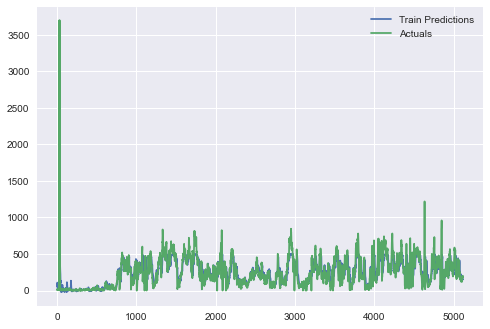

In [13]:
model = load_model('6H_Forecast/6H_ForecastModel_12_SizeWindow/')

X, y = DataHandler(6,12)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,shuffle=False) 
model.evaluate(X_test,y_test)

train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
plt.style.use('seaborn')

pd.concat([train_results['Train Predictions'],train_results['Actuals']],axis=1).plot()
plt.legend(['Train Predictions','Actuals'])